MOUNT THE DRIVE AND LOAD THE DATASET

In [5]:
#save test set predictions to a file
import os
import sys
import PIL.Image as Image
import matplotlib.pyplot as plt
import torchvision.transforms as tr

In [6]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision.transforms as tr
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os

In [7]:
#general variables
n_epochs=100
cycle_lambda = 20.
root_data = "harmonies_database"

In [8]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/harmonie/CycleGAN'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd
%ls ../harmonies_database

/content/gdrive/My Drive/Colab Notebooks/harmonie/CycleGAN
analog/  rectangle/


In [10]:
from torch.utils.data import Dataset
import numpy as np

#no time so I'm stealing this from https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/CycleGAN/dataset.py

class HorseZebraDataset(Dataset):
    def __init__(self, root_zebra, root_horse, transform=None):
        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.transform = transform

        self.zebra_images = os.listdir(root_zebra)
        self.horse_images = os.listdir(root_horse)
        self.length_dataset = max(len(self.zebra_images), len(self.horse_images)) # 1000, 1500
        self.zebra_len = len(self.zebra_images)
        self.horse_len = len(self.horse_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        zebra_img = self.zebra_images[index % self.zebra_len]
        horse_img = self.horse_images[index % self.horse_len]

        zebra_path = os.path.join(self.root_zebra, zebra_img)
        horse_path = os.path.join(self.root_horse, horse_img)

        zebra_img = torch.Tensor(np.moveaxis(np.array(Image.open(zebra_path)),-1,0)).to(torch.device("cuda:0"))/255
        horse_img = torch.Tensor(np.moveaxis(np.array(Image.open(horse_path)),-1,0)).to(torch.device("cuda:0"))/255


        return zebra_img, horse_img

trainData = HorseZebraDataset(os.path.join(root_data,"unknown"),os.path.join(root_data,"comp"),transform=tr.RandomHorizontalFlip())
iterData = iter(trainData)

Text(0.5, 0, 'unknown')

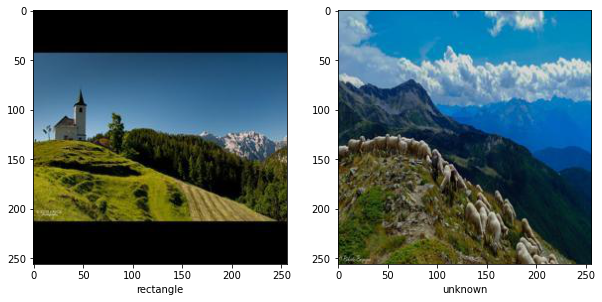

In [11]:
#display a random couple
summer,winter = next(iterData)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(np.moveaxis(np.array(winter.cpu()),0,-1))
plt.xlabel("rectangle")
plt.subplot(1,2,2)
plt.imshow(np.moveaxis(np.array(summer.cpu()),0,-1))
plt.xlabel("unknown")

#MODELS

In [12]:
from torch.nn.modules.instancenorm import InstanceNorm2d
class Block(nn.Module):
  def __init__(self,in_chan,out_chan,stride,padding):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_chan,out_chan,4,stride,padding,padding_mode="reflect"),
        nn.InstanceNorm2d(out_chan),
        nn.LeakyReLU(0.2)
    )
  
  def forward(self,X):
    return self.conv(X)

In [13]:
class Discriminator(nn.Module):
  def __init__(self,in_chan=3,features=[64,128,256]):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(
          in_chan,
          features[0],
          4,stride=2,padding=1,padding_mode="reflect"
        ),
        nn.LeakyReLU(0.2)
    )

    layers=[]
    in_channels=features[0]
    for n_chan in features[1:]:
      layers.append(Block(in_channels,n_chan,2 if n_chan!=features[-1] else 1,1))
      in_channels=n_chan
    self.model = nn.Sequential(*layers)
    self.model.append(
        nn.Sequential(
            nn.Conv2d(in_channels,1,4,1,1,padding_mode="reflect")
            #,nn.Sigmoid()
        )
    )
  
  def forward(self,x):
    x = self.initial(x)
    return self.model(x)

In [14]:
disc = Discriminator().to(torch.device("cuda:0"))
summary(disc,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
             Block-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 63, 63]         524,544
    InstanceNorm2d-8          [-1, 256, 63, 63]               0
         LeakyReLU-9          [-1, 256, 63, 63]               0
            Block-10          [-1, 256, 63, 63]               0
           Conv2d-11            [-1, 1, 62, 62]           4,097
Total params: 662,977
Trainable params: 662,977
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/

In [15]:
class convBlock(nn.Module):
  def __init__(self,in_channels,out_channels,use_act=True,down=True,**kwargs):
    super().__init__()
    self.down=down
    if down:
      self.block=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,**kwargs),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU() if use_act else nn.Identity()
    )
    else:
      self.block=nn.Sequential(
        nn.Upsample(scale_factor = 2, mode='nearest'),
        nn.ReflectionPad2d(1),
        nn.Conv2d(in_channels, out_channels,
                  kernel_size=3, stride=1, padding=0),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU() if use_act else nn.Identity()
      )

  def forward(self,x):
    if self.down:
      return self.block(x)
    else:
      x=x.reshape((1,x.shape[0],x.shape[1],x.shape[2]))
      x = self.block(x)
      x = x.reshape((x.shape[1],x.shape[2],x.shape[3]))
      return x

In [16]:
class residualBlock(nn.Module):
  def __init__(self,n_channels):
    super().__init__()
    self.block = nn.Sequential(
        convBlock(n_channels,n_channels,kernel_size=3,stride=1,padding=1),
        convBlock(n_channels,n_channels,False,kernel_size=3,stride=1,padding=1)
    )
  def forward(self,x):
    return x + self.block(x)

In [17]:
class Generator(nn.Module):
  def __init__(self,n_residuals=9,in_channels=3,num_features=64):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels,num_features,7,1,3,padding_mode="reflect"),
        nn.ReLU()
        )
    self.down = nn.ModuleList(
        [
        convBlock(num_features,num_features*2,kernel_size=3,stride=2,padding=1),
        convBlock(num_features*2,num_features*4,kernel_size=3,stride=2,padding=1)
        ]
    )
    self.residual=nn.ModuleList(
        [*[residualBlock(num_features*4) for _ in range(n_residuals)]
        ]
    )
    self.up = nn.ModuleList(
        [
        convBlock(num_features*4,num_features*2,kernel_size=3,stride=2,padding=1,output_padding=1,down=False),
        convBlock(num_features*2,num_features*1,kernel_size=3,stride=2,padding=1,output_padding=1,down=False)
        ]
    )
    self.up.append(nn.Sequential(
        nn.Conv2d(num_features,3,7,1,3,padding_mode="reflect"),
        nn.Tanh()
        )
    )

  def forward(self,x):
    x = self.initial(x)
    for d in self.down:
      x = d(x)
    for r in self.residual:
      x = r(x)
    for u in self.up:
      x = u(x)
    return x

In [18]:
gen = Generator(n_residuals=4,num_features=64).to(torch.device("cuda:0"))
print(gen(winter))

tensor([[[ 0.2114,  0.1442,  0.1226,  ...,  0.4112,  0.4606,  0.4092],
         [ 0.3062,  0.2302,  0.2859,  ...,  0.4201,  0.4781,  0.4310],
         [ 0.1386,  0.1428,  0.1815,  ...,  0.2757,  0.3332,  0.3038],
         ...,
         [ 0.0407,  0.0819, -0.0548,  ...,  0.1549,  0.2342,  0.2785],
         [ 0.0577,  0.0828,  0.0109,  ...,  0.0608,  0.1675,  0.2363],
         [ 0.1338,  0.1125,  0.1112,  ...,  0.0523,  0.0952,  0.1560]],

        [[ 0.3223,  0.3681,  0.3061,  ..., -0.1626, -0.1139, -0.2340],
         [ 0.1987,  0.2436,  0.1326,  ..., -0.2278, -0.2134, -0.3329],
         [ 0.0742,  0.0596, -0.0156,  ..., -0.3121, -0.2577, -0.4069],
         ...,
         [-0.1464, -0.0826, -0.1034,  ..., -0.0784, -0.1025, -0.0915],
         [-0.0485,  0.0546, -0.0162,  ..., -0.0528, -0.0814,  0.0011],
         [ 0.0203,  0.1344,  0.0393,  ..., -0.1033, -0.1122, -0.0711]],

        [[ 0.0487,  0.0852,  0.0263,  ..., -0.0155,  0.0671,  0.0159],
         [-0.0125,  0.0093, -0.0309,  ...,  0

In [19]:
def make_the_models():
  disc_S = Discriminator().to(torch.device("cuda:0"))
  disc_W = Discriminator().to(torch.device("cuda:0"))




  gen_S = Generator(n_residuals=3,num_features=64).to(torch.device("cuda:0"))
  gen_W = Generator(n_residuals=3,num_features=64).to(torch.device("cuda:0"))
  
  opt_d = torch.optim.Adam(list(disc_S.parameters())+list(disc_W.parameters()),lr=0.0004,betas=(0.0,0.9))
  opt_g = torch.optim.Adam(list(gen_S.parameters())+list(gen_W.parameters()),lr=0.0004,betas=(0.0,0.9))

  l1 = nn.L1Loss()

  return disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1

In [72]:
nb_iters_critic = 2
lambda_weight_constraint = 10

In [36]:
def gradient_constraint(critic, real, fake):
  epsilon = torch.rand((1)).to(torch.device("cuda:0"))
  fake.requires_grad=True
  interpolation = real*epsilon + (1-epsilon)*fake

  pred = critic(interpolation)

  grad = torch.autograd.grad(
      outputs=pred,
      inputs=interpolation,
      create_graph=True,
      retain_graph = True,
      grad_outputs=torch.ones_like(pred)
  )[0]

  grad = grad.view(-1)
  nrm = grad.norm(2)#l2 norm
  penalty = torch.pow(nrm-1,2)

  return penalty

In [37]:
import tqdm

#losses_cycle = []
#losses_disc = []
#losses_gp = []
#losses_gen = []


def train(dataset, disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1):

  while(True):
    i=0
    for summer,winter in tqdm.tqdm(dataset):
      for i in range(nb_iters_critic):        #train the disc more as it's no longer a competition
        #train the discriminators on their own
        with torch.cuda.amp.autocast():

          #adversarial loss for summer discriminator
          #learn to correctly detect fake summer and real summer (learns both to detect realism AND summer)
          #basically estimating the distribution of summer images through this adversarial loss.
          gen_S.zero_grad()

          fake_summer = gen_S(winter)
          pred_fake_summer = disc_S(fake_summer.detach())
          pred_real_summer = disc_S(summer)
          loss_disc_S = -(pred_real_summer.mean() - pred_fake_summer.mean())

          

          #adversarial loss for winter discriminator
          gen_W.zero_grad()
          fake_winter = gen_W(summer)
          pred_fake_winter = disc_W(fake_winter.detach())
          pred_real_winter = disc_W(winter)
          loss_disc_W = -(pred_real_winter.mean() - pred_fake_winter.mean())
                  #seems to me this will just make the two values the same..

          


        loss_D = loss_disc_S + loss_disc_W
        opt_d.zero_grad()
        loss_D.backward()
        opt_d.step()


        #gradient constraint for summer discriminator
        cstraint_s=gradient_constraint(disc_S, summer, fake_summer.detach())
        #gradient constraint for winter discriminator
        cstraint_w=gradient_constraint(disc_W, winter, fake_winter.detach())
        loss_GP = cstraint_s*lambda_weight_constraint + cstraint_w*lambda_weight_constraint
        opt_d.zero_grad()
        loss_GP.backward()
        opt_d.step()


      #train the generators on their own
      with torch.cuda.amp.autocast():
        #adversarial loss on summer generator
        fake_summer = gen_S(winter)
        pred_fake_summer = disc_S(fake_summer)
        loss_gen_S_adv = -pred_fake_summer.mean()

        #adversarial loss on winter generator
        fake_winter = gen_W(summer)
        pred_fake_winter = disc_W(fake_winter)
        loss_gen_W_adv = -pred_fake_winter.mean()

        #cycle consistency loss for summer->winter->summer (updates both generators)
        reco_summer = gen_S(fake_winter)
        loss_gen_S_cyc = l1(reco_summer,summer)

        #cycle consistency loss for winter->summer->winter (updates both generators)
        reco_winter = gen_W(fake_summer)
        loss_gen_W_cyc = l1(reco_winter,winter)

        #final generators loss
        G_loss = (loss_gen_S_cyc*cycle_lambda + loss_gen_W_cyc*cycle_lambda + loss_gen_S_adv + loss_gen_W_adv)

      #update the weights
      opt_g.zero_grad()
      G_loss.backward()
      opt_g.step()


      print("\nGloss cycle : ",float(loss_gen_S_cyc*cycle_lambda + loss_gen_W_cyc*cycle_lambda),"Gloss adv : ",float(loss_gen_S_adv + loss_gen_W_adv),
            "D loss : ",float(loss_D),"GP loss : ",float(loss_GP))
      
      losses_disc.append(float(loss_D))
      losses_cycle.append(float(loss_gen_S_cyc*cycle_lambda + loss_gen_W_cyc*cycle_lambda))
      losses_gen.append(float(loss_gen_S_adv + loss_gen_W_adv))
      losses_gp.append(float(loss_GP))

    return losses_disc,losses_cycle,losses_gen,losses_gp

In [99]:
#disc_S, disc_W, gen_S, gen_W, opt_d, opt_g,l1 = make_the_models()


losses_disc,losses_cycle,losses_gen,losses_gp = train(trainData,disc_S, disc_W, gen_S, gen_W, opt_d, opt_g,l1)

  0%|          | 1/2400 [00:00<21:04,  1.90it/s]


Gloss cycle :  2.222233772277832 Gloss adv :  0.00669097900390625 D loss :  0.000244140625 GP loss :  1.730648159980774


  0%|          | 2/2400 [00:00<19:20,  2.07it/s]


Gloss cycle :  2.074252128601074 Gloss adv :  -0.0110626220703125 D loss :  -0.00591278076171875 GP loss :  32.31559753417969


  0%|          | 3/2400 [00:01<18:55,  2.11it/s]


Gloss cycle :  2.3508682250976562 Gloss adv :  0.0233154296875 D loss :  -0.00921630859375 GP loss :  0.7469873428344727


  0%|          | 4/2400 [00:01<18:42,  2.13it/s]


Gloss cycle :  4.940356254577637 Gloss adv :  0.414794921875 D loss :  0.002124786376953125 GP loss :  37.00231170654297


  0%|          | 5/2400 [00:02<18:32,  2.15it/s]


Gloss cycle :  2.729644536972046 Gloss adv :  -0.342041015625 D loss :  0.10418701171875 GP loss :  82.66182708740234


  0%|          | 6/2400 [00:02<18:30,  2.16it/s]


Gloss cycle :  1.9537080526351929 Gloss adv :  -0.5302734375 D loss :  0.077392578125 GP loss :  1960.9449462890625


  0%|          | 7/2400 [00:03<18:30,  2.16it/s]


Gloss cycle :  2.72249698638916 Gloss adv :  -0.10986328125 D loss :  0.0567626953125 GP loss :  1787.5076904296875


  0%|          | 8/2400 [00:03<18:27,  2.16it/s]


Gloss cycle :  3.452725887298584 Gloss adv :  -0.6591796875 D loss :  0.22802734375 GP loss :  18223.28515625


  0%|          | 9/2400 [00:04<18:25,  2.16it/s]


Gloss cycle :  3.1821279525756836 Gloss adv :  -0.677734375 D loss :  0.139404296875 GP loss :  56.671966552734375


  0%|          | 10/2400 [00:04<18:25,  2.16it/s]


Gloss cycle :  3.8450136184692383 Gloss adv :  -0.1710205078125 D loss :  -0.016845703125 GP loss :  77.76475524902344


  0%|          | 11/2400 [00:05<18:24,  2.16it/s]


Gloss cycle :  2.0584421157836914 Gloss adv :  -0.195556640625 D loss :  0.0 GP loss :  2.338899612426758


  0%|          | 12/2400 [00:05<18:29,  2.15it/s]


Gloss cycle :  3.4063949584960938 Gloss adv :  0.192138671875 D loss :  -0.0030517578125 GP loss :  95.81190490722656


  1%|          | 13/2400 [00:06<18:28,  2.15it/s]


Gloss cycle :  1.8334786891937256 Gloss adv :  0.12939453125 D loss :  0.001007080078125 GP loss :  61.36668014526367


  1%|          | 14/2400 [00:06<18:35,  2.14it/s]


Gloss cycle :  2.696220874786377 Gloss adv :  0.1287841796875 D loss :  0.002655029296875 GP loss :  5.814535140991211


  1%|          | 15/2400 [00:07<18:37,  2.13it/s]


Gloss cycle :  2.799781560897827 Gloss adv :  -0.03460693359375 D loss :  0.00506591796875 GP loss :  12.035531997680664


  1%|          | 16/2400 [00:07<18:39,  2.13it/s]


Gloss cycle :  3.6239967346191406 Gloss adv :  -0.076904296875 D loss :  -0.002685546875 GP loss :  2.6669998168945312


  1%|          | 17/2400 [00:07<18:40,  2.13it/s]


Gloss cycle :  2.5976123809814453 Gloss adv :  -0.0129241943359375 D loss :  0.0010747909545898438 GP loss :  1.0284640789031982


  1%|          | 18/2400 [00:08<18:41,  2.12it/s]


Gloss cycle :  2.5432581901550293 Gloss adv :  -0.02520751953125 D loss :  -0.0015716552734375 GP loss :  0.676745593547821


  1%|          | 19/2400 [00:08<18:43,  2.12it/s]


Gloss cycle :  2.6491336822509766 Gloss adv :  0.08563232421875 D loss :  0.00055694580078125 GP loss :  4.866621494293213


  1%|          | 20/2400 [00:09<18:43,  2.12it/s]


Gloss cycle :  2.211771011352539 Gloss adv :  -0.5732421875 D loss :  -0.006927490234375 GP loss :  14.160222053527832


  1%|          | 21/2400 [00:09<18:38,  2.13it/s]


Gloss cycle :  1.926481008529663 Gloss adv :  -0.10821533203125 D loss :  -0.012115478515625 GP loss :  779.1361083984375


  1%|          | 22/2400 [00:10<18:34,  2.13it/s]


Gloss cycle :  2.535675048828125 Gloss adv :  0.8310546875 D loss :  0.11279296875 GP loss :  38496.7265625


  1%|          | 23/2400 [00:10<18:32,  2.14it/s]


Gloss cycle :  2.332345485687256 Gloss adv :  -0.394775390625 D loss :  -0.131591796875 GP loss :  1891.57470703125


  1%|          | 24/2400 [00:11<18:31,  2.14it/s]


Gloss cycle :  3.901154041290283 Gloss adv :  -1.0830078125 D loss :  0.0130615234375 GP loss :  3632.97705078125


  1%|          | 25/2400 [00:11<18:30,  2.14it/s]


Gloss cycle :  3.797659158706665 Gloss adv :  -0.484375 D loss :  0.0594482421875 GP loss :  2152.68212890625


  1%|          | 26/2400 [00:12<18:27,  2.14it/s]


Gloss cycle :  2.45515775680542 Gloss adv :  0.2100830078125 D loss :  0.010040283203125 GP loss :  296.7474060058594


  1%|          | 27/2400 [00:12<18:33,  2.13it/s]


Gloss cycle :  2.6407768726348877 Gloss adv :  0.205322265625 D loss :  0.0008544921875 GP loss :  4.036990642547607


  1%|          | 28/2400 [00:13<18:33,  2.13it/s]


Gloss cycle :  3.697652816772461 Gloss adv :  -0.0129241943359375 D loss :  -0.0143585205078125 GP loss :  0.2679928243160248


  1%|          | 29/2400 [00:13<18:33,  2.13it/s]


Gloss cycle :  2.7124509811401367 Gloss adv :  -0.0114593505859375 D loss :  0.00310516357421875 GP loss :  4.775026321411133


  1%|▏         | 30/2400 [00:14<18:32,  2.13it/s]


Gloss cycle :  2.2255637645721436 Gloss adv :  0.0004520416259765625 D loss :  0.003185272216796875 GP loss :  1.9945931434631348


  1%|▏         | 31/2400 [00:14<18:30,  2.13it/s]


Gloss cycle :  3.7746880054473877 Gloss adv :  0.026885986328125 D loss :  0.00574493408203125 GP loss :  1.5098215341567993


  1%|▏         | 32/2400 [00:14<18:29,  2.13it/s]


Gloss cycle :  4.355407238006592 Gloss adv :  0.47705078125 D loss :  0.01067352294921875 GP loss :  39.028053283691406


  1%|▏         | 33/2400 [00:15<18:28,  2.13it/s]


Gloss cycle :  3.9584555625915527 Gloss adv :  0.93359375 D loss :  -0.03411865234375 GP loss :  11052.6552734375


  1%|▏         | 34/2400 [00:15<18:28,  2.13it/s]


Gloss cycle :  2.224536895751953 Gloss adv :  -0.06109619140625 D loss :  -0.002758026123046875 GP loss :  19.905351638793945


  1%|▏         | 35/2400 [00:16<18:28,  2.13it/s]


Gloss cycle :  2.101377010345459 Gloss adv :  0.00226593017578125 D loss :  0.00585174560546875 GP loss :  1.594683051109314


  2%|▏         | 36/2400 [00:16<18:34,  2.12it/s]


Gloss cycle :  2.731743574142456 Gloss adv :  -0.08685302734375 D loss :  -0.00061798095703125 GP loss :  0.4499868154525757


  2%|▏         | 37/2400 [00:17<18:35,  2.12it/s]


Gloss cycle :  2.602215051651001 Gloss adv :  0.0445556640625 D loss :  -0.000751495361328125 GP loss :  0.6438760161399841


  2%|▏         | 38/2400 [00:17<18:33,  2.12it/s]


Gloss cycle :  2.378314971923828 Gloss adv :  0.0024566650390625 D loss :  0.00136566162109375 GP loss :  0.907915472984314


  2%|▏         | 39/2400 [00:18<18:32,  2.12it/s]


Gloss cycle :  2.3619384765625 Gloss adv :  -0.002410888671875 D loss :  0.0012054443359375 GP loss :  5.492934703826904


  2%|▏         | 40/2400 [00:18<18:32,  2.12it/s]


Gloss cycle :  3.0434775352478027 Gloss adv :  -0.05865478515625 D loss :  -0.001953125 GP loss :  0.0325792171061039


  2%|▏         | 41/2400 [00:19<18:33,  2.12it/s]


Gloss cycle :  2.870767116546631 Gloss adv :  -0.005462646484375 D loss :  0.003082275390625 GP loss :  0.6720381379127502


  2%|▏         | 42/2400 [00:19<18:32,  2.12it/s]


Gloss cycle :  2.9328231811523438 Gloss adv :  1.0048828125 D loss :  -0.061737060546875 GP loss :  3922.738525390625


  2%|▏         | 43/2400 [00:20<18:31,  2.12it/s]


Gloss cycle :  3.744431972503662 Gloss adv :  -0.9189453125 D loss :  0.12255859375 GP loss :  11724.3544921875


  2%|▏         | 44/2400 [00:20<18:29,  2.12it/s]


Gloss cycle :  2.548910617828369 Gloss adv :  -0.406005859375 D loss :  0.05126953125 GP loss :  264.1111145019531


  2%|▏         | 45/2400 [00:21<18:34,  2.11it/s]


Gloss cycle :  2.2133493423461914 Gloss adv :  -0.2373046875 D loss :  0.0096435546875 GP loss :  98.8853759765625


  2%|▏         | 46/2400 [00:21<18:32,  2.12it/s]


Gloss cycle :  3.6402034759521484 Gloss adv :  -0.08526611328125 D loss :  0.0042724609375 GP loss :  24.72909164428711


  2%|▏         | 47/2400 [00:22<18:31,  2.12it/s]


Gloss cycle :  3.3595685958862305 Gloss adv :  -0.0718994140625 D loss :  -0.003631591796875 GP loss :  3.430128574371338


  2%|▏         | 48/2400 [00:22<18:32,  2.11it/s]


Gloss cycle :  3.2395472526550293 Gloss adv :  -0.0435791015625 D loss :  0.00811767578125 GP loss :  8.784727096557617


  2%|▏         | 49/2400 [00:23<18:35,  2.11it/s]


Gloss cycle :  3.2223429679870605 Gloss adv :  -0.018463134765625 D loss :  -0.00211334228515625 GP loss :  5.817704200744629


  2%|▏         | 50/2400 [00:23<18:36,  2.10it/s]


Gloss cycle :  5.125695705413818 Gloss adv :  -0.0040283203125 D loss :  0.0096435546875 GP loss :  2.843280792236328


  2%|▏         | 51/2400 [00:23<18:34,  2.11it/s]


Gloss cycle :  2.5981552600860596 Gloss adv :  -0.04736328125 D loss :  -0.0095977783203125 GP loss :  4.471315383911133


  2%|▏         | 52/2400 [00:24<18:38,  2.10it/s]


Gloss cycle :  2.0796170234680176 Gloss adv :  -0.0821533203125 D loss :  -0.001373291015625 GP loss :  2.598539113998413


  2%|▏         | 53/2400 [00:24<18:35,  2.10it/s]


Gloss cycle :  2.6444637775421143 Gloss adv :  -0.47998046875 D loss :  0.0066986083984375 GP loss :  34.28138732910156


  2%|▏         | 54/2400 [00:25<18:36,  2.10it/s]


Gloss cycle :  2.2335028648376465 Gloss adv :  -0.281005859375 D loss :  0.002197265625 GP loss :  3.1366817951202393


  2%|▏         | 55/2400 [00:25<18:35,  2.10it/s]


Gloss cycle :  2.7107701301574707 Gloss adv :  -0.2093505859375 D loss :  0.0008544921875 GP loss :  2.832602024078369


  2%|▏         | 56/2400 [00:26<18:31,  2.11it/s]


Gloss cycle :  2.166475534439087 Gloss adv :  -0.203125 D loss :  -0.00103759765625 GP loss :  1.0774086713790894


  2%|▏         | 57/2400 [00:26<18:29,  2.11it/s]


Gloss cycle :  2.127354145050049 Gloss adv :  0.000274658203125 D loss :  0.00061798095703125 GP loss :  2.321409225463867


  2%|▏         | 58/2400 [00:27<18:29,  2.11it/s]


Gloss cycle :  2.5164222717285156 Gloss adv :  -1.326171875 D loss :  0.01763916015625 GP loss :  80.7958755493164


  2%|▏         | 59/2400 [00:27<18:28,  2.11it/s]


Gloss cycle :  2.834087610244751 Gloss adv :  -0.31298828125 D loss :  0.02056884765625 GP loss :  114.2874984741211


  2%|▎         | 60/2400 [00:28<18:28,  2.11it/s]


Gloss cycle :  3.345935821533203 Gloss adv :  -0.1885986328125 D loss :  0.01202392578125 GP loss :  105.25467681884766


  3%|▎         | 61/2400 [00:28<18:28,  2.11it/s]


Gloss cycle :  2.352278232574463 Gloss adv :  -0.08673095703125 D loss :  0.0035400390625 GP loss :  2.4594967365264893


  3%|▎         | 62/2400 [00:29<18:26,  2.11it/s]


Gloss cycle :  2.3211669921875 Gloss adv :  0.056884765625 D loss :  0.0008544921875 GP loss :  8.335794448852539


  3%|▎         | 63/2400 [00:29<18:24,  2.12it/s]


Gloss cycle :  2.027184009552002 Gloss adv :  -0.94921875 D loss :  -0.134765625 GP loss :  12818.2666015625


  3%|▎         | 64/2400 [00:30<18:28,  2.11it/s]


Gloss cycle :  2.614668369293213 Gloss adv :  -0.260498046875 D loss :  -0.0185546875 GP loss :  3651.519287109375


  3%|▎         | 65/2400 [00:30<18:26,  2.11it/s]


Gloss cycle :  2.3749496936798096 Gloss adv :  -0.96630859375 D loss :  0.010498046875 GP loss :  497.830810546875


  3%|▎         | 66/2400 [00:31<18:25,  2.11it/s]


Gloss cycle :  2.2787036895751953 Gloss adv :  -0.71630859375 D loss :  -0.029815673828125 GP loss :  269.7683410644531


  3%|▎         | 67/2400 [00:31<18:24,  2.11it/s]


Gloss cycle :  2.20560359954834 Gloss adv :  0.044189453125 D loss :  -0.001373291015625 GP loss :  426.0439758300781


  3%|▎         | 68/2400 [00:32<18:22,  2.12it/s]


Gloss cycle :  2.7864556312561035 Gloss adv :  0.01885986328125 D loss :  -0.0123291015625 GP loss :  1.1699479818344116


  3%|▎         | 69/2400 [00:32<18:18,  2.12it/s]


Gloss cycle :  2.8318982124328613 Gloss adv :  0.58740234375 D loss :  -0.00750732421875 GP loss :  194.5255889892578


  3%|▎         | 70/2400 [00:32<18:17,  2.12it/s]


Gloss cycle :  2.8091440200805664 Gloss adv :  -0.1856689453125 D loss :  -0.03350830078125 GP loss :  439.2652893066406


  3%|▎         | 71/2400 [00:33<18:18,  2.12it/s]


Gloss cycle :  3.8587350845336914 Gloss adv :  -0.1536865234375 D loss :  0.0083160400390625 GP loss :  0.318535178899765


  3%|▎         | 72/2400 [00:33<18:17,  2.12it/s]


Gloss cycle :  3.2888336181640625 Gloss adv :  -0.80810546875 D loss :  0.029998779296875 GP loss :  140.81463623046875


  3%|▎         | 73/2400 [00:34<18:15,  2.12it/s]


Gloss cycle :  2.8459298610687256 Gloss adv :  -0.46875 D loss :  0.00940704345703125 GP loss :  3706.40478515625


  3%|▎         | 74/2400 [00:34<18:14,  2.13it/s]


Gloss cycle :  2.271740674972534 Gloss adv :  0.280029296875 D loss :  0.013153076171875 GP loss :  560.5602416992188


  3%|▎         | 75/2400 [00:35<18:13,  2.13it/s]


Gloss cycle :  2.024132013320923 Gloss adv :  0.301513671875 D loss :  -0.047149658203125 GP loss :  1638.302734375


  3%|▎         | 76/2400 [00:35<18:14,  2.12it/s]


Gloss cycle :  1.9106547832489014 Gloss adv :  0.098388671875 D loss :  -0.00836181640625 GP loss :  52.193275451660156


  3%|▎         | 77/2400 [00:36<18:18,  2.12it/s]


Gloss cycle :  3.0744237899780273 Gloss adv :  -0.0927734375 D loss :  -0.1708984375 GP loss :  11011.880859375


  3%|▎         | 78/2400 [00:36<18:16,  2.12it/s]


Gloss cycle :  3.9153082370758057 Gloss adv :  -0.009521484375 D loss :  -0.024658203125 GP loss :  570.1619873046875


  3%|▎         | 79/2400 [00:37<18:14,  2.12it/s]


Gloss cycle :  3.075594425201416 Gloss adv :  0.38232421875 D loss :  -0.001220703125 GP loss :  313.23370361328125


  3%|▎         | 80/2400 [00:37<18:11,  2.13it/s]


Gloss cycle :  2.5501439571380615 Gloss adv :  0.1273193359375 D loss :  -0.0128173828125 GP loss :  27.40673828125


  3%|▎         | 81/2400 [00:38<18:07,  2.13it/s]


Gloss cycle :  2.917083740234375 Gloss adv :  0.03790283203125 D loss :  -0.00604248046875 GP loss :  3.706778049468994


  3%|▎         | 82/2400 [00:38<18:10,  2.12it/s]


Gloss cycle :  3.02465558052063 Gloss adv :  0.039306640625 D loss :  0.004638671875 GP loss :  12.391031265258789


  3%|▎         | 83/2400 [00:39<18:09,  2.13it/s]


Gloss cycle :  2.9568252563476562 Gloss adv :  -0.00390625 D loss :  -0.0032958984375 GP loss :  0.6267380714416504


  4%|▎         | 84/2400 [00:39<18:10,  2.12it/s]


Gloss cycle :  2.8277206420898438 Gloss adv :  -0.061065673828125 D loss :  -0.000244140625 GP loss :  2.5948801040649414


  4%|▎         | 85/2400 [00:40<18:06,  2.13it/s]


Gloss cycle :  3.1386022567749023 Gloss adv :  -0.057281494140625 D loss :  0.00237274169921875 GP loss :  0.6116529107093811


  4%|▎         | 86/2400 [00:40<18:04,  2.13it/s]


Gloss cycle :  2.4981298446655273 Gloss adv :  -0.1429443359375 D loss :  -0.002040863037109375 GP loss :  5.041005611419678


  4%|▎         | 87/2400 [00:40<18:02,  2.14it/s]


Gloss cycle :  2.132567882537842 Gloss adv :  -0.69970703125 D loss :  0.0107269287109375 GP loss :  160.93666076660156


  4%|▎         | 88/2400 [00:41<17:59,  2.14it/s]


Gloss cycle :  2.0310306549072266 Gloss adv :  -0.3974609375 D loss :  -0.0052490234375 GP loss :  237.23709106445312


  4%|▎         | 89/2400 [00:41<17:58,  2.14it/s]


Gloss cycle :  3.8928613662719727 Gloss adv :  -0.55322265625 D loss :  0.00421142578125 GP loss :  1519.6370849609375


  4%|▍         | 90/2400 [00:42<17:57,  2.14it/s]


Gloss cycle :  3.237879753112793 Gloss adv :  -0.65673828125 D loss :  0.0185546875 GP loss :  4109.06201171875


  4%|▍         | 91/2400 [00:42<17:55,  2.15it/s]


Gloss cycle :  2.7793455123901367 Gloss adv :  0.00335693359375 D loss :  0.0008544921875 GP loss :  26.353759765625


  4%|▍         | 92/2400 [00:43<17:54,  2.15it/s]


Gloss cycle :  2.5160772800445557 Gloss adv :  0.010009765625 D loss :  0.0054931640625 GP loss :  0.8519084453582764


  4%|▍         | 93/2400 [00:43<17:54,  2.15it/s]


Gloss cycle :  2.266725540161133 Gloss adv :  1.015625 D loss :  -0.0513916015625 GP loss :  130.53768920898438


  4%|▍         | 94/2400 [00:44<17:54,  2.15it/s]


Gloss cycle :  4.001829147338867 Gloss adv :  -0.58984375 D loss :  -0.10272216796875 GP loss :  396.8850402832031


  4%|▍         | 95/2400 [00:44<17:53,  2.15it/s]


Gloss cycle :  3.128967046737671 Gloss adv :  -0.05206298828125 D loss :  0.003662109375 GP loss :  44.64753341674805


  4%|▍         | 96/2400 [00:45<17:55,  2.14it/s]


Gloss cycle :  3.0790767669677734 Gloss adv :  -0.5390625 D loss :  -0.033721923828125 GP loss :  153.02853393554688


  4%|▍         | 97/2400 [00:45<17:57,  2.14it/s]


Gloss cycle :  2.351961374282837 Gloss adv :  -0.51025390625 D loss :  0.028839111328125 GP loss :  2296.6875


  4%|▍         | 98/2400 [00:46<17:52,  2.15it/s]


Gloss cycle :  3.1386666297912598 Gloss adv :  0.023284912109375 D loss :  -0.00994873046875 GP loss :  2.4498517513275146


  4%|▍         | 99/2400 [00:46<17:51,  2.15it/s]


Gloss cycle :  2.621600866317749 Gloss adv :  0.025848388671875 D loss :  -0.008514404296875 GP loss :  0.9540883898735046


  4%|▍         | 100/2400 [00:47<17:49,  2.15it/s]


Gloss cycle :  2.6945719718933105 Gloss adv :  0.4326171875 D loss :  0.019989013671875 GP loss :  105.82276153564453


  4%|▍         | 101/2400 [00:47<17:50,  2.15it/s]


Gloss cycle :  2.694932460784912 Gloss adv :  0.865234375 D loss :  0.00408935546875 GP loss :  1162.3717041015625


  4%|▍         | 102/2400 [00:47<17:44,  2.16it/s]


Gloss cycle :  2.695913791656494 Gloss adv :  0.5712890625 D loss :  0.00390625 GP loss :  91.02096557617188


  4%|▍         | 103/2400 [00:48<17:44,  2.16it/s]


Gloss cycle :  3.339097023010254 Gloss adv :  0.1279296875 D loss :  0.009063720703125 GP loss :  6554.34765625


  4%|▍         | 104/2400 [00:48<17:44,  2.16it/s]


Gloss cycle :  2.904965877532959 Gloss adv :  2.0625 D loss :  -0.025146484375 GP loss :  9637.6689453125


  4%|▍         | 105/2400 [00:49<17:45,  2.15it/s]


Gloss cycle :  2.6832962036132812 Gloss adv :  -0.03497314453125 D loss :  0.00799560546875 GP loss :  171.1979217529297


  4%|▍         | 106/2400 [00:49<17:44,  2.16it/s]


Gloss cycle :  1.9997848272323608 Gloss adv :  -0.034912109375 D loss :  -0.0058135986328125 GP loss :  13.077505111694336


  4%|▍         | 107/2400 [00:50<17:41,  2.16it/s]


Gloss cycle :  3.7107625007629395 Gloss adv :  -0.0382080078125 D loss :  0.0052490234375 GP loss :  8.38986873626709


  4%|▍         | 108/2400 [00:50<17:38,  2.17it/s]


Gloss cycle :  3.0355684757232666 Gloss adv :  0.045166015625 D loss :  -0.00030517578125 GP loss :  51.507564544677734


  5%|▍         | 109/2400 [00:51<17:39,  2.16it/s]


Gloss cycle :  3.4101569652557373 Gloss adv :  0.2978515625 D loss :  -0.0143585205078125 GP loss :  1230.1524658203125


  5%|▍         | 110/2400 [00:51<17:39,  2.16it/s]


Gloss cycle :  3.0529112815856934 Gloss adv :  0.04840087890625 D loss :  -0.0194244384765625 GP loss :  15.289599418640137


  5%|▍         | 111/2400 [00:52<17:38,  2.16it/s]


Gloss cycle :  2.6296937465667725 Gloss adv :  0.000579833984375 D loss :  0.0033111572265625 GP loss :  0.6708529591560364


  5%|▍         | 112/2400 [00:52<17:40,  2.16it/s]


Gloss cycle :  2.2845540046691895 Gloss adv :  -0.0273895263671875 D loss :  0.0035247802734375 GP loss :  20.57002830505371


  5%|▍         | 113/2400 [00:53<17:38,  2.16it/s]


Gloss cycle :  2.644606590270996 Gloss adv :  -0.053253173828125 D loss :  0.001800537109375 GP loss :  1.148282766342163


  5%|▍         | 114/2400 [00:53<17:39,  2.16it/s]


Gloss cycle :  2.52447247505188 Gloss adv :  -0.068603515625 D loss :  0.0004730224609375 GP loss :  0.03272475674748421


  5%|▍         | 115/2400 [00:53<17:37,  2.16it/s]


Gloss cycle :  2.997922897338867 Gloss adv :  -0.10589599609375 D loss :  0.00304412841796875 GP loss :  2.437299966812134


  5%|▍         | 116/2400 [00:54<17:37,  2.16it/s]


Gloss cycle :  2.396092414855957 Gloss adv :  -0.73291015625 D loss :  -0.007965087890625 GP loss :  376.3642883300781


  5%|▍         | 117/2400 [00:54<17:36,  2.16it/s]


Gloss cycle :  3.021170139312744 Gloss adv :  -1.115234375 D loss :  0.041015625 GP loss :  4654.60595703125


  5%|▍         | 118/2400 [00:55<17:33,  2.17it/s]


Gloss cycle :  2.740185260772705 Gloss adv :  -0.16455078125 D loss :  0.00433349609375 GP loss :  105.66311645507812


  5%|▍         | 119/2400 [00:55<17:32,  2.17it/s]


Gloss cycle :  3.084031820297241 Gloss adv :  -0.560546875 D loss :  0.039093017578125 GP loss :  470.7581481933594


  5%|▌         | 120/2400 [00:56<17:31,  2.17it/s]


Gloss cycle :  2.7062971591949463 Gloss adv :  -0.1104736328125 D loss :  -0.0091705322265625 GP loss :  58.54507827758789


  5%|▌         | 121/2400 [00:56<17:29,  2.17it/s]


Gloss cycle :  2.893087387084961 Gloss adv :  1.40234375 D loss :  0.000244140625 GP loss :  588.957275390625


  5%|▌         | 122/2400 [00:57<17:31,  2.17it/s]


Gloss cycle :  3.1894235610961914 Gloss adv :  -0.8525390625 D loss :  -0.106201171875 GP loss :  34630.65625


  5%|▌         | 123/2400 [00:57<17:30,  2.17it/s]


Gloss cycle :  1.8441593647003174 Gloss adv :  -0.55859375 D loss :  -0.05120849609375 GP loss :  2381.23681640625


  5%|▌         | 124/2400 [00:58<17:30,  2.17it/s]


Gloss cycle :  3.4732468128204346 Gloss adv :  -0.2293701171875 D loss :  0.01015472412109375 GP loss :  607.1883544921875


  5%|▌         | 125/2400 [00:58<17:31,  2.16it/s]


Gloss cycle :  2.230269432067871 Gloss adv :  -0.07574462890625 D loss :  0.011566162109375 GP loss :  64.04458618164062


  5%|▌         | 126/2400 [00:59<17:28,  2.17it/s]


Gloss cycle :  2.8341994285583496 Gloss adv :  0.044189453125 D loss :  0.002216339111328125 GP loss :  8.077116012573242


  5%|▌         | 127/2400 [00:59<17:26,  2.17it/s]


Gloss cycle :  2.935161590576172 Gloss adv :  0.0511474609375 D loss :  -0.0105133056640625 GP loss :  4.426587104797363


  5%|▌         | 128/2400 [00:59<17:26,  2.17it/s]


Gloss cycle :  1.6229207515716553 Gloss adv :  0.0089569091796875 D loss :  0.0019989013671875 GP loss :  0.4559507668018341


  5%|▌         | 129/2400 [01:00<17:24,  2.17it/s]


Gloss cycle :  4.001079559326172 Gloss adv :  0.004150390625 D loss :  -0.0060882568359375 GP loss :  1.9335622787475586


  5%|▌         | 130/2400 [01:00<17:23,  2.18it/s]


Gloss cycle :  2.5356087684631348 Gloss adv :  0.0128173828125 D loss :  0.00151824951171875 GP loss :  1.9865612983703613


  5%|▌         | 131/2400 [01:01<17:24,  2.17it/s]


Gloss cycle :  3.26654314994812 Gloss adv :  0.09710693359375 D loss :  -0.008453369140625 GP loss :  10.000368118286133


  6%|▌         | 132/2400 [01:01<17:19,  2.18it/s]


Gloss cycle :  3.106353282928467 Gloss adv :  -0.004638671875 D loss :  0.0020904541015625 GP loss :  0.23184143006801605


  6%|▌         | 133/2400 [01:02<17:20,  2.18it/s]


Gloss cycle :  3.3373873233795166 Gloss adv :  0.0074310302734375 D loss :  0.0045166015625 GP loss :  0.07676641643047333


  6%|▌         | 134/2400 [01:02<17:20,  2.18it/s]


Gloss cycle :  3.883753776550293 Gloss adv :  -0.013031005859375 D loss :  -0.00335693359375 GP loss :  0.5341215133666992


  6%|▌         | 135/2400 [01:03<17:18,  2.18it/s]


Gloss cycle :  3.131077527999878 Gloss adv :  -0.036376953125 D loss :  0.0087890625 GP loss :  2.7775425910949707


  6%|▌         | 136/2400 [01:03<17:20,  2.18it/s]


Gloss cycle :  1.9195328950881958 Gloss adv :  -0.0098876953125 D loss :  -0.0057373046875 GP loss :  0.1626483052968979


  6%|▌         | 137/2400 [01:04<17:19,  2.18it/s]


Gloss cycle :  2.6119000911712646 Gloss adv :  0.8125 D loss :  0.0771484375 GP loss :  38020.0859375


  6%|▌         | 138/2400 [01:04<17:18,  2.18it/s]


Gloss cycle :  2.855648994445801 Gloss adv :  -0.0277099609375 D loss :  -0.00555419921875 GP loss :  94.98394012451172


  6%|▌         | 139/2400 [01:04<17:19,  2.18it/s]


Gloss cycle :  2.7644972801208496 Gloss adv :  -0.03021240234375 D loss :  0.0043487548828125 GP loss :  1.9130979776382446


  6%|▌         | 140/2400 [01:05<17:17,  2.18it/s]


Gloss cycle :  2.963050365447998 Gloss adv :  0.05029296875 D loss :  0.009674072265625 GP loss :  0.050844956189394


  6%|▌         | 141/2400 [01:05<17:17,  2.18it/s]


Gloss cycle :  2.769519805908203 Gloss adv :  -0.037078857421875 D loss :  0.000408172607421875 GP loss :  2.2147536277770996


  6%|▌         | 142/2400 [01:06<17:19,  2.17it/s]


Gloss cycle :  3.6303954124450684 Gloss adv :  -0.00365447998046875 D loss :  0.00270843505859375 GP loss :  0.7238088250160217


  6%|▌         | 143/2400 [01:06<17:20,  2.17it/s]


Gloss cycle :  3.137273073196411 Gloss adv :  0.014404296875 D loss :  0.002410888671875 GP loss :  8.652984619140625


  6%|▌         | 144/2400 [01:07<17:18,  2.17it/s]


Gloss cycle :  2.595949411392212 Gloss adv :  0.04656982421875 D loss :  0.0041961669921875 GP loss :  0.08575233817100525


  6%|▌         | 145/2400 [01:07<17:16,  2.18it/s]


Gloss cycle :  3.0686960220336914 Gloss adv :  0.392333984375 D loss :  0.004486083984375 GP loss :  40.32167053222656


  6%|▌         | 146/2400 [01:08<17:15,  2.18it/s]


Gloss cycle :  3.0718696117401123 Gloss adv :  -0.7734375 D loss :  -0.03662109375 GP loss :  7945.609375


  6%|▌         | 147/2400 [01:08<17:17,  2.17it/s]


Gloss cycle :  3.053844928741455 Gloss adv :  0.19921875 D loss :  -0.035400390625 GP loss :  1295.785400390625


  6%|▌         | 148/2400 [01:09<17:14,  2.18it/s]


Gloss cycle :  3.003720998764038 Gloss adv :  0.78955078125 D loss :  0.05572509765625 GP loss :  2814.3828125


  6%|▌         | 149/2400 [01:09<17:17,  2.17it/s]


Gloss cycle :  2.843027114868164 Gloss adv :  0.130126953125 D loss :  0.01153564453125 GP loss :  2.6242947578430176


  6%|▋         | 150/2400 [01:10<17:14,  2.17it/s]


Gloss cycle :  2.3390707969665527 Gloss adv :  0.130859375 D loss :  -0.005950927734375 GP loss :  0.6116471886634827


  6%|▋         | 151/2400 [01:10<17:11,  2.18it/s]


Gloss cycle :  2.1225972175598145 Gloss adv :  0.1041259765625 D loss :  0.005279541015625 GP loss :  0.26678237318992615


  6%|▋         | 152/2400 [01:10<17:14,  2.17it/s]


Gloss cycle :  2.6570348739624023 Gloss adv :  0.03778076171875 D loss :  0.00249481201171875 GP loss :  0.28142473101615906


  6%|▋         | 153/2400 [01:11<17:15,  2.17it/s]


Gloss cycle :  2.244600772857666 Gloss adv :  -0.10284423828125 D loss :  0.0081787109375 GP loss :  21.430744171142578


  6%|▋         | 154/2400 [01:11<17:11,  2.18it/s]


Gloss cycle :  2.910466194152832 Gloss adv :  -0.1248779296875 D loss :  0.000457763671875 GP loss :  0.012481389567255974


  6%|▋         | 155/2400 [01:12<17:11,  2.18it/s]


Gloss cycle :  3.764294147491455 Gloss adv :  -1.2568359375 D loss :  -0.0175628662109375 GP loss :  1576.628173828125


  6%|▋         | 156/2400 [01:12<17:09,  2.18it/s]


Gloss cycle :  2.4693996906280518 Gloss adv :  -0.284423828125 D loss :  -0.004852294921875 GP loss :  48.2288703918457


  7%|▋         | 157/2400 [01:13<17:09,  2.18it/s]


Gloss cycle :  3.2964067459106445 Gloss adv :  -0.11944580078125 D loss :  -0.008331298828125 GP loss :  21.24574089050293


  7%|▋         | 158/2400 [01:13<17:08,  2.18it/s]


Gloss cycle :  2.061068296432495 Gloss adv :  -0.08367919921875 D loss :  0.001068115234375 GP loss :  0.29785552620887756


  7%|▋         | 159/2400 [01:14<17:07,  2.18it/s]


Gloss cycle :  2.6653568744659424 Gloss adv :  0.052947998046875 D loss :  0.00693511962890625 GP loss :  4.045558452606201


  7%|▋         | 160/2400 [01:14<17:08,  2.18it/s]


Gloss cycle :  3.279350757598877 Gloss adv :  -0.0025787353515625 D loss :  -0.0052490234375 GP loss :  0.13999208807945251


  7%|▋         | 161/2400 [01:15<17:06,  2.18it/s]


Gloss cycle :  2.7987661361694336 Gloss adv :  -0.01137542724609375 D loss :  -0.000640869140625 GP loss :  0.39457201957702637


  7%|▋         | 162/2400 [01:15<17:09,  2.17it/s]


Gloss cycle :  3.0173189640045166 Gloss adv :  -0.01020050048828125 D loss :  -0.0021820068359375 GP loss :  0.070322185754776


  7%|▋         | 163/2400 [01:16<17:11,  2.17it/s]


Gloss cycle :  2.917746067047119 Gloss adv :  0.64306640625 D loss :  -0.0086669921875 GP loss :  1948.393310546875


  7%|▋         | 164/2400 [01:16<17:09,  2.17it/s]


Gloss cycle :  3.476013422012329 Gloss adv :  0.3154296875 D loss :  0.169189453125 GP loss :  21166.09765625


  7%|▋         | 165/2400 [01:16<17:08,  2.17it/s]


Gloss cycle :  2.9160072803497314 Gloss adv :  0.19140625 D loss :  -0.07171630859375 GP loss :  750.4686889648438


  7%|▋         | 166/2400 [01:17<17:07,  2.17it/s]


Gloss cycle :  3.502565383911133 Gloss adv :  0.00858306884765625 D loss :  0.00234222412109375 GP loss :  37.643531799316406


  7%|▋         | 167/2400 [01:17<17:13,  2.16it/s]


Gloss cycle :  4.332927227020264 Gloss adv :  0.004940032958984375 D loss :  -0.00421905517578125 GP loss :  4.758720874786377


  7%|▋         | 168/2400 [01:18<17:11,  2.16it/s]


Gloss cycle :  3.4111475944519043 Gloss adv :  -0.0116729736328125 D loss :  -0.00362396240234375 GP loss :  12.970709800720215


  7%|▋         | 169/2400 [01:18<17:09,  2.17it/s]


Gloss cycle :  2.4836840629577637 Gloss adv :  -0.011566162109375 D loss :  -0.00334930419921875 GP loss :  2.078413724899292


  7%|▋         | 170/2400 [01:19<17:08,  2.17it/s]


Gloss cycle :  3.3640897274017334 Gloss adv :  -0.58251953125 D loss :  -0.007541656494140625 GP loss :  158.50843811035156


  7%|▋         | 171/2400 [01:19<17:06,  2.17it/s]


Gloss cycle :  2.342405319213867 Gloss adv :  0.039642333984375 D loss :  -0.002696990966796875 GP loss :  4.378208160400391


  7%|▋         | 172/2400 [01:20<17:05,  2.17it/s]


Gloss cycle :  3.5808844566345215 Gloss adv :  -0.2147216796875 D loss :  0.0029296875 GP loss :  40.55366516113281


  7%|▋         | 173/2400 [01:20<17:05,  2.17it/s]


Gloss cycle :  2.340366840362549 Gloss adv :  -0.6513671875 D loss :  0.00872039794921875 GP loss :  2114.55224609375


  7%|▋         | 174/2400 [01:21<17:07,  2.17it/s]


Gloss cycle :  2.617377758026123 Gloss adv :  0.061309814453125 D loss :  -9.1552734375e-05 GP loss :  8.973231315612793


  7%|▋         | 175/2400 [01:21<17:04,  2.17it/s]


Gloss cycle :  2.715137004852295 Gloss adv :  0.049652099609375 D loss :  0.00101470947265625 GP loss :  2.4142494201660156


  7%|▋         | 176/2400 [01:22<17:05,  2.17it/s]


Gloss cycle :  2.2420973777770996 Gloss adv :  0.67919921875 D loss :  0.013275146484375 GP loss :  63.6685676574707


  7%|▋         | 177/2400 [01:22<17:04,  2.17it/s]


Gloss cycle :  2.371948719024658 Gloss adv :  0.10052490234375 D loss :  0.1243896484375 GP loss :  7903.083984375


  7%|▋         | 178/2400 [01:22<17:01,  2.17it/s]


Gloss cycle :  2.108743667602539 Gloss adv :  1.068359375 D loss :  -0.0296783447265625 GP loss :  6364.8583984375


  7%|▋         | 179/2400 [01:23<17:01,  2.17it/s]


Gloss cycle :  2.357973575592041 Gloss adv :  0.1524658203125 D loss :  -0.00792694091796875 GP loss :  284.19134521484375


  8%|▊         | 180/2400 [01:23<16:58,  2.18it/s]


Gloss cycle :  2.580014228820801 Gloss adv :  -0.0287628173828125 D loss :  -0.0041046142578125 GP loss :  9.758899688720703


  8%|▊         | 181/2400 [01:24<16:58,  2.18it/s]


Gloss cycle :  3.8066020011901855 Gloss adv :  -0.023773193359375 D loss :  -0.002166748046875 GP loss :  1.5532169342041016


  8%|▊         | 182/2400 [01:24<16:59,  2.18it/s]


Gloss cycle :  3.450439214706421 Gloss adv :  -0.007061004638671875 D loss :  0.00536346435546875 GP loss :  2.2959659099578857


  8%|▊         | 183/2400 [01:25<16:59,  2.18it/s]


Gloss cycle :  3.312584161758423 Gloss adv :  0.024444580078125 D loss :  0.000881195068359375 GP loss :  0.598243236541748


  8%|▊         | 184/2400 [01:25<17:02,  2.17it/s]


Gloss cycle :  3.854825019836426 Gloss adv :  -0.05780029296875 D loss :  0.00579833984375 GP loss :  1.4543614387512207


  8%|▊         | 185/2400 [01:26<17:02,  2.17it/s]


Gloss cycle :  2.693655014038086 Gloss adv :  -0.058349609375 D loss :  -0.001934051513671875 GP loss :  0.2914242148399353


  8%|▊         | 186/2400 [01:26<17:04,  2.16it/s]


Gloss cycle :  3.052868366241455 Gloss adv :  -0.11358642578125 D loss :  0.0009441375732421875 GP loss :  0.5376787185668945


  8%|▊         | 187/2400 [01:27<17:00,  2.17it/s]


Gloss cycle :  3.839242935180664 Gloss adv :  -1.2685546875 D loss :  -0.01788330078125 GP loss :  4958.26171875


  8%|▊         | 188/2400 [01:27<16:59,  2.17it/s]


Gloss cycle :  3.6857450008392334 Gloss adv :  -1.2373046875 D loss :  0.051025390625 GP loss :  395.86444091796875


  8%|▊         | 189/2400 [01:28<17:00,  2.17it/s]


Gloss cycle :  2.722282648086548 Gloss adv :  -0.253173828125 D loss :  0.0205841064453125 GP loss :  760.4275512695312


  8%|▊         | 190/2400 [01:28<16:59,  2.17it/s]


Gloss cycle :  2.335584878921509 Gloss adv :  -0.0748291015625 D loss :  -0.0134735107421875 GP loss :  53.57745361328125


  8%|▊         | 191/2400 [01:28<16:57,  2.17it/s]


Gloss cycle :  2.619537353515625 Gloss adv :  -0.033233642578125 D loss :  -0.0030059814453125 GP loss :  16.184350967407227


  8%|▊         | 192/2400 [01:29<16:58,  2.17it/s]


Gloss cycle :  2.4970297813415527 Gloss adv :  0.033843994140625 D loss :  0.004547119140625 GP loss :  31.562149047851562


  8%|▊         | 193/2400 [01:29<17:00,  2.16it/s]


Gloss cycle :  2.7732386589050293 Gloss adv :  -0.2587890625 D loss :  -0.02630615234375 GP loss :  48.4503173828125


  8%|▊         | 194/2400 [01:30<16:58,  2.17it/s]


Gloss cycle :  2.519120693206787 Gloss adv :  -0.09808349609375 D loss :  0.027191162109375 GP loss :  10.012164115905762


  8%|▊         | 195/2400 [01:30<16:55,  2.17it/s]


Gloss cycle :  2.903897285461426 Gloss adv :  -0.05413818359375 D loss :  -0.00365447998046875 GP loss :  13.057791709899902


  8%|▊         | 196/2400 [01:31<16:57,  2.17it/s]


Gloss cycle :  2.7497310638427734 Gloss adv :  -1.0556640625 D loss :  0.0489501953125 GP loss :  567.6987915039062


  8%|▊         | 197/2400 [01:31<16:57,  2.17it/s]


Gloss cycle :  2.9751148223876953 Gloss adv :  -0.11083984375 D loss :  0.0103302001953125 GP loss :  103.69298553466797


  8%|▊         | 198/2400 [01:32<16:57,  2.16it/s]


Gloss cycle :  2.8889293670654297 Gloss adv :  -0.054046630859375 D loss :  -0.0022125244140625 GP loss :  13.818467140197754


  8%|▊         | 199/2400 [01:32<16:58,  2.16it/s]


Gloss cycle :  2.696974277496338 Gloss adv :  -0.153076171875 D loss :  0.0125579833984375 GP loss :  23.306791305541992


  8%|▊         | 200/2400 [01:33<16:59,  2.16it/s]


Gloss cycle :  3.5371742248535156 Gloss adv :  -0.2183837890625 D loss :  0.0013275146484375 GP loss :  17.117090225219727


  8%|▊         | 201/2400 [01:33<16:55,  2.16it/s]


Gloss cycle :  2.58151912689209 Gloss adv :  -1.67578125 D loss :  -0.0194091796875 GP loss :  4375.5087890625


  8%|▊         | 202/2400 [01:34<16:57,  2.16it/s]


Gloss cycle :  2.339956283569336 Gloss adv :  -0.430419921875 D loss :  0.0592041015625 GP loss :  1449.0032958984375


  8%|▊         | 203/2400 [01:34<16:58,  2.16it/s]


Gloss cycle :  6.0465497970581055 Gloss adv :  -0.2568359375 D loss :  -0.0538330078125 GP loss :  8030.75048828125


  8%|▊         | 204/2400 [01:34<16:58,  2.16it/s]


Gloss cycle :  3.029972553253174 Gloss adv :  -0.5380859375 D loss :  0.0943603515625 GP loss :  7016.6611328125


  9%|▊         | 205/2400 [01:35<16:59,  2.15it/s]


Gloss cycle :  2.1437888145446777 Gloss adv :  0.0914306640625 D loss :  -0.023406982421875 GP loss :  240.98045349121094


  9%|▊         | 206/2400 [01:35<17:01,  2.15it/s]


Gloss cycle :  3.2891347408294678 Gloss adv :  0.032135009765625 D loss :  -0.0006103515625 GP loss :  31.824695587158203


  9%|▊         | 207/2400 [01:36<17:01,  2.15it/s]


Gloss cycle :  2.859931230545044 Gloss adv :  -0.076171875 D loss :  0.00217437744140625 GP loss :  1.164393424987793


  9%|▊         | 208/2400 [01:36<17:00,  2.15it/s]


Gloss cycle :  2.980668067932129 Gloss adv :  -0.0660400390625 D loss :  3.0517578125e-05 GP loss :  0.22160576283931732


  9%|▊         | 209/2400 [01:37<17:01,  2.15it/s]


Gloss cycle :  3.5074260234832764 Gloss adv :  -0.0526123046875 D loss :  0.000518798828125 GP loss :  1.2243691682815552


  9%|▉         | 210/2400 [01:37<17:02,  2.14it/s]


Gloss cycle :  2.900217294692993 Gloss adv :  -0.0712890625 D loss :  -0.004695892333984375 GP loss :  1.6278866529464722


  9%|▉         | 211/2400 [01:38<17:00,  2.15it/s]


Gloss cycle :  3.244612455368042 Gloss adv :  -0.52294921875 D loss :  -0.00726318359375 GP loss :  75.95500183105469


  9%|▉         | 212/2400 [01:38<17:00,  2.14it/s]


Gloss cycle :  3.005681037902832 Gloss adv :  -1.111328125 D loss :  0.01361083984375 GP loss :  2438.670654296875


  9%|▉         | 213/2400 [01:39<16:58,  2.15it/s]


Gloss cycle :  2.2123184204101562 Gloss adv :  -1.048828125 D loss :  0.0107421875 GP loss :  22266.001953125


  9%|▉         | 214/2400 [01:39<16:58,  2.15it/s]


Gloss cycle :  2.630923271179199 Gloss adv :  -0.28173828125 D loss :  0.001708984375 GP loss :  337.2479248046875


  9%|▉         | 215/2400 [01:40<16:56,  2.15it/s]


Gloss cycle :  2.408597707748413 Gloss adv :  -0.8828125 D loss :  0.0201416015625 GP loss :  1203.044677734375


  9%|▉         | 216/2400 [01:40<16:56,  2.15it/s]


Gloss cycle :  5.263381004333496 Gloss adv :  -0.178955078125 D loss :  0.02740478515625 GP loss :  9765.416015625


  9%|▉         | 217/2400 [01:41<16:56,  2.15it/s]


Gloss cycle :  3.6318840980529785 Gloss adv :  -0.00177001953125 D loss :  -0.003326416015625 GP loss :  7.52699089050293


  9%|▉         | 218/2400 [01:41<16:54,  2.15it/s]


Gloss cycle :  3.2132153511047363 Gloss adv :  -0.027496337890625 D loss :  0.005340576171875 GP loss :  1.4130454063415527


  9%|▉         | 219/2400 [01:41<16:54,  2.15it/s]


Gloss cycle :  2.93302583694458 Gloss adv :  0.0146636962890625 D loss :  0.0064849853515625 GP loss :  17.064756393432617


  9%|▉         | 220/2400 [01:42<16:54,  2.15it/s]


Gloss cycle :  2.385955333709717 Gloss adv :  0.0033283233642578125 D loss :  0.003772735595703125 GP loss :  0.002242820570245385


  9%|▉         | 221/2400 [01:42<16:54,  2.15it/s]


Gloss cycle :  3.998591661453247 Gloss adv :  0.023468017578125 D loss :  -0.0022125244140625 GP loss :  1.3468010425567627


  9%|▉         | 222/2400 [01:43<16:55,  2.14it/s]


Gloss cycle :  3.0224828720092773 Gloss adv :  0.012237548828125 D loss :  -0.0032958984375 GP loss :  0.24624113738536835


  9%|▉         | 223/2400 [01:43<16:52,  2.15it/s]


Gloss cycle :  1.978776454925537 Gloss adv :  -0.017333984375 D loss :  0.00250244140625 GP loss :  0.286801815032959


  9%|▉         | 224/2400 [01:44<16:52,  2.15it/s]


Gloss cycle :  2.6784720420837402 Gloss adv :  -0.206298828125 D loss :  -0.0076751708984375 GP loss :  6.827060222625732


  9%|▉         | 225/2400 [01:44<16:50,  2.15it/s]


Gloss cycle :  2.986321210861206 Gloss adv :  -0.6455078125 D loss :  0.04473876953125 GP loss :  12709.2333984375


  9%|▉         | 226/2400 [01:45<16:49,  2.15it/s]


Gloss cycle :  2.6284046173095703 Gloss adv :  -0.11419677734375 D loss :  -0.0098876953125 GP loss :  33.740318298339844


  9%|▉         | 227/2400 [01:45<16:50,  2.15it/s]


Gloss cycle :  2.8518083095550537 Gloss adv :  -0.082275390625 D loss :  -0.0003662109375 GP loss :  2.165675163269043


 10%|▉         | 228/2400 [01:46<16:50,  2.15it/s]


Gloss cycle :  2.163076400756836 Gloss adv :  0.0004730224609375 D loss :  -0.011505126953125 GP loss :  3.8686130046844482


 10%|▉         | 229/2400 [01:46<16:51,  2.15it/s]


Gloss cycle :  3.002406597137451 Gloss adv :  0.47021484375 D loss :  0.0091552734375 GP loss :  286.52337646484375


 10%|▉         | 230/2400 [01:47<16:51,  2.15it/s]


Gloss cycle :  3.317826986312866 Gloss adv :  0.10546875 D loss :  0.0888671875 GP loss :  6247.189453125


 10%|▉         | 231/2400 [01:47<16:50,  2.15it/s]


Gloss cycle :  3.0292999744415283 Gloss adv :  -0.442138671875 D loss :  0.018310546875 GP loss :  1579.813720703125


 10%|▉         | 232/2400 [01:47<16:50,  2.15it/s]


Gloss cycle :  3.1680374145507812 Gloss adv :  -0.55322265625 D loss :  0.0214691162109375 GP loss :  2010.0045166015625


 10%|▉         | 233/2400 [01:48<16:50,  2.15it/s]


Gloss cycle :  3.453242778778076 Gloss adv :  -0.0980224609375 D loss :  -0.0019073486328125 GP loss :  122.67097473144531


 10%|▉         | 234/2400 [01:48<16:49,  2.15it/s]


Gloss cycle :  3.33290696144104 Gloss adv :  -0.083740234375 D loss :  -0.044403076171875 GP loss :  2268.387451171875


 10%|▉         | 235/2400 [01:49<16:49,  2.15it/s]


Gloss cycle :  2.1660807132720947 Gloss adv :  -0.040679931640625 D loss :  -0.0032501220703125 GP loss :  10.590581893920898


 10%|▉         | 236/2400 [01:49<16:48,  2.15it/s]


Gloss cycle :  2.862668037414551 Gloss adv :  -0.1475830078125 D loss :  -0.00860595703125 GP loss :  39.27775573730469


 10%|▉         | 237/2400 [01:50<16:49,  2.14it/s]


Gloss cycle :  2.8536124229431152 Gloss adv :  -0.0364990234375 D loss :  -0.00274658203125 GP loss :  44.78517150878906


 10%|▉         | 238/2400 [01:50<16:47,  2.15it/s]


Gloss cycle :  2.6003127098083496 Gloss adv :  -0.159912109375 D loss :  -0.00818634033203125 GP loss :  2.4050300121307373


 10%|▉         | 239/2400 [01:51<16:47,  2.15it/s]


Gloss cycle :  2.447948455810547 Gloss adv :  0.767578125 D loss :  -0.2454833984375 GP loss :  58386.4140625


 10%|█         | 240/2400 [01:51<16:49,  2.14it/s]


Gloss cycle :  2.525815010070801 Gloss adv :  0.1966552734375 D loss :  -0.008056640625 GP loss :  347.5190124511719


 10%|█         | 241/2400 [01:52<16:45,  2.15it/s]


Gloss cycle :  2.359477996826172 Gloss adv :  0.449462890625 D loss :  -0.041748046875 GP loss :  6694.48974609375


 10%|█         | 242/2400 [01:52<16:45,  2.15it/s]


Gloss cycle :  2.995310068130493 Gloss adv :  -0.043212890625 D loss :  0.00189208984375 GP loss :  1.4678254127502441


 10%|█         | 243/2400 [01:53<16:45,  2.15it/s]


Gloss cycle :  3.3151302337646484 Gloss adv :  -0.03070068359375 D loss :  0.00933837890625 GP loss :  1.0231374502182007


 10%|█         | 244/2400 [01:53<16:45,  2.15it/s]


Gloss cycle :  2.58648419380188 Gloss adv :  -0.038421630859375 D loss :  -0.0009307861328125 GP loss :  1.949753999710083


 10%|█         | 245/2400 [01:54<16:44,  2.15it/s]


Gloss cycle :  3.4482312202453613 Gloss adv :  -0.034332275390625 D loss :  -0.00109100341796875 GP loss :  0.02441338077187538


 10%|█         | 246/2400 [01:54<16:43,  2.15it/s]


Gloss cycle :  2.7004010677337646 Gloss adv :  -0.00084686279296875 D loss :  -0.006046295166015625 GP loss :  1.7849559783935547


 10%|█         | 247/2400 [01:54<16:42,  2.15it/s]


Gloss cycle :  2.9388580322265625 Gloss adv :  -0.0117034912109375 D loss :  -0.00814056396484375 GP loss :  1.5756467580795288


 10%|█         | 248/2400 [01:55<16:49,  2.13it/s]


Gloss cycle :  2.962812662124634 Gloss adv :  -0.33447265625 D loss :  -0.01422119140625 GP loss :  432.45025634765625


 10%|█         | 249/2400 [01:55<16:51,  2.13it/s]


Gloss cycle :  2.1420698165893555 Gloss adv :  -1.0732421875 D loss :  -0.056396484375 GP loss :  5389.85498046875


 10%|█         | 250/2400 [01:56<16:50,  2.13it/s]


Gloss cycle :  1.9879183769226074 Gloss adv :  -0.7099609375 D loss :  -0.038818359375 GP loss :  10338.0


 10%|█         | 251/2400 [01:56<16:48,  2.13it/s]


Gloss cycle :  2.473465919494629 Gloss adv :  -0.286865234375 D loss :  -0.037353515625 GP loss :  5366.43359375


 10%|█         | 252/2400 [01:57<16:45,  2.14it/s]


Gloss cycle :  2.79156494140625 Gloss adv :  -0.1798095703125 D loss :  -0.003082275390625 GP loss :  211.633056640625


 11%|█         | 253/2400 [01:57<16:44,  2.14it/s]


Gloss cycle :  3.9198262691497803 Gloss adv :  -0.04693603515625 D loss :  -0.0034027099609375 GP loss :  6.096060276031494


 11%|█         | 254/2400 [01:58<16:42,  2.14it/s]


Gloss cycle :  3.010594606399536 Gloss adv :  -0.06353759765625 D loss :  0.00244140625 GP loss :  0.21349455416202545


 11%|█         | 255/2400 [01:58<16:40,  2.14it/s]


Gloss cycle :  3.6027560234069824 Gloss adv :  -0.0950927734375 D loss :  -0.000946044921875 GP loss :  4.371818542480469


 11%|█         | 256/2400 [01:59<16:39,  2.15it/s]


Gloss cycle :  2.3885812759399414 Gloss adv :  -0.0859375 D loss :  -0.000885009765625 GP loss :  0.7296451926231384


 11%|█         | 257/2400 [01:59<16:38,  2.15it/s]


Gloss cycle :  2.708845376968384 Gloss adv :  -0.03375244140625 D loss :  -0.001800537109375 GP loss :  2.468562602996826


 11%|█         | 258/2400 [02:00<16:39,  2.14it/s]


Gloss cycle :  3.3168954849243164 Gloss adv :  -0.023284912109375 D loss :  -0.00025177001953125 GP loss :  0.0813852995634079


 11%|█         | 259/2400 [02:00<16:38,  2.15it/s]


Gloss cycle :  2.011885643005371 Gloss adv :  -0.0665283203125 D loss :  -0.001476287841796875 GP loss :  1.1627434492111206


 11%|█         | 260/2400 [02:01<16:37,  2.15it/s]


Gloss cycle :  2.5073490142822266 Gloss adv :  -0.0140228271484375 D loss :  -0.004547119140625 GP loss :  5.7551589012146


 11%|█         | 261/2400 [02:01<16:37,  2.14it/s]


Gloss cycle :  2.227741241455078 Gloss adv :  0.72705078125 D loss :  -0.0087890625 GP loss :  147.4549560546875


 11%|█         | 262/2400 [02:01<16:35,  2.15it/s]


Gloss cycle :  3.5874736309051514 Gloss adv :  0.98193359375 D loss :  -0.00048828125 GP loss :  1267.0869140625


 11%|█         | 263/2400 [02:02<16:34,  2.15it/s]


Gloss cycle :  2.4611101150512695 Gloss adv :  0.09783935546875 D loss :  0.031524658203125 GP loss :  4504.67822265625


 11%|█         | 264/2400 [02:02<16:37,  2.14it/s]


Gloss cycle :  2.4368906021118164 Gloss adv :  -0.0811767578125 D loss :  0.0001220703125 GP loss :  22.80242156982422


 11%|█         | 265/2400 [02:03<16:34,  2.15it/s]


Gloss cycle :  3.557404041290283 Gloss adv :  -0.040618896484375 D loss :  -0.0050048828125 GP loss :  1.162458062171936


 11%|█         | 266/2400 [02:03<16:34,  2.15it/s]


Gloss cycle :  3.8385565280914307 Gloss adv :  -0.0246124267578125 D loss :  -0.005321502685546875 GP loss :  0.21337305009365082


 11%|█         | 267/2400 [02:04<16:33,  2.15it/s]


Gloss cycle :  3.102309226989746 Gloss adv :  0.01324462890625 D loss :  -0.002532958984375 GP loss :  0.27043965458869934


 11%|█         | 268/2400 [02:04<16:33,  2.14it/s]


Gloss cycle :  2.75433349609375 Gloss adv :  0.249755859375 D loss :  0.11053466796875 GP loss :  1858.1512451171875


 11%|█         | 269/2400 [02:05<16:32,  2.15it/s]


Gloss cycle :  2.980304479598999 Gloss adv :  -0.0927734375 D loss :  0.0709228515625 GP loss :  3565.85595703125


 11%|█▏        | 270/2400 [02:05<16:34,  2.14it/s]


Gloss cycle :  3.1502861976623535 Gloss adv :  -1.6142578125 D loss :  0.03326416015625 GP loss :  1248.083251953125


 11%|█▏        | 271/2400 [02:06<16:33,  2.14it/s]


Gloss cycle :  3.149580955505371 Gloss adv :  -0.30029296875 D loss :  -0.012939453125 GP loss :  1019.5326538085938


 11%|█▏        | 272/2400 [02:06<16:32,  2.14it/s]


Gloss cycle :  3.235672950744629 Gloss adv :  -1.330078125 D loss :  0.03662109375 GP loss :  2029.57470703125


 11%|█▏        | 273/2400 [02:07<16:32,  2.14it/s]


Gloss cycle :  3.264702796936035 Gloss adv :  0.5888671875 D loss :  0.057861328125 GP loss :  135.1626739501953


 11%|█▏        | 274/2400 [02:07<16:30,  2.15it/s]


Gloss cycle :  2.7468907833099365 Gloss adv :  -0.05596923828125 D loss :  0.005645751953125 GP loss :  153.18502807617188


 11%|█▏        | 275/2400 [02:08<16:29,  2.15it/s]


Gloss cycle :  3.0669054985046387 Gloss adv :  0.02032470703125 D loss :  -0.00301361083984375 GP loss :  12.154618263244629


 12%|█▏        | 276/2400 [02:08<16:29,  2.15it/s]


Gloss cycle :  2.710132598876953 Gloss adv :  0.0070037841796875 D loss :  -0.0050048828125 GP loss :  24.983356475830078


 12%|█▏        | 277/2400 [02:08<16:28,  2.15it/s]


Gloss cycle :  2.768120288848877 Gloss adv :  0.0107421875 D loss :  0.0071868896484375 GP loss :  4.509115219116211


 12%|█▏        | 278/2400 [02:09<16:28,  2.15it/s]


Gloss cycle :  3.1577515602111816 Gloss adv :  0.0174560546875 D loss :  -0.00188446044921875 GP loss :  0.18041051924228668


 12%|█▏        | 279/2400 [02:09<16:28,  2.15it/s]


Gloss cycle :  2.6224403381347656 Gloss adv :  0.034820556640625 D loss :  -0.0055389404296875 GP loss :  14.111743927001953


 12%|█▏        | 280/2400 [02:10<16:29,  2.14it/s]


Gloss cycle :  3.755824565887451 Gloss adv :  0.03570556640625 D loss :  0.00327301025390625 GP loss :  1.2509644031524658


 12%|█▏        | 281/2400 [02:10<16:27,  2.15it/s]


Gloss cycle :  3.6863696575164795 Gloss adv :  0.08160400390625 D loss :  -0.00018310546875 GP loss :  4.5988383293151855


 12%|█▏        | 282/2400 [02:11<16:26,  2.15it/s]


Gloss cycle :  2.9877490997314453 Gloss adv :  0.0487060546875 D loss :  -0.00146484375 GP loss :  3.2899510860443115


 12%|█▏        | 283/2400 [02:11<16:26,  2.15it/s]


Gloss cycle :  4.316259384155273 Gloss adv :  0.1773681640625 D loss :  -0.05322265625 GP loss :  32.008602142333984


 12%|█▏        | 284/2400 [02:12<16:25,  2.15it/s]


Gloss cycle :  3.736257553100586 Gloss adv :  0.094482421875 D loss :  -0.01885986328125 GP loss :  39328.5703125


 12%|█▏        | 285/2400 [02:12<16:25,  2.15it/s]


Gloss cycle :  2.6764187812805176 Gloss adv :  -0.71875 D loss :  -0.07080078125 GP loss :  30775.314453125


 12%|█▏        | 286/2400 [02:13<16:24,  2.15it/s]


Gloss cycle :  2.7078347206115723 Gloss adv :  -0.50830078125 D loss :  0.0102691650390625 GP loss :  285.8632507324219


 12%|█▏        | 287/2400 [02:13<16:24,  2.15it/s]


Gloss cycle :  2.585294485092163 Gloss adv :  -0.352783203125 D loss :  0.031402587890625 GP loss :  384.8013916015625


 12%|█▏        | 288/2400 [02:14<16:24,  2.15it/s]


Gloss cycle :  2.574164867401123 Gloss adv :  -0.12548828125 D loss :  0.016845703125 GP loss :  141.28219604492188


 12%|█▏        | 289/2400 [02:14<16:23,  2.15it/s]


Gloss cycle :  3.7894840240478516 Gloss adv :  -0.005344390869140625 D loss :  0.0040283203125 GP loss :  23.371822357177734


 12%|█▏        | 290/2400 [02:15<16:23,  2.14it/s]


Gloss cycle :  2.488295078277588 Gloss adv :  -0.00849151611328125 D loss :  0.0082550048828125 GP loss :  1.9556958675384521


 12%|█▏        | 291/2400 [02:15<16:23,  2.14it/s]


Gloss cycle :  3.199427604675293 Gloss adv :  0.0002040863037109375 D loss :  -0.0055389404296875 GP loss :  0.05432812124490738


 12%|█▏        | 292/2400 [02:15<16:21,  2.15it/s]


Gloss cycle :  3.236637830734253 Gloss adv :  -0.00839996337890625 D loss :  0.003337860107421875 GP loss :  1.6102721691131592


 12%|█▏        | 293/2400 [02:16<16:20,  2.15it/s]


Gloss cycle :  3.708158016204834 Gloss adv :  0.000858306884765625 D loss :  0.0031909942626953125 GP loss :  0.24127069115638733


 12%|█▏        | 294/2400 [02:16<16:17,  2.15it/s]


Gloss cycle :  3.038539409637451 Gloss adv :  -0.002758026123046875 D loss :  -0.0007276535034179688 GP loss :  1.3289604187011719


 12%|█▏        | 295/2400 [02:17<16:15,  2.16it/s]


Gloss cycle :  2.8002350330352783 Gloss adv :  -0.040924072265625 D loss :  -8.7738037109375e-05 GP loss :  12.800552368164062


 12%|█▏        | 296/2400 [02:17<16:14,  2.16it/s]


Gloss cycle :  2.8831167221069336 Gloss adv :  -0.032684326171875 D loss :  0.003265380859375 GP loss :  0.26752769947052


 12%|█▏        | 297/2400 [02:18<16:14,  2.16it/s]


Gloss cycle :  3.0997719764709473 Gloss adv :  -0.0292816162109375 D loss :  -0.002246856689453125 GP loss :  1.002152919769287


 12%|█▏        | 298/2400 [02:18<16:22,  2.14it/s]


Gloss cycle :  3.7908551692962646 Gloss adv :  0.006885528564453125 D loss :  -0.00196075439453125 GP loss :  0.9742933511734009


 12%|█▏        | 299/2400 [02:19<16:19,  2.14it/s]


Gloss cycle :  3.825979709625244 Gloss adv :  -0.063232421875 D loss :  0.0029201507568359375 GP loss :  0.10306058079004288


 12%|█▎        | 300/2400 [02:19<16:17,  2.15it/s]


Gloss cycle :  3.091177225112915 Gloss adv :  -0.29296875 D loss :  0.00146484375 GP loss :  7.165220260620117


 13%|█▎        | 301/2400 [02:20<16:17,  2.15it/s]


Gloss cycle :  3.1353139877319336 Gloss adv :  -1.099609375 D loss :  -0.046112060546875 GP loss :  1243.249755859375


 13%|█▎        | 302/2400 [02:20<16:16,  2.15it/s]


Gloss cycle :  3.507321834564209 Gloss adv :  0.70751953125 D loss :  0.0111083984375 GP loss :  1478.068115234375


 13%|█▎        | 303/2400 [02:21<16:17,  2.15it/s]


Gloss cycle :  3.6113104820251465 Gloss adv :  0.134765625 D loss :  -0.105224609375 GP loss :  21890.400390625


 13%|█▎        | 304/2400 [02:21<16:17,  2.14it/s]


Gloss cycle :  2.472842216491699 Gloss adv :  -0.139892578125 D loss :  0.0140380859375 GP loss :  461.8005065917969


 13%|█▎        | 305/2400 [02:22<16:17,  2.14it/s]


Gloss cycle :  1.907268762588501 Gloss adv :  -0.03741455078125 D loss :  -0.00506591796875 GP loss :  0.6869640946388245


 13%|█▎        | 306/2400 [02:22<16:16,  2.15it/s]


Gloss cycle :  2.370185613632202 Gloss adv :  -0.035400390625 D loss :  -0.00069427490234375 GP loss :  1.5350350141525269


 13%|█▎        | 307/2400 [02:22<16:14,  2.15it/s]


Gloss cycle :  2.2623300552368164 Gloss adv :  -0.031158447265625 D loss :  -0.0009002685546875 GP loss :  0.9679058194160461


 13%|█▎        | 308/2400 [02:23<16:12,  2.15it/s]


Gloss cycle :  2.941366672515869 Gloss adv :  -0.005313873291015625 D loss :  -9.5367431640625e-06 GP loss :  3.3073525428771973


 13%|█▎        | 309/2400 [02:23<16:10,  2.16it/s]


Gloss cycle :  3.0187575817108154 Gloss adv :  0.00571441650390625 D loss :  -0.00150299072265625 GP loss :  0.053431056439876556


 13%|█▎        | 310/2400 [02:24<16:11,  2.15it/s]


Gloss cycle :  3.458362340927124 Gloss adv :  -0.0308074951171875 D loss :  -0.0016460418701171875 GP loss :  0.6947622895240784


 13%|█▎        | 311/2400 [02:24<16:10,  2.15it/s]


Gloss cycle :  2.6532931327819824 Gloss adv :  0.73779296875 D loss :  -0.0091400146484375 GP loss :  238.61322021484375


 13%|█▎        | 312/2400 [02:25<16:10,  2.15it/s]


Gloss cycle :  2.769171714782715 Gloss adv :  -0.71435546875 D loss :  -0.05810546875 GP loss :  7725.8408203125


 13%|█▎        | 313/2400 [02:25<16:10,  2.15it/s]


Gloss cycle :  2.1304073333740234 Gloss adv :  -0.0908203125 D loss :  -0.01702880859375 GP loss :  388.4518737792969


 13%|█▎        | 314/2400 [02:26<16:09,  2.15it/s]


Gloss cycle :  4.636648654937744 Gloss adv :  -0.04595947265625 D loss :  0.0019989013671875 GP loss :  4.948965072631836


 13%|█▎        | 315/2400 [02:26<16:09,  2.15it/s]


Gloss cycle :  3.218797206878662 Gloss adv :  -0.048858642578125 D loss :  -0.002105712890625 GP loss :  1.2629597187042236


 13%|█▎        | 316/2400 [02:27<16:07,  2.16it/s]


Gloss cycle :  3.496328592300415 Gloss adv :  -0.07666015625 D loss :  -6.103515625e-05 GP loss :  2.6838910579681396


 13%|█▎        | 317/2400 [02:27<16:06,  2.16it/s]


Gloss cycle :  3.146876335144043 Gloss adv :  -0.1400146484375 D loss :  -0.0048370361328125 GP loss :  15.711831092834473


 13%|█▎        | 318/2400 [02:28<16:07,  2.15it/s]


Gloss cycle :  3.636066198348999 Gloss adv :  -0.9267578125 D loss :  -0.02349853515625 GP loss :  1266.1298828125


 13%|█▎        | 319/2400 [02:28<16:07,  2.15it/s]


Gloss cycle :  2.671252727508545 Gloss adv :  -0.5302734375 D loss :  0.0002288818359375 GP loss :  3681.982421875


 13%|█▎        | 320/2400 [02:28<16:07,  2.15it/s]


Gloss cycle :  2.6208972930908203 Gloss adv :  0.016876220703125 D loss :  0.0035858154296875 GP loss :  110.7054214477539


 13%|█▎        | 321/2400 [02:29<16:10,  2.14it/s]


Gloss cycle :  3.291614055633545 Gloss adv :  -0.057708740234375 D loss :  -0.00115966796875 GP loss :  0.9889752268791199


 13%|█▎        | 322/2400 [02:29<16:08,  2.15it/s]


Gloss cycle :  3.0695810317993164 Gloss adv :  0.91015625 D loss :  -0.1318359375 GP loss :  6044.67724609375


 13%|█▎        | 323/2400 [02:30<16:06,  2.15it/s]


Gloss cycle :  2.826470375061035 Gloss adv :  -0.1544189453125 D loss :  0.0120849609375 GP loss :  870.8699340820312


 14%|█▎        | 324/2400 [02:30<16:04,  2.15it/s]


Gloss cycle :  2.6552865505218506 Gloss adv :  -0.031005859375 D loss :  0.003021240234375 GP loss :  5.6622700691223145


 14%|█▎        | 325/2400 [02:31<16:04,  2.15it/s]


Gloss cycle :  2.336637020111084 Gloss adv :  -0.0555419921875 D loss :  -0.007244110107421875 GP loss :  0.861965537071228


 14%|█▎        | 326/2400 [02:31<16:00,  2.16it/s]


Gloss cycle :  3.074582576751709 Gloss adv :  -0.026123046875 D loss :  0.0040283203125 GP loss :  0.948861837387085


 14%|█▎        | 327/2400 [02:32<16:01,  2.16it/s]


Gloss cycle :  2.166497230529785 Gloss adv :  -0.4033203125 D loss :  -0.01123046875 GP loss :  14.8456449508667


 14%|█▎        | 328/2400 [02:32<16:04,  2.15it/s]


Gloss cycle :  1.7944927215576172 Gloss adv :  -1.0283203125 D loss :  -0.02008056640625 GP loss :  1789.06298828125


 14%|█▎        | 329/2400 [02:33<16:03,  2.15it/s]


Gloss cycle :  2.0426008701324463 Gloss adv :  -0.0238494873046875 D loss :  -0.037994384765625 GP loss :  195.14451599121094


 14%|█▍        | 330/2400 [02:33<16:01,  2.15it/s]


Gloss cycle :  3.00657320022583 Gloss adv :  -0.25341796875 D loss :  -0.0047149658203125 GP loss :  75.52141571044922


 14%|█▍        | 331/2400 [02:34<16:00,  2.16it/s]


Gloss cycle :  2.831606864929199 Gloss adv :  -0.1636962890625 D loss :  -0.39404296875 GP loss :  34147.48828125


 14%|█▍        | 332/2400 [02:34<16:03,  2.15it/s]


Gloss cycle :  2.4814839363098145 Gloss adv :  0.393310546875 D loss :  0.1202392578125 GP loss :  2794.723388671875


 14%|█▍        | 333/2400 [02:35<16:00,  2.15it/s]


Gloss cycle :  2.659663200378418 Gloss adv :  0.10546875 D loss :  -0.002410888671875 GP loss :  565.5189208984375


 14%|█▍        | 334/2400 [02:35<16:01,  2.15it/s]


Gloss cycle :  2.6968793869018555 Gloss adv :  -0.325927734375 D loss :  0.02191162109375 GP loss :  143.60243225097656


 14%|█▍        | 335/2400 [02:35<15:59,  2.15it/s]


Gloss cycle :  2.6996376514434814 Gloss adv :  -0.8486328125 D loss :  0.046142578125 GP loss :  2116.2451171875


 14%|█▍        | 336/2400 [02:36<15:59,  2.15it/s]


Gloss cycle :  2.964301586151123 Gloss adv :  0.060638427734375 D loss :  0.002105712890625 GP loss :  54.723243713378906


 14%|█▍        | 337/2400 [02:36<15:58,  2.15it/s]


Gloss cycle :  3.514482259750366 Gloss adv :  0.2529296875 D loss :  0.0035858154296875 GP loss :  108.09590911865234


 14%|█▍        | 338/2400 [02:37<15:58,  2.15it/s]


Gloss cycle :  3.361550807952881 Gloss adv :  0.72314453125 D loss :  0.0015106201171875 GP loss :  2429.242431640625


 14%|█▍        | 339/2400 [02:37<15:57,  2.15it/s]


Gloss cycle :  1.9824771881103516 Gloss adv :  -0.051727294921875 D loss :  0.00160980224609375 GP loss :  0.023611869663000107


 14%|█▍        | 340/2400 [02:38<15:57,  2.15it/s]


Gloss cycle :  3.5383729934692383 Gloss adv :  -0.04425048828125 D loss :  -0.00620269775390625 GP loss :  0.05094536021351814


 14%|█▍        | 341/2400 [02:38<15:57,  2.15it/s]


Gloss cycle :  3.008366107940674 Gloss adv :  -0.0404052734375 D loss :  0.01250457763671875 GP loss :  2.2401814460754395


 14%|█▍        | 342/2400 [02:39<15:56,  2.15it/s]


Gloss cycle :  3.2020249366760254 Gloss adv :  -0.0552978515625 D loss :  0.00372314453125 GP loss :  0.5383523106575012


 14%|█▍        | 343/2400 [02:39<15:57,  2.15it/s]


Gloss cycle :  3.6752748489379883 Gloss adv :  -0.0450439453125 D loss :  0.0042877197265625 GP loss :  4.623845100402832


 14%|█▍        | 344/2400 [02:40<15:59,  2.14it/s]


Gloss cycle :  3.1154510974884033 Gloss adv :  -0.031097412109375 D loss :  -0.000637054443359375 GP loss :  0.19716569781303406


 14%|█▍        | 345/2400 [02:40<16:03,  2.13it/s]


Gloss cycle :  2.6815412044525146 Gloss adv :  0.17919921875 D loss :  0.005279541015625 GP loss :  8.941255569458008


 14%|█▍        | 346/2400 [02:41<16:01,  2.14it/s]


Gloss cycle :  3.4952080249786377 Gloss adv :  0.428955078125 D loss :  -0.0050811767578125 GP loss :  6233.064453125


 14%|█▍        | 347/2400 [02:41<15:59,  2.14it/s]


Gloss cycle :  4.9935431480407715 Gloss adv :  -0.36328125 D loss :  -0.2841796875 GP loss :  25157.63671875


 14%|█▍        | 348/2400 [02:42<15:56,  2.14it/s]


Gloss cycle :  2.3947997093200684 Gloss adv :  -0.146240234375 D loss :  0.00030517578125 GP loss :  104.62405395507812


 15%|█▍        | 349/2400 [02:42<15:54,  2.15it/s]


Gloss cycle :  2.0427045822143555 Gloss adv :  -0.061798095703125 D loss :  0.003875732421875 GP loss :  18.330120086669922


 15%|█▍        | 350/2400 [02:42<15:54,  2.15it/s]


Gloss cycle :  3.5317015647888184 Gloss adv :  -0.0513916015625 D loss :  -0.00213623046875 GP loss :  0.4127115309238434


 15%|█▍        | 351/2400 [02:43<15:53,  2.15it/s]


Gloss cycle :  3.5950939655303955 Gloss adv :  -0.0108489990234375 D loss :  0.00269317626953125 GP loss :  5.186158180236816


 15%|█▍        | 352/2400 [02:43<15:51,  2.15it/s]


Gloss cycle :  2.666215181350708 Gloss adv :  0.01267242431640625 D loss :  -0.00045013427734375 GP loss :  0.06673242896795273


 15%|█▍        | 353/2400 [02:44<15:52,  2.15it/s]


Gloss cycle :  3.1943488121032715 Gloss adv :  0.560546875 D loss :  0.01220703125 GP loss :  346.29730224609375


 15%|█▍        | 354/2400 [02:44<15:52,  2.15it/s]


Gloss cycle :  2.9625468254089355 Gloss adv :  -0.11566162109375 D loss :  0.0219268798828125 GP loss :  1092.0802001953125


 15%|█▍        | 355/2400 [02:45<15:51,  2.15it/s]


Gloss cycle :  2.540292739868164 Gloss adv :  -0.08294677734375 D loss :  -0.003265380859375 GP loss :  2.4918413162231445


 15%|█▍        | 356/2400 [02:45<15:51,  2.15it/s]


Gloss cycle :  2.1707394123077393 Gloss adv :  -0.052978515625 D loss :  0.0009765625 GP loss :  1.9143109321594238


 15%|█▍        | 357/2400 [02:46<15:50,  2.15it/s]


Gloss cycle :  2.1976938247680664 Gloss adv :  -0.0689697265625 D loss :  0.0074005126953125 GP loss :  0.7128341197967529


 15%|█▍        | 358/2400 [02:46<15:48,  2.15it/s]


Gloss cycle :  3.05879545211792 Gloss adv :  -0.056121826171875 D loss :  0.0075531005859375 GP loss :  3.477660655975342


 15%|█▍        | 359/2400 [02:47<15:46,  2.16it/s]


Gloss cycle :  2.1047325134277344 Gloss adv :  -0.155029296875 D loss :  -0.06060791015625 GP loss :  4150.826171875


 15%|█▌        | 360/2400 [02:47<15:47,  2.15it/s]


Gloss cycle :  3.055704116821289 Gloss adv :  0.449462890625 D loss :  0.044677734375 GP loss :  1314.283203125


 15%|█▌        | 361/2400 [02:48<15:46,  2.15it/s]


Gloss cycle :  2.6818652153015137 Gloss adv :  -0.087158203125 D loss :  0.00311279296875 GP loss :  0.11173753440380096


 15%|█▌        | 362/2400 [02:48<15:46,  2.15it/s]


Gloss cycle :  2.8965916633605957 Gloss adv :  -0.2139892578125 D loss :  -0.010101318359375 GP loss :  14.868512153625488


 15%|█▌        | 363/2400 [02:48<15:46,  2.15it/s]


Gloss cycle :  3.2887959480285645 Gloss adv :  -0.51025390625 D loss :  0.000457763671875 GP loss :  536.8306884765625


 15%|█▌        | 364/2400 [02:49<15:46,  2.15it/s]


Gloss cycle :  3.7787489891052246 Gloss adv :  -0.84765625 D loss :  0.03875732421875 GP loss :  1425.18798828125


 15%|█▌        | 365/2400 [02:49<15:47,  2.15it/s]


Gloss cycle :  2.4141182899475098 Gloss adv :  -0.328125 D loss :  0.0540771484375 GP loss :  3082.4150390625


 15%|█▌        | 366/2400 [02:50<15:46,  2.15it/s]


Gloss cycle :  2.809138774871826 Gloss adv :  0.0582275390625 D loss :  -0.0016632080078125 GP loss :  16.789318084716797


 15%|█▌        | 367/2400 [02:50<15:47,  2.15it/s]


Gloss cycle :  3.0915966033935547 Gloss adv :  1.078125 D loss :  -0.009033203125 GP loss :  2407.271240234375


 15%|█▌        | 368/2400 [02:51<15:45,  2.15it/s]


Gloss cycle :  2.621976852416992 Gloss adv :  -0.292236328125 D loss :  -0.01373291015625 GP loss :  31.042068481445312


 15%|█▌        | 369/2400 [02:51<15:44,  2.15it/s]


Gloss cycle :  2.116135597229004 Gloss adv :  -0.062469482421875 D loss :  -0.0063934326171875 GP loss :  4.067074298858643


 15%|█▌        | 370/2400 [02:52<15:47,  2.14it/s]


Gloss cycle :  2.850398063659668 Gloss adv :  -0.0697021484375 D loss :  0.0006256103515625 GP loss :  0.2973170578479767


 15%|█▌        | 371/2400 [02:52<15:43,  2.15it/s]


Gloss cycle :  2.348693609237671 Gloss adv :  0.128173828125 D loss :  0.0014190673828125 GP loss :  10.975042343139648


 16%|█▌        | 372/2400 [02:53<15:40,  2.16it/s]


Gloss cycle :  2.5207173824310303 Gloss adv :  0.0321044921875 D loss :  0.0027008056640625 GP loss :  0.46119287610054016


 16%|█▌        | 373/2400 [02:53<15:37,  2.16it/s]


Gloss cycle :  2.8696036338806152 Gloss adv :  1.1376953125 D loss :  0.029296875 GP loss :  805.4983520507812


 16%|█▌        | 374/2400 [02:54<15:42,  2.15it/s]


Gloss cycle :  4.911402702331543 Gloss adv :  -0.03619384765625 D loss :  0.006160736083984375 GP loss :  18.83553695678711


 16%|█▌        | 375/2400 [02:54<15:45,  2.14it/s]


Gloss cycle :  2.746830463409424 Gloss adv :  -0.0205078125 D loss :  -0.003124237060546875 GP loss :  0.9614111185073853


 16%|█▌        | 376/2400 [02:55<15:44,  2.14it/s]


Gloss cycle :  4.369264602661133 Gloss adv :  -0.03900146484375 D loss :  -0.0018157958984375 GP loss :  0.5833748579025269


 16%|█▌        | 377/2400 [02:55<15:43,  2.14it/s]


Gloss cycle :  2.2465531826019287 Gloss adv :  -0.0447998046875 D loss :  -0.000354766845703125 GP loss :  1.3324910402297974


 16%|█▌        | 378/2400 [02:55<15:47,  2.13it/s]


Gloss cycle :  2.2691593170166016 Gloss adv :  0.044830322265625 D loss :  0.000186920166015625 GP loss :  0.7411333322525024


 16%|█▌        | 379/2400 [02:56<15:45,  2.14it/s]


Gloss cycle :  2.4258546829223633 Gloss adv :  1.220703125 D loss :  -0.0051422119140625 GP loss :  177.08140563964844


 16%|█▌        | 380/2400 [02:56<15:42,  2.14it/s]


Gloss cycle :  2.574615240097046 Gloss adv :  0.0550537109375 D loss :  0.075927734375 GP loss :  1608.3402099609375


 16%|█▌        | 381/2400 [02:57<15:42,  2.14it/s]


Gloss cycle :  4.121137619018555 Gloss adv :  -1.37109375 D loss :  -0.07476806640625 GP loss :  1539.408203125


 16%|█▌        | 382/2400 [02:57<15:40,  2.14it/s]


Gloss cycle :  3.921565532684326 Gloss adv :  -0.1964111328125 D loss :  -0.051910400390625 GP loss :  1487.3504638671875


 16%|█▌        | 383/2400 [02:58<15:51,  2.12it/s]


Gloss cycle :  2.9850687980651855 Gloss adv :  -0.787109375 D loss :  -0.05889892578125 GP loss :  3492.195068359375


 16%|█▌        | 384/2400 [02:58<15:51,  2.12it/s]


Gloss cycle :  3.227003574371338 Gloss adv :  -1.1591796875 D loss :  0.03253173828125 GP loss :  11977.1044921875


 16%|█▌        | 385/2400 [02:59<15:49,  2.12it/s]


Gloss cycle :  3.173320770263672 Gloss adv :  -0.4609375 D loss :  0.03338623046875 GP loss :  152.82058715820312


 16%|█▌        | 386/2400 [02:59<15:49,  2.12it/s]


Gloss cycle :  3.50834321975708 Gloss adv :  -0.301513671875 D loss :  0.0080108642578125 GP loss :  134.6280059814453


 16%|█▌        | 387/2400 [03:00<15:47,  2.12it/s]


Gloss cycle :  3.044433116912842 Gloss adv :  -0.07391357421875 D loss :  0.004180908203125 GP loss :  122.30487060546875


 16%|█▌        | 388/2400 [03:00<15:49,  2.12it/s]


Gloss cycle :  3.1711924076080322 Gloss adv :  0.027374267578125 D loss :  0.0012187957763671875 GP loss :  1.1583894491195679


 16%|█▌        | 389/2400 [03:01<15:55,  2.10it/s]


Gloss cycle :  2.6351051330566406 Gloss adv :  0.0714111328125 D loss :  0.003753662109375 GP loss :  0.5244832038879395


 16%|█▋        | 390/2400 [03:01<16:01,  2.09it/s]


Gloss cycle :  2.42771053314209 Gloss adv :  0.05938720703125 D loss :  0.002777099609375 GP loss :  0.09775198996067047


 16%|█▋        | 391/2400 [03:02<15:55,  2.10it/s]


Gloss cycle :  2.1033475399017334 Gloss adv :  0.109375 D loss :  0.00173187255859375 GP loss :  24.770723342895508


 16%|█▋        | 392/2400 [03:02<15:48,  2.12it/s]


Gloss cycle :  2.841445207595825 Gloss adv :  0.8603515625 D loss :  -0.023468017578125 GP loss :  5809.4794921875


 16%|█▋        | 393/2400 [03:03<15:44,  2.13it/s]


Gloss cycle :  3.6045408248901367 Gloss adv :  0.076171875 D loss :  0.006683349609375 GP loss :  104.80386352539062


 16%|█▋        | 394/2400 [03:03<15:40,  2.13it/s]


Gloss cycle :  2.097801446914673 Gloss adv :  -0.013519287109375 D loss :  0.008514404296875 GP loss :  0.06211789324879646


 16%|█▋        | 395/2400 [03:03<15:37,  2.14it/s]


Gloss cycle :  2.8342127799987793 Gloss adv :  -0.0180206298828125 D loss :  7.05718994140625e-05 GP loss :  0.7324038743972778


 16%|█▋        | 396/2400 [03:04<15:38,  2.14it/s]


Gloss cycle :  3.181612968444824 Gloss adv :  -0.048187255859375 D loss :  0.0006618499755859375 GP loss :  0.9206289052963257


 17%|█▋        | 397/2400 [03:04<15:37,  2.14it/s]


Gloss cycle :  4.293758869171143 Gloss adv :  -0.022674560546875 D loss :  -0.00213623046875 GP loss :  2.1151793003082275


 17%|█▋        | 398/2400 [03:05<15:36,  2.14it/s]


Gloss cycle :  2.9887614250183105 Gloss adv :  -0.047882080078125 D loss :  -0.0035457611083984375 GP loss :  0.2685125768184662


 17%|█▋        | 399/2400 [03:05<15:36,  2.14it/s]


Gloss cycle :  3.3128113746643066 Gloss adv :  -1.2333984375 D loss :  0.030242919921875 GP loss :  1146.798828125


 17%|█▋        | 400/2400 [03:06<15:34,  2.14it/s]


Gloss cycle :  3.3109207153320312 Gloss adv :  1.494140625 D loss :  0.0634765625 GP loss :  643.7919921875


 17%|█▋        | 401/2400 [03:06<15:32,  2.14it/s]


Gloss cycle :  4.081362724304199 Gloss adv :  0.252197265625 D loss :  0.03363037109375 GP loss :  3836.16259765625


 17%|█▋        | 402/2400 [03:07<15:28,  2.15it/s]


Gloss cycle :  2.4546737670898438 Gloss adv :  -0.01739501953125 D loss :  0.0025844573974609375 GP loss :  7.138505458831787


 17%|█▋        | 403/2400 [03:07<15:28,  2.15it/s]


Gloss cycle :  2.8292839527130127 Gloss adv :  -0.0197601318359375 D loss :  0.00691986083984375 GP loss :  2.6420722007751465


 17%|█▋        | 404/2400 [03:08<15:25,  2.16it/s]


Gloss cycle :  3.348785877227783 Gloss adv :  -0.0008544921875 D loss :  0.0 GP loss :  0.9573741555213928


 17%|█▋        | 405/2400 [03:08<15:24,  2.16it/s]


Gloss cycle :  2.0684332847595215 Gloss adv :  -0.01678466796875 D loss :  0.0066986083984375 GP loss :  1.2174363136291504


 17%|█▋        | 406/2400 [03:09<15:26,  2.15it/s]


Gloss cycle :  3.4761228561401367 Gloss adv :  -0.04949951171875 D loss :  0.0034027099609375 GP loss :  0.22990919649600983


 17%|█▋        | 407/2400 [03:09<15:26,  2.15it/s]


Gloss cycle :  2.794834613800049 Gloss adv :  -0.0167388916015625 D loss :  0.009002685546875 GP loss :  6.222407341003418


 17%|█▋        | 408/2400 [03:10<15:25,  2.15it/s]


Gloss cycle :  2.526038885116577 Gloss adv :  -0.076416015625 D loss :  0.003631591796875 GP loss :  1.9649606943130493


 17%|█▋        | 409/2400 [03:10<15:26,  2.15it/s]


Gloss cycle :  2.9972574710845947 Gloss adv :  -0.217529296875 D loss :  0.00439453125 GP loss :  23.571216583251953


 17%|█▋        | 410/2400 [03:10<15:25,  2.15it/s]


Gloss cycle :  3.2293319702148438 Gloss adv :  -0.68701171875 D loss :  0.12255859375 GP loss :  14871.82421875


 17%|█▋        | 411/2400 [03:11<15:26,  2.15it/s]


Gloss cycle :  4.072651386260986 Gloss adv :  -0.03839111328125 D loss :  0.00567626953125 GP loss :  168.15383911132812


 17%|█▋        | 412/2400 [03:11<15:26,  2.15it/s]


Gloss cycle :  2.3904306888580322 Gloss adv :  -0.1402587890625 D loss :  0.0032958984375 GP loss :  1.9773404598236084


 17%|█▋        | 413/2400 [03:12<15:27,  2.14it/s]


Gloss cycle :  2.8213534355163574 Gloss adv :  0.90283203125 D loss :  -0.0305328369140625 GP loss :  65.76592254638672


 17%|█▋        | 414/2400 [03:12<15:25,  2.14it/s]


Gloss cycle :  3.753945827484131 Gloss adv :  0.075927734375 D loss :  -0.0009613037109375 GP loss :  3.044654369354248


 17%|█▋        | 415/2400 [03:13<15:26,  2.14it/s]


Gloss cycle :  2.6282200813293457 Gloss adv :  0.69384765625 D loss :  -0.0758056640625 GP loss :  12864.7890625


 17%|█▋        | 416/2400 [03:13<15:24,  2.15it/s]


Gloss cycle :  5.408492565155029 Gloss adv :  0.215576171875 D loss :  0.0426025390625 GP loss :  534.3543090820312


 17%|█▋        | 417/2400 [03:14<15:24,  2.14it/s]


Gloss cycle :  2.864206314086914 Gloss adv :  0.270263671875 D loss :  -0.02984619140625 GP loss :  62.620391845703125


 17%|█▋        | 418/2400 [03:14<15:24,  2.14it/s]


Gloss cycle :  2.913254499435425 Gloss adv :  -0.393310546875 D loss :  0.011627197265625 GP loss :  180.3964385986328


 17%|█▋        | 419/2400 [03:15<15:23,  2.14it/s]


Gloss cycle :  3.0579752922058105 Gloss adv :  -0.181884765625 D loss :  -0.0462646484375 GP loss :  2.6546387672424316


 18%|█▊        | 420/2400 [03:15<15:22,  2.15it/s]


Gloss cycle :  3.0593624114990234 Gloss adv :  -0.1904296875 D loss :  -0.04876708984375 GP loss :  3673.368408203125


 18%|█▊        | 421/2400 [03:16<15:22,  2.14it/s]


Gloss cycle :  3.862046241760254 Gloss adv :  0.472412109375 D loss :  -0.0667724609375 GP loss :  5579.30078125


 18%|█▊        | 422/2400 [03:16<15:21,  2.15it/s]


Gloss cycle :  3.875030040740967 Gloss adv :  -0.20263671875 D loss :  -0.034149169921875 GP loss :  2017.5089111328125


 18%|█▊        | 423/2400 [03:17<15:20,  2.15it/s]


Gloss cycle :  3.0539445877075195 Gloss adv :  0.0848388671875 D loss :  -0.05889892578125 GP loss :  473.6861267089844


 18%|█▊        | 424/2400 [03:17<15:30,  2.12it/s]


Gloss cycle :  5.525957107543945 Gloss adv :  0.06488037109375 D loss :  -0.01458740234375 GP loss :  4.216993808746338


 18%|█▊        | 425/2400 [03:17<15:26,  2.13it/s]


Gloss cycle :  2.6752030849456787 Gloss adv :  1.40234375 D loss :  0.062744140625 GP loss :  6702.814453125


 18%|█▊        | 426/2400 [03:18<15:22,  2.14it/s]


Gloss cycle :  4.3690056800842285 Gloss adv :  0.284912109375 D loss :  0.0096588134765625 GP loss :  3868.3662109375


 18%|█▊        | 427/2400 [03:18<15:17,  2.15it/s]


Gloss cycle :  3.460137367248535 Gloss adv :  0.001659393310546875 D loss :  0.0196533203125 GP loss :  35.33799362182617


 18%|█▊        | 428/2400 [03:19<15:14,  2.16it/s]


Gloss cycle :  3.519868850708008 Gloss adv :  1.0185546875 D loss :  0.0062713623046875 GP loss :  399.16455078125


 18%|█▊        | 429/2400 [03:19<15:15,  2.15it/s]


Gloss cycle :  2.8354973793029785 Gloss adv :  0.1119384765625 D loss :  -0.028167724609375 GP loss :  447.2524719238281


 18%|█▊        | 430/2400 [03:20<15:17,  2.15it/s]


Gloss cycle :  4.527263641357422 Gloss adv :  0.28857421875 D loss :  -0.01446533203125 GP loss :  252.5651092529297


 18%|█▊        | 431/2400 [03:20<15:16,  2.15it/s]


Gloss cycle :  2.4364004135131836 Gloss adv :  -0.20263671875 D loss :  -0.0552978515625 GP loss :  533.7830810546875


 18%|█▊        | 432/2400 [03:21<15:17,  2.14it/s]


Gloss cycle :  3.5542402267456055 Gloss adv :  0.0005645751953125 D loss :  -0.00785064697265625 GP loss :  2.215712070465088


 18%|█▊        | 433/2400 [03:21<15:17,  2.14it/s]


Gloss cycle :  4.163878440856934 Gloss adv :  -0.007476806640625 D loss :  0.008270263671875 GP loss :  0.23262950778007507


 18%|█▊        | 434/2400 [03:22<15:17,  2.14it/s]


Gloss cycle :  2.36224365234375 Gloss adv :  0.06591796875 D loss :  0.002941131591796875 GP loss :  0.00444456934928894


 18%|█▊        | 435/2400 [03:22<15:16,  2.15it/s]


Gloss cycle :  3.0682075023651123 Gloss adv :  -0.01190185546875 D loss :  0.0007781982421875 GP loss :  2.0106966495513916


 18%|█▊        | 436/2400 [03:23<15:16,  2.14it/s]


Gloss cycle :  4.047432899475098 Gloss adv :  -2.220703125 D loss :  -0.0181884765625 GP loss :  1264.501220703125


 18%|█▊        | 437/2400 [03:23<15:15,  2.14it/s]


Gloss cycle :  3.830631732940674 Gloss adv :  0.1884765625 D loss :  -0.001953125 GP loss :  1353.1373291015625


 18%|█▊        | 438/2400 [03:24<15:16,  2.14it/s]


Gloss cycle :  2.7673277854919434 Gloss adv :  0.068359375 D loss :  0.0008392333984375 GP loss :  11.95405387878418


 18%|█▊        | 439/2400 [03:24<15:13,  2.15it/s]


Gloss cycle :  2.572573661804199 Gloss adv :  -0.039154052734375 D loss :  0.00994110107421875 GP loss :  25.864803314208984


 18%|█▊        | 440/2400 [03:24<15:14,  2.14it/s]


Gloss cycle :  2.589509963989258 Gloss adv :  0.0148773193359375 D loss :  -0.00040149688720703125 GP loss :  10.959891319274902


 18%|█▊        | 441/2400 [03:25<15:13,  2.15it/s]


Gloss cycle :  2.307405948638916 Gloss adv :  -0.425048828125 D loss :  0.0014142990112304688 GP loss :  377.2275085449219


 18%|█▊        | 442/2400 [03:25<15:16,  2.14it/s]


Gloss cycle :  3.747466802597046 Gloss adv :  0.5029296875 D loss :  -0.09283447265625 GP loss :  3508.498046875


 18%|█▊        | 443/2400 [03:26<15:14,  2.14it/s]


Gloss cycle :  3.84591007232666 Gloss adv :  -0.2138671875 D loss :  -0.00457763671875 GP loss :  439.8461608886719


 18%|█▊        | 444/2400 [03:26<15:14,  2.14it/s]


Gloss cycle :  3.0549545288085938 Gloss adv :  -0.81591796875 D loss :  -0.00214385986328125 GP loss :  743.3915405273438


 19%|█▊        | 445/2400 [03:27<15:15,  2.13it/s]


Gloss cycle :  2.723719596862793 Gloss adv :  -0.011138916015625 D loss :  -0.02862548828125 GP loss :  329.8736572265625


 19%|█▊        | 446/2400 [03:27<15:20,  2.12it/s]


Gloss cycle :  2.2660763263702393 Gloss adv :  -0.0048370361328125 D loss :  -0.004791259765625 GP loss :  0.47956034541130066


 19%|█▊        | 447/2400 [03:28<15:16,  2.13it/s]


Gloss cycle :  3.193178653717041 Gloss adv :  1.1025390625 D loss :  0.001129150390625 GP loss :  851.8439331054688


 19%|█▊        | 448/2400 [03:28<15:14,  2.13it/s]


Gloss cycle :  2.624713897705078 Gloss adv :  -0.265625 D loss :  -0.038238525390625 GP loss :  102.7860107421875


 19%|█▊        | 449/2400 [03:29<15:14,  2.13it/s]


Gloss cycle :  2.6074204444885254 Gloss adv :  -0.3759765625 D loss :  -0.009521484375 GP loss :  113.9593276977539


 19%|█▉        | 450/2400 [03:29<15:12,  2.14it/s]


Gloss cycle :  2.713736057281494 Gloss adv :  -0.646484375 D loss :  0.060546875 GP loss :  2938.76025390625


 19%|█▉        | 451/2400 [03:30<15:15,  2.13it/s]


Gloss cycle :  2.668565273284912 Gloss adv :  0.05694580078125 D loss :  -0.0301971435546875 GP loss :  10246.6875


 19%|█▉        | 452/2400 [03:30<15:13,  2.13it/s]


Gloss cycle :  3.4919416904449463 Gloss adv :  -0.03173828125 D loss :  0.01019287109375 GP loss :  15.957978248596191


 19%|█▉        | 453/2400 [03:31<15:10,  2.14it/s]


Gloss cycle :  2.5494942665100098 Gloss adv :  -0.83154296875 D loss :  0.02276611328125 GP loss :  2734.869873046875


 19%|█▉        | 454/2400 [03:31<15:11,  2.14it/s]


Gloss cycle :  1.8012940883636475 Gloss adv :  0.533203125 D loss :  -0.028411865234375 GP loss :  496.4400329589844


 19%|█▉        | 455/2400 [03:32<15:11,  2.13it/s]


Gloss cycle :  3.0867538452148438 Gloss adv :  0.4150390625 D loss :  0.0136260986328125 GP loss :  1609.0338134765625


 19%|█▉        | 456/2400 [03:32<15:11,  2.13it/s]


Gloss cycle :  2.9689111709594727 Gloss adv :  0.1463623046875 D loss :  0.0098114013671875 GP loss :  184.7108612060547


 19%|█▉        | 457/2400 [03:32<15:10,  2.13it/s]


Gloss cycle :  3.418241500854492 Gloss adv :  0.345947265625 D loss :  0.002288818359375 GP loss :  314.29937744140625


 19%|█▉        | 458/2400 [03:33<15:16,  2.12it/s]


Gloss cycle :  3.299013137817383 Gloss adv :  0.53173828125 D loss :  0.0126495361328125 GP loss :  945.5629272460938


 19%|█▉        | 459/2400 [03:33<15:14,  2.12it/s]


Gloss cycle :  3.043726921081543 Gloss adv :  0.677734375 D loss :  0.017181396484375 GP loss :  1485.703857421875


 19%|█▉        | 460/2400 [03:34<15:11,  2.13it/s]


Gloss cycle :  2.7078051567077637 Gloss adv :  -0.64208984375 D loss :  0.0498046875 GP loss :  2587.037353515625


 19%|█▉        | 461/2400 [03:34<15:06,  2.14it/s]


Gloss cycle :  2.733952522277832 Gloss adv :  0.166748046875 D loss :  -0.00606536865234375 GP loss :  275.6637878417969


 19%|█▉        | 462/2400 [03:35<15:05,  2.14it/s]


Gloss cycle :  2.6597137451171875 Gloss adv :  -0.140625 D loss :  0.00450897216796875 GP loss :  518.1372680664062


 19%|█▉        | 463/2400 [03:35<15:05,  2.14it/s]


Gloss cycle :  3.3129780292510986 Gloss adv :  -0.155029296875 D loss :  0.003997802734375 GP loss :  2.531949043273926


 19%|█▉        | 464/2400 [03:36<15:05,  2.14it/s]


Gloss cycle :  2.202819347381592 Gloss adv :  -0.0494384765625 D loss :  0.000823974609375 GP loss :  6.23891019821167


 19%|█▉        | 465/2400 [03:36<15:04,  2.14it/s]


Gloss cycle :  2.4645020961761475 Gloss adv :  -0.0225677490234375 D loss :  0.0010986328125 GP loss :  38.11919021606445


 19%|█▉        | 466/2400 [03:37<15:02,  2.14it/s]


Gloss cycle :  2.7712936401367188 Gloss adv :  -0.08050537109375 D loss :  0.000133514404296875 GP loss :  3.4711570739746094


 19%|█▉        | 467/2400 [03:37<15:01,  2.14it/s]


Gloss cycle :  3.3068490028381348 Gloss adv :  -0.23486328125 D loss :  -0.0025177001953125 GP loss :  11.785799980163574


 20%|█▉        | 468/2400 [03:38<15:02,  2.14it/s]


Gloss cycle :  2.3470261096954346 Gloss adv :  -0.66943359375 D loss :  -0.05072021484375 GP loss :  2265.735595703125


 20%|█▉        | 469/2400 [03:38<15:03,  2.14it/s]


Gloss cycle :  4.087430953979492 Gloss adv :  -0.216552734375 D loss :  -0.012481689453125 GP loss :  1361.98828125


 20%|█▉        | 470/2400 [03:39<15:02,  2.14it/s]


Gloss cycle :  2.7672553062438965 Gloss adv :  -1.2294921875 D loss :  -0.015625 GP loss :  587.1106567382812


 20%|█▉        | 471/2400 [03:39<15:03,  2.13it/s]


Gloss cycle :  3.0122463703155518 Gloss adv :  -0.4208984375 D loss :  -0.002716064453125 GP loss :  2106.287109375


 20%|█▉        | 472/2400 [03:39<15:01,  2.14it/s]


Gloss cycle :  2.98063325881958 Gloss adv :  0.177734375 D loss :  -0.0047607421875 GP loss :  350.9107360839844


 20%|█▉        | 473/2400 [03:40<15:00,  2.14it/s]


Gloss cycle :  2.638218402862549 Gloss adv :  0.12841796875 D loss :  -0.01393890380859375 GP loss :  9.45483684539795


 20%|█▉        | 474/2400 [03:40<14:59,  2.14it/s]


Gloss cycle :  4.15216064453125 Gloss adv :  -0.08038330078125 D loss :  -0.000335693359375 GP loss :  0.19214780628681183


 20%|█▉        | 475/2400 [03:41<14:59,  2.14it/s]


Gloss cycle :  3.909379005432129 Gloss adv :  -0.088623046875 D loss :  0.013397216796875 GP loss :  0.039701029658317566


 20%|█▉        | 476/2400 [03:41<14:58,  2.14it/s]


Gloss cycle :  2.5827245712280273 Gloss adv :  -0.024810791015625 D loss :  -0.0004425048828125 GP loss :  4.884796619415283


 20%|█▉        | 477/2400 [03:42<14:57,  2.14it/s]


Gloss cycle :  2.9644668102264404 Gloss adv :  -0.051177978515625 D loss :  0.002655029296875 GP loss :  0.5645642876625061


 20%|█▉        | 478/2400 [03:42<14:57,  2.14it/s]


Gloss cycle :  2.682448387145996 Gloss adv :  -0.728515625 D loss :  0.04400634765625 GP loss :  2208.124267578125


 20%|█▉        | 479/2400 [03:43<14:56,  2.14it/s]


Gloss cycle :  2.2856407165527344 Gloss adv :  1.1103515625 D loss :  -0.01953125 GP loss :  5877.763671875


 20%|██        | 480/2400 [03:43<14:58,  2.14it/s]


Gloss cycle :  2.605417251586914 Gloss adv :  -0.313720703125 D loss :  -0.00732421875 GP loss :  428.34527587890625


 20%|██        | 481/2400 [03:44<14:57,  2.14it/s]


Gloss cycle :  2.663123846054077 Gloss adv :  -0.6767578125 D loss :  -0.0264892578125 GP loss :  2014.5782470703125


 20%|██        | 482/2400 [03:44<14:55,  2.14it/s]


Gloss cycle :  3.2627458572387695 Gloss adv :  -0.76123046875 D loss :  0.006256103515625 GP loss :  544.1773071289062


 20%|██        | 483/2400 [03:45<14:52,  2.15it/s]


Gloss cycle :  3.93211030960083 Gloss adv :  -0.8759765625 D loss :  -0.0202178955078125 GP loss :  5660.93505859375


 20%|██        | 484/2400 [03:45<14:53,  2.14it/s]


Gloss cycle :  3.0529394149780273 Gloss adv :  -0.1136474609375 D loss :  -0.013153076171875 GP loss :  426.6559143066406


 20%|██        | 485/2400 [03:46<14:52,  2.15it/s]


Gloss cycle :  3.3437678813934326 Gloss adv :  -0.3935546875 D loss :  0.00662994384765625 GP loss :  97.40766143798828


 20%|██        | 486/2400 [03:46<14:52,  2.15it/s]


Gloss cycle :  3.3436007499694824 Gloss adv :  -0.94677734375 D loss :  0.0003509521484375 GP loss :  1732.975341796875


 20%|██        | 487/2400 [03:46<14:52,  2.14it/s]


Gloss cycle :  4.4391021728515625 Gloss adv :  0.0697021484375 D loss :  0.0643310546875 GP loss :  4644.4765625


 20%|██        | 488/2400 [03:47<14:52,  2.14it/s]


Gloss cycle :  3.181856155395508 Gloss adv :  0.002742767333984375 D loss :  0.00707244873046875 GP loss :  34.71437454223633


 20%|██        | 489/2400 [03:47<14:50,  2.15it/s]


Gloss cycle :  3.1460154056549072 Gloss adv :  -0.035980224609375 D loss :  0.00406646728515625 GP loss :  6.565918445587158


 20%|██        | 490/2400 [03:48<14:50,  2.15it/s]


Gloss cycle :  2.4330947399139404 Gloss adv :  0.0201873779296875 D loss :  -0.00443267822265625 GP loss :  13.155794143676758


 20%|██        | 491/2400 [03:48<14:50,  2.14it/s]


Gloss cycle :  1.8658262491226196 Gloss adv :  -0.73388671875 D loss :  -0.005157470703125 GP loss :  44.268558502197266


 20%|██        | 492/2400 [03:49<14:50,  2.14it/s]


Gloss cycle :  2.730876922607422 Gloss adv :  -0.128662109375 D loss :  0.00250244140625 GP loss :  2.803699016571045


 21%|██        | 493/2400 [03:49<14:49,  2.14it/s]


Gloss cycle :  2.3792715072631836 Gloss adv :  -0.0859375 D loss :  0.0048828125 GP loss :  11.261371612548828


 21%|██        | 494/2400 [03:50<14:49,  2.14it/s]


Gloss cycle :  3.265817642211914 Gloss adv :  -0.18359375 D loss :  0.007110595703125 GP loss :  15.621833801269531


 21%|██        | 495/2400 [03:50<14:49,  2.14it/s]


Gloss cycle :  2.279742956161499 Gloss adv :  -1.041015625 D loss :  -0.026458740234375 GP loss :  1076.3411865234375


 21%|██        | 496/2400 [03:51<14:49,  2.14it/s]


Gloss cycle :  2.510974884033203 Gloss adv :  -0.671875 D loss :  0.030975341796875 GP loss :  5253.83203125


 21%|██        | 497/2400 [03:51<14:51,  2.13it/s]


Gloss cycle :  3.1923041343688965 Gloss adv :  -0.41064453125 D loss :  0.026458740234375 GP loss :  4923.64208984375


 21%|██        | 498/2400 [03:52<14:49,  2.14it/s]


Gloss cycle :  2.2612128257751465 Gloss adv :  -0.17724609375 D loss :  -0.00262451171875 GP loss :  14.652177810668945


 21%|██        | 499/2400 [03:52<14:46,  2.14it/s]


Gloss cycle :  3.0215463638305664 Gloss adv :  -0.599609375 D loss :  -0.0122222900390625 GP loss :  23.160037994384766


 21%|██        | 500/2400 [03:53<14:47,  2.14it/s]


Gloss cycle :  3.2327263355255127 Gloss adv :  -0.02392578125 D loss :  0.031890869140625 GP loss :  3707.281982421875


 21%|██        | 501/2400 [03:53<14:52,  2.13it/s]


Gloss cycle :  2.904653310775757 Gloss adv :  -0.0225982666015625 D loss :  0.006103515625 GP loss :  16.26654624938965


 21%|██        | 502/2400 [03:53<14:53,  2.13it/s]


Gloss cycle :  2.3586130142211914 Gloss adv :  -0.0528564453125 D loss :  -0.00344085693359375 GP loss :  6.68298864364624


 21%|██        | 503/2400 [03:54<14:49,  2.13it/s]


Gloss cycle :  2.4246902465820312 Gloss adv :  -0.06378173828125 D loss :  -0.001373291015625 GP loss :  0.5446193814277649


 21%|██        | 504/2400 [03:54<14:48,  2.13it/s]


Gloss cycle :  2.4415478706359863 Gloss adv :  -0.07379150390625 D loss :  -0.000823974609375 GP loss :  0.36437490582466125


 21%|██        | 505/2400 [03:55<14:49,  2.13it/s]


Gloss cycle :  2.6224241256713867 Gloss adv :  0.08746337890625 D loss :  -0.00634765625 GP loss :  13.72772216796875


 21%|██        | 506/2400 [03:55<14:47,  2.13it/s]


Gloss cycle :  3.3916828632354736 Gloss adv :  1.00390625 D loss :  -0.046112060546875 GP loss :  644.5061645507812


 21%|██        | 507/2400 [03:56<14:45,  2.14it/s]


Gloss cycle :  2.8841991424560547 Gloss adv :  0.2030029296875 D loss :  0.021148681640625 GP loss :  470.091064453125


 21%|██        | 508/2400 [03:56<14:41,  2.15it/s]


Gloss cycle :  2.967057943344116 Gloss adv :  -0.0191650390625 D loss :  0.010009765625 GP loss :  2.1290605068206787


 21%|██        | 509/2400 [03:57<14:40,  2.15it/s]


Gloss cycle :  3.0851850509643555 Gloss adv :  -0.04364013671875 D loss :  0.00217437744140625 GP loss :  0.2523028254508972


 21%|██▏       | 510/2400 [03:57<14:40,  2.15it/s]


Gloss cycle :  2.640453338623047 Gloss adv :  -0.0293426513671875 D loss :  -0.00395965576171875 GP loss :  0.7830780744552612


 21%|██▏       | 511/2400 [03:58<14:39,  2.15it/s]


Gloss cycle :  2.4153480529785156 Gloss adv :  1.060546875 D loss :  0.037261962890625 GP loss :  261.2909240722656


 21%|██▏       | 512/2400 [03:58<14:37,  2.15it/s]


Gloss cycle :  2.5242583751678467 Gloss adv :  0.1312255859375 D loss :  0.0013427734375 GP loss :  609.175048828125


 21%|██▏       | 513/2400 [03:59<14:35,  2.16it/s]


Gloss cycle :  2.6600098609924316 Gloss adv :  0.0316162109375 D loss :  0.00894927978515625 GP loss :  3.0230154991149902


 21%|██▏       | 514/2400 [03:59<14:39,  2.14it/s]


Gloss cycle :  3.722339391708374 Gloss adv :  0.369140625 D loss :  0.0025634765625 GP loss :  49.38700866699219


 21%|██▏       | 515/2400 [04:00<14:42,  2.14it/s]


Gloss cycle :  2.32780122756958 Gloss adv :  0.26123046875 D loss :  0.149658203125 GP loss :  9629.3291015625


 22%|██▏       | 516/2400 [04:00<14:41,  2.14it/s]


Gloss cycle :  2.17649507522583 Gloss adv :  -1.69140625 D loss :  -0.042724609375 GP loss :  1612.366943359375


 22%|██▏       | 517/2400 [04:00<14:40,  2.14it/s]


Gloss cycle :  2.212251901626587 Gloss adv :  -0.0096282958984375 D loss :  -0.019439697265625 GP loss :  29.569934844970703


 22%|██▏       | 518/2400 [04:01<14:38,  2.14it/s]


Gloss cycle :  2.8130760192871094 Gloss adv :  -0.0040130615234375 D loss :  0.004241943359375 GP loss :  0.0642789751291275


 22%|██▏       | 519/2400 [04:01<14:37,  2.14it/s]


Gloss cycle :  2.5446858406066895 Gloss adv :  -0.008056640625 D loss :  -0.0063934326171875 GP loss :  2.097877025604248


 22%|██▏       | 520/2400 [04:02<14:43,  2.13it/s]


Gloss cycle :  2.8170523643493652 Gloss adv :  -0.05047607421875 D loss :  0.004058837890625 GP loss :  0.8168781995773315


 22%|██▏       | 521/2400 [04:02<14:42,  2.13it/s]


Gloss cycle :  4.831499099731445 Gloss adv :  0.18115234375 D loss :  -0.007110595703125 GP loss :  20.422218322753906


 22%|██▏       | 522/2400 [04:03<14:39,  2.13it/s]


Gloss cycle :  2.665432929992676 Gloss adv :  0.70556640625 D loss :  0.022003173828125 GP loss :  4111.296875


 22%|██▏       | 523/2400 [04:03<14:38,  2.14it/s]


Gloss cycle :  3.2552261352539062 Gloss adv :  0.155517578125 D loss :  0.0127716064453125 GP loss :  585.1727905273438


 22%|██▏       | 524/2400 [04:04<14:39,  2.13it/s]


Gloss cycle :  2.6388981342315674 Gloss adv :  0.201904296875 D loss :  0.0119476318359375 GP loss :  123.9701156616211


 22%|██▏       | 525/2400 [04:04<14:38,  2.13it/s]


Gloss cycle :  2.643258571624756 Gloss adv :  -0.0086669921875 D loss :  0.0284423828125 GP loss :  74.97906494140625


 22%|██▏       | 526/2400 [04:05<14:35,  2.14it/s]


Gloss cycle :  2.367100238800049 Gloss adv :  -0.2080078125 D loss :  -0.006500244140625 GP loss :  4.336782932281494


 22%|██▏       | 527/2400 [04:05<14:35,  2.14it/s]


Gloss cycle :  2.9156529903411865 Gloss adv :  -0.52734375 D loss :  -0.1146240234375 GP loss :  18869.361328125


 22%|██▏       | 528/2400 [04:06<14:35,  2.14it/s]


Gloss cycle :  3.6326537132263184 Gloss adv :  -0.55859375 D loss :  0.015350341796875 GP loss :  9688.095703125


 22%|██▏       | 529/2400 [04:06<14:33,  2.14it/s]


Gloss cycle :  5.013052463531494 Gloss adv :  -0.327880859375 D loss :  0.03411865234375 GP loss :  4544.0048828125


 22%|██▏       | 530/2400 [04:07<14:32,  2.14it/s]


Gloss cycle :  2.808030843734741 Gloss adv :  0.0148773193359375 D loss :  -0.0077056884765625 GP loss :  1.007820963859558


 22%|██▏       | 531/2400 [04:07<14:32,  2.14it/s]


Gloss cycle :  2.6499319076538086 Gloss adv :  -0.01396942138671875 D loss :  0.01027679443359375 GP loss :  10.53011417388916


 22%|██▏       | 532/2400 [04:07<14:30,  2.15it/s]


Gloss cycle :  2.4828381538391113 Gloss adv :  -0.0167694091796875 D loss :  -0.0013828277587890625 GP loss :  0.9020814299583435


 22%|██▏       | 533/2400 [04:08<14:30,  2.14it/s]


Gloss cycle :  3.014605760574341 Gloss adv :  0.001361846923828125 D loss :  -0.01096343994140625 GP loss :  1.4929749965667725


 22%|██▏       | 534/2400 [04:08<14:31,  2.14it/s]


Gloss cycle :  3.2050960063934326 Gloss adv :  -0.005218505859375 D loss :  -0.00025272369384765625 GP loss :  0.021243806928396225


 22%|██▏       | 535/2400 [04:09<14:30,  2.14it/s]


Gloss cycle :  5.3639984130859375 Gloss adv :  -0.010009765625 D loss :  -0.00261688232421875 GP loss :  1.4526008367538452


 22%|██▏       | 536/2400 [04:09<14:29,  2.14it/s]


Gloss cycle :  2.809290647506714 Gloss adv :  0.708984375 D loss :  -0.03277587890625 GP loss :  1215.1915283203125


 22%|██▏       | 537/2400 [04:10<14:28,  2.14it/s]


Gloss cycle :  3.4817376136779785 Gloss adv :  -0.08843994140625 D loss :  -0.0030670166015625 GP loss :  35.33903503417969


 22%|██▏       | 538/2400 [04:10<14:27,  2.15it/s]


Gloss cycle :  2.6350297927856445 Gloss adv :  -1.025390625 D loss :  0.033935546875 GP loss :  2967.302490234375


 22%|██▏       | 539/2400 [04:11<14:27,  2.14it/s]


Gloss cycle :  2.22921085357666 Gloss adv :  -1.0849609375 D loss :  -0.005126953125 GP loss :  4157.365234375


 22%|██▎       | 540/2400 [04:11<14:28,  2.14it/s]


Gloss cycle :  3.2457077503204346 Gloss adv :  -0.2890625 D loss :  0.00421142578125 GP loss :  2516.6953125


 23%|██▎       | 541/2400 [04:12<14:27,  2.14it/s]


Gloss cycle :  2.725299835205078 Gloss adv :  -0.191650390625 D loss :  0.015869140625 GP loss :  1.6128498315811157


 23%|██▎       | 542/2400 [04:12<14:27,  2.14it/s]


Gloss cycle :  3.0652594566345215 Gloss adv :  -0.8828125 D loss :  0.01336669921875 GP loss :  1489.801025390625


 23%|██▎       | 543/2400 [04:13<14:26,  2.14it/s]


Gloss cycle :  2.889303207397461 Gloss adv :  0.7421875 D loss :  -0.182861328125 GP loss :  21949.501953125


 23%|██▎       | 544/2400 [04:13<14:30,  2.13it/s]


Gloss cycle :  2.8988993167877197 Gloss adv :  0.1285400390625 D loss :  0.0172119140625 GP loss :  793.6782836914062


 23%|██▎       | 545/2400 [04:14<14:27,  2.14it/s]


Gloss cycle :  3.0917623043060303 Gloss adv :  0.098388671875 D loss :  -0.0023345947265625 GP loss :  0.31462740898132324


 23%|██▎       | 546/2400 [04:14<14:27,  2.14it/s]


Gloss cycle :  3.443086624145508 Gloss adv :  0.9921875 D loss :  0.02099609375 GP loss :  871.7393798828125


 23%|██▎       | 547/2400 [04:14<14:25,  2.14it/s]


Gloss cycle :  2.606560230255127 Gloss adv :  -0.142578125 D loss :  -0.02880859375 GP loss :  187.57086181640625


 23%|██▎       | 548/2400 [04:15<14:25,  2.14it/s]


Gloss cycle :  2.4755144119262695 Gloss adv :  -1.021484375 D loss :  -0.0125732421875 GP loss :  3827.861572265625


 23%|██▎       | 549/2400 [04:15<14:24,  2.14it/s]


Gloss cycle :  2.641240358352661 Gloss adv :  -0.004581451416015625 D loss :  0.005725860595703125 GP loss :  24.794349670410156


 23%|██▎       | 550/2400 [04:16<14:20,  2.15it/s]


Gloss cycle :  3.8983020782470703 Gloss adv :  0.02398681640625 D loss :  -0.00695037841796875 GP loss :  34.392696380615234


 23%|██▎       | 551/2400 [04:16<14:17,  2.16it/s]


Gloss cycle :  2.525048017501831 Gloss adv :  -0.052825927734375 D loss :  -0.00051116943359375 GP loss :  45.94093704223633


 23%|██▎       | 552/2400 [04:17<14:17,  2.15it/s]


Gloss cycle :  3.8556129932403564 Gloss adv :  -0.017547607421875 D loss :  0.0039520263671875 GP loss :  2.571155548095703


 23%|██▎       | 553/2400 [04:17<14:18,  2.15it/s]


Gloss cycle :  2.1491827964782715 Gloss adv :  0.016845703125 D loss :  -0.0016632080078125 GP loss :  1.7983508110046387


 23%|██▎       | 554/2400 [04:18<14:17,  2.15it/s]


Gloss cycle :  3.472230911254883 Gloss adv :  0.014678955078125 D loss :  -0.001678466796875 GP loss :  1.397099494934082


 23%|██▎       | 555/2400 [04:18<14:21,  2.14it/s]


Gloss cycle :  3.5591659545898438 Gloss adv :  0.77978515625 D loss :  -0.0028076171875 GP loss :  411.88323974609375


 23%|██▎       | 556/2400 [04:19<14:21,  2.14it/s]


Gloss cycle :  2.3388357162475586 Gloss adv :  0.01214599609375 D loss :  -0.005462646484375 GP loss :  21.021686553955078


 23%|██▎       | 557/2400 [04:19<14:19,  2.14it/s]


Gloss cycle :  3.2131507396698 Gloss adv :  -0.00487518310546875 D loss :  -0.00726318359375 GP loss :  1.007367730140686


 23%|██▎       | 558/2400 [04:20<14:18,  2.15it/s]


Gloss cycle :  1.9107282161712646 Gloss adv :  0.0131378173828125 D loss :  -0.003875732421875 GP loss :  2.1643359661102295


 23%|██▎       | 559/2400 [04:20<14:17,  2.15it/s]


Gloss cycle :  2.739089250564575 Gloss adv :  -0.05865478515625 D loss :  -0.0006256103515625 GP loss :  2.655346632003784


 23%|██▎       | 560/2400 [04:21<14:18,  2.14it/s]


Gloss cycle :  2.105283260345459 Gloss adv :  -0.05950927734375 D loss :  0.0038604736328125 GP loss :  0.9559650421142578


 23%|██▎       | 561/2400 [04:21<14:17,  2.14it/s]


Gloss cycle :  3.072895050048828 Gloss adv :  0.001712799072265625 D loss :  -0.0088043212890625 GP loss :  0.853782057762146


 23%|██▎       | 562/2400 [04:21<14:15,  2.15it/s]


Gloss cycle :  3.030411720275879 Gloss adv :  -0.60302734375 D loss :  -0.0003509521484375 GP loss :  16.582412719726562


 23%|██▎       | 563/2400 [04:22<14:16,  2.15it/s]


Gloss cycle :  3.0948281288146973 Gloss adv :  0.77001953125 D loss :  -0.102783203125 GP loss :  19403.48046875


 24%|██▎       | 564/2400 [04:22<14:15,  2.15it/s]


Gloss cycle :  2.986537218093872 Gloss adv :  -0.1868896484375 D loss :  -0.07196044921875 GP loss :  477.2951354980469


 24%|██▎       | 565/2400 [04:23<14:15,  2.15it/s]


Gloss cycle :  2.519529342651367 Gloss adv :  0.2431640625 D loss :  -0.048095703125 GP loss :  204.99314880371094


 24%|██▎       | 566/2400 [04:23<14:15,  2.14it/s]


Gloss cycle :  4.104079246520996 Gloss adv :  0.78466796875 D loss :  -0.00614166259765625 GP loss :  2063.667236328125


 24%|██▎       | 567/2400 [04:24<14:14,  2.14it/s]


Gloss cycle :  2.9535255432128906 Gloss adv :  0.51416015625 D loss :  -0.036529541015625 GP loss :  5907.92236328125


 24%|██▎       | 568/2400 [04:24<14:15,  2.14it/s]


Gloss cycle :  3.0569515228271484 Gloss adv :  -0.34814453125 D loss :  -0.293212890625 GP loss :  2143.18115234375


 24%|██▎       | 569/2400 [04:25<14:19,  2.13it/s]


Gloss cycle :  2.8995890617370605 Gloss adv :  -0.25537109375 D loss :  -0.0136566162109375 GP loss :  877.1893920898438


 24%|██▍       | 570/2400 [04:25<14:18,  2.13it/s]


Gloss cycle :  3.2878308296203613 Gloss adv :  -0.77880859375 D loss :  -0.0065155029296875 GP loss :  10350.1630859375


 24%|██▍       | 571/2400 [04:26<14:20,  2.13it/s]


Gloss cycle :  4.20524787902832 Gloss adv :  -0.2822265625 D loss :  -0.080810546875 GP loss :  658.7631225585938


 24%|██▍       | 572/2400 [04:26<14:18,  2.13it/s]


Gloss cycle :  3.726877212524414 Gloss adv :  0.061370849609375 D loss :  0.003204345703125 GP loss :  384.65618896484375


 24%|██▍       | 573/2400 [04:27<14:16,  2.13it/s]


Gloss cycle :  2.2746057510375977 Gloss adv :  -0.00757598876953125 D loss :  -0.0023040771484375 GP loss :  7.38316535949707


 24%|██▍       | 574/2400 [04:27<14:14,  2.14it/s]


Gloss cycle :  2.4893507957458496 Gloss adv :  -0.042877197265625 D loss :  0.0024318695068359375 GP loss :  2.4208900928497314


 24%|██▍       | 575/2400 [04:28<14:13,  2.14it/s]


Gloss cycle :  2.430233955383301 Gloss adv :  -0.06243896484375 D loss :  -0.00154876708984375 GP loss :  3.3176493644714355


 24%|██▍       | 576/2400 [04:28<14:11,  2.14it/s]


Gloss cycle :  2.7065439224243164 Gloss adv :  -0.057220458984375 D loss :  0.000244140625 GP loss :  2.4210145473480225


 24%|██▍       | 577/2400 [04:28<14:10,  2.14it/s]


Gloss cycle :  3.2479681968688965 Gloss adv :  -1.4765625 D loss :  -0.012298583984375 GP loss :  1227.7275390625


 24%|██▍       | 578/2400 [04:29<14:09,  2.15it/s]


Gloss cycle :  2.0610885620117188 Gloss adv :  -0.1395263671875 D loss :  0.0167083740234375 GP loss :  897.6773681640625


 24%|██▍       | 579/2400 [04:29<14:11,  2.14it/s]


Gloss cycle :  2.4863429069519043 Gloss adv :  -0.05859375 D loss :  0.00868988037109375 GP loss :  27.010107040405273


 24%|██▍       | 580/2400 [04:30<14:11,  2.14it/s]


Gloss cycle :  2.270719051361084 Gloss adv :  -0.0141143798828125 D loss :  -0.00223541259765625 GP loss :  6.294823169708252


 24%|██▍       | 581/2400 [04:30<14:08,  2.14it/s]


Gloss cycle :  2.4309439659118652 Gloss adv :  -0.0139923095703125 D loss :  -0.002559661865234375 GP loss :  1.2765430212020874


 24%|██▍       | 582/2400 [04:31<14:08,  2.14it/s]


Gloss cycle :  3.0580549240112305 Gloss adv :  0.64404296875 D loss :  -0.010284423828125 GP loss :  97.80006408691406


 24%|██▍       | 583/2400 [04:31<14:06,  2.15it/s]


Gloss cycle :  2.3308820724487305 Gloss adv :  0.32958984375 D loss :  0.0108489990234375 GP loss :  482.89556884765625


 24%|██▍       | 584/2400 [04:32<14:05,  2.15it/s]


Gloss cycle :  2.117725372314453 Gloss adv :  0.343505859375 D loss :  0.00665283203125 GP loss :  105.64771270751953


 24%|██▍       | 585/2400 [04:32<14:04,  2.15it/s]


Gloss cycle :  2.3796329498291016 Gloss adv :  0.144775390625 D loss :  0.0296478271484375 GP loss :  208.74070739746094


 24%|██▍       | 586/2400 [04:33<14:03,  2.15it/s]


Gloss cycle :  1.9808462858200073 Gloss adv :  0.783203125 D loss :  0.0295867919921875 GP loss :  164.11070251464844


 24%|██▍       | 587/2400 [04:33<14:03,  2.15it/s]


Gloss cycle :  2.2169933319091797 Gloss adv :  0.156982421875 D loss :  0.000274658203125 GP loss :  27.033493041992188


 24%|██▍       | 588/2400 [04:34<14:04,  2.14it/s]


Gloss cycle :  3.002917528152466 Gloss adv :  -0.04296875 D loss :  -0.0098876953125 GP loss :  1.3598816394805908


 25%|██▍       | 589/2400 [04:34<14:04,  2.15it/s]


Gloss cycle :  3.792421340942383 Gloss adv :  0.014801025390625 D loss :  0.00214385986328125 GP loss :  0.0760507732629776


 25%|██▍       | 590/2400 [04:35<14:03,  2.15it/s]


Gloss cycle :  3.180605888366699 Gloss adv :  0.1036376953125 D loss :  0.00281524658203125 GP loss :  0.5657281875610352


 25%|██▍       | 591/2400 [04:35<14:01,  2.15it/s]


Gloss cycle :  2.7062740325927734 Gloss adv :  1.849609375 D loss :  -0.069580078125 GP loss :  20294.826171875


 25%|██▍       | 592/2400 [04:35<14:01,  2.15it/s]


Gloss cycle :  2.399570941925049 Gloss adv :  0.08612060546875 D loss :  0.041748046875 GP loss :  794.5289916992188


 25%|██▍       | 593/2400 [04:36<14:01,  2.15it/s]


Gloss cycle :  2.140007495880127 Gloss adv :  -0.038421630859375 D loss :  0.002777099609375 GP loss :  0.9543481469154358


 25%|██▍       | 594/2400 [04:36<14:02,  2.14it/s]


Gloss cycle :  3.4725680351257324 Gloss adv :  -0.8798828125 D loss :  0.00203704833984375 GP loss :  427.2049865722656


 25%|██▍       | 595/2400 [04:37<14:03,  2.14it/s]


Gloss cycle :  3.243248224258423 Gloss adv :  0.9130859375 D loss :  -0.00081634521484375 GP loss :  1068.794921875


 25%|██▍       | 596/2400 [04:37<14:02,  2.14it/s]


Gloss cycle :  2.612255096435547 Gloss adv :  0.265625 D loss :  0.010162353515625 GP loss :  10.45337963104248


 25%|██▍       | 597/2400 [04:38<14:04,  2.13it/s]


Gloss cycle :  2.9905409812927246 Gloss adv :  -0.0133056640625 D loss :  -0.004547119140625 GP loss :  27.640213012695312


 25%|██▍       | 598/2400 [04:38<14:04,  2.13it/s]


Gloss cycle :  2.811389207839966 Gloss adv :  -0.194580078125 D loss :  -0.00665283203125 GP loss :  6.8992743492126465


 25%|██▍       | 599/2400 [04:39<14:02,  2.14it/s]


Gloss cycle :  3.5637712478637695 Gloss adv :  -0.55615234375 D loss :  -0.102294921875 GP loss :  20120.5546875


 25%|██▌       | 600/2400 [04:39<14:00,  2.14it/s]


Gloss cycle :  2.9365627765655518 Gloss adv :  -0.28662109375 D loss :  -0.0146636962890625 GP loss :  124.70380401611328


 25%|██▌       | 601/2400 [04:40<13:57,  2.15it/s]


Gloss cycle :  2.326601505279541 Gloss adv :  -0.5751953125 D loss :  -0.0001983642578125 GP loss :  562.19970703125


 25%|██▌       | 602/2400 [04:40<13:57,  2.15it/s]


Gloss cycle :  2.8511228561401367 Gloss adv :  -0.17578125 D loss :  0.021240234375 GP loss :  41.2916259765625


 25%|██▌       | 603/2400 [04:41<14:00,  2.14it/s]


Gloss cycle :  2.3704493045806885 Gloss adv :  -1.1630859375 D loss :  -0.061767578125 GP loss :  890.8953857421875


 25%|██▌       | 604/2400 [04:41<13:58,  2.14it/s]


Gloss cycle :  2.253174066543579 Gloss adv :  -0.308837890625 D loss :  0.0009765625 GP loss :  1216.8258056640625


 25%|██▌       | 605/2400 [04:42<13:57,  2.14it/s]


Gloss cycle :  3.3152787685394287 Gloss adv :  -0.05206298828125 D loss :  -0.000274658203125 GP loss :  0.9567548632621765


 25%|██▌       | 606/2400 [04:42<13:57,  2.14it/s]


Gloss cycle :  2.659435987472534 Gloss adv :  -0.00701904296875 D loss :  0.00576019287109375 GP loss :  0.2593689560890198


 25%|██▌       | 607/2400 [04:42<13:56,  2.14it/s]


Gloss cycle :  2.1720633506774902 Gloss adv :  -0.102294921875 D loss :  0.003936767578125 GP loss :  7.573937892913818


 25%|██▌       | 608/2400 [04:43<13:54,  2.15it/s]


Gloss cycle :  1.9188618659973145 Gloss adv :  -0.32177734375 D loss :  0.031768798828125 GP loss :  105.00492858886719


 25%|██▌       | 609/2400 [04:43<13:52,  2.15it/s]


Gloss cycle :  2.3807930946350098 Gloss adv :  -0.325439453125 D loss :  -0.02587890625 GP loss :  225.23333740234375


 25%|██▌       | 610/2400 [04:44<13:52,  2.15it/s]


Gloss cycle :  4.433803081512451 Gloss adv :  -0.65380859375 D loss :  -0.09423828125 GP loss :  30633.6015625


 25%|██▌       | 611/2400 [04:44<13:51,  2.15it/s]


Gloss cycle :  2.6613106727600098 Gloss adv :  -0.52392578125 D loss :  0.0260162353515625 GP loss :  271.8507995605469


 26%|██▌       | 612/2400 [04:45<13:51,  2.15it/s]


Gloss cycle :  2.718198776245117 Gloss adv :  -1.3212890625 D loss :  -0.003173828125 GP loss :  1649.2440185546875


 26%|██▌       | 613/2400 [04:45<13:53,  2.14it/s]


Gloss cycle :  2.3588740825653076 Gloss adv :  -0.2841796875 D loss :  -0.0159912109375 GP loss :  489.70892333984375


 26%|██▌       | 614/2400 [04:46<13:52,  2.14it/s]


Gloss cycle :  3.0264265537261963 Gloss adv :  0.08892822265625 D loss :  -0.010345458984375 GP loss :  17.582551956176758


 26%|██▌       | 615/2400 [04:46<13:52,  2.15it/s]


Gloss cycle :  2.2976744174957275 Gloss adv :  0.27392578125 D loss :  -0.002471923828125 GP loss :  28.53719711303711


 26%|██▌       | 616/2400 [04:47<13:50,  2.15it/s]


Gloss cycle :  3.801334857940674 Gloss adv :  0.250244140625 D loss :  -0.0133209228515625 GP loss :  85.43974304199219


 26%|██▌       | 617/2400 [04:47<13:46,  2.16it/s]


Gloss cycle :  2.279822826385498 Gloss adv :  0.544921875 D loss :  -0.07354736328125 GP loss :  5099.67236328125


 26%|██▌       | 618/2400 [04:48<13:45,  2.16it/s]


Gloss cycle :  2.6475830078125 Gloss adv :  -0.07574462890625 D loss :  0.0155029296875 GP loss :  133.93997192382812


 26%|██▌       | 619/2400 [04:48<13:46,  2.15it/s]


Gloss cycle :  3.408318042755127 Gloss adv :  -0.031524658203125 D loss :  -0.005584716796875 GP loss :  0.7217774391174316


 26%|██▌       | 620/2400 [04:49<13:47,  2.15it/s]


Gloss cycle :  3.2768936157226562 Gloss adv :  0.0889892578125 D loss :  0.01263427734375 GP loss :  0.916042149066925


 26%|██▌       | 621/2400 [04:49<13:48,  2.15it/s]


Gloss cycle :  2.356205463409424 Gloss adv :  0.044830322265625 D loss :  -0.0032024383544921875 GP loss :  2.494941473007202


 26%|██▌       | 622/2400 [04:49<13:48,  2.15it/s]


Gloss cycle :  2.253263473510742 Gloss adv :  1.01171875 D loss :  0.1676025390625 GP loss :  3380.510986328125


 26%|██▌       | 623/2400 [04:50<13:47,  2.15it/s]


Gloss cycle :  2.6092886924743652 Gloss adv :  0.390625 D loss :  -0.0045623779296875 GP loss :  1182.9959716796875


 26%|██▌       | 624/2400 [04:50<13:49,  2.14it/s]


Gloss cycle :  3.7043540477752686 Gloss adv :  0.96337890625 D loss :  0.08380126953125 GP loss :  2237.772216796875


 26%|██▌       | 625/2400 [04:51<13:49,  2.14it/s]


Gloss cycle :  4.336343765258789 Gloss adv :  0.1370849609375 D loss :  0.0335693359375 GP loss :  708.319580078125


 26%|██▌       | 626/2400 [04:51<13:48,  2.14it/s]


Gloss cycle :  2.8298327922821045 Gloss adv :  -0.04351806640625 D loss :  0.0023040771484375 GP loss :  69.47675323486328


 26%|██▌       | 627/2400 [04:52<13:47,  2.14it/s]


Gloss cycle :  4.0524444580078125 Gloss adv :  -1.1748046875 D loss :  -0.013763427734375 GP loss :  49.528175354003906


 26%|██▌       | 628/2400 [04:52<13:47,  2.14it/s]


Gloss cycle :  3.4568533897399902 Gloss adv :  -0.6865234375 D loss :  -0.0338134765625 GP loss :  7194.17822265625


 26%|██▌       | 629/2400 [04:53<13:46,  2.14it/s]


Gloss cycle :  3.84842586517334 Gloss adv :  -0.0965576171875 D loss :  0.0023193359375 GP loss :  789.9451293945312


 26%|██▋       | 630/2400 [04:53<13:45,  2.14it/s]


Gloss cycle :  2.692441463470459 Gloss adv :  -0.1036376953125 D loss :  0.00042724609375 GP loss :  2.647780418395996


 26%|██▋       | 631/2400 [04:54<13:44,  2.15it/s]


Gloss cycle :  2.8181729316711426 Gloss adv :  -0.114990234375 D loss :  0.00323486328125 GP loss :  0.19882716238498688


 26%|██▋       | 632/2400 [04:54<13:44,  2.14it/s]


Gloss cycle :  4.534148693084717 Gloss adv :  0.01513671875 D loss :  0.000762939453125 GP loss :  11.012422561645508


 26%|██▋       | 633/2400 [04:55<13:45,  2.14it/s]


Gloss cycle :  3.3100428581237793 Gloss adv :  0.016021728515625 D loss :  1.52587890625e-05 GP loss :  1.684605360031128


 26%|██▋       | 634/2400 [04:55<13:42,  2.15it/s]


Gloss cycle :  3.191899538040161 Gloss adv :  0.0017852783203125 D loss :  0.000705718994140625 GP loss :  1.397615909576416


 26%|██▋       | 635/2400 [04:56<13:42,  2.15it/s]


Gloss cycle :  2.2182393074035645 Gloss adv :  -0.2802734375 D loss :  -0.0107421875 GP loss :  5.915177822113037


 26%|██▋       | 636/2400 [04:56<13:41,  2.15it/s]


Gloss cycle :  2.774538993835449 Gloss adv :  -0.958984375 D loss :  -0.03631591796875 GP loss :  1015.4216918945312


 27%|██▋       | 637/2400 [04:56<13:40,  2.15it/s]


Gloss cycle :  3.0320606231689453 Gloss adv :  -0.2308349609375 D loss :  -0.009613037109375 GP loss :  324.1127014160156


 27%|██▋       | 638/2400 [04:57<13:40,  2.15it/s]


Gloss cycle :  2.2332704067230225 Gloss adv :  -0.11572265625 D loss :  -0.2880859375 GP loss :  2952.003173828125


 27%|██▋       | 639/2400 [04:57<13:39,  2.15it/s]


Gloss cycle :  3.343015193939209 Gloss adv :  -0.002685546875 D loss :  0.02880859375 GP loss :  17611.044921875


 27%|██▋       | 640/2400 [04:58<13:40,  2.14it/s]


Gloss cycle :  5.4076337814331055 Gloss adv :  0.09619140625 D loss :  0.0067138671875 GP loss :  23.60519027709961


 27%|██▋       | 641/2400 [04:58<13:39,  2.15it/s]


Gloss cycle :  3.1579673290252686 Gloss adv :  0.061553955078125 D loss :  -0.0033111572265625 GP loss :  10.059893608093262


 27%|██▋       | 642/2400 [04:59<13:39,  2.14it/s]


Gloss cycle :  3.6677494049072266 Gloss adv :  0.016845703125 D loss :  -0.0090484619140625 GP loss :  11.853006362915039


 27%|██▋       | 643/2400 [04:59<13:37,  2.15it/s]


Gloss cycle :  3.016340732574463 Gloss adv :  0.016357421875 D loss :  0.00054168701171875 GP loss :  1.9881627559661865


 27%|██▋       | 644/2400 [05:00<13:36,  2.15it/s]


Gloss cycle :  2.5793514251708984 Gloss adv :  -0.0088653564453125 D loss :  0.0032901763916015625 GP loss :  0.19571135938167572


 27%|██▋       | 645/2400 [05:00<13:34,  2.15it/s]


Gloss cycle :  2.7369117736816406 Gloss adv :  0.000701904296875 D loss :  -0.010833740234375 GP loss :  0.5993846654891968


 27%|██▋       | 646/2400 [05:01<13:35,  2.15it/s]


Gloss cycle :  2.7489030361175537 Gloss adv :  0.01483154296875 D loss :  -0.003597259521484375 GP loss :  2.7015461921691895


 27%|██▋       | 647/2400 [05:01<13:33,  2.16it/s]


Gloss cycle :  2.134131908416748 Gloss adv :  -0.08990478515625 D loss :  0.035614013671875 GP loss :  11.736711502075195


 27%|██▋       | 648/2400 [05:02<13:30,  2.16it/s]


Gloss cycle :  3.152620792388916 Gloss adv :  -0.9697265625 D loss :  -0.0084381103515625 GP loss :  840.8309936523438


 27%|██▋       | 649/2400 [05:02<13:29,  2.16it/s]


Gloss cycle :  3.7876338958740234 Gloss adv :  0.66552734375 D loss :  -0.08349609375 GP loss :  930.5463256835938


 27%|██▋       | 650/2400 [05:02<13:30,  2.16it/s]


Gloss cycle :  4.696464538574219 Gloss adv :  -0.195068359375 D loss :  -0.0849609375 GP loss :  2766.69287109375


 27%|██▋       | 651/2400 [05:03<13:32,  2.15it/s]


Gloss cycle :  2.778813123703003 Gloss adv :  -0.08526611328125 D loss :  -0.00933837890625 GP loss :  6.183067798614502


 27%|██▋       | 652/2400 [05:03<13:33,  2.15it/s]


Gloss cycle :  4.183427810668945 Gloss adv :  -0.0860595703125 D loss :  -0.00238037109375 GP loss :  8.911703109741211


 27%|██▋       | 653/2400 [05:04<13:33,  2.15it/s]


Gloss cycle :  3.9445507526397705 Gloss adv :  0.01470947265625 D loss :  -0.001506805419921875 GP loss :  2.237279176712036


 27%|██▋       | 654/2400 [05:04<13:33,  2.15it/s]


Gloss cycle :  2.9555935859680176 Gloss adv :  -0.10107421875 D loss :  0.0076904296875 GP loss :  0.05660860240459442


 27%|██▋       | 655/2400 [05:05<13:34,  2.14it/s]


Gloss cycle :  2.922633171081543 Gloss adv :  -1.544921875 D loss :  0.0059814453125 GP loss :  1772.054443359375


 27%|██▋       | 656/2400 [05:05<13:32,  2.15it/s]


Gloss cycle :  3.7594738006591797 Gloss adv :  -0.2890625 D loss :  -0.0206756591796875 GP loss :  813.9049682617188


 27%|██▋       | 657/2400 [05:06<13:33,  2.14it/s]


Gloss cycle :  2.6489734649658203 Gloss adv :  -0.12384033203125 D loss :  -0.01123046875 GP loss :  9.314220428466797


 27%|██▋       | 658/2400 [05:06<13:31,  2.15it/s]


Gloss cycle :  2.3321337699890137 Gloss adv :  -0.0882568359375 D loss :  -0.000274658203125 GP loss :  1.5496302843093872


 27%|██▋       | 659/2400 [05:07<13:31,  2.15it/s]


Gloss cycle :  3.3461456298828125 Gloss adv :  -0.10498046875 D loss :  0.0057220458984375 GP loss :  3.6946754455566406


 28%|██▊       | 660/2400 [05:07<13:40,  2.12it/s]


Gloss cycle :  3.0616631507873535 Gloss adv :  -0.728515625 D loss :  -0.001800537109375 GP loss :  32.50336456298828


 28%|██▊       | 661/2400 [05:08<13:37,  2.13it/s]


Gloss cycle :  2.706080436706543 Gloss adv :  -0.89111328125 D loss :  -0.07061767578125 GP loss :  5737.90625


 28%|██▊       | 662/2400 [05:08<13:35,  2.13it/s]


Gloss cycle :  2.8914620876312256 Gloss adv :  -0.11285400390625 D loss :  0.021728515625 GP loss :  485.4571838378906


 28%|██▊       | 663/2400 [05:09<13:33,  2.13it/s]


Gloss cycle :  3.6226677894592285 Gloss adv :  0.1671142578125 D loss :  0.053955078125 GP loss :  696.0442504882812


 28%|██▊       | 664/2400 [05:09<13:31,  2.14it/s]


Gloss cycle :  2.784806728363037 Gloss adv :  0.1524658203125 D loss :  0.00435638427734375 GP loss :  103.87946319580078


 28%|██▊       | 665/2400 [05:10<13:30,  2.14it/s]


Gloss cycle :  2.833214521408081 Gloss adv :  0.71337890625 D loss :  0.0237884521484375 GP loss :  387.1955871582031


 28%|██▊       | 666/2400 [05:10<13:29,  2.14it/s]


Gloss cycle :  2.503297805786133 Gloss adv :  0.29541015625 D loss :  0.00093841552734375 GP loss :  210.13134765625


 28%|██▊       | 667/2400 [05:10<13:27,  2.15it/s]


Gloss cycle :  2.5418505668640137 Gloss adv :  -0.85107421875 D loss :  -0.10205078125 GP loss :  1398.668701171875


 28%|██▊       | 668/2400 [05:11<13:28,  2.14it/s]


Gloss cycle :  2.5913233757019043 Gloss adv :  -0.22216796875 D loss :  -0.005615234375 GP loss :  10847.533203125


 28%|██▊       | 669/2400 [05:11<13:27,  2.14it/s]


Gloss cycle :  3.5624122619628906 Gloss adv :  0.048736572265625 D loss :  -0.028076171875 GP loss :  1108.198486328125


 28%|██▊       | 670/2400 [05:12<13:26,  2.14it/s]


Gloss cycle :  2.2916481494903564 Gloss adv :  -0.04949951171875 D loss :  0.006927490234375 GP loss :  11.312202453613281


 28%|██▊       | 671/2400 [05:12<13:27,  2.14it/s]


Gloss cycle :  2.22462797164917 Gloss adv :  0.170166015625 D loss :  0.00579071044921875 GP loss :  30.101545333862305


 28%|██▊       | 672/2400 [05:13<13:25,  2.14it/s]


Gloss cycle :  2.6242494583129883 Gloss adv :  0.0013427734375 D loss :  0.0039825439453125 GP loss :  2.2312350273132324


 28%|██▊       | 673/2400 [05:13<13:24,  2.15it/s]


Gloss cycle :  4.271925926208496 Gloss adv :  -0.045501708984375 D loss :  0.000946044921875 GP loss :  2.6200268268585205


 28%|██▊       | 674/2400 [05:14<13:23,  2.15it/s]


Gloss cycle :  2.56057071685791 Gloss adv :  -0.0400390625 D loss :  0.001087188720703125 GP loss :  0.11822095513343811


 28%|██▊       | 675/2400 [05:14<13:22,  2.15it/s]


Gloss cycle :  2.6836705207824707 Gloss adv :  -0.04315185546875 D loss :  0.005069732666015625 GP loss :  0.8917348384857178


 28%|██▊       | 676/2400 [05:15<13:24,  2.14it/s]


Gloss cycle :  3.1669485569000244 Gloss adv :  0.3203125 D loss :  -0.01171875 GP loss :  2912.9970703125


 28%|██▊       | 677/2400 [05:15<13:24,  2.14it/s]


Gloss cycle :  4.033705711364746 Gloss adv :  0.0841064453125 D loss :  -0.0948486328125 GP loss :  423.458251953125


 28%|██▊       | 678/2400 [05:16<13:24,  2.14it/s]


Gloss cycle :  3.339053153991699 Gloss adv :  -0.37744140625 D loss :  -0.0123291015625 GP loss :  54.94682312011719


 28%|██▊       | 679/2400 [05:16<13:22,  2.14it/s]


Gloss cycle :  1.9870984554290771 Gloss adv :  -0.040802001953125 D loss :  -0.01715087890625 GP loss :  6.873364448547363


 28%|██▊       | 680/2400 [05:17<13:21,  2.15it/s]


Gloss cycle :  2.1636757850646973 Gloss adv :  -0.04498291015625 D loss :  0.0049896240234375 GP loss :  0.1281956434249878


 28%|██▊       | 681/2400 [05:17<13:20,  2.15it/s]


Gloss cycle :  5.4186201095581055 Gloss adv :  -0.48291015625 D loss :  0.001434326171875 GP loss :  160.68345642089844


 28%|██▊       | 682/2400 [05:17<13:20,  2.15it/s]


Gloss cycle :  3.7402567863464355 Gloss adv :  -1.48046875 D loss :  0.080078125 GP loss :  12836.412109375


 28%|██▊       | 683/2400 [05:18<13:19,  2.15it/s]


Gloss cycle :  2.5782673358917236 Gloss adv :  0.01336669921875 D loss :  -0.0526123046875 GP loss :  1871.2664794921875


 28%|██▊       | 684/2400 [05:18<13:20,  2.14it/s]


Gloss cycle :  3.316929340362549 Gloss adv :  -0.111083984375 D loss :  -0.00537109375 GP loss :  39.032310485839844


 29%|██▊       | 685/2400 [05:19<13:20,  2.14it/s]


Gloss cycle :  2.4175939559936523 Gloss adv :  -0.1378173828125 D loss :  0.001556396484375 GP loss :  1.7018097639083862


 29%|██▊       | 686/2400 [05:19<13:19,  2.14it/s]


Gloss cycle :  3.409538507461548 Gloss adv :  -0.276123046875 D loss :  -0.01812744140625 GP loss :  133.45379638671875


 29%|██▊       | 687/2400 [05:20<13:18,  2.14it/s]


Gloss cycle :  2.6042492389678955 Gloss adv :  -0.640625 D loss :  0.0572509765625 GP loss :  3807.90087890625


 29%|██▊       | 688/2400 [05:20<13:17,  2.15it/s]


Gloss cycle :  2.932739734649658 Gloss adv :  -0.035003662109375 D loss :  0.01190185546875 GP loss :  72.83223724365234


 29%|██▊       | 689/2400 [05:21<13:17,  2.15it/s]


Gloss cycle :  2.737001895904541 Gloss adv :  -0.0716552734375 D loss :  -0.0002593994140625 GP loss :  1.2074143886566162


 29%|██▉       | 690/2400 [05:21<13:17,  2.14it/s]


Gloss cycle :  3.2796826362609863 Gloss adv :  -0.08477783203125 D loss :  -0.001068115234375 GP loss :  1.781200885772705


 29%|██▉       | 691/2400 [05:22<13:17,  2.14it/s]


Gloss cycle :  5.103899002075195 Gloss adv :  -0.0867919921875 D loss :  0.010650634765625 GP loss :  6.352160930633545


 29%|██▉       | 692/2400 [05:22<13:17,  2.14it/s]


Gloss cycle :  2.850836992263794 Gloss adv :  -0.113525390625 D loss :  0.000823974609375 GP loss :  0.7356162071228027


 29%|██▉       | 693/2400 [05:23<13:15,  2.15it/s]


Gloss cycle :  3.034895181655884 Gloss adv :  -1.0595703125 D loss :  0.001552581787109375 GP loss :  343.12493896484375


 29%|██▉       | 694/2400 [05:23<13:15,  2.15it/s]


Gloss cycle :  3.1658101081848145 Gloss adv :  -0.3662109375 D loss :  -0.16650390625 GP loss :  2655.7236328125


 29%|██▉       | 695/2400 [05:24<13:16,  2.14it/s]


Gloss cycle :  2.213590383529663 Gloss adv :  -0.145751953125 D loss :  -0.0078582763671875 GP loss :  124.44292449951172


 29%|██▉       | 696/2400 [05:24<13:13,  2.15it/s]


Gloss cycle :  2.6635642051696777 Gloss adv :  0.08184814453125 D loss :  -0.00775146484375 GP loss :  40.77555847167969


 29%|██▉       | 697/2400 [05:24<13:12,  2.15it/s]


Gloss cycle :  2.409506320953369 Gloss adv :  -1.0283203125 D loss :  0.0684814453125 GP loss :  1386.9830322265625


 29%|██▉       | 698/2400 [05:25<13:13,  2.14it/s]


Gloss cycle :  3.5478675365448 Gloss adv :  -0.044921875 D loss :  -0.0068206787109375 GP loss :  11.906805038452148


 29%|██▉       | 699/2400 [05:25<13:13,  2.14it/s]


Gloss cycle :  3.0732040405273438 Gloss adv :  0.006988525390625 D loss :  -0.0016937255859375 GP loss :  2.5996766090393066


 29%|██▉       | 700/2400 [05:26<13:11,  2.15it/s]


Gloss cycle :  4.89239501953125 Gloss adv :  0.01849365234375 D loss :  0.00482177734375 GP loss :  11.032234191894531


 29%|██▉       | 701/2400 [05:26<13:07,  2.16it/s]


Gloss cycle :  2.6350862979888916 Gloss adv :  0.03118896484375 D loss :  0.002197265625 GP loss :  7.572791576385498


 29%|██▉       | 702/2400 [05:27<13:08,  2.15it/s]


Gloss cycle :  3.3188464641571045 Gloss adv :  -0.32080078125 D loss :  0.024658203125 GP loss :  26.835432052612305


 29%|██▉       | 703/2400 [05:27<13:08,  2.15it/s]


Gloss cycle :  2.569713592529297 Gloss adv :  -1.6328125 D loss :  -0.11572265625 GP loss :  22856.103515625


 29%|██▉       | 704/2400 [05:28<13:07,  2.15it/s]


Gloss cycle :  4.563719749450684 Gloss adv :  0.05560302734375 D loss :  -0.013916015625 GP loss :  1361.717529296875


 29%|██▉       | 705/2400 [05:28<13:06,  2.16it/s]


Gloss cycle :  3.3059091567993164 Gloss adv :  -0.1845703125 D loss :  -0.005462646484375 GP loss :  81.03992462158203


 29%|██▉       | 706/2400 [05:29<13:09,  2.14it/s]


Gloss cycle :  5.115923881530762 Gloss adv :  -0.104736328125 D loss :  -0.00091552734375 GP loss :  6.211817741394043


 29%|██▉       | 707/2400 [05:29<13:09,  2.14it/s]


Gloss cycle :  3.229957103729248 Gloss adv :  -0.140380859375 D loss :  -0.0023193359375 GP loss :  1.9416214227676392


 30%|██▉       | 708/2400 [05:30<13:09,  2.14it/s]


Gloss cycle :  2.998439311981201 Gloss adv :  -0.07049560546875 D loss :  0.0005950927734375 GP loss :  0.6305291056632996


 30%|██▉       | 709/2400 [05:30<13:08,  2.14it/s]


Gloss cycle :  2.1808528900146484 Gloss adv :  -1.640625 D loss :  -0.014434814453125 GP loss :  836.3734130859375


 30%|██▉       | 710/2400 [05:30<13:07,  2.14it/s]


Gloss cycle :  2.3273229598999023 Gloss adv :  -1.62890625 D loss :  0.286376953125 GP loss :  7707.029296875


 30%|██▉       | 711/2400 [05:31<13:06,  2.15it/s]


Gloss cycle :  2.738147258758545 Gloss adv :  -0.62158203125 D loss :  -0.0504150390625 GP loss :  7990.31494140625


 30%|██▉       | 712/2400 [05:31<13:06,  2.15it/s]


Gloss cycle :  2.6211071014404297 Gloss adv :  0.1019287109375 D loss :  -0.0063629150390625 GP loss :  251.36766052246094


 30%|██▉       | 713/2400 [05:32<13:05,  2.15it/s]


Gloss cycle :  3.39237642288208 Gloss adv :  0.032745361328125 D loss :  0.0039215087890625 GP loss :  26.596529006958008


 30%|██▉       | 714/2400 [05:32<13:04,  2.15it/s]


Gloss cycle :  2.443080425262451 Gloss adv :  0.0307769775390625 D loss :  -0.0005178451538085938 GP loss :  8.724935531616211


 30%|██▉       | 715/2400 [05:33<13:03,  2.15it/s]


Gloss cycle :  2.49165678024292 Gloss adv :  0.03912353515625 D loss :  -0.00116729736328125 GP loss :  4.120427131652832


 30%|██▉       | 716/2400 [05:33<13:03,  2.15it/s]


Gloss cycle :  3.2900826930999756 Gloss adv :  0.0031337738037109375 D loss :  -0.00301361083984375 GP loss :  2.1422805786132812


 30%|██▉       | 717/2400 [05:34<13:03,  2.15it/s]


Gloss cycle :  2.6793086528778076 Gloss adv :  0.01385498046875 D loss :  -0.0008897781372070312 GP loss :  0.058926358819007874


 30%|██▉       | 718/2400 [05:34<13:02,  2.15it/s]


Gloss cycle :  2.7409257888793945 Gloss adv :  -0.0677490234375 D loss :  0.0043487548828125 GP loss :  6.215717792510986


 30%|██▉       | 719/2400 [05:35<13:01,  2.15it/s]


Gloss cycle :  3.4564106464385986 Gloss adv :  -0.0992431640625 D loss :  -0.0193328857421875 GP loss :  46.3331413269043


 30%|███       | 720/2400 [05:35<13:00,  2.15it/s]


Gloss cycle :  3.158949851989746 Gloss adv :  -0.148193359375 D loss :  -0.00286865234375 GP loss :  1.246969223022461


 30%|███       | 721/2400 [05:36<13:01,  2.15it/s]


Gloss cycle :  1.9701309204101562 Gloss adv :  -1.2041015625 D loss :  0.0008544921875 GP loss :  131.50941467285156


 30%|███       | 722/2400 [05:36<13:00,  2.15it/s]


Gloss cycle :  2.8443052768707275 Gloss adv :  -0.2998046875 D loss :  -0.00927734375 GP loss :  11323.41796875


 30%|███       | 723/2400 [05:37<13:01,  2.15it/s]


Gloss cycle :  2.850294589996338 Gloss adv :  -0.290771484375 D loss :  -0.064208984375 GP loss :  1447.9132080078125


 30%|███       | 724/2400 [05:37<13:01,  2.14it/s]


Gloss cycle :  3.011003017425537 Gloss adv :  -0.360107421875 D loss :  -0.01934814453125 GP loss :  464.9087219238281


 30%|███       | 725/2400 [05:37<13:03,  2.14it/s]


Gloss cycle :  4.3551836013793945 Gloss adv :  -0.0178680419921875 D loss :  -0.0058746337890625 GP loss :  161.91360473632812


 30%|███       | 726/2400 [05:38<13:04,  2.13it/s]


Gloss cycle :  3.919569492340088 Gloss adv :  -0.00708770751953125 D loss :  0.0005702972412109375 GP loss :  2.590707540512085


 30%|███       | 727/2400 [05:38<13:03,  2.14it/s]


Gloss cycle :  2.6720364093780518 Gloss adv :  -0.005523681640625 D loss :  -0.004528045654296875 GP loss :  0.13170817494392395


 30%|███       | 728/2400 [05:39<13:02,  2.14it/s]


Gloss cycle :  2.304635524749756 Gloss adv :  -0.00165557861328125 D loss :  0.0016689300537109375 GP loss :  0.37269508838653564


 30%|███       | 729/2400 [05:39<13:00,  2.14it/s]


Gloss cycle :  2.384319305419922 Gloss adv :  0.00453948974609375 D loss :  -0.0035247802734375 GP loss :  0.1516767293214798


 30%|███       | 730/2400 [05:40<12:59,  2.14it/s]


Gloss cycle :  3.795149087905884 Gloss adv :  -0.0085601806640625 D loss :  0.0009613037109375 GP loss :  0.7100120782852173


 30%|███       | 731/2400 [05:40<12:58,  2.14it/s]


Gloss cycle :  1.9318320751190186 Gloss adv :  -0.07977294921875 D loss :  -0.0081024169921875 GP loss :  1.841936469078064


 30%|███       | 732/2400 [05:41<12:57,  2.14it/s]


Gloss cycle :  2.515042304992676 Gloss adv :  -0.10693359375 D loss :  -0.00682830810546875 GP loss :  1.5310413837432861


 31%|███       | 733/2400 [05:41<12:58,  2.14it/s]


Gloss cycle :  2.397407054901123 Gloss adv :  -1.3876953125 D loss :  -0.010009765625 GP loss :  8917.5654296875


 31%|███       | 734/2400 [05:42<13:00,  2.13it/s]


Gloss cycle :  3.2595748901367188 Gloss adv :  -0.75390625 D loss :  0.0595703125 GP loss :  13855.6591796875


 31%|███       | 735/2400 [05:42<13:00,  2.13it/s]


Gloss cycle :  4.314169883728027 Gloss adv :  -0.0184783935546875 D loss :  -0.002105712890625 GP loss :  21.196834564208984


 31%|███       | 736/2400 [05:43<13:00,  2.13it/s]


Gloss cycle :  3.0396804809570312 Gloss adv :  -0.0301666259765625 D loss :  0.00231170654296875 GP loss :  1.8673537969589233


 31%|███       | 737/2400 [05:43<13:00,  2.13it/s]


Gloss cycle :  2.630903720855713 Gloss adv :  -0.0562744140625 D loss :  0.0117950439453125 GP loss :  32.54953384399414


 31%|███       | 738/2400 [05:44<13:00,  2.13it/s]


Gloss cycle :  3.1340267658233643 Gloss adv :  -0.161865234375 D loss :  0.00750732421875 GP loss :  93.86786651611328


 31%|███       | 739/2400 [05:44<12:57,  2.14it/s]


Gloss cycle :  2.795177936553955 Gloss adv :  -0.03619384765625 D loss :  -0.005340576171875 GP loss :  23.936294555664062


 31%|███       | 740/2400 [05:44<12:56,  2.14it/s]


Gloss cycle :  3.181565284729004 Gloss adv :  -0.05511474609375 D loss :  0.00180816650390625 GP loss :  2.0153732299804688


 31%|███       | 741/2400 [05:45<13:00,  2.12it/s]


Gloss cycle :  2.457449436187744 Gloss adv :  -0.053192138671875 D loss :  0.00543212890625 GP loss :  0.7831332683563232


 31%|███       | 742/2400 [05:45<12:57,  2.13it/s]


Gloss cycle :  2.907503604888916 Gloss adv :  -0.0445556640625 D loss :  -0.00958251953125 GP loss :  2.468170404434204


 31%|███       | 743/2400 [05:46<12:53,  2.14it/s]


Gloss cycle :  2.318160057067871 Gloss adv :  -0.498046875 D loss :  0.029541015625 GP loss :  607.3445434570312


 31%|███       | 744/2400 [05:46<12:52,  2.14it/s]


Gloss cycle :  3.2187247276306152 Gloss adv :  -0.1968994140625 D loss :  -0.0888671875 GP loss :  7195.11279296875


 31%|███       | 745/2400 [05:47<12:52,  2.14it/s]


Gloss cycle :  2.31162691116333 Gloss adv :  0.189453125 D loss :  0.04248046875 GP loss :  703.2884521484375


 31%|███       | 746/2400 [05:47<12:55,  2.13it/s]


Gloss cycle :  3.366823196411133 Gloss adv :  -0.039031982421875 D loss :  0.004215240478515625 GP loss :  37.71133804321289


 31%|███       | 747/2400 [05:48<12:53,  2.14it/s]


Gloss cycle :  3.4160284996032715 Gloss adv :  -0.03179931640625 D loss :  0.0054931640625 GP loss :  1.7372101545333862


 31%|███       | 748/2400 [05:48<12:58,  2.12it/s]


Gloss cycle :  4.185901641845703 Gloss adv :  -0.00091552734375 D loss :  0.013946533203125 GP loss :  2.773373603820801


 31%|███       | 749/2400 [05:49<13:06,  2.10it/s]


Gloss cycle :  3.0164942741394043 Gloss adv :  0.036865234375 D loss :  0.00677490234375 GP loss :  16.834171295166016


 31%|███▏      | 750/2400 [05:49<13:03,  2.11it/s]


Gloss cycle :  2.3578457832336426 Gloss adv :  -0.0104217529296875 D loss :  -0.0045013427734375 GP loss :  3.652556896209717


 31%|███▏      | 751/2400 [05:50<13:06,  2.10it/s]


Gloss cycle :  2.6951913833618164 Gloss adv :  -0.016845703125 D loss :  0.005702972412109375 GP loss :  4.151436805725098


 31%|███▏      | 752/2400 [05:50<13:03,  2.10it/s]


Gloss cycle :  2.94751238822937 Gloss adv :  1.0029296875 D loss :  0.028564453125 GP loss :  463.93865966796875


 31%|███▏      | 753/2400 [05:51<13:05,  2.10it/s]


Gloss cycle :  4.228826999664307 Gloss adv :  -0.232177734375 D loss :  0.05938720703125 GP loss :  822.815673828125


 31%|███▏      | 754/2400 [05:51<13:05,  2.10it/s]


Gloss cycle :  3.716890335083008 Gloss adv :  -0.338134765625 D loss :  0.03271484375 GP loss :  3598.23095703125


 31%|███▏      | 755/2400 [05:52<13:00,  2.11it/s]


Gloss cycle :  2.8531503677368164 Gloss adv :  0.2288818359375 D loss :  0.0550537109375 GP loss :  200.4693145751953


 32%|███▏      | 756/2400 [05:52<12:55,  2.12it/s]


Gloss cycle :  3.011557102203369 Gloss adv :  0.00098419189453125 D loss :  -0.01500701904296875 GP loss :  35.68931198120117


 32%|███▏      | 757/2400 [05:53<12:53,  2.12it/s]


Gloss cycle :  3.0552215576171875 Gloss adv :  0.0284271240234375 D loss :  0.0029449462890625 GP loss :  1.7970421314239502


 32%|███▏      | 758/2400 [05:53<12:49,  2.13it/s]


Gloss cycle :  2.542051076889038 Gloss adv :  0.1256103515625 D loss :  0.00795745849609375 GP loss :  4.222752571105957


 32%|███▏      | 759/2400 [05:53<12:47,  2.14it/s]


Gloss cycle :  2.9424991607666016 Gloss adv :  0.84765625 D loss :  0.0606689453125 GP loss :  3322.3701171875


 32%|███▏      | 760/2400 [05:54<12:47,  2.14it/s]


Gloss cycle :  3.325085163116455 Gloss adv :  -1.439453125 D loss :  -0.0616455078125 GP loss :  861.8709106445312


 32%|███▏      | 761/2400 [05:54<12:47,  2.14it/s]


Gloss cycle :  3.311546802520752 Gloss adv :  -0.34521484375 D loss :  0.028076171875 GP loss :  1110.71826171875


 32%|███▏      | 762/2400 [05:55<12:46,  2.14it/s]


Gloss cycle :  2.527456283569336 Gloss adv :  -0.127197265625 D loss :  -0.00250244140625 GP loss :  97.68670654296875


 32%|███▏      | 763/2400 [05:55<12:46,  2.13it/s]


Gloss cycle :  2.4839630126953125 Gloss adv :  -0.009246826171875 D loss :  -0.000152587890625 GP loss :  7.360529899597168


 32%|███▏      | 764/2400 [05:56<12:44,  2.14it/s]


Gloss cycle :  2.644973039627075 Gloss adv :  -0.0095367431640625 D loss :  0.00250244140625 GP loss :  4.088372707366943


 32%|███▏      | 765/2400 [05:56<12:47,  2.13it/s]


Gloss cycle :  3.007807970046997 Gloss adv :  -0.018402099609375 D loss :  -0.001220703125 GP loss :  0.15659551322460175


 32%|███▏      | 766/2400 [05:57<12:43,  2.14it/s]


Gloss cycle :  2.7792305946350098 Gloss adv :  0.68896484375 D loss :  -0.00213623046875 GP loss :  54.865814208984375


 32%|███▏      | 767/2400 [05:57<12:41,  2.14it/s]


Gloss cycle :  2.991377830505371 Gloss adv :  -0.482421875 D loss :  -0.0435791015625 GP loss :  16391.865234375


 32%|███▏      | 768/2400 [05:58<12:41,  2.14it/s]


Gloss cycle :  3.5238163471221924 Gloss adv :  0.1585693359375 D loss :  0.021728515625 GP loss :  155.41250610351562


 32%|███▏      | 769/2400 [05:58<12:42,  2.14it/s]


Gloss cycle :  2.83845853805542 Gloss adv :  0.11572265625 D loss :  0.0150146484375 GP loss :  5.792873859405518


 32%|███▏      | 770/2400 [05:59<12:40,  2.14it/s]


Gloss cycle :  4.233039855957031 Gloss adv :  0.09063720703125 D loss :  0.0212554931640625 GP loss :  3.9655957221984863


 32%|███▏      | 771/2400 [05:59<12:40,  2.14it/s]


Gloss cycle :  3.4093799591064453 Gloss adv :  0.60205078125 D loss :  0.043212890625 GP loss :  11776.837890625


 32%|███▏      | 772/2400 [06:00<12:38,  2.15it/s]


Gloss cycle :  3.8843464851379395 Gloss adv :  0.48974609375 D loss :  0.02606201171875 GP loss :  469.7972106933594


 32%|███▏      | 773/2400 [06:00<12:37,  2.15it/s]


Gloss cycle :  3.2114264965057373 Gloss adv :  0.1033935546875 D loss :  -0.0072784423828125 GP loss :  8.583575248718262


 32%|███▏      | 774/2400 [06:00<12:36,  2.15it/s]


Gloss cycle :  2.9155004024505615 Gloss adv :  1.05078125 D loss :  -0.06219482421875 GP loss :  1155.4285888671875


 32%|███▏      | 775/2400 [06:01<12:37,  2.14it/s]


Gloss cycle :  3.50996732711792 Gloss adv :  0.27490234375 D loss :  0.0333251953125 GP loss :  2911.038330078125


 32%|███▏      | 776/2400 [06:01<12:39,  2.14it/s]


Gloss cycle :  3.4605963230133057 Gloss adv :  -0.0716552734375 D loss :  -0.004669189453125 GP loss :  13.210516929626465


 32%|███▏      | 777/2400 [06:02<12:36,  2.15it/s]


Gloss cycle :  4.28656005859375 Gloss adv :  -0.0672607421875 D loss :  -0.0059661865234375 GP loss :  2.37845516204834


 32%|███▏      | 778/2400 [06:02<12:36,  2.14it/s]


Gloss cycle :  3.515995979309082 Gloss adv :  -0.050567626953125 D loss :  -0.0003204345703125 GP loss :  2.6475789546966553


 32%|███▏      | 779/2400 [06:03<12:38,  2.14it/s]


Gloss cycle :  3.6199748516082764 Gloss adv :  -0.050048828125 D loss :  -0.00439453125 GP loss :  1.0683047771453857


 32%|███▎      | 780/2400 [06:03<12:36,  2.14it/s]


Gloss cycle :  4.987244606018066 Gloss adv :  0.435791015625 D loss :  -0.020416259765625 GP loss :  197.96412658691406


 33%|███▎      | 781/2400 [06:04<12:35,  2.14it/s]


Gloss cycle :  2.2516679763793945 Gloss adv :  0.016143798828125 D loss :  0.009979248046875 GP loss :  63.15821075439453


 33%|███▎      | 782/2400 [06:04<12:33,  2.15it/s]


Gloss cycle :  2.7800536155700684 Gloss adv :  -0.3408203125 D loss :  0.0804443359375 GP loss :  19976.240234375


 33%|███▎      | 783/2400 [06:05<12:33,  2.15it/s]


Gloss cycle :  2.254857063293457 Gloss adv :  0.475830078125 D loss :  -0.040283203125 GP loss :  2251.25927734375


 33%|███▎      | 784/2400 [06:05<12:34,  2.14it/s]


Gloss cycle :  2.5008537769317627 Gloss adv :  0.0123291015625 D loss :  -0.0008697509765625 GP loss :  89.99455261230469


 33%|███▎      | 785/2400 [06:06<12:33,  2.14it/s]


Gloss cycle :  3.3119561672210693 Gloss adv :  -0.0537109375 D loss :  -0.007080078125 GP loss :  7.745159149169922


 33%|███▎      | 786/2400 [06:06<12:34,  2.14it/s]


Gloss cycle :  2.1255555152893066 Gloss adv :  -0.047454833984375 D loss :  -0.0010223388671875 GP loss :  2.5275416374206543


 33%|███▎      | 787/2400 [06:07<12:33,  2.14it/s]


Gloss cycle :  2.8743090629577637 Gloss adv :  -0.04339599609375 D loss :  0.000213623046875 GP loss :  0.274158775806427


 33%|███▎      | 788/2400 [06:07<12:30,  2.15it/s]


Gloss cycle :  3.316504955291748 Gloss adv :  -0.0667724609375 D loss :  0.003204345703125 GP loss :  0.7438204288482666


 33%|███▎      | 789/2400 [06:07<12:29,  2.15it/s]


Gloss cycle :  3.4245219230651855 Gloss adv :  0.05096435546875 D loss :  -0.0211944580078125 GP loss :  36.732425689697266


 33%|███▎      | 790/2400 [06:08<12:29,  2.15it/s]


Gloss cycle :  4.189342498779297 Gloss adv :  0.08453369140625 D loss :  -0.0147552490234375 GP loss :  35.72243881225586


 33%|███▎      | 791/2400 [06:08<12:29,  2.15it/s]


Gloss cycle :  2.306689977645874 Gloss adv :  0.70068359375 D loss :  -0.03826904296875 GP loss :  310.4099426269531


 33%|███▎      | 792/2400 [06:09<12:29,  2.14it/s]


Gloss cycle :  3.1884102821350098 Gloss adv :  -0.37646484375 D loss :  -0.0750732421875 GP loss :  362.6929016113281


 33%|███▎      | 793/2400 [06:09<12:28,  2.15it/s]


Gloss cycle :  2.152873992919922 Gloss adv :  -0.3466796875 D loss :  0.062225341796875 GP loss :  8900.05078125


 33%|███▎      | 794/2400 [06:10<12:29,  2.14it/s]


Gloss cycle :  2.387385606765747 Gloss adv :  -0.79638671875 D loss :  -0.013916015625 GP loss :  625.411865234375


 33%|███▎      | 795/2400 [06:10<12:31,  2.14it/s]


Gloss cycle :  1.950721263885498 Gloss adv :  -0.84716796875 D loss :  -0.03240966796875 GP loss :  2144.41455078125


 33%|███▎      | 796/2400 [06:11<12:31,  2.14it/s]


Gloss cycle :  2.47377872467041 Gloss adv :  -1.1484375 D loss :  -0.06591796875 GP loss :  20075.962890625


 33%|███▎      | 797/2400 [06:11<12:31,  2.13it/s]


Gloss cycle :  2.7500247955322266 Gloss adv :  -0.52099609375 D loss :  0.042999267578125 GP loss :  2584.12939453125


 33%|███▎      | 798/2400 [06:12<12:29,  2.14it/s]


Gloss cycle :  1.5886752605438232 Gloss adv :  0.013092041015625 D loss :  0.01336669921875 GP loss :  990.3505859375


 33%|███▎      | 799/2400 [06:12<12:28,  2.14it/s]


Gloss cycle :  3.422614574432373 Gloss adv :  -0.03564453125 D loss :  -0.0010986328125 GP loss :  3.7868270874023438


 33%|███▎      | 800/2400 [06:13<12:29,  2.13it/s]


Gloss cycle :  2.722503185272217 Gloss adv :  -0.01654052734375 D loss :  -0.006683349609375 GP loss :  1.6514942646026611


 33%|███▎      | 801/2400 [06:13<12:29,  2.13it/s]


Gloss cycle :  3.6131086349487305 Gloss adv :  0.175537109375 D loss :  -0.0086212158203125 GP loss :  40.928016662597656


 33%|███▎      | 802/2400 [06:14<12:28,  2.13it/s]


Gloss cycle :  2.196488857269287 Gloss adv :  0.58056640625 D loss :  0.0050506591796875 GP loss :  147.71527099609375


 33%|███▎      | 803/2400 [06:14<12:27,  2.14it/s]


Gloss cycle :  2.057990074157715 Gloss adv :  0.48779296875 D loss :  -0.034881591796875 GP loss :  7792.13525390625


 34%|███▎      | 804/2400 [06:14<12:27,  2.14it/s]


Gloss cycle :  2.6967029571533203 Gloss adv :  0.260498046875 D loss :  0.01910400390625 GP loss :  119.45719146728516


 34%|███▎      | 805/2400 [06:15<12:24,  2.14it/s]


Gloss cycle :  4.190957546234131 Gloss adv :  0.04010009765625 D loss :  0.00531768798828125 GP loss :  34.47364807128906


 34%|███▎      | 806/2400 [06:15<12:23,  2.14it/s]


Gloss cycle :  5.4377899169921875 Gloss adv :  -0.02490234375 D loss :  0.0036773681640625 GP loss :  0.2186502069234848


 34%|███▎      | 807/2400 [06:16<12:24,  2.14it/s]


Gloss cycle :  2.8292202949523926 Gloss adv :  -0.02630615234375 D loss :  0.00131988525390625 GP loss :  0.2477482408285141


 34%|███▎      | 808/2400 [06:16<12:25,  2.14it/s]


Gloss cycle :  2.935089349746704 Gloss adv :  -0.0101318359375 D loss :  0.0029296875 GP loss :  4.894014835357666


 34%|███▎      | 809/2400 [06:17<12:23,  2.14it/s]


Gloss cycle :  4.288917541503906 Gloss adv :  -0.0295257568359375 D loss :  0.0089569091796875 GP loss :  0.6361297369003296


 34%|███▍      | 810/2400 [06:17<12:20,  2.15it/s]


Gloss cycle :  3.3640918731689453 Gloss adv :  -0.026092529296875 D loss :  0.009246826171875 GP loss :  0.7664278149604797


 34%|███▍      | 811/2400 [06:18<12:21,  2.14it/s]


Gloss cycle :  2.946962594985962 Gloss adv :  -0.03387451171875 D loss :  -1.52587890625e-05 GP loss :  0.3693407475948334


 34%|███▍      | 812/2400 [06:18<12:23,  2.14it/s]


Gloss cycle :  2.361588954925537 Gloss adv :  -0.0555419921875 D loss :  -0.0027942657470703125 GP loss :  0.2916722595691681


 34%|███▍      | 813/2400 [06:19<12:24,  2.13it/s]


Gloss cycle :  2.2153220176696777 Gloss adv :  -0.8271484375 D loss :  0.0023956298828125 GP loss :  45.0195198059082


 34%|███▍      | 814/2400 [06:19<12:25,  2.13it/s]


Gloss cycle :  2.610614061355591 Gloss adv :  -0.1041259765625 D loss :  0.10467529296875 GP loss :  5672.37646484375


 34%|███▍      | 815/2400 [06:20<12:24,  2.13it/s]


Gloss cycle :  4.053643703460693 Gloss adv :  1.18359375 D loss :  0.0020751953125 GP loss :  124.22055053710938


 34%|███▍      | 816/2400 [06:20<12:25,  2.12it/s]


Gloss cycle :  3.9057905673980713 Gloss adv :  1.0 D loss :  0.035552978515625 GP loss :  1177.72705078125


 34%|███▍      | 817/2400 [06:21<12:24,  2.13it/s]


Gloss cycle :  3.1408445835113525 Gloss adv :  0.347412109375 D loss :  0.031402587890625 GP loss :  2196.503173828125


 34%|███▍      | 818/2400 [06:21<12:24,  2.12it/s]


Gloss cycle :  3.315800428390503 Gloss adv :  -0.2366943359375 D loss :  -0.00301361083984375 GP loss :  244.89012145996094


 34%|███▍      | 819/2400 [06:21<12:23,  2.13it/s]


Gloss cycle :  3.0363609790802 Gloss adv :  -0.09051513671875 D loss :  0.01031494140625 GP loss :  9.222922325134277


 34%|███▍      | 820/2400 [06:22<12:23,  2.13it/s]


Gloss cycle :  2.5236968994140625 Gloss adv :  -0.037322998046875 D loss :  -0.00555419921875 GP loss :  5.555428504943848


 34%|███▍      | 821/2400 [06:22<12:22,  2.13it/s]


Gloss cycle :  3.37753963470459 Gloss adv :  -0.29052734375 D loss :  0.000823974609375 GP loss :  63.76388168334961


 34%|███▍      | 822/2400 [06:23<12:22,  2.13it/s]


Gloss cycle :  1.9065712690353394 Gloss adv :  -0.2227783203125 D loss :  -0.0144195556640625 GP loss :  133.69456481933594


 34%|███▍      | 823/2400 [06:23<12:22,  2.12it/s]


Gloss cycle :  2.763253688812256 Gloss adv :  -0.17236328125 D loss :  0.0161590576171875 GP loss :  0.715631902217865


 34%|███▍      | 824/2400 [06:24<12:22,  2.12it/s]


Gloss cycle :  3.0323987007141113 Gloss adv :  0.2108154296875 D loss :  -0.0080108642578125 GP loss :  51.04541015625


 34%|███▍      | 825/2400 [06:24<12:21,  2.12it/s]


Gloss cycle :  2.2042458057403564 Gloss adv :  1.0419921875 D loss :  0.0196533203125 GP loss :  596.6275634765625


 34%|███▍      | 826/2400 [06:25<12:19,  2.13it/s]


Gloss cycle :  3.7870635986328125 Gloss adv :  0.076904296875 D loss :  0.0128936767578125 GP loss :  316.55908203125


 34%|███▍      | 827/2400 [06:25<12:18,  2.13it/s]


Gloss cycle :  2.7209103107452393 Gloss adv :  0.032562255859375 D loss :  -0.00897979736328125 GP loss :  13.021214485168457


 34%|███▍      | 828/2400 [06:26<12:17,  2.13it/s]


Gloss cycle :  2.3076748847961426 Gloss adv :  -0.23046875 D loss :  0.0021820068359375 GP loss :  33.86294937133789


 35%|███▍      | 829/2400 [06:26<12:17,  2.13it/s]


Gloss cycle :  2.797475576400757 Gloss adv :  -0.794921875 D loss :  -0.0849609375 GP loss :  5257.48974609375


 35%|███▍      | 830/2400 [06:27<12:16,  2.13it/s]


Gloss cycle :  2.9515886306762695 Gloss adv :  -0.52294921875 D loss :  -0.013916015625 GP loss :  61.393489837646484


 35%|███▍      | 831/2400 [06:27<12:15,  2.13it/s]


Gloss cycle :  3.726870536804199 Gloss adv :  -1.361328125 D loss :  0.021484375 GP loss :  2251.547607421875


 35%|███▍      | 832/2400 [06:28<12:16,  2.13it/s]


Gloss cycle :  2.9261531829833984 Gloss adv :  -1.2021484375 D loss :  0.01318359375 GP loss :  24147.61328125


 35%|███▍      | 833/2400 [06:28<12:16,  2.13it/s]


Gloss cycle :  4.396144866943359 Gloss adv :  -0.59521484375 D loss :  0.04388427734375 GP loss :  2069.006103515625


 35%|███▍      | 834/2400 [06:29<12:13,  2.13it/s]


Gloss cycle :  2.7807860374450684 Gloss adv :  -0.0784912109375 D loss :  -0.047027587890625 GP loss :  80.72637939453125


 35%|███▍      | 835/2400 [06:29<12:10,  2.14it/s]


Gloss cycle :  3.695222854614258 Gloss adv :  -0.1475830078125 D loss :  0.00585174560546875 GP loss :  113.55416107177734


 35%|███▍      | 836/2400 [06:29<12:07,  2.15it/s]


Gloss cycle :  3.2852773666381836 Gloss adv :  -0.01678466796875 D loss :  0.00313568115234375 GP loss :  19.425851821899414


 35%|███▍      | 837/2400 [06:30<12:06,  2.15it/s]


Gloss cycle :  2.9467666149139404 Gloss adv :  0.019500732421875 D loss :  0.00389862060546875 GP loss :  0.19548140466213226


 35%|███▍      | 838/2400 [06:30<12:05,  2.15it/s]


Gloss cycle :  3.716303586959839 Gloss adv :  0.1209716796875 D loss :  0.0022125244140625 GP loss :  40.866798400878906


 35%|███▍      | 839/2400 [06:31<12:06,  2.15it/s]


Gloss cycle :  2.730639934539795 Gloss adv :  0.57080078125 D loss :  -0.00083160400390625 GP loss :  440.37713623046875


 35%|███▌      | 840/2400 [06:31<12:06,  2.15it/s]


Gloss cycle :  3.2252449989318848 Gloss adv :  -0.051239013671875 D loss :  -0.05438232421875 GP loss :  62.06963348388672


 35%|███▌      | 841/2400 [06:32<12:05,  2.15it/s]


Gloss cycle :  3.193026065826416 Gloss adv :  -0.6513671875 D loss :  0.00494384765625 GP loss :  1726.4378662109375


 35%|███▌      | 842/2400 [06:32<12:05,  2.15it/s]


Gloss cycle :  3.248229503631592 Gloss adv :  0.44189453125 D loss :  -0.043487548828125 GP loss :  250.75038146972656


 35%|███▌      | 843/2400 [06:33<12:05,  2.15it/s]


Gloss cycle :  2.636167526245117 Gloss adv :  -0.017852783203125 D loss :  0.043975830078125 GP loss :  213.72964477539062


 35%|███▌      | 844/2400 [06:33<12:07,  2.14it/s]


Gloss cycle :  3.244753360748291 Gloss adv :  -0.05078125 D loss :  -0.0007171630859375 GP loss :  1.7395734786987305


 35%|███▌      | 845/2400 [06:34<12:03,  2.15it/s]


Gloss cycle :  2.0109164714813232 Gloss adv :  -0.041046142578125 D loss :  0.002349853515625 GP loss :  0.0475803017616272


 35%|███▌      | 846/2400 [06:34<12:03,  2.15it/s]


Gloss cycle :  2.1572985649108887 Gloss adv :  0.010345458984375 D loss :  0.0024700164794921875 GP loss :  3.316737651824951


 35%|███▌      | 847/2400 [06:35<12:03,  2.15it/s]


Gloss cycle :  2.682725429534912 Gloss adv :  2.51953125 D loss :  0.0224609375 GP loss :  1943.65625


 35%|███▌      | 848/2400 [06:35<12:07,  2.13it/s]


Gloss cycle :  2.6263527870178223 Gloss adv :  0.263671875 D loss :  -0.01971435546875 GP loss :  2920.953857421875


 35%|███▌      | 849/2400 [06:36<12:05,  2.14it/s]


Gloss cycle :  2.5758867263793945 Gloss adv :  -0.057342529296875 D loss :  0.0017852783203125 GP loss :  0.36656302213668823


 35%|███▌      | 850/2400 [06:36<12:06,  2.13it/s]


Gloss cycle :  2.1874923706054688 Gloss adv :  0.0051727294921875 D loss :  -0.0055084228515625 GP loss :  16.310251235961914


 35%|███▌      | 851/2400 [06:36<12:06,  2.13it/s]


Gloss cycle :  3.192145347595215 Gloss adv :  -0.05706787109375 D loss :  -0.0018157958984375 GP loss :  0.1748388409614563


 36%|███▌      | 852/2400 [06:37<12:06,  2.13it/s]


Gloss cycle :  3.7427172660827637 Gloss adv :  -0.076416015625 D loss :  0.003143310546875 GP loss :  0.5318772196769714


 36%|███▌      | 853/2400 [06:37<12:04,  2.14it/s]


Gloss cycle :  2.613670825958252 Gloss adv :  -0.05902099609375 D loss :  0.002899169921875 GP loss :  2.4121570587158203


 36%|███▌      | 854/2400 [06:38<12:03,  2.14it/s]


Gloss cycle :  3.246232509613037 Gloss adv :  0.99169921875 D loss :  0.009796142578125 GP loss :  407.599609375


 36%|███▌      | 855/2400 [06:38<12:05,  2.13it/s]


Gloss cycle :  2.356692314147949 Gloss adv :  -0.1298828125 D loss :  -0.0079345703125 GP loss :  327.9569396972656


 36%|███▌      | 856/2400 [06:39<12:03,  2.13it/s]


Gloss cycle :  2.5987086296081543 Gloss adv :  0.059814453125 D loss :  0.00469970703125 GP loss :  16.026884078979492


 36%|███▌      | 857/2400 [06:39<12:02,  2.14it/s]


Gloss cycle :  3.0054070949554443 Gloss adv :  0.904296875 D loss :  -0.09149169921875 GP loss :  2058.095458984375


 36%|███▌      | 858/2400 [06:40<12:04,  2.13it/s]


Gloss cycle :  2.2575366497039795 Gloss adv :  0.10296630859375 D loss :  -0.077880859375 GP loss :  67.44850158691406


 36%|███▌      | 859/2400 [06:40<12:03,  2.13it/s]


Gloss cycle :  3.0512685775756836 Gloss adv :  -0.17236328125 D loss :  0.0531005859375 GP loss :  243.79714965820312


 36%|███▌      | 860/2400 [06:41<12:03,  2.13it/s]


Gloss cycle :  2.7115182876586914 Gloss adv :  -1.15625 D loss :  -0.04559326171875 GP loss :  2454.8740234375


 36%|███▌      | 861/2400 [06:41<12:09,  2.11it/s]


Gloss cycle :  2.4753401279449463 Gloss adv :  -0.03973388671875 D loss :  -0.02490234375 GP loss :  56.66911315917969


 36%|███▌      | 862/2400 [06:42<12:05,  2.12it/s]


Gloss cycle :  2.8590402603149414 Gloss adv :  0.09228515625 D loss :  -0.0523681640625 GP loss :  20388.623046875


 36%|███▌      | 863/2400 [06:42<12:02,  2.13it/s]


Gloss cycle :  2.9784770011901855 Gloss adv :  0.55908203125 D loss :  0.099609375 GP loss :  1769.0382080078125


 36%|███▌      | 864/2400 [06:43<12:00,  2.13it/s]


Gloss cycle :  2.9507570266723633 Gloss adv :  -0.093505859375 D loss :  0.0164337158203125 GP loss :  1793.06005859375


 36%|███▌      | 865/2400 [06:43<12:00,  2.13it/s]


Gloss cycle :  2.2576639652252197 Gloss adv :  0.12042236328125 D loss :  0.00168609619140625 GP loss :  140.07879638671875


 36%|███▌      | 866/2400 [06:44<11:59,  2.13it/s]


Gloss cycle :  4.1146039962768555 Gloss adv :  0.052276611328125 D loss :  0.004444122314453125 GP loss :  13.438394546508789


 36%|███▌      | 867/2400 [06:44<11:58,  2.13it/s]


Gloss cycle :  1.993766188621521 Gloss adv :  0.06365966796875 D loss :  0.0006093978881835938 GP loss :  0.9286477565765381


 36%|███▌      | 868/2400 [06:44<11:58,  2.13it/s]


Gloss cycle :  2.5111429691314697 Gloss adv :  -0.0306854248046875 D loss :  -0.00262451171875 GP loss :  10.108732223510742


 36%|███▌      | 869/2400 [06:45<11:57,  2.13it/s]


Gloss cycle :  4.747403621673584 Gloss adv :  -0.04119873046875 D loss :  0.004547119140625 GP loss :  2.503500461578369


 36%|███▋      | 870/2400 [06:45<11:57,  2.13it/s]


Gloss cycle :  2.8619813919067383 Gloss adv :  -0.010284423828125 D loss :  0.0022430419921875 GP loss :  3.7001872062683105


 36%|███▋      | 871/2400 [06:46<11:57,  2.13it/s]


Gloss cycle :  2.408808708190918 Gloss adv :  0.012786865234375 D loss :  -0.0013885498046875 GP loss :  2.2997798919677734


 36%|███▋      | 872/2400 [06:46<11:56,  2.13it/s]


Gloss cycle :  4.2419891357421875 Gloss adv :  0.045379638671875 D loss :  0.001739501953125 GP loss :  1.5935277938842773


 36%|███▋      | 873/2400 [06:47<11:58,  2.12it/s]


Gloss cycle :  4.332067489624023 Gloss adv :  -0.12457275390625 D loss :  0.0023956298828125 GP loss :  2.312450885772705


 36%|███▋      | 874/2400 [06:47<11:57,  2.13it/s]


Gloss cycle :  2.6922788619995117 Gloss adv :  -0.44384765625 D loss :  -0.056304931640625 GP loss :  21065.05859375


 36%|███▋      | 875/2400 [06:48<11:56,  2.13it/s]


Gloss cycle :  2.267512559890747 Gloss adv :  -0.099365234375 D loss :  0.0023956298828125 GP loss :  24.139324188232422


 36%|███▋      | 876/2400 [06:48<11:53,  2.14it/s]


Gloss cycle :  2.410423517227173 Gloss adv :  -0.10186767578125 D loss :  0.006317138671875 GP loss :  2.745870590209961


 37%|███▋      | 877/2400 [06:49<11:51,  2.14it/s]


Gloss cycle :  2.243518352508545 Gloss adv :  -0.0711669921875 D loss :  0.0015869140625 GP loss :  3.893143892288208


 37%|███▋      | 878/2400 [06:49<11:52,  2.14it/s]


Gloss cycle :  2.687464714050293 Gloss adv :  -1.2158203125 D loss :  0.028656005859375 GP loss :  443.09466552734375


 37%|███▋      | 879/2400 [06:50<11:53,  2.13it/s]


Gloss cycle :  2.4158267974853516 Gloss adv :  0.058135986328125 D loss :  -0.0206756591796875 GP loss :  573.9425659179688


 37%|███▋      | 880/2400 [06:50<11:52,  2.13it/s]


Gloss cycle :  3.4910829067230225 Gloss adv :  -0.023895263671875 D loss :  -0.0010833740234375 GP loss :  5.561424732208252


 37%|███▋      | 881/2400 [06:51<11:50,  2.14it/s]


Gloss cycle :  3.317939281463623 Gloss adv :  -0.004680633544921875 D loss :  -0.00725555419921875 GP loss :  8.320570945739746


 37%|███▋      | 882/2400 [06:51<11:50,  2.14it/s]


Gloss cycle :  2.527256488800049 Gloss adv :  -0.040679931640625 D loss :  -0.0008392333984375 GP loss :  3.3417227268218994


 37%|███▋      | 883/2400 [06:51<11:50,  2.14it/s]


Gloss cycle :  2.9117789268493652 Gloss adv :  0.0075836181640625 D loss :  -0.00070953369140625 GP loss :  2.074228048324585


 37%|███▋      | 884/2400 [06:52<11:50,  2.13it/s]


Gloss cycle :  2.223407030105591 Gloss adv :  0.08270263671875 D loss :  -0.0034332275390625 GP loss :  2.7766659259796143


 37%|███▋      | 885/2400 [06:52<11:48,  2.14it/s]


Gloss cycle :  2.66241192817688 Gloss adv :  -0.1632080078125 D loss :  0.02410888671875 GP loss :  139.90798950195312


 37%|███▋      | 886/2400 [06:53<11:48,  2.14it/s]


Gloss cycle :  2.0775866508483887 Gloss adv :  -0.0380859375 D loss :  -0.031494140625 GP loss :  16110.9228515625


 37%|███▋      | 887/2400 [06:53<11:48,  2.14it/s]


Gloss cycle :  3.3697712421417236 Gloss adv :  0.55517578125 D loss :  -0.150390625 GP loss :  8384.2294921875


 37%|███▋      | 888/2400 [06:54<11:45,  2.14it/s]


Gloss cycle :  2.4665684700012207 Gloss adv :  0.43994140625 D loss :  -0.0477294921875 GP loss :  262.57586669921875


 37%|███▋      | 889/2400 [06:54<11:45,  2.14it/s]


Gloss cycle :  1.9648115634918213 Gloss adv :  0.93359375 D loss :  -0.05010986328125 GP loss :  12903.1396484375


 37%|███▋      | 890/2400 [06:55<11:44,  2.14it/s]


Gloss cycle :  2.4402968883514404 Gloss adv :  0.137451171875 D loss :  0.0103759765625 GP loss :  50.480140686035156


 37%|███▋      | 891/2400 [06:55<11:44,  2.14it/s]


Gloss cycle :  2.7841451168060303 Gloss adv :  0.304931640625 D loss :  -0.00620269775390625 GP loss :  1226.3714599609375


 37%|███▋      | 892/2400 [06:56<11:42,  2.15it/s]


Gloss cycle :  3.3921799659729004 Gloss adv :  0.0203399658203125 D loss :  0.0092010498046875 GP loss :  35.88447189331055


 37%|███▋      | 893/2400 [06:56<11:42,  2.15it/s]


Gloss cycle :  3.085991621017456 Gloss adv :  -0.12225341796875 D loss :  0.01430511474609375 GP loss :  2.4403507709503174


 37%|███▋      | 894/2400 [06:57<11:44,  2.14it/s]


Gloss cycle :  2.8872509002685547 Gloss adv :  -0.112548828125 D loss :  -0.00565338134765625 GP loss :  2.0703492164611816


 37%|███▋      | 895/2400 [06:57<11:44,  2.14it/s]


Gloss cycle :  4.305222511291504 Gloss adv :  -0.07379150390625 D loss :  -0.00223541259765625 GP loss :  0.25686657428741455


 37%|███▋      | 896/2400 [06:58<11:44,  2.14it/s]


Gloss cycle :  3.1259732246398926 Gloss adv :  -0.0243988037109375 D loss :  0.00478363037109375 GP loss :  0.11411543935537338


 37%|███▋      | 897/2400 [06:58<11:43,  2.14it/s]


Gloss cycle :  2.712268590927124 Gloss adv :  -0.010650634765625 D loss :  0.000453948974609375 GP loss :  1.1421363353729248


 37%|███▋      | 898/2400 [06:58<11:42,  2.14it/s]


Gloss cycle :  3.1964006423950195 Gloss adv :  0.01354217529296875 D loss :  0.00086212158203125 GP loss :  0.49176767468452454


 37%|███▋      | 899/2400 [06:59<11:42,  2.14it/s]


Gloss cycle :  3.199235439300537 Gloss adv :  0.1485595703125 D loss :  -0.0062255859375 GP loss :  17.797340393066406


 38%|███▊      | 900/2400 [06:59<11:42,  2.14it/s]


Gloss cycle :  2.7514185905456543 Gloss adv :  0.06365966796875 D loss :  0.000244140625 GP loss :  0.1637125015258789


 38%|███▊      | 901/2400 [07:00<11:41,  2.14it/s]


Gloss cycle :  2.929417133331299 Gloss adv :  -0.7646484375 D loss :  -0.0025634765625 GP loss :  26.675302505493164


 38%|███▊      | 902/2400 [07:00<11:42,  2.13it/s]


Gloss cycle :  2.447753429412842 Gloss adv :  -0.232421875 D loss :  0.01025390625 GP loss :  4452.55419921875


 38%|███▊      | 903/2400 [07:01<11:43,  2.13it/s]


Gloss cycle :  3.0958480834960938 Gloss adv :  0.310546875 D loss :  -0.13623046875 GP loss :  9489.91015625


 38%|███▊      | 904/2400 [07:01<11:41,  2.13it/s]


Gloss cycle :  2.3567867279052734 Gloss adv :  -0.2880859375 D loss :  0.00982666015625 GP loss :  8.42460823059082


 38%|███▊      | 905/2400 [07:02<11:41,  2.13it/s]


Gloss cycle :  4.27739953994751 Gloss adv :  -1.017578125 D loss :  0.0284423828125 GP loss :  1886.1334228515625


 38%|███▊      | 906/2400 [07:02<11:41,  2.13it/s]


Gloss cycle :  3.024949073791504 Gloss adv :  -0.435546875 D loss :  0.00048828125 GP loss :  6108.40380859375


 38%|███▊      | 907/2400 [07:03<11:39,  2.13it/s]


Gloss cycle :  2.9685425758361816 Gloss adv :  -0.09716796875 D loss :  0.0035400390625 GP loss :  5.545596122741699


 38%|███▊      | 908/2400 [07:03<11:39,  2.13it/s]


Gloss cycle :  2.7199435234069824 Gloss adv :  -0.07098388671875 D loss :  0.0064697265625 GP loss :  3.88080096244812


 38%|███▊      | 909/2400 [07:04<11:39,  2.13it/s]


Gloss cycle :  2.8185207843780518 Gloss adv :  -0.056243896484375 D loss :  0.005157470703125 GP loss :  1.6088242530822754


 38%|███▊      | 910/2400 [07:04<11:37,  2.13it/s]


Gloss cycle :  3.0834403038024902 Gloss adv :  -0.0556640625 D loss :  0.00421142578125 GP loss :  0.5469671487808228


 38%|███▊      | 911/2400 [07:05<11:36,  2.14it/s]


Gloss cycle :  2.6962385177612305 Gloss adv :  -0.060760498046875 D loss :  -0.001312255859375 GP loss :  3.4059226512908936


 38%|███▊      | 912/2400 [07:05<11:36,  2.14it/s]


Gloss cycle :  2.106600761413574 Gloss adv :  -0.0618896484375 D loss :  0.00505828857421875 GP loss :  0.11308134347200394


 38%|███▊      | 913/2400 [07:06<11:34,  2.14it/s]


Gloss cycle :  2.3624110221862793 Gloss adv :  -0.053741455078125 D loss :  0.00128173828125 GP loss :  0.5531079769134521


 38%|███▊      | 914/2400 [07:06<11:35,  2.14it/s]


Gloss cycle :  3.5393781661987305 Gloss adv :  -0.066650390625 D loss :  0.002838134765625 GP loss :  2.9911248683929443


 38%|███▊      | 915/2400 [07:06<11:35,  2.14it/s]


Gloss cycle :  4.029936790466309 Gloss adv :  -0.042633056640625 D loss :  0.0019683837890625 GP loss :  0.6904833316802979


 38%|███▊      | 916/2400 [07:07<11:36,  2.13it/s]


Gloss cycle :  2.5497543811798096 Gloss adv :  -0.046478271484375 D loss :  -0.00189208984375 GP loss :  0.8656193614006042


 38%|███▊      | 917/2400 [07:07<11:37,  2.13it/s]


Gloss cycle :  2.921454906463623 Gloss adv :  -0.0230712890625 D loss :  -0.0017242431640625 GP loss :  0.6100584864616394


 38%|███▊      | 918/2400 [07:08<11:39,  2.12it/s]


Gloss cycle :  2.397127628326416 Gloss adv :  -0.06561279296875 D loss :  0.0008544921875 GP loss :  0.07926738262176514


 38%|███▊      | 919/2400 [07:08<11:39,  2.12it/s]


Gloss cycle :  2.9243361949920654 Gloss adv :  -0.472412109375 D loss :  0.0055694580078125 GP loss :  5.964809417724609


 38%|███▊      | 920/2400 [07:09<11:39,  2.12it/s]


Gloss cycle :  3.3302412033081055 Gloss adv :  -0.48193359375 D loss :  -0.0869140625 GP loss :  8304.953125


 38%|███▊      | 921/2400 [07:09<11:37,  2.12it/s]


Gloss cycle :  2.482496738433838 Gloss adv :  0.01690673828125 D loss :  -0.04669189453125 GP loss :  141.9228515625


 38%|███▊      | 922/2400 [07:10<11:38,  2.11it/s]


Gloss cycle :  4.578437805175781 Gloss adv :  0.142333984375 D loss :  0.00299072265625 GP loss :  1.7884531021118164


 38%|███▊      | 923/2400 [07:10<11:33,  2.13it/s]


Gloss cycle :  3.1944732666015625 Gloss adv :  1.47265625 D loss :  -0.00032806396484375 GP loss :  803.8977661132812


 38%|███▊      | 924/2400 [07:11<11:33,  2.13it/s]


Gloss cycle :  4.0179033279418945 Gloss adv :  0.302001953125 D loss :  -0.0200958251953125 GP loss :  603.2680053710938


 39%|███▊      | 925/2400 [07:11<11:29,  2.14it/s]


Gloss cycle :  2.157918930053711 Gloss adv :  0.39404296875 D loss :  0.007080078125 GP loss :  794.951904296875


 39%|███▊      | 926/2400 [07:12<11:30,  2.14it/s]


Gloss cycle :  2.8667473793029785 Gloss adv :  -0.0229034423828125 D loss :  0.0015869140625 GP loss :  0.431479811668396


 39%|███▊      | 927/2400 [07:12<11:28,  2.14it/s]


Gloss cycle :  2.236295700073242 Gloss adv :  -0.0205078125 D loss :  -0.005126953125 GP loss :  0.4553492069244385


 39%|███▊      | 928/2400 [07:13<11:25,  2.15it/s]


Gloss cycle :  2.900038719177246 Gloss adv :  -0.043212890625 D loss :  0.00019550323486328125 GP loss :  0.4900141656398773


 39%|███▊      | 929/2400 [07:13<11:24,  2.15it/s]


Gloss cycle :  3.203435182571411 Gloss adv :  -0.255126953125 D loss :  0.000640869140625 GP loss :  6.807737827301025


 39%|███▉      | 930/2400 [07:13<11:21,  2.16it/s]


Gloss cycle :  2.299960136413574 Gloss adv :  -0.101318359375 D loss :  -0.007171630859375 GP loss :  12.563739776611328


 39%|███▉      | 931/2400 [07:14<11:22,  2.15it/s]


Gloss cycle :  2.644843578338623 Gloss adv :  -1.0986328125 D loss :  -0.02301025390625 GP loss :  3150.422607421875


 39%|███▉      | 932/2400 [07:14<11:21,  2.16it/s]


Gloss cycle :  2.7935526371002197 Gloss adv :  -0.2188720703125 D loss :  0.00494384765625 GP loss :  433.2526550292969


 39%|███▉      | 933/2400 [07:15<11:23,  2.15it/s]


Gloss cycle :  4.133169174194336 Gloss adv :  -1.787109375 D loss :  0.05712890625 GP loss :  3972.957275390625


 39%|███▉      | 934/2400 [07:15<11:24,  2.14it/s]


Gloss cycle :  2.297137975692749 Gloss adv :  0.2333984375 D loss :  -0.031005859375 GP loss :  1470.9932861328125


 39%|███▉      | 935/2400 [07:16<11:25,  2.14it/s]


Gloss cycle :  2.0973689556121826 Gloss adv :  0.0750732421875 D loss :  -0.0075836181640625 GP loss :  2.4895172119140625


 39%|███▉      | 936/2400 [07:16<11:23,  2.14it/s]


Gloss cycle :  2.4582276344299316 Gloss adv :  0.01509857177734375 D loss :  0.000213623046875 GP loss :  1.3380376100540161


 39%|███▉      | 937/2400 [07:17<11:21,  2.15it/s]


Gloss cycle :  2.2252368927001953 Gloss adv :  -0.0120697021484375 D loss :  0.0020904541015625 GP loss :  2.335999011993408


 39%|███▉      | 938/2400 [07:17<11:20,  2.15it/s]


Gloss cycle :  2.3039355278015137 Gloss adv :  0.024261474609375 D loss :  0.0001678466796875 GP loss :  5.231555461883545


 39%|███▉      | 939/2400 [07:18<11:21,  2.15it/s]


Gloss cycle :  3.2176318168640137 Gloss adv :  -0.033966064453125 D loss :  -0.0046234130859375 GP loss :  0.3553265631198883


 39%|███▉      | 940/2400 [07:18<11:19,  2.15it/s]


Gloss cycle :  4.550009250640869 Gloss adv :  -0.3671875 D loss :  0.0057373046875 GP loss :  22.803871154785156


 39%|███▉      | 941/2400 [07:19<11:20,  2.15it/s]


Gloss cycle :  2.543515682220459 Gloss adv :  -1.5322265625 D loss :  0.001983642578125 GP loss :  2154.291015625


 39%|███▉      | 942/2400 [07:19<11:19,  2.15it/s]


Gloss cycle :  2.4960806369781494 Gloss adv :  -0.8310546875 D loss :  -0.0333251953125 GP loss :  1987.69189453125


 39%|███▉      | 943/2400 [07:20<11:18,  2.15it/s]


Gloss cycle :  2.50586199760437 Gloss adv :  0.7822265625 D loss :  0.0693359375 GP loss :  986.3914184570312


 39%|███▉      | 944/2400 [07:20<11:17,  2.15it/s]


Gloss cycle :  2.0606436729431152 Gloss adv :  0.48046875 D loss :  0.0010986328125 GP loss :  1752.6817626953125


 39%|███▉      | 945/2400 [07:20<11:18,  2.14it/s]


Gloss cycle :  2.8318448066711426 Gloss adv :  -0.845703125 D loss :  0.016937255859375 GP loss :  3413.492919921875


 39%|███▉      | 946/2400 [07:21<11:17,  2.15it/s]


Gloss cycle :  2.2668874263763428 Gloss adv :  -0.6279296875 D loss :  -0.00433349609375 GP loss :  846.1903686523438


 39%|███▉      | 947/2400 [07:21<11:18,  2.14it/s]


Gloss cycle :  2.7366015911102295 Gloss adv :  -0.455078125 D loss :  0.020416259765625 GP loss :  116.61612701416016


 40%|███▉      | 948/2400 [07:22<11:18,  2.14it/s]


Gloss cycle :  2.8073830604553223 Gloss adv :  0.00787353515625 D loss :  0.008056640625 GP loss :  40.042144775390625


 40%|███▉      | 949/2400 [07:22<11:19,  2.14it/s]


Gloss cycle :  3.2840497493743896 Gloss adv :  -0.5986328125 D loss :  -0.0030059814453125 GP loss :  13.966622352600098


 40%|███▉      | 950/2400 [07:23<11:18,  2.14it/s]


Gloss cycle :  3.67734432220459 Gloss adv :  -0.488525390625 D loss :  0.031585693359375 GP loss :  2445.952392578125


 40%|███▉      | 951/2400 [07:23<11:19,  2.13it/s]


Gloss cycle :  2.8562676906585693 Gloss adv :  -0.02801513671875 D loss :  0.00555419921875 GP loss :  0.3799569010734558


 40%|███▉      | 952/2400 [07:24<11:18,  2.13it/s]


Gloss cycle :  2.3929004669189453 Gloss adv :  -0.02239990234375 D loss :  -0.0015411376953125 GP loss :  0.008440366014838219


 40%|███▉      | 953/2400 [07:24<11:17,  2.13it/s]


Gloss cycle :  4.267359733581543 Gloss adv :  -0.003780364990234375 D loss :  -0.0078887939453125 GP loss :  0.11511831730604172


 40%|███▉      | 954/2400 [07:25<11:16,  2.14it/s]


Gloss cycle :  3.121633291244507 Gloss adv :  0.137451171875 D loss :  -0.017730712890625 GP loss :  55.685546875


 40%|███▉      | 955/2400 [07:25<11:15,  2.14it/s]


Gloss cycle :  2.5784244537353516 Gloss adv :  -0.7666015625 D loss :  -0.011962890625 GP loss :  2797.68310546875


 40%|███▉      | 956/2400 [07:26<11:16,  2.13it/s]


Gloss cycle :  2.2194011211395264 Gloss adv :  0.268310546875 D loss :  -0.101318359375 GP loss :  6876.5107421875


 40%|███▉      | 957/2400 [07:26<11:18,  2.13it/s]


Gloss cycle :  2.820937156677246 Gloss adv :  -0.3173828125 D loss :  0.0015869140625 GP loss :  8.477569580078125


 40%|███▉      | 958/2400 [07:27<11:17,  2.13it/s]


Gloss cycle :  3.1571385860443115 Gloss adv :  -0.1458740234375 D loss :  0.0244140625 GP loss :  36.840335845947266


 40%|███▉      | 959/2400 [07:27<11:15,  2.13it/s]


Gloss cycle :  3.3678059577941895 Gloss adv :  -0.176025390625 D loss :  0.001220703125 GP loss :  2.048525333404541


 40%|████      | 960/2400 [07:28<11:15,  2.13it/s]


Gloss cycle :  3.44679856300354 Gloss adv :  -1.0078125 D loss :  0.02569580078125 GP loss :  3920.107666015625


 40%|████      | 961/2400 [07:28<11:14,  2.13it/s]


Gloss cycle :  2.6083855628967285 Gloss adv :  0.1578369140625 D loss :  -0.00823211669921875 GP loss :  56.925235748291016


 40%|████      | 962/2400 [07:28<11:13,  2.14it/s]


Gloss cycle :  1.8873670101165771 Gloss adv :  -0.057281494140625 D loss :  0.01023101806640625 GP loss :  83.96912384033203


 40%|████      | 963/2400 [07:29<11:11,  2.14it/s]


Gloss cycle :  2.809572696685791 Gloss adv :  -0.0474853515625 D loss :  -0.00579833984375 GP loss :  1.908210277557373


 40%|████      | 964/2400 [07:29<11:12,  2.13it/s]


Gloss cycle :  4.041059970855713 Gloss adv :  -0.220947265625 D loss :  -0.02740478515625 GP loss :  91.95256042480469


 40%|████      | 965/2400 [07:30<11:12,  2.13it/s]


Gloss cycle :  2.5842089653015137 Gloss adv :  -0.64208984375 D loss :  0.041015625 GP loss :  724.8046264648438


 40%|████      | 966/2400 [07:30<11:12,  2.13it/s]


Gloss cycle :  2.986909866333008 Gloss adv :  -1.0654296875 D loss :  0.00286865234375 GP loss :  7732.20703125


 40%|████      | 967/2400 [07:31<11:12,  2.13it/s]


Gloss cycle :  2.2154572010040283 Gloss adv :  -0.61474609375 D loss :  -0.028076171875 GP loss :  14595.2783203125


 40%|████      | 968/2400 [07:31<11:11,  2.13it/s]


Gloss cycle :  3.1356282234191895 Gloss adv :  -0.1026611328125 D loss :  0.0219268798828125 GP loss :  429.04705810546875


 40%|████      | 969/2400 [07:32<11:09,  2.14it/s]


Gloss cycle :  3.1555304527282715 Gloss adv :  -0.034423828125 D loss :  -0.0030517578125 GP loss :  0.3923623561859131


 40%|████      | 970/2400 [07:32<11:07,  2.14it/s]


Gloss cycle :  2.179126739501953 Gloss adv :  -0.03424072265625 D loss :  -0.002223968505859375 GP loss :  3.6671905517578125


 40%|████      | 971/2400 [07:33<11:05,  2.15it/s]


Gloss cycle :  3.115786552429199 Gloss adv :  -0.11724853515625 D loss :  0.0003337860107421875 GP loss :  15.856180191040039


 40%|████      | 972/2400 [07:33<11:07,  2.14it/s]


Gloss cycle :  3.1795713901519775 Gloss adv :  -0.07232666015625 D loss :  0.0060272216796875 GP loss :  0.8007732629776001


 41%|████      | 973/2400 [07:34<11:07,  2.14it/s]


Gloss cycle :  2.4867351055145264 Gloss adv :  -0.04766845703125 D loss :  0.0026702880859375 GP loss :  0.9778273701667786


 41%|████      | 974/2400 [07:34<11:07,  2.14it/s]


Gloss cycle :  2.516768455505371 Gloss adv :  -0.068603515625 D loss :  -0.0047607421875 GP loss :  1.8372331857681274


 41%|████      | 975/2400 [07:35<11:05,  2.14it/s]


Gloss cycle :  1.9133858680725098 Gloss adv :  -0.11444091796875 D loss :  -0.0008697509765625 GP loss :  0.9473264813423157


 41%|████      | 976/2400 [07:35<11:04,  2.14it/s]


Gloss cycle :  2.978846549987793 Gloss adv :  -0.98193359375 D loss :  0.0284423828125 GP loss :  577.538818359375


 41%|████      | 977/2400 [07:35<11:04,  2.14it/s]


Gloss cycle :  2.2037432193756104 Gloss adv :  -0.419921875 D loss :  -0.016845703125 GP loss :  4479.5068359375


 41%|████      | 978/2400 [07:36<11:03,  2.14it/s]


Gloss cycle :  2.071287155151367 Gloss adv :  -0.027557373046875 D loss :  0.015106201171875 GP loss :  162.447265625


 41%|████      | 979/2400 [07:36<11:02,  2.14it/s]


Gloss cycle :  4.496554374694824 Gloss adv :  1.3251953125 D loss :  0.009765625 GP loss :  520.5302124023438


 41%|████      | 980/2400 [07:37<11:03,  2.14it/s]


Gloss cycle :  3.9901881217956543 Gloss adv :  1.365234375 D loss :  -0.03643798828125 GP loss :  29.30525779724121


 41%|████      | 981/2400 [07:37<11:07,  2.13it/s]


Gloss cycle :  2.293403148651123 Gloss adv :  -0.1446533203125 D loss :  0.0042724609375 GP loss :  6.3284592628479


 41%|████      | 982/2400 [07:38<11:04,  2.13it/s]


Gloss cycle :  2.234318971633911 Gloss adv :  -0.7763671875 D loss :  -0.02532958984375 GP loss :  997.2203369140625


 41%|████      | 983/2400 [07:38<11:03,  2.14it/s]


Gloss cycle :  2.982426166534424 Gloss adv :  0.97509765625 D loss :  0.04302978515625 GP loss :  1441.064453125


 41%|████      | 984/2400 [07:39<11:04,  2.13it/s]


Gloss cycle :  1.9410216808319092 Gloss adv :  -0.094482421875 D loss :  -0.000946044921875 GP loss :  1.1334524154663086


 41%|████      | 985/2400 [07:39<11:04,  2.13it/s]


Gloss cycle :  3.56320858001709 Gloss adv :  -0.0438232421875 D loss :  -0.008026123046875 GP loss :  27.919063568115234


 41%|████      | 986/2400 [07:40<11:03,  2.13it/s]


Gloss cycle :  2.862858772277832 Gloss adv :  -1.203125 D loss :  0.0185546875 GP loss :  1084.270263671875


 41%|████      | 987/2400 [07:40<11:03,  2.13it/s]


Gloss cycle :  4.794761657714844 Gloss adv :  0.263671875 D loss :  -0.03253173828125 GP loss :  103.54020690917969


 41%|████      | 988/2400 [07:41<11:03,  2.13it/s]


Gloss cycle :  2.4266934394836426 Gloss adv :  2.078125 D loss :  0.047607421875 GP loss :  8291.8525390625


 41%|████      | 989/2400 [07:41<11:03,  2.13it/s]


Gloss cycle :  2.5606071949005127 Gloss adv :  0.1612548828125 D loss :  -0.058685302734375 GP loss :  3008.28173828125


 41%|████▏     | 990/2400 [07:42<11:03,  2.13it/s]


Gloss cycle :  2.7797980308532715 Gloss adv :  0.0240325927734375 D loss :  -0.00604248046875 GP loss :  25.68117904663086


 41%|████▏     | 991/2400 [07:42<11:01,  2.13it/s]


Gloss cycle :  2.1070799827575684 Gloss adv :  -0.173583984375 D loss :  0.060699462890625 GP loss :  100.65122985839844


 41%|████▏     | 992/2400 [07:43<11:01,  2.13it/s]


Gloss cycle :  3.551736354827881 Gloss adv :  -0.001739501953125 D loss :  -0.01068115234375 GP loss :  38.47450637817383


 41%|████▏     | 993/2400 [07:43<11:01,  2.13it/s]


Gloss cycle :  2.997835159301758 Gloss adv :  -0.035186767578125 D loss :  0.0007171630859375 GP loss :  3.3058583736419678


 41%|████▏     | 994/2400 [07:43<11:03,  2.12it/s]


Gloss cycle :  3.2654366493225098 Gloss adv :  -0.0625 D loss :  -0.07281494140625 GP loss :  8096.8369140625


 41%|████▏     | 995/2400 [07:44<11:01,  2.12it/s]


Gloss cycle :  2.4072213172912598 Gloss adv :  0.04144287109375 D loss :  0.02001953125 GP loss :  2239.951904296875


 42%|████▏     | 996/2400 [07:44<11:00,  2.13it/s]


Gloss cycle :  2.7619199752807617 Gloss adv :  -0.09033203125 D loss :  -0.00640869140625 GP loss :  523.2080078125


 42%|████▏     | 997/2400 [07:45<11:01,  2.12it/s]


Gloss cycle :  2.259549379348755 Gloss adv :  -0.03125 D loss :  0.00112152099609375 GP loss :  61.57300567626953


 42%|████▏     | 998/2400 [07:45<11:00,  2.12it/s]


Gloss cycle :  2.4412553310394287 Gloss adv :  -0.1029052734375 D loss :  0.008819580078125 GP loss :  104.01773071289062


 42%|████▏     | 999/2400 [07:46<11:01,  2.12it/s]


Gloss cycle :  2.6809146404266357 Gloss adv :  -0.041595458984375 D loss :  0.013519287109375 GP loss :  71.97789001464844


 42%|████▏     | 1000/2400 [07:46<10:57,  2.13it/s]


Gloss cycle :  2.5538063049316406 Gloss adv :  -0.05633544921875 D loss :  -0.00567626953125 GP loss :  2.518315076828003


 42%|████▏     | 1001/2400 [07:47<10:55,  2.13it/s]


Gloss cycle :  2.6220920085906982 Gloss adv :  -0.0300140380859375 D loss :  0.0003509521484375 GP loss :  0.0291922464966774


 42%|████▏     | 1002/2400 [07:47<10:52,  2.14it/s]


Gloss cycle :  2.666783332824707 Gloss adv :  -0.0169525146484375 D loss :  -0.00897216796875 GP loss :  0.28026050329208374


 42%|████▏     | 1003/2400 [07:48<10:53,  2.14it/s]


Gloss cycle :  2.2085585594177246 Gloss adv :  -0.01023101806640625 D loss :  0.00081634521484375 GP loss :  0.7982403635978699


 42%|████▏     | 1004/2400 [07:48<10:52,  2.14it/s]


Gloss cycle :  2.938077211380005 Gloss adv :  0.0784912109375 D loss :  -0.00995635986328125 GP loss :  2.4531896114349365


 42%|████▏     | 1005/2400 [07:49<10:51,  2.14it/s]


Gloss cycle :  4.110342502593994 Gloss adv :  0.7138671875 D loss :  -0.0384521484375 GP loss :  556.5534057617188


 42%|████▏     | 1006/2400 [07:49<10:52,  2.14it/s]


Gloss cycle :  2.62133526802063 Gloss adv :  0.271484375 D loss :  -0.111572265625 GP loss :  2095.25927734375


 42%|████▏     | 1007/2400 [07:50<10:52,  2.13it/s]


Gloss cycle :  1.5955990552902222 Gloss adv :  -0.311279296875 D loss :  0.0176239013671875 GP loss :  3.9913032054901123


 42%|████▏     | 1008/2400 [07:50<10:53,  2.13it/s]


Gloss cycle :  2.6926109790802 Gloss adv :  -1.1728515625 D loss :  -0.03125 GP loss :  1718.30322265625


 42%|████▏     | 1009/2400 [07:50<10:53,  2.13it/s]


Gloss cycle :  2.262784719467163 Gloss adv :  -0.1064453125 D loss :  0.00595855712890625 GP loss :  9.014861106872559


 42%|████▏     | 1010/2400 [07:51<10:51,  2.13it/s]


Gloss cycle :  2.567473888397217 Gloss adv :  -0.039276123046875 D loss :  0.0137786865234375 GP loss :  16.970462799072266


 42%|████▏     | 1011/2400 [07:51<10:51,  2.13it/s]


Gloss cycle :  2.689913034439087 Gloss adv :  -0.059417724609375 D loss :  0.015869140625 GP loss :  6.435604095458984


 42%|████▏     | 1012/2400 [07:52<10:51,  2.13it/s]


Gloss cycle :  3.544480323791504 Gloss adv :  -0.2430419921875 D loss :  -0.00396728515625 GP loss :  0.24565190076828003


 42%|████▏     | 1013/2400 [07:52<10:50,  2.13it/s]


Gloss cycle :  2.848784923553467 Gloss adv :  -0.260986328125 D loss :  0.0369873046875 GP loss :  170.0208282470703


 42%|████▏     | 1014/2400 [07:53<10:46,  2.14it/s]


Gloss cycle :  2.318786859512329 Gloss adv :  -1.466796875 D loss :  -0.11724853515625 GP loss :  7299.79345703125


 42%|████▏     | 1015/2400 [07:53<10:45,  2.15it/s]


Gloss cycle :  2.834165573120117 Gloss adv :  -0.65234375 D loss :  -0.12396240234375 GP loss :  1679.875244140625


 42%|████▏     | 1016/2400 [07:54<10:47,  2.14it/s]


Gloss cycle :  2.3855130672454834 Gloss adv :  -0.6142578125 D loss :  0.02777099609375 GP loss :  382.5982666015625


 42%|████▏     | 1017/2400 [07:54<10:48,  2.13it/s]


Gloss cycle :  3.0081753730773926 Gloss adv :  -0.708984375 D loss :  0.0924072265625 GP loss :  2598.455322265625


 42%|████▏     | 1018/2400 [07:55<10:48,  2.13it/s]


Gloss cycle :  2.3573861122131348 Gloss adv :  -6.103515625e-05 D loss :  0.000701904296875 GP loss :  31.479774475097656


 42%|████▏     | 1019/2400 [07:55<10:48,  2.13it/s]


Gloss cycle :  4.031769275665283 Gloss adv :  -0.08349609375 D loss :  -0.011077880859375 GP loss :  49.94367599487305


 42%|████▎     | 1020/2400 [07:56<10:46,  2.14it/s]


Gloss cycle :  2.7363922595977783 Gloss adv :  -1.2109375 D loss :  -0.0115966796875 GP loss :  237.26119995117188


 43%|████▎     | 1021/2400 [07:56<10:46,  2.13it/s]


Gloss cycle :  2.979078769683838 Gloss adv :  0.1513671875 D loss :  -0.01953125 GP loss :  109.76085662841797


 43%|████▎     | 1022/2400 [07:57<10:44,  2.14it/s]


Gloss cycle :  3.245424747467041 Gloss adv :  -0.0777587890625 D loss :  0.0098876953125 GP loss :  4.665683269500732


 43%|████▎     | 1023/2400 [07:57<10:44,  2.14it/s]


Gloss cycle :  2.6308698654174805 Gloss adv :  -0.07177734375 D loss :  -0.001312255859375 GP loss :  0.5329977869987488


 43%|████▎     | 1024/2400 [07:58<10:43,  2.14it/s]


Gloss cycle :  2.51387357711792 Gloss adv :  -0.111083984375 D loss :  -0.0037841796875 GP loss :  7.542507648468018


 43%|████▎     | 1025/2400 [07:58<10:43,  2.14it/s]


Gloss cycle :  3.331387758255005 Gloss adv :  -0.064208984375 D loss :  -0.006011962890625 GP loss :  0.39904502034187317


 43%|████▎     | 1026/2400 [07:58<10:45,  2.13it/s]


Gloss cycle :  2.1897130012512207 Gloss adv :  -0.10528564453125 D loss :  0.001312255859375 GP loss :  0.9670094847679138


 43%|████▎     | 1027/2400 [07:59<10:45,  2.13it/s]


Gloss cycle :  2.8081836700439453 Gloss adv :  -1.2001953125 D loss :  -0.08099365234375 GP loss :  6065.1962890625


 43%|████▎     | 1028/2400 [07:59<10:45,  2.13it/s]


Gloss cycle :  2.243802547454834 Gloss adv :  1.2822265625 D loss :  -0.0035400390625 GP loss :  885.8961181640625


 43%|████▎     | 1029/2400 [08:00<10:44,  2.13it/s]


Gloss cycle :  2.56898832321167 Gloss adv :  0.6650390625 D loss :  -0.0560302734375 GP loss :  3556.646240234375


 43%|████▎     | 1030/2400 [08:00<10:41,  2.13it/s]


Gloss cycle :  3.0772218704223633 Gloss adv :  0.08538818359375 D loss :  0.016204833984375 GP loss :  976.3759765625


 43%|████▎     | 1031/2400 [08:01<10:46,  2.12it/s]


Gloss cycle :  2.099701166152954 Gloss adv :  0.0435791015625 D loss :  -0.010986328125 GP loss :  1.5497549772262573


 43%|████▎     | 1032/2400 [08:01<10:44,  2.12it/s]


Gloss cycle :  3.6554126739501953 Gloss adv :  -0.25634765625 D loss :  -0.00860595703125 GP loss :  48.13899612426758


 43%|████▎     | 1033/2400 [08:02<10:43,  2.12it/s]


Gloss cycle :  2.081441879272461 Gloss adv :  -1.1279296875 D loss :  -0.003692626953125 GP loss :  2472.9169921875


 43%|████▎     | 1034/2400 [08:02<10:41,  2.13it/s]


Gloss cycle :  2.8071932792663574 Gloss adv :  -0.022186279296875 D loss :  0.006072998046875 GP loss :  6.86237907409668


 43%|████▎     | 1035/2400 [08:03<10:39,  2.13it/s]


Gloss cycle :  2.3296194076538086 Gloss adv :  -0.0224761962890625 D loss :  0.0130462646484375 GP loss :  3.4194068908691406


 43%|████▎     | 1036/2400 [08:03<10:37,  2.14it/s]


Gloss cycle :  2.2735791206359863 Gloss adv :  -0.02703857421875 D loss :  0.002777099609375 GP loss :  2.244680881500244


 43%|████▎     | 1037/2400 [08:04<10:34,  2.15it/s]


Gloss cycle :  2.467604637145996 Gloss adv :  0.0562744140625 D loss :  -0.00650787353515625 GP loss :  0.8402807116508484


 43%|████▎     | 1038/2400 [08:04<10:35,  2.14it/s]


Gloss cycle :  2.6258883476257324 Gloss adv :  0.83203125 D loss :  -0.00445556640625 GP loss :  121.8953628540039


 43%|████▎     | 1039/2400 [08:05<10:33,  2.15it/s]


Gloss cycle :  2.981435537338257 Gloss adv :  0.013427734375 D loss :  -0.0137939453125 GP loss :  5043.53076171875


 43%|████▎     | 1040/2400 [08:05<10:31,  2.15it/s]


Gloss cycle :  1.9551165103912354 Gloss adv :  0.7275390625 D loss :  -0.04058837890625 GP loss :  442.1287536621094


 43%|████▎     | 1041/2400 [08:05<10:32,  2.15it/s]


Gloss cycle :  3.8681299686431885 Gloss adv :  -0.162109375 D loss :  -0.07940673828125 GP loss :  5039.38134765625


 43%|████▎     | 1042/2400 [08:06<10:32,  2.15it/s]


Gloss cycle :  2.9720072746276855 Gloss adv :  -0.134765625 D loss :  -0.016998291015625 GP loss :  9.811704635620117


 43%|████▎     | 1043/2400 [08:06<10:32,  2.14it/s]


Gloss cycle :  3.5208117961883545 Gloss adv :  -0.003021240234375 D loss :  0.006683349609375 GP loss :  7.192275047302246


 44%|████▎     | 1044/2400 [08:07<10:31,  2.15it/s]


Gloss cycle :  2.687645196914673 Gloss adv :  -0.1220703125 D loss :  -0.005603790283203125 GP loss :  32.97471237182617


 44%|████▎     | 1045/2400 [08:07<10:31,  2.15it/s]


Gloss cycle :  3.1793313026428223 Gloss adv :  -0.27685546875 D loss :  0.009246826171875 GP loss :  111.13574981689453


 44%|████▎     | 1046/2400 [08:08<10:32,  2.14it/s]


Gloss cycle :  2.834153652191162 Gloss adv :  -0.63671875 D loss :  0.0074462890625 GP loss :  585.85498046875


 44%|████▎     | 1047/2400 [08:08<10:31,  2.14it/s]


Gloss cycle :  5.303650856018066 Gloss adv :  0.018768310546875 D loss :  -0.04248046875 GP loss :  2215.741455078125


 44%|████▎     | 1048/2400 [08:09<10:30,  2.14it/s]


Gloss cycle :  2.7941083908081055 Gloss adv :  0.078125 D loss :  0.011871337890625 GP loss :  2.808568000793457


 44%|████▎     | 1049/2400 [08:09<10:31,  2.14it/s]


Gloss cycle :  2.6280364990234375 Gloss adv :  0.05804443359375 D loss :  0.004180908203125 GP loss :  0.08159108459949493


 44%|████▍     | 1050/2400 [08:10<10:31,  2.14it/s]


Gloss cycle :  3.443615436553955 Gloss adv :  -0.197265625 D loss :  0.00152587890625 GP loss :  10.068008422851562


 44%|████▍     | 1051/2400 [08:10<10:31,  2.14it/s]


Gloss cycle :  3.1558680534362793 Gloss adv :  -0.8291015625 D loss :  0.019866943359375 GP loss :  1701.3486328125


 44%|████▍     | 1052/2400 [08:11<10:32,  2.13it/s]


Gloss cycle :  2.911971092224121 Gloss adv :  -0.1925048828125 D loss :  -0.00762939453125 GP loss :  6433.44287109375


 44%|████▍     | 1053/2400 [08:11<10:28,  2.14it/s]


Gloss cycle :  2.527818202972412 Gloss adv :  0.8525390625 D loss :  -0.0631103515625 GP loss :  1495.9852294921875


 44%|████▍     | 1054/2400 [08:12<10:27,  2.15it/s]


Gloss cycle :  2.572021961212158 Gloss adv :  -0.6513671875 D loss :  -0.0078125 GP loss :  22887.869140625


 44%|████▍     | 1055/2400 [08:12<10:30,  2.13it/s]


Gloss cycle :  3.1898117065429688 Gloss adv :  -0.71484375 D loss :  0.19775390625 GP loss :  944.6192626953125


 44%|████▍     | 1056/2400 [08:12<10:28,  2.14it/s]


Gloss cycle :  2.3358678817749023 Gloss adv :  -0.0592041015625 D loss :  -0.0045166015625 GP loss :  244.21206665039062


 44%|████▍     | 1057/2400 [08:13<10:30,  2.13it/s]


Gloss cycle :  2.4539031982421875 Gloss adv :  -0.06341552734375 D loss :  -0.00243377685546875 GP loss :  6.508580684661865


 44%|████▍     | 1058/2400 [08:13<10:30,  2.13it/s]


Gloss cycle :  2.6219234466552734 Gloss adv :  -0.0184326171875 D loss :  0.014495849609375 GP loss :  30.581501007080078


 44%|████▍     | 1059/2400 [08:14<10:30,  2.13it/s]


Gloss cycle :  1.5830378532409668 Gloss adv :  -0.019256591796875 D loss :  -0.002593994140625 GP loss :  9.653145790100098


 44%|████▍     | 1060/2400 [08:14<10:28,  2.13it/s]


Gloss cycle :  2.002234935760498 Gloss adv :  -0.04327392578125 D loss :  -0.002838134765625 GP loss :  7.670619010925293


 44%|████▍     | 1061/2400 [08:15<10:26,  2.14it/s]


Gloss cycle :  2.436394214630127 Gloss adv :  -0.07470703125 D loss :  0.0038299560546875 GP loss :  1.6979236602783203


 44%|████▍     | 1062/2400 [08:15<10:30,  2.12it/s]


Gloss cycle :  2.3064308166503906 Gloss adv :  0.05010986328125 D loss :  0.0003662109375 GP loss :  6.851186752319336


 44%|████▍     | 1063/2400 [08:16<10:30,  2.12it/s]


Gloss cycle :  2.876636505126953 Gloss adv :  -0.0189361572265625 D loss :  -0.006927490234375 GP loss :  4.867679595947266


 44%|████▍     | 1064/2400 [08:16<10:28,  2.13it/s]


Gloss cycle :  3.122124195098877 Gloss adv :  -0.0631103515625 D loss :  0.003368377685546875 GP loss :  0.1880427747964859


 44%|████▍     | 1065/2400 [08:17<10:25,  2.13it/s]


Gloss cycle :  2.036041259765625 Gloss adv :  -0.0858154296875 D loss :  0.003299713134765625 GP loss :  1.2375762462615967


 44%|████▍     | 1066/2400 [08:17<10:25,  2.13it/s]


Gloss cycle :  3.8580965995788574 Gloss adv :  -0.12286376953125 D loss :  0.0005092620849609375 GP loss :  1.697253942489624


 44%|████▍     | 1067/2400 [08:18<10:28,  2.12it/s]


Gloss cycle :  2.24396014213562 Gloss adv :  -1.185546875 D loss :  0.0134429931640625 GP loss :  3426.30224609375


 44%|████▍     | 1068/2400 [08:18<10:30,  2.11it/s]


Gloss cycle :  2.368466377258301 Gloss adv :  0.48779296875 D loss :  -0.0084228515625 GP loss :  420.81439208984375


 45%|████▍     | 1069/2400 [08:19<10:27,  2.12it/s]


Gloss cycle :  2.9210805892944336 Gloss adv :  -0.149169921875 D loss :  0.025146484375 GP loss :  12686.6064453125


 45%|████▍     | 1070/2400 [08:19<10:26,  2.12it/s]


Gloss cycle :  3.0214943885803223 Gloss adv :  -0.1163330078125 D loss :  -0.0048370361328125 GP loss :  45.0744743347168


 45%|████▍     | 1071/2400 [08:20<10:24,  2.13it/s]


Gloss cycle :  2.426584243774414 Gloss adv :  -0.03570556640625 D loss :  0.016326904296875 GP loss :  33.09803009033203


 45%|████▍     | 1072/2400 [08:20<10:24,  2.13it/s]


Gloss cycle :  4.951350212097168 Gloss adv :  -0.036651611328125 D loss :  0.00238800048828125 GP loss :  2.2730894088745117


 45%|████▍     | 1073/2400 [08:20<10:25,  2.12it/s]


Gloss cycle :  2.7628426551818848 Gloss adv :  -0.00365447998046875 D loss :  0.00749969482421875 GP loss :  3.605264663696289


 45%|████▍     | 1074/2400 [08:21<10:22,  2.13it/s]


Gloss cycle :  2.4860787391662598 Gloss adv :  -0.0222930908203125 D loss :  0.00165557861328125 GP loss :  1.3312993049621582


 45%|████▍     | 1075/2400 [08:21<10:22,  2.13it/s]


Gloss cycle :  2.8008179664611816 Gloss adv :  0.0130615234375 D loss :  -0.00182342529296875 GP loss :  1.6998965740203857


 45%|████▍     | 1076/2400 [08:22<10:21,  2.13it/s]


Gloss cycle :  2.978720188140869 Gloss adv :  -0.576171875 D loss :  -0.034637451171875 GP loss :  372.0086364746094


 45%|████▍     | 1077/2400 [08:22<10:20,  2.13it/s]


Gloss cycle :  2.1059494018554688 Gloss adv :  -0.513671875 D loss :  -0.010589599609375 GP loss :  783.7841796875


 45%|████▍     | 1078/2400 [08:23<10:19,  2.14it/s]


Gloss cycle :  3.9060802459716797 Gloss adv :  -1.517578125 D loss :  -0.2666015625 GP loss :  13927.224609375


 45%|████▍     | 1079/2400 [08:23<10:21,  2.13it/s]


Gloss cycle :  2.2602248191833496 Gloss adv :  -0.1802978515625 D loss :  -0.035125732421875 GP loss :  906.235595703125


 45%|████▌     | 1080/2400 [08:24<10:22,  2.12it/s]


Gloss cycle :  2.227046012878418 Gloss adv :  -0.152099609375 D loss :  0.0029144287109375 GP loss :  184.04811096191406


 45%|████▌     | 1081/2400 [08:24<10:23,  2.11it/s]


Gloss cycle :  3.3754138946533203 Gloss adv :  0.26953125 D loss :  -0.0118408203125 GP loss :  298.06524658203125


 45%|████▌     | 1082/2400 [08:25<10:21,  2.12it/s]


Gloss cycle :  3.0675950050354004 Gloss adv :  -0.03338623046875 D loss :  0.00511932373046875 GP loss :  8.776888847351074


 45%|████▌     | 1083/2400 [08:25<10:20,  2.12it/s]


Gloss cycle :  3.8565986156463623 Gloss adv :  -0.8310546875 D loss :  0.015533447265625 GP loss :  552.1854248046875


 45%|████▌     | 1084/2400 [08:26<10:19,  2.12it/s]


Gloss cycle :  2.7093865871429443 Gloss adv :  0.367919921875 D loss :  -0.00439453125 GP loss :  775.65283203125


 45%|████▌     | 1085/2400 [08:26<10:16,  2.13it/s]


Gloss cycle :  3.5402045249938965 Gloss adv :  0.07330322265625 D loss :  -0.00396728515625 GP loss :  25.896896362304688


 45%|████▌     | 1086/2400 [08:27<10:16,  2.13it/s]


Gloss cycle :  2.9120497703552246 Gloss adv :  0.026702880859375 D loss :  -0.00439453125 GP loss :  3.4584195613861084


 45%|████▌     | 1087/2400 [08:27<10:16,  2.13it/s]


Gloss cycle :  2.5174057483673096 Gloss adv :  0.57080078125 D loss :  -0.0187835693359375 GP loss :  315.8487548828125


 45%|████▌     | 1088/2400 [08:28<10:15,  2.13it/s]


Gloss cycle :  2.419931173324585 Gloss adv :  0.373046875 D loss :  -0.019683837890625 GP loss :  587.5355834960938


 45%|████▌     | 1089/2400 [08:28<10:15,  2.13it/s]


Gloss cycle :  3.0758605003356934 Gloss adv :  -0.62841796875 D loss :  -0.0899658203125 GP loss :  12533.927734375


 45%|████▌     | 1090/2400 [08:28<10:15,  2.13it/s]


Gloss cycle :  3.3102970123291016 Gloss adv :  -0.3251953125 D loss :  0.0146484375 GP loss :  406.2460632324219


 45%|████▌     | 1091/2400 [08:29<10:14,  2.13it/s]


Gloss cycle :  2.4076664447784424 Gloss adv :  0.2122802734375 D loss :  -0.0640869140625 GP loss :  46.950504302978516


 46%|████▌     | 1092/2400 [08:29<10:12,  2.14it/s]


Gloss cycle :  3.1957802772521973 Gloss adv :  0.314697265625 D loss :  -0.0076904296875 GP loss :  247.6556854248047


 46%|████▌     | 1093/2400 [08:30<10:11,  2.14it/s]


Gloss cycle :  2.7037906646728516 Gloss adv :  0.09234619140625 D loss :  0.01470947265625 GP loss :  0.3878597021102905


 46%|████▌     | 1094/2400 [08:30<10:17,  2.11it/s]


Gloss cycle :  2.404573917388916 Gloss adv :  0.6396484375 D loss :  -0.032867431640625 GP loss :  1291.5546875


 46%|████▌     | 1095/2400 [08:31<10:16,  2.12it/s]


Gloss cycle :  3.0224900245666504 Gloss adv :  1.0322265625 D loss :  0.09228515625 GP loss :  25505.47265625


 46%|████▌     | 1096/2400 [08:31<10:14,  2.12it/s]


Gloss cycle :  3.097414970397949 Gloss adv :  0.241943359375 D loss :  -0.060272216796875 GP loss :  304.4781799316406


 46%|████▌     | 1097/2400 [08:32<10:12,  2.13it/s]


Gloss cycle :  3.149916172027588 Gloss adv :  0.21533203125 D loss :  -0.008697509765625 GP loss :  11.385031700134277


 46%|████▌     | 1098/2400 [08:32<10:09,  2.14it/s]


Gloss cycle :  3.8015365600585938 Gloss adv :  1.076171875 D loss :  0.033447265625 GP loss :  1184.6131591796875


 46%|████▌     | 1099/2400 [08:33<10:08,  2.14it/s]


Gloss cycle :  2.190122604370117 Gloss adv :  0.6005859375 D loss :  -0.0318603515625 GP loss :  339.5067138671875


 46%|████▌     | 1100/2400 [08:33<10:07,  2.14it/s]


Gloss cycle :  3.055952548980713 Gloss adv :  -0.0914306640625 D loss :  -0.030059814453125 GP loss :  202.05465698242188


 46%|████▌     | 1101/2400 [08:34<10:08,  2.14it/s]


Gloss cycle :  2.4699225425720215 Gloss adv :  -0.453857421875 D loss :  0.0109710693359375 GP loss :  244.43167114257812


 46%|████▌     | 1102/2400 [08:34<10:08,  2.13it/s]


Gloss cycle :  2.3248748779296875 Gloss adv :  -0.33251953125 D loss :  0.0012054443359375 GP loss :  35.09564208984375


 46%|████▌     | 1103/2400 [08:35<10:08,  2.13it/s]


Gloss cycle :  2.296879529953003 Gloss adv :  -0.38818359375 D loss :  0.0096435546875 GP loss :  23341.71484375


 46%|████▌     | 1104/2400 [08:35<10:07,  2.13it/s]


Gloss cycle :  3.5061490535736084 Gloss adv :  0.222900390625 D loss :  -0.0091552734375 GP loss :  722.0814819335938


 46%|████▌     | 1105/2400 [08:35<10:04,  2.14it/s]


Gloss cycle :  2.6463170051574707 Gloss adv :  -0.1192626953125 D loss :  -0.03533935546875 GP loss :  2239.777587890625


 46%|████▌     | 1106/2400 [08:36<10:03,  2.15it/s]


Gloss cycle :  2.6918106079101562 Gloss adv :  -0.59423828125 D loss :  0.020172119140625 GP loss :  370.0009460449219


 46%|████▌     | 1107/2400 [08:36<10:01,  2.15it/s]


Gloss cycle :  2.3581531047821045 Gloss adv :  -0.0804443359375 D loss :  0.0084228515625 GP loss :  122.31452941894531


 46%|████▌     | 1108/2400 [08:37<10:00,  2.15it/s]


Gloss cycle :  2.767674446105957 Gloss adv :  -0.1827392578125 D loss :  0.005218505859375 GP loss :  20.74449920654297


 46%|████▌     | 1109/2400 [08:37<09:59,  2.15it/s]


Gloss cycle :  3.186894416809082 Gloss adv :  -0.038970947265625 D loss :  -0.00128173828125 GP loss :  10.097823143005371


 46%|████▋     | 1110/2400 [08:38<09:59,  2.15it/s]


Gloss cycle :  2.1645395755767822 Gloss adv :  -0.04443359375 D loss :  -0.002197265625 GP loss :  1.7418631315231323


 46%|████▋     | 1111/2400 [08:38<10:00,  2.15it/s]


Gloss cycle :  2.141418933868408 Gloss adv :  0.032958984375 D loss :  -0.0035400390625 GP loss :  8.498515129089355


 46%|████▋     | 1112/2400 [08:39<09:59,  2.15it/s]


Gloss cycle :  2.2285242080688477 Gloss adv :  0.30517578125 D loss :  0.0010986328125 GP loss :  30.187910079956055


 46%|████▋     | 1113/2400 [08:39<10:01,  2.14it/s]


Gloss cycle :  2.057645559310913 Gloss adv :  0.564453125 D loss :  0.005126953125 GP loss :  1237.0538330078125


 46%|████▋     | 1114/2400 [08:40<10:05,  2.12it/s]


Gloss cycle :  2.6826562881469727 Gloss adv :  0.477783203125 D loss :  -0.00238037109375 GP loss :  580.5614013671875


 46%|████▋     | 1115/2400 [08:40<10:05,  2.12it/s]


Gloss cycle :  2.819167137145996 Gloss adv :  0.23779296875 D loss :  -0.00958251953125 GP loss :  26.296876907348633


 46%|████▋     | 1116/2400 [08:41<10:09,  2.11it/s]


Gloss cycle :  2.539612054824829 Gloss adv :  0.1351318359375 D loss :  0.019317626953125 GP loss :  18.21036720275879


 47%|████▋     | 1117/2400 [08:41<10:14,  2.09it/s]


Gloss cycle :  3.86519718170166 Gloss adv :  0.96484375 D loss :  -0.10211181640625 GP loss :  2806.954833984375


 47%|████▋     | 1118/2400 [08:42<10:14,  2.09it/s]


Gloss cycle :  3.5276899337768555 Gloss adv :  -0.407958984375 D loss :  -0.0384521484375 GP loss :  93.39619445800781


 47%|████▋     | 1119/2400 [08:42<10:15,  2.08it/s]


Gloss cycle :  3.9795992374420166 Gloss adv :  0.199951171875 D loss :  0.005828857421875 GP loss :  113.46411895751953


 47%|████▋     | 1120/2400 [08:43<10:19,  2.07it/s]


Gloss cycle :  2.9860217571258545 Gloss adv :  0.49169921875 D loss :  -0.01519775390625 GP loss :  557.7703857421875


 47%|████▋     | 1121/2400 [08:43<10:21,  2.06it/s]


Gloss cycle :  2.34183669090271 Gloss adv :  -0.2479248046875 D loss :  -0.03570556640625 GP loss :  2.8175833225250244


 47%|████▋     | 1122/2400 [08:44<10:19,  2.06it/s]


Gloss cycle :  4.552096843719482 Gloss adv :  0.135498046875 D loss :  0.312255859375 GP loss :  27986.94921875


 47%|████▋     | 1123/2400 [08:44<10:12,  2.08it/s]


Gloss cycle :  3.8870246410369873 Gloss adv :  0.6572265625 D loss :  0.01800537109375 GP loss :  6395.7607421875


 47%|████▋     | 1124/2400 [08:45<10:07,  2.10it/s]


Gloss cycle :  2.9987568855285645 Gloss adv :  0.5107421875 D loss :  0.011474609375 GP loss :  51.518497467041016


 47%|████▋     | 1125/2400 [08:45<10:03,  2.11it/s]


Gloss cycle :  2.8005733489990234 Gloss adv :  0.38720703125 D loss :  -0.0458984375 GP loss :  55.72587966918945


 47%|████▋     | 1126/2400 [08:45<10:01,  2.12it/s]


Gloss cycle :  2.420693874359131 Gloss adv :  0.058837890625 D loss :  0.008544921875 GP loss :  68.65065002441406


 47%|████▋     | 1127/2400 [08:46<09:59,  2.12it/s]


Gloss cycle :  2.748612642288208 Gloss adv :  0.134521484375 D loss :  -0.001220703125 GP loss :  64.10078430175781


 47%|████▋     | 1128/2400 [08:46<09:58,  2.13it/s]


Gloss cycle :  3.1045286655426025 Gloss adv :  0.9775390625 D loss :  0.0037841796875 GP loss :  1578.2166748046875


 47%|████▋     | 1129/2400 [08:47<09:57,  2.13it/s]


Gloss cycle :  2.5027096271514893 Gloss adv :  0.77783203125 D loss :  0.039886474609375 GP loss :  3559.521728515625


 47%|████▋     | 1130/2400 [08:47<09:56,  2.13it/s]


Gloss cycle :  3.6814932823181152 Gloss adv :  0.08447265625 D loss :  -0.00307464599609375 GP loss :  183.51060485839844


 47%|████▋     | 1131/2400 [08:48<09:56,  2.13it/s]


Gloss cycle :  3.3930230140686035 Gloss adv :  -0.0308074951171875 D loss :  0.005290985107421875 GP loss :  4.5499444007873535


 47%|████▋     | 1132/2400 [08:48<09:55,  2.13it/s]


Gloss cycle :  3.0978071689605713 Gloss adv :  -0.038055419921875 D loss :  -0.0085906982421875 GP loss :  38.548484802246094


 47%|████▋     | 1133/2400 [08:49<09:55,  2.13it/s]


Gloss cycle :  2.8250572681427 Gloss adv :  -0.044647216796875 D loss :  -0.00418853759765625 GP loss :  0.34737104177474976


 47%|████▋     | 1134/2400 [08:49<09:55,  2.13it/s]


Gloss cycle :  2.839761257171631 Gloss adv :  -0.268310546875 D loss :  -0.00318145751953125 GP loss :  11.664074897766113


 47%|████▋     | 1135/2400 [08:50<09:51,  2.14it/s]


Gloss cycle :  2.664980411529541 Gloss adv :  1.255859375 D loss :  0.203857421875 GP loss :  207812.890625


 47%|████▋     | 1136/2400 [08:50<09:53,  2.13it/s]


Gloss cycle :  1.8345683813095093 Gloss adv :  -0.322509765625 D loss :  0.0018310546875 GP loss :  91.78010559082031


 47%|████▋     | 1137/2400 [08:51<09:53,  2.13it/s]


Gloss cycle :  5.239636421203613 Gloss adv :  -0.2548828125 D loss :  -0.03662109375 GP loss :  1114.4383544921875


 47%|████▋     | 1138/2400 [08:51<09:52,  2.13it/s]


Gloss cycle :  2.408909320831299 Gloss adv :  -0.17822265625 D loss :  -0.00531005859375 GP loss :  0.5064260363578796


 47%|████▋     | 1139/2400 [08:52<09:52,  2.13it/s]


Gloss cycle :  2.373352527618408 Gloss adv :  -0.1470947265625 D loss :  -0.007049560546875 GP loss :  0.22132857143878937


 48%|████▊     | 1140/2400 [08:52<09:52,  2.13it/s]


Gloss cycle :  3.1945886611938477 Gloss adv :  -0.13232421875 D loss :  -0.0030517578125 GP loss :  6.535533905029297


 48%|████▊     | 1141/2400 [08:52<09:52,  2.13it/s]


Gloss cycle :  3.237494468688965 Gloss adv :  -0.1038818359375 D loss :  -0.001922607421875 GP loss :  6.631269931793213


 48%|████▊     | 1142/2400 [08:53<09:50,  2.13it/s]


Gloss cycle :  2.790613889694214 Gloss adv :  -0.0484619140625 D loss :  -0.0044403076171875 GP loss :  9.311702728271484


 48%|████▊     | 1143/2400 [08:53<09:51,  2.13it/s]


Gloss cycle :  2.474515914916992 Gloss adv :  -0.05853271484375 D loss :  -0.0019073486328125 GP loss :  1.3705711364746094


 48%|████▊     | 1144/2400 [08:54<09:57,  2.10it/s]


Gloss cycle :  2.1412367820739746 Gloss adv :  -0.06732177734375 D loss :  -0.0003814697265625 GP loss :  2.6918931007385254


 48%|████▊     | 1145/2400 [08:54<09:55,  2.11it/s]


Gloss cycle :  3.5189802646636963 Gloss adv :  -0.8125 D loss :  -0.04168701171875 GP loss :  1819.8690185546875


 48%|████▊     | 1146/2400 [08:55<09:52,  2.12it/s]


Gloss cycle :  3.2436182498931885 Gloss adv :  -0.366455078125 D loss :  -0.1446533203125 GP loss :  12584.044921875


 48%|████▊     | 1147/2400 [08:55<09:52,  2.12it/s]


Gloss cycle :  2.9146738052368164 Gloss adv :  -0.25341796875 D loss :  -0.025054931640625 GP loss :  115.654296875


 48%|████▊     | 1148/2400 [08:56<09:51,  2.12it/s]


Gloss cycle :  2.6908340454101562 Gloss adv :  -0.24853515625 D loss :  0.016021728515625 GP loss :  10.67802619934082


 48%|████▊     | 1149/2400 [08:56<09:51,  2.11it/s]


Gloss cycle :  3.4338417053222656 Gloss adv :  -0.13916015625 D loss :  0.0036163330078125 GP loss :  23.885765075683594


 48%|████▊     | 1150/2400 [08:57<09:50,  2.12it/s]


Gloss cycle :  2.780773162841797 Gloss adv :  -0.1131591796875 D loss :  0.0040283203125 GP loss :  2.928849458694458


 48%|████▊     | 1151/2400 [08:57<09:48,  2.12it/s]


Gloss cycle :  3.3387207984924316 Gloss adv :  -0.135498046875 D loss :  -0.019195556640625 GP loss :  64.50312042236328


 48%|████▊     | 1152/2400 [08:58<09:48,  2.12it/s]


Gloss cycle :  3.7161827087402344 Gloss adv :  -0.140380859375 D loss :  0.00543212890625 GP loss :  99.7179946899414


 48%|████▊     | 1153/2400 [08:58<09:49,  2.12it/s]


Gloss cycle :  2.9278130531311035 Gloss adv :  0.54541015625 D loss :  -0.0181884765625 GP loss :  63.19806671142578


 48%|████▊     | 1154/2400 [08:59<09:48,  2.12it/s]


Gloss cycle :  2.8076367378234863 Gloss adv :  1.6796875 D loss :  0.0380859375 GP loss :  8714.986328125


 48%|████▊     | 1155/2400 [08:59<09:49,  2.11it/s]


Gloss cycle :  3.7177796363830566 Gloss adv :  0.27734375 D loss :  -0.080810546875 GP loss :  4057.3837890625


 48%|████▊     | 1156/2400 [09:00<09:46,  2.12it/s]


Gloss cycle :  2.576939821243286 Gloss adv :  0.78515625 D loss :  -0.0543212890625 GP loss :  34329.87890625


 48%|████▊     | 1157/2400 [09:00<09:49,  2.11it/s]


Gloss cycle :  2.8741655349731445 Gloss adv :  0.52783203125 D loss :  0.0140533447265625 GP loss :  193.50491333007812


 48%|████▊     | 1158/2400 [09:01<09:47,  2.11it/s]


Gloss cycle :  5.138402938842773 Gloss adv :  0.319091796875 D loss :  0.028228759765625 GP loss :  1161.6156005859375


 48%|████▊     | 1159/2400 [09:01<09:43,  2.13it/s]


Gloss cycle :  3.2215776443481445 Gloss adv :  0.7705078125 D loss :  -0.09442138671875 GP loss :  348.401611328125


 48%|████▊     | 1160/2400 [09:01<09:42,  2.13it/s]


Gloss cycle :  2.5638785362243652 Gloss adv :  0.779296875 D loss :  -0.0166015625 GP loss :  4412.71484375


 48%|████▊     | 1161/2400 [09:02<09:40,  2.13it/s]


Gloss cycle :  2.0246834754943848 Gloss adv :  0.046783447265625 D loss :  -0.025299072265625 GP loss :  204.76040649414062


 48%|████▊     | 1162/2400 [09:02<09:39,  2.14it/s]


Gloss cycle :  3.265841007232666 Gloss adv :  0.032562255859375 D loss :  0.00328826904296875 GP loss :  30.649686813354492


 48%|████▊     | 1163/2400 [09:03<09:39,  2.14it/s]


Gloss cycle :  3.3019521236419678 Gloss adv :  0.19921875 D loss :  0.00048828125 GP loss :  151.08706665039062


 48%|████▊     | 1164/2400 [09:03<09:39,  2.13it/s]


Gloss cycle :  2.230034828186035 Gloss adv :  0.0103912353515625 D loss :  0.00923919677734375 GP loss :  31.733854293823242


 49%|████▊     | 1165/2400 [09:04<09:40,  2.13it/s]


Gloss cycle :  3.3368020057678223 Gloss adv :  0.765625 D loss :  0.0714111328125 GP loss :  2262.551513671875


 49%|████▊     | 1166/2400 [09:04<09:40,  2.12it/s]


Gloss cycle :  3.3054134845733643 Gloss adv :  0.71044921875 D loss :  0.080810546875 GP loss :  6688.7529296875


 49%|████▊     | 1167/2400 [09:05<09:38,  2.13it/s]


Gloss cycle :  2.9402709007263184 Gloss adv :  0.6298828125 D loss :  0.11767578125 GP loss :  18703.65625


 49%|████▊     | 1168/2400 [09:05<09:37,  2.13it/s]


Gloss cycle :  2.5381555557250977 Gloss adv :  -0.0445556640625 D loss :  -0.024169921875 GP loss :  1256.422607421875


 49%|████▊     | 1169/2400 [09:06<09:38,  2.13it/s]


Gloss cycle :  2.3291263580322266 Gloss adv :  -0.13037109375 D loss :  -0.006591796875 GP loss :  2.831402540206909


 49%|████▉     | 1170/2400 [09:06<09:38,  2.13it/s]


Gloss cycle :  3.86092472076416 Gloss adv :  -0.08685302734375 D loss :  -0.021514892578125 GP loss :  0.39070379734039307


 49%|████▉     | 1171/2400 [09:07<09:38,  2.12it/s]


Gloss cycle :  2.7046713829040527 Gloss adv :  -0.077392578125 D loss :  -0.0042572021484375 GP loss :  3.426116466522217


 49%|████▉     | 1172/2400 [09:07<09:39,  2.12it/s]


Gloss cycle :  2.9050493240356445 Gloss adv :  -0.0631103515625 D loss :  0.002471923828125 GP loss :  12.540192604064941


 49%|████▉     | 1173/2400 [09:08<09:37,  2.12it/s]


Gloss cycle :  2.8859081268310547 Gloss adv :  -0.0162811279296875 D loss :  0.0026721954345703125 GP loss :  5.535744667053223


 49%|████▉     | 1174/2400 [09:08<09:37,  2.12it/s]


Gloss cycle :  2.212646484375 Gloss adv :  -0.013275146484375 D loss :  0.0001049041748046875 GP loss :  1.1661982536315918


 49%|████▉     | 1175/2400 [09:09<09:34,  2.13it/s]


Gloss cycle :  2.5952892303466797 Gloss adv :  0.000637054443359375 D loss :  -0.0013523101806640625 GP loss :  11.270139694213867


 49%|████▉     | 1176/2400 [09:09<09:33,  2.13it/s]


Gloss cycle :  3.243107318878174 Gloss adv :  -0.0491943359375 D loss :  -0.0022125244140625 GP loss :  2.557906150817871


 49%|████▉     | 1177/2400 [09:09<09:31,  2.14it/s]


Gloss cycle :  2.8114757537841797 Gloss adv :  -0.09686279296875 D loss :  0.0040740966796875 GP loss :  2.2250266075134277


 49%|████▉     | 1178/2400 [09:10<09:29,  2.14it/s]


Gloss cycle :  2.2069015502929688 Gloss adv :  0.849609375 D loss :  0.220947265625 GP loss :  16568.7578125


 49%|████▉     | 1179/2400 [09:10<09:30,  2.14it/s]


Gloss cycle :  2.4152824878692627 Gloss adv :  0.466552734375 D loss :  -0.01708984375 GP loss :  440.82574462890625


 49%|████▉     | 1180/2400 [09:11<09:30,  2.14it/s]


Gloss cycle :  2.023423433303833 Gloss adv :  -0.2261962890625 D loss :  -0.07196044921875 GP loss :  1384.9293212890625


 49%|████▉     | 1181/2400 [09:11<09:34,  2.12it/s]


Gloss cycle :  2.2433695793151855 Gloss adv :  -0.07470703125 D loss :  0.0063934326171875 GP loss :  10.955458641052246


 49%|████▉     | 1182/2400 [09:12<09:34,  2.12it/s]


Gloss cycle :  2.9724884033203125 Gloss adv :  0.30810546875 D loss :  -0.0103759765625 GP loss :  278.4789123535156


 49%|████▉     | 1183/2400 [09:12<09:32,  2.12it/s]


Gloss cycle :  2.561732769012451 Gloss adv :  -0.007537841796875 D loss :  0.000885009765625 GP loss :  15.50821304321289


 49%|████▉     | 1184/2400 [09:13<09:33,  2.12it/s]


Gloss cycle :  2.7904105186462402 Gloss adv :  -0.01441192626953125 D loss :  0.0172119140625 GP loss :  44.55979919433594


 49%|████▉     | 1185/2400 [09:13<09:36,  2.11it/s]


Gloss cycle :  2.170766830444336 Gloss adv :  0.003814697265625 D loss :  -0.006317138671875 GP loss :  2.7738044261932373


 49%|████▉     | 1186/2400 [09:14<09:34,  2.11it/s]


Gloss cycle :  2.9037482738494873 Gloss adv :  0.34814453125 D loss :  -0.03125 GP loss :  5281.1865234375


 49%|████▉     | 1187/2400 [09:14<09:31,  2.12it/s]


Gloss cycle :  2.2471659183502197 Gloss adv :  -0.13671875 D loss :  0.1865234375 GP loss :  47840.27734375


 50%|████▉     | 1188/2400 [09:15<09:30,  2.12it/s]


Gloss cycle :  2.4589409828186035 Gloss adv :  0.2276611328125 D loss :  0.021728515625 GP loss :  876.8492431640625


 50%|████▉     | 1189/2400 [09:15<09:28,  2.13it/s]


Gloss cycle :  2.628962516784668 Gloss adv :  -0.1590576171875 D loss :  0.003753662109375 GP loss :  71.19699096679688


 50%|████▉     | 1190/2400 [09:16<09:29,  2.13it/s]


Gloss cycle :  2.059891939163208 Gloss adv :  -0.91796875 D loss :  0.03033447265625 GP loss :  636.5240478515625


 50%|████▉     | 1191/2400 [09:16<09:28,  2.13it/s]


Gloss cycle :  5.226463317871094 Gloss adv :  -0.6611328125 D loss :  0.08331298828125 GP loss :  6493.80810546875


 50%|████▉     | 1192/2400 [09:16<09:26,  2.13it/s]


Gloss cycle :  4.168501853942871 Gloss adv :  -0.26611328125 D loss :  0.089599609375 GP loss :  1973.016357421875


 50%|████▉     | 1193/2400 [09:17<09:23,  2.14it/s]


Gloss cycle :  3.0214831829071045 Gloss adv :  -0.0648193359375 D loss :  -0.003265380859375 GP loss :  2.8295135498046875


 50%|████▉     | 1194/2400 [09:17<09:24,  2.14it/s]


Gloss cycle :  3.5155961513519287 Gloss adv :  -0.0002593994140625 D loss :  -0.001251220703125 GP loss :  14.99302864074707


 50%|████▉     | 1195/2400 [09:18<09:25,  2.13it/s]


Gloss cycle :  3.398129940032959 Gloss adv :  -0.03985595703125 D loss :  -0.0049896240234375 GP loss :  2.902803659439087


 50%|████▉     | 1196/2400 [09:18<09:27,  2.12it/s]


Gloss cycle :  2.7846858501434326 Gloss adv :  -0.0653076171875 D loss :  -0.001617431640625 GP loss :  10.326828956604004


 50%|████▉     | 1197/2400 [09:19<09:25,  2.13it/s]


Gloss cycle :  1.8601933717727661 Gloss adv :  -0.04376220703125 D loss :  -0.0029754638671875 GP loss :  0.38342103362083435


 50%|████▉     | 1198/2400 [09:19<09:25,  2.13it/s]


Gloss cycle :  3.132772922515869 Gloss adv :  -0.045654296875 D loss :  -0.0012969970703125 GP loss :  4.0367302894592285


 50%|████▉     | 1199/2400 [09:20<09:24,  2.13it/s]


Gloss cycle :  3.3910982608795166 Gloss adv :  -0.06256103515625 D loss :  -0.00616455078125 GP loss :  0.8474835157394409


 50%|█████     | 1200/2400 [09:20<09:24,  2.13it/s]


Gloss cycle :  2.1843624114990234 Gloss adv :  -1.28515625 D loss :  0.0090789794921875 GP loss :  3135.017578125


 50%|█████     | 1201/2400 [09:21<09:24,  2.13it/s]


Gloss cycle :  2.3874943256378174 Gloss adv :  0.51611328125 D loss :  0.031005859375 GP loss :  4675.85595703125


 50%|█████     | 1202/2400 [09:21<09:21,  2.13it/s]


Gloss cycle :  2.8591794967651367 Gloss adv :  0.7451171875 D loss :  -0.050048828125 GP loss :  11120.337890625


 50%|█████     | 1203/2400 [09:22<09:20,  2.14it/s]


Gloss cycle :  3.0075483322143555 Gloss adv :  0.1531982421875 D loss :  0.02093505859375 GP loss :  75.29859161376953


 50%|█████     | 1204/2400 [09:22<09:21,  2.13it/s]


Gloss cycle :  2.549210548400879 Gloss adv :  0.038421630859375 D loss :  0.0229034423828125 GP loss :  72.97505950927734


 50%|█████     | 1205/2400 [09:23<09:21,  2.13it/s]


Gloss cycle :  2.4358630180358887 Gloss adv :  0.0266876220703125 D loss :  -0.0030517578125 GP loss :  1.388564109802246


 50%|█████     | 1206/2400 [09:23<09:19,  2.14it/s]


Gloss cycle :  3.1287877559661865 Gloss adv :  0.013031005859375 D loss :  0.01837158203125 GP loss :  0.3709568977355957


 50%|█████     | 1207/2400 [09:24<09:18,  2.14it/s]


Gloss cycle :  3.946135997772217 Gloss adv :  0.018402099609375 D loss :  0.00518798828125 GP loss :  1.5860834121704102


 50%|█████     | 1208/2400 [09:24<09:16,  2.14it/s]


Gloss cycle :  2.2956132888793945 Gloss adv :  -0.02679443359375 D loss :  0.00461578369140625 GP loss :  0.19847451150417328


 50%|█████     | 1209/2400 [09:24<09:15,  2.14it/s]


Gloss cycle :  3.1749801635742188 Gloss adv :  -0.0201568603515625 D loss :  0.0047760009765625 GP loss :  0.33644720911979675


 50%|█████     | 1210/2400 [09:25<09:15,  2.14it/s]


Gloss cycle :  2.5014283657073975 Gloss adv :  0.09747314453125 D loss :  0.00830078125 GP loss :  4.9020256996154785


 50%|█████     | 1211/2400 [09:25<09:13,  2.15it/s]


Gloss cycle :  2.2709882259368896 Gloss adv :  0.95263671875 D loss :  0.0521240234375 GP loss :  620.3164672851562


 50%|█████     | 1212/2400 [09:26<09:14,  2.14it/s]


Gloss cycle :  2.3215384483337402 Gloss adv :  0.5966796875 D loss :  0.0504150390625 GP loss :  9180.5146484375


 51%|█████     | 1213/2400 [09:26<09:14,  2.14it/s]


Gloss cycle :  2.1551685333251953 Gloss adv :  0.25341796875 D loss :  0.025115966796875 GP loss :  233.2321014404297


 51%|█████     | 1214/2400 [09:27<09:13,  2.14it/s]


Gloss cycle :  2.8946752548217773 Gloss adv :  -0.275390625 D loss :  0.08099365234375 GP loss :  2053.03076171875


 51%|█████     | 1215/2400 [09:27<09:12,  2.14it/s]


Gloss cycle :  2.240490198135376 Gloss adv :  -0.28369140625 D loss :  0.07122802734375 GP loss :  2443.851806640625


 51%|█████     | 1216/2400 [09:28<09:12,  2.14it/s]


Gloss cycle :  2.1891422271728516 Gloss adv :  -0.66259765625 D loss :  0.108154296875 GP loss :  14482.7880859375


 51%|█████     | 1217/2400 [09:28<09:10,  2.15it/s]


Gloss cycle :  3.633584499359131 Gloss adv :  0.441650390625 D loss :  -0.01129150390625 GP loss :  809.3324584960938


 51%|█████     | 1218/2400 [09:29<09:14,  2.13it/s]


Gloss cycle :  3.034325361251831 Gloss adv :  0.67822265625 D loss :  0.04620361328125 GP loss :  3581.086669921875


 51%|█████     | 1219/2400 [09:29<09:15,  2.13it/s]


Gloss cycle :  2.1127967834472656 Gloss adv :  -0.027984619140625 D loss :  -0.0053253173828125 GP loss :  0.030964044854044914


 51%|█████     | 1220/2400 [09:30<09:13,  2.13it/s]


Gloss cycle :  2.909442663192749 Gloss adv :  -0.0263214111328125 D loss :  -0.00170135498046875 GP loss :  0.37637728452682495


 51%|█████     | 1221/2400 [09:30<09:12,  2.13it/s]


Gloss cycle :  3.5099620819091797 Gloss adv :  -0.039337158203125 D loss :  0.00247955322265625 GP loss :  1.8374823331832886


 51%|█████     | 1222/2400 [09:31<09:11,  2.13it/s]


Gloss cycle :  2.5906481742858887 Gloss adv :  -0.00960540771484375 D loss :  7.2479248046875e-05 GP loss :  0.7631356716156006


 51%|█████     | 1223/2400 [09:31<09:10,  2.14it/s]


Gloss cycle :  2.4194393157958984 Gloss adv :  -0.01328277587890625 D loss :  -0.006866455078125 GP loss :  2.949812412261963


 51%|█████     | 1224/2400 [09:31<09:12,  2.13it/s]


Gloss cycle :  2.4011807441711426 Gloss adv :  -0.0204925537109375 D loss :  -0.000732421875 GP loss :  1.333166480064392


 51%|█████     | 1225/2400 [09:32<09:12,  2.13it/s]


Gloss cycle :  2.894308090209961 Gloss adv :  0.0151824951171875 D loss :  -0.00567626953125 GP loss :  1.8420090675354004


 51%|█████     | 1226/2400 [09:32<09:11,  2.13it/s]


Gloss cycle :  2.739722728729248 Gloss adv :  -0.000732421875 D loss :  0.00286865234375 GP loss :  0.016222793608903885


 51%|█████     | 1227/2400 [09:33<09:10,  2.13it/s]


Gloss cycle :  2.788586139678955 Gloss adv :  0.02288818359375 D loss :  0.001953125 GP loss :  0.5128849744796753


 51%|█████     | 1228/2400 [09:33<09:10,  2.13it/s]


Gloss cycle :  3.32182240486145 Gloss adv :  0.6728515625 D loss :  0.01995849609375 GP loss :  35649.1953125


 51%|█████     | 1229/2400 [09:34<09:07,  2.14it/s]


Gloss cycle :  2.9963839054107666 Gloss adv :  0.104248046875 D loss :  -0.01715087890625 GP loss :  705.041259765625


 51%|█████▏    | 1230/2400 [09:34<09:06,  2.14it/s]


Gloss cycle :  1.9864771366119385 Gloss adv :  0.74560546875 D loss :  0.017822265625 GP loss :  25.266571044921875


 51%|█████▏    | 1231/2400 [09:35<09:07,  2.13it/s]


Gloss cycle :  3.4240012168884277 Gloss adv :  0.8623046875 D loss :  0.09393310546875 GP loss :  18183.451171875


 51%|█████▏    | 1232/2400 [09:35<09:08,  2.13it/s]


Gloss cycle :  2.8539557456970215 Gloss adv :  0.0703125 D loss :  0.0122833251953125 GP loss :  12.211309432983398


 51%|█████▏    | 1233/2400 [09:36<09:08,  2.13it/s]


Gloss cycle :  2.9425601959228516 Gloss adv :  -0.124267578125 D loss :  0.021728515625 GP loss :  199.816650390625


 51%|█████▏    | 1234/2400 [09:36<09:07,  2.13it/s]


Gloss cycle :  2.804532766342163 Gloss adv :  -0.0634765625 D loss :  -0.002044677734375 GP loss :  25.308307647705078


 51%|█████▏    | 1235/2400 [09:37<09:06,  2.13it/s]


Gloss cycle :  2.1662850379943848 Gloss adv :  0.01141357421875 D loss :  0.0064697265625 GP loss :  5.816948413848877


 52%|█████▏    | 1236/2400 [09:37<09:06,  2.13it/s]


Gloss cycle :  2.972292900085449 Gloss adv :  0.0074920654296875 D loss :  0.0128021240234375 GP loss :  66.53104400634766


 52%|█████▏    | 1237/2400 [09:38<09:06,  2.13it/s]


Gloss cycle :  2.1313183307647705 Gloss adv :  0.018341064453125 D loss :  0.0045013427734375 GP loss :  3.0203585624694824


 52%|█████▏    | 1238/2400 [09:38<09:04,  2.13it/s]


Gloss cycle :  2.835660457611084 Gloss adv :  0.0250396728515625 D loss :  0.0023040771484375 GP loss :  1.3809736967086792


 52%|█████▏    | 1239/2400 [09:39<09:05,  2.13it/s]


Gloss cycle :  2.593186855316162 Gloss adv :  0.0423583984375 D loss :  0.0010833740234375 GP loss :  1.205918312072754


 52%|█████▏    | 1240/2400 [09:39<09:04,  2.13it/s]


Gloss cycle :  2.595705509185791 Gloss adv :  -0.0206298828125 D loss :  0.004791259765625 GP loss :  2.995779514312744


 52%|█████▏    | 1241/2400 [09:39<09:03,  2.13it/s]


Gloss cycle :  2.892981767654419 Gloss adv :  -0.05731201171875 D loss :  -0.0037841796875 GP loss :  0.1945900321006775


 52%|█████▏    | 1242/2400 [09:40<09:02,  2.13it/s]


Gloss cycle :  2.8227553367614746 Gloss adv :  0.05816650390625 D loss :  0.0041961669921875 GP loss :  2.990544557571411


 52%|█████▏    | 1243/2400 [09:40<09:00,  2.14it/s]


Gloss cycle :  3.6329915523529053 Gloss adv :  0.5478515625 D loss :  0.166259765625 GP loss :  3812.98974609375


 52%|█████▏    | 1244/2400 [09:41<08:58,  2.15it/s]


Gloss cycle :  2.976236343383789 Gloss adv :  0.95556640625 D loss :  -0.0439453125 GP loss :  1048.104248046875


 52%|█████▏    | 1245/2400 [09:41<08:58,  2.15it/s]


Gloss cycle :  3.7521209716796875 Gloss adv :  0.677734375 D loss :  0.061279296875 GP loss :  351.4841613769531


 52%|█████▏    | 1246/2400 [09:42<08:58,  2.14it/s]


Gloss cycle :  3.1240499019622803 Gloss adv :  0.6064453125 D loss :  -0.041015625 GP loss :  1226.05126953125


 52%|█████▏    | 1247/2400 [09:42<09:00,  2.13it/s]


Gloss cycle :  2.4761898517608643 Gloss adv :  0.25244140625 D loss :  0.02490234375 GP loss :  56.12575149536133


 52%|█████▏    | 1248/2400 [09:43<09:00,  2.13it/s]


Gloss cycle :  3.841958522796631 Gloss adv :  1.4267578125 D loss :  -0.03955078125 GP loss :  46455.61328125


 52%|█████▏    | 1249/2400 [09:43<09:01,  2.13it/s]


Gloss cycle :  2.809189558029175 Gloss adv :  0.20849609375 D loss :  0.051025390625 GP loss :  2223.70703125


 52%|█████▏    | 1250/2400 [09:44<09:00,  2.13it/s]


Gloss cycle :  2.372058868408203 Gloss adv :  -0.1805419921875 D loss :  0.02471923828125 GP loss :  106.86708068847656


 52%|█████▏    | 1251/2400 [09:44<08:57,  2.14it/s]


Gloss cycle :  2.6326637268066406 Gloss adv :  -0.1400146484375 D loss :  0.00140380859375 GP loss :  33.421058654785156


 52%|█████▏    | 1252/2400 [09:45<08:56,  2.14it/s]


Gloss cycle :  3.3337008953094482 Gloss adv :  -0.079345703125 D loss :  0.00201416015625 GP loss :  11.354865074157715


 52%|█████▏    | 1253/2400 [09:45<08:56,  2.14it/s]


Gloss cycle :  2.2348461151123047 Gloss adv :  -0.0823974609375 D loss :  0.004119873046875 GP loss :  13.449689865112305


 52%|█████▏    | 1254/2400 [09:46<08:55,  2.14it/s]


Gloss cycle :  2.8766279220581055 Gloss adv :  -0.1055908203125 D loss :  -0.00238800048828125 GP loss :  3.966703176498413


 52%|█████▏    | 1255/2400 [09:46<09:00,  2.12it/s]


Gloss cycle :  4.1668291091918945 Gloss adv :  -0.11968994140625 D loss :  0.006641387939453125 GP loss :  3.2163777351379395


 52%|█████▏    | 1256/2400 [09:46<08:59,  2.12it/s]


Gloss cycle :  2.714198112487793 Gloss adv :  -0.07403564453125 D loss :  0.0035400390625 GP loss :  28.911518096923828


 52%|█████▏    | 1257/2400 [09:47<08:56,  2.13it/s]


Gloss cycle :  3.326597213745117 Gloss adv :  -0.0394287109375 D loss :  -0.003414154052734375 GP loss :  0.9587430953979492


 52%|█████▏    | 1258/2400 [09:47<08:56,  2.13it/s]


Gloss cycle :  2.3587570190429688 Gloss adv :  0.734375 D loss :  0.195556640625 GP loss :  2372.34375


 52%|█████▏    | 1259/2400 [09:48<08:55,  2.13it/s]


Gloss cycle :  2.0689823627471924 Gloss adv :  0.0953369140625 D loss :  -0.01210784912109375 GP loss :  6.959018230438232


 52%|█████▎    | 1260/2400 [09:48<08:55,  2.13it/s]


Gloss cycle :  2.390049934387207 Gloss adv :  0.73095703125 D loss :  -0.013763427734375 GP loss :  787.7801513671875


 53%|█████▎    | 1261/2400 [09:49<08:53,  2.14it/s]


Gloss cycle :  3.3845834732055664 Gloss adv :  -0.396484375 D loss :  0.01776123046875 GP loss :  2148.591064453125


 53%|█████▎    | 1262/2400 [09:49<08:54,  2.13it/s]


Gloss cycle :  2.7932181358337402 Gloss adv :  -0.2396240234375 D loss :  0.00506591796875 GP loss :  47.640689849853516


 53%|█████▎    | 1263/2400 [09:50<08:54,  2.13it/s]


Gloss cycle :  2.117903709411621 Gloss adv :  -0.09906005859375 D loss :  -0.014801025390625 GP loss :  63.64589309692383


 53%|█████▎    | 1264/2400 [09:50<08:53,  2.13it/s]


Gloss cycle :  3.590553045272827 Gloss adv :  -0.07373046875 D loss :  0.002349853515625 GP loss :  0.6748218536376953


 53%|█████▎    | 1265/2400 [09:51<08:53,  2.13it/s]


Gloss cycle :  3.025460720062256 Gloss adv :  -1.337890625 D loss :  -0.0029144287109375 GP loss :  73.70558166503906


 53%|█████▎    | 1266/2400 [09:51<08:52,  2.13it/s]


Gloss cycle :  2.575230598449707 Gloss adv :  0.240478515625 D loss :  0.0391845703125 GP loss :  152.88511657714844


 53%|█████▎    | 1267/2400 [09:52<08:50,  2.14it/s]


Gloss cycle :  3.207796096801758 Gloss adv :  0.31201171875 D loss :  -0.0195159912109375 GP loss :  689.2208862304688


 53%|█████▎    | 1268/2400 [09:52<08:48,  2.14it/s]


Gloss cycle :  3.326199769973755 Gloss adv :  0.279296875 D loss :  -0.06158447265625 GP loss :  1416.017822265625


 53%|█████▎    | 1269/2400 [09:53<08:47,  2.15it/s]


Gloss cycle :  2.3898324966430664 Gloss adv :  -0.1285400390625 D loss :  -0.031402587890625 GP loss :  410.064697265625


 53%|█████▎    | 1270/2400 [09:53<08:46,  2.15it/s]


Gloss cycle :  2.137648582458496 Gloss adv :  -1.2626953125 D loss :  0.04949951171875 GP loss :  4848.51611328125


 53%|█████▎    | 1271/2400 [09:54<08:47,  2.14it/s]


Gloss cycle :  2.810509204864502 Gloss adv :  1.822265625 D loss :  0.02197265625 GP loss :  6921.28759765625


 53%|█████▎    | 1272/2400 [09:54<08:48,  2.13it/s]


Gloss cycle :  3.329972267150879 Gloss adv :  1.744140625 D loss :  -0.0693359375 GP loss :  5193.51220703125


 53%|█████▎    | 1273/2400 [09:54<08:49,  2.13it/s]


Gloss cycle :  2.9799718856811523 Gloss adv :  1.171875 D loss :  0.0029296875 GP loss :  2924.06201171875


 53%|█████▎    | 1274/2400 [09:55<08:49,  2.13it/s]


Gloss cycle :  2.826751708984375 Gloss adv :  0.3876953125 D loss :  0.080810546875 GP loss :  652.4482421875


 53%|█████▎    | 1275/2400 [09:55<08:48,  2.13it/s]


Gloss cycle :  2.9082088470458984 Gloss adv :  -0.090087890625 D loss :  -0.034912109375 GP loss :  4601.23583984375


 53%|█████▎    | 1276/2400 [09:56<08:48,  2.12it/s]


Gloss cycle :  4.157622337341309 Gloss adv :  -0.08349609375 D loss :  0.0035400390625 GP loss :  487.5874938964844


 53%|█████▎    | 1277/2400 [09:56<08:49,  2.12it/s]


Gloss cycle :  2.5266549587249756 Gloss adv :  -0.11895751953125 D loss :  -0.01959228515625 GP loss :  56.17433547973633


 53%|█████▎    | 1278/2400 [09:57<08:48,  2.12it/s]


Gloss cycle :  2.7072455883026123 Gloss adv :  -0.08013916015625 D loss :  0.008880615234375 GP loss :  14.023017883300781


 53%|█████▎    | 1279/2400 [09:57<08:47,  2.13it/s]


Gloss cycle :  3.281785488128662 Gloss adv :  -0.460693359375 D loss :  -0.067138671875 GP loss :  2427.771484375


 53%|█████▎    | 1280/2400 [09:58<08:45,  2.13it/s]


Gloss cycle :  4.2334489822387695 Gloss adv :  -0.2032470703125 D loss :  -0.004322052001953125 GP loss :  115.01057434082031


 53%|█████▎    | 1281/2400 [09:58<08:46,  2.12it/s]


Gloss cycle :  2.900150775909424 Gloss adv :  -0.353759765625 D loss :  0.0097198486328125 GP loss :  505.8814392089844


 53%|█████▎    | 1282/2400 [09:59<08:46,  2.12it/s]


Gloss cycle :  1.8166619539260864 Gloss adv :  -0.5068359375 D loss :  0.01273345947265625 GP loss :  141.66326904296875


 53%|█████▎    | 1283/2400 [09:59<08:46,  2.12it/s]


Gloss cycle :  2.590785503387451 Gloss adv :  -0.328125 D loss :  -0.0243682861328125 GP loss :  8132.54833984375


 54%|█████▎    | 1284/2400 [10:00<08:45,  2.12it/s]


Gloss cycle :  2.6652934551239014 Gloss adv :  -0.1806640625 D loss :  0.0185394287109375 GP loss :  138.87147521972656


 54%|█████▎    | 1285/2400 [10:00<08:45,  2.12it/s]


Gloss cycle :  2.6902472972869873 Gloss adv :  -0.16064453125 D loss :  -0.0012722015380859375 GP loss :  85.50186157226562


 54%|█████▎    | 1286/2400 [10:01<08:44,  2.12it/s]


Gloss cycle :  3.5690178871154785 Gloss adv :  -0.07916259765625 D loss :  -0.006481170654296875 GP loss :  28.87498664855957


 54%|█████▎    | 1287/2400 [10:01<08:44,  2.12it/s]


Gloss cycle :  2.81967830657959 Gloss adv :  0.07098388671875 D loss :  0.005584716796875 GP loss :  57.62896728515625


 54%|█████▎    | 1288/2400 [10:02<08:44,  2.12it/s]


Gloss cycle :  4.62232780456543 Gloss adv :  0.671875 D loss :  -0.03662109375 GP loss :  2695.20068359375


 54%|█████▎    | 1289/2400 [10:02<08:42,  2.12it/s]


Gloss cycle :  2.4966416358947754 Gloss adv :  0.42919921875 D loss :  0.033782958984375 GP loss :  910.7752685546875


 54%|█████▍    | 1290/2400 [10:02<08:40,  2.13it/s]


Gloss cycle :  2.867461681365967 Gloss adv :  0.443359375 D loss :  0.01043701171875 GP loss :  469.6556091308594


 54%|█████▍    | 1291/2400 [10:03<08:38,  2.14it/s]


Gloss cycle :  2.5998618602752686 Gloss adv :  -0.319580078125 D loss :  0.130859375 GP loss :  12012.9814453125


 54%|█████▍    | 1292/2400 [10:03<08:36,  2.15it/s]


Gloss cycle :  2.9922564029693604 Gloss adv :  -0.53515625 D loss :  0.0228271484375 GP loss :  3452.997314453125


 54%|█████▍    | 1293/2400 [10:04<08:36,  2.14it/s]


Gloss cycle :  3.263505220413208 Gloss adv :  -0.2171630859375 D loss :  0.020050048828125 GP loss :  423.4618835449219


 54%|█████▍    | 1294/2400 [10:04<08:35,  2.15it/s]


Gloss cycle :  3.4293789863586426 Gloss adv :  -0.10858154296875 D loss :  0.00331878662109375 GP loss :  35.860679626464844


 54%|█████▍    | 1295/2400 [10:05<08:35,  2.14it/s]


Gloss cycle :  2.540050745010376 Gloss adv :  -0.046356201171875 D loss :  -0.00315093994140625 GP loss :  5.059732913970947


 54%|█████▍    | 1296/2400 [10:05<08:37,  2.14it/s]


Gloss cycle :  1.8601346015930176 Gloss adv :  0.084716796875 D loss :  0.00860595703125 GP loss :  23.352054595947266


 54%|█████▍    | 1297/2400 [10:06<08:38,  2.13it/s]


Gloss cycle :  2.9338905811309814 Gloss adv :  0.37451171875 D loss :  -0.083251953125 GP loss :  16564.267578125


 54%|█████▍    | 1298/2400 [10:06<08:38,  2.13it/s]


Gloss cycle :  2.8729352951049805 Gloss adv :  0.1190185546875 D loss :  0.0706787109375 GP loss :  287.33135986328125


 54%|█████▍    | 1299/2400 [10:07<08:36,  2.13it/s]


Gloss cycle :  2.895240068435669 Gloss adv :  -0.072021484375 D loss :  -0.00042724609375 GP loss :  3.194298028945923


 54%|█████▍    | 1300/2400 [10:07<08:35,  2.13it/s]


Gloss cycle :  3.5140480995178223 Gloss adv :  -0.6318359375 D loss :  -0.00179290771484375 GP loss :  199.85586547851562


 54%|█████▍    | 1301/2400 [10:08<08:34,  2.14it/s]


Gloss cycle :  3.774611473083496 Gloss adv :  -0.7275390625 D loss :  0.013702392578125 GP loss :  8760.50390625


 54%|█████▍    | 1302/2400 [10:08<08:33,  2.14it/s]


Gloss cycle :  2.4990499019622803 Gloss adv :  1.328125 D loss :  0.08282470703125 GP loss :  5069.337890625


 54%|█████▍    | 1303/2400 [10:09<08:31,  2.14it/s]


Gloss cycle :  2.719031810760498 Gloss adv :  0.42431640625 D loss :  -0.010986328125 GP loss :  2024.444580078125


 54%|█████▍    | 1304/2400 [10:09<08:31,  2.14it/s]


Gloss cycle :  3.8300604820251465 Gloss adv :  0.004241943359375 D loss :  -0.005359649658203125 GP loss :  19.14824676513672


 54%|█████▍    | 1305/2400 [10:09<08:33,  2.13it/s]


Gloss cycle :  2.818220376968384 Gloss adv :  -0.061676025390625 D loss :  -0.00058746337890625 GP loss :  41.766700744628906


 54%|█████▍    | 1306/2400 [10:10<08:31,  2.14it/s]


Gloss cycle :  2.469569206237793 Gloss adv :  -0.08880615234375 D loss :  0.0076446533203125 GP loss :  1.8768603801727295


 54%|█████▍    | 1307/2400 [10:10<08:29,  2.15it/s]


Gloss cycle :  2.8608193397521973 Gloss adv :  0.0059814453125 D loss :  0.002410888671875 GP loss :  8.651243209838867


 55%|█████▍    | 1308/2400 [10:11<08:28,  2.15it/s]


Gloss cycle :  2.7641568183898926 Gloss adv :  1.08984375 D loss :  -0.0177001953125 GP loss :  274.62786865234375


 55%|█████▍    | 1309/2400 [10:11<08:29,  2.14it/s]


Gloss cycle :  3.7495992183685303 Gloss adv :  0.320068359375 D loss :  0.11004638671875 GP loss :  173.37039184570312


 55%|█████▍    | 1310/2400 [10:12<08:29,  2.14it/s]


Gloss cycle :  2.2944369316101074 Gloss adv :  0.93115234375 D loss :  -0.0843505859375 GP loss :  6753.30419921875


 55%|█████▍    | 1311/2400 [10:12<08:27,  2.15it/s]


Gloss cycle :  2.579899787902832 Gloss adv :  0.2034912109375 D loss :  -0.0017547607421875 GP loss :  679.931884765625


 55%|█████▍    | 1312/2400 [10:13<08:27,  2.14it/s]


Gloss cycle :  3.1938252449035645 Gloss adv :  0.0258026123046875 D loss :  0.01824951171875 GP loss :  326.8896484375


 55%|█████▍    | 1313/2400 [10:13<08:27,  2.14it/s]


Gloss cycle :  4.227372169494629 Gloss adv :  -0.062744140625 D loss :  -0.00023651123046875 GP loss :  2.832420825958252


 55%|█████▍    | 1314/2400 [10:14<08:26,  2.14it/s]


Gloss cycle :  3.678161144256592 Gloss adv :  -0.1956787109375 D loss :  0.011932373046875 GP loss :  51.649776458740234


 55%|█████▍    | 1315/2400 [10:14<08:26,  2.14it/s]


Gloss cycle :  3.381124496459961 Gloss adv :  -0.5361328125 D loss :  0.0196533203125 GP loss :  1847.7393798828125


 55%|█████▍    | 1316/2400 [10:15<08:26,  2.14it/s]


Gloss cycle :  3.435568332672119 Gloss adv :  -0.3203125 D loss :  -0.0141143798828125 GP loss :  2121.272216796875


 55%|█████▍    | 1317/2400 [10:15<08:28,  2.13it/s]


Gloss cycle :  2.5783674716949463 Gloss adv :  -0.325927734375 D loss :  0.017425537109375 GP loss :  1435.769287109375


 55%|█████▍    | 1318/2400 [10:16<08:27,  2.13it/s]


Gloss cycle :  3.668353796005249 Gloss adv :  -0.84375 D loss :  -0.09356689453125 GP loss :  1212.6253662109375


 55%|█████▍    | 1319/2400 [10:16<08:27,  2.13it/s]


Gloss cycle :  4.620603084564209 Gloss adv :  -0.41162109375 D loss :  -0.00362396240234375 GP loss :  347.07574462890625


 55%|█████▌    | 1320/2400 [10:16<08:25,  2.14it/s]


Gloss cycle :  2.538238525390625 Gloss adv :  -0.5107421875 D loss :  -0.0615234375 GP loss :  766.5531005859375


 55%|█████▌    | 1321/2400 [10:17<08:25,  2.13it/s]


Gloss cycle :  2.6190667152404785 Gloss adv :  -0.013336181640625 D loss :  0.0091552734375 GP loss :  17.54295539855957


 55%|█████▌    | 1322/2400 [10:17<08:26,  2.13it/s]


Gloss cycle :  2.9532761573791504 Gloss adv :  -0.088623046875 D loss :  0.007904052734375 GP loss :  3.3937995433807373


 55%|█████▌    | 1323/2400 [10:18<08:25,  2.13it/s]


Gloss cycle :  4.052509307861328 Gloss adv :  -0.912109375 D loss :  0.06622314453125 GP loss :  626.6965942382812


 55%|█████▌    | 1324/2400 [10:18<08:22,  2.14it/s]


Gloss cycle :  2.8375942707061768 Gloss adv :  -0.427001953125 D loss :  0.045257568359375 GP loss :  1948.5059814453125


 55%|█████▌    | 1325/2400 [10:19<08:23,  2.14it/s]


Gloss cycle :  2.570793867111206 Gloss adv :  -0.1549072265625 D loss :  0.0157470703125 GP loss :  944.6286010742188


 55%|█████▌    | 1326/2400 [10:19<08:22,  2.14it/s]


Gloss cycle :  2.685920238494873 Gloss adv :  -0.64013671875 D loss :  -0.0083465576171875 GP loss :  439.9819030761719


 55%|█████▌    | 1327/2400 [10:20<08:21,  2.14it/s]


Gloss cycle :  2.405061721801758 Gloss adv :  -0.032928466796875 D loss :  0.00551605224609375 GP loss :  153.4494171142578


 55%|█████▌    | 1328/2400 [10:20<08:21,  2.14it/s]


Gloss cycle :  1.9716023206710815 Gloss adv :  -0.208740234375 D loss :  0.003231048583984375 GP loss :  4.445616245269775


 55%|█████▌    | 1329/2400 [10:21<08:24,  2.12it/s]


Gloss cycle :  2.2736048698425293 Gloss adv :  -1.103515625 D loss :  0.003997802734375 GP loss :  2083.377197265625


 55%|█████▌    | 1330/2400 [10:21<08:23,  2.12it/s]


Gloss cycle :  2.652796983718872 Gloss adv :  0.1956787109375 D loss :  -0.02252197265625 GP loss :  96.9329833984375


 55%|█████▌    | 1331/2400 [10:22<08:23,  2.12it/s]


Gloss cycle :  2.9378983974456787 Gloss adv :  0.47900390625 D loss :  0.0084228515625 GP loss :  114.74694061279297


 56%|█████▌    | 1332/2400 [10:22<08:21,  2.13it/s]


Gloss cycle :  2.670222282409668 Gloss adv :  0.483642578125 D loss :  -0.2093505859375 GP loss :  15935.8671875


 56%|█████▌    | 1333/2400 [10:23<08:19,  2.13it/s]


Gloss cycle :  2.5619664192199707 Gloss adv :  0.81298828125 D loss :  -0.009033203125 GP loss :  1366.2890625


 56%|█████▌    | 1334/2400 [10:23<08:19,  2.13it/s]


Gloss cycle :  2.312852382659912 Gloss adv :  -0.70166015625 D loss :  0.0487060546875 GP loss :  3325.0546875


 56%|█████▌    | 1335/2400 [10:24<08:19,  2.13it/s]


Gloss cycle :  2.1307802200317383 Gloss adv :  -0.078125 D loss :  -0.005462646484375 GP loss :  206.08726501464844


 56%|█████▌    | 1336/2400 [10:24<08:20,  2.13it/s]


Gloss cycle :  2.381624937057495 Gloss adv :  -0.0789794921875 D loss :  -0.0012664794921875 GP loss :  0.14437144994735718


 56%|█████▌    | 1337/2400 [10:24<08:19,  2.13it/s]


Gloss cycle :  3.4044723510742188 Gloss adv :  -0.2237548828125 D loss :  0.00634765625 GP loss :  17.70107650756836


 56%|█████▌    | 1338/2400 [10:25<08:18,  2.13it/s]


Gloss cycle :  3.0580172538757324 Gloss adv :  -0.1595458984375 D loss :  -0.014373779296875 GP loss :  87.86418914794922


 56%|█████▌    | 1339/2400 [10:25<08:17,  2.13it/s]


Gloss cycle :  2.1659841537475586 Gloss adv :  0.97412109375 D loss :  -0.1397705078125 GP loss :  2605.1806640625


 56%|█████▌    | 1340/2400 [10:26<08:15,  2.14it/s]


Gloss cycle :  4.112789154052734 Gloss adv :  -0.25537109375 D loss :  0.00823974609375 GP loss :  125.56242370605469


 56%|█████▌    | 1341/2400 [10:26<08:16,  2.13it/s]


Gloss cycle :  3.424679756164551 Gloss adv :  -0.379150390625 D loss :  -0.0130462646484375 GP loss :  523.1531982421875


 56%|█████▌    | 1342/2400 [10:27<08:19,  2.12it/s]


Gloss cycle :  2.6732683181762695 Gloss adv :  -0.389404296875 D loss :  -0.005950927734375 GP loss :  82.92186737060547


 56%|█████▌    | 1343/2400 [10:27<08:17,  2.12it/s]


Gloss cycle :  3.1419692039489746 Gloss adv :  -0.45068359375 D loss :  -0.017425537109375 GP loss :  389.96636962890625


 56%|█████▌    | 1344/2400 [10:28<08:16,  2.13it/s]


Gloss cycle :  2.191155195236206 Gloss adv :  -0.324462890625 D loss :  -0.032958984375 GP loss :  5002.5517578125


 56%|█████▌    | 1345/2400 [10:28<08:16,  2.12it/s]


Gloss cycle :  3.5270910263061523 Gloss adv :  0.802734375 D loss :  0.02435302734375 GP loss :  1195.87548828125


 56%|█████▌    | 1346/2400 [10:29<08:16,  2.12it/s]


Gloss cycle :  2.332984447479248 Gloss adv :  0.01220703125 D loss :  -0.05987548828125 GP loss :  1219.542724609375


 56%|█████▌    | 1347/2400 [10:29<08:15,  2.13it/s]


Gloss cycle :  2.2533955574035645 Gloss adv :  0.0142669677734375 D loss :  -9.1552734375e-05 GP loss :  3.8203349113464355


 56%|█████▌    | 1348/2400 [10:30<08:13,  2.13it/s]


Gloss cycle :  2.999438762664795 Gloss adv :  -0.002532958984375 D loss :  0.00128173828125 GP loss :  3.013803005218506


 56%|█████▌    | 1349/2400 [10:30<08:11,  2.14it/s]


Gloss cycle :  3.3761353492736816 Gloss adv :  -0.0396728515625 D loss :  0.00560760498046875 GP loss :  1.4686223268508911


 56%|█████▋    | 1350/2400 [10:31<08:11,  2.14it/s]


Gloss cycle :  3.2164151668548584 Gloss adv :  -0.026214599609375 D loss :  0.0134735107421875 GP loss :  3.8507134914398193


 56%|█████▋    | 1351/2400 [10:31<08:12,  2.13it/s]


Gloss cycle :  2.4189367294311523 Gloss adv :  -0.019287109375 D loss :  0.00616455078125 GP loss :  0.19174328446388245


 56%|█████▋    | 1352/2400 [10:32<08:12,  2.13it/s]


Gloss cycle :  1.913007378578186 Gloss adv :  -0.6220703125 D loss :  0.0126190185546875 GP loss :  127.37682342529297


 56%|█████▋    | 1353/2400 [10:32<08:12,  2.12it/s]


Gloss cycle :  3.153811454772949 Gloss adv :  -0.87353515625 D loss :  -0.0214691162109375 GP loss :  731.0958862304688


 56%|█████▋    | 1354/2400 [10:32<08:12,  2.13it/s]


Gloss cycle :  2.846790313720703 Gloss adv :  -0.232666015625 D loss :  -0.036865234375 GP loss :  505.6842346191406


 56%|█████▋    | 1355/2400 [10:33<08:12,  2.12it/s]


Gloss cycle :  4.468277454376221 Gloss adv :  -0.130126953125 D loss :  0.003307342529296875 GP loss :  4.132574081420898


 56%|█████▋    | 1356/2400 [10:33<08:12,  2.12it/s]


Gloss cycle :  2.9613876342773438 Gloss adv :  0.14111328125 D loss :  0.1048583984375 GP loss :  6208.6552734375


 57%|█████▋    | 1357/2400 [10:34<08:11,  2.12it/s]


Gloss cycle :  2.3684449195861816 Gloss adv :  -0.07781982421875 D loss :  -0.00445556640625 GP loss :  553.013671875


 57%|█████▋    | 1358/2400 [10:34<08:09,  2.13it/s]


Gloss cycle :  2.6970787048339844 Gloss adv :  0.02349853515625 D loss :  -0.00315093994140625 GP loss :  0.07680205255746841


 57%|█████▋    | 1359/2400 [10:35<08:08,  2.13it/s]


Gloss cycle :  2.81087064743042 Gloss adv :  0.4833984375 D loss :  -0.000335693359375 GP loss :  72.14973449707031


 57%|█████▋    | 1360/2400 [10:35<08:07,  2.13it/s]


Gloss cycle :  2.956139087677002 Gloss adv :  0.67138671875 D loss :  -0.07000732421875 GP loss :  2183.430419921875


 57%|█████▋    | 1361/2400 [10:36<08:06,  2.14it/s]


Gloss cycle :  3.0884997844696045 Gloss adv :  0.14697265625 D loss :  -0.026763916015625 GP loss :  28.90216827392578


 57%|█████▋    | 1362/2400 [10:36<08:05,  2.14it/s]


Gloss cycle :  2.093339681625366 Gloss adv :  -0.056427001953125 D loss :  0.00592041015625 GP loss :  1.3168879747390747


 57%|█████▋    | 1363/2400 [10:37<08:03,  2.14it/s]


Gloss cycle :  3.1367390155792236 Gloss adv :  -0.2646484375 D loss :  -0.0004425048828125 GP loss :  13.048834800720215


 57%|█████▋    | 1364/2400 [10:37<08:03,  2.14it/s]


Gloss cycle :  3.690770149230957 Gloss adv :  -0.447021484375 D loss :  -0.04638671875 GP loss :  12407.2666015625


 57%|█████▋    | 1365/2400 [10:38<08:03,  2.14it/s]


Gloss cycle :  3.0238876342773438 Gloss adv :  0.14453125 D loss :  0.10009765625 GP loss :  21642.6796875


 57%|█████▋    | 1366/2400 [10:38<08:04,  2.13it/s]


Gloss cycle :  2.354224681854248 Gloss adv :  -0.57177734375 D loss :  0.0562744140625 GP loss :  1363.4974365234375


 57%|█████▋    | 1367/2400 [10:39<08:03,  2.14it/s]


Gloss cycle :  2.337629795074463 Gloss adv :  -0.51611328125 D loss :  0.002197265625 GP loss :  70.0671157836914


 57%|█████▋    | 1368/2400 [10:39<08:01,  2.14it/s]


Gloss cycle :  2.0017781257629395 Gloss adv :  -0.498291015625 D loss :  0.0037841796875 GP loss :  0.966728687286377


 57%|█████▋    | 1369/2400 [10:39<08:04,  2.13it/s]


Gloss cycle :  2.4877729415893555 Gloss adv :  -0.279052734375 D loss :  -0.0069580078125 GP loss :  512.5874633789062


 57%|█████▋    | 1370/2400 [10:40<08:05,  2.12it/s]


Gloss cycle :  4.703700542449951 Gloss adv :  -0.127685546875 D loss :  -0.0084228515625 GP loss :  10.368614196777344


 57%|█████▋    | 1371/2400 [10:40<08:06,  2.12it/s]


Gloss cycle :  2.0086278915405273 Gloss adv :  -0.05633544921875 D loss :  0.00357818603515625 GP loss :  2.5290424823760986


 57%|█████▋    | 1372/2400 [10:41<08:04,  2.12it/s]


Gloss cycle :  2.2102229595184326 Gloss adv :  -0.0215606689453125 D loss :  0.002777099609375 GP loss :  0.4171554148197174


 57%|█████▋    | 1373/2400 [10:41<08:03,  2.12it/s]


Gloss cycle :  3.030550956726074 Gloss adv :  -0.04107666015625 D loss :  0.00054168701171875 GP loss :  1.0111839771270752


 57%|█████▋    | 1374/2400 [10:42<08:02,  2.13it/s]


Gloss cycle :  2.238208293914795 Gloss adv :  -0.030120849609375 D loss :  0.001708984375 GP loss :  1.5101101398468018


 57%|█████▋    | 1375/2400 [10:42<08:01,  2.13it/s]


Gloss cycle :  3.504786968231201 Gloss adv :  -1.076171875 D loss :  -0.02691650390625 GP loss :  395.2217712402344


 57%|█████▋    | 1376/2400 [10:43<08:00,  2.13it/s]


Gloss cycle :  3.8906068801879883 Gloss adv :  -0.088134765625 D loss :  0.0355224609375 GP loss :  2360.50244140625


 57%|█████▋    | 1377/2400 [10:43<07:58,  2.14it/s]


Gloss cycle :  3.432556629180908 Gloss adv :  -0.04351806640625 D loss :  -0.0205078125 GP loss :  229.97677612304688


 57%|█████▋    | 1378/2400 [10:44<07:58,  2.13it/s]


Gloss cycle :  2.8708248138427734 Gloss adv :  0.59375 D loss :  0.1160888671875 GP loss :  1435.801513671875


 57%|█████▋    | 1379/2400 [10:44<07:57,  2.14it/s]


Gloss cycle :  3.7402942180633545 Gloss adv :  0.010009765625 D loss :  0.0196533203125 GP loss :  10973.2021484375


 57%|█████▊    | 1380/2400 [10:45<07:58,  2.13it/s]


Gloss cycle :  3.5206964015960693 Gloss adv :  0.25732421875 D loss :  -0.0416259765625 GP loss :  2211.002197265625


 58%|█████▊    | 1381/2400 [10:45<07:57,  2.13it/s]


Gloss cycle :  2.96073317527771 Gloss adv :  -0.47900390625 D loss :  0.0190277099609375 GP loss :  2316.232177734375


 58%|█████▊    | 1382/2400 [10:46<07:56,  2.14it/s]


Gloss cycle :  3.5161569118499756 Gloss adv :  -0.060882568359375 D loss :  -0.0078125 GP loss :  463.3466491699219


 58%|█████▊    | 1383/2400 [10:46<07:56,  2.13it/s]


Gloss cycle :  2.197929859161377 Gloss adv :  -0.050201416015625 D loss :  -0.000965118408203125 GP loss :  0.46052253246307373


 58%|█████▊    | 1384/2400 [10:47<07:57,  2.13it/s]


Gloss cycle :  2.458695888519287 Gloss adv :  -0.06146240234375 D loss :  -0.00638580322265625 GP loss :  0.5933784246444702


 58%|█████▊    | 1385/2400 [10:47<07:56,  2.13it/s]


Gloss cycle :  3.2150392532348633 Gloss adv :  -0.045684814453125 D loss :  0.00782012939453125 GP loss :  1.435024619102478


 58%|█████▊    | 1386/2400 [10:47<07:54,  2.14it/s]


Gloss cycle :  3.399235725402832 Gloss adv :  -0.057708740234375 D loss :  -0.0074462890625 GP loss :  2.7010631561279297


 58%|█████▊    | 1387/2400 [10:48<07:54,  2.13it/s]


Gloss cycle :  2.4681451320648193 Gloss adv :  -0.0787353515625 D loss :  -0.001617431640625 GP loss :  1.4398221969604492


 58%|█████▊    | 1388/2400 [10:48<07:53,  2.14it/s]


Gloss cycle :  2.6428728103637695 Gloss adv :  -0.0027618408203125 D loss :  -0.001617431640625 GP loss :  0.8335685729980469


 58%|█████▊    | 1389/2400 [10:49<07:53,  2.14it/s]


Gloss cycle :  4.004390716552734 Gloss adv :  -0.021484375 D loss :  -0.000545501708984375 GP loss :  1.1677436828613281


 58%|█████▊    | 1390/2400 [10:49<07:52,  2.14it/s]


Gloss cycle :  2.9783902168273926 Gloss adv :  -0.2099609375 D loss :  -0.0021820068359375 GP loss :  7.341958999633789


 58%|█████▊    | 1391/2400 [10:50<07:52,  2.14it/s]


Gloss cycle :  2.4224162101745605 Gloss adv :  -0.01116943359375 D loss :  0.02911376953125 GP loss :  0.43506065011024475


 58%|█████▊    | 1392/2400 [10:50<07:52,  2.13it/s]


Gloss cycle :  2.407381534576416 Gloss adv :  0.3720703125 D loss :  0.005035400390625 GP loss :  11.207869529724121


 58%|█████▊    | 1393/2400 [10:51<07:54,  2.12it/s]


Gloss cycle :  2.7136688232421875 Gloss adv :  0.83251953125 D loss :  0.05804443359375 GP loss :  3316.517578125


 58%|█████▊    | 1394/2400 [10:51<07:54,  2.12it/s]


Gloss cycle :  3.7001559734344482 Gloss adv :  0.51171875 D loss :  -0.060302734375 GP loss :  6689.63720703125


 58%|█████▊    | 1395/2400 [10:52<07:51,  2.13it/s]


Gloss cycle :  3.6033272743225098 Gloss adv :  1.458984375 D loss :  0.01025390625 GP loss :  45127.7890625


 58%|█████▊    | 1396/2400 [10:52<07:51,  2.13it/s]


Gloss cycle :  2.5919461250305176 Gloss adv :  0.36376953125 D loss :  -0.02490234375 GP loss :  1439.83154296875


 58%|█████▊    | 1397/2400 [10:53<07:50,  2.13it/s]


Gloss cycle :  4.1974592208862305 Gloss adv :  0.012359619140625 D loss :  -0.0150604248046875 GP loss :  359.6177673339844


 58%|█████▊    | 1398/2400 [10:53<07:49,  2.13it/s]


Gloss cycle :  2.389509916305542 Gloss adv :  -0.01139068603515625 D loss :  0.0074462890625 GP loss :  16.995285034179688


 58%|█████▊    | 1399/2400 [10:54<07:48,  2.14it/s]


Gloss cycle :  2.926259994506836 Gloss adv :  -0.01690673828125 D loss :  -0.0006561279296875 GP loss :  6.915241718292236


 58%|█████▊    | 1400/2400 [10:54<07:54,  2.11it/s]


Gloss cycle :  3.307924270629883 Gloss adv :  -0.01873779296875 D loss :  0.00453948974609375 GP loss :  25.74167823791504


 58%|█████▊    | 1401/2400 [10:55<07:52,  2.11it/s]


Gloss cycle :  2.0343589782714844 Gloss adv :  -0.0151214599609375 D loss :  -0.000431060791015625 GP loss :  1.271211862564087


 58%|█████▊    | 1402/2400 [10:55<07:50,  2.12it/s]


Gloss cycle :  2.4670581817626953 Gloss adv :  -0.01123809814453125 D loss :  -0.0008697509765625 GP loss :  3.5874204635620117


 58%|█████▊    | 1403/2400 [10:55<07:49,  2.12it/s]


Gloss cycle :  3.053380012512207 Gloss adv :  -0.016510009765625 D loss :  -0.003787994384765625 GP loss :  2.466866970062256


 58%|█████▊    | 1404/2400 [10:56<07:47,  2.13it/s]


Gloss cycle :  4.351917743682861 Gloss adv :  -0.00858306884765625 D loss :  0.000457763671875 GP loss :  0.882025957107544


 59%|█████▊    | 1405/2400 [10:56<07:48,  2.12it/s]


Gloss cycle :  2.9450056552886963 Gloss adv :  0.0074310302734375 D loss :  0.0039825439453125 GP loss :  2.084160566329956


 59%|█████▊    | 1406/2400 [10:57<07:47,  2.13it/s]


Gloss cycle :  2.3309149742126465 Gloss adv :  0.0352783203125 D loss :  0.01165771484375 GP loss :  5.720607280731201


 59%|█████▊    | 1407/2400 [10:57<07:46,  2.13it/s]


Gloss cycle :  2.3783931732177734 Gloss adv :  0.2498779296875 D loss :  0.0003814697265625 GP loss :  51.9123649597168


 59%|█████▊    | 1408/2400 [10:58<07:43,  2.14it/s]


Gloss cycle :  3.085176467895508 Gloss adv :  0.990234375 D loss :  0.060699462890625 GP loss :  2436.756591796875


 59%|█████▊    | 1409/2400 [10:58<07:42,  2.14it/s]


Gloss cycle :  2.9280712604522705 Gloss adv :  -0.02001953125 D loss :  -0.003688812255859375 GP loss :  43.642311096191406


 59%|█████▉    | 1410/2400 [10:59<07:43,  2.14it/s]


Gloss cycle :  2.9893462657928467 Gloss adv :  0.01202392578125 D loss :  -0.00395965576171875 GP loss :  0.24211065471172333


 59%|█████▉    | 1411/2400 [10:59<07:42,  2.14it/s]


Gloss cycle :  3.4123728275299072 Gloss adv :  1.4189453125 D loss :  0.010955810546875 GP loss :  256.2626037597656


 59%|█████▉    | 1412/2400 [11:00<07:45,  2.12it/s]


Gloss cycle :  3.2681918144226074 Gloss adv :  -1.2138671875 D loss :  -0.031005859375 GP loss :  2524.31591796875


 59%|█████▉    | 1413/2400 [11:00<07:44,  2.13it/s]


Gloss cycle :  2.2938990592956543 Gloss adv :  0.06719970703125 D loss :  0.013275146484375 GP loss :  239.54029846191406


 59%|█████▉    | 1414/2400 [11:01<07:42,  2.13it/s]


Gloss cycle :  5.192076206207275 Gloss adv :  0.036834716796875 D loss :  0.004638671875 GP loss :  9.912013053894043


 59%|█████▉    | 1415/2400 [11:01<07:42,  2.13it/s]


Gloss cycle :  3.2113723754882812 Gloss adv :  -0.135009765625 D loss :  -0.01373291015625 GP loss :  0.29059264063835144


 59%|█████▉    | 1416/2400 [11:02<07:42,  2.13it/s]


Gloss cycle :  2.9648613929748535 Gloss adv :  -0.35009765625 D loss :  0.0140228271484375 GP loss :  157.81690979003906


 59%|█████▉    | 1417/2400 [11:02<07:42,  2.13it/s]


Gloss cycle :  2.3916659355163574 Gloss adv :  0.2626953125 D loss :  -0.02398681640625 GP loss :  241.58798217773438


 59%|█████▉    | 1418/2400 [11:02<07:43,  2.12it/s]


Gloss cycle :  2.824920177459717 Gloss adv :  0.425537109375 D loss :  -0.0557861328125 GP loss :  10622.099609375


 59%|█████▉    | 1419/2400 [11:03<07:42,  2.12it/s]


Gloss cycle :  3.5028388500213623 Gloss adv :  0.040557861328125 D loss :  -0.0049285888671875 GP loss :  69.63430786132812


 59%|█████▉    | 1420/2400 [11:03<07:40,  2.13it/s]


Gloss cycle :  3.3656935691833496 Gloss adv :  -0.00506591796875 D loss :  0.002471923828125 GP loss :  21.267620086669922


 59%|█████▉    | 1421/2400 [11:04<07:37,  2.14it/s]


Gloss cycle :  2.7031702995300293 Gloss adv :  -0.3046875 D loss :  -0.00888824462890625 GP loss :  62.33870315551758


 59%|█████▉    | 1422/2400 [11:04<07:36,  2.14it/s]


Gloss cycle :  2.232574462890625 Gloss adv :  -0.359375 D loss :  0.1143798828125 GP loss :  1726.1986083984375


 59%|█████▉    | 1423/2400 [11:05<07:36,  2.14it/s]


Gloss cycle :  2.7259697914123535 Gloss adv :  -0.2000732421875 D loss :  0.0010986328125 GP loss :  585.0383911132812


 59%|█████▉    | 1424/2400 [11:05<07:34,  2.15it/s]


Gloss cycle :  2.5398263931274414 Gloss adv :  -0.1373291015625 D loss :  -0.0149993896484375 GP loss :  1.554718255996704


 59%|█████▉    | 1425/2400 [11:06<07:35,  2.14it/s]


Gloss cycle :  2.7127537727355957 Gloss adv :  -0.0635986328125 D loss :  0.00164794921875 GP loss :  0.3691856563091278


 59%|█████▉    | 1426/2400 [11:06<07:35,  2.14it/s]


Gloss cycle :  2.530789852142334 Gloss adv :  -0.08306884765625 D loss :  0.00147247314453125 GP loss :  2.07879900932312


 59%|█████▉    | 1427/2400 [11:07<07:37,  2.13it/s]


Gloss cycle :  1.9012207984924316 Gloss adv :  -0.0758056640625 D loss :  0.00286865234375 GP loss :  0.952365517616272


 60%|█████▉    | 1428/2400 [11:07<07:36,  2.13it/s]


Gloss cycle :  3.1743719577789307 Gloss adv :  -0.89599609375 D loss :  -0.01055908203125 GP loss :  96.69613647460938


 60%|█████▉    | 1429/2400 [11:08<07:37,  2.12it/s]


Gloss cycle :  4.4297871589660645 Gloss adv :  0.6259765625 D loss :  -0.037841796875 GP loss :  18123.529296875


 60%|█████▉    | 1430/2400 [11:08<07:37,  2.12it/s]


Gloss cycle :  4.725642204284668 Gloss adv :  0.1011962890625 D loss :  0.046630859375 GP loss :  7186.267578125


 60%|█████▉    | 1431/2400 [11:09<07:39,  2.11it/s]


Gloss cycle :  3.520521640777588 Gloss adv :  -0.01446533203125 D loss :  0.007534027099609375 GP loss :  4.2547197341918945


 60%|█████▉    | 1432/2400 [11:09<07:37,  2.12it/s]


Gloss cycle :  2.9698801040649414 Gloss adv :  -0.01202392578125 D loss :  6.67572021484375e-05 GP loss :  0.8707290887832642


 60%|█████▉    | 1433/2400 [11:10<07:35,  2.12it/s]


Gloss cycle :  2.5895161628723145 Gloss adv :  -0.0084381103515625 D loss :  -0.00328826904296875 GP loss :  0.06273041665554047


 60%|█████▉    | 1434/2400 [11:10<07:34,  2.12it/s]


Gloss cycle :  2.4689979553222656 Gloss adv :  0.0180206298828125 D loss :  -0.002552032470703125 GP loss :  5.879831790924072


 60%|█████▉    | 1435/2400 [11:10<07:34,  2.13it/s]


Gloss cycle :  2.300492763519287 Gloss adv :  -0.000335693359375 D loss :  0.002086639404296875 GP loss :  2.2437539100646973


 60%|█████▉    | 1436/2400 [11:11<07:34,  2.12it/s]


Gloss cycle :  3.7779738903045654 Gloss adv :  0.001068115234375 D loss :  0.002681732177734375 GP loss :  0.1658327728509903


 60%|█████▉    | 1437/2400 [11:11<07:33,  2.12it/s]


Gloss cycle :  2.2717862129211426 Gloss adv :  -0.00438690185546875 D loss :  0.005573272705078125 GP loss :  2.9027328491210938


 60%|█████▉    | 1438/2400 [11:12<07:32,  2.12it/s]


Gloss cycle :  3.097752332687378 Gloss adv :  0.003337860107421875 D loss :  0.0041046142578125 GP loss :  2.5209500789642334


 60%|█████▉    | 1439/2400 [11:12<07:30,  2.13it/s]


Gloss cycle :  2.1162102222442627 Gloss adv :  0.01113128662109375 D loss :  0.000461578369140625 GP loss :  4.219909191131592


 60%|██████    | 1440/2400 [11:13<07:29,  2.14it/s]


Gloss cycle :  3.180309295654297 Gloss adv :  -0.1728515625 D loss :  -0.0118255615234375 GP loss :  1775.5672607421875


 60%|██████    | 1441/2400 [11:13<07:28,  2.14it/s]


Gloss cycle :  4.647406578063965 Gloss adv :  -0.755859375 D loss :  -0.05224609375 GP loss :  6381.25830078125


 60%|██████    | 1442/2400 [11:14<07:28,  2.13it/s]


Gloss cycle :  3.864370822906494 Gloss adv :  -0.426025390625 D loss :  -0.0010986328125 GP loss :  233.69383239746094


 60%|██████    | 1443/2400 [11:14<07:27,  2.14it/s]


Gloss cycle :  2.7421560287475586 Gloss adv :  -0.171630859375 D loss :  -0.009033203125 GP loss :  10.407944679260254


 60%|██████    | 1444/2400 [11:15<07:28,  2.13it/s]


Gloss cycle :  2.4737353324890137 Gloss adv :  -0.08465576171875 D loss :  -2.288818359375e-05 GP loss :  1.0801310539245605


 60%|██████    | 1445/2400 [11:15<07:29,  2.13it/s]


Gloss cycle :  2.687408685684204 Gloss adv :  -1.2939453125 D loss :  -0.0675048828125 GP loss :  3864.639404296875


 60%|██████    | 1446/2400 [11:16<07:31,  2.11it/s]


Gloss cycle :  2.6076841354370117 Gloss adv :  0.0096588134765625 D loss :  0.0016937255859375 GP loss :  0.7175704836845398


 60%|██████    | 1447/2400 [11:16<07:31,  2.11it/s]


Gloss cycle :  3.4829800128936768 Gloss adv :  -0.047637939453125 D loss :  0.0055694580078125 GP loss :  4.599632263183594


 60%|██████    | 1448/2400 [11:17<07:30,  2.11it/s]


Gloss cycle :  3.1816673278808594 Gloss adv :  -0.0718994140625 D loss :  -0.0016632080078125 GP loss :  1.4603053331375122


 60%|██████    | 1449/2400 [11:17<07:29,  2.12it/s]


Gloss cycle :  3.0517187118530273 Gloss adv :  -0.705078125 D loss :  0.005615234375 GP loss :  51.197669982910156


 60%|██████    | 1450/2400 [11:18<07:27,  2.12it/s]


Gloss cycle :  2.8865342140197754 Gloss adv :  -0.5185546875 D loss :  -0.03533935546875 GP loss :  3493.99365234375


 60%|██████    | 1451/2400 [11:18<07:24,  2.13it/s]


Gloss cycle :  2.469763994216919 Gloss adv :  -0.2130126953125 D loss :  0.050628662109375 GP loss :  1677.827392578125


 60%|██████    | 1452/2400 [11:18<07:25,  2.13it/s]


Gloss cycle :  3.567488193511963 Gloss adv :  -0.11102294921875 D loss :  -0.00637054443359375 GP loss :  4.63975715637207


 61%|██████    | 1453/2400 [11:19<07:26,  2.12it/s]


Gloss cycle :  2.916990280151367 Gloss adv :  -0.6103515625 D loss :  0.013458251953125 GP loss :  404.6378173828125


 61%|██████    | 1454/2400 [11:19<07:26,  2.12it/s]


Gloss cycle :  3.729682683944702 Gloss adv :  -0.3505859375 D loss :  -0.00592041015625 GP loss :  1288.8946533203125


 61%|██████    | 1455/2400 [11:20<07:27,  2.11it/s]


Gloss cycle :  2.9736084938049316 Gloss adv :  -0.42138671875 D loss :  0.09417724609375 GP loss :  1547.6512451171875


 61%|██████    | 1456/2400 [11:20<07:25,  2.12it/s]


Gloss cycle :  3.3582959175109863 Gloss adv :  -0.59619140625 D loss :  0.076904296875 GP loss :  3749.86376953125


 61%|██████    | 1457/2400 [11:21<07:24,  2.12it/s]


Gloss cycle :  3.4935109615325928 Gloss adv :  0.31201171875 D loss :  -0.00641632080078125 GP loss :  4319.1767578125


 61%|██████    | 1458/2400 [11:21<07:23,  2.12it/s]


Gloss cycle :  2.7441115379333496 Gloss adv :  -0.0811767578125 D loss :  -0.000457763671875 GP loss :  0.34794655442237854


 61%|██████    | 1459/2400 [11:22<07:25,  2.11it/s]


Gloss cycle :  2.7585926055908203 Gloss adv :  -0.92333984375 D loss :  -0.035430908203125 GP loss :  184.73800659179688


 61%|██████    | 1460/2400 [11:22<07:25,  2.11it/s]


Gloss cycle :  2.7926714420318604 Gloss adv :  0.39306640625 D loss :  0.0223388671875 GP loss :  45.010746002197266


 61%|██████    | 1461/2400 [11:23<07:24,  2.11it/s]


Gloss cycle :  5.767285346984863 Gloss adv :  0.7265625 D loss :  -0.0531005859375 GP loss :  18248.16796875


 61%|██████    | 1462/2400 [11:23<07:23,  2.12it/s]


Gloss cycle :  2.3624110221862793 Gloss adv :  0.16455078125 D loss :  -0.05535888671875 GP loss :  1992.6307373046875


 61%|██████    | 1463/2400 [11:24<07:21,  2.12it/s]


Gloss cycle :  1.970808982849121 Gloss adv :  0.060150146484375 D loss :  0.000335693359375 GP loss :  4.131500244140625


 61%|██████    | 1464/2400 [11:24<07:21,  2.12it/s]


Gloss cycle :  2.3409392833709717 Gloss adv :  0.0227813720703125 D loss :  -0.005550384521484375 GP loss :  7.637914180755615


 61%|██████    | 1465/2400 [11:25<07:20,  2.12it/s]


Gloss cycle :  2.7278223037719727 Gloss adv :  -0.00884246826171875 D loss :  -0.002162933349609375 GP loss :  5.245140075683594


 61%|██████    | 1466/2400 [11:25<07:19,  2.12it/s]


Gloss cycle :  3.026177406311035 Gloss adv :  -0.0250396728515625 D loss :  -0.001667022705078125 GP loss :  0.46570420265197754


 61%|██████    | 1467/2400 [11:26<07:19,  2.12it/s]


Gloss cycle :  2.3101806640625 Gloss adv :  0.0101318359375 D loss :  0.00078582763671875 GP loss :  64.85965728759766


 61%|██████    | 1468/2400 [11:26<07:19,  2.12it/s]


Gloss cycle :  2.364605188369751 Gloss adv :  0.12255859375 D loss :  -0.0006256103515625 GP loss :  3.0420234203338623


 61%|██████    | 1469/2400 [11:26<07:17,  2.13it/s]


Gloss cycle :  2.798781633377075 Gloss adv :  0.78564453125 D loss :  -0.0673828125 GP loss :  1638.473876953125


 61%|██████▏   | 1470/2400 [11:27<07:17,  2.13it/s]


Gloss cycle :  2.97995662689209 Gloss adv :  -0.20361328125 D loss :  -0.16357421875 GP loss :  25864.12890625


 61%|██████▏   | 1471/2400 [11:27<07:17,  2.12it/s]


Gloss cycle :  4.201308250427246 Gloss adv :  -0.217041015625 D loss :  -0.02587890625 GP loss :  17348.54296875


 61%|██████▏   | 1472/2400 [11:28<07:20,  2.11it/s]


Gloss cycle :  2.3539206981658936 Gloss adv :  -0.09521484375 D loss :  -0.10595703125 GP loss :  2599.463623046875


 61%|██████▏   | 1473/2400 [11:28<07:18,  2.11it/s]


Gloss cycle :  2.410147190093994 Gloss adv :  -0.06488037109375 D loss :  -0.0361328125 GP loss :  581.834228515625


 61%|██████▏   | 1474/2400 [11:29<07:15,  2.12it/s]


Gloss cycle :  3.0299878120422363 Gloss adv :  -0.02813720703125 D loss :  -0.023681640625 GP loss :  33.41916275024414


 61%|██████▏   | 1475/2400 [11:29<07:13,  2.13it/s]


Gloss cycle :  2.842067241668701 Gloss adv :  -0.0404052734375 D loss :  0.01092529296875 GP loss :  4.589217185974121


 62%|██████▏   | 1476/2400 [11:30<07:12,  2.14it/s]


Gloss cycle :  2.335838794708252 Gloss adv :  -0.1416015625 D loss :  0.01788330078125 GP loss :  88.5837631225586


 62%|██████▏   | 1477/2400 [11:30<07:12,  2.14it/s]


Gloss cycle :  2.769719362258911 Gloss adv :  -0.07696533203125 D loss :  0.0032806396484375 GP loss :  20.746746063232422


 62%|██████▏   | 1478/2400 [11:31<07:17,  2.11it/s]


Gloss cycle :  3.0967459678649902 Gloss adv :  -0.058258056640625 D loss :  -0.0002899169921875 GP loss :  10.732972145080566


 62%|██████▏   | 1479/2400 [11:31<07:17,  2.11it/s]


Gloss cycle :  2.8332128524780273 Gloss adv :  -0.04949951171875 D loss :  -0.0030364990234375 GP loss :  5.5481791496276855


 62%|██████▏   | 1480/2400 [11:32<07:18,  2.10it/s]


Gloss cycle :  3.3060131072998047 Gloss adv :  -0.032806396484375 D loss :  -0.0013580322265625 GP loss :  2.873783826828003


 62%|██████▏   | 1481/2400 [11:32<07:23,  2.07it/s]


Gloss cycle :  2.967420816421509 Gloss adv :  -0.05096435546875 D loss :  0.00124359130859375 GP loss :  0.6761837601661682


 62%|██████▏   | 1482/2400 [11:33<07:22,  2.07it/s]


Gloss cycle :  2.959665298461914 Gloss adv :  -0.05206298828125 D loss :  -0.00382232666015625 GP loss :  0.3937337100505829


 62%|██████▏   | 1483/2400 [11:33<07:19,  2.09it/s]


Gloss cycle :  2.4680118560791016 Gloss adv :  -0.051849365234375 D loss :  -0.00022125244140625 GP loss :  0.7093207836151123


 62%|██████▏   | 1484/2400 [11:34<07:18,  2.09it/s]


Gloss cycle :  2.644157886505127 Gloss adv :  -0.04449462890625 D loss :  -0.001220703125 GP loss :  0.33183354139328003


 62%|██████▏   | 1485/2400 [11:34<07:17,  2.09it/s]


Gloss cycle :  2.6422436237335205 Gloss adv :  -0.042205810546875 D loss :  -0.001617431640625 GP loss :  0.288774311542511


 62%|██████▏   | 1486/2400 [11:35<07:14,  2.11it/s]


Gloss cycle :  2.6171255111694336 Gloss adv :  0.56787109375 D loss :  0.03497314453125 GP loss :  118.53227233886719


 62%|██████▏   | 1487/2400 [11:35<07:11,  2.11it/s]


Gloss cycle :  3.0280556678771973 Gloss adv :  -0.0693359375 D loss :  -0.112060546875 GP loss :  25810.33203125


 62%|██████▏   | 1488/2400 [11:36<07:09,  2.13it/s]


Gloss cycle :  2.4671378135681152 Gloss adv :  0.9716796875 D loss :  -0.0234375 GP loss :  4141.74609375


 62%|██████▏   | 1489/2400 [11:36<07:07,  2.13it/s]


Gloss cycle :  4.81198787689209 Gloss adv :  0.5185546875 D loss :  -0.04046630859375 GP loss :  29283.412109375


 62%|██████▏   | 1490/2400 [11:36<07:05,  2.14it/s]


Gloss cycle :  2.6293349266052246 Gloss adv :  -0.31103515625 D loss :  0.0653076171875 GP loss :  8860.6865234375


 62%|██████▏   | 1491/2400 [11:37<07:06,  2.13it/s]


Gloss cycle :  2.7953946590423584 Gloss adv :  -0.0421142578125 D loss :  0.011474609375 GP loss :  212.246337890625


 62%|██████▏   | 1492/2400 [11:37<07:07,  2.13it/s]


Gloss cycle :  2.105271100997925 Gloss adv :  -0.0322265625 D loss :  -0.00067138671875 GP loss :  4.05689811706543


 62%|██████▏   | 1493/2400 [11:38<07:06,  2.13it/s]


Gloss cycle :  2.790069818496704 Gloss adv :  -0.042877197265625 D loss :  -0.00342559814453125 GP loss :  2.3012707233428955


 62%|██████▏   | 1494/2400 [11:38<07:06,  2.12it/s]


Gloss cycle :  3.217874526977539 Gloss adv :  -0.034210205078125 D loss :  -0.003082275390625 GP loss :  0.31907919049263


 62%|██████▏   | 1495/2400 [11:39<07:05,  2.13it/s]


Gloss cycle :  2.907397747039795 Gloss adv :  -0.0341796875 D loss :  0.00240325927734375 GP loss :  4.775981903076172


 62%|██████▏   | 1496/2400 [11:39<07:05,  2.12it/s]


Gloss cycle :  2.6317620277404785 Gloss adv :  -0.032562255859375 D loss :  -0.00138092041015625 GP loss :  0.28245848417282104


 62%|██████▏   | 1497/2400 [11:40<07:03,  2.13it/s]


Gloss cycle :  2.1724414825439453 Gloss adv :  -0.04095458984375 D loss :  -3.4332275390625e-05 GP loss :  1.1759815216064453


 62%|██████▏   | 1498/2400 [11:40<07:01,  2.14it/s]


Gloss cycle :  2.9068751335144043 Gloss adv :  -0.0069732666015625 D loss :  0.00296783447265625 GP loss :  7.485992431640625


 62%|██████▏   | 1499/2400 [11:41<07:02,  2.13it/s]


Gloss cycle :  2.6289374828338623 Gloss adv :  -0.00677490234375 D loss :  -0.0102386474609375 GP loss :  0.5765731334686279


 62%|██████▎   | 1500/2400 [11:41<07:02,  2.13it/s]


Gloss cycle :  4.397680759429932 Gloss adv :  0.0163421630859375 D loss :  -0.00022125244140625 GP loss :  1.0192891359329224


 63%|██████▎   | 1501/2400 [11:42<07:02,  2.13it/s]


Gloss cycle :  3.343759536743164 Gloss adv :  0.3720703125 D loss :  -0.002704620361328125 GP loss :  22.25569725036621


 63%|██████▎   | 1502/2400 [11:42<07:01,  2.13it/s]


Gloss cycle :  2.661165952682495 Gloss adv :  -0.44921875 D loss :  -0.08428955078125 GP loss :  4276.03955078125


 63%|██████▎   | 1503/2400 [11:43<07:00,  2.13it/s]


Gloss cycle :  3.202909469604492 Gloss adv :  -0.84375 D loss :  -0.020111083984375 GP loss :  1271.0555419921875


 63%|██████▎   | 1504/2400 [11:43<06:58,  2.14it/s]


Gloss cycle :  2.167682409286499 Gloss adv :  0.0606689453125 D loss :  -0.027557373046875 GP loss :  202.82379150390625


 63%|██████▎   | 1505/2400 [11:43<07:00,  2.13it/s]


Gloss cycle :  3.946502685546875 Gloss adv :  0.0214385986328125 D loss :  1.1444091796875e-05 GP loss :  3.411733388900757


 63%|██████▎   | 1506/2400 [11:44<07:00,  2.13it/s]


Gloss cycle :  2.7094340324401855 Gloss adv :  -0.00038909912109375 D loss :  0.0025787353515625 GP loss :  0.6199201345443726


 63%|██████▎   | 1507/2400 [11:44<06:59,  2.13it/s]


Gloss cycle :  2.5658326148986816 Gloss adv :  0.68359375 D loss :  0.000446319580078125 GP loss :  16.226163864135742


 63%|██████▎   | 1508/2400 [11:45<06:57,  2.14it/s]


Gloss cycle :  4.348764419555664 Gloss adv :  0.8125 D loss :  -0.11090087890625 GP loss :  7447.166015625


 63%|██████▎   | 1509/2400 [11:45<06:57,  2.13it/s]


Gloss cycle :  3.2753961086273193 Gloss adv :  -0.7626953125 D loss :  0.009307861328125 GP loss :  1650.79150390625


 63%|██████▎   | 1510/2400 [11:46<06:59,  2.12it/s]


Gloss cycle :  3.0132157802581787 Gloss adv :  -0.40478515625 D loss :  -0.069091796875 GP loss :  17664.48828125


 63%|██████▎   | 1511/2400 [11:46<06:59,  2.12it/s]


Gloss cycle :  2.891688585281372 Gloss adv :  0.232421875 D loss :  0.02294921875 GP loss :  22171.072265625


 63%|██████▎   | 1512/2400 [11:47<06:57,  2.13it/s]


Gloss cycle :  2.912166118621826 Gloss adv :  0.08740234375 D loss :  0.0361328125 GP loss :  1848.0540771484375


 63%|██████▎   | 1513/2400 [11:47<06:55,  2.13it/s]


Gloss cycle :  2.7132656574249268 Gloss adv :  -0.138916015625 D loss :  0.00543212890625 GP loss :  553.9222412109375


 63%|██████▎   | 1514/2400 [11:48<06:55,  2.13it/s]


Gloss cycle :  4.292461395263672 Gloss adv :  -0.012725830078125 D loss :  0.00283050537109375 GP loss :  25.286197662353516


 63%|██████▎   | 1515/2400 [11:48<06:55,  2.13it/s]


Gloss cycle :  3.501850128173828 Gloss adv :  0.0914306640625 D loss :  -0.001434326171875 GP loss :  41.11614227294922


 63%|██████▎   | 1516/2400 [11:49<06:53,  2.14it/s]


Gloss cycle :  2.494192361831665 Gloss adv :  -0.03399658203125 D loss :  -0.017303466796875 GP loss :  79.89872741699219


 63%|██████▎   | 1517/2400 [11:49<06:53,  2.14it/s]


Gloss cycle :  3.118908166885376 Gloss adv :  -0.042694091796875 D loss :  0.0039215087890625 GP loss :  2.56036376953125


 63%|██████▎   | 1518/2400 [11:50<06:55,  2.12it/s]


Gloss cycle :  2.432140588760376 Gloss adv :  -0.046539306640625 D loss :  0.003780364990234375 GP loss :  1.4475758075714111


 63%|██████▎   | 1519/2400 [11:50<06:54,  2.13it/s]


Gloss cycle :  3.81467866897583 Gloss adv :  -0.04315185546875 D loss :  -0.001529693603515625 GP loss :  0.6154168248176575


 63%|██████▎   | 1520/2400 [11:51<06:53,  2.13it/s]


Gloss cycle :  3.9603190422058105 Gloss adv :  -0.024444580078125 D loss :  -0.0006580352783203125 GP loss :  0.8902442455291748


 63%|██████▎   | 1521/2400 [11:51<06:55,  2.11it/s]


Gloss cycle :  3.3381035327911377 Gloss adv :  -0.03265380859375 D loss :  0.0037078857421875 GP loss :  0.28814876079559326


 63%|██████▎   | 1522/2400 [11:51<06:54,  2.12it/s]


Gloss cycle :  2.9757509231567383 Gloss adv :  -0.5625 D loss :  0.014923095703125 GP loss :  433.4314880371094


 63%|██████▎   | 1523/2400 [11:52<06:52,  2.13it/s]


Gloss cycle :  3.051940441131592 Gloss adv :  0.45849609375 D loss :  -0.1614990234375 GP loss :  1930.9833984375


 64%|██████▎   | 1524/2400 [11:52<06:50,  2.13it/s]


Gloss cycle :  3.5554018020629883 Gloss adv :  0.27783203125 D loss :  0.0098876953125 GP loss :  558.775634765625


 64%|██████▎   | 1525/2400 [11:53<06:49,  2.14it/s]


Gloss cycle :  3.9528963565826416 Gloss adv :  0.154296875 D loss :  -0.01837158203125 GP loss :  33.383155822753906


 64%|██████▎   | 1526/2400 [11:53<06:48,  2.14it/s]


Gloss cycle :  2.511213779449463 Gloss adv :  0.5556640625 D loss :  -0.029266357421875 GP loss :  55.48270034790039


 64%|██████▎   | 1527/2400 [11:54<06:47,  2.14it/s]


Gloss cycle :  2.546752452850342 Gloss adv :  0.10528564453125 D loss :  -0.077392578125 GP loss :  1221.370361328125


 64%|██████▎   | 1528/2400 [11:54<06:49,  2.13it/s]


Gloss cycle :  2.7502403259277344 Gloss adv :  -0.6552734375 D loss :  0.0205078125 GP loss :  14065.23046875


 64%|██████▎   | 1529/2400 [11:55<06:49,  2.13it/s]


Gloss cycle :  4.630641937255859 Gloss adv :  0.2470703125 D loss :  0.06072998046875 GP loss :  570.71240234375


 64%|██████▍   | 1530/2400 [11:55<06:49,  2.13it/s]


Gloss cycle :  2.557875394821167 Gloss adv :  -0.13623046875 D loss :  0.01190185546875 GP loss :  23.133853912353516


 64%|██████▍   | 1531/2400 [11:56<06:50,  2.12it/s]


Gloss cycle :  2.822085380554199 Gloss adv :  0.039276123046875 D loss :  -0.0029754638671875 GP loss :  15.134915351867676


 64%|██████▍   | 1532/2400 [11:56<06:48,  2.12it/s]


Gloss cycle :  4.065488338470459 Gloss adv :  -0.00732421875 D loss :  -0.002483367919921875 GP loss :  25.316253662109375


 64%|██████▍   | 1533/2400 [11:57<06:47,  2.13it/s]


Gloss cycle :  2.6897220611572266 Gloss adv :  0.01004791259765625 D loss :  0.0027599334716796875 GP loss :  2.9618332386016846


 64%|██████▍   | 1534/2400 [11:57<06:50,  2.11it/s]


Gloss cycle :  2.470853328704834 Gloss adv :  -0.018524169921875 D loss :  0.00067138671875 GP loss :  0.36617928743362427


 64%|██████▍   | 1535/2400 [11:58<06:49,  2.11it/s]


Gloss cycle :  2.666656970977783 Gloss adv :  -0.00799560546875 D loss :  -0.0007090568542480469 GP loss :  0.5590032339096069


 64%|██████▍   | 1536/2400 [11:58<06:48,  2.12it/s]


Gloss cycle :  2.1892852783203125 Gloss adv :  0.060272216796875 D loss :  -0.0019483566284179688 GP loss :  12.314210891723633


 64%|██████▍   | 1537/2400 [11:59<06:46,  2.12it/s]


Gloss cycle :  2.5661697387695312 Gloss adv :  -0.048370361328125 D loss :  -0.00543975830078125 GP loss :  1.8008229732513428


 64%|██████▍   | 1538/2400 [11:59<06:44,  2.13it/s]


Gloss cycle :  3.152966022491455 Gloss adv :  -0.30126953125 D loss :  0.004467010498046875 GP loss :  21.874614715576172


 64%|██████▍   | 1539/2400 [11:59<06:44,  2.13it/s]


Gloss cycle :  3.643673896789551 Gloss adv :  -0.57958984375 D loss :  -0.051605224609375 GP loss :  9386.9052734375


 64%|██████▍   | 1540/2400 [12:00<06:46,  2.12it/s]


Gloss cycle :  3.3596975803375244 Gloss adv :  0.02142333984375 D loss :  -0.00168609619140625 GP loss :  336.3854064941406


 64%|██████▍   | 1541/2400 [12:00<06:45,  2.12it/s]


Gloss cycle :  3.3675079345703125 Gloss adv :  -0.68408203125 D loss :  -0.06622314453125 GP loss :  3757.127197265625


 64%|██████▍   | 1542/2400 [12:01<06:43,  2.13it/s]


Gloss cycle :  2.6170778274536133 Gloss adv :  -0.759765625 D loss :  0.0308074951171875 GP loss :  15138.3125


 64%|██████▍   | 1543/2400 [12:01<06:44,  2.12it/s]


Gloss cycle :  2.5340805053710938 Gloss adv :  -0.0203857421875 D loss :  -0.00614166259765625 GP loss :  167.816650390625


 64%|██████▍   | 1544/2400 [12:02<06:45,  2.11it/s]


Gloss cycle :  2.8757143020629883 Gloss adv :  -0.0231781005859375 D loss :  0.0004024505615234375 GP loss :  16.987987518310547


 64%|██████▍   | 1545/2400 [12:02<06:43,  2.12it/s]


Gloss cycle :  3.152132034301758 Gloss adv :  -0.025146484375 D loss :  -0.005523681640625 GP loss :  1.3908729553222656


 64%|██████▍   | 1546/2400 [12:03<06:41,  2.13it/s]


Gloss cycle :  2.90230131149292 Gloss adv :  -0.06463623046875 D loss :  0.0015411376953125 GP loss :  0.06213591620326042


 64%|██████▍   | 1547/2400 [12:03<06:41,  2.12it/s]


Gloss cycle :  2.88474178314209 Gloss adv :  -0.0872802734375 D loss :  0.0048065185546875 GP loss :  0.12909533083438873


 64%|██████▍   | 1548/2400 [12:04<06:40,  2.13it/s]


Gloss cycle :  2.1964197158813477 Gloss adv :  -0.02313232421875 D loss :  0.003936767578125 GP loss :  3.5738320350646973


 65%|██████▍   | 1549/2400 [12:04<06:40,  2.12it/s]


Gloss cycle :  3.9925308227539062 Gloss adv :  -0.1826171875 D loss :  0.003177642822265625 GP loss :  11.759540557861328


 65%|██████▍   | 1550/2400 [12:05<06:40,  2.12it/s]


Gloss cycle :  2.62070894241333 Gloss adv :  -0.1702880859375 D loss :  0.0008544921875 GP loss :  0.9353775978088379


 65%|██████▍   | 1551/2400 [12:05<06:38,  2.13it/s]


Gloss cycle :  2.5204601287841797 Gloss adv :  -0.77587890625 D loss :  0.017578125 GP loss :  89.30663299560547


 65%|██████▍   | 1552/2400 [12:06<06:37,  2.13it/s]


Gloss cycle :  3.0823330879211426 Gloss adv :  -1.4521484375 D loss :  -0.0633544921875 GP loss :  2264.3115234375


 65%|██████▍   | 1553/2400 [12:06<06:37,  2.13it/s]


Gloss cycle :  2.4141716957092285 Gloss adv :  -1.1865234375 D loss :  0.12939453125 GP loss :  67.9449462890625


 65%|██████▍   | 1554/2400 [12:07<06:37,  2.13it/s]


Gloss cycle :  3.6196141242980957 Gloss adv :  0.10797119140625 D loss :  -0.00946044921875 GP loss :  27.199241638183594


 65%|██████▍   | 1555/2400 [12:07<06:34,  2.14it/s]


Gloss cycle :  2.6891982555389404 Gloss adv :  -0.12353515625 D loss :  0.02227783203125 GP loss :  21.661775588989258


 65%|██████▍   | 1556/2400 [12:07<06:36,  2.13it/s]


Gloss cycle :  2.19320011138916 Gloss adv :  -0.342529296875 D loss :  0.024139404296875 GP loss :  26.93037223815918


 65%|██████▍   | 1557/2400 [12:08<06:36,  2.12it/s]


Gloss cycle :  2.397033929824829 Gloss adv :  -1.544921875 D loss :  -0.052001953125 GP loss :  7937.12109375


 65%|██████▍   | 1558/2400 [12:08<06:34,  2.13it/s]


Gloss cycle :  3.3859143257141113 Gloss adv :  -0.912109375 D loss :  0.0439453125 GP loss :  1434.018798828125


 65%|██████▍   | 1559/2400 [12:09<06:33,  2.14it/s]


Gloss cycle :  4.245837211608887 Gloss adv :  0.42431640625 D loss :  0.0380859375 GP loss :  948.3065795898438


 65%|██████▌   | 1560/2400 [12:09<06:32,  2.14it/s]


Gloss cycle :  2.7784295082092285 Gloss adv :  0.031829833984375 D loss :  -0.0038909912109375 GP loss :  5.2577128410339355


 65%|██████▌   | 1561/2400 [12:10<06:33,  2.13it/s]


Gloss cycle :  2.3950510025024414 Gloss adv :  1.1005859375 D loss :  -0.005096435546875 GP loss :  1763.0045166015625


 65%|██████▌   | 1562/2400 [12:10<06:33,  2.13it/s]


Gloss cycle :  2.589661121368408 Gloss adv :  0.82177734375 D loss :  -0.0274658203125 GP loss :  2978.9013671875


 65%|██████▌   | 1563/2400 [12:11<06:34,  2.12it/s]


Gloss cycle :  2.061591625213623 Gloss adv :  0.6123046875 D loss :  -0.00152587890625 GP loss :  15786.0625


 65%|██████▌   | 1564/2400 [12:11<06:32,  2.13it/s]


Gloss cycle :  3.236839771270752 Gloss adv :  0.333984375 D loss :  -0.0206756591796875 GP loss :  546.3517456054688


 65%|██████▌   | 1565/2400 [12:12<06:32,  2.13it/s]


Gloss cycle :  3.2977144718170166 Gloss adv :  0.09710693359375 D loss :  -0.01406097412109375 GP loss :  321.56072998046875


 65%|██████▌   | 1566/2400 [12:12<06:33,  2.12it/s]


Gloss cycle :  2.27598237991333 Gloss adv :  0.05047607421875 D loss :  0.00525665283203125 GP loss :  1.0755336284637451


 65%|██████▌   | 1567/2400 [12:13<06:33,  2.12it/s]


Gloss cycle :  2.2074012756347656 Gloss adv :  -0.0069580078125 D loss :  -0.00433349609375 GP loss :  6.678257942199707


 65%|██████▌   | 1568/2400 [12:13<06:31,  2.12it/s]


Gloss cycle :  3.005371332168579 Gloss adv :  0.0092315673828125 D loss :  -0.0037364959716796875 GP loss :  11.16482162475586


 65%|██████▌   | 1569/2400 [12:14<06:30,  2.13it/s]


Gloss cycle :  2.4577724933624268 Gloss adv :  -0.03839111328125 D loss :  0.00112152099609375 GP loss :  1.5307694673538208


 65%|██████▌   | 1570/2400 [12:14<06:28,  2.14it/s]


Gloss cycle :  2.4806461334228516 Gloss adv :  0.1279296875 D loss :  -0.0006866455078125 GP loss :  23.376869201660156


 65%|██████▌   | 1571/2400 [12:15<06:28,  2.13it/s]


Gloss cycle :  3.6778831481933594 Gloss adv :  0.89990234375 D loss :  0.011260986328125 GP loss :  5292.52197265625


 66%|██████▌   | 1572/2400 [12:15<06:29,  2.13it/s]


Gloss cycle :  2.666865825653076 Gloss adv :  -0.3603515625 D loss :  0.0184173583984375 GP loss :  509.45751953125


 66%|██████▌   | 1573/2400 [12:15<06:27,  2.13it/s]


Gloss cycle :  2.9496355056762695 Gloss adv :  0.40380859375 D loss :  -0.0277862548828125 GP loss :  360.32989501953125


 66%|██████▌   | 1574/2400 [12:16<06:29,  2.12it/s]


Gloss cycle :  5.269491195678711 Gloss adv :  -0.168701171875 D loss :  -0.00390625 GP loss :  21092.275390625


 66%|██████▌   | 1575/2400 [12:16<06:28,  2.12it/s]


Gloss cycle :  2.352660655975342 Gloss adv :  -0.23974609375 D loss :  0.035736083984375 GP loss :  214.58982849121094


 66%|██████▌   | 1576/2400 [12:17<06:29,  2.12it/s]


Gloss cycle :  2.796814203262329 Gloss adv :  0.1072998046875 D loss :  0.0211181640625 GP loss :  323.46051025390625


 66%|██████▌   | 1577/2400 [12:17<06:28,  2.12it/s]


Gloss cycle :  3.776275396347046 Gloss adv :  0.0611572265625 D loss :  -0.1724853515625 GP loss :  30992.94140625


 66%|██████▌   | 1578/2400 [12:18<06:26,  2.13it/s]


Gloss cycle :  2.321441411972046 Gloss adv :  0.0731201171875 D loss :  -0.00146484375 GP loss :  20.2735595703125


 66%|██████▌   | 1579/2400 [12:18<06:24,  2.13it/s]


Gloss cycle :  2.645218849182129 Gloss adv :  0.04119873046875 D loss :  -0.00750732421875 GP loss :  67.66131591796875


 66%|██████▌   | 1580/2400 [12:19<06:24,  2.14it/s]


Gloss cycle :  2.710753917694092 Gloss adv :  0.02069091796875 D loss :  0.003662109375 GP loss :  2.3067119121551514


 66%|██████▌   | 1581/2400 [12:19<06:23,  2.14it/s]


Gloss cycle :  2.6888198852539062 Gloss adv :  -0.023681640625 D loss :  0.0008544921875 GP loss :  27.847490310668945


 66%|██████▌   | 1582/2400 [12:20<06:21,  2.14it/s]


Gloss cycle :  3.1574606895446777 Gloss adv :  -0.01617431640625 D loss :  -0.007343292236328125 GP loss :  0.00941904541105032


 66%|██████▌   | 1583/2400 [12:20<06:21,  2.14it/s]


Gloss cycle :  2.128798484802246 Gloss adv :  -0.00372314453125 D loss :  -5.340576171875e-05 GP loss :  3.031261920928955


 66%|██████▌   | 1584/2400 [12:21<06:23,  2.13it/s]


Gloss cycle :  3.7647480964660645 Gloss adv :  -0.08648681640625 D loss :  -0.00708770751953125 GP loss :  75.99909973144531


 66%|██████▌   | 1585/2400 [12:21<06:23,  2.13it/s]


Gloss cycle :  2.6659271717071533 Gloss adv :  -0.90283203125 D loss :  0.01708984375 GP loss :  762.1231689453125


 66%|██████▌   | 1586/2400 [12:22<06:23,  2.12it/s]


Gloss cycle :  3.7707266807556152 Gloss adv :  0.054962158203125 D loss :  -0.00360870361328125 GP loss :  15.401277542114258


 66%|██████▌   | 1587/2400 [12:22<06:21,  2.13it/s]


Gloss cycle :  3.225536823272705 Gloss adv :  0.1019287109375 D loss :  0.0032501220703125 GP loss :  14.02255630493164


 66%|██████▌   | 1588/2400 [12:22<06:19,  2.14it/s]


Gloss cycle :  2.431292772293091 Gloss adv :  0.0819091796875 D loss :  -0.000885009765625 GP loss :  0.13823175430297852


 66%|██████▌   | 1589/2400 [12:23<06:19,  2.14it/s]


Gloss cycle :  2.6997833251953125 Gloss adv :  0.6025390625 D loss :  0.0665283203125 GP loss :  2631.363525390625


 66%|██████▋   | 1590/2400 [12:23<06:18,  2.14it/s]


Gloss cycle :  2.2733354568481445 Gloss adv :  -0.873046875 D loss :  0.02783203125 GP loss :  183085.46875


 66%|██████▋   | 1591/2400 [12:24<06:18,  2.14it/s]


Gloss cycle :  2.5034308433532715 Gloss adv :  -0.67236328125 D loss :  -0.02685546875 GP loss :  1427.843994140625


 66%|██████▋   | 1592/2400 [12:24<06:19,  2.13it/s]


Gloss cycle :  4.0449066162109375 Gloss adv :  -0.222412109375 D loss :  -0.0362548828125 GP loss :  1899.772216796875


 66%|██████▋   | 1593/2400 [12:25<06:20,  2.12it/s]


Gloss cycle :  3.152071952819824 Gloss adv :  -0.26123046875 D loss :  0.01220703125 GP loss :  5.490642547607422


 66%|██████▋   | 1594/2400 [12:25<06:19,  2.13it/s]


Gloss cycle :  3.0955538749694824 Gloss adv :  -0.1156005859375 D loss :  -0.0213623046875 GP loss :  134.65232849121094


 66%|██████▋   | 1595/2400 [12:26<06:19,  2.12it/s]


Gloss cycle :  3.668311357498169 Gloss adv :  -0.08758544921875 D loss :  0.00030517578125 GP loss :  7.768996238708496


 66%|██████▋   | 1596/2400 [12:26<06:20,  2.12it/s]


Gloss cycle :  2.24708890914917 Gloss adv :  -0.07147216796875 D loss :  -0.0047149658203125 GP loss :  2.3224496841430664


 67%|██████▋   | 1597/2400 [12:27<06:19,  2.12it/s]


Gloss cycle :  2.7006349563598633 Gloss adv :  -0.059722900390625 D loss :  -0.0093994140625 GP loss :  1.2490381002426147


 67%|██████▋   | 1598/2400 [12:27<06:20,  2.11it/s]


Gloss cycle :  2.936607837677002 Gloss adv :  -0.06304931640625 D loss :  0.0028076171875 GP loss :  0.422392338514328


 67%|██████▋   | 1599/2400 [12:28<06:21,  2.10it/s]


Gloss cycle :  2.538569688796997 Gloss adv :  -0.09228515625 D loss :  -0.011993408203125 GP loss :  14.128137588500977


 67%|██████▋   | 1600/2400 [12:28<06:20,  2.10it/s]


Gloss cycle :  2.326490879058838 Gloss adv :  -0.03057861328125 D loss :  -0.01081085205078125 GP loss :  2.7852489948272705


 67%|██████▋   | 1601/2400 [12:29<06:19,  2.11it/s]


Gloss cycle :  3.9014732837677 Gloss adv :  -0.03875732421875 D loss :  -0.00691986083984375 GP loss :  2.3017499446868896


 67%|██████▋   | 1602/2400 [12:29<06:17,  2.11it/s]


Gloss cycle :  3.2569305896759033 Gloss adv :  -0.05938720703125 D loss :  -0.00604248046875 GP loss :  6.473450660705566


 67%|██████▋   | 1603/2400 [12:30<06:16,  2.12it/s]


Gloss cycle :  3.056351661682129 Gloss adv :  -0.054840087890625 D loss :  0.000701904296875 GP loss :  4.484323501586914


 67%|██████▋   | 1604/2400 [12:30<06:14,  2.12it/s]


Gloss cycle :  3.9094791412353516 Gloss adv :  -0.10662841796875 D loss :  0.0025787353515625 GP loss :  3.0640792846679688


 67%|██████▋   | 1605/2400 [12:31<06:13,  2.13it/s]


Gloss cycle :  3.297187328338623 Gloss adv :  -0.8056640625 D loss :  -0.016693115234375 GP loss :  139.12864685058594


 67%|██████▋   | 1606/2400 [12:31<06:11,  2.14it/s]


Gloss cycle :  2.30440092086792 Gloss adv :  0.376953125 D loss :  -0.0526123046875 GP loss :  4498.2783203125


 67%|██████▋   | 1607/2400 [12:31<06:12,  2.13it/s]


Gloss cycle :  3.4913220405578613 Gloss adv :  0.0946044921875 D loss :  -0.00518798828125 GP loss :  1501.3450927734375


 67%|██████▋   | 1608/2400 [12:32<06:11,  2.13it/s]


Gloss cycle :  2.445437431335449 Gloss adv :  1.455078125 D loss :  -0.003662109375 GP loss :  2202.421142578125


 67%|██████▋   | 1609/2400 [12:32<06:09,  2.14it/s]


Gloss cycle :  3.183464288711548 Gloss adv :  0.025604248046875 D loss :  -0.01953125 GP loss :  1276.5279541015625


 67%|██████▋   | 1610/2400 [12:33<06:08,  2.14it/s]


Gloss cycle :  3.495793342590332 Gloss adv :  -0.0167999267578125 D loss :  -0.005462646484375 GP loss :  0.887285590171814


 67%|██████▋   | 1611/2400 [12:33<06:07,  2.15it/s]


Gloss cycle :  2.5202958583831787 Gloss adv :  0.015869140625 D loss :  -0.003978729248046875 GP loss :  11.293416023254395


 67%|██████▋   | 1612/2400 [12:34<06:07,  2.14it/s]


Gloss cycle :  2.0228142738342285 Gloss adv :  -0.057037353515625 D loss :  0.00542449951171875 GP loss :  0.5887548327445984


 67%|██████▋   | 1613/2400 [12:34<06:06,  2.15it/s]


Gloss cycle :  2.26254940032959 Gloss adv :  -0.07904052734375 D loss :  0.005008697509765625 GP loss :  2.350090265274048


 67%|██████▋   | 1614/2400 [12:35<06:07,  2.14it/s]


Gloss cycle :  2.3569087982177734 Gloss adv :  0.022430419921875 D loss :  0.00029754638671875 GP loss :  2.180771827697754


 67%|██████▋   | 1615/2400 [12:35<06:08,  2.13it/s]


Gloss cycle :  2.877558708190918 Gloss adv :  0.99951171875 D loss :  -0.00775146484375 GP loss :  915.711181640625


 67%|██████▋   | 1616/2400 [12:36<06:08,  2.13it/s]


Gloss cycle :  2.9617671966552734 Gloss adv :  -0.361328125 D loss :  0.02459716796875 GP loss :  2276.81298828125


 67%|██████▋   | 1617/2400 [12:36<06:08,  2.13it/s]


Gloss cycle :  2.46382212638855 Gloss adv :  -0.025115966796875 D loss :  -0.0015869140625 GP loss :  30.30790138244629


 67%|██████▋   | 1618/2400 [12:37<06:06,  2.14it/s]


Gloss cycle :  2.166126012802124 Gloss adv :  -0.0635986328125 D loss :  -0.00537109375 GP loss :  6.836094856262207


 67%|██████▋   | 1619/2400 [12:37<06:05,  2.14it/s]


Gloss cycle :  3.0562257766723633 Gloss adv :  -0.05816650390625 D loss :  -0.00028228759765625 GP loss :  5.859965801239014


 68%|██████▊   | 1620/2400 [12:38<06:05,  2.14it/s]


Gloss cycle :  3.5854005813598633 Gloss adv :  -0.017852783203125 D loss :  0.00035858154296875 GP loss :  0.32801875472068787


 68%|██████▊   | 1621/2400 [12:38<06:04,  2.14it/s]


Gloss cycle :  2.3614373207092285 Gloss adv :  -0.02398681640625 D loss :  0.001171112060546875 GP loss :  0.7185338735580444


 68%|██████▊   | 1622/2400 [12:38<06:03,  2.14it/s]


Gloss cycle :  2.2653703689575195 Gloss adv :  -0.0225372314453125 D loss :  0.00354766845703125 GP loss :  0.9693186283111572


 68%|██████▊   | 1623/2400 [12:39<06:02,  2.14it/s]


Gloss cycle :  3.326108455657959 Gloss adv :  -0.53857421875 D loss :  0.0528564453125 GP loss :  169.77781677246094


 68%|██████▊   | 1624/2400 [12:39<06:03,  2.14it/s]


Gloss cycle :  2.3729190826416016 Gloss adv :  -1.396484375 D loss :  0.0137939453125 GP loss :  686.1631469726562


 68%|██████▊   | 1625/2400 [12:40<06:03,  2.13it/s]


Gloss cycle :  1.950307846069336 Gloss adv :  -0.75390625 D loss :  -0.017822265625 GP loss :  7470.31591796875


 68%|██████▊   | 1626/2400 [12:40<06:01,  2.14it/s]


Gloss cycle :  2.5590977668762207 Gloss adv :  -0.1011962890625 D loss :  -0.0020751953125 GP loss :  141.19334411621094


 68%|██████▊   | 1627/2400 [12:41<06:01,  2.14it/s]


Gloss cycle :  2.1877388954162598 Gloss adv :  -0.356201171875 D loss :  -0.016876220703125 GP loss :  112.328857421875


 68%|██████▊   | 1628/2400 [12:41<06:00,  2.14it/s]


Gloss cycle :  3.9020869731903076 Gloss adv :  0.11529541015625 D loss :  0.026519775390625 GP loss :  199.22386169433594


 68%|██████▊   | 1629/2400 [12:42<06:00,  2.14it/s]


Gloss cycle :  2.182839870452881 Gloss adv :  -0.180419921875 D loss :  -0.04608154296875 GP loss :  401.2164611816406


 68%|██████▊   | 1630/2400 [12:42<06:01,  2.13it/s]


Gloss cycle :  3.2321653366088867 Gloss adv :  0.68017578125 D loss :  -0.0303955078125 GP loss :  263.5892333984375


 68%|██████▊   | 1631/2400 [12:43<06:02,  2.12it/s]


Gloss cycle :  2.474989414215088 Gloss adv :  0.73583984375 D loss :  -0.0257568359375 GP loss :  641.18115234375


 68%|██████▊   | 1632/2400 [12:43<06:02,  2.12it/s]


Gloss cycle :  3.1759121417999268 Gloss adv :  0.0389404296875 D loss :  0.0004730224609375 GP loss :  0.2541450560092926


 68%|██████▊   | 1633/2400 [12:44<06:01,  2.12it/s]


Gloss cycle :  2.643519401550293 Gloss adv :  0.009796142578125 D loss :  -0.00201416015625 GP loss :  8.891915321350098


 68%|██████▊   | 1634/2400 [12:44<06:00,  2.13it/s]


Gloss cycle :  4.324440002441406 Gloss adv :  0.010345458984375 D loss :  0.0169830322265625 GP loss :  3.177438735961914


 68%|██████▊   | 1635/2400 [12:45<05:58,  2.13it/s]


Gloss cycle :  2.5634710788726807 Gloss adv :  -0.095458984375 D loss :  0.0045623779296875 GP loss :  8.648929595947266


 68%|██████▊   | 1636/2400 [12:45<05:58,  2.13it/s]


Gloss cycle :  3.911991834640503 Gloss adv :  0.37744140625 D loss :  0.04150390625 GP loss :  207.0338134765625


 68%|██████▊   | 1637/2400 [12:46<05:59,  2.12it/s]


Gloss cycle :  1.9952648878097534 Gloss adv :  -0.4580078125 D loss :  0.0751953125 GP loss :  6422.51025390625


 68%|██████▊   | 1638/2400 [12:46<05:59,  2.12it/s]


Gloss cycle :  2.5714781284332275 Gloss adv :  -0.236572265625 D loss :  -0.05419921875 GP loss :  11889.640625


 68%|██████▊   | 1639/2400 [12:46<05:59,  2.12it/s]


Gloss cycle :  2.439113140106201 Gloss adv :  -0.66162109375 D loss :  -0.09698486328125 GP loss :  656.4359741210938


 68%|██████▊   | 1640/2400 [12:47<05:58,  2.12it/s]


Gloss cycle :  2.9204182624816895 Gloss adv :  -0.5576171875 D loss :  -0.046630859375 GP loss :  1044.923583984375


 68%|██████▊   | 1641/2400 [12:47<05:59,  2.11it/s]


Gloss cycle :  3.7971396446228027 Gloss adv :  -0.88232421875 D loss :  -0.06494140625 GP loss :  8652.181640625


 68%|██████▊   | 1642/2400 [12:48<05:59,  2.11it/s]


Gloss cycle :  2.3179609775543213 Gloss adv :  -0.11737060546875 D loss :  -0.0042724609375 GP loss :  59.472251892089844


 68%|██████▊   | 1643/2400 [12:48<05:58,  2.11it/s]


Gloss cycle :  3.0874595642089844 Gloss adv :  -0.112548828125 D loss :  -0.0071868896484375 GP loss :  11.66433048248291


 68%|██████▊   | 1644/2400 [12:49<05:58,  2.11it/s]


Gloss cycle :  3.2697720527648926 Gloss adv :  -0.068115234375 D loss :  -0.0043487548828125 GP loss :  9.115303993225098


 69%|██████▊   | 1645/2400 [12:49<05:56,  2.12it/s]


Gloss cycle :  2.362740993499756 Gloss adv :  -0.10809326171875 D loss :  -0.001708984375 GP loss :  3.6019067764282227


 69%|██████▊   | 1646/2400 [12:50<05:55,  2.12it/s]


Gloss cycle :  3.072540283203125 Gloss adv :  -0.873046875 D loss :  0.048736572265625 GP loss :  888.5501098632812


 69%|██████▊   | 1647/2400 [12:50<05:55,  2.12it/s]


Gloss cycle :  2.7704405784606934 Gloss adv :  0.71435546875 D loss :  -0.0267333984375 GP loss :  5674.447265625


 69%|██████▊   | 1648/2400 [12:51<05:54,  2.12it/s]


Gloss cycle :  2.679051160812378 Gloss adv :  -0.007568359375 D loss :  0.040283203125 GP loss :  539.228515625


 69%|██████▊   | 1649/2400 [12:51<05:54,  2.12it/s]


Gloss cycle :  2.2677230834960938 Gloss adv :  0.09307861328125 D loss :  -0.0022125244140625 GP loss :  414.33026123046875


 69%|██████▉   | 1650/2400 [12:52<05:52,  2.13it/s]


Gloss cycle :  2.8410558700561523 Gloss adv :  -0.0100555419921875 D loss :  0.000797271728515625 GP loss :  9.751294136047363


 69%|██████▉   | 1651/2400 [12:52<05:51,  2.13it/s]


Gloss cycle :  2.5678188800811768 Gloss adv :  -0.0272216796875 D loss :  -0.0073089599609375 GP loss :  36.25840759277344


 69%|██████▉   | 1652/2400 [12:53<05:50,  2.13it/s]


Gloss cycle :  2.5293312072753906 Gloss adv :  0.00290679931640625 D loss :  0.00087738037109375 GP loss :  8.363651275634766


 69%|██████▉   | 1653/2400 [12:53<05:48,  2.14it/s]


Gloss cycle :  2.5818123817443848 Gloss adv :  0.01229095458984375 D loss :  0.002658843994140625 GP loss :  0.22478462755680084


 69%|██████▉   | 1654/2400 [12:54<05:48,  2.14it/s]


Gloss cycle :  2.6717684268951416 Gloss adv :  0.017364501953125 D loss :  -0.002552032470703125 GP loss :  0.9081489443778992


 69%|██████▉   | 1655/2400 [12:54<05:47,  2.14it/s]


Gloss cycle :  2.945788860321045 Gloss adv :  0.0352783203125 D loss :  -0.0058135986328125 GP loss :  1.7212464809417725


 69%|██████▉   | 1656/2400 [12:54<05:46,  2.14it/s]


Gloss cycle :  3.508923053741455 Gloss adv :  1.041015625 D loss :  0.033935546875 GP loss :  719.9251708984375


 69%|██████▉   | 1657/2400 [12:55<05:47,  2.14it/s]


Gloss cycle :  2.7122650146484375 Gloss adv :  0.26220703125 D loss :  -0.026611328125 GP loss :  11103.173828125


 69%|██████▉   | 1658/2400 [12:55<05:46,  2.14it/s]


Gloss cycle :  2.2254436016082764 Gloss adv :  -0.09716796875 D loss :  -0.040679931640625 GP loss :  408.3433837890625


 69%|██████▉   | 1659/2400 [12:56<05:46,  2.14it/s]


Gloss cycle :  2.200916051864624 Gloss adv :  -0.354736328125 D loss :  0.0098876953125 GP loss :  1931.7119140625


 69%|██████▉   | 1660/2400 [12:56<05:45,  2.14it/s]


Gloss cycle :  1.846663236618042 Gloss adv :  -0.60546875 D loss :  0.045166015625 GP loss :  2434.611572265625


 69%|██████▉   | 1661/2400 [12:57<05:46,  2.13it/s]


Gloss cycle :  2.1279776096343994 Gloss adv :  -0.0924072265625 D loss :  0.0189208984375 GP loss :  672.0641479492188


 69%|██████▉   | 1662/2400 [12:57<05:47,  2.12it/s]


Gloss cycle :  3.2748398780822754 Gloss adv :  -0.053619384765625 D loss :  -0.00286865234375 GP loss :  36.79400634765625


 69%|██████▉   | 1663/2400 [12:58<05:46,  2.12it/s]


Gloss cycle :  2.401474952697754 Gloss adv :  -0.03338623046875 D loss :  -0.001007080078125 GP loss :  3.084460973739624


 69%|██████▉   | 1664/2400 [12:58<05:45,  2.13it/s]


Gloss cycle :  2.3784968852996826 Gloss adv :  -0.0153350830078125 D loss :  -0.00022125244140625 GP loss :  4.600716590881348


 69%|██████▉   | 1665/2400 [12:59<05:44,  2.13it/s]


Gloss cycle :  2.1960933208465576 Gloss adv :  -0.0024566650390625 D loss :  -0.00103759765625 GP loss :  7.65412712097168


 69%|██████▉   | 1666/2400 [12:59<05:44,  2.13it/s]


Gloss cycle :  2.6411359310150146 Gloss adv :  -0.01708984375 D loss :  0.0003838539123535156 GP loss :  0.6053231358528137


 69%|██████▉   | 1667/2400 [13:00<05:44,  2.13it/s]


Gloss cycle :  2.0813746452331543 Gloss adv :  0.047821044921875 D loss :  -0.0030670166015625 GP loss :  2.676318883895874


 70%|██████▉   | 1668/2400 [13:00<05:43,  2.13it/s]


Gloss cycle :  3.7735798358917236 Gloss adv :  -0.09625244140625 D loss :  -0.004638671875 GP loss :  2.614152431488037


 70%|██████▉   | 1669/2400 [13:01<05:43,  2.13it/s]


Gloss cycle :  2.8007442951202393 Gloss adv :  -0.09246826171875 D loss :  0.00228118896484375 GP loss :  0.9520691633224487


 70%|██████▉   | 1670/2400 [13:01<05:44,  2.12it/s]


Gloss cycle :  2.640170097351074 Gloss adv :  -0.0872802734375 D loss :  -0.0011749267578125 GP loss :  3.1448166370391846


 70%|██████▉   | 1671/2400 [13:01<05:42,  2.13it/s]


Gloss cycle :  2.5881526470184326 Gloss adv :  -0.6630859375 D loss :  -0.0010223388671875 GP loss :  16.55425262451172


 70%|██████▉   | 1672/2400 [13:02<05:42,  2.13it/s]


Gloss cycle :  2.3611998558044434 Gloss adv :  -0.94921875 D loss :  -0.029296875 GP loss :  20463.275390625


 70%|██████▉   | 1673/2400 [13:02<05:42,  2.12it/s]


Gloss cycle :  2.044619560241699 Gloss adv :  -0.708984375 D loss :  -0.04022216796875 GP loss :  4895.9990234375


 70%|██████▉   | 1674/2400 [13:03<05:42,  2.12it/s]


Gloss cycle :  3.2830324172973633 Gloss adv :  -0.2269287109375 D loss :  0.021697998046875 GP loss :  313.39892578125


 70%|██████▉   | 1675/2400 [13:03<05:42,  2.12it/s]


Gloss cycle :  2.6266913414001465 Gloss adv :  -0.07965087890625 D loss :  0.01837158203125 GP loss :  464.7672119140625


 70%|██████▉   | 1676/2400 [13:04<05:41,  2.12it/s]


Gloss cycle :  2.253901243209839 Gloss adv :  -0.03460693359375 D loss :  0.006622314453125 GP loss :  9.260340690612793


 70%|██████▉   | 1677/2400 [13:04<05:42,  2.11it/s]


Gloss cycle :  2.310232639312744 Gloss adv :  -0.027252197265625 D loss :  -0.001682281494140625 GP loss :  0.6977455615997314


 70%|██████▉   | 1678/2400 [13:05<05:41,  2.12it/s]


Gloss cycle :  1.9204628467559814 Gloss adv :  -0.024566650390625 D loss :  0.00322723388671875 GP loss :  1.663493037223816


 70%|██████▉   | 1679/2400 [13:05<05:40,  2.12it/s]


Gloss cycle :  3.44260835647583 Gloss adv :  -0.0186004638671875 D loss :  0.0061187744140625 GP loss :  0.12262620776891708


 70%|███████   | 1680/2400 [13:06<05:40,  2.12it/s]


Gloss cycle :  2.6935482025146484 Gloss adv :  -0.0254974365234375 D loss :  0.006011962890625 GP loss :  1.0502279996871948


 70%|███████   | 1681/2400 [13:06<05:38,  2.13it/s]


Gloss cycle :  2.1404497623443604 Gloss adv :  -0.0197296142578125 D loss :  0.00490570068359375 GP loss :  3.6910619735717773


 70%|███████   | 1682/2400 [13:07<05:38,  2.12it/s]


Gloss cycle :  2.735358476638794 Gloss adv :  -0.030670166015625 D loss :  -8.392333984375e-05 GP loss :  0.06810946762561798


 70%|███████   | 1683/2400 [13:07<05:38,  2.12it/s]


Gloss cycle :  2.9993553161621094 Gloss adv :  -1.353515625 D loss :  0.018890380859375 GP loss :  459.2734069824219


 70%|███████   | 1684/2400 [13:08<05:37,  2.12it/s]


Gloss cycle :  3.706071138381958 Gloss adv :  -0.0343017578125 D loss :  -0.00518798828125 GP loss :  19.13045883178711


 70%|███████   | 1685/2400 [13:08<05:38,  2.11it/s]


Gloss cycle :  3.402233839035034 Gloss adv :  -1.0625 D loss :  -0.000518798828125 GP loss :  108.87427520751953


 70%|███████   | 1686/2400 [13:09<05:37,  2.11it/s]


Gloss cycle :  2.2969985008239746 Gloss adv :  0.81982421875 D loss :  0.003631591796875 GP loss :  537.7313232421875


 70%|███████   | 1687/2400 [13:09<05:36,  2.12it/s]


Gloss cycle :  2.687084674835205 Gloss adv :  0.4111328125 D loss :  -0.027862548828125 GP loss :  500.3942565917969


 70%|███████   | 1688/2400 [13:10<05:35,  2.12it/s]


Gloss cycle :  2.1673526763916016 Gloss adv :  -1.0849609375 D loss :  -0.225341796875 GP loss :  4372.2705078125


 70%|███████   | 1689/2400 [13:10<05:35,  2.12it/s]


Gloss cycle :  3.0033535957336426 Gloss adv :  0.126220703125 D loss :  -0.003173828125 GP loss :  695.1434326171875


 70%|███████   | 1690/2400 [13:10<05:33,  2.13it/s]


Gloss cycle :  2.620821475982666 Gloss adv :  -0.07257080078125 D loss :  -0.00160980224609375 GP loss :  0.33233311772346497


 70%|███████   | 1691/2400 [13:11<05:34,  2.12it/s]


Gloss cycle :  2.4556360244750977 Gloss adv :  -0.10003662109375 D loss :  -0.0058746337890625 GP loss :  10.946690559387207


 70%|███████   | 1692/2400 [13:11<05:33,  2.12it/s]


Gloss cycle :  2.1115479469299316 Gloss adv :  -1.2880859375 D loss :  -0.00030517578125 GP loss :  1341.7481689453125


 71%|███████   | 1693/2400 [13:12<05:33,  2.12it/s]


Gloss cycle :  2.167470932006836 Gloss adv :  -0.1533203125 D loss :  -0.004058837890625 GP loss :  27.452163696289062


 71%|███████   | 1694/2400 [13:12<05:32,  2.12it/s]


Gloss cycle :  2.050520181655884 Gloss adv :  -1.501953125 D loss :  -0.036376953125 GP loss :  6811.2314453125


 71%|███████   | 1695/2400 [13:13<05:32,  2.12it/s]


Gloss cycle :  3.7184550762176514 Gloss adv :  -0.3359375 D loss :  0.015655517578125 GP loss :  404.59307861328125


 71%|███████   | 1696/2400 [13:13<05:32,  2.12it/s]


Gloss cycle :  5.51551628112793 Gloss adv :  0.4384765625 D loss :  0.05859375 GP loss :  1301.1278076171875


 71%|███████   | 1697/2400 [13:14<05:32,  2.12it/s]


Gloss cycle :  5.930491924285889 Gloss adv :  -0.50244140625 D loss :  -0.0921630859375 GP loss :  10184.6845703125


 71%|███████   | 1698/2400 [13:14<05:31,  2.12it/s]


Gloss cycle :  2.5031445026397705 Gloss adv :  -0.120361328125 D loss :  -0.01611328125 GP loss :  4769.4853515625


 71%|███████   | 1699/2400 [13:15<05:30,  2.12it/s]


Gloss cycle :  2.9814047813415527 Gloss adv :  0.0562744140625 D loss :  -0.0120849609375 GP loss :  468.3078918457031


 71%|███████   | 1700/2400 [13:15<05:28,  2.13it/s]


Gloss cycle :  2.667954444885254 Gloss adv :  0.0119476318359375 D loss :  0.00101470947265625 GP loss :  69.1677017211914


 71%|███████   | 1701/2400 [13:16<05:28,  2.13it/s]


Gloss cycle :  3.5119049549102783 Gloss adv :  -0.011474609375 D loss :  0.0098876953125 GP loss :  18.858495712280273


 71%|███████   | 1702/2400 [13:16<05:28,  2.13it/s]


Gloss cycle :  3.1235604286193848 Gloss adv :  -0.061859130859375 D loss :  -0.000885009765625 GP loss :  6.043854236602783


 71%|███████   | 1703/2400 [13:17<05:28,  2.12it/s]


Gloss cycle :  2.4158987998962402 Gloss adv :  -0.05023193359375 D loss :  -0.00107574462890625 GP loss :  0.27741414308547974


 71%|███████   | 1704/2400 [13:17<05:27,  2.12it/s]


Gloss cycle :  1.6557176113128662 Gloss adv :  -0.0097198486328125 D loss :  -0.001094818115234375 GP loss :  2.521134853363037


 71%|███████   | 1705/2400 [13:18<05:26,  2.13it/s]


Gloss cycle :  2.223444700241089 Gloss adv :  -0.00274658203125 D loss :  -0.00160980224609375 GP loss :  0.9670853614807129


 71%|███████   | 1706/2400 [13:18<05:24,  2.14it/s]


Gloss cycle :  2.6315925121307373 Gloss adv :  -0.0164794921875 D loss :  -0.00250244140625 GP loss :  1.5745906829833984


 71%|███████   | 1707/2400 [13:18<05:25,  2.13it/s]


Gloss cycle :  3.418950080871582 Gloss adv :  1.9296875 D loss :  0.046142578125 GP loss :  5920.1025390625


 71%|███████   | 1708/2400 [13:19<05:24,  2.13it/s]


Gloss cycle :  2.591790199279785 Gloss adv :  0.471923828125 D loss :  -0.042236328125 GP loss :  3728.281005859375


 71%|███████   | 1709/2400 [13:19<05:23,  2.14it/s]


Gloss cycle :  2.968719482421875 Gloss adv :  0.274169921875 D loss :  0.017333984375 GP loss :  118.96116638183594


 71%|███████▏  | 1710/2400 [13:20<05:22,  2.14it/s]


Gloss cycle :  3.1031928062438965 Gloss adv :  -0.083984375 D loss :  -0.002655029296875 GP loss :  52.128318786621094


 71%|███████▏  | 1711/2400 [13:20<05:22,  2.14it/s]


Gloss cycle :  2.2031335830688477 Gloss adv :  -0.0099639892578125 D loss :  -0.005462646484375 GP loss :  36.98255157470703


 71%|███████▏  | 1712/2400 [13:21<05:22,  2.13it/s]


Gloss cycle :  2.3156392574310303 Gloss adv :  -0.00226593017578125 D loss :  0.00775146484375 GP loss :  5.959042072296143


 71%|███████▏  | 1713/2400 [13:21<05:22,  2.13it/s]


Gloss cycle :  3.422367811203003 Gloss adv :  -0.06451416015625 D loss :  6.103515625e-05 GP loss :  5.8802056312561035


 71%|███████▏  | 1714/2400 [13:22<05:22,  2.13it/s]


Gloss cycle :  2.8808367252349854 Gloss adv :  0.1572265625 D loss :  -0.06341552734375 GP loss :  220.91615295410156


 71%|███████▏  | 1715/2400 [13:22<05:22,  2.12it/s]


Gloss cycle :  3.489427089691162 Gloss adv :  0.11029052734375 D loss :  0.00225830078125 GP loss :  5.551448345184326


 72%|███████▏  | 1716/2400 [13:23<05:21,  2.13it/s]


Gloss cycle :  2.6914918422698975 Gloss adv :  0.29052734375 D loss :  0.01190185546875 GP loss :  76.4970474243164


 72%|███████▏  | 1717/2400 [13:23<05:20,  2.13it/s]


Gloss cycle :  2.99161434173584 Gloss adv :  0.91162109375 D loss :  -0.0309295654296875 GP loss :  4094.767578125


 72%|███████▏  | 1718/2400 [13:24<05:19,  2.13it/s]


Gloss cycle :  3.839233160018921 Gloss adv :  -0.2239990234375 D loss :  -0.00701904296875 GP loss :  43.07450866699219


 72%|███████▏  | 1719/2400 [13:24<05:19,  2.13it/s]


Gloss cycle :  2.720618963241577 Gloss adv :  -0.8994140625 D loss :  -0.049896240234375 GP loss :  546.31201171875


 72%|███████▏  | 1720/2400 [13:25<05:20,  2.12it/s]


Gloss cycle :  3.0785622596740723 Gloss adv :  0.6279296875 D loss :  -0.1092529296875 GP loss :  74.0299301147461


 72%|███████▏  | 1721/2400 [13:25<05:20,  2.12it/s]


Gloss cycle :  2.3972206115722656 Gloss adv :  0.6728515625 D loss :  -0.08929443359375 GP loss :  3766.826904296875


 72%|███████▏  | 1722/2400 [13:25<05:18,  2.13it/s]


Gloss cycle :  2.607039213180542 Gloss adv :  -0.0177154541015625 D loss :  0.020355224609375 GP loss :  270.3427429199219


 72%|███████▏  | 1723/2400 [13:26<05:17,  2.13it/s]


Gloss cycle :  2.59047794342041 Gloss adv :  -0.0828857421875 D loss :  0.002349853515625 GP loss :  9.710785865783691


 72%|███████▏  | 1724/2400 [13:26<05:17,  2.13it/s]


Gloss cycle :  4.234844207763672 Gloss adv :  0.00164031982421875 D loss :  0.0027618408203125 GP loss :  4.2704925537109375


 72%|███████▏  | 1725/2400 [13:27<05:15,  2.14it/s]


Gloss cycle :  3.354942798614502 Gloss adv :  -0.054962158203125 D loss :  -0.00168609619140625 GP loss :  0.16938671469688416


 72%|███████▏  | 1726/2400 [13:27<05:16,  2.13it/s]


Gloss cycle :  2.7230820655822754 Gloss adv :  0.163818359375 D loss :  0.001861572265625 GP loss :  7.752810001373291


 72%|███████▏  | 1727/2400 [13:28<05:16,  2.13it/s]


Gloss cycle :  3.524527072906494 Gloss adv :  1.1298828125 D loss :  -0.00643157958984375 GP loss :  256.72918701171875


 72%|███████▏  | 1728/2400 [13:28<05:14,  2.14it/s]


Gloss cycle :  3.603191375732422 Gloss adv :  -0.220458984375 D loss :  -0.0247650146484375 GP loss :  1684.7943115234375


 72%|███████▏  | 1729/2400 [13:29<05:13,  2.14it/s]


Gloss cycle :  3.2022905349731445 Gloss adv :  0.11669921875 D loss :  -0.023956298828125 GP loss :  10.82943344116211


 72%|███████▏  | 1730/2400 [13:29<05:14,  2.13it/s]


Gloss cycle :  3.1937379837036133 Gloss adv :  0.001220703125 D loss :  -0.0136871337890625 GP loss :  29.046926498413086


 72%|███████▏  | 1731/2400 [13:30<05:13,  2.13it/s]


Gloss cycle :  3.116610527038574 Gloss adv :  -0.0102996826171875 D loss :  0.005062103271484375 GP loss :  5.9746479988098145


 72%|███████▏  | 1732/2400 [13:30<05:13,  2.13it/s]


Gloss cycle :  2.441077709197998 Gloss adv :  0.394287109375 D loss :  0.0097198486328125 GP loss :  25.617748260498047


 72%|███████▏  | 1733/2400 [13:31<05:11,  2.14it/s]


Gloss cycle :  2.1612749099731445 Gloss adv :  0.689453125 D loss :  0.0723876953125 GP loss :  7744.39013671875


 72%|███████▏  | 1734/2400 [13:31<05:13,  2.13it/s]


Gloss cycle :  2.6172499656677246 Gloss adv :  -0.1507568359375 D loss :  0.05889892578125 GP loss :  6817.3359375


 72%|███████▏  | 1735/2400 [13:32<05:11,  2.13it/s]


Gloss cycle :  2.9062538146972656 Gloss adv :  0.0673828125 D loss :  0.012939453125 GP loss :  333.2224426269531


 72%|███████▏  | 1736/2400 [13:32<05:10,  2.14it/s]


Gloss cycle :  2.6290712356567383 Gloss adv :  0.7763671875 D loss :  -0.04522705078125 GP loss :  6318.80126953125


 72%|███████▏  | 1737/2400 [13:33<05:09,  2.14it/s]


Gloss cycle :  2.82255220413208 Gloss adv :  -0.66796875 D loss :  0.03192138671875 GP loss :  2105.126220703125


 72%|███████▏  | 1738/2400 [13:33<05:08,  2.14it/s]


Gloss cycle :  3.5170767307281494 Gloss adv :  0.2359619140625 D loss :  -0.00791168212890625 GP loss :  966.9593505859375


 72%|███████▏  | 1739/2400 [13:33<05:10,  2.13it/s]


Gloss cycle :  2.1737380027770996 Gloss adv :  0.517578125 D loss :  0.020965576171875 GP loss :  3667.864501953125


 72%|███████▎  | 1740/2400 [13:34<05:10,  2.13it/s]


Gloss cycle :  2.683659315109253 Gloss adv :  0.08892822265625 D loss :  0.002166748046875 GP loss :  95.33548736572266


 73%|███████▎  | 1741/2400 [13:34<05:09,  2.13it/s]


Gloss cycle :  3.3007562160491943 Gloss adv :  0.1151123046875 D loss :  0.001800537109375 GP loss :  0.3251015841960907


 73%|███████▎  | 1742/2400 [13:35<05:09,  2.13it/s]


Gloss cycle :  2.6363906860351562 Gloss adv :  0.06640625 D loss :  -0.00571441650390625 GP loss :  0.74100661277771


 73%|███████▎  | 1743/2400 [13:35<05:08,  2.13it/s]


Gloss cycle :  2.7205686569213867 Gloss adv :  0.00344085693359375 D loss :  -0.00449371337890625 GP loss :  2.096386671066284


 73%|███████▎  | 1744/2400 [13:36<05:08,  2.13it/s]


Gloss cycle :  2.5445854663848877 Gloss adv :  -0.00972747802734375 D loss :  -0.0025234222412109375 GP loss :  2.0188236236572266


 73%|███████▎  | 1745/2400 [13:36<05:07,  2.13it/s]


Gloss cycle :  4.135394096374512 Gloss adv :  -0.029327392578125 D loss :  0.00128936767578125 GP loss :  0.3216785192489624


 73%|███████▎  | 1746/2400 [13:37<05:07,  2.13it/s]


Gloss cycle :  2.4806313514709473 Gloss adv :  -0.015228271484375 D loss :  0.0005035400390625 GP loss :  1.0619632005691528


 73%|███████▎  | 1747/2400 [13:37<05:07,  2.12it/s]


Gloss cycle :  2.317079782485962 Gloss adv :  -0.0244140625 D loss :  0.0012073516845703125 GP loss :  0.5042756795883179


 73%|███████▎  | 1748/2400 [13:38<05:07,  2.12it/s]


Gloss cycle :  2.9311890602111816 Gloss adv :  0.8134765625 D loss :  0.0120697021484375 GP loss :  145.88858032226562


 73%|███████▎  | 1749/2400 [13:38<05:06,  2.13it/s]


Gloss cycle :  2.494853973388672 Gloss adv :  -1.07421875 D loss :  0.101318359375 GP loss :  2720.439453125


 73%|███████▎  | 1750/2400 [13:39<05:04,  2.13it/s]


Gloss cycle :  2.9688329696655273 Gloss adv :  -0.4736328125 D loss :  0.046356201171875 GP loss :  5428.1103515625


 73%|███████▎  | 1751/2400 [13:39<05:04,  2.13it/s]


Gloss cycle :  2.0484800338745117 Gloss adv :  -0.0792236328125 D loss :  -0.06646728515625 GP loss :  48.73146057128906


 73%|███████▎  | 1752/2400 [13:40<05:03,  2.13it/s]


Gloss cycle :  2.342538595199585 Gloss adv :  0.93798828125 D loss :  -0.005035400390625 GP loss :  232.4568328857422


 73%|███████▎  | 1753/2400 [13:40<05:02,  2.14it/s]


Gloss cycle :  2.2694880962371826 Gloss adv :  0.26025390625 D loss :  0.004421234130859375 GP loss :  902.5785522460938


 73%|███████▎  | 1754/2400 [13:41<05:03,  2.13it/s]


Gloss cycle :  2.5661306381225586 Gloss adv :  0.06280517578125 D loss :  0.0193939208984375 GP loss :  69.81609344482422


 73%|███████▎  | 1755/2400 [13:41<05:02,  2.13it/s]


Gloss cycle :  2.800276279449463 Gloss adv :  0.50390625 D loss :  -0.0250701904296875 GP loss :  207.19374084472656


 73%|███████▎  | 1756/2400 [13:41<05:02,  2.13it/s]


Gloss cycle :  2.337235450744629 Gloss adv :  0.452392578125 D loss :  -0.006072998046875 GP loss :  2233.4580078125


 73%|███████▎  | 1757/2400 [13:42<05:03,  2.12it/s]


Gloss cycle :  2.7909398078918457 Gloss adv :  0.1636962890625 D loss :  -0.00855255126953125 GP loss :  55.612586975097656


 73%|███████▎  | 1758/2400 [13:42<05:03,  2.12it/s]


Gloss cycle :  3.5554347038269043 Gloss adv :  0.95556640625 D loss :  -0.0221405029296875 GP loss :  1248.624755859375


 73%|███████▎  | 1759/2400 [13:43<05:03,  2.12it/s]


Gloss cycle :  3.0387935638427734 Gloss adv :  -0.3515625 D loss :  -0.1005859375 GP loss :  699.3953247070312


 73%|███████▎  | 1760/2400 [13:43<05:01,  2.12it/s]


Gloss cycle :  3.583662748336792 Gloss adv :  -0.36181640625 D loss :  -0.005615234375 GP loss :  885.961181640625


 73%|███████▎  | 1761/2400 [13:44<04:59,  2.13it/s]


Gloss cycle :  2.6493752002716064 Gloss adv :  -0.279052734375 D loss :  -0.00360107421875 GP loss :  8.367667198181152


 73%|███████▎  | 1762/2400 [13:44<04:59,  2.13it/s]


Gloss cycle :  2.5940048694610596 Gloss adv :  -1.1376953125 D loss :  0.025146484375 GP loss :  477.2921142578125


 73%|███████▎  | 1763/2400 [13:45<04:58,  2.13it/s]


Gloss cycle :  2.5287272930145264 Gloss adv :  -0.49853515625 D loss :  0.017333984375 GP loss :  4334.26904296875


 74%|███████▎  | 1764/2400 [13:45<04:57,  2.13it/s]


Gloss cycle :  4.127814769744873 Gloss adv :  -0.5361328125 D loss :  0.1982421875 GP loss :  24507.66796875


 74%|███████▎  | 1765/2400 [13:46<04:58,  2.13it/s]


Gloss cycle :  2.9836552143096924 Gloss adv :  -0.1448974609375 D loss :  -0.039703369140625 GP loss :  397.931640625


 74%|███████▎  | 1766/2400 [13:46<04:57,  2.13it/s]


Gloss cycle :  2.6807126998901367 Gloss adv :  -0.1439208984375 D loss :  -0.023773193359375 GP loss :  104.93585968017578


 74%|███████▎  | 1767/2400 [13:47<04:57,  2.12it/s]


Gloss cycle :  2.3946781158447266 Gloss adv :  -0.13623046875 D loss :  -0.002105712890625 GP loss :  6.11478328704834


 74%|███████▎  | 1768/2400 [13:47<04:56,  2.13it/s]


Gloss cycle :  3.331566572189331 Gloss adv :  -0.12030029296875 D loss :  0.004058837890625 GP loss :  0.0910826325416565


 74%|███████▎  | 1769/2400 [13:48<04:56,  2.13it/s]


Gloss cycle :  2.250643253326416 Gloss adv :  -1.2353515625 D loss :  -0.0511474609375 GP loss :  3039.85888671875


 74%|███████▍  | 1770/2400 [13:48<04:55,  2.13it/s]


Gloss cycle :  2.33199405670166 Gloss adv :  0.0193939208984375 D loss :  -0.00067138671875 GP loss :  21.485166549682617


 74%|███████▍  | 1771/2400 [13:49<04:55,  2.13it/s]


Gloss cycle :  3.43928861618042 Gloss adv :  -0.0033721923828125 D loss :  0.011474609375 GP loss :  20.807415008544922


 74%|███████▍  | 1772/2400 [13:49<04:55,  2.12it/s]


Gloss cycle :  3.128170967102051 Gloss adv :  -0.035980224609375 D loss :  0.009674072265625 GP loss :  5.9629645347595215


 74%|███████▍  | 1773/2400 [13:49<04:54,  2.13it/s]


Gloss cycle :  3.73260760307312 Gloss adv :  -0.06060791015625 D loss :  0.0021514892578125 GP loss :  0.9990566968917847


 74%|███████▍  | 1774/2400 [13:50<04:54,  2.12it/s]


Gloss cycle :  2.4453210830688477 Gloss adv :  -0.037109375 D loss :  0.0015869140625 GP loss :  0.7089235782623291


 74%|███████▍  | 1775/2400 [13:50<04:53,  2.13it/s]


Gloss cycle :  2.6442599296569824 Gloss adv :  -0.055450439453125 D loss :  0.00281524658203125 GP loss :  0.9167277812957764


 74%|███████▍  | 1776/2400 [13:51<04:51,  2.14it/s]


Gloss cycle :  2.3902831077575684 Gloss adv :  -0.00968170166015625 D loss :  0.01715087890625 GP loss :  1.9914348125457764


 74%|███████▍  | 1777/2400 [13:51<04:53,  2.12it/s]


Gloss cycle :  2.7168989181518555 Gloss adv :  -0.128662109375 D loss :  -0.011322021484375 GP loss :  119.26961517333984


 74%|███████▍  | 1778/2400 [13:52<04:53,  2.12it/s]


Gloss cycle :  2.359196424484253 Gloss adv :  0.00933074951171875 D loss :  0.01226806640625 GP loss :  5.989660739898682


 74%|███████▍  | 1779/2400 [13:52<04:52,  2.12it/s]


Gloss cycle :  2.081899404525757 Gloss adv :  1.0244140625 D loss :  0.03216552734375 GP loss :  1019.3346557617188


 74%|███████▍  | 1780/2400 [13:53<04:52,  2.12it/s]


Gloss cycle :  3.553279399871826 Gloss adv :  -1.3046875 D loss :  -0.0723876953125 GP loss :  16807.654296875


 74%|███████▍  | 1781/2400 [13:53<04:51,  2.12it/s]


Gloss cycle :  4.394015312194824 Gloss adv :  -0.63720703125 D loss :  0.0391845703125 GP loss :  290.9728698730469


 74%|███████▍  | 1782/2400 [13:54<04:50,  2.13it/s]


Gloss cycle :  2.948788642883301 Gloss adv :  -0.50634765625 D loss :  -0.031829833984375 GP loss :  8056.701171875


 74%|███████▍  | 1783/2400 [13:54<04:49,  2.13it/s]


Gloss cycle :  1.9910695552825928 Gloss adv :  -0.3349609375 D loss :  -0.0810546875 GP loss :  61.04533386230469


 74%|███████▍  | 1784/2400 [13:55<04:49,  2.13it/s]


Gloss cycle :  2.9209091663360596 Gloss adv :  -0.07281494140625 D loss :  -0.03143310546875 GP loss :  188.8030242919922


 74%|███████▍  | 1785/2400 [13:55<04:48,  2.13it/s]


Gloss cycle :  2.446777582168579 Gloss adv :  -0.83837890625 D loss :  -0.01136016845703125 GP loss :  1332.73193359375


 74%|███████▍  | 1786/2400 [13:56<04:48,  2.13it/s]


Gloss cycle :  3.30059814453125 Gloss adv :  -0.223388671875 D loss :  0.032745361328125 GP loss :  1076.234619140625


 74%|███████▍  | 1787/2400 [13:56<04:48,  2.12it/s]


Gloss cycle :  2.669273614883423 Gloss adv :  0.174072265625 D loss :  -0.00620269775390625 GP loss :  269.07916259765625


 74%|███████▍  | 1788/2400 [13:56<04:47,  2.13it/s]


Gloss cycle :  2.91178560256958 Gloss adv :  -0.03839111328125 D loss :  0.01153564453125 GP loss :  82.50428771972656


 75%|███████▍  | 1789/2400 [13:57<04:46,  2.13it/s]


Gloss cycle :  3.178720474243164 Gloss adv :  -0.0015306472778320312 D loss :  -0.00019073486328125 GP loss :  0.3429133892059326


 75%|███████▍  | 1790/2400 [13:57<04:46,  2.13it/s]


Gloss cycle :  2.5337576866149902 Gloss adv :  0.01509857177734375 D loss :  -0.0020198822021484375 GP loss :  0.3537982106208801


 75%|███████▍  | 1791/2400 [13:58<04:46,  2.13it/s]


Gloss cycle :  2.6794323921203613 Gloss adv :  0.01424407958984375 D loss :  0.0010242462158203125 GP loss :  2.805133819580078


 75%|███████▍  | 1792/2400 [13:58<04:47,  2.11it/s]


Gloss cycle :  2.0563104152679443 Gloss adv :  0.01345062255859375 D loss :  -0.0034942626953125 GP loss :  0.013230821117758751


 75%|███████▍  | 1793/2400 [13:59<04:47,  2.11it/s]


Gloss cycle :  2.338380813598633 Gloss adv :  0.190673828125 D loss :  0.00547027587890625 GP loss :  10.978865623474121


 75%|███████▍  | 1794/2400 [13:59<04:47,  2.11it/s]


Gloss cycle :  2.904536724090576 Gloss adv :  0.982421875 D loss :  0.0118255615234375 GP loss :  514.3190307617188


 75%|███████▍  | 1795/2400 [14:00<04:47,  2.11it/s]


Gloss cycle :  3.3325815200805664 Gloss adv :  1.361328125 D loss :  -0.09521484375 GP loss :  2207.835693359375


 75%|███████▍  | 1796/2400 [14:00<04:46,  2.11it/s]


Gloss cycle :  2.24210262298584 Gloss adv :  0.282470703125 D loss :  0.0361328125 GP loss :  3302.9638671875


 75%|███████▍  | 1797/2400 [14:01<04:47,  2.10it/s]


Gloss cycle :  2.5337705612182617 Gloss adv :  0.315185546875 D loss :  0.00439453125 GP loss :  1085.3404541015625


 75%|███████▍  | 1798/2400 [14:01<04:46,  2.10it/s]


Gloss cycle :  5.101834297180176 Gloss adv :  -0.0179901123046875 D loss :  0.006378173828125 GP loss :  25.315404891967773


 75%|███████▍  | 1799/2400 [14:02<04:45,  2.11it/s]


Gloss cycle :  2.938194513320923 Gloss adv :  -0.01922607421875 D loss :  0.000629425048828125 GP loss :  2.000680685043335


 75%|███████▌  | 1800/2400 [14:02<04:43,  2.11it/s]


Gloss cycle :  2.2793140411376953 Gloss adv :  -0.252685546875 D loss :  0.01580810546875 GP loss :  44.218257904052734


 75%|███████▌  | 1801/2400 [14:03<04:43,  2.11it/s]


Gloss cycle :  3.0089848041534424 Gloss adv :  -0.350830078125 D loss :  0.0191497802734375 GP loss :  252.01841735839844


 75%|███████▌  | 1802/2400 [14:03<04:41,  2.12it/s]


Gloss cycle :  2.628207206726074 Gloss adv :  -0.154052734375 D loss :  0.0105438232421875 GP loss :  102.10680389404297


 75%|███████▌  | 1803/2400 [14:04<04:40,  2.13it/s]


Gloss cycle :  3.6667776107788086 Gloss adv :  1.5478515625 D loss :  -0.0143280029296875 GP loss :  2363.828369140625


 75%|███████▌  | 1804/2400 [14:04<04:40,  2.13it/s]


Gloss cycle :  2.929245948791504 Gloss adv :  -0.0643310546875 D loss :  -0.0163421630859375 GP loss :  1757.8897705078125


 75%|███████▌  | 1805/2400 [14:05<04:39,  2.13it/s]


Gloss cycle :  2.1651456356048584 Gloss adv :  0.03668212890625 D loss :  0.0001373291015625 GP loss :  1.4195811748504639


 75%|███████▌  | 1806/2400 [14:05<04:39,  2.12it/s]


Gloss cycle :  3.0163369178771973 Gloss adv :  1.392578125 D loss :  0.00067138671875 GP loss :  715.3394775390625


 75%|███████▌  | 1807/2400 [14:05<04:39,  2.12it/s]


Gloss cycle :  2.999190330505371 Gloss adv :  0.0016326904296875 D loss :  0.0109405517578125 GP loss :  1277.6688232421875


 75%|███████▌  | 1808/2400 [14:06<04:38,  2.13it/s]


Gloss cycle :  3.3805174827575684 Gloss adv :  -0.0101318359375 D loss :  -0.00421905517578125 GP loss :  1.7249698638916016


 75%|███████▌  | 1809/2400 [14:06<04:39,  2.11it/s]


Gloss cycle :  3.0926148891448975 Gloss adv :  -0.01849365234375 D loss :  -0.01039886474609375 GP loss :  0.6496379375457764


 75%|███████▌  | 1810/2400 [14:07<04:39,  2.11it/s]


Gloss cycle :  2.6372711658477783 Gloss adv :  -0.013641357421875 D loss :  -0.00249481201171875 GP loss :  1.8736865520477295


 75%|███████▌  | 1811/2400 [14:07<04:37,  2.12it/s]


Gloss cycle :  2.6313016414642334 Gloss adv :  -0.0556640625 D loss :  -0.0062713623046875 GP loss :  2.8175606727600098


 76%|███████▌  | 1812/2400 [14:08<04:36,  2.12it/s]


Gloss cycle :  2.7438912391662598 Gloss adv :  -0.0101470947265625 D loss :  -0.0127410888671875 GP loss :  13.549493789672852


 76%|███████▌  | 1813/2400 [14:08<04:36,  2.12it/s]


Gloss cycle :  2.6430704593658447 Gloss adv :  -0.05535888671875 D loss :  0.0001049041748046875 GP loss :  2.7707412242889404


 76%|███████▌  | 1814/2400 [14:09<04:36,  2.12it/s]


Gloss cycle :  1.7000435590744019 Gloss adv :  -0.04010009765625 D loss :  0.00281524658203125 GP loss :  4.3854851722717285


 76%|███████▌  | 1815/2400 [14:09<04:35,  2.12it/s]


Gloss cycle :  3.1282222270965576 Gloss adv :  -0.021392822265625 D loss :  0.003978729248046875 GP loss :  0.3158475160598755


 76%|███████▌  | 1816/2400 [14:10<04:33,  2.13it/s]


Gloss cycle :  2.978850841522217 Gloss adv :  -0.0137939453125 D loss :  -0.01332855224609375 GP loss :  2.015552043914795


 76%|███████▌  | 1817/2400 [14:10<04:34,  2.13it/s]


Gloss cycle :  2.5916452407836914 Gloss adv :  0.00576019287109375 D loss :  0.00276947021484375 GP loss :  1.8576573133468628


 76%|███████▌  | 1818/2400 [14:11<04:32,  2.14it/s]


Gloss cycle :  2.1905441284179688 Gloss adv :  0.91015625 D loss :  -0.0865478515625 GP loss :  1399.0489501953125


 76%|███████▌  | 1819/2400 [14:11<04:32,  2.14it/s]


Gloss cycle :  2.513453483581543 Gloss adv :  0.03033447265625 D loss :  -0.007904052734375 GP loss :  0.1538737267255783


 76%|███████▌  | 1820/2400 [14:12<04:30,  2.14it/s]


Gloss cycle :  2.5317606925964355 Gloss adv :  0.03228759765625 D loss :  6.866455078125e-05 GP loss :  1.1541125774383545


 76%|███████▌  | 1821/2400 [14:12<04:31,  2.13it/s]


Gloss cycle :  2.7446815967559814 Gloss adv :  0.2958984375 D loss :  0.161865234375 GP loss :  944.733642578125


 76%|███████▌  | 1822/2400 [14:13<04:32,  2.12it/s]


Gloss cycle :  2.7602808475494385 Gloss adv :  0.294921875 D loss :  0.07122802734375 GP loss :  21093.369140625


 76%|███████▌  | 1823/2400 [14:13<04:30,  2.13it/s]


Gloss cycle :  2.512162208557129 Gloss adv :  0.615234375 D loss :  0.01422119140625 GP loss :  494.8763732910156


 76%|███████▌  | 1824/2400 [14:13<04:29,  2.14it/s]


Gloss cycle :  2.839160919189453 Gloss adv :  0.6826171875 D loss :  0.00390625 GP loss :  1335.4466552734375


 76%|███████▌  | 1825/2400 [14:14<04:29,  2.13it/s]


Gloss cycle :  4.246486663818359 Gloss adv :  -0.156982421875 D loss :  0.000213623046875 GP loss :  0.8763529658317566


 76%|███████▌  | 1826/2400 [14:14<04:30,  2.12it/s]


Gloss cycle :  4.010225772857666 Gloss adv :  -0.130126953125 D loss :  0.001434326171875 GP loss :  0.3084298372268677


 76%|███████▌  | 1827/2400 [14:15<04:29,  2.13it/s]


Gloss cycle :  2.3812525272369385 Gloss adv :  -0.117431640625 D loss :  -0.001373291015625 GP loss :  1.0787348747253418


 76%|███████▌  | 1828/2400 [14:15<04:29,  2.12it/s]


Gloss cycle :  2.2404961585998535 Gloss adv :  -0.86279296875 D loss :  -0.198974609375 GP loss :  5662.126953125


 76%|███████▌  | 1829/2400 [14:16<04:28,  2.13it/s]


Gloss cycle :  3.0593249797821045 Gloss adv :  -0.30029296875 D loss :  0.04364013671875 GP loss :  9629.1552734375


 76%|███████▋  | 1830/2400 [14:16<04:29,  2.11it/s]


Gloss cycle :  3.008335828781128 Gloss adv :  -0.031829833984375 D loss :  -0.000640869140625 GP loss :  240.06771850585938


 76%|███████▋  | 1831/2400 [14:17<04:28,  2.12it/s]


Gloss cycle :  5.603736400604248 Gloss adv :  -0.02081298828125 D loss :  0.00562286376953125 GP loss :  5.491535186767578


 76%|███████▋  | 1832/2400 [14:17<04:30,  2.10it/s]


Gloss cycle :  4.358725547790527 Gloss adv :  -0.0318603515625 D loss :  -0.00644683837890625 GP loss :  27.650972366333008


 76%|███████▋  | 1833/2400 [14:18<04:28,  2.11it/s]


Gloss cycle :  3.1900267601013184 Gloss adv :  -0.04925537109375 D loss :  0.00223541259765625 GP loss :  1.068048357963562


 76%|███████▋  | 1834/2400 [14:18<04:28,  2.11it/s]


Gloss cycle :  3.257922410964966 Gloss adv :  -0.058074951171875 D loss :  0.001251220703125 GP loss :  2.971168279647827


 76%|███████▋  | 1835/2400 [14:19<04:28,  2.11it/s]


Gloss cycle :  2.6202995777130127 Gloss adv :  -0.04962158203125 D loss :  -0.0006561279296875 GP loss :  0.7511182427406311


 76%|███████▋  | 1836/2400 [14:19<04:25,  2.12it/s]


Gloss cycle :  3.2962398529052734 Gloss adv :  -0.96044921875 D loss :  -0.00800323486328125 GP loss :  67.5262680053711


 77%|███████▋  | 1837/2400 [14:20<04:25,  2.12it/s]


Gloss cycle :  3.9497900009155273 Gloss adv :  -0.53515625 D loss :  0.00201416015625 GP loss :  4286.85888671875


 77%|███████▋  | 1838/2400 [14:20<04:25,  2.12it/s]


Gloss cycle :  2.828616142272949 Gloss adv :  0.1728515625 D loss :  -0.065673828125 GP loss :  659.3983154296875


 77%|███████▋  | 1839/2400 [14:21<04:25,  2.12it/s]


Gloss cycle :  2.6061782836914062 Gloss adv :  -0.0264739990234375 D loss :  0.00453948974609375 GP loss :  34.461971282958984


 77%|███████▋  | 1840/2400 [14:21<04:24,  2.12it/s]


Gloss cycle :  2.914167642593384 Gloss adv :  -0.0145416259765625 D loss :  0.0036773681640625 GP loss :  2.837650775909424


 77%|███████▋  | 1841/2400 [14:21<04:22,  2.13it/s]


Gloss cycle :  2.5137128829956055 Gloss adv :  -0.00653076171875 D loss :  0.006744384765625 GP loss :  0.6367619037628174


 77%|███████▋  | 1842/2400 [14:22<04:21,  2.13it/s]


Gloss cycle :  3.069366455078125 Gloss adv :  0.09417724609375 D loss :  -0.07574462890625 GP loss :  179.62249755859375


 77%|███████▋  | 1843/2400 [14:22<04:21,  2.13it/s]


Gloss cycle :  2.7042150497436523 Gloss adv :  0.1492919921875 D loss :  -0.0023345947265625 GP loss :  4.900431156158447


 77%|███████▋  | 1844/2400 [14:23<04:23,  2.11it/s]


Gloss cycle :  1.9863508939743042 Gloss adv :  1.337890625 D loss :  -0.01348876953125 GP loss :  420.3757019042969


 77%|███████▋  | 1845/2400 [14:23<04:26,  2.08it/s]


Gloss cycle :  3.9748823642730713 Gloss adv :  0.9658203125 D loss :  -0.02392578125 GP loss :  9629.228515625


 77%|███████▋  | 1846/2400 [14:24<04:26,  2.08it/s]


Gloss cycle :  3.4131827354431152 Gloss adv :  -0.2421875 D loss :  -0.015625 GP loss :  743.5032958984375


 77%|███████▋  | 1847/2400 [14:24<04:27,  2.07it/s]


Gloss cycle :  2.471623182296753 Gloss adv :  -0.0841064453125 D loss :  -0.00103759765625 GP loss :  11.507349014282227


 77%|███████▋  | 1848/2400 [14:25<04:27,  2.06it/s]


Gloss cycle :  3.113717555999756 Gloss adv :  -0.089111328125 D loss :  0.000518798828125 GP loss :  1.808642029762268


 77%|███████▋  | 1849/2400 [14:25<04:27,  2.06it/s]


Gloss cycle :  2.2415730953216553 Gloss adv :  -0.0938720703125 D loss :  0.0 GP loss :  3.239511251449585


 77%|███████▋  | 1850/2400 [14:26<04:27,  2.05it/s]


Gloss cycle :  3.3409671783447266 Gloss adv :  0.04400634765625 D loss :  0.0012664794921875 GP loss :  46.56415557861328


 77%|███████▋  | 1851/2400 [14:26<04:28,  2.05it/s]


Gloss cycle :  2.686274290084839 Gloss adv :  0.025482177734375 D loss :  -0.0060272216796875 GP loss :  1.4920915365219116


 77%|███████▋  | 1852/2400 [14:27<04:25,  2.06it/s]


Gloss cycle :  2.4611682891845703 Gloss adv :  0.0007476806640625 D loss :  -0.00099945068359375 GP loss :  0.31865596771240234


 77%|███████▋  | 1853/2400 [14:27<04:23,  2.08it/s]


Gloss cycle :  3.3626999855041504 Gloss adv :  0.043121337890625 D loss :  -0.0057830810546875 GP loss :  6.0782294273376465


 77%|███████▋  | 1854/2400 [14:28<04:22,  2.08it/s]


Gloss cycle :  2.9264578819274902 Gloss adv :  0.08721923828125 D loss :  -0.002655029296875 GP loss :  20.701000213623047


 77%|███████▋  | 1855/2400 [14:28<04:20,  2.09it/s]


Gloss cycle :  3.2126150131225586 Gloss adv :  0.01165771484375 D loss :  -0.00543212890625 GP loss :  0.7354370951652527


 77%|███████▋  | 1856/2400 [14:29<04:18,  2.10it/s]


Gloss cycle :  3.0571131706237793 Gloss adv :  0.21875 D loss :  -0.00994873046875 GP loss :  36.84394073486328


 77%|███████▋  | 1857/2400 [14:29<04:18,  2.10it/s]


Gloss cycle :  2.455136299133301 Gloss adv :  0.896484375 D loss :  0.00457763671875 GP loss :  704.68408203125


 77%|███████▋  | 1858/2400 [14:30<04:16,  2.11it/s]


Gloss cycle :  2.346358299255371 Gloss adv :  0.54150390625 D loss :  -0.3515625 GP loss :  26379.388671875


 77%|███████▋  | 1859/2400 [14:30<04:15,  2.12it/s]


Gloss cycle :  2.3662073612213135 Gloss adv :  0.1585693359375 D loss :  -0.0169677734375 GP loss :  206.7197265625


 78%|███████▊  | 1860/2400 [14:31<04:14,  2.12it/s]


Gloss cycle :  2.3243486881256104 Gloss adv :  0.0005035400390625 D loss :  0.00238037109375 GP loss :  17.36317253112793


 78%|███████▊  | 1861/2400 [14:31<04:13,  2.13it/s]


Gloss cycle :  3.426652193069458 Gloss adv :  -0.013031005859375 D loss :  -0.0187225341796875 GP loss :  24.032865524291992


 78%|███████▊  | 1862/2400 [14:32<04:12,  2.13it/s]


Gloss cycle :  2.2544336318969727 Gloss adv :  0.00994110107421875 D loss :  -0.0029296875 GP loss :  2.6124379634857178


 78%|███████▊  | 1863/2400 [14:32<04:12,  2.13it/s]


Gloss cycle :  3.6410038471221924 Gloss adv :  0.1708984375 D loss :  0.0022830963134765625 GP loss :  26.830673217773438


 78%|███████▊  | 1864/2400 [14:32<04:12,  2.13it/s]


Gloss cycle :  2.9859161376953125 Gloss adv :  -0.4228515625 D loss :  0.00107574462890625 GP loss :  85.9203872680664


 78%|███████▊  | 1865/2400 [14:33<04:11,  2.12it/s]


Gloss cycle :  2.1645498275756836 Gloss adv :  -0.8125 D loss :  -0.051116943359375 GP loss :  2743.8642578125


 78%|███████▊  | 1866/2400 [14:33<04:10,  2.13it/s]


Gloss cycle :  3.247732162475586 Gloss adv :  -0.88232421875 D loss :  -0.0127716064453125 GP loss :  2423.226318359375


 78%|███████▊  | 1867/2400 [14:34<04:09,  2.14it/s]


Gloss cycle :  3.3038761615753174 Gloss adv :  0.282958984375 D loss :  -0.047821044921875 GP loss :  1213.743408203125


 78%|███████▊  | 1868/2400 [14:34<04:09,  2.14it/s]


Gloss cycle :  2.9221038818359375 Gloss adv :  -0.01153564453125 D loss :  0.0008697509765625 GP loss :  6.156972885131836


 78%|███████▊  | 1869/2400 [14:35<04:08,  2.13it/s]


Gloss cycle :  2.4022226333618164 Gloss adv :  -0.01467132568359375 D loss :  0.0021724700927734375 GP loss :  0.005048410035669804


 78%|███████▊  | 1870/2400 [14:35<04:08,  2.13it/s]


Gloss cycle :  2.505845069885254 Gloss adv :  -0.014251708984375 D loss :  -0.00061798095703125 GP loss :  1.746413230895996


 78%|███████▊  | 1871/2400 [14:36<04:08,  2.13it/s]


Gloss cycle :  2.394664764404297 Gloss adv :  -0.00380706787109375 D loss :  -0.00223541259765625 GP loss :  1.104744791984558


 78%|███████▊  | 1872/2400 [14:36<04:08,  2.12it/s]


Gloss cycle :  3.568040132522583 Gloss adv :  -0.060394287109375 D loss :  -0.005218505859375 GP loss :  26.616254806518555


 78%|███████▊  | 1873/2400 [14:37<04:07,  2.13it/s]


Gloss cycle :  3.1538140773773193 Gloss adv :  0.04510498046875 D loss :  -0.00685882568359375 GP loss :  13.418172836303711


 78%|███████▊  | 1874/2400 [14:37<04:07,  2.12it/s]


Gloss cycle :  2.2158164978027344 Gloss adv :  -0.00373077392578125 D loss :  0.00211334228515625 GP loss :  2.760096549987793


 78%|███████▊  | 1875/2400 [14:38<04:07,  2.12it/s]


Gloss cycle :  2.519253730773926 Gloss adv :  0.0718994140625 D loss :  0.0060272216796875 GP loss :  1.5267927646636963


 78%|███████▊  | 1876/2400 [14:38<04:07,  2.12it/s]


Gloss cycle :  3.4199037551879883 Gloss adv :  1.35546875 D loss :  0.02227783203125 GP loss :  228.6627960205078


 78%|███████▊  | 1877/2400 [14:39<04:06,  2.12it/s]


Gloss cycle :  2.7258987426757812 Gloss adv :  -0.232177734375 D loss :  -0.0098724365234375 GP loss :  211.53724670410156


 78%|███████▊  | 1878/2400 [14:39<04:07,  2.11it/s]


Gloss cycle :  2.682587146759033 Gloss adv :  -0.282958984375 D loss :  -0.016357421875 GP loss :  299.8476867675781


 78%|███████▊  | 1879/2400 [14:40<04:06,  2.12it/s]


Gloss cycle :  2.5956501960754395 Gloss adv :  -0.193603515625 D loss :  -0.000518798828125 GP loss :  1.9496383666992188


 78%|███████▊  | 1880/2400 [14:40<04:05,  2.12it/s]


Gloss cycle :  2.8946518898010254 Gloss adv :  -1.11328125 D loss :  -0.051513671875 GP loss :  2097.458984375


 78%|███████▊  | 1881/2400 [14:40<04:03,  2.13it/s]


Gloss cycle :  2.4023661613464355 Gloss adv :  -0.77880859375 D loss :  -0.0028076171875 GP loss :  1421.864013671875


 78%|███████▊  | 1882/2400 [14:41<04:03,  2.13it/s]


Gloss cycle :  3.6981115341186523 Gloss adv :  0.00485992431640625 D loss :  -0.000438690185546875 GP loss :  6.906637191772461


 78%|███████▊  | 1883/2400 [14:41<04:03,  2.12it/s]


Gloss cycle :  2.7011427879333496 Gloss adv :  1.576171875 D loss :  -0.02728271484375 GP loss :  3368.051513671875


 78%|███████▊  | 1884/2400 [14:42<04:03,  2.12it/s]


Gloss cycle :  4.207459926605225 Gloss adv :  -0.290771484375 D loss :  0.024658203125 GP loss :  2084.03076171875


 79%|███████▊  | 1885/2400 [14:42<04:03,  2.12it/s]


Gloss cycle :  2.8922557830810547 Gloss adv :  -0.01396942138671875 D loss :  -0.0121002197265625 GP loss :  10.21963882446289


 79%|███████▊  | 1886/2400 [14:43<04:01,  2.13it/s]


Gloss cycle :  2.5558481216430664 Gloss adv :  -0.033966064453125 D loss :  0.009429931640625 GP loss :  1.132057785987854


 79%|███████▊  | 1887/2400 [14:43<04:02,  2.11it/s]


Gloss cycle :  2.812476396560669 Gloss adv :  -0.0262451171875 D loss :  -0.00324249267578125 GP loss :  0.21916596591472626


 79%|███████▊  | 1888/2400 [14:44<04:02,  2.11it/s]


Gloss cycle :  3.0366358757019043 Gloss adv :  0.52880859375 D loss :  0.00862884521484375 GP loss :  180.8590545654297


 79%|███████▊  | 1889/2400 [14:44<04:01,  2.12it/s]


Gloss cycle :  3.085576057434082 Gloss adv :  -0.10040283203125 D loss :  0.013397216796875 GP loss :  8.273366928100586


 79%|███████▉  | 1890/2400 [14:45<04:00,  2.12it/s]


Gloss cycle :  2.988180637359619 Gloss adv :  -0.634765625 D loss :  -0.0041961669921875 GP loss :  139.614013671875


 79%|███████▉  | 1891/2400 [14:45<04:00,  2.12it/s]


Gloss cycle :  2.4306912422180176 Gloss adv :  -0.94580078125 D loss :  0.049041748046875 GP loss :  2840.818115234375


 79%|███████▉  | 1892/2400 [14:46<03:59,  2.12it/s]


Gloss cycle :  2.57920503616333 Gloss adv :  0.021240234375 D loss :  -0.010406494140625 GP loss :  5.752007961273193


 79%|███████▉  | 1893/2400 [14:46<03:58,  2.13it/s]


Gloss cycle :  2.7153820991516113 Gloss adv :  -0.26123046875 D loss :  0.043853759765625 GP loss :  14.558789253234863


 79%|███████▉  | 1894/2400 [14:47<03:57,  2.13it/s]


Gloss cycle :  3.7413015365600586 Gloss adv :  -0.10955810546875 D loss :  -0.015594482421875 GP loss :  11.087392807006836


 79%|███████▉  | 1895/2400 [14:47<03:56,  2.13it/s]


Gloss cycle :  2.9007134437561035 Gloss adv :  0.0704345703125 D loss :  0.00177001953125 GP loss :  7.825161457061768


 79%|███████▉  | 1896/2400 [14:48<03:56,  2.13it/s]


Gloss cycle :  2.3667142391204834 Gloss adv :  0.0146942138671875 D loss :  -0.000560760498046875 GP loss :  3.163908004760742


 79%|███████▉  | 1897/2400 [14:48<03:56,  2.13it/s]


Gloss cycle :  2.9540061950683594 Gloss adv :  0.07305908203125 D loss :  0.00180816650390625 GP loss :  0.3632938265800476


 79%|███████▉  | 1898/2400 [14:48<03:57,  2.12it/s]


Gloss cycle :  3.0331010818481445 Gloss adv :  0.49609375 D loss :  -0.176025390625 GP loss :  26285.67578125


 79%|███████▉  | 1899/2400 [14:49<03:56,  2.12it/s]


Gloss cycle :  2.5896124839782715 Gloss adv :  0.45166015625 D loss :  -0.0186767578125 GP loss :  190.15029907226562


 79%|███████▉  | 1900/2400 [14:49<03:55,  2.12it/s]


Gloss cycle :  3.102226734161377 Gloss adv :  1.109375 D loss :  -0.004638671875 GP loss :  276.503662109375


 79%|███████▉  | 1901/2400 [14:50<03:54,  2.13it/s]


Gloss cycle :  2.913038969039917 Gloss adv :  -0.05328369140625 D loss :  0.0478515625 GP loss :  1463.809814453125


 79%|███████▉  | 1902/2400 [14:50<03:53,  2.13it/s]


Gloss cycle :  2.6195733547210693 Gloss adv :  -0.047576904296875 D loss :  -0.0006561279296875 GP loss :  0.8525742292404175


 79%|███████▉  | 1903/2400 [14:51<03:52,  2.14it/s]


Gloss cycle :  2.5244956016540527 Gloss adv :  -0.035736083984375 D loss :  0.00127410888671875 GP loss :  0.6244091987609863


 79%|███████▉  | 1904/2400 [14:51<03:52,  2.14it/s]


Gloss cycle :  2.8602962493896484 Gloss adv :  -0.103759765625 D loss :  0.0079193115234375 GP loss :  37.786930084228516


 79%|███████▉  | 1905/2400 [14:52<03:51,  2.14it/s]


Gloss cycle :  2.3694891929626465 Gloss adv :  -0.0784912109375 D loss :  0.00232696533203125 GP loss :  1.9926241636276245


 79%|███████▉  | 1906/2400 [14:52<03:50,  2.14it/s]


Gloss cycle :  2.603842258453369 Gloss adv :  -0.00177001953125 D loss :  0.0010833740234375 GP loss :  4.003308296203613


 79%|███████▉  | 1907/2400 [14:53<03:50,  2.14it/s]


Gloss cycle :  2.382793664932251 Gloss adv :  -0.0213623046875 D loss :  0.003173828125 GP loss :  0.10929907113313675


 80%|███████▉  | 1908/2400 [14:53<03:50,  2.14it/s]


Gloss cycle :  2.5440707206726074 Gloss adv :  -0.0638427734375 D loss :  -0.0085296630859375 GP loss :  2.6311395168304443


 80%|███████▉  | 1909/2400 [14:54<03:50,  2.13it/s]


Gloss cycle :  2.878258228302002 Gloss adv :  -1.353515625 D loss :  -0.035125732421875 GP loss :  2169.429443359375


 80%|███████▉  | 1910/2400 [14:54<03:49,  2.13it/s]


Gloss cycle :  2.960124969482422 Gloss adv :  -1.0048828125 D loss :  0.011474609375 GP loss :  1098.408447265625


 80%|███████▉  | 1911/2400 [14:55<03:49,  2.13it/s]


Gloss cycle :  3.5166189670562744 Gloss adv :  -0.274658203125 D loss :  0.0221710205078125 GP loss :  4054.160400390625


 80%|███████▉  | 1912/2400 [14:55<03:49,  2.13it/s]


Gloss cycle :  2.9520390033721924 Gloss adv :  -0.48681640625 D loss :  -0.0379638671875 GP loss :  211.7616729736328


 80%|███████▉  | 1913/2400 [14:56<03:50,  2.12it/s]


Gloss cycle :  2.258565902709961 Gloss adv :  -0.119140625 D loss :  -0.001708984375 GP loss :  39.706783294677734


 80%|███████▉  | 1914/2400 [14:56<03:50,  2.11it/s]


Gloss cycle :  3.601205587387085 Gloss adv :  -0.0158233642578125 D loss :  0.005126953125 GP loss :  14.673148155212402


 80%|███████▉  | 1915/2400 [14:56<03:49,  2.11it/s]


Gloss cycle :  3.6934776306152344 Gloss adv :  0.0045928955078125 D loss :  0.007568359375 GP loss :  1.1869804859161377


 80%|███████▉  | 1916/2400 [14:57<03:49,  2.11it/s]


Gloss cycle :  2.3504457473754883 Gloss adv :  -0.05615234375 D loss :  0.0098419189453125 GP loss :  4.72081184387207


 80%|███████▉  | 1917/2400 [14:57<03:48,  2.11it/s]


Gloss cycle :  1.8603441715240479 Gloss adv :  -0.1109619140625 D loss :  -0.0117340087890625 GP loss :  8.249356269836426


 80%|███████▉  | 1918/2400 [14:58<03:48,  2.11it/s]


Gloss cycle :  3.1670308113098145 Gloss adv :  -0.126953125 D loss :  0.05816650390625 GP loss :  241.95045471191406


 80%|███████▉  | 1919/2400 [14:58<03:47,  2.11it/s]


Gloss cycle :  1.4226853847503662 Gloss adv :  -0.0034942626953125 D loss :  0.001434326171875 GP loss :  0.11093717813491821


 80%|████████  | 1920/2400 [14:59<03:46,  2.12it/s]


Gloss cycle :  2.150404930114746 Gloss adv :  -0.011322021484375 D loss :  -0.002197265625 GP loss :  0.8857559561729431


 80%|████████  | 1921/2400 [14:59<03:44,  2.13it/s]


Gloss cycle :  2.9175186157226562 Gloss adv :  0.032440185546875 D loss :  -0.0018310546875 GP loss :  2.248660087585449


 80%|████████  | 1922/2400 [15:00<03:44,  2.13it/s]


Gloss cycle :  2.370030403137207 Gloss adv :  -0.020599365234375 D loss :  -0.013763427734375 GP loss :  1.2486565113067627


 80%|████████  | 1923/2400 [15:00<03:44,  2.12it/s]


Gloss cycle :  2.5227646827697754 Gloss adv :  -1.1171875 D loss :  0.0504150390625 GP loss :  2817.241943359375


 80%|████████  | 1924/2400 [15:01<03:44,  2.12it/s]


Gloss cycle :  5.490410804748535 Gloss adv :  -0.32080078125 D loss :  -0.0638427734375 GP loss :  2668.8720703125


 80%|████████  | 1925/2400 [15:01<03:43,  2.12it/s]


Gloss cycle :  5.0983805656433105 Gloss adv :  0.76708984375 D loss :  0.114990234375 GP loss :  10745.32421875


 80%|████████  | 1926/2400 [15:02<03:43,  2.12it/s]


Gloss cycle :  3.0052103996276855 Gloss adv :  0.015869140625 D loss :  0.163818359375 GP loss :  2948.519287109375


 80%|████████  | 1927/2400 [15:02<03:42,  2.13it/s]


Gloss cycle :  2.7450833320617676 Gloss adv :  0.00927734375 D loss :  0.02685546875 GP loss :  275.2855224609375


 80%|████████  | 1928/2400 [15:03<03:41,  2.13it/s]


Gloss cycle :  2.551084518432617 Gloss adv :  -0.1298828125 D loss :  -0.0235748291015625 GP loss :  36.20397186279297


 80%|████████  | 1929/2400 [15:03<03:40,  2.14it/s]


Gloss cycle :  2.5595550537109375 Gloss adv :  -0.10205078125 D loss :  0.000946044921875 GP loss :  12.670981407165527


 80%|████████  | 1930/2400 [15:04<03:39,  2.14it/s]


Gloss cycle :  3.3824713230133057 Gloss adv :  -0.087890625 D loss :  -0.001617431640625 GP loss :  8.671246528625488


 80%|████████  | 1931/2400 [15:04<03:38,  2.14it/s]


Gloss cycle :  2.5313196182250977 Gloss adv :  -0.05419921875 D loss :  0.0006103515625 GP loss :  0.3343181014060974


 80%|████████  | 1932/2400 [15:04<03:37,  2.15it/s]


Gloss cycle :  2.417267322540283 Gloss adv :  -0.04205322265625 D loss :  -0.0026397705078125 GP loss :  0.5771848559379578


 81%|████████  | 1933/2400 [15:05<03:38,  2.13it/s]


Gloss cycle :  2.1952123641967773 Gloss adv :  -0.04156494140625 D loss :  -0.0016937255859375 GP loss :  0.06397785246372223


 81%|████████  | 1934/2400 [15:05<03:38,  2.13it/s]


Gloss cycle :  2.537468433380127 Gloss adv :  -0.05352783203125 D loss :  -0.004180908203125 GP loss :  0.4985145330429077


 81%|████████  | 1935/2400 [15:06<03:37,  2.13it/s]


Gloss cycle :  3.9758594036102295 Gloss adv :  -0.018310546875 D loss :  -0.0017547607421875 GP loss :  0.10937938839197159


 81%|████████  | 1936/2400 [15:06<03:37,  2.13it/s]


Gloss cycle :  3.4648096561431885 Gloss adv :  -0.023223876953125 D loss :  0.00374603271484375 GP loss :  0.9893840551376343


 81%|████████  | 1937/2400 [15:07<03:36,  2.13it/s]


Gloss cycle :  2.1782469749450684 Gloss adv :  -0.020751953125 D loss :  0.00350189208984375 GP loss :  0.06748122721910477


 81%|████████  | 1938/2400 [15:07<03:36,  2.13it/s]


Gloss cycle :  2.525865077972412 Gloss adv :  0.62548828125 D loss :  0.00075531005859375 GP loss :  133.6824493408203


 81%|████████  | 1939/2400 [15:08<03:36,  2.13it/s]


Gloss cycle :  2.5958871841430664 Gloss adv :  0.385498046875 D loss :  -0.000732421875 GP loss :  15035.6533203125


 81%|████████  | 1940/2400 [15:08<03:36,  2.13it/s]


Gloss cycle :  2.3350670337677 Gloss adv :  0.125732421875 D loss :  -0.027008056640625 GP loss :  318.87835693359375


 81%|████████  | 1941/2400 [15:09<03:35,  2.13it/s]


Gloss cycle :  1.9374711513519287 Gloss adv :  0.041839599609375 D loss :  0.00067138671875 GP loss :  57.244468688964844


 81%|████████  | 1942/2400 [15:09<03:36,  2.11it/s]


Gloss cycle :  2.6631007194519043 Gloss adv :  0.6650390625 D loss :  -0.01076507568359375 GP loss :  70.3683853149414


 81%|████████  | 1943/2400 [15:10<03:36,  2.11it/s]


Gloss cycle :  2.8739161491394043 Gloss adv :  0.32861328125 D loss :  -0.01427459716796875 GP loss :  2976.56591796875


 81%|████████  | 1944/2400 [15:10<03:34,  2.12it/s]


Gloss cycle :  3.7001523971557617 Gloss adv :  0.1785888671875 D loss :  -0.004932403564453125 GP loss :  84.68030548095703


 81%|████████  | 1945/2400 [15:11<03:33,  2.13it/s]


Gloss cycle :  2.7162606716156006 Gloss adv :  -0.003009796142578125 D loss :  0.00907135009765625 GP loss :  13.063855171203613


 81%|████████  | 1946/2400 [15:11<03:34,  2.12it/s]


Gloss cycle :  2.792923927307129 Gloss adv :  -0.021575927734375 D loss :  0.00240325927734375 GP loss :  0.04028061404824257


 81%|████████  | 1947/2400 [15:12<03:34,  2.12it/s]


Gloss cycle :  2.9035844802856445 Gloss adv :  -0.009368896484375 D loss :  0.001605987548828125 GP loss :  0.2769968807697296


 81%|████████  | 1948/2400 [15:12<03:33,  2.11it/s]


Gloss cycle :  2.8722219467163086 Gloss adv :  0.2198486328125 D loss :  -0.003570556640625 GP loss :  17.37295913696289


 81%|████████  | 1949/2400 [15:12<03:33,  2.11it/s]


Gloss cycle :  2.592982769012451 Gloss adv :  -0.04638671875 D loss :  0.009490966796875 GP loss :  1.0776351690292358


 81%|████████▏ | 1950/2400 [15:13<03:32,  2.12it/s]


Gloss cycle :  2.8579649925231934 Gloss adv :  -0.08306884765625 D loss :  -0.002105712890625 GP loss :  0.4243486821651459


 81%|████████▏ | 1951/2400 [15:13<03:32,  2.12it/s]


Gloss cycle :  2.56367826461792 Gloss adv :  0.55126953125 D loss :  0.00677490234375 GP loss :  20.561100006103516


 81%|████████▏ | 1952/2400 [15:14<03:31,  2.12it/s]


Gloss cycle :  3.354759454727173 Gloss adv :  -0.1845703125 D loss :  -0.1494140625 GP loss :  6771.740234375


 81%|████████▏ | 1953/2400 [15:14<03:31,  2.12it/s]


Gloss cycle :  2.8956704139709473 Gloss adv :  -0.02276611328125 D loss :  0.003173828125 GP loss :  58.663536071777344


 81%|████████▏ | 1954/2400 [15:15<03:30,  2.12it/s]


Gloss cycle :  2.4728307723999023 Gloss adv :  -0.0386962890625 D loss :  0.004302978515625 GP loss :  0.44335925579071045


 81%|████████▏ | 1955/2400 [15:15<03:30,  2.12it/s]


Gloss cycle :  2.22853422164917 Gloss adv :  -0.055084228515625 D loss :  -0.007129669189453125 GP loss :  0.13282597064971924


 82%|████████▏ | 1956/2400 [15:16<03:29,  2.12it/s]


Gloss cycle :  3.043445348739624 Gloss adv :  -0.01131439208984375 D loss :  -0.0078582763671875 GP loss :  3.145824670791626


 82%|████████▏ | 1957/2400 [15:16<03:29,  2.12it/s]


Gloss cycle :  2.419260025024414 Gloss adv :  -0.0233154296875 D loss :  0.0034694671630859375 GP loss :  9.434000015258789


 82%|████████▏ | 1958/2400 [15:17<03:28,  2.12it/s]


Gloss cycle :  1.8586194515228271 Gloss adv :  -0.10546875 D loss :  0.00249481201171875 GP loss :  10.414018630981445


 82%|████████▏ | 1959/2400 [15:17<03:27,  2.13it/s]


Gloss cycle :  3.032935619354248 Gloss adv :  -0.306640625 D loss :  0.004055023193359375 GP loss :  44.23634719848633


 82%|████████▏ | 1960/2400 [15:18<03:26,  2.13it/s]


Gloss cycle :  2.204694986343384 Gloss adv :  0.00754547119140625 D loss :  -0.01123809814453125 GP loss :  25.077417373657227


 82%|████████▏ | 1961/2400 [15:18<03:27,  2.12it/s]


Gloss cycle :  3.853196144104004 Gloss adv :  0.051849365234375 D loss :  0.00142669677734375 GP loss :  0.03180375695228577


 82%|████████▏ | 1962/2400 [15:19<03:29,  2.09it/s]


Gloss cycle :  2.75607967376709 Gloss adv :  0.467529296875 D loss :  0.2705078125 GP loss :  67276.65625


 82%|████████▏ | 1963/2400 [15:19<03:27,  2.10it/s]


Gloss cycle :  2.1164469718933105 Gloss adv :  0.63427734375 D loss :  -0.02880859375 GP loss :  328.98583984375


 82%|████████▏ | 1964/2400 [15:20<03:27,  2.11it/s]


Gloss cycle :  3.7571020126342773 Gloss adv :  0.5283203125 D loss :  0.0269775390625 GP loss :  1547.4962158203125


 82%|████████▏ | 1965/2400 [15:20<03:27,  2.10it/s]


Gloss cycle :  2.6088180541992188 Gloss adv :  0.427001953125 D loss :  -0.0777587890625 GP loss :  2178.19970703125


 82%|████████▏ | 1966/2400 [15:21<03:25,  2.11it/s]


Gloss cycle :  3.1695401668548584 Gloss adv :  -0.126708984375 D loss :  -0.055267333984375 GP loss :  109.58909606933594


 82%|████████▏ | 1967/2400 [15:21<03:25,  2.11it/s]


Gloss cycle :  2.4215497970581055 Gloss adv :  -0.03521728515625 D loss :  0.01123809814453125 GP loss :  35.11360549926758


 82%|████████▏ | 1968/2400 [15:21<03:24,  2.11it/s]


Gloss cycle :  2.6117968559265137 Gloss adv :  -0.026214599609375 D loss :  0.001529693603515625 GP loss :  2.0179858207702637


 82%|████████▏ | 1969/2400 [15:22<03:25,  2.10it/s]


Gloss cycle :  2.048776149749756 Gloss adv :  -0.0731201171875 D loss :  0.0092315673828125 GP loss :  5.290458679199219


 82%|████████▏ | 1970/2400 [15:22<03:24,  2.11it/s]


Gloss cycle :  2.764777183532715 Gloss adv :  -0.0743408203125 D loss :  -0.00272369384765625 GP loss :  5.895508766174316


 82%|████████▏ | 1971/2400 [15:23<03:23,  2.11it/s]


Gloss cycle :  3.3436076641082764 Gloss adv :  -0.10589599609375 D loss :  0.00734710693359375 GP loss :  0.05905389413237572


 82%|████████▏ | 1972/2400 [15:23<03:22,  2.11it/s]


Gloss cycle :  2.195910930633545 Gloss adv :  -0.040130615234375 D loss :  -0.00140380859375 GP loss :  0.42882823944091797


 82%|████████▏ | 1973/2400 [15:24<03:22,  2.11it/s]


Gloss cycle :  3.4676196575164795 Gloss adv :  -0.0298919677734375 D loss :  -0.000743865966796875 GP loss :  0.10192622244358063


 82%|████████▏ | 1974/2400 [15:24<03:22,  2.11it/s]


Gloss cycle :  2.9750008583068848 Gloss adv :  -0.039093017578125 D loss :  0.006317138671875 GP loss :  0.19091738760471344


 82%|████████▏ | 1975/2400 [15:25<03:21,  2.10it/s]


Gloss cycle :  3.260484457015991 Gloss adv :  -0.0203857421875 D loss :  -0.00156402587890625 GP loss :  5.254613876342773


 82%|████████▏ | 1976/2400 [15:25<03:20,  2.12it/s]


Gloss cycle :  2.642878532409668 Gloss adv :  0.08056640625 D loss :  0.0045166015625 GP loss :  6.910698413848877


 82%|████████▏ | 1977/2400 [15:26<03:18,  2.13it/s]


Gloss cycle :  2.910503625869751 Gloss adv :  -0.70361328125 D loss :  0.1390380859375 GP loss :  1307.426025390625


 82%|████████▏ | 1978/2400 [15:26<03:19,  2.12it/s]


Gloss cycle :  5.449089050292969 Gloss adv :  0.07373046875 D loss :  0.0313720703125 GP loss :  2007.9759521484375


 82%|████████▏ | 1979/2400 [15:27<03:17,  2.13it/s]


Gloss cycle :  2.7216689586639404 Gloss adv :  -0.1590576171875 D loss :  -0.117919921875 GP loss :  8294.1787109375


 82%|████████▎ | 1980/2400 [15:27<03:17,  2.12it/s]


Gloss cycle :  2.895423412322998 Gloss adv :  0.212890625 D loss :  -0.0054931640625 GP loss :  18.4621524810791


 83%|████████▎ | 1981/2400 [15:28<03:18,  2.12it/s]


Gloss cycle :  3.13435959815979 Gloss adv :  0.015167236328125 D loss :  0.0001220703125 GP loss :  9.636926651000977


 83%|████████▎ | 1982/2400 [15:28<03:17,  2.12it/s]


Gloss cycle :  2.5290815830230713 Gloss adv :  -0.042755126953125 D loss :  -0.002017974853515625 GP loss :  1.9725043773651123


 83%|████████▎ | 1983/2400 [15:29<03:17,  2.12it/s]


Gloss cycle :  4.339092254638672 Gloss adv :  -0.04559326171875 D loss :  0.008056640625 GP loss :  12.814237594604492


 83%|████████▎ | 1984/2400 [15:29<03:16,  2.12it/s]


Gloss cycle :  3.0509531497955322 Gloss adv :  -0.0728759765625 D loss :  0.00070953369140625 GP loss :  1.8985099792480469


 83%|████████▎ | 1985/2400 [15:29<03:16,  2.11it/s]


Gloss cycle :  2.571446180343628 Gloss adv :  -0.89013671875 D loss :  0.0093994140625 GP loss :  63.7631721496582


 83%|████████▎ | 1986/2400 [15:30<03:16,  2.11it/s]


Gloss cycle :  2.270528793334961 Gloss adv :  -0.48291015625 D loss :  0.056640625 GP loss :  3474.01416015625


 83%|████████▎ | 1987/2400 [15:30<03:15,  2.11it/s]


Gloss cycle :  2.5350446701049805 Gloss adv :  -0.1292724609375 D loss :  0.010284423828125 GP loss :  38.73091506958008


 83%|████████▎ | 1988/2400 [15:31<03:15,  2.11it/s]


Gloss cycle :  2.051438808441162 Gloss adv :  -0.42138671875 D loss :  -0.00666046142578125 GP loss :  45.40463638305664


 83%|████████▎ | 1989/2400 [15:31<03:14,  2.11it/s]


Gloss cycle :  3.3625423908233643 Gloss adv :  0.25732421875 D loss :  -0.08135986328125 GP loss :  1984.7694091796875


 83%|████████▎ | 1990/2400 [15:32<03:12,  2.12it/s]


Gloss cycle :  2.4273629188537598 Gloss adv :  0.088623046875 D loss :  0.04547119140625 GP loss :  36.98282241821289


 83%|████████▎ | 1991/2400 [15:32<03:13,  2.11it/s]


Gloss cycle :  2.9986085891723633 Gloss adv :  0.00286102294921875 D loss :  -0.005340576171875 GP loss :  6.072927951812744


 83%|████████▎ | 1992/2400 [15:33<03:12,  2.12it/s]


Gloss cycle :  2.5078647136688232 Gloss adv :  0.260009765625 D loss :  -0.004608154296875 GP loss :  23.182384490966797


 83%|████████▎ | 1993/2400 [15:33<03:11,  2.13it/s]


Gloss cycle :  3.2763516902923584 Gloss adv :  1.3515625 D loss :  -0.004638671875 GP loss :  2477.92626953125


 83%|████████▎ | 1994/2400 [15:34<03:10,  2.13it/s]


Gloss cycle :  3.6443119049072266 Gloss adv :  1.076171875 D loss :  0.0269775390625 GP loss :  1489.795654296875


 83%|████████▎ | 1995/2400 [15:34<03:09,  2.13it/s]


Gloss cycle :  2.3612537384033203 Gloss adv :  0.498779296875 D loss :  0.14990234375 GP loss :  19955.92578125


 83%|████████▎ | 1996/2400 [15:35<03:09,  2.13it/s]


Gloss cycle :  2.584811210632324 Gloss adv :  0.40380859375 D loss :  0.0126190185546875 GP loss :  79.19943237304688


 83%|████████▎ | 1997/2400 [15:35<03:09,  2.12it/s]


Gloss cycle :  3.0120415687561035 Gloss adv :  0.184326171875 D loss :  0.00751495361328125 GP loss :  7.9472784996032715


 83%|████████▎ | 1998/2400 [15:36<03:09,  2.12it/s]


Gloss cycle :  2.3594977855682373 Gloss adv :  0.048492431640625 D loss :  0.00040435791015625 GP loss :  3.5786266326904297


 83%|████████▎ | 1999/2400 [15:36<03:09,  2.12it/s]


Gloss cycle :  2.6338040828704834 Gloss adv :  -0.0260009765625 D loss :  -0.0020198822021484375 GP loss :  27.488813400268555


 83%|████████▎ | 2000/2400 [15:37<03:08,  2.12it/s]


Gloss cycle :  2.8469390869140625 Gloss adv :  -0.156494140625 D loss :  0.00096893310546875 GP loss :  15.211296081542969


 83%|████████▎ | 2001/2400 [15:37<03:07,  2.12it/s]


Gloss cycle :  3.359332323074341 Gloss adv :  -0.13427734375 D loss :  -0.0013580322265625 GP loss :  1.8854866027832031


 83%|████████▎ | 2002/2400 [15:38<03:07,  2.13it/s]


Gloss cycle :  4.02223014831543 Gloss adv :  -0.2039794921875 D loss :  -0.04412841796875 GP loss :  2896.199462890625


 83%|████████▎ | 2003/2400 [15:38<03:06,  2.13it/s]


Gloss cycle :  2.726964235305786 Gloss adv :  -0.5068359375 D loss :  -0.0105133056640625 GP loss :  1360.254638671875


 84%|████████▎ | 2004/2400 [15:38<03:06,  2.12it/s]


Gloss cycle :  3.6589908599853516 Gloss adv :  -0.10052490234375 D loss :  0.01399993896484375 GP loss :  80.23966979980469


 84%|████████▎ | 2005/2400 [15:39<03:05,  2.13it/s]


Gloss cycle :  3.199939250946045 Gloss adv :  1.921875 D loss :  -0.19384765625 GP loss :  5198.38330078125


 84%|████████▎ | 2006/2400 [15:39<03:04,  2.13it/s]


Gloss cycle :  3.108191967010498 Gloss adv :  0.024383544921875 D loss :  0.001953125 GP loss :  62.20982360839844


 84%|████████▎ | 2007/2400 [15:40<03:03,  2.14it/s]


Gloss cycle :  2.645425319671631 Gloss adv :  -0.040802001953125 D loss :  0.00016021728515625 GP loss :  1.5052506923675537


 84%|████████▎ | 2008/2400 [15:40<03:03,  2.14it/s]


Gloss cycle :  2.4372525215148926 Gloss adv :  -0.0286407470703125 D loss :  -0.000652313232421875 GP loss :  0.7020275592803955


 84%|████████▎ | 2009/2400 [15:41<03:02,  2.14it/s]


Gloss cycle :  3.792597770690918 Gloss adv :  -0.046905517578125 D loss :  -0.00335693359375 GP loss :  5.777734279632568


 84%|████████▍ | 2010/2400 [15:41<03:03,  2.13it/s]


Gloss cycle :  2.8731560707092285 Gloss adv :  -0.04107666015625 D loss :  -0.000946044921875 GP loss :  2.932812213897705


 84%|████████▍ | 2011/2400 [15:42<03:02,  2.13it/s]


Gloss cycle :  2.565631628036499 Gloss adv :  -0.061279296875 D loss :  0.0013427734375 GP loss :  2.042262554168701


 84%|████████▍ | 2012/2400 [15:42<03:02,  2.12it/s]


Gloss cycle :  4.011631488800049 Gloss adv :  -0.094970703125 D loss :  -0.00152587890625 GP loss :  0.21080568432807922


 84%|████████▍ | 2013/2400 [15:43<03:01,  2.13it/s]


Gloss cycle :  2.846365213394165 Gloss adv :  0.3681640625 D loss :  -0.00482177734375 GP loss :  20.839618682861328


 84%|████████▍ | 2014/2400 [15:43<03:01,  2.12it/s]


Gloss cycle :  3.8495264053344727 Gloss adv :  -0.11865234375 D loss :  -0.01177978515625 GP loss :  8750.4482421875


 84%|████████▍ | 2015/2400 [15:44<03:01,  2.12it/s]


Gloss cycle :  3.0194296836853027 Gloss adv :  0.4072265625 D loss :  0.099609375 GP loss :  7719.06005859375


 84%|████████▍ | 2016/2400 [15:44<03:01,  2.12it/s]


Gloss cycle :  3.976123332977295 Gloss adv :  0.10076904296875 D loss :  -0.000152587890625 GP loss :  33.894691467285156


 84%|████████▍ | 2017/2400 [15:45<03:00,  2.12it/s]


Gloss cycle :  5.961396217346191 Gloss adv :  0.1077880859375 D loss :  0.0052490234375 GP loss :  0.27318185567855835


 84%|████████▍ | 2018/2400 [15:45<03:00,  2.11it/s]


Gloss cycle :  2.6613690853118896 Gloss adv :  -0.0009613037109375 D loss :  -0.0029754638671875 GP loss :  1.9624608755111694


 84%|████████▍ | 2019/2400 [15:46<03:00,  2.12it/s]


Gloss cycle :  2.637650966644287 Gloss adv :  -0.027069091796875 D loss :  -0.0038299560546875 GP loss :  2.554363250732422


 84%|████████▍ | 2020/2400 [15:46<02:59,  2.12it/s]


Gloss cycle :  2.1323108673095703 Gloss adv :  -0.0484619140625 D loss :  -0.00208282470703125 GP loss :  2.97428560256958


 84%|████████▍ | 2021/2400 [15:46<02:58,  2.13it/s]


Gloss cycle :  1.9280054569244385 Gloss adv :  -0.056854248046875 D loss :  0.00389862060546875 GP loss :  5.374081611633301


 84%|████████▍ | 2022/2400 [15:47<02:57,  2.13it/s]


Gloss cycle :  2.202894687652588 Gloss adv :  -0.040557861328125 D loss :  -0.000881195068359375 GP loss :  0.3446443974971771


 84%|████████▍ | 2023/2400 [15:47<02:56,  2.13it/s]


Gloss cycle :  2.4162633419036865 Gloss adv :  -0.05322265625 D loss :  0.002838134765625 GP loss :  0.14676393568515778


 84%|████████▍ | 2024/2400 [15:48<02:56,  2.13it/s]


Gloss cycle :  2.0098085403442383 Gloss adv :  -0.00885009765625 D loss :  0.00372314453125 GP loss :  6.173630714416504


 84%|████████▍ | 2025/2400 [15:48<02:55,  2.13it/s]


Gloss cycle :  4.733577728271484 Gloss adv :  -0.07861328125 D loss :  -0.00737762451171875 GP loss :  3.0506017208099365


 84%|████████▍ | 2026/2400 [15:49<02:55,  2.13it/s]


Gloss cycle :  1.7698750495910645 Gloss adv :  -0.055328369140625 D loss :  -0.008270263671875 GP loss :  0.38112494349479675


 84%|████████▍ | 2027/2400 [15:49<02:55,  2.12it/s]


Gloss cycle :  3.7477645874023438 Gloss adv :  -0.083740234375 D loss :  -0.00136566162109375 GP loss :  0.2576042413711548


 84%|████████▍ | 2028/2400 [15:50<02:55,  2.12it/s]


Gloss cycle :  3.1650948524475098 Gloss adv :  -2.333984375 D loss :  0.005096435546875 GP loss :  2502.3212890625


 85%|████████▍ | 2029/2400 [15:50<02:55,  2.11it/s]


Gloss cycle :  2.9270453453063965 Gloss adv :  -0.529296875 D loss :  0.00390625 GP loss :  409.3486328125


 85%|████████▍ | 2030/2400 [15:51<02:54,  2.12it/s]


Gloss cycle :  3.850733518600464 Gloss adv :  -0.36962890625 D loss :  -0.000732421875 GP loss :  13.158352851867676


 85%|████████▍ | 2031/2400 [15:51<02:54,  2.12it/s]


Gloss cycle :  3.134742021560669 Gloss adv :  -0.1279296875 D loss :  0.003631591796875 GP loss :  2.9637105464935303


 85%|████████▍ | 2032/2400 [15:52<02:54,  2.11it/s]


Gloss cycle :  2.6184728145599365 Gloss adv :  -0.06097412109375 D loss :  0.0042877197265625 GP loss :  3.8076562881469727


 85%|████████▍ | 2033/2400 [15:52<02:53,  2.12it/s]


Gloss cycle :  2.141422748565674 Gloss adv :  -0.039306640625 D loss :  0.0146484375 GP loss :  13.280999183654785


 85%|████████▍ | 2034/2400 [15:53<02:52,  2.12it/s]


Gloss cycle :  3.5555949211120605 Gloss adv :  -0.003326416015625 D loss :  0.001140594482421875 GP loss :  4.872068405151367


 85%|████████▍ | 2035/2400 [15:53<02:52,  2.12it/s]


Gloss cycle :  3.0431957244873047 Gloss adv :  -0.00885009765625 D loss :  -0.015899658203125 GP loss :  4.680332660675049


 85%|████████▍ | 2036/2400 [15:54<02:52,  2.12it/s]


Gloss cycle :  2.396780014038086 Gloss adv :  -0.00555419921875 D loss :  -0.019561767578125 GP loss :  3.418717861175537


 85%|████████▍ | 2037/2400 [15:54<02:51,  2.12it/s]


Gloss cycle :  2.2135119438171387 Gloss adv :  -0.0826416015625 D loss :  0.0927734375 GP loss :  121.21913146972656


 85%|████████▍ | 2038/2400 [15:54<02:50,  2.13it/s]


Gloss cycle :  2.07828688621521 Gloss adv :  -1.12109375 D loss :  -0.030548095703125 GP loss :  1544.581787109375


 85%|████████▍ | 2039/2400 [15:55<02:49,  2.13it/s]


Gloss cycle :  1.8283990621566772 Gloss adv :  1.20703125 D loss :  0.04541015625 GP loss :  1396.832763671875


 85%|████████▌ | 2040/2400 [15:55<02:48,  2.13it/s]


Gloss cycle :  2.018702268600464 Gloss adv :  0.1224365234375 D loss :  -0.0445556640625 GP loss :  85.70175170898438


 85%|████████▌ | 2041/2400 [15:56<02:48,  2.13it/s]


Gloss cycle :  2.5793941020965576 Gloss adv :  0.06353759765625 D loss :  0.00335693359375 GP loss :  2.354647636413574


 85%|████████▌ | 2042/2400 [15:56<02:48,  2.12it/s]


Gloss cycle :  2.8377676010131836 Gloss adv :  0.011962890625 D loss :  -0.00396728515625 GP loss :  42.6046142578125


 85%|████████▌ | 2043/2400 [15:57<02:48,  2.12it/s]


Gloss cycle :  2.9028375148773193 Gloss adv :  0.95654296875 D loss :  -0.049957275390625 GP loss :  634.1885375976562


 85%|████████▌ | 2044/2400 [15:57<02:48,  2.11it/s]


Gloss cycle :  3.0331289768218994 Gloss adv :  -0.234375 D loss :  0.0477294921875 GP loss :  1274.5538330078125


 85%|████████▌ | 2045/2400 [15:58<02:47,  2.12it/s]


Gloss cycle :  2.7988228797912598 Gloss adv :  0.6123046875 D loss :  -0.18212890625 GP loss :  6433.9462890625


 85%|████████▌ | 2046/2400 [15:58<02:47,  2.12it/s]


Gloss cycle :  2.744267702102661 Gloss adv :  0.3232421875 D loss :  -0.0225830078125 GP loss :  1025.8690185546875


 85%|████████▌ | 2047/2400 [15:59<02:46,  2.11it/s]


Gloss cycle :  2.366420269012451 Gloss adv :  0.03173828125 D loss :  0.01971435546875 GP loss :  78.766357421875


 85%|████████▌ | 2048/2400 [15:59<02:46,  2.11it/s]


Gloss cycle :  2.6748883724212646 Gloss adv :  0.1866455078125 D loss :  -0.0201416015625 GP loss :  145.37620544433594


 85%|████████▌ | 2049/2400 [16:00<02:45,  2.12it/s]


Gloss cycle :  2.4250802993774414 Gloss adv :  -0.04937744140625 D loss :  -0.0019378662109375 GP loss :  0.9751023650169373


 85%|████████▌ | 2050/2400 [16:00<02:44,  2.13it/s]


Gloss cycle :  3.2196755409240723 Gloss adv :  0.0064697265625 D loss :  0.0055389404296875 GP loss :  0.663573145866394


 85%|████████▌ | 2051/2400 [16:01<02:43,  2.13it/s]


Gloss cycle :  1.9134631156921387 Gloss adv :  0.0157318115234375 D loss :  -0.000335693359375 GP loss :  0.5344601273536682


 86%|████████▌ | 2052/2400 [16:01<02:43,  2.13it/s]


Gloss cycle :  3.5135090351104736 Gloss adv :  -0.10003662109375 D loss :  0.0079345703125 GP loss :  2.4035682678222656


 86%|████████▌ | 2053/2400 [16:02<02:43,  2.12it/s]


Gloss cycle :  3.491680145263672 Gloss adv :  -0.169677734375 D loss :  -0.000457763671875 GP loss :  0.7120522856712341


 86%|████████▌ | 2054/2400 [16:02<02:42,  2.13it/s]


Gloss cycle :  2.4662718772888184 Gloss adv :  -0.6083984375 D loss :  0.007110595703125 GP loss :  26.321401596069336


 86%|████████▌ | 2055/2400 [16:02<02:42,  2.12it/s]


Gloss cycle :  2.328579902648926 Gloss adv :  -0.578125 D loss :  0.0192718505859375 GP loss :  1088.134765625


 86%|████████▌ | 2056/2400 [16:03<02:42,  2.12it/s]


Gloss cycle :  4.377104759216309 Gloss adv :  0.223876953125 D loss :  0.053558349609375 GP loss :  801.0664672851562


 86%|████████▌ | 2057/2400 [16:03<02:41,  2.13it/s]


Gloss cycle :  3.1860549449920654 Gloss adv :  0.12078857421875 D loss :  0.00701904296875 GP loss :  102.02388000488281


 86%|████████▌ | 2058/2400 [16:04<02:41,  2.12it/s]


Gloss cycle :  2.981846809387207 Gloss adv :  0.0292510986328125 D loss :  -0.0034942626953125 GP loss :  12.610689163208008


 86%|████████▌ | 2059/2400 [16:04<02:40,  2.12it/s]


Gloss cycle :  2.4838485717773438 Gloss adv :  -0.1348876953125 D loss :  -0.00360107421875 GP loss :  4.550711154937744


 86%|████████▌ | 2060/2400 [16:05<02:39,  2.13it/s]


Gloss cycle :  2.6472671031951904 Gloss adv :  -0.7099609375 D loss :  0.0333251953125 GP loss :  173.03985595703125


 86%|████████▌ | 2061/2400 [16:05<02:39,  2.12it/s]


Gloss cycle :  2.4920759201049805 Gloss adv :  -0.42919921875 D loss :  0.02752685546875 GP loss :  1602.2386474609375


 86%|████████▌ | 2062/2400 [16:06<02:39,  2.12it/s]


Gloss cycle :  3.085036516189575 Gloss adv :  0.59130859375 D loss :  -0.0198974609375 GP loss :  2697.15625


 86%|████████▌ | 2063/2400 [16:06<02:38,  2.13it/s]


Gloss cycle :  3.27467942237854 Gloss adv :  0.62744140625 D loss :  -0.00250244140625 GP loss :  3470.89697265625


 86%|████████▌ | 2064/2400 [16:07<02:38,  2.12it/s]


Gloss cycle :  2.385702133178711 Gloss adv :  0.021942138671875 D loss :  0.0111083984375 GP loss :  48.41811752319336


 86%|████████▌ | 2065/2400 [16:07<02:37,  2.12it/s]


Gloss cycle :  2.3784894943237305 Gloss adv :  0.0406494140625 D loss :  -0.006755828857421875 GP loss :  2.524386167526245


 86%|████████▌ | 2066/2400 [16:08<02:36,  2.13it/s]


Gloss cycle :  3.929250717163086 Gloss adv :  -0.29248046875 D loss :  -0.00592041015625 GP loss :  1862.94287109375


 86%|████████▌ | 2067/2400 [16:08<02:36,  2.12it/s]


Gloss cycle :  2.9524524211883545 Gloss adv :  -0.09259033203125 D loss :  0.029876708984375 GP loss :  367.0016174316406


 86%|████████▌ | 2068/2400 [16:09<02:35,  2.13it/s]


Gloss cycle :  2.1186490058898926 Gloss adv :  -0.098388671875 D loss :  -0.0011444091796875 GP loss :  142.62841796875


 86%|████████▌ | 2069/2400 [16:09<02:35,  2.12it/s]


Gloss cycle :  2.327664852142334 Gloss adv :  -0.66748046875 D loss :  -0.00775146484375 GP loss :  451.71240234375


 86%|████████▋ | 2070/2400 [16:10<02:35,  2.13it/s]


Gloss cycle :  2.330193281173706 Gloss adv :  -0.32763671875 D loss :  -0.0115203857421875 GP loss :  3348.02099609375


 86%|████████▋ | 2071/2400 [16:10<02:34,  2.13it/s]


Gloss cycle :  3.522981643676758 Gloss adv :  0.102294921875 D loss :  -0.00390625 GP loss :  88.41334533691406


 86%|████████▋ | 2072/2400 [16:10<02:33,  2.14it/s]


Gloss cycle :  2.413182258605957 Gloss adv :  0.313720703125 D loss :  -0.0023345947265625 GP loss :  67.95649719238281


 86%|████████▋ | 2073/2400 [16:11<02:32,  2.14it/s]


Gloss cycle :  1.7379770278930664 Gloss adv :  0.111083984375 D loss :  0.0225982666015625 GP loss :  15.64096736907959


 86%|████████▋ | 2074/2400 [16:11<02:32,  2.14it/s]


Gloss cycle :  2.835566997528076 Gloss adv :  -0.07623291015625 D loss :  0.00665283203125 GP loss :  0.11039803922176361


 86%|████████▋ | 2075/2400 [16:12<02:31,  2.14it/s]


Gloss cycle :  2.608964204788208 Gloss adv :  0.031463623046875 D loss :  0.002288818359375 GP loss :  3.7371768951416016


 86%|████████▋ | 2076/2400 [16:12<02:31,  2.14it/s]


Gloss cycle :  2.8301892280578613 Gloss adv :  0.2347412109375 D loss :  0.062744140625 GP loss :  652.9859008789062


 87%|████████▋ | 2077/2400 [16:13<02:31,  2.13it/s]


Gloss cycle :  3.219959259033203 Gloss adv :  0.03375244140625 D loss :  -0.0054931640625 GP loss :  1.86688232421875


 87%|████████▋ | 2078/2400 [16:13<02:31,  2.12it/s]


Gloss cycle :  2.6661343574523926 Gloss adv :  2.1015625 D loss :  0.03076171875 GP loss :  6098.9150390625


 87%|████████▋ | 2079/2400 [16:14<02:31,  2.12it/s]


Gloss cycle :  3.242565631866455 Gloss adv :  -0.1922607421875 D loss :  -0.207763671875 GP loss :  1708.943115234375


 87%|████████▋ | 2080/2400 [16:14<02:31,  2.12it/s]


Gloss cycle :  3.5055861473083496 Gloss adv :  -0.252685546875 D loss :  -0.041900634765625 GP loss :  237.32847595214844


 87%|████████▋ | 2081/2400 [16:15<02:30,  2.12it/s]


Gloss cycle :  2.778372287750244 Gloss adv :  0.7138671875 D loss :  0.12890625 GP loss :  546.9541625976562


 87%|████████▋ | 2082/2400 [16:15<02:29,  2.13it/s]


Gloss cycle :  2.1277427673339844 Gloss adv :  0.5498046875 D loss :  -0.0064697265625 GP loss :  2257.280517578125


 87%|████████▋ | 2083/2400 [16:16<02:29,  2.13it/s]


Gloss cycle :  1.9768955707550049 Gloss adv :  0.20849609375 D loss :  -0.0543212890625 GP loss :  518.655029296875


 87%|████████▋ | 2084/2400 [16:16<02:29,  2.12it/s]


Gloss cycle :  2.1782174110412598 Gloss adv :  -0.009796142578125 D loss :  -0.0172119140625 GP loss :  296.5272521972656


 87%|████████▋ | 2085/2400 [16:17<02:28,  2.12it/s]


Gloss cycle :  2.3635077476501465 Gloss adv :  -0.03973388671875 D loss :  -0.001163482666015625 GP loss :  3.5775766372680664


 87%|████████▋ | 2086/2400 [16:17<02:27,  2.13it/s]


Gloss cycle :  2.44680118560791 Gloss adv :  -0.05621337890625 D loss :  -0.000274658203125 GP loss :  1.5369065999984741


 87%|████████▋ | 2087/2400 [16:18<02:27,  2.13it/s]


Gloss cycle :  2.7388827800750732 Gloss adv :  -0.04412841796875 D loss :  -0.0010528564453125 GP loss :  2.5954198837280273


 87%|████████▋ | 2088/2400 [16:18<02:26,  2.14it/s]


Gloss cycle :  2.2618322372436523 Gloss adv :  -0.047088623046875 D loss :  -0.0003204345703125 GP loss :  0.8588132858276367


 87%|████████▋ | 2089/2400 [16:18<02:25,  2.13it/s]


Gloss cycle :  2.9283947944641113 Gloss adv :  -0.04412841796875 D loss :  0.0004425048828125 GP loss :  0.4096894860267639


 87%|████████▋ | 2090/2400 [16:19<02:26,  2.12it/s]


Gloss cycle :  2.9656453132629395 Gloss adv :  -0.04876708984375 D loss :  -0.002655029296875 GP loss :  0.6037857532501221


 87%|████████▋ | 2091/2400 [16:19<02:26,  2.11it/s]


Gloss cycle :  2.616710662841797 Gloss adv :  -0.044769287109375 D loss :  0.00238800048828125 GP loss :  1.3888545036315918


 87%|████████▋ | 2092/2400 [16:20<02:25,  2.11it/s]


Gloss cycle :  5.512484073638916 Gloss adv :  -0.06793212890625 D loss :  0.0023345947265625 GP loss :  0.4422394037246704


 87%|████████▋ | 2093/2400 [16:20<02:25,  2.11it/s]


Gloss cycle :  3.6650116443634033 Gloss adv :  0.1572265625 D loss :  0.0565185546875 GP loss :  5507.2763671875


 87%|████████▋ | 2094/2400 [16:21<02:24,  2.11it/s]


Gloss cycle :  2.4659314155578613 Gloss adv :  -0.2296142578125 D loss :  -0.054443359375 GP loss :  22773.919921875


 87%|████████▋ | 2095/2400 [16:21<02:24,  2.11it/s]


Gloss cycle :  2.0229978561401367 Gloss adv :  -0.155517578125 D loss :  -0.0233154296875 GP loss :  630.8353271484375


 87%|████████▋ | 2096/2400 [16:22<02:23,  2.11it/s]


Gloss cycle :  2.2645106315612793 Gloss adv :  -0.01318359375 D loss :  0.0169677734375 GP loss :  879.0768432617188


 87%|████████▋ | 2097/2400 [16:22<02:24,  2.09it/s]


Gloss cycle :  2.5584678649902344 Gloss adv :  -0.00543212890625 D loss :  -0.0118560791015625 GP loss :  32.697208404541016


 87%|████████▋ | 2098/2400 [16:23<02:23,  2.10it/s]


Gloss cycle :  2.8764328956604004 Gloss adv :  -0.086181640625 D loss :  -0.00351715087890625 GP loss :  40.0517578125


 87%|████████▋ | 2099/2400 [16:23<02:22,  2.11it/s]


Gloss cycle :  2.5500669479370117 Gloss adv :  -0.06719970703125 D loss :  0.0079803466796875 GP loss :  10.790632247924805


 88%|████████▊ | 2100/2400 [16:24<02:22,  2.11it/s]


Gloss cycle :  3.038639545440674 Gloss adv :  -0.0400390625 D loss :  -0.0070953369140625 GP loss :  11.647222518920898


 88%|████████▊ | 2101/2400 [16:24<02:21,  2.11it/s]


Gloss cycle :  2.295872211456299 Gloss adv :  0.067138671875 D loss :  -0.0097198486328125 GP loss :  26.277053833007812


 88%|████████▊ | 2102/2400 [16:25<02:20,  2.12it/s]


Gloss cycle :  3.623753070831299 Gloss adv :  0.791015625 D loss :  0.0738525390625 GP loss :  1284.30224609375


 88%|████████▊ | 2103/2400 [16:25<02:19,  2.12it/s]


Gloss cycle :  2.6883723735809326 Gloss adv :  0.296630859375 D loss :  -0.05865478515625 GP loss :  2283.43994140625


 88%|████████▊ | 2104/2400 [16:26<02:19,  2.12it/s]


Gloss cycle :  3.442925453186035 Gloss adv :  0.9501953125 D loss :  -0.0489501953125 GP loss :  6860.236328125


 88%|████████▊ | 2105/2400 [16:26<02:18,  2.13it/s]


Gloss cycle :  3.101895332336426 Gloss adv :  -0.314453125 D loss :  0.1529541015625 GP loss :  6780.900390625


 88%|████████▊ | 2106/2400 [16:26<02:18,  2.12it/s]


Gloss cycle :  3.31927490234375 Gloss adv :  0.8095703125 D loss :  -0.0185546875 GP loss :  4371.896484375


 88%|████████▊ | 2107/2400 [16:27<02:18,  2.12it/s]


Gloss cycle :  4.884808540344238 Gloss adv :  0.05474853515625 D loss :  -0.045501708984375 GP loss :  2337.566650390625


 88%|████████▊ | 2108/2400 [16:27<02:17,  2.13it/s]


Gloss cycle :  2.785511016845703 Gloss adv :  -0.0255126953125 D loss :  -0.0008087158203125 GP loss :  10.486503601074219


 88%|████████▊ | 2109/2400 [16:28<02:16,  2.13it/s]


Gloss cycle :  2.6939902305603027 Gloss adv :  0.004241943359375 D loss :  0.000446319580078125 GP loss :  18.159950256347656


 88%|████████▊ | 2110/2400 [16:28<02:16,  2.12it/s]


Gloss cycle :  1.6527564525604248 Gloss adv :  -0.0035400390625 D loss :  -0.002567291259765625 GP loss :  2.5683064460754395


 88%|████████▊ | 2111/2400 [16:29<02:16,  2.12it/s]


Gloss cycle :  2.539571762084961 Gloss adv :  -0.00946807861328125 D loss :  0.00223541259765625 GP loss :  2.1309080123901367


 88%|████████▊ | 2112/2400 [16:29<02:16,  2.11it/s]


Gloss cycle :  2.587716579437256 Gloss adv :  0.0172576904296875 D loss :  -0.00507354736328125 GP loss :  2.819707155227661


 88%|████████▊ | 2113/2400 [16:30<02:15,  2.11it/s]


Gloss cycle :  1.6840250492095947 Gloss adv :  0.18603515625 D loss :  0.007843017578125 GP loss :  208.14447021484375


 88%|████████▊ | 2114/2400 [16:30<02:15,  2.11it/s]


Gloss cycle :  3.7107582092285156 Gloss adv :  0.86279296875 D loss :  -0.02490234375 GP loss :  4433.66455078125


 88%|████████▊ | 2115/2400 [16:31<02:15,  2.11it/s]


Gloss cycle :  3.0333991050720215 Gloss adv :  0.276123046875 D loss :  -0.021240234375 GP loss :  298.9026794433594


 88%|████████▊ | 2116/2400 [16:31<02:14,  2.11it/s]


Gloss cycle :  3.5545525550842285 Gloss adv :  0.062255859375 D loss :  -0.0102691650390625 GP loss :  1688.6767578125


 88%|████████▊ | 2117/2400 [16:32<02:13,  2.11it/s]


Gloss cycle :  2.230910539627075 Gloss adv :  -0.0919189453125 D loss :  -0.002471923828125 GP loss :  3.7072088718414307


 88%|████████▊ | 2118/2400 [16:32<02:13,  2.11it/s]


Gloss cycle :  5.748708724975586 Gloss adv :  -0.183837890625 D loss :  -0.0020599365234375 GP loss :  8.165796279907227


 88%|████████▊ | 2119/2400 [16:33<02:13,  2.11it/s]


Gloss cycle :  4.894410610198975 Gloss adv :  -0.6533203125 D loss :  0.1943359375 GP loss :  15283.2724609375


 88%|████████▊ | 2120/2400 [16:33<02:12,  2.11it/s]


Gloss cycle :  2.0589756965637207 Gloss adv :  -0.12890625 D loss :  -0.00701904296875 GP loss :  35.61899185180664


 88%|████████▊ | 2121/2400 [16:34<02:12,  2.11it/s]


Gloss cycle :  3.284665107727051 Gloss adv :  -0.027923583984375 D loss :  -0.004261016845703125 GP loss :  2.659146785736084


 88%|████████▊ | 2122/2400 [16:34<02:11,  2.11it/s]


Gloss cycle :  4.184444427490234 Gloss adv :  0.0006256103515625 D loss :  -0.003459930419921875 GP loss :  0.2778334617614746


 88%|████████▊ | 2123/2400 [16:35<02:11,  2.10it/s]


Gloss cycle :  3.0260632038116455 Gloss adv :  -0.036773681640625 D loss :  -0.00498199462890625 GP loss :  2.1974680423736572


 88%|████████▊ | 2124/2400 [16:35<02:10,  2.12it/s]


Gloss cycle :  2.3678600788116455 Gloss adv :  -0.0731201171875 D loss :  -0.0009918212890625 GP loss :  0.8092071413993835


 89%|████████▊ | 2125/2400 [16:35<02:09,  2.12it/s]


Gloss cycle :  2.101752758026123 Gloss adv :  -1.537109375 D loss :  -0.0020751953125 GP loss :  460.0450439453125


 89%|████████▊ | 2126/2400 [16:36<02:09,  2.12it/s]


Gloss cycle :  1.6417475938796997 Gloss adv :  0.322998046875 D loss :  0.07080078125 GP loss :  428.2259521484375


 89%|████████▊ | 2127/2400 [16:36<02:08,  2.12it/s]


Gloss cycle :  2.617593765258789 Gloss adv :  -0.018096923828125 D loss :  -0.01374053955078125 GP loss :  12.763854026794434


 89%|████████▊ | 2128/2400 [16:37<02:08,  2.12it/s]


Gloss cycle :  2.664088249206543 Gloss adv :  -0.041748046875 D loss :  0.00072479248046875 GP loss :  0.9372709393501282


 89%|████████▊ | 2129/2400 [16:37<02:08,  2.11it/s]


Gloss cycle :  2.6845757961273193 Gloss adv :  -0.0252532958984375 D loss :  0.00177001953125 GP loss :  0.868042528629303


 89%|████████▉ | 2130/2400 [16:38<02:07,  2.12it/s]


Gloss cycle :  4.162920951843262 Gloss adv :  -0.0043792724609375 D loss :  -0.004573822021484375 GP loss :  0.3008328676223755


 89%|████████▉ | 2131/2400 [16:38<02:07,  2.12it/s]


Gloss cycle :  3.704102039337158 Gloss adv :  -1.0107421875 D loss :  -0.0215911865234375 GP loss :  12690.3994140625


 89%|████████▉ | 2132/2400 [16:39<02:06,  2.12it/s]


Gloss cycle :  2.7848291397094727 Gloss adv :  0.378662109375 D loss :  0.001220703125 GP loss :  27763.728515625


 89%|████████▉ | 2133/2400 [16:39<02:05,  2.13it/s]


Gloss cycle :  2.9435901641845703 Gloss adv :  -0.05499267578125 D loss :  -0.0224609375 GP loss :  215.1656951904297


 89%|████████▉ | 2134/2400 [16:40<02:05,  2.12it/s]


Gloss cycle :  3.538299798965454 Gloss adv :  -0.062469482421875 D loss :  -0.0157012939453125 GP loss :  0.5427595376968384


 89%|████████▉ | 2135/2400 [16:40<02:04,  2.13it/s]


Gloss cycle :  2.8399643898010254 Gloss adv :  -0.078369140625 D loss :  -0.0005550384521484375 GP loss :  2.9640936851501465


 89%|████████▉ | 2136/2400 [16:41<02:03,  2.13it/s]


Gloss cycle :  1.947927713394165 Gloss adv :  -0.0343017578125 D loss :  -0.0087890625 GP loss :  11.815583229064941


 89%|████████▉ | 2137/2400 [16:41<02:03,  2.13it/s]


Gloss cycle :  2.709205150604248 Gloss adv :  -0.0474853515625 D loss :  0.0007543563842773438 GP loss :  0.8280563354492188


 89%|████████▉ | 2138/2400 [16:42<02:02,  2.13it/s]


Gloss cycle :  2.4253759384155273 Gloss adv :  -0.00555419921875 D loss :  0.00432586669921875 GP loss :  1.7069717645645142


 89%|████████▉ | 2139/2400 [16:42<02:02,  2.13it/s]


Gloss cycle :  2.399247407913208 Gloss adv :  -0.0093536376953125 D loss :  -0.0040283203125 GP loss :  5.574991226196289


 89%|████████▉ | 2140/2400 [16:43<02:02,  2.13it/s]


Gloss cycle :  2.7368431091308594 Gloss adv :  -0.0034332275390625 D loss :  -0.0056610107421875 GP loss :  0.20216593146324158


 89%|████████▉ | 2141/2400 [16:43<02:01,  2.13it/s]


Gloss cycle :  3.4933385848999023 Gloss adv :  -0.3974609375 D loss :  0.011749267578125 GP loss :  26.750017166137695


 89%|████████▉ | 2142/2400 [16:43<02:01,  2.13it/s]


Gloss cycle :  2.9967689514160156 Gloss adv :  -0.173583984375 D loss :  -0.0130157470703125 GP loss :  1.3675791025161743


 89%|████████▉ | 2143/2400 [16:44<02:00,  2.13it/s]


Gloss cycle :  2.2578413486480713 Gloss adv :  0.37158203125 D loss :  0.05072021484375 GP loss :  294.8758239746094


 89%|████████▉ | 2144/2400 [16:44<01:59,  2.14it/s]


Gloss cycle :  2.4213247299194336 Gloss adv :  0.0216217041015625 D loss :  -0.00042724609375 GP loss :  0.4032714068889618


 89%|████████▉ | 2145/2400 [16:45<01:59,  2.13it/s]


Gloss cycle :  3.802814483642578 Gloss adv :  0.05975341796875 D loss :  -0.003185272216796875 GP loss :  2.7231674194335938


 89%|████████▉ | 2146/2400 [16:45<01:59,  2.13it/s]


Gloss cycle :  2.417346954345703 Gloss adv :  0.105224609375 D loss :  -0.01062774658203125 GP loss :  1.2751449346542358


 89%|████████▉ | 2147/2400 [16:46<01:59,  2.12it/s]


Gloss cycle :  2.3042049407958984 Gloss adv :  0.253662109375 D loss :  0.020233154296875 GP loss :  27.988182067871094


 90%|████████▉ | 2148/2400 [16:46<01:59,  2.11it/s]


Gloss cycle :  2.667285919189453 Gloss adv :  1.380859375 D loss :  -0.0484619140625 GP loss :  13095.7412109375


 90%|████████▉ | 2149/2400 [16:47<01:58,  2.11it/s]


Gloss cycle :  2.3454954624176025 Gloss adv :  0.60546875 D loss :  -0.072509765625 GP loss :  214.47122192382812


 90%|████████▉ | 2150/2400 [16:47<01:58,  2.11it/s]


Gloss cycle :  2.780679702758789 Gloss adv :  0.90234375 D loss :  0.03106689453125 GP loss :  3199.571044921875


 90%|████████▉ | 2151/2400 [16:48<01:57,  2.12it/s]


Gloss cycle :  2.2897934913635254 Gloss adv :  0.428466796875 D loss :  -0.09820556640625 GP loss :  7282.62939453125


 90%|████████▉ | 2152/2400 [16:48<01:56,  2.12it/s]


Gloss cycle :  3.0130505561828613 Gloss adv :  0.30615234375 D loss :  0.05194091796875 GP loss :  72.87940216064453


 90%|████████▉ | 2153/2400 [16:49<01:56,  2.12it/s]


Gloss cycle :  3.4499034881591797 Gloss adv :  -0.1171875 D loss :  -0.0023956298828125 GP loss :  27.386381149291992


 90%|████████▉ | 2154/2400 [16:49<01:56,  2.12it/s]


Gloss cycle :  2.833860397338867 Gloss adv :  -0.07916259765625 D loss :  -0.0020294189453125 GP loss :  6.771038055419922


 90%|████████▉ | 2155/2400 [16:50<01:55,  2.12it/s]


Gloss cycle :  2.65348482131958 Gloss adv :  -0.037017822265625 D loss :  0.003032684326171875 GP loss :  5.490063667297363


 90%|████████▉ | 2156/2400 [16:50<01:54,  2.12it/s]


Gloss cycle :  2.237375020980835 Gloss adv :  -0.09124755859375 D loss :  0.0009765625 GP loss :  70.74136352539062


 90%|████████▉ | 2157/2400 [16:51<01:54,  2.12it/s]


Gloss cycle :  3.507927894592285 Gloss adv :  -0.07818603515625 D loss :  0.00469207763671875 GP loss :  2.989448308944702


 90%|████████▉ | 2158/2400 [16:51<01:53,  2.13it/s]


Gloss cycle :  2.6079540252685547 Gloss adv :  -0.03533935546875 D loss :  -0.001789093017578125 GP loss :  8.087902069091797


 90%|████████▉ | 2159/2400 [16:51<01:53,  2.13it/s]


Gloss cycle :  2.633986473083496 Gloss adv :  -0.051849365234375 D loss :  -0.001781463623046875 GP loss :  4.8596391677856445


 90%|█████████ | 2160/2400 [16:52<01:53,  2.11it/s]


Gloss cycle :  3.020050525665283 Gloss adv :  -0.05126953125 D loss :  -0.00800323486328125 GP loss :  0.1617818921804428


 90%|█████████ | 2161/2400 [16:52<01:53,  2.11it/s]


Gloss cycle :  2.250473976135254 Gloss adv :  0.072265625 D loss :  0.0076751708984375 GP loss :  4.169987201690674


 90%|█████████ | 2162/2400 [16:53<01:52,  2.11it/s]


Gloss cycle :  3.0939536094665527 Gloss adv :  0.7060546875 D loss :  -0.2080078125 GP loss :  23950.23828125


 90%|█████████ | 2163/2400 [16:53<01:52,  2.11it/s]


Gloss cycle :  1.886059284210205 Gloss adv :  0.499755859375 D loss :  0.02734375 GP loss :  533.6004028320312


 90%|█████████ | 2164/2400 [16:54<01:52,  2.09it/s]


Gloss cycle :  4.238641738891602 Gloss adv :  0.2255859375 D loss :  -0.060638427734375 GP loss :  388.7528076171875


 90%|█████████ | 2165/2400 [16:54<01:52,  2.10it/s]


Gloss cycle :  2.2126169204711914 Gloss adv :  -0.2398681640625 D loss :  0.0078277587890625 GP loss :  625.5557250976562


 90%|█████████ | 2166/2400 [16:55<01:51,  2.10it/s]


Gloss cycle :  4.411978244781494 Gloss adv :  -0.1434326171875 D loss :  -0.0016937255859375 GP loss :  38.41279602050781


 90%|█████████ | 2167/2400 [16:55<01:50,  2.10it/s]


Gloss cycle :  5.022887229919434 Gloss adv :  -0.2685546875 D loss :  0.00140380859375 GP loss :  16.707130432128906


 90%|█████████ | 2168/2400 [16:56<01:49,  2.11it/s]


Gloss cycle :  3.9825525283813477 Gloss adv :  -1.2060546875 D loss :  0.03985595703125 GP loss :  2416.360107421875


 90%|█████████ | 2169/2400 [16:56<01:49,  2.11it/s]


Gloss cycle :  2.3751025199890137 Gloss adv :  -0.00139617919921875 D loss :  0.002964019775390625 GP loss :  24.842742919921875


 90%|█████████ | 2170/2400 [16:57<01:49,  2.11it/s]


Gloss cycle :  3.3075168132781982 Gloss adv :  -0.007152557373046875 D loss :  0.0027313232421875 GP loss :  0.33992984890937805


 90%|█████████ | 2171/2400 [16:57<01:48,  2.12it/s]


Gloss cycle :  3.111811399459839 Gloss adv :  0.023834228515625 D loss :  -0.00107574462890625 GP loss :  3.1949880123138428


 90%|█████████ | 2172/2400 [16:58<01:48,  2.11it/s]


Gloss cycle :  3.659359931945801 Gloss adv :  -0.056884765625 D loss :  -0.005252838134765625 GP loss :  0.10373878479003906


 91%|█████████ | 2173/2400 [16:58<01:47,  2.12it/s]


Gloss cycle :  2.7890071868896484 Gloss adv :  -0.10595703125 D loss :  0.003875732421875 GP loss :  0.4291033148765564


 91%|█████████ | 2174/2400 [16:59<01:46,  2.12it/s]


Gloss cycle :  2.563922643661499 Gloss adv :  -0.0955810546875 D loss :  -0.008331298828125 GP loss :  3.6134912967681885


 91%|█████████ | 2175/2400 [16:59<01:46,  2.12it/s]


Gloss cycle :  2.4769845008850098 Gloss adv :  -0.0733642578125 D loss :  -0.000823974609375 GP loss :  0.16881416738033295


 91%|█████████ | 2176/2400 [17:00<01:46,  2.11it/s]


Gloss cycle :  2.71392822265625 Gloss adv :  -0.097900390625 D loss :  -0.0022430419921875 GP loss :  3.27917742729187


 91%|█████████ | 2177/2400 [17:00<01:45,  2.11it/s]


Gloss cycle :  2.537353038787842 Gloss adv :  -0.04656982421875 D loss :  0.001373291015625 GP loss :  2.7157468795776367


 91%|█████████ | 2178/2400 [17:00<01:45,  2.11it/s]


Gloss cycle :  2.275395154953003 Gloss adv :  -0.060638427734375 D loss :  0.0040283203125 GP loss :  0.7455245852470398


 91%|█████████ | 2179/2400 [17:01<01:44,  2.11it/s]


Gloss cycle :  2.646760940551758 Gloss adv :  0.36669921875 D loss :  -0.00091552734375 GP loss :  39.27908706665039


 91%|█████████ | 2180/2400 [17:01<01:43,  2.12it/s]


Gloss cycle :  2.581206798553467 Gloss adv :  -0.11114501953125 D loss :  0.11627197265625 GP loss :  1562.3004150390625


 91%|█████████ | 2181/2400 [17:02<01:43,  2.11it/s]


Gloss cycle :  3.1850039958953857 Gloss adv :  0.1123046875 D loss :  0.00042724609375 GP loss :  21.435712814331055


 91%|█████████ | 2182/2400 [17:02<01:42,  2.12it/s]


Gloss cycle :  2.4335567951202393 Gloss adv :  0.63720703125 D loss :  0.01483154296875 GP loss :  2767.855224609375


 91%|█████████ | 2183/2400 [17:03<01:42,  2.12it/s]


Gloss cycle :  3.1017565727233887 Gloss adv :  1.728515625 D loss :  -0.019287109375 GP loss :  2053.4033203125


 91%|█████████ | 2184/2400 [17:03<01:41,  2.12it/s]


Gloss cycle :  2.554141044616699 Gloss adv :  0.55615234375 D loss :  -0.0185546875 GP loss :  123.89671325683594


 91%|█████████ | 2185/2400 [17:04<01:41,  2.13it/s]


Gloss cycle :  2.827902317047119 Gloss adv :  0.62548828125 D loss :  -0.008270263671875 GP loss :  960.1817016601562


 91%|█████████ | 2186/2400 [17:04<01:40,  2.13it/s]


Gloss cycle :  2.782604217529297 Gloss adv :  -0.0517578125 D loss :  -0.02740478515625 GP loss :  1388.5322265625


 91%|█████████ | 2187/2400 [17:05<01:40,  2.12it/s]


Gloss cycle :  2.576498508453369 Gloss adv :  0.302001953125 D loss :  -0.04833984375 GP loss :  1197.846435546875


 91%|█████████ | 2188/2400 [17:05<01:40,  2.12it/s]


Gloss cycle :  5.535564422607422 Gloss adv :  0.890625 D loss :  0.0068359375 GP loss :  4258.50341796875


 91%|█████████ | 2189/2400 [17:06<01:39,  2.11it/s]


Gloss cycle :  2.598818302154541 Gloss adv :  0.6064453125 D loss :  0.031494140625 GP loss :  2037.767822265625


 91%|█████████▏| 2190/2400 [17:06<01:39,  2.11it/s]


Gloss cycle :  2.165235996246338 Gloss adv :  0.43359375 D loss :  -0.03173828125 GP loss :  2127.1474609375


 91%|█████████▏| 2191/2400 [17:07<01:38,  2.11it/s]


Gloss cycle :  2.3250484466552734 Gloss adv :  0.295654296875 D loss :  0.0111083984375 GP loss :  18.441787719726562


 91%|█████████▏| 2192/2400 [17:07<01:38,  2.11it/s]


Gloss cycle :  2.5751607418060303 Gloss adv :  0.094482421875 D loss :  -0.0177001953125 GP loss :  422.645263671875


 91%|█████████▏| 2193/2400 [17:08<01:38,  2.11it/s]


Gloss cycle :  2.2660748958587646 Gloss adv :  0.609375 D loss :  -0.07061767578125 GP loss :  1058.0355224609375


 91%|█████████▏| 2194/2400 [17:08<01:37,  2.11it/s]


Gloss cycle :  3.7992031574249268 Gloss adv :  0.253662109375 D loss :  0.002410888671875 GP loss :  193.96304321289062


 91%|█████████▏| 2195/2400 [17:09<01:37,  2.11it/s]


Gloss cycle :  1.932018756866455 Gloss adv :  -0.082275390625 D loss :  -0.021087646484375 GP loss :  131.10069274902344


 92%|█████████▏| 2196/2400 [17:09<01:36,  2.11it/s]


Gloss cycle :  2.7774059772491455 Gloss adv :  -0.219482421875 D loss :  0.0072021484375 GP loss :  1452.0458984375


 92%|█████████▏| 2197/2400 [17:09<01:35,  2.12it/s]


Gloss cycle :  3.34531831741333 Gloss adv :  -0.04730224609375 D loss :  0.003936767578125 GP loss :  0.7288018465042114


 92%|█████████▏| 2198/2400 [17:10<01:35,  2.12it/s]


Gloss cycle :  2.4556589126586914 Gloss adv :  -0.0206756591796875 D loss :  0.0004730224609375 GP loss :  3.9463253021240234


 92%|█████████▏| 2199/2400 [17:10<01:34,  2.13it/s]


Gloss cycle :  2.4287710189819336 Gloss adv :  -0.0224151611328125 D loss :  0.004749298095703125 GP loss :  1.6768758296966553


 92%|█████████▏| 2200/2400 [17:11<01:34,  2.12it/s]


Gloss cycle :  2.0805020332336426 Gloss adv :  -0.0310516357421875 D loss :  -0.0037097930908203125 GP loss :  0.32225239276885986


 92%|█████████▏| 2201/2400 [17:11<01:34,  2.11it/s]


Gloss cycle :  4.996747016906738 Gloss adv :  -0.34716796875 D loss :  -0.22021484375 GP loss :  14158.90234375


 92%|█████████▏| 2202/2400 [17:12<01:33,  2.11it/s]


Gloss cycle :  2.6456546783447266 Gloss adv :  -0.365478515625 D loss :  -0.014892578125 GP loss :  1340.4136962890625


 92%|█████████▏| 2203/2400 [17:12<01:32,  2.12it/s]


Gloss cycle :  2.4648499488830566 Gloss adv :  -0.30126953125 D loss :  0.0013427734375 GP loss :  31.786365509033203


 92%|█████████▏| 2204/2400 [17:13<01:32,  2.13it/s]


Gloss cycle :  2.946784496307373 Gloss adv :  0.016845703125 D loss :  -0.0772705078125 GP loss :  699.1222534179688


 92%|█████████▏| 2205/2400 [17:13<01:31,  2.12it/s]


Gloss cycle :  2.0807056427001953 Gloss adv :  -0.075439453125 D loss :  -0.007843017578125 GP loss :  3.7861781120300293


 92%|█████████▏| 2206/2400 [17:14<01:31,  2.13it/s]


Gloss cycle :  3.7444663047790527 Gloss adv :  -0.0345458984375 D loss :  0.0119476318359375 GP loss :  4.462114334106445


 92%|█████████▏| 2207/2400 [17:14<01:30,  2.13it/s]


Gloss cycle :  3.439857006072998 Gloss adv :  -0.0216827392578125 D loss :  -0.00543212890625 GP loss :  1.0920172929763794


 92%|█████████▏| 2208/2400 [17:15<01:30,  2.13it/s]


Gloss cycle :  2.7021260261535645 Gloss adv :  -0.01617431640625 D loss :  -0.004032135009765625 GP loss :  5.90687370300293


 92%|█████████▏| 2209/2400 [17:15<01:29,  2.13it/s]


Gloss cycle :  2.321833848953247 Gloss adv :  -0.0116729736328125 D loss :  0.00087738037109375 GP loss :  1.4298001527786255


 92%|█████████▏| 2210/2400 [17:16<01:30,  2.11it/s]


Gloss cycle :  2.108100175857544 Gloss adv :  -0.00691986083984375 D loss :  -0.005641937255859375 GP loss :  3.4048848152160645


 92%|█████████▏| 2211/2400 [17:16<01:29,  2.11it/s]


Gloss cycle :  2.9434261322021484 Gloss adv :  -0.01904296875 D loss :  -0.002880096435546875 GP loss :  3.1158528327941895


 92%|█████████▏| 2212/2400 [17:17<01:29,  2.10it/s]


Gloss cycle :  2.0624608993530273 Gloss adv :  -0.00411224365234375 D loss :  -0.0015411376953125 GP loss :  0.028637267649173737


 92%|█████████▏| 2213/2400 [17:17<01:30,  2.08it/s]


Gloss cycle :  2.1900365352630615 Gloss adv :  -0.0233001708984375 D loss :  0.0023040771484375 GP loss :  2.428896188735962


 92%|█████████▏| 2214/2400 [17:18<01:29,  2.08it/s]


Gloss cycle :  1.6811671257019043 Gloss adv :  -0.030914306640625 D loss :  0.00188446044921875 GP loss :  0.8104841709136963


 92%|█████████▏| 2215/2400 [17:18<01:29,  2.08it/s]


Gloss cycle :  3.2236318588256836 Gloss adv :  -0.08056640625 D loss :  -0.0023193359375 GP loss :  1.5166136026382446


 92%|█████████▏| 2216/2400 [17:18<01:27,  2.09it/s]


Gloss cycle :  2.816333770751953 Gloss adv :  -0.384765625 D loss :  0.006744384765625 GP loss :  819.671875


 92%|█████████▏| 2217/2400 [17:19<01:27,  2.10it/s]


Gloss cycle :  3.1207430362701416 Gloss adv :  0.2099609375 D loss :  -0.01611328125 GP loss :  1150.0067138671875


 92%|█████████▏| 2218/2400 [17:19<01:27,  2.09it/s]


Gloss cycle :  3.4867379665374756 Gloss adv :  0.68115234375 D loss :  -0.0096435546875 GP loss :  190.89566040039062


 92%|█████████▏| 2219/2400 [17:20<01:26,  2.09it/s]


Gloss cycle :  2.668595790863037 Gloss adv :  -0.2176513671875 D loss :  0.0167694091796875 GP loss :  123.80226135253906


 92%|█████████▎| 2220/2400 [17:20<01:25,  2.10it/s]


Gloss cycle :  2.108980417251587 Gloss adv :  0.4892578125 D loss :  -0.0361328125 GP loss :  1463.452880859375


 93%|█████████▎| 2221/2400 [17:21<01:25,  2.10it/s]


Gloss cycle :  3.123182773590088 Gloss adv :  -0.0595703125 D loss :  0.14697265625 GP loss :  28662.82421875


 93%|█████████▎| 2222/2400 [17:21<01:24,  2.11it/s]


Gloss cycle :  2.9589715003967285 Gloss adv :  0.2130126953125 D loss :  -0.021087646484375 GP loss :  602.8329467773438


 93%|█████████▎| 2223/2400 [17:22<01:24,  2.10it/s]


Gloss cycle :  2.9965903759002686 Gloss adv :  0.020660400390625 D loss :  0.01519775390625 GP loss :  80.50879669189453


 93%|█████████▎| 2224/2400 [17:22<01:23,  2.10it/s]


Gloss cycle :  3.7174267768859863 Gloss adv :  0.020538330078125 D loss :  -0.01342010498046875 GP loss :  15.919488906860352


 93%|█████████▎| 2225/2400 [17:23<01:22,  2.11it/s]


Gloss cycle :  3.267111301422119 Gloss adv :  0.03515625 D loss :  0.01023101806640625 GP loss :  166.41445922851562


 93%|█████████▎| 2226/2400 [17:23<01:22,  2.11it/s]


Gloss cycle :  2.429319381713867 Gloss adv :  -0.02606201171875 D loss :  0.005462646484375 GP loss :  0.6099274754524231


 93%|█████████▎| 2227/2400 [17:24<01:22,  2.11it/s]


Gloss cycle :  2.4954514503479004 Gloss adv :  -0.016387939453125 D loss :  0.003612518310546875 GP loss :  1.594008207321167


 93%|█████████▎| 2228/2400 [17:24<01:21,  2.11it/s]


Gloss cycle :  4.270270347595215 Gloss adv :  -0.0181427001953125 D loss :  2.288818359375e-05 GP loss :  0.20940056443214417


 93%|█████████▎| 2229/2400 [17:25<01:20,  2.12it/s]


Gloss cycle :  2.820798397064209 Gloss adv :  -0.019012451171875 D loss :  -0.001708984375 GP loss :  0.03217262029647827


 93%|█████████▎| 2230/2400 [17:25<01:20,  2.11it/s]


Gloss cycle :  2.962374687194824 Gloss adv :  -0.045501708984375 D loss :  0.00534820556640625 GP loss :  0.5396049618721008


 93%|█████████▎| 2231/2400 [17:26<01:20,  2.11it/s]


Gloss cycle :  3.419437885284424 Gloss adv :  -0.287109375 D loss :  0.0022735595703125 GP loss :  11.946635246276855


 93%|█████████▎| 2232/2400 [17:26<01:19,  2.11it/s]


Gloss cycle :  2.925978660583496 Gloss adv :  0.8828125 D loss :  0.178466796875 GP loss :  83.937255859375


 93%|█████████▎| 2233/2400 [17:27<01:19,  2.11it/s]


Gloss cycle :  2.1856799125671387 Gloss adv :  0.7119140625 D loss :  0.018463134765625 GP loss :  4410.96142578125


 93%|█████████▎| 2234/2400 [17:27<01:18,  2.11it/s]


Gloss cycle :  2.193349838256836 Gloss adv :  0.1536865234375 D loss :  0.00482940673828125 GP loss :  230.14926147460938


 93%|█████████▎| 2235/2400 [17:27<01:17,  2.12it/s]


Gloss cycle :  3.3026232719421387 Gloss adv :  0.673828125 D loss :  -9.918212890625e-05 GP loss :  1194.23486328125


 93%|█████████▎| 2236/2400 [17:28<01:17,  2.11it/s]


Gloss cycle :  2.4340474605560303 Gloss adv :  -0.397216796875 D loss :  -0.00228118896484375 GP loss :  290.219482421875


 93%|█████████▎| 2237/2400 [17:28<01:17,  2.11it/s]


Gloss cycle :  3.221398115158081 Gloss adv :  -0.0136260986328125 D loss :  0.0005321502685546875 GP loss :  7.888576984405518


 93%|█████████▎| 2238/2400 [17:29<01:16,  2.11it/s]


Gloss cycle :  3.773801803588867 Gloss adv :  0.5625 D loss :  0.013031005859375 GP loss :  25.047597885131836


 93%|█████████▎| 2239/2400 [17:29<01:16,  2.11it/s]


Gloss cycle :  3.43245005607605 Gloss adv :  1.328125 D loss :  0.0400390625 GP loss :  1507.7056884765625


 93%|█████████▎| 2240/2400 [17:30<01:15,  2.11it/s]


Gloss cycle :  2.3366713523864746 Gloss adv :  0.2015380859375 D loss :  0.041748046875 GP loss :  60.00388717651367


 93%|█████████▎| 2241/2400 [17:30<01:15,  2.12it/s]


Gloss cycle :  2.273860216140747 Gloss adv :  -0.0784912109375 D loss :  -0.004150390625 GP loss :  1.7802765369415283


 93%|█████████▎| 2242/2400 [17:31<01:14,  2.12it/s]


Gloss cycle :  2.9564831256866455 Gloss adv :  -0.076416015625 D loss :  -0.0010986328125 GP loss :  9.152305603027344


 93%|█████████▎| 2243/2400 [17:31<01:13,  2.13it/s]


Gloss cycle :  2.8979854583740234 Gloss adv :  -0.032470703125 D loss :  0.00102996826171875 GP loss :  1.5312799215316772


 94%|█████████▎| 2244/2400 [17:32<01:13,  2.13it/s]


Gloss cycle :  2.5024499893188477 Gloss adv :  0.017974853515625 D loss :  -0.009552001953125 GP loss :  2.5924878120422363


 94%|█████████▎| 2245/2400 [17:32<01:13,  2.12it/s]


Gloss cycle :  2.18877911567688 Gloss adv :  -0.1846923828125 D loss :  0.000335693359375 GP loss :  5.474869728088379


 94%|█████████▎| 2246/2400 [17:33<01:13,  2.11it/s]


Gloss cycle :  2.290125846862793 Gloss adv :  0.174072265625 D loss :  0.0357666015625 GP loss :  30695.1328125


 94%|█████████▎| 2247/2400 [17:33<01:12,  2.11it/s]


Gloss cycle :  3.494022846221924 Gloss adv :  0.0732421875 D loss :  0.00927734375 GP loss :  2072.920654296875


 94%|█████████▎| 2248/2400 [17:34<01:12,  2.10it/s]


Gloss cycle :  2.6743664741516113 Gloss adv :  1.0078125 D loss :  0.0498046875 GP loss :  1480.766845703125


 94%|█████████▎| 2249/2400 [17:34<01:11,  2.11it/s]


Gloss cycle :  2.159116744995117 Gloss adv :  -0.00384521484375 D loss :  0.009765625 GP loss :  1218.3310546875


 94%|█████████▍| 2250/2400 [17:35<01:10,  2.11it/s]


Gloss cycle :  2.482806921005249 Gloss adv :  -0.001190185546875 D loss :  -0.002899169921875 GP loss :  7.515720367431641


 94%|█████████▍| 2251/2400 [17:35<01:10,  2.11it/s]


Gloss cycle :  3.1803011894226074 Gloss adv :  -0.00997161865234375 D loss :  0.000244140625 GP loss :  7.875100135803223


 94%|█████████▍| 2252/2400 [17:36<01:09,  2.12it/s]


Gloss cycle :  2.4419174194335938 Gloss adv :  -0.018402099609375 D loss :  -0.00213623046875 GP loss :  1.7673513889312744


 94%|█████████▍| 2253/2400 [17:36<01:09,  2.12it/s]


Gloss cycle :  2.937166690826416 Gloss adv :  0.9150390625 D loss :  0.03521728515625 GP loss :  867.7124633789062


 94%|█████████▍| 2254/2400 [17:36<01:08,  2.12it/s]


Gloss cycle :  2.5336544513702393 Gloss adv :  -0.771484375 D loss :  0.001953125 GP loss :  3343.69580078125


 94%|█████████▍| 2255/2400 [17:37<01:08,  2.12it/s]


Gloss cycle :  2.5502429008483887 Gloss adv :  -1.263671875 D loss :  -0.1025390625 GP loss :  14301.994140625


 94%|█████████▍| 2256/2400 [17:37<01:07,  2.13it/s]


Gloss cycle :  3.4338912963867188 Gloss adv :  -0.0963134765625 D loss :  -0.00347900390625 GP loss :  136.84666442871094


 94%|█████████▍| 2257/2400 [17:38<01:07,  2.13it/s]


Gloss cycle :  2.7343668937683105 Gloss adv :  -0.073974609375 D loss :  0.004547119140625 GP loss :  30.751924514770508


 94%|█████████▍| 2258/2400 [17:38<01:06,  2.13it/s]


Gloss cycle :  2.5334694385528564 Gloss adv :  -0.78125 D loss :  0.032196044921875 GP loss :  530.925048828125


 94%|█████████▍| 2259/2400 [17:39<01:06,  2.13it/s]


Gloss cycle :  3.3933634757995605 Gloss adv :  -0.420654296875 D loss :  0.01141357421875 GP loss :  1456.490478515625


 94%|█████████▍| 2260/2400 [17:39<01:05,  2.12it/s]


Gloss cycle :  2.8164119720458984 Gloss adv :  -0.01076507568359375 D loss :  0.02862548828125 GP loss :  464.8050537109375


 94%|█████████▍| 2261/2400 [17:40<01:05,  2.12it/s]


Gloss cycle :  2.784499168395996 Gloss adv :  -0.051666259765625 D loss :  0.005176544189453125 GP loss :  16.481311798095703


 94%|█████████▍| 2262/2400 [17:40<01:05,  2.12it/s]


Gloss cycle :  4.368967056274414 Gloss adv :  0.1845703125 D loss :  0.004302978515625 GP loss :  16.166242599487305


 94%|█████████▍| 2263/2400 [17:41<01:04,  2.12it/s]


Gloss cycle :  2.573972702026367 Gloss adv :  0.032623291015625 D loss :  0.0009307861328125 GP loss :  2.848634719848633


 94%|█████████▍| 2264/2400 [17:41<01:04,  2.12it/s]


Gloss cycle :  4.048758506774902 Gloss adv :  -0.0255889892578125 D loss :  -0.00396728515625 GP loss :  2.2315986156463623


 94%|█████████▍| 2265/2400 [17:42<01:03,  2.12it/s]


Gloss cycle :  2.872040271759033 Gloss adv :  0.5419921875 D loss :  0.009033203125 GP loss :  110.966552734375


 94%|█████████▍| 2266/2400 [17:42<01:03,  2.12it/s]


Gloss cycle :  2.938450813293457 Gloss adv :  -1.296875 D loss :  -0.0010986328125 GP loss :  382.7623596191406


 94%|█████████▍| 2267/2400 [17:43<01:02,  2.13it/s]


Gloss cycle :  3.151313304901123 Gloss adv :  -1.2685546875 D loss :  -0.0234375 GP loss :  30299.625


 94%|█████████▍| 2268/2400 [17:43<01:01,  2.13it/s]


Gloss cycle :  2.597189426422119 Gloss adv :  -0.693359375 D loss :  0.063720703125 GP loss :  1214.927978515625


 95%|█████████▍| 2269/2400 [17:44<01:01,  2.13it/s]


Gloss cycle :  2.6796417236328125 Gloss adv :  -0.0491943359375 D loss :  0.008697509765625 GP loss :  243.95794677734375


 95%|█████████▍| 2270/2400 [17:44<01:00,  2.13it/s]


Gloss cycle :  2.1929473876953125 Gloss adv :  0.042205810546875 D loss :  0.00498199462890625 GP loss :  26.30109214782715


 95%|█████████▍| 2271/2400 [17:44<01:00,  2.13it/s]


Gloss cycle :  2.797990322113037 Gloss adv :  -0.2646484375 D loss :  0.003215789794921875 GP loss :  12.402931213378906


 95%|█████████▍| 2272/2400 [17:45<01:00,  2.13it/s]


Gloss cycle :  1.9045860767364502 Gloss adv :  -0.6103515625 D loss :  0.01983642578125 GP loss :  11575.828125


 95%|█████████▍| 2273/2400 [17:45<01:00,  2.12it/s]


Gloss cycle :  2.2633509635925293 Gloss adv :  -0.2470703125 D loss :  -0.003814697265625 GP loss :  339.65203857421875


 95%|█████████▍| 2274/2400 [17:46<00:59,  2.12it/s]


Gloss cycle :  3.9455766677856445 Gloss adv :  -0.029327392578125 D loss :  0.003047943115234375 GP loss :  4.101799488067627


 95%|█████████▍| 2275/2400 [17:46<00:59,  2.12it/s]


Gloss cycle :  5.813248634338379 Gloss adv :  -0.032928466796875 D loss :  0.000946044921875 GP loss :  1.707820177078247


 95%|█████████▍| 2276/2400 [17:47<00:58,  2.11it/s]


Gloss cycle :  4.958007335662842 Gloss adv :  -0.028472900390625 D loss :  -0.0018463134765625 GP loss :  0.14742939174175262


 95%|█████████▍| 2277/2400 [17:47<00:58,  2.10it/s]


Gloss cycle :  2.950840473175049 Gloss adv :  -0.7373046875 D loss :  0.00290679931640625 GP loss :  76.59828186035156


 95%|█████████▍| 2278/2400 [17:48<00:57,  2.11it/s]


Gloss cycle :  3.998631477355957 Gloss adv :  0.0579833984375 D loss :  0.03460693359375 GP loss :  136.1323699951172


 95%|█████████▍| 2279/2400 [17:48<00:57,  2.11it/s]


Gloss cycle :  3.929055690765381 Gloss adv :  0.3115234375 D loss :  0.01934814453125 GP loss :  3590.396240234375


 95%|█████████▌| 2280/2400 [17:49<00:57,  2.10it/s]


Gloss cycle :  3.0112216472625732 Gloss adv :  0.47119140625 D loss :  0.008056640625 GP loss :  512.8920288085938


 95%|█████████▌| 2281/2400 [17:49<00:56,  2.11it/s]


Gloss cycle :  2.6991825103759766 Gloss adv :  0.41357421875 D loss :  -0.005950927734375 GP loss :  421.954833984375


 95%|█████████▌| 2282/2400 [17:50<00:56,  2.10it/s]


Gloss cycle :  3.2171244621276855 Gloss adv :  -0.0297698974609375 D loss :  -0.02984619140625 GP loss :  1819.3369140625


 95%|█████████▌| 2283/2400 [17:50<00:55,  2.10it/s]


Gloss cycle :  2.5616657733917236 Gloss adv :  -0.01385498046875 D loss :  5.7220458984375e-06 GP loss :  0.1685848832130432


 95%|█████████▌| 2284/2400 [17:51<00:55,  2.10it/s]


Gloss cycle :  2.6986160278320312 Gloss adv :  -0.0052032470703125 D loss :  0.003757476806640625 GP loss :  0.6303143501281738


 95%|█████████▌| 2285/2400 [17:51<00:54,  2.10it/s]


Gloss cycle :  3.7611570358276367 Gloss adv :  -0.01395416259765625 D loss :  9.5367431640625e-05 GP loss :  0.5335525274276733


 95%|█████████▌| 2286/2400 [17:52<00:54,  2.11it/s]


Gloss cycle :  2.612649917602539 Gloss adv :  0.60107421875 D loss :  0.0263671875 GP loss :  11164.2626953125


 95%|█████████▌| 2287/2400 [17:52<00:53,  2.11it/s]


Gloss cycle :  2.6490819454193115 Gloss adv :  0.05157470703125 D loss :  0.0204620361328125 GP loss :  53.79772186279297


 95%|█████████▌| 2288/2400 [17:53<00:53,  2.11it/s]


Gloss cycle :  3.358365297317505 Gloss adv :  0.0439453125 D loss :  0.001556396484375 GP loss :  11.59676742553711


 95%|█████████▌| 2289/2400 [17:53<00:52,  2.11it/s]


Gloss cycle :  2.825322151184082 Gloss adv :  -0.030303955078125 D loss :  0.001522064208984375 GP loss :  24.265249252319336


 95%|█████████▌| 2290/2400 [17:53<00:52,  2.11it/s]


Gloss cycle :  2.0153908729553223 Gloss adv :  0.13671875 D loss :  -0.00286865234375 GP loss :  19.73094940185547


 95%|█████████▌| 2291/2400 [17:54<00:51,  2.12it/s]


Gloss cycle :  2.867493152618408 Gloss adv :  2.06640625 D loss :  0.000244140625 GP loss :  5251.0927734375


 96%|█████████▌| 2292/2400 [17:54<00:50,  2.12it/s]


Gloss cycle :  2.0440821647644043 Gloss adv :  -0.112548828125 D loss :  -0.0130615234375 GP loss :  609.4633178710938


 96%|█████████▌| 2293/2400 [17:55<00:50,  2.12it/s]


Gloss cycle :  2.48392391204834 Gloss adv :  -0.038787841796875 D loss :  -0.00372314453125 GP loss :  18.360628128051758


 96%|█████████▌| 2294/2400 [17:55<00:50,  2.11it/s]


Gloss cycle :  2.8960540294647217 Gloss adv :  0.05242919921875 D loss :  -0.003082275390625 GP loss :  14.177143096923828


 96%|█████████▌| 2295/2400 [17:56<00:49,  2.11it/s]


Gloss cycle :  4.008212566375732 Gloss adv :  0.001499176025390625 D loss :  0.000286102294921875 GP loss :  0.274446040391922


 96%|█████████▌| 2296/2400 [17:56<00:49,  2.11it/s]


Gloss cycle :  2.13647198677063 Gloss adv :  -0.020965576171875 D loss :  0.000614166259765625 GP loss :  2.442148208618164


 96%|█████████▌| 2297/2400 [17:57<00:48,  2.11it/s]


Gloss cycle :  3.0539164543151855 Gloss adv :  -0.02044677734375 D loss :  0.000732421875 GP loss :  2.452500343322754


 96%|█████████▌| 2298/2400 [17:57<00:48,  2.11it/s]


Gloss cycle :  2.346428632736206 Gloss adv :  -0.0213623046875 D loss :  0.003448486328125 GP loss :  0.5156571269035339


 96%|█████████▌| 2299/2400 [17:58<00:47,  2.12it/s]


Gloss cycle :  2.946563959121704 Gloss adv :  -0.034423828125 D loss :  0.001110076904296875 GP loss :  0.6031379699707031


 96%|█████████▌| 2300/2400 [17:58<00:47,  2.12it/s]


Gloss cycle :  3.7880024909973145 Gloss adv :  -0.01552581787109375 D loss :  0.001995086669921875 GP loss :  0.25188833475112915


 96%|█████████▌| 2301/2400 [17:59<00:46,  2.13it/s]


Gloss cycle :  3.9160046577453613 Gloss adv :  0.1806640625 D loss :  0.000244140625 GP loss :  12.793158531188965


 96%|█████████▌| 2302/2400 [17:59<00:46,  2.12it/s]


Gloss cycle :  3.451906681060791 Gloss adv :  0.7529296875 D loss :  0.0489501953125 GP loss :  1427.674560546875


 96%|█████████▌| 2303/2400 [18:00<00:45,  2.12it/s]


Gloss cycle :  2.3188228607177734 Gloss adv :  -0.060546875 D loss :  -0.005290985107421875 GP loss :  6.60322380065918


 96%|█████████▌| 2304/2400 [18:00<00:45,  2.12it/s]


Gloss cycle :  2.3175220489501953 Gloss adv :  -0.669921875 D loss :  -0.0281982421875 GP loss :  1500.3023681640625


 96%|█████████▌| 2305/2400 [18:01<00:44,  2.12it/s]


Gloss cycle :  2.793990135192871 Gloss adv :  0.69482421875 D loss :  -0.0823974609375 GP loss :  3581.238525390625


 96%|█████████▌| 2306/2400 [18:01<00:44,  2.12it/s]


Gloss cycle :  2.0113019943237305 Gloss adv :  0.46435546875 D loss :  0.0440673828125 GP loss :  85.941162109375


 96%|█████████▌| 2307/2400 [18:01<00:43,  2.12it/s]


Gloss cycle :  2.980381965637207 Gloss adv :  1.857421875 D loss :  -0.0517578125 GP loss :  35015.265625


 96%|█████████▌| 2308/2400 [18:02<00:43,  2.11it/s]


Gloss cycle :  3.3743462562561035 Gloss adv :  0.7763671875 D loss :  0.017333984375 GP loss :  691.2255249023438


 96%|█████████▌| 2309/2400 [18:02<00:43,  2.11it/s]


Gloss cycle :  4.002848148345947 Gloss adv :  0.314208984375 D loss :  -0.016357421875 GP loss :  348.9669189453125


 96%|█████████▋| 2310/2400 [18:03<00:42,  2.10it/s]


Gloss cycle :  2.883894681930542 Gloss adv :  0.1455078125 D loss :  0.00399017333984375 GP loss :  473.14947509765625


 96%|█████████▋| 2311/2400 [18:03<00:42,  2.11it/s]


Gloss cycle :  2.932852268218994 Gloss adv :  0.0966796875 D loss :  0.0084075927734375 GP loss :  36.84694290161133


 96%|█████████▋| 2312/2400 [18:04<00:41,  2.11it/s]


Gloss cycle :  3.0663108825683594 Gloss adv :  -0.0574951171875 D loss :  -0.0202789306640625 GP loss :  103.49285125732422


 96%|█████████▋| 2313/2400 [18:04<00:41,  2.11it/s]


Gloss cycle :  3.0683369636535645 Gloss adv :  -0.0188140869140625 D loss :  -0.00067138671875 GP loss :  2.1578006744384766


 96%|█████████▋| 2314/2400 [18:05<00:40,  2.11it/s]


Gloss cycle :  2.7655467987060547 Gloss adv :  -0.005889892578125 D loss :  -0.0011749267578125 GP loss :  2.4989001750946045


 96%|█████████▋| 2315/2400 [18:05<00:40,  2.12it/s]


Gloss cycle :  2.4254260063171387 Gloss adv :  0.02642822265625 D loss :  0.001434326171875 GP loss :  0.4903845489025116


 96%|█████████▋| 2316/2400 [18:06<00:39,  2.13it/s]


Gloss cycle :  2.805654525756836 Gloss adv :  0.006805419921875 D loss :  0.00371551513671875 GP loss :  5.975271701812744


 97%|█████████▋| 2317/2400 [18:06<00:39,  2.12it/s]


Gloss cycle :  4.633236885070801 Gloss adv :  0.03668212890625 D loss :  -0.00121307373046875 GP loss :  0.11906566470861435


 97%|█████████▋| 2318/2400 [18:07<00:38,  2.12it/s]


Gloss cycle :  3.2420101165771484 Gloss adv :  -0.05328369140625 D loss :  0.001983642578125 GP loss :  4.532987594604492


 97%|█████████▋| 2319/2400 [18:07<00:38,  2.12it/s]


Gloss cycle :  2.297893762588501 Gloss adv :  -1.1630859375 D loss :  -0.0626220703125 GP loss :  3606.312255859375


 97%|█████████▋| 2320/2400 [18:08<00:37,  2.12it/s]


Gloss cycle :  2.031834125518799 Gloss adv :  0.373291015625 D loss :  -0.06060791015625 GP loss :  185.41647338867188


 97%|█████████▋| 2321/2400 [18:08<00:37,  2.11it/s]


Gloss cycle :  2.111250638961792 Gloss adv :  0.1278076171875 D loss :  -0.019622802734375 GP loss :  48.05118942260742


 97%|█████████▋| 2322/2400 [18:09<00:37,  2.10it/s]


Gloss cycle :  2.77744197845459 Gloss adv :  -0.10125732421875 D loss :  0.0049896240234375 GP loss :  3.612363338470459


 97%|█████████▋| 2323/2400 [18:09<00:36,  2.10it/s]


Gloss cycle :  2.195143938064575 Gloss adv :  -0.9150390625 D loss :  0.039642333984375 GP loss :  417.03887939453125


 97%|█████████▋| 2324/2400 [18:10<00:36,  2.10it/s]


Gloss cycle :  2.3149356842041016 Gloss adv :  -0.384033203125 D loss :  0.03253173828125 GP loss :  1432.290771484375


 97%|█████████▋| 2325/2400 [18:10<00:35,  2.10it/s]


Gloss cycle :  3.3423707485198975 Gloss adv :  -0.66552734375 D loss :  0.03558349609375 GP loss :  3964.150146484375


 97%|█████████▋| 2326/2400 [18:11<00:35,  2.10it/s]


Gloss cycle :  2.3467891216278076 Gloss adv :  -0.2470703125 D loss :  -0.00170135498046875 GP loss :  21.781909942626953


 97%|█████████▋| 2327/2400 [18:11<00:34,  2.10it/s]


Gloss cycle :  2.1198267936706543 Gloss adv :  -0.29736328125 D loss :  0.0018768310546875 GP loss :  286.5133056640625


 97%|█████████▋| 2328/2400 [18:11<00:34,  2.10it/s]


Gloss cycle :  2.2379164695739746 Gloss adv :  -1.259765625 D loss :  -0.034393310546875 GP loss :  3446.372314453125


 97%|█████████▋| 2329/2400 [18:12<00:33,  2.11it/s]


Gloss cycle :  5.250154495239258 Gloss adv :  -0.1544189453125 D loss :  -0.0148773193359375 GP loss :  409.48248291015625


 97%|█████████▋| 2330/2400 [18:12<00:33,  2.10it/s]


Gloss cycle :  2.566542863845825 Gloss adv :  -0.015380859375 D loss :  0.003662109375 GP loss :  12.608874320983887


 97%|█████████▋| 2331/2400 [18:13<00:32,  2.10it/s]


Gloss cycle :  3.146779775619507 Gloss adv :  0.15283203125 D loss :  0.0031890869140625 GP loss :  31.9058780670166


 97%|█████████▋| 2332/2400 [18:13<00:32,  2.11it/s]


Gloss cycle :  1.9774622917175293 Gloss adv :  1.2998046875 D loss :  -0.005157470703125 GP loss :  625.8255615234375


 97%|█████████▋| 2333/2400 [18:14<00:31,  2.12it/s]


Gloss cycle :  4.031707286834717 Gloss adv :  0.15234375 D loss :  0.0031890869140625 GP loss :  183.59182739257812


 97%|█████████▋| 2334/2400 [18:14<00:31,  2.11it/s]


Gloss cycle :  2.7700109481811523 Gloss adv :  -0.041778564453125 D loss :  -0.017669677734375 GP loss :  11.453850746154785


 97%|█████████▋| 2335/2400 [18:15<00:30,  2.11it/s]


Gloss cycle :  3.894378662109375 Gloss adv :  -0.02911376953125 D loss :  0.00276947021484375 GP loss :  0.07934264838695526


 97%|█████████▋| 2336/2400 [18:15<00:30,  2.11it/s]


Gloss cycle :  3.412003993988037 Gloss adv :  -0.459716796875 D loss :  -0.0044708251953125 GP loss :  25.496967315673828


 97%|█████████▋| 2337/2400 [18:16<00:29,  2.12it/s]


Gloss cycle :  2.9729819297790527 Gloss adv :  -0.70556640625 D loss :  -0.005859375 GP loss :  1862.44775390625


 97%|█████████▋| 2338/2400 [18:16<00:29,  2.12it/s]


Gloss cycle :  2.2139358520507812 Gloss adv :  0.117431640625 D loss :  0.007720947265625 GP loss :  112.33406829833984


 97%|█████████▋| 2339/2400 [18:17<00:28,  2.12it/s]


Gloss cycle :  2.981710433959961 Gloss adv :  0.0253448486328125 D loss :  0.00798797607421875 GP loss :  13.84438705444336


 98%|█████████▊| 2340/2400 [18:17<00:28,  2.13it/s]


Gloss cycle :  2.7010350227355957 Gloss adv :  0.08209228515625 D loss :  -0.01322174072265625 GP loss :  12.480707168579102


 98%|█████████▊| 2341/2400 [18:18<00:27,  2.13it/s]


Gloss cycle :  2.1784372329711914 Gloss adv :  0.102783203125 D loss :  0.004791259765625 GP loss :  3.354947090148926


 98%|█████████▊| 2342/2400 [18:18<00:27,  2.12it/s]


Gloss cycle :  3.478844165802002 Gloss adv :  -0.12548828125 D loss :  -0.1160888671875 GP loss :  6766.99169921875


 98%|█████████▊| 2343/2400 [18:19<00:26,  2.12it/s]


Gloss cycle :  3.289712429046631 Gloss adv :  -0.064453125 D loss :  -0.06689453125 GP loss :  5723.53759765625


 98%|█████████▊| 2344/2400 [18:19<00:26,  2.13it/s]


Gloss cycle :  2.008075714111328 Gloss adv :  0.88232421875 D loss :  -0.01904296875 GP loss :  442.8443603515625


 98%|█████████▊| 2345/2400 [18:19<00:25,  2.13it/s]


Gloss cycle :  2.8015098571777344 Gloss adv :  0.53515625 D loss :  0.10162353515625 GP loss :  8698.6669921875


 98%|█████████▊| 2346/2400 [18:20<00:25,  2.13it/s]


Gloss cycle :  2.569577217102051 Gloss adv :  0.1715087890625 D loss :  0.01861572265625 GP loss :  273.02850341796875


 98%|█████████▊| 2347/2400 [18:20<00:24,  2.13it/s]


Gloss cycle :  3.1773996353149414 Gloss adv :  -0.0036468505859375 D loss :  0.0161590576171875 GP loss :  61.30601501464844


 98%|█████████▊| 2348/2400 [18:21<00:24,  2.13it/s]


Gloss cycle :  4.993386268615723 Gloss adv :  -0.0634765625 D loss :  0.0054473876953125 GP loss :  17.35236167907715


 98%|█████████▊| 2349/2400 [18:21<00:23,  2.13it/s]


Gloss cycle :  3.772463798522949 Gloss adv :  -0.02978515625 D loss :  0.00576019287109375 GP loss :  41.60957717895508


 98%|█████████▊| 2350/2400 [18:22<00:23,  2.13it/s]


Gloss cycle :  4.029122829437256 Gloss adv :  -0.042266845703125 D loss :  -0.00153350830078125 GP loss :  8.301081657409668


 98%|█████████▊| 2351/2400 [18:22<00:23,  2.13it/s]


Gloss cycle :  2.515345573425293 Gloss adv :  -0.08575439453125 D loss :  0.000453948974609375 GP loss :  0.6380842924118042


 98%|█████████▊| 2352/2400 [18:23<00:22,  2.12it/s]


Gloss cycle :  3.359499931335449 Gloss adv :  -1.1240234375 D loss :  -0.0241241455078125 GP loss :  479.8162841796875


 98%|█████████▊| 2353/2400 [18:23<00:22,  2.11it/s]


Gloss cycle :  2.312161922454834 Gloss adv :  -0.174560546875 D loss :  0.022491455078125 GP loss :  966.8804321289062


 98%|█████████▊| 2354/2400 [18:24<00:21,  2.09it/s]


Gloss cycle :  2.116516590118408 Gloss adv :  0.05926513671875 D loss :  0.0047607421875 GP loss :  42.33867645263672


 98%|█████████▊| 2355/2400 [18:24<00:21,  2.10it/s]


Gloss cycle :  3.2729125022888184 Gloss adv :  0.880859375 D loss :  0.0057373046875 GP loss :  658.9491577148438


 98%|█████████▊| 2356/2400 [18:25<00:20,  2.11it/s]


Gloss cycle :  4.206851005554199 Gloss adv :  0.29296875 D loss :  0.0704345703125 GP loss :  190.53424072265625


 98%|█████████▊| 2357/2400 [18:25<00:20,  2.10it/s]


Gloss cycle :  3.3555219173431396 Gloss adv :  -0.38671875 D loss :  0.003597259521484375 GP loss :  56.781314849853516


 98%|█████████▊| 2358/2400 [18:26<00:19,  2.11it/s]


Gloss cycle :  3.410304546356201 Gloss adv :  0.072021484375 D loss :  -0.00067138671875 GP loss :  6775.26904296875


 98%|█████████▊| 2359/2400 [18:26<00:19,  2.11it/s]


Gloss cycle :  6.908733367919922 Gloss adv :  0.84619140625 D loss :  0.00372314453125 GP loss :  626.2913818359375


 98%|█████████▊| 2360/2400 [18:27<00:18,  2.12it/s]


Gloss cycle :  3.5924062728881836 Gloss adv :  0.9833984375 D loss :  0.0020751953125 GP loss :  4509.923828125


 98%|█████████▊| 2361/2400 [18:27<00:18,  2.11it/s]


Gloss cycle :  3.59028697013855 Gloss adv :  -0.0140380859375 D loss :  -0.025115966796875 GP loss :  92.94357299804688


 98%|█████████▊| 2362/2400 [18:28<00:17,  2.11it/s]


Gloss cycle :  4.035266876220703 Gloss adv :  0.0164642333984375 D loss :  0.003570556640625 GP loss :  9.148956298828125


 98%|█████████▊| 2363/2400 [18:28<00:17,  2.10it/s]


Gloss cycle :  3.3184103965759277 Gloss adv :  0.09930419921875 D loss :  -0.006378173828125 GP loss :  60.541290283203125


 98%|█████████▊| 2364/2400 [18:28<00:17,  2.10it/s]


Gloss cycle :  4.147461891174316 Gloss adv :  0.029205322265625 D loss :  0.0014123916625976562 GP loss :  1.5665786266326904


 99%|█████████▊| 2365/2400 [18:29<00:16,  2.11it/s]


Gloss cycle :  3.439176559448242 Gloss adv :  -0.0059051513671875 D loss :  0.0090484619140625 GP loss :  3.8260746002197266


 99%|█████████▊| 2366/2400 [18:29<00:16,  2.12it/s]


Gloss cycle :  4.615556716918945 Gloss adv :  -0.042449951171875 D loss :  0.0012969970703125 GP loss :  0.8949975371360779


 99%|█████████▊| 2367/2400 [18:30<00:15,  2.12it/s]


Gloss cycle :  3.5772571563720703 Gloss adv :  0.030792236328125 D loss :  -0.00170135498046875 GP loss :  3.5658559799194336


 99%|█████████▊| 2368/2400 [18:30<00:15,  2.12it/s]


Gloss cycle :  3.53776216506958 Gloss adv :  -0.740234375 D loss :  0.0286865234375 GP loss :  76.8338623046875


 99%|█████████▊| 2369/2400 [18:31<00:14,  2.12it/s]


Gloss cycle :  3.075164794921875 Gloss adv :  -0.43212890625 D loss :  0.0611572265625 GP loss :  2534.9560546875


 99%|█████████▉| 2370/2400 [18:31<00:14,  2.11it/s]


Gloss cycle :  3.1806843280792236 Gloss adv :  0.4970703125 D loss :  -0.051177978515625 GP loss :  8872.7529296875


 99%|█████████▉| 2371/2400 [18:32<00:13,  2.10it/s]


Gloss cycle :  2.77474308013916 Gloss adv :  0.1075439453125 D loss :  -0.02099609375 GP loss :  169.74478149414062


 99%|█████████▉| 2372/2400 [18:32<00:13,  2.10it/s]


Gloss cycle :  3.082740545272827 Gloss adv :  0.299072265625 D loss :  -0.04486083984375 GP loss :  7587.1123046875


 99%|█████████▉| 2373/2400 [18:33<00:12,  2.10it/s]


Gloss cycle :  2.612730026245117 Gloss adv :  0.671875 D loss :  -0.0478515625 GP loss :  7127.29248046875


 99%|█████████▉| 2374/2400 [18:33<00:12,  2.10it/s]


Gloss cycle :  2.752262830734253 Gloss adv :  0.094970703125 D loss :  0.01079559326171875 GP loss :  261.017333984375


 99%|█████████▉| 2375/2400 [18:34<00:11,  2.10it/s]


Gloss cycle :  2.898615598678589 Gloss adv :  0.05279541015625 D loss :  -0.0022125244140625 GP loss :  3.5014963150024414


 99%|█████████▉| 2376/2400 [18:34<00:11,  2.11it/s]


Gloss cycle :  2.0811614990234375 Gloss adv :  -0.005096435546875 D loss :  -0.0036182403564453125 GP loss :  6.233254909515381


 99%|█████████▉| 2377/2400 [18:35<00:10,  2.11it/s]


Gloss cycle :  2.4526596069335938 Gloss adv :  -0.014495849609375 D loss :  0.000682830810546875 GP loss :  2.832343339920044


 99%|█████████▉| 2378/2400 [18:35<00:10,  2.12it/s]


Gloss cycle :  2.6031947135925293 Gloss adv :  -0.040863037109375 D loss :  0.0008630752563476562 GP loss :  8.4671630859375


 99%|█████████▉| 2379/2400 [18:36<00:09,  2.12it/s]


Gloss cycle :  2.246652364730835 Gloss adv :  -0.059783935546875 D loss :  0.0056915283203125 GP loss :  3.652493953704834


 99%|█████████▉| 2380/2400 [18:36<00:09,  2.12it/s]


Gloss cycle :  3.0853824615478516 Gloss adv :  -0.00614166259765625 D loss :  -0.000827789306640625 GP loss :  0.8784083127975464


 99%|█████████▉| 2381/2400 [18:37<00:08,  2.12it/s]


Gloss cycle :  2.407168388366699 Gloss adv :  -0.07684326171875 D loss :  0.000476837158203125 GP loss :  0.9516521096229553


 99%|█████████▉| 2382/2400 [18:37<00:08,  2.12it/s]


Gloss cycle :  3.8275508880615234 Gloss adv :  0.338134765625 D loss :  -0.0101165771484375 GP loss :  13.567219734191895


 99%|█████████▉| 2383/2400 [18:37<00:07,  2.13it/s]


Gloss cycle :  3.0766329765319824 Gloss adv :  -0.09283447265625 D loss :  -0.0142822265625 GP loss :  0.5904878377914429


 99%|█████████▉| 2384/2400 [18:38<00:07,  2.12it/s]


Gloss cycle :  2.9279494285583496 Gloss adv :  0.09716796875 D loss :  0.103515625 GP loss :  5801.53759765625


 99%|█████████▉| 2385/2400 [18:38<00:07,  2.12it/s]


Gloss cycle :  2.5365355014801025 Gloss adv :  0.49951171875 D loss :  0.04345703125 GP loss :  9764.3212890625


 99%|█████████▉| 2386/2400 [18:39<00:06,  2.12it/s]


Gloss cycle :  3.332444429397583 Gloss adv :  1.662109375 D loss :  -0.0009765625 GP loss :  21767.8984375


 99%|█████████▉| 2387/2400 [18:39<00:06,  2.13it/s]


Gloss cycle :  2.726907730102539 Gloss adv :  1.2080078125 D loss :  0.03955078125 GP loss :  14543.939453125


100%|█████████▉| 2388/2400 [18:40<00:05,  2.13it/s]


Gloss cycle :  2.419198989868164 Gloss adv :  0.5205078125 D loss :  -0.0081787109375 GP loss :  2564.189208984375


100%|█████████▉| 2389/2400 [18:40<00:05,  2.12it/s]


Gloss cycle :  4.1453537940979 Gloss adv :  0.45947265625 D loss :  0.0084228515625 GP loss :  57.44150924682617


100%|█████████▉| 2390/2400 [18:41<00:04,  2.13it/s]


Gloss cycle :  2.108010768890381 Gloss adv :  0.177001953125 D loss :  -0.010498046875 GP loss :  280.4046325683594


100%|█████████▉| 2391/2400 [18:41<00:04,  2.12it/s]


Gloss cycle :  2.9743218421936035 Gloss adv :  0.07861328125 D loss :  -0.0032958984375 GP loss :  15.421509742736816


100%|█████████▉| 2392/2400 [18:42<00:03,  2.13it/s]


Gloss cycle :  3.3218436241149902 Gloss adv :  0.052825927734375 D loss :  0.00482177734375 GP loss :  4.776950836181641


100%|█████████▉| 2393/2400 [18:42<00:03,  2.12it/s]


Gloss cycle :  2.643383741378784 Gloss adv :  0.0269317626953125 D loss :  -0.0033416748046875 GP loss :  1.4408364295959473


100%|█████████▉| 2394/2400 [18:43<00:02,  2.11it/s]


Gloss cycle :  2.732128381729126 Gloss adv :  0.0307769775390625 D loss :  -0.006214141845703125 GP loss :  4.512466907501221


100%|█████████▉| 2395/2400 [18:43<00:02,  2.12it/s]


Gloss cycle :  3.057865619659424 Gloss adv :  -0.002552032470703125 D loss :  -0.000720977783203125 GP loss :  1.0601646900177002


100%|█████████▉| 2396/2400 [18:44<00:01,  2.13it/s]


Gloss cycle :  3.2877936363220215 Gloss adv :  0.00494384765625 D loss :  -0.00518798828125 GP loss :  0.7062546014785767


100%|█████████▉| 2397/2400 [18:44<00:01,  2.12it/s]


Gloss cycle :  2.8414108753204346 Gloss adv :  -0.0019073486328125 D loss :  -0.002460479736328125 GP loss :  0.1945355385541916


100%|█████████▉| 2398/2400 [18:45<00:00,  2.12it/s]


Gloss cycle :  3.632218599319458 Gloss adv :  0.07568359375 D loss :  -0.0020751953125 GP loss :  7.409834861755371


100%|█████████▉| 2399/2400 [18:45<00:00,  2.13it/s]


Gloss cycle :  3.2160592079162598 Gloss adv :  0.07257080078125 D loss :  0.004180908203125 GP loss :  0.20199395716190338


100%|██████████| 2400/2400 [18:45<00:00,  2.12it/s]


Gloss cycle :  2.4679431915283203 Gloss adv :  -0.01629638671875 D loss :  0.004856109619140625 GP loss :  1.3502962589263916


2401it [18:46,  2.12it/s]                          


Gloss cycle :  4.415027618408203 Gloss adv :  -0.00853729248046875 D loss :  -0.0036029815673828125 GP loss :  0.49924027919769287


2402it [18:46,  2.10it/s]


Gloss cycle :  2.397892713546753 Gloss adv :  0.0718994140625 D loss :  0.00563812255859375 GP loss :  1.4299105405807495


2403it [18:47,  2.10it/s]


Gloss cycle :  2.9435715675354004 Gloss adv :  1.24609375 D loss :  -0.042938232421875 GP loss :  2673.327392578125


2404it [18:47,  2.11it/s]


Gloss cycle :  3.3165059089660645 Gloss adv :  0.63916015625 D loss :  -0.032958984375 GP loss :  3711.47412109375


2405it [18:48,  2.12it/s]


Gloss cycle :  4.360300064086914 Gloss adv :  0.26513671875 D loss :  0.0711669921875 GP loss :  2348.266845703125


2406it [18:48,  2.13it/s]


Gloss cycle :  2.797515630722046 Gloss adv :  -0.333984375 D loss :  0.046142578125 GP loss :  568.8203735351562


2407it [18:49,  2.12it/s]


Gloss cycle :  3.2128143310546875 Gloss adv :  -0.03619384765625 D loss :  0.006561279296875 GP loss :  46.35417175292969


2408it [18:49,  2.12it/s]


Gloss cycle :  2.78715181350708 Gloss adv :  0.344482421875 D loss :  -0.008880615234375 GP loss :  80.16651153564453


2409it [18:50,  2.11it/s]


Gloss cycle :  4.087441921234131 Gloss adv :  0.4482421875 D loss :  -0.100341796875 GP loss :  14603.0537109375


2410it [18:50,  2.11it/s]


Gloss cycle :  4.5957746505737305 Gloss adv :  -0.33349609375 D loss :  -0.015106201171875 GP loss :  163.89002990722656


2411it [18:51,  2.11it/s]


Gloss cycle :  2.9266974925994873 Gloss adv :  -0.26025390625 D loss :  0.01226806640625 GP loss :  11.0520601272583


2412it [18:51,  2.11it/s]


Gloss cycle :  3.9613404273986816 Gloss adv :  -0.9892578125 D loss :  -0.05084228515625 GP loss :  2699.347900390625


2413it [18:52,  2.11it/s]


Gloss cycle :  3.0505833625793457 Gloss adv :  -0.81103515625 D loss :  -0.051513671875 GP loss :  7013.439453125


2414it [18:52,  2.11it/s]


Gloss cycle :  2.930075168609619 Gloss adv :  0.258544921875 D loss :  -0.0362548828125 GP loss :  990.24951171875


2415it [18:53,  2.11it/s]


Gloss cycle :  3.8997836112976074 Gloss adv :  0.1083984375 D loss :  -0.029052734375 GP loss :  199.25526428222656


2416it [18:53,  2.11it/s]


Gloss cycle :  3.179872989654541 Gloss adv :  0.11572265625 D loss :  -0.0167083740234375 GP loss :  5.464138984680176


2417it [18:54,  2.11it/s]


Gloss cycle :  2.942457675933838 Gloss adv :  0.06298828125 D loss :  0.0002593994140625 GP loss :  1.8013052940368652


2418it [18:54,  2.10it/s]


Gloss cycle :  3.3992903232574463 Gloss adv :  -0.0304412841796875 D loss :  -0.0035400390625 GP loss :  24.7257022857666


2419it [18:54,  2.10it/s]


Gloss cycle :  1.9240177869796753 Gloss adv :  0.10113525390625 D loss :  0.00444793701171875 GP loss :  4.009419918060303


2420it [18:55,  2.11it/s]


Gloss cycle :  3.0250625610351562 Gloss adv :  -0.093017578125 D loss :  0.00726318359375 GP loss :  11.595112800598145


2421it [18:55,  2.11it/s]


Gloss cycle :  3.404614210128784 Gloss adv :  0.560546875 D loss :  0.292724609375 GP loss :  2393.72216796875


2422it [18:56,  2.11it/s]


Gloss cycle :  2.9303128719329834 Gloss adv :  -0.058319091796875 D loss :  0.0203857421875 GP loss :  408.1387023925781


2423it [18:56,  2.11it/s]


Gloss cycle :  2.416360378265381 Gloss adv :  -0.0171966552734375 D loss :  -0.006866455078125 GP loss :  3.1840593814849854


2424it [18:57,  2.11it/s]


Gloss cycle :  3.487061023712158 Gloss adv :  -0.0291748046875 D loss :  0.00079345703125 GP loss :  5.9795708656311035


2425it [18:57,  2.10it/s]


Gloss cycle :  3.974336862564087 Gloss adv :  -0.022552490234375 D loss :  0.014678955078125 GP loss :  0.11847975105047226


2426it [18:58,  2.10it/s]


Gloss cycle :  2.4580979347229004 Gloss adv :  -0.041046142578125 D loss :  0.000705718994140625 GP loss :  0.48634234070777893


2427it [18:58,  2.11it/s]


Gloss cycle :  3.4856157302856445 Gloss adv :  -0.61181640625 D loss :  0.03216552734375 GP loss :  111.28675079345703


2428it [18:59,  2.10it/s]


Gloss cycle :  3.8996071815490723 Gloss adv :  -0.94091796875 D loss :  0.047271728515625 GP loss :  1224.00830078125


2429it [18:59,  2.10it/s]


Gloss cycle :  3.090123176574707 Gloss adv :  -0.05755615234375 D loss :  -0.00042724609375 GP loss :  33.98788070678711


2430it [19:00,  2.11it/s]


Gloss cycle :  2.8868021965026855 Gloss adv :  -0.04388427734375 D loss :  0.002838134765625 GP loss :  0.3250787556171417


2431it [19:00,  2.11it/s]


Gloss cycle :  2.189639091491699 Gloss adv :  -0.03076171875 D loss :  -0.009918212890625 GP loss :  2.6096506118774414


2432it [19:01,  2.11it/s]


Gloss cycle :  3.331239700317383 Gloss adv :  -1.02734375 D loss :  0.0028972625732421875 GP loss :  240.66702270507812


2433it [19:01,  2.11it/s]


Gloss cycle :  2.6892483234405518 Gloss adv :  -1.08984375 D loss :  0.01318359375 GP loss :  382.1728515625


2434it [19:02,  2.12it/s]


Gloss cycle :  2.605151653289795 Gloss adv :  -0.89453125 D loss :  0.01302337646484375 GP loss :  3277.4873046875


2435it [19:02,  2.12it/s]


Gloss cycle :  3.060805320739746 Gloss adv :  -0.0006103515625 D loss :  0.0244140625 GP loss :  6670.11572265625


2436it [19:03,  2.12it/s]


Gloss cycle :  2.839367389678955 Gloss adv :  0.01189422607421875 D loss :  -0.00970458984375 GP loss :  2.077683448791504


2437it [19:03,  2.11it/s]


Gloss cycle :  2.638481616973877 Gloss adv :  0.01171875 D loss :  -0.0003662109375 GP loss :  1.0571188926696777


2438it [19:03,  2.12it/s]


Gloss cycle :  2.255558967590332 Gloss adv :  -0.0133819580078125 D loss :  0.0048675537109375 GP loss :  1.9745721817016602


2439it [19:04,  2.12it/s]


Gloss cycle :  2.1221351623535156 Gloss adv :  0.019561767578125 D loss :  -0.000774383544921875 GP loss :  1.3080641031265259


2440it [19:04,  2.11it/s]


Gloss cycle :  3.3892555236816406 Gloss adv :  -0.002227783203125 D loss :  -0.00115966796875 GP loss :  2.945047378540039


2441it [19:05,  2.11it/s]


Gloss cycle :  2.958869218826294 Gloss adv :  -0.01076507568359375 D loss :  -0.0010528564453125 GP loss :  0.3634480834007263


2442it [19:05,  2.09it/s]


Gloss cycle :  3.0614848136901855 Gloss adv :  0.107177734375 D loss :  0.0048675537109375 GP loss :  4.2206950187683105


2443it [19:06,  2.10it/s]


Gloss cycle :  2.891184091567993 Gloss adv :  0.433349609375 D loss :  -0.0244140625 GP loss :  364.673095703125


2444it [19:06,  2.11it/s]


Gloss cycle :  2.9673359394073486 Gloss adv :  1.68359375 D loss :  0.052734375 GP loss :  13208.537109375


2445it [19:07,  2.10it/s]


Gloss cycle :  2.457573175430298 Gloss adv :  -0.29638671875 D loss :  0.0140380859375 GP loss :  675.2203369140625


2446it [19:07,  2.11it/s]


Gloss cycle :  2.756572723388672 Gloss adv :  0.064697265625 D loss :  -0.001556396484375 GP loss :  105.99580383300781


2447it [19:08,  2.11it/s]


Gloss cycle :  2.912454605102539 Gloss adv :  -0.0134735107421875 D loss :  0.011199951171875 GP loss :  50.18242263793945


2448it [19:08,  2.12it/s]


Gloss cycle :  3.005916118621826 Gloss adv :  -0.045440673828125 D loss :  -0.0024566650390625 GP loss :  2.382840633392334


2449it [19:09,  2.12it/s]


Gloss cycle :  2.600405216217041 Gloss adv :  -0.054779052734375 D loss :  -0.0029296875 GP loss :  6.812475681304932


2450it [19:09,  2.13it/s]


Gloss cycle :  3.201303005218506 Gloss adv :  -0.236328125 D loss :  -0.0081634521484375 GP loss :  23.307958602905273


2451it [19:10,  2.13it/s]


Gloss cycle :  3.098721981048584 Gloss adv :  -0.459716796875 D loss :  -0.001495361328125 GP loss :  261.7318115234375


2452it [19:10,  2.13it/s]


Gloss cycle :  3.347929000854492 Gloss adv :  -0.0445556640625 D loss :  -0.01145172119140625 GP loss :  646.8190307617188


2453it [19:11,  2.13it/s]


Gloss cycle :  2.2777204513549805 Gloss adv :  -1.609375 D loss :  -0.0081939697265625 GP loss :  588.8779296875


2454it [19:11,  2.12it/s]


Gloss cycle :  2.4279708862304688 Gloss adv :  -0.264892578125 D loss :  0.142333984375 GP loss :  4454.7373046875


2455it [19:12,  2.11it/s]


Gloss cycle :  3.2472636699676514 Gloss adv :  -0.35693359375 D loss :  0.11279296875 GP loss :  4710.1416015625


2456it [19:12,  2.10it/s]


Gloss cycle :  2.898463010787964 Gloss adv :  -0.2095947265625 D loss :  0.02081298828125 GP loss :  10.246870040893555


2457it [19:12,  2.11it/s]


Gloss cycle :  3.131774425506592 Gloss adv :  -0.1485595703125 D loss :  0.0029296875 GP loss :  2.490018844604492


2458it [19:13,  2.10it/s]


Gloss cycle :  2.152376174926758 Gloss adv :  -0.079345703125 D loss :  0.005279541015625 GP loss :  85.08768463134766


2459it [19:13,  2.10it/s]


Gloss cycle :  3.1411807537078857 Gloss adv :  0.7529296875 D loss :  0.08251953125 GP loss :  2960.603515625


2460it [19:14,  2.11it/s]


Gloss cycle :  3.748936653137207 Gloss adv :  0.08648681640625 D loss :  0.005859375 GP loss :  68.65154266357422


2461it [19:14,  2.12it/s]


Gloss cycle :  2.523308753967285 Gloss adv :  -0.0504150390625 D loss :  0.0050811767578125 GP loss :  0.5105046033859253


2462it [19:15,  2.12it/s]


Gloss cycle :  2.33937931060791 Gloss adv :  -0.0305938720703125 D loss :  0.000949859619140625 GP loss :  0.5717312097549438


2463it [19:15,  2.11it/s]


Gloss cycle :  2.6208009719848633 Gloss adv :  0.00075531005859375 D loss :  0.00726318359375 GP loss :  3.072164297103882


2464it [19:16,  2.11it/s]


Gloss cycle :  3.437314510345459 Gloss adv :  0.06695556640625 D loss :  -0.004177093505859375 GP loss :  1.2203025817871094


2465it [19:16,  2.12it/s]


Gloss cycle :  3.234747886657715 Gloss adv :  0.091552734375 D loss :  0.0014495849609375 GP loss :  1.2736554145812988


2466it [19:17,  2.12it/s]


Gloss cycle :  3.126877784729004 Gloss adv :  0.43798828125 D loss :  0.046966552734375 GP loss :  104.22920989990234


2467it [19:17,  2.13it/s]


Gloss cycle :  2.9458675384521484 Gloss adv :  -0.220703125 D loss :  -0.1708984375 GP loss :  7955.38671875


2468it [19:18,  2.13it/s]


Gloss cycle :  2.3945326805114746 Gloss adv :  0.72412109375 D loss :  0.025146484375 GP loss :  11641.2265625


2469it [19:18,  2.13it/s]


Gloss cycle :  2.1171488761901855 Gloss adv :  0.51171875 D loss :  0.0113525390625 GP loss :  76.38818359375


2470it [19:19,  2.12it/s]


Gloss cycle :  2.6697030067443848 Gloss adv :  -0.2117919921875 D loss :  0.01666259765625 GP loss :  346.9569396972656


2471it [19:19,  2.11it/s]


Gloss cycle :  2.4349000453948975 Gloss adv :  -0.05908203125 D loss :  0.009368896484375 GP loss :  69.20902252197266


2472it [19:20,  2.10it/s]


Gloss cycle :  4.2819132804870605 Gloss adv :  -0.0289306640625 D loss :  0.0082244873046875 GP loss :  1.8520686626434326


2473it [19:20,  2.11it/s]


Gloss cycle :  3.845165252685547 Gloss adv :  0.022735595703125 D loss :  -0.0067901611328125 GP loss :  2.51383376121521


2474it [19:20,  2.12it/s]


Gloss cycle :  2.7258987426757812 Gloss adv :  -0.02923583984375 D loss :  -0.003376007080078125 GP loss :  34.16259002685547


2475it [19:21,  2.12it/s]


Gloss cycle :  2.6617188453674316 Gloss adv :  -0.020599365234375 D loss :  -0.0048675537109375 GP loss :  1.5357335805892944


2476it [19:21,  2.12it/s]


Gloss cycle :  1.9023442268371582 Gloss adv :  -0.03204345703125 D loss :  0.00191497802734375 GP loss :  0.32188254594802856


2477it [19:22,  2.11it/s]


Gloss cycle :  2.6255736351013184 Gloss adv :  0.026336669921875 D loss :  -0.0051727294921875 GP loss :  0.10258575528860092


2478it [19:22,  2.12it/s]


Gloss cycle :  2.269346237182617 Gloss adv :  0.0838623046875 D loss :  -0.0013675689697265625 GP loss :  2.418761968612671


2479it [19:23,  2.11it/s]


Gloss cycle :  2.3353776931762695 Gloss adv :  0.1396484375 D loss :  0.00418853759765625 GP loss :  8.417139053344727


2480it [19:23,  2.12it/s]


Gloss cycle :  2.3467330932617188 Gloss adv :  -0.0187530517578125 D loss :  0.0 GP loss :  0.3534397780895233


2481it [19:24,  2.12it/s]


Gloss cycle :  2.8749632835388184 Gloss adv :  0.794921875 D loss :  -0.0050048828125 GP loss :  19.82902717590332


2482it [19:24,  2.11it/s]


Gloss cycle :  3.236471652984619 Gloss adv :  0.5078125 D loss :  0.005645751953125 GP loss :  10141.69140625


2483it [19:25,  2.11it/s]


Gloss cycle :  3.679927110671997 Gloss adv :  0.063720703125 D loss :  -0.013275146484375 GP loss :  0.07097283005714417


2484it [19:25,  2.10it/s]


Gloss cycle :  3.4418649673461914 Gloss adv :  -0.04437255859375 D loss :  -0.0079345703125 GP loss :  4.584610462188721


2485it [19:26,  2.11it/s]


Gloss cycle :  2.831328868865967 Gloss adv :  -0.81298828125 D loss :  -0.153076171875 GP loss :  1919.5579833984375


2486it [19:26,  2.10it/s]


Gloss cycle :  2.323377847671509 Gloss adv :  -0.28173828125 D loss :  -0.112060546875 GP loss :  9446.05859375


2487it [19:27,  2.12it/s]


Gloss cycle :  2.5070722103118896 Gloss adv :  0.14501953125 D loss :  0.024658203125 GP loss :  275.17913818359375


2488it [19:27,  2.12it/s]


Gloss cycle :  1.7331619262695312 Gloss adv :  0.0146484375 D loss :  0.010498046875 GP loss :  9.362384796142578


2489it [19:28,  2.11it/s]


Gloss cycle :  3.463623046875 Gloss adv :  0.12066650390625 D loss :  -0.00811767578125 GP loss :  57.58869171142578


2490it [19:28,  2.12it/s]


Gloss cycle :  2.7559638023376465 Gloss adv :  -0.0088043212890625 D loss :  -0.003448486328125 GP loss :  0.35842442512512207


2491it [19:29,  2.12it/s]


Gloss cycle :  2.5615367889404297 Gloss adv :  -0.0062255859375 D loss :  0.008148193359375 GP loss :  0.832536518573761


2492it [19:29,  2.12it/s]


Gloss cycle :  2.905153274536133 Gloss adv :  0.05169677734375 D loss :  0.0012969970703125 GP loss :  0.07617273926734924


2493it [19:29,  2.11it/s]


Gloss cycle :  3.4262208938598633 Gloss adv :  1.111328125 D loss :  0.002777099609375 GP loss :  613.1677856445312


2494it [19:30,  2.11it/s]


Gloss cycle :  3.251833438873291 Gloss adv :  0.490234375 D loss :  -0.134765625 GP loss :  1737.3897705078125


2495it [19:30,  2.10it/s]


Gloss cycle :  2.876030445098877 Gloss adv :  0.52734375 D loss :  0.037353515625 GP loss :  3195.4921875


2496it [19:31,  2.10it/s]


Gloss cycle :  2.6890664100646973 Gloss adv :  0.045745849609375 D loss :  0.0037841796875 GP loss :  63.096336364746094


2497it [19:31,  2.10it/s]


Gloss cycle :  2.214852809906006 Gloss adv :  -0.01019287109375 D loss :  0.00637054443359375 GP loss :  1.1804722547531128


2498it [19:32,  2.10it/s]


Gloss cycle :  2.8817195892333984 Gloss adv :  -0.064697265625 D loss :  -0.001132965087890625 GP loss :  2.8457190990448


2499it [19:32,  2.10it/s]


Gloss cycle :  3.2751522064208984 Gloss adv :  0.1361083984375 D loss :  0.00397491455078125 GP loss :  4.340123653411865


2500it [19:33,  2.10it/s]


Gloss cycle :  2.4713597297668457 Gloss adv :  0.8525390625 D loss :  0.0928955078125 GP loss :  9258.90234375


2501it [19:33,  2.10it/s]


Gloss cycle :  2.2567081451416016 Gloss adv :  -0.14794921875 D loss :  0.005889892578125 GP loss :  719.467529296875


2502it [19:34,  2.11it/s]


Gloss cycle :  2.039710521697998 Gloss adv :  -0.10205078125 D loss :  0.00836944580078125 GP loss :  3.3109211921691895


2503it [19:34,  2.10it/s]


Gloss cycle :  2.742508888244629 Gloss adv :  -1.181640625 D loss :  -0.0010223388671875 GP loss :  158.6826629638672


2504it [19:35,  2.10it/s]


Gloss cycle :  2.5438077449798584 Gloss adv :  0.25439453125 D loss :  -0.06463623046875 GP loss :  891.6552734375


2505it [19:35,  2.11it/s]


Gloss cycle :  2.318727493286133 Gloss adv :  -0.0340576171875 D loss :  0.001689910888671875 GP loss :  31.765243530273438


2506it [19:36,  2.10it/s]


Gloss cycle :  2.9659206867218018 Gloss adv :  -0.0191497802734375 D loss :  0.002532958984375 GP loss :  2.0803816318511963


2507it [19:36,  2.11it/s]


Gloss cycle :  2.2548739910125732 Gloss adv :  -0.0185546875 D loss :  -0.0015106201171875 GP loss :  2.456704616546631


2508it [19:37,  2.11it/s]


Gloss cycle :  2.870143413543701 Gloss adv :  -0.0277099609375 D loss :  -0.0018157958984375 GP loss :  1.1395518779754639


2509it [19:37,  2.12it/s]


Gloss cycle :  3.7605276107788086 Gloss adv :  -0.0286712646484375 D loss :  -0.003063201904296875 GP loss :  1.1472790241241455


2510it [19:38,  2.12it/s]


Gloss cycle :  3.658041477203369 Gloss adv :  -0.0498046875 D loss :  0.0011749267578125 GP loss :  1.1742618083953857


2511it [19:38,  2.12it/s]


Gloss cycle :  2.916950225830078 Gloss adv :  -0.044158935546875 D loss :  -0.003448486328125 GP loss :  1.5195426940917969


2512it [19:39,  2.11it/s]


Gloss cycle :  2.873403549194336 Gloss adv :  -0.8408203125 D loss :  -0.07489013671875 GP loss :  1855.9259033203125


2513it [19:39,  2.11it/s]


Gloss cycle :  2.6535158157348633 Gloss adv :  0.869140625 D loss :  -0.041748046875 GP loss :  2507.967529296875


2514it [19:39,  2.11it/s]


Gloss cycle :  3.86204195022583 Gloss adv :  0.149658203125 D loss :  0.0302734375 GP loss :  56316.3359375


2515it [19:40,  2.11it/s]


Gloss cycle :  2.9898033142089844 Gloss adv :  0.078857421875 D loss :  0.023681640625 GP loss :  650.3682861328125


2516it [19:40,  2.11it/s]


Gloss cycle :  2.941479206085205 Gloss adv :  0.14013671875 D loss :  0.0093994140625 GP loss :  107.37638854980469


2517it [19:41,  2.11it/s]


Gloss cycle :  2.071314811706543 Gloss adv :  0.039459228515625 D loss :  0.00931549072265625 GP loss :  23.40559196472168


2518it [19:41,  2.11it/s]


Gloss cycle :  2.7502708435058594 Gloss adv :  0.03302001953125 D loss :  -0.0004730224609375 GP loss :  7.800135612487793


2519it [19:42,  2.12it/s]


Gloss cycle :  2.410109281539917 Gloss adv :  -0.0572509765625 D loss :  0.006256103515625 GP loss :  6.918669700622559


2520it [19:42,  2.12it/s]


Gloss cycle :  2.696073532104492 Gloss adv :  -0.04815673828125 D loss :  0.00482940673828125 GP loss :  0.03293970227241516


2521it [19:43,  2.11it/s]


Gloss cycle :  2.7775590419769287 Gloss adv :  -0.02069091796875 D loss :  -0.00028228759765625 GP loss :  5.035808086395264


2522it [19:43,  2.11it/s]


Gloss cycle :  3.320985794067383 Gloss adv :  -0.028350830078125 D loss :  -0.00182342529296875 GP loss :  1.3539443016052246


2523it [19:44,  2.12it/s]


Gloss cycle :  2.462329387664795 Gloss adv :  -0.0281524658203125 D loss :  0.00040435791015625 GP loss :  4.786728858947754


2524it [19:44,  2.12it/s]


Gloss cycle :  3.3959150314331055 Gloss adv :  -0.03985595703125 D loss :  0.002105712890625 GP loss :  1.4060461521148682


2525it [19:45,  2.12it/s]


Gloss cycle :  3.8296916484832764 Gloss adv :  -0.062255859375 D loss :  0.00133514404296875 GP loss :  1.3794642686843872


2526it [19:45,  2.11it/s]


Gloss cycle :  2.791684627532959 Gloss adv :  -0.1851806640625 D loss :  -0.01165771484375 GP loss :  16.95119857788086


2527it [19:46,  2.11it/s]


Gloss cycle :  2.7041096687316895 Gloss adv :  -0.60595703125 D loss :  0.050201416015625 GP loss :  610.0091552734375


2528it [19:46,  2.11it/s]


Gloss cycle :  2.0046379566192627 Gloss adv :  0.32763671875 D loss :  0.3251953125 GP loss :  3516.918701171875


2529it [19:47,  2.10it/s]


Gloss cycle :  2.2640984058380127 Gloss adv :  -0.1187744140625 D loss :  -0.02490234375 GP loss :  145.28567504882812


2530it [19:47,  2.11it/s]


Gloss cycle :  2.3972976207733154 Gloss adv :  0.0189056396484375 D loss :  0.000335693359375 GP loss :  4.613232612609863


2531it [19:48,  2.11it/s]


Gloss cycle :  2.8976211547851562 Gloss adv :  0.115478515625 D loss :  0.01727294921875 GP loss :  50.00578308105469


2532it [19:48,  2.12it/s]


Gloss cycle :  2.2752373218536377 Gloss adv :  -0.1435546875 D loss :  0.00244140625 GP loss :  9604.7412109375


2533it [19:48,  2.10it/s]


Gloss cycle :  2.4628512859344482 Gloss adv :  1.76953125 D loss :  0.1051025390625 GP loss :  1505.816650390625


2534it [19:49,  2.11it/s]


Gloss cycle :  2.7218737602233887 Gloss adv :  0.2188720703125 D loss :  0.0216064453125 GP loss :  431.6011657714844


2535it [19:49,  2.12it/s]


Gloss cycle :  3.100872755050659 Gloss adv :  0.132080078125 D loss :  0.01177978515625 GP loss :  14.09256649017334


2536it [19:50,  2.11it/s]


Gloss cycle :  2.533474922180176 Gloss adv :  -0.2822265625 D loss :  0.01385498046875 GP loss :  67.07684326171875


2537it [19:50,  2.11it/s]


Gloss cycle :  3.6984872817993164 Gloss adv :  -0.5224609375 D loss :  -0.044921875 GP loss :  2014.5125732421875


2538it [19:51,  2.10it/s]


Gloss cycle :  2.814509868621826 Gloss adv :  0.075927734375 D loss :  -0.003570556640625 GP loss :  0.5645327568054199


2539it [19:51,  2.09it/s]


Gloss cycle :  3.0995945930480957 Gloss adv :  0.1563720703125 D loss :  -0.02496337890625 GP loss :  54.72052764892578


2540it [19:52,  2.10it/s]


Gloss cycle :  2.7946062088012695 Gloss adv :  0.72509765625 D loss :  0.039520263671875 GP loss :  631.0601806640625


2541it [19:52,  2.11it/s]


Gloss cycle :  1.9381103515625 Gloss adv :  0.1884765625 D loss :  -0.03021240234375 GP loss :  249.60617065429688


2542it [19:53,  2.10it/s]


Gloss cycle :  3.527961492538452 Gloss adv :  0.03656005859375 D loss :  0.002361297607421875 GP loss :  0.3202686309814453


2543it [19:53,  2.10it/s]


Gloss cycle :  2.8514041900634766 Gloss adv :  0.091064453125 D loss :  0.000812530517578125 GP loss :  14.684751510620117


2544it [19:54,  2.10it/s]


Gloss cycle :  3.0924410820007324 Gloss adv :  1.275390625 D loss :  0.00738525390625 GP loss :  374.12603759765625


2545it [19:54,  2.10it/s]


Gloss cycle :  2.585434675216675 Gloss adv :  0.067138671875 D loss :  0.00634765625 GP loss :  8952.685546875


2546it [19:55,  2.09it/s]


Gloss cycle :  2.0174520015716553 Gloss adv :  0.164794921875 D loss :  -0.02337646484375 GP loss :  659.7485961914062


2547it [19:55,  2.09it/s]


Gloss cycle :  4.367741107940674 Gloss adv :  0.0130157470703125 D loss :  0.0027923583984375 GP loss :  6.244073390960693


2548it [19:56,  2.10it/s]


Gloss cycle :  2.8716516494750977 Gloss adv :  -0.01322174072265625 D loss :  -0.002532958984375 GP loss :  13.850319862365723


2549it [19:56,  2.09it/s]


Gloss cycle :  2.7129101753234863 Gloss adv :  0.0177001953125 D loss :  0.000904083251953125 GP loss :  1.5968832969665527


2550it [19:57,  2.09it/s]


Gloss cycle :  2.7274513244628906 Gloss adv :  0.779296875 D loss :  -0.0130462646484375 GP loss :  207.0010223388672


2551it [19:57,  2.09it/s]


Gloss cycle :  2.9094460010528564 Gloss adv :  -0.1888427734375 D loss :  0.014007568359375 GP loss :  2.328068971633911


2552it [19:58,  2.10it/s]


Gloss cycle :  3.3040566444396973 Gloss adv :  -0.75927734375 D loss :  -0.02044677734375 GP loss :  435.1081848144531


2553it [19:58,  2.10it/s]


Gloss cycle :  3.1057658195495605 Gloss adv :  -0.67138671875 D loss :  0.134765625 GP loss :  150099.625


2554it [19:58,  2.11it/s]


Gloss cycle :  3.062582492828369 Gloss adv :  -0.498779296875 D loss :  -0.01025390625 GP loss :  959.8543701171875


2555it [19:59,  2.12it/s]


Gloss cycle :  3.0127696990966797 Gloss adv :  -0.040985107421875 D loss :  -0.00018310546875 GP loss :  465.8338623046875


2556it [19:59,  2.11it/s]


Gloss cycle :  3.0944535732269287 Gloss adv :  -0.03497314453125 D loss :  -0.0059051513671875 GP loss :  12.913817405700684


2557it [20:00,  2.12it/s]


Gloss cycle :  3.411439895629883 Gloss adv :  -0.04327392578125 D loss :  -0.00018310546875 GP loss :  2.8032517433166504


2558it [20:00,  2.12it/s]


Gloss cycle :  2.3322887420654297 Gloss adv :  -0.03240966796875 D loss :  -0.003093719482421875 GP loss :  6.736752986907959


2559it [20:01,  2.13it/s]


Gloss cycle :  2.5739407539367676 Gloss adv :  -0.0107879638671875 D loss :  0.000652313232421875 GP loss :  4.613130569458008


2560it [20:01,  2.13it/s]


Gloss cycle :  2.124203681945801 Gloss adv :  0.005352020263671875 D loss :  -0.006671905517578125 GP loss :  2.2978672981262207


2561it [20:02,  2.12it/s]


Gloss cycle :  3.205040454864502 Gloss adv :  0.00670623779296875 D loss :  -0.00177001953125 GP loss :  2.3855741024017334


2562it [20:02,  2.13it/s]


Gloss cycle :  2.8573760986328125 Gloss adv :  -0.006561279296875 D loss :  0.0036716461181640625 GP loss :  2.3907272815704346


2563it [20:03,  2.13it/s]


Gloss cycle :  2.685457229614258 Gloss adv :  0.0002384185791015625 D loss :  -0.003002166748046875 GP loss :  0.4001137316226959


2564it [20:03,  2.12it/s]


Gloss cycle :  3.4137942790985107 Gloss adv :  0.04296875 D loss :  -0.00078582763671875 GP loss :  28.05076026916504


2565it [20:04,  2.11it/s]


Gloss cycle :  3.461076259613037 Gloss adv :  0.2117919921875 D loss :  0.00508880615234375 GP loss :  120.2477798461914


2566it [20:04,  2.10it/s]


Gloss cycle :  2.6624975204467773 Gloss adv :  0.03326416015625 D loss :  0.002437591552734375 GP loss :  1.0675143003463745


2567it [20:05,  2.10it/s]


Gloss cycle :  2.343076705932617 Gloss adv :  0.0135955810546875 D loss :  -0.00601959228515625 GP loss :  0.149290069937706


2568it [20:05,  2.11it/s]


Gloss cycle :  4.235108852386475 Gloss adv :  -0.0650634765625 D loss :  0.00341033935546875 GP loss :  0.8456193804740906


2569it [20:06,  2.11it/s]


Gloss cycle :  2.159968614578247 Gloss adv :  0.030242919921875 D loss :  0.014739990234375 GP loss :  13.14115047454834


2570it [20:06,  2.10it/s]


Gloss cycle :  2.5707173347473145 Gloss adv :  1.060546875 D loss :  -0.0655517578125 GP loss :  1191.8641357421875


2571it [20:06,  2.10it/s]


Gloss cycle :  2.2172691822052 Gloss adv :  0.31298828125 D loss :  0.11395263671875 GP loss :  546.1958618164062


2572it [20:07,  2.08it/s]


Gloss cycle :  2.883652687072754 Gloss adv :  1.759765625 D loss :  -0.129150390625 GP loss :  16103.384765625


2573it [20:07,  2.08it/s]


Gloss cycle :  2.9515295028686523 Gloss adv :  0.84521484375 D loss :  0.029541015625 GP loss :  6059.48193359375


2574it [20:08,  2.07it/s]


Gloss cycle :  2.4214229583740234 Gloss adv :  0.312744140625 D loss :  -0.015625 GP loss :  747.1140747070312


2575it [20:08,  2.08it/s]


Gloss cycle :  2.8180389404296875 Gloss adv :  -0.108154296875 D loss :  0.017822265625 GP loss :  113.29800415039062


2576it [20:09,  2.10it/s]


Gloss cycle :  2.6719918251037598 Gloss adv :  0.52294921875 D loss :  -0.0079345703125 GP loss :  930.9464111328125


2577it [20:09,  2.11it/s]


Gloss cycle :  2.7443604469299316 Gloss adv :  0.0391845703125 D loss :  0.03521728515625 GP loss :  3832.7412109375


2578it [20:10,  2.12it/s]


Gloss cycle :  2.181817054748535 Gloss adv :  -0.03131103515625 D loss :  -0.00417327880859375 GP loss :  4.813756942749023


2579it [20:10,  2.12it/s]


Gloss cycle :  2.990753650665283 Gloss adv :  -0.053375244140625 D loss :  -0.00028228759765625 GP loss :  9.93923568725586


2580it [20:11,  2.12it/s]


Gloss cycle :  2.908505916595459 Gloss adv :  -0.0589599609375 D loss :  0.0030975341796875 GP loss :  1.4580810070037842


2581it [20:11,  2.12it/s]


Gloss cycle :  3.2166495323181152 Gloss adv :  -0.0095672607421875 D loss :  0.0064239501953125 GP loss :  9.402667045593262


2582it [20:12,  2.11it/s]


Gloss cycle :  3.4427218437194824 Gloss adv :  -0.0122222900390625 D loss :  0.00177764892578125 GP loss :  0.12510260939598083


2583it [20:12,  2.11it/s]


Gloss cycle :  2.2967989444732666 Gloss adv :  0.8779296875 D loss :  -0.028533935546875 GP loss :  629.4042358398438


2584it [20:13,  2.11it/s]


Gloss cycle :  4.458197593688965 Gloss adv :  -0.449951171875 D loss :  0.279296875 GP loss :  14695.20703125


2585it [20:13,  2.12it/s]


Gloss cycle :  2.5847949981689453 Gloss adv :  -0.206787109375 D loss :  -0.0087890625 GP loss :  845.3451538085938


2586it [20:14,  2.13it/s]


Gloss cycle :  3.019761085510254 Gloss adv :  0.9775390625 D loss :  -0.086669921875 GP loss :  3937.2421875


2587it [20:14,  2.12it/s]


Gloss cycle :  2.5616073608398438 Gloss adv :  0.2489013671875 D loss :  -0.010009765625 GP loss :  1084.0428466796875


2588it [20:15,  2.12it/s]


Gloss cycle :  2.778682231903076 Gloss adv :  -0.2412109375 D loss :  -0.0054931640625 GP loss :  187.69833374023438


2589it [20:15,  2.11it/s]


Gloss cycle :  1.920767903327942 Gloss adv :  -0.0017528533935546875 D loss :  0.006195068359375 GP loss :  9.129840850830078


2590it [20:15,  2.12it/s]


Gloss cycle :  2.7142465114593506 Gloss adv :  -0.0277099609375 D loss :  -0.0036411285400390625 GP loss :  4.2240495681762695


2591it [20:16,  2.12it/s]


Gloss cycle :  2.595552682876587 Gloss adv :  -0.0115814208984375 D loss :  -0.00018310546875 GP loss :  1.3236616849899292


2592it [20:16,  2.12it/s]


Gloss cycle :  1.8146365880966187 Gloss adv :  0.6748046875 D loss :  -0.022003173828125 GP loss :  160.3845672607422


2593it [20:17,  2.11it/s]


Gloss cycle :  2.655388832092285 Gloss adv :  0.1536865234375 D loss :  -0.057373046875 GP loss :  4378.25244140625


2594it [20:17,  2.11it/s]


Gloss cycle :  3.2539665699005127 Gloss adv :  0.0009002685546875 D loss :  0.00860595703125 GP loss :  86.60851287841797


2595it [20:18,  2.09it/s]


Gloss cycle :  2.5885560512542725 Gloss adv :  -0.01012420654296875 D loss :  0.0 GP loss :  1.382564902305603


2596it [20:18,  2.10it/s]


Gloss cycle :  2.3279178142547607 Gloss adv :  0.03387451171875 D loss :  0.0028076171875 GP loss :  0.8408190011978149


2597it [20:19,  2.10it/s]


Gloss cycle :  2.807387113571167 Gloss adv :  -0.01140594482421875 D loss :  -0.0001373291015625 GP loss :  0.28614065051078796


2598it [20:19,  2.10it/s]


Gloss cycle :  2.1540231704711914 Gloss adv :  0.04510498046875 D loss :  0.006641387939453125 GP loss :  0.749550998210907


2599it [20:20,  2.10it/s]


Gloss cycle :  2.905517578125 Gloss adv :  0.80419921875 D loss :  -0.053466796875 GP loss :  4089.057373046875


2600it [20:20,  2.10it/s]


Gloss cycle :  2.130803346633911 Gloss adv :  -0.00720977783203125 D loss :  -0.0024623870849609375 GP loss :  29.27936553955078


2601it [20:21,  2.11it/s]


Gloss cycle :  2.4507484436035156 Gloss adv :  0.290283203125 D loss :  -0.0037078857421875 GP loss :  15.719959259033203


2602it [20:21,  2.10it/s]


Gloss cycle :  2.315173625946045 Gloss adv :  0.70703125 D loss :  -0.03619384765625 GP loss :  4668.2158203125


2603it [20:22,  2.11it/s]


Gloss cycle :  3.397123336791992 Gloss adv :  -0.7265625 D loss :  0.0997314453125 GP loss :  1119.9375


2604it [20:22,  2.11it/s]


Gloss cycle :  2.811007022857666 Gloss adv :  1.12890625 D loss :  -0.03985595703125 GP loss :  1822.5750732421875


2605it [20:23,  2.11it/s]


Gloss cycle :  2.806060791015625 Gloss adv :  0.310302734375 D loss :  0.04705810546875 GP loss :  7128.587890625


2606it [20:23,  2.12it/s]


Gloss cycle :  3.490785837173462 Gloss adv :  0.29345703125 D loss :  0.0012969970703125 GP loss :  24.8233642578125


2607it [20:24,  2.11it/s]


Gloss cycle :  2.69236421585083 Gloss adv :  -0.12744140625 D loss :  0.044189453125 GP loss :  25.01953125


2608it [20:24,  2.11it/s]


Gloss cycle :  2.783175468444824 Gloss adv :  -0.05889892578125 D loss :  -0.003662109375 GP loss :  297.8966979980469


2609it [20:25,  2.11it/s]


Gloss cycle :  4.629823684692383 Gloss adv :  -0.1041259765625 D loss :  0.00893402099609375 GP loss :  61.36112976074219


2610it [20:25,  2.11it/s]


Gloss cycle :  3.0112462043762207 Gloss adv :  -0.016143798828125 D loss :  6.103515625e-05 GP loss :  1.5458687543869019


2611it [20:25,  2.11it/s]


Gloss cycle :  2.306194543838501 Gloss adv :  -0.0300140380859375 D loss :  -0.001064300537109375 GP loss :  7.618664264678955


2612it [20:26,  2.11it/s]


Gloss cycle :  3.144484519958496 Gloss adv :  -0.04248046875 D loss :  -0.002399444580078125 GP loss :  1.0485444068908691


2613it [20:26,  2.11it/s]


Gloss cycle :  2.7755379676818848 Gloss adv :  0.91455078125 D loss :  0.006011962890625 GP loss :  117.96539306640625


2614it [20:27,  2.11it/s]


Gloss cycle :  3.075430393218994 Gloss adv :  0.3544921875 D loss :  0.01617431640625 GP loss :  1303.7757568359375


2615it [20:27,  2.11it/s]


Gloss cycle :  3.164072036743164 Gloss adv :  0.70849609375 D loss :  0.004150390625 GP loss :  560.1710205078125


2616it [20:28,  2.11it/s]


Gloss cycle :  2.5789759159088135 Gloss adv :  1.6953125 D loss :  0.0115966796875 GP loss :  15730.9912109375


2617it [20:28,  2.11it/s]


Gloss cycle :  3.903698682785034 Gloss adv :  0.564453125 D loss :  -0.00885009765625 GP loss :  787.0526123046875


2618it [20:29,  2.11it/s]


Gloss cycle :  2.987924575805664 Gloss adv :  -0.023651123046875 D loss :  -0.00823974609375 GP loss :  285.06732177734375


2619it [20:29,  2.10it/s]


Gloss cycle :  2.7330985069274902 Gloss adv :  -0.03204345703125 D loss :  0.00472259521484375 GP loss :  4.276795387268066


2620it [20:30,  2.11it/s]


Gloss cycle :  2.4271602630615234 Gloss adv :  -0.0355224609375 D loss :  0.00180816650390625 GP loss :  6.505135536193848


2621it [20:30,  2.10it/s]


Gloss cycle :  4.126602649688721 Gloss adv :  -0.03167724609375 D loss :  -0.00041961669921875 GP loss :  0.9182307124137878


2622it [20:31,  2.11it/s]


Gloss cycle :  2.1217615604400635 Gloss adv :  -0.039794921875 D loss :  0.00160980224609375 GP loss :  1.1531223058700562


2623it [20:31,  2.11it/s]


Gloss cycle :  3.5390872955322266 Gloss adv :  0.26220703125 D loss :  0.01522064208984375 GP loss :  177.06552124023438


2624it [20:32,  2.09it/s]


Gloss cycle :  2.7969000339508057 Gloss adv :  0.60205078125 D loss :  0.0206298828125 GP loss :  1442.7567138671875


2625it [20:32,  2.10it/s]


Gloss cycle :  4.563248634338379 Gloss adv :  0.0802001953125 D loss :  -0.0161895751953125 GP loss :  1504.8072509765625


2626it [20:33,  2.10it/s]


Gloss cycle :  3.072174072265625 Gloss adv :  0.36962890625 D loss :  -0.00128173828125 GP loss :  77.31676483154297


2627it [20:33,  2.09it/s]


Gloss cycle :  2.767367362976074 Gloss adv :  0.474853515625 D loss :  -0.02325439453125 GP loss :  3917.63232421875


2628it [20:34,  2.10it/s]


Gloss cycle :  2.965973377227783 Gloss adv :  0.1094970703125 D loss :  0.05126953125 GP loss :  1108.995849609375


2629it [20:34,  2.10it/s]


Gloss cycle :  3.4167184829711914 Gloss adv :  0.140869140625 D loss :  0.015655517578125 GP loss :  271.03265380859375


2630it [20:34,  2.10it/s]


Gloss cycle :  2.5672249794006348 Gloss adv :  0.0007953643798828125 D loss :  -0.00202178955078125 GP loss :  1.8913003206253052


2631it [20:35,  2.10it/s]


Gloss cycle :  3.0856709480285645 Gloss adv :  -0.040374755859375 D loss :  0.00089263916015625 GP loss :  0.45424872636795044


2632it [20:35,  2.11it/s]


Gloss cycle :  2.372616767883301 Gloss adv :  -0.0042266845703125 D loss :  -0.0029296875 GP loss :  1.8518146276474


2633it [20:36,  2.12it/s]


Gloss cycle :  2.4318230152130127 Gloss adv :  -0.92919921875 D loss :  0.0039215087890625 GP loss :  128.26559448242188


2634it [20:36,  2.13it/s]


Gloss cycle :  2.842991828918457 Gloss adv :  -0.56884765625 D loss :  -0.05908203125 GP loss :  11595.8095703125


2635it [20:37,  2.12it/s]


Gloss cycle :  4.055322647094727 Gloss adv :  -0.0400390625 D loss :  0.003662109375 GP loss :  472.15924072265625


2636it [20:37,  2.13it/s]


Gloss cycle :  2.440396785736084 Gloss adv :  -0.02313232421875 D loss :  -0.0108184814453125 GP loss :  13.444112777709961


2637it [20:38,  2.13it/s]


Gloss cycle :  2.095407485961914 Gloss adv :  -0.022857666015625 D loss :  0.001068115234375 GP loss :  5.698240280151367


2638it [20:38,  2.13it/s]


Gloss cycle :  2.488919734954834 Gloss adv :  0.001689910888671875 D loss :  0.00335693359375 GP loss :  3.271655559539795


2639it [20:39,  2.13it/s]


Gloss cycle :  2.3488335609436035 Gloss adv :  0.02374267578125 D loss :  0.0018463134765625 GP loss :  2.888970375061035


2640it [20:39,  2.12it/s]


Gloss cycle :  2.3630242347717285 Gloss adv :  0.71923828125 D loss :  0.00433349609375 GP loss :  231.57376098632812


2641it [20:40,  2.12it/s]


Gloss cycle :  2.642535448074341 Gloss adv :  0.7099609375 D loss :  -0.02783203125 GP loss :  8335.3955078125


2642it [20:40,  2.12it/s]


Gloss cycle :  2.4196183681488037 Gloss adv :  0.443603515625 D loss :  -0.0087890625 GP loss :  2558.2587890625


2643it [20:41,  2.11it/s]


Gloss cycle :  2.444155693054199 Gloss adv :  0.361083984375 D loss :  -0.0006103515625 GP loss :  1081.8660888671875


2644it [20:41,  2.11it/s]


Gloss cycle :  2.020697593688965 Gloss adv :  0.80859375 D loss :  -0.034423828125 GP loss :  11557.5458984375


2645it [20:42,  2.11it/s]


Gloss cycle :  2.256959915161133 Gloss adv :  0.48291015625 D loss :  -0.02691650390625 GP loss :  366.5350646972656


2646it [20:42,  2.11it/s]


Gloss cycle :  2.8128085136413574 Gloss adv :  0.1265869140625 D loss :  -0.0015506744384765625 GP loss :  215.49032592773438


2647it [20:43,  2.10it/s]


Gloss cycle :  2.662531852722168 Gloss adv :  0.093505859375 D loss :  -0.00806427001953125 GP loss :  6.782934665679932


2648it [20:43,  2.09it/s]


Gloss cycle :  2.6597671508789062 Gloss adv :  -0.6396484375 D loss :  -0.0048370361328125 GP loss :  304.3570861816406


2649it [20:43,  2.10it/s]


Gloss cycle :  2.833393096923828 Gloss adv :  -0.69970703125 D loss :  0.034332275390625 GP loss :  11429.9609375


2650it [20:44,  2.11it/s]


Gloss cycle :  3.894831657409668 Gloss adv :  0.1082763671875 D loss :  -0.003631591796875 GP loss :  1015.7869873046875


2651it [20:44,  2.11it/s]


Gloss cycle :  2.912325859069824 Gloss adv :  -0.0124053955078125 D loss :  0.00274658203125 GP loss :  175.4109344482422


2652it [20:45,  2.11it/s]


Gloss cycle :  2.6262893676757812 Gloss adv :  0.02105712890625 D loss :  -0.0021514892578125 GP loss :  4.748353481292725


2653it [20:45,  2.11it/s]


Gloss cycle :  3.0583155155181885 Gloss adv :  -0.039215087890625 D loss :  -0.0047149658203125 GP loss :  0.003973629791289568


2654it [20:46,  2.10it/s]


Gloss cycle :  2.6754984855651855 Gloss adv :  -0.0623779296875 D loss :  0.0066680908203125 GP loss :  1.5936344861984253


2655it [20:46,  2.10it/s]


Gloss cycle :  2.4726755619049072 Gloss adv :  -1.0908203125 D loss :  -0.00689697265625 GP loss :  404.8633117675781


2656it [20:47,  2.11it/s]


Gloss cycle :  2.658331871032715 Gloss adv :  -0.1243896484375 D loss :  0.0625 GP loss :  3108.86962890625


2657it [20:47,  2.12it/s]


Gloss cycle :  2.3792343139648438 Gloss adv :  -0.04901123046875 D loss :  -0.005859375 GP loss :  8.113539695739746


2658it [20:48,  2.12it/s]


Gloss cycle :  3.7078514099121094 Gloss adv :  -0.388671875 D loss :  -0.00445556640625 GP loss :  113.09420013427734


2659it [20:48,  2.12it/s]


Gloss cycle :  1.9524815082550049 Gloss adv :  -0.2403564453125 D loss :  0.00806427001953125 GP loss :  1331.979736328125


2660it [20:49,  2.12it/s]


Gloss cycle :  2.2780518531799316 Gloss adv :  -0.467041015625 D loss :  0.004608154296875 GP loss :  396.032470703125


2661it [20:49,  2.11it/s]


Gloss cycle :  2.985888957977295 Gloss adv :  -0.08184814453125 D loss :  -0.0030517578125 GP loss :  10.841901779174805


2662it [20:50,  2.11it/s]


Gloss cycle :  3.042036533355713 Gloss adv :  -0.01898193359375 D loss :  0.00311279296875 GP loss :  2.074266195297241


2663it [20:50,  2.12it/s]


Gloss cycle :  2.50508451461792 Gloss adv :  -0.0071563720703125 D loss :  -0.0032958984375 GP loss :  0.3242190480232239


2664it [20:51,  2.11it/s]


Gloss cycle :  2.819553852081299 Gloss adv :  0.03271484375 D loss :  -0.00568389892578125 GP loss :  0.21204398572444916


2665it [20:51,  2.12it/s]


Gloss cycle :  3.7819855213165283 Gloss adv :  -0.033233642578125 D loss :  0.002353668212890625 GP loss :  1.1757632493972778


2666it [20:52,  2.12it/s]


Gloss cycle :  8.89569091796875 Gloss adv :  -0.163330078125 D loss :  0.008148193359375 GP loss :  7.094442844390869


2667it [20:52,  2.11it/s]


Gloss cycle :  2.795107364654541 Gloss adv :  0.380859375 D loss :  0.1202392578125 GP loss :  3772.402099609375


2668it [20:52,  2.13it/s]


Gloss cycle :  2.6888628005981445 Gloss adv :  0.5078125 D loss :  0.14404296875 GP loss :  3811.41748046875


2669it [20:53,  2.12it/s]


Gloss cycle :  2.1307554244995117 Gloss adv :  0.23681640625 D loss :  -0.00048828125 GP loss :  32.93309020996094


2670it [20:53,  2.12it/s]


Gloss cycle :  2.7393031120300293 Gloss adv :  -0.003875732421875 D loss :  0.007720947265625 GP loss :  30.40371322631836


2671it [20:54,  2.13it/s]


Gloss cycle :  3.1544671058654785 Gloss adv :  -0.0184173583984375 D loss :  -0.0032176971435546875 GP loss :  2.747431516647339


2672it [20:54,  2.12it/s]


Gloss cycle :  2.5255398750305176 Gloss adv :  -0.02557373046875 D loss :  0.00089263916015625 GP loss :  3.1157689094543457


2673it [20:55,  2.13it/s]


Gloss cycle :  2.146291732788086 Gloss adv :  -0.026336669921875 D loss :  0.000370025634765625 GP loss :  1.1561393737792969


2674it [20:55,  2.13it/s]


Gloss cycle :  3.5338215827941895 Gloss adv :  0.0029125213623046875 D loss :  -0.00388336181640625 GP loss :  4.207437515258789


2675it [20:56,  2.12it/s]


Gloss cycle :  3.3660824298858643 Gloss adv :  0.02508544921875 D loss :  -0.001842498779296875 GP loss :  0.48004913330078125


2676it [20:56,  2.11it/s]


Gloss cycle :  3.245476245880127 Gloss adv :  -0.193115234375 D loss :  0.0 GP loss :  4.1038055419921875


2677it [20:57,  2.10it/s]


Gloss cycle :  2.8615174293518066 Gloss adv :  -0.58642578125 D loss :  -0.046234130859375 GP loss :  6573.5361328125


2678it [20:57,  2.11it/s]


Gloss cycle :  3.4003100395202637 Gloss adv :  -0.190185546875 D loss :  -0.0052642822265625 GP loss :  39.60948181152344


2679it [20:58,  2.12it/s]


Gloss cycle :  3.4010863304138184 Gloss adv :  -0.5908203125 D loss :  0.01116943359375 GP loss :  755.650634765625


2680it [20:58,  2.12it/s]


Gloss cycle :  3.456571340560913 Gloss adv :  -0.6103515625 D loss :  -0.00537109375 GP loss :  1525.2587890625


2681it [20:59,  2.12it/s]


Gloss cycle :  2.755182981491089 Gloss adv :  -0.42919921875 D loss :  -0.04949951171875 GP loss :  3043.44970703125


2682it [20:59,  2.12it/s]


Gloss cycle :  2.8485140800476074 Gloss adv :  -0.376220703125 D loss :  -0.0032958984375 GP loss :  195.4495086669922


2683it [21:00,  2.11it/s]


Gloss cycle :  4.5153398513793945 Gloss adv :  -0.625 D loss :  0.0576171875 GP loss :  61255.09765625


2684it [21:00,  2.12it/s]


Gloss cycle :  3.2364344596862793 Gloss adv :  -0.058258056640625 D loss :  0.054931640625 GP loss :  1036.4256591796875


2685it [21:00,  2.12it/s]


Gloss cycle :  3.5064046382904053 Gloss adv :  -0.01409912109375 D loss :  0.0048828125 GP loss :  10.755196571350098


2686it [21:01,  2.12it/s]


Gloss cycle :  2.6623950004577637 Gloss adv :  -0.02386474609375 D loss :  0.0028839111328125 GP loss :  0.933771014213562


2687it [21:01,  2.11it/s]


Gloss cycle :  3.163520336151123 Gloss adv :  -0.010955810546875 D loss :  0.012908935546875 GP loss :  3.8804965019226074


2688it [21:02,  2.11it/s]


Gloss cycle :  2.2090649604797363 Gloss adv :  -0.0433349609375 D loss :  -0.003070831298828125 GP loss :  12.050366401672363


2689it [21:02,  2.11it/s]


Gloss cycle :  3.7328264713287354 Gloss adv :  0.0090484619140625 D loss :  0.000244140625 GP loss :  13.053303718566895


2690it [21:03,  2.11it/s]


Gloss cycle :  2.967937469482422 Gloss adv :  0.5810546875 D loss :  0.00563812255859375 GP loss :  3039.447021484375


2691it [21:03,  2.11it/s]


Gloss cycle :  3.2655463218688965 Gloss adv :  0.02349853515625 D loss :  0.0038604736328125 GP loss :  38.362030029296875


2692it [21:04,  2.11it/s]


Gloss cycle :  3.2671337127685547 Gloss adv :  -0.0140533447265625 D loss :  -0.008026123046875 GP loss :  13.933000564575195


2693it [21:04,  2.11it/s]


Gloss cycle :  2.959777355194092 Gloss adv :  -0.1529541015625 D loss :  0.00994873046875 GP loss :  67.3817138671875


2694it [21:05,  2.12it/s]


Gloss cycle :  2.4851014614105225 Gloss adv :  -0.465087890625 D loss :  -0.00543975830078125 GP loss :  489.8834533691406


2695it [21:05,  2.12it/s]


Gloss cycle :  2.5925750732421875 Gloss adv :  -0.51025390625 D loss :  0.0318603515625 GP loss :  13077.658203125


2696it [21:06,  2.12it/s]


Gloss cycle :  3.9804561138153076 Gloss adv :  0.017364501953125 D loss :  -0.002471923828125 GP loss :  9.301894187927246


2697it [21:06,  2.12it/s]


Gloss cycle :  3.226224899291992 Gloss adv :  -0.03277587890625 D loss :  -0.00185394287109375 GP loss :  18.031368255615234


2698it [21:07,  2.13it/s]


Gloss cycle :  2.760183334350586 Gloss adv :  -0.213623046875 D loss :  0.002895355224609375 GP loss :  5.114824295043945


2699it [21:07,  2.13it/s]


Gloss cycle :  2.872471332550049 Gloss adv :  -0.65185546875 D loss :  -0.12396240234375 GP loss :  27479.818359375


2700it [21:08,  2.13it/s]


Gloss cycle :  2.9230947494506836 Gloss adv :  -0.1357421875 D loss :  0.0015869140625 GP loss :  284.49951171875


2701it [21:08,  2.12it/s]


Gloss cycle :  3.0451035499572754 Gloss adv :  -0.04931640625 D loss :  -0.010711669921875 GP loss :  13.632758140563965


2702it [21:09,  2.12it/s]


Gloss cycle :  2.5982582569122314 Gloss adv :  -0.07061767578125 D loss :  -0.00384521484375 GP loss :  1.574896216392517


2703it [21:09,  2.12it/s]


Gloss cycle :  3.4410510063171387 Gloss adv :  -0.07452392578125 D loss :  0.001861572265625 GP loss :  0.5344815850257874


2704it [21:09,  2.12it/s]


Gloss cycle :  2.2875239849090576 Gloss adv :  -0.05816650390625 D loss :  -0.0018310546875 GP loss :  11.500234603881836


2705it [21:10,  2.12it/s]


Gloss cycle :  3.2572579383850098 Gloss adv :  -0.044769287109375 D loss :  -0.0042572021484375 GP loss :  0.7469962239265442


2706it [21:10,  2.11it/s]


Gloss cycle :  1.9596904516220093 Gloss adv :  -0.03582763671875 D loss :  -0.00140380859375 GP loss :  0.24537843465805054


2707it [21:11,  2.12it/s]


Gloss cycle :  2.372835159301758 Gloss adv :  -0.02313232421875 D loss :  0.00189971923828125 GP loss :  2.759826898574829


2708it [21:11,  2.11it/s]


Gloss cycle :  2.7987823486328125 Gloss adv :  -0.0301513671875 D loss :  -0.00325775146484375 GP loss :  0.6075406074523926


2709it [21:12,  2.11it/s]


Gloss cycle :  2.901658296585083 Gloss adv :  -0.0088958740234375 D loss :  0.0009765625 GP loss :  8.858905792236328


2710it [21:12,  2.11it/s]


Gloss cycle :  3.254061460494995 Gloss adv :  0.0051116943359375 D loss :  0.002506256103515625 GP loss :  0.05321326479315758


2711it [21:13,  2.11it/s]


Gloss cycle :  2.4373393058776855 Gloss adv :  -0.37646484375 D loss :  0.00173187255859375 GP loss :  31.71385955810547


2712it [21:13,  2.11it/s]


Gloss cycle :  1.9670616388320923 Gloss adv :  -1.828125 D loss :  -0.02978515625 GP loss :  7703.2822265625


2713it [21:14,  2.11it/s]


Gloss cycle :  1.888235330581665 Gloss adv :  -0.4638671875 D loss :  0.040283203125 GP loss :  4914.43310546875


2714it [21:14,  2.11it/s]


Gloss cycle :  2.759709596633911 Gloss adv :  -0.4765625 D loss :  -0.016998291015625 GP loss :  3194.01025390625


2715it [21:15,  2.12it/s]


Gloss cycle :  3.714292049407959 Gloss adv :  -0.02850341796875 D loss :  -0.00199127197265625 GP loss :  18.051273345947266


2716it [21:15,  2.12it/s]


Gloss cycle :  2.1856157779693604 Gloss adv :  -0.0224151611328125 D loss :  0.0010423660278320312 GP loss :  0.1819726824760437


2717it [21:16,  2.13it/s]


Gloss cycle :  3.2012221813201904 Gloss adv :  -0.021697998046875 D loss :  -0.002758026123046875 GP loss :  6.834297180175781


2718it [21:16,  2.12it/s]


Gloss cycle :  3.9808402061462402 Gloss adv :  -0.016326904296875 D loss :  0.000377655029296875 GP loss :  0.22445997595787048


2719it [21:17,  2.13it/s]


Gloss cycle :  2.9157025814056396 Gloss adv :  -0.030670166015625 D loss :  0.00180816650390625 GP loss :  0.6694283485412598


2720it [21:17,  2.11it/s]


Gloss cycle :  3.328173875808716 Gloss adv :  -0.0499267578125 D loss :  -0.00069427490234375 GP loss :  2.5708677768707275


2721it [21:18,  2.11it/s]


Gloss cycle :  3.1506800651550293 Gloss adv :  -0.018035888671875 D loss :  0.002826690673828125 GP loss :  0.10110338777303696


2722it [21:18,  2.11it/s]


Gloss cycle :  3.1912076473236084 Gloss adv :  -0.0292205810546875 D loss :  -0.002269744873046875 GP loss :  1.1435831785202026


2723it [21:18,  2.12it/s]


Gloss cycle :  4.1637444496154785 Gloss adv :  -0.02972412109375 D loss :  -0.002063751220703125 GP loss :  0.3975677788257599


2724it [21:19,  2.12it/s]


Gloss cycle :  3.0995278358459473 Gloss adv :  -0.0303955078125 D loss :  0.00463104248046875 GP loss :  0.458755761384964


2725it [21:19,  2.11it/s]


Gloss cycle :  2.1728549003601074 Gloss adv :  0.002349853515625 D loss :  0.00244140625 GP loss :  0.36023667454719543


2726it [21:20,  2.11it/s]


Gloss cycle :  3.0571751594543457 Gloss adv :  1.1767578125 D loss :  -0.0609130859375 GP loss :  2049.290283203125


2727it [21:20,  2.11it/s]


Gloss cycle :  2.3020992279052734 Gloss adv :  -0.439453125 D loss :  0.019744873046875 GP loss :  69.62230682373047


2728it [21:21,  2.11it/s]


Gloss cycle :  2.203005313873291 Gloss adv :  0.970703125 D loss :  -0.015869140625 GP loss :  1277.4794921875


2729it [21:21,  2.11it/s]


Gloss cycle :  2.872206687927246 Gloss adv :  0.146240234375 D loss :  0.00030517578125 GP loss :  253.30885314941406


2730it [21:22,  2.11it/s]


Gloss cycle :  2.9878311157226562 Gloss adv :  0.609375 D loss :  -0.049224853515625 GP loss :  1425.4984130859375


2731it [21:22,  2.10it/s]


Gloss cycle :  3.7877042293548584 Gloss adv :  0.359130859375 D loss :  -0.048828125 GP loss :  2179.28369140625


2732it [21:23,  2.11it/s]


Gloss cycle :  3.3595783710479736 Gloss adv :  0.402587890625 D loss :  0.013031005859375 GP loss :  680.636474609375


2733it [21:23,  2.11it/s]


Gloss cycle :  3.74159574508667 Gloss adv :  0.67724609375 D loss :  -0.055419921875 GP loss :  14953.44140625


2734it [21:24,  2.12it/s]


Gloss cycle :  3.3176755905151367 Gloss adv :  -0.082763671875 D loss :  -0.054168701171875 GP loss :  2495.018798828125


2735it [21:24,  2.12it/s]


Gloss cycle :  2.4533543586730957 Gloss adv :  -0.1004638671875 D loss :  -0.0047454833984375 GP loss :  5.043193817138672


2736it [21:25,  2.11it/s]


Gloss cycle :  2.5072388648986816 Gloss adv :  -0.09588623046875 D loss :  0.00787353515625 GP loss :  13.86056137084961


2737it [21:25,  2.11it/s]


Gloss cycle :  2.9938952922821045 Gloss adv :  -1.1787109375 D loss :  -0.0628662109375 GP loss :  6868.125


2738it [21:26,  2.11it/s]


Gloss cycle :  4.174958229064941 Gloss adv :  -0.08837890625 D loss :  -0.01202392578125 GP loss :  1638.940673828125


2739it [21:26,  2.11it/s]


Gloss cycle :  2.975112199783325 Gloss adv :  -0.0478515625 D loss :  0.003997802734375 GP loss :  62.75358581542969


2740it [21:27,  2.11it/s]


Gloss cycle :  3.5593414306640625 Gloss adv :  -0.0150604248046875 D loss :  -0.00666046142578125 GP loss :  260.9577941894531


2741it [21:27,  2.10it/s]


Gloss cycle :  2.9924209117889404 Gloss adv :  -0.0164337158203125 D loss :  -0.0018310546875 GP loss :  13.038605690002441


2742it [21:27,  2.10it/s]


Gloss cycle :  3.3407745361328125 Gloss adv :  0.00339508056640625 D loss :  -0.0017833709716796875 GP loss :  1.3352627754211426


2743it [21:28,  2.11it/s]


Gloss cycle :  3.159043073654175 Gloss adv :  0.1748046875 D loss :  0.0040283203125 GP loss :  71.59784698486328


2744it [21:28,  2.12it/s]


Gloss cycle :  2.327516794204712 Gloss adv :  0.74462890625 D loss :  0.00439453125 GP loss :  4204.548828125


2745it [21:29,  2.13it/s]


Gloss cycle :  4.727982521057129 Gloss adv :  0.01108551025390625 D loss :  -0.002490997314453125 GP loss :  2.0363759994506836


2746it [21:29,  2.11it/s]


Gloss cycle :  3.6288557052612305 Gloss adv :  -0.0120086669921875 D loss :  0.007137298583984375 GP loss :  2.5708858966827393


2747it [21:30,  2.12it/s]


Gloss cycle :  3.7174649238586426 Gloss adv :  -0.0164031982421875 D loss :  0.01256561279296875 GP loss :  2.5397629737854004


2748it [21:30,  2.11it/s]


Gloss cycle :  3.0656495094299316 Gloss adv :  0.00220489501953125 D loss :  -3.0517578125e-05 GP loss :  0.400081068277359


2749it [21:31,  2.11it/s]


Gloss cycle :  2.103773593902588 Gloss adv :  0.4345703125 D loss :  -0.003936767578125 GP loss :  93.2422103881836


2750it [21:31,  2.10it/s]


Gloss cycle :  3.332578420639038 Gloss adv :  0.1312255859375 D loss :  0.03179931640625 GP loss :  278.17791748046875


2751it [21:32,  2.10it/s]


Gloss cycle :  3.3994088172912598 Gloss adv :  1.40234375 D loss :  0.0112457275390625 GP loss :  2507.9453125


2752it [21:32,  2.11it/s]


Gloss cycle :  2.456176519393921 Gloss adv :  -0.1007080078125 D loss :  0.0650634765625 GP loss :  613.9110717773438


2753it [21:33,  2.12it/s]


Gloss cycle :  2.5755515098571777 Gloss adv :  -0.05352783203125 D loss :  0.00508880615234375 GP loss :  10.968387603759766


2754it [21:33,  2.12it/s]


Gloss cycle :  3.463852882385254 Gloss adv :  -0.09844970703125 D loss :  0.0001983642578125 GP loss :  24.145261764526367


2755it [21:34,  2.11it/s]


Gloss cycle :  3.3491904735565186 Gloss adv :  0.0244598388671875 D loss :  0.025787353515625 GP loss :  16.137252807617188


2756it [21:34,  2.11it/s]


Gloss cycle :  3.014402151107788 Gloss adv :  0.029205322265625 D loss :  -0.0023651123046875 GP loss :  2.5973856449127197


2757it [21:35,  2.10it/s]


Gloss cycle :  1.937889575958252 Gloss adv :  1.0986328125 D loss :  -0.0206146240234375 GP loss :  404.7086181640625


2758it [21:35,  2.09it/s]


Gloss cycle :  2.7510383129119873 Gloss adv :  0.087890625 D loss :  0.009857177734375 GP loss :  629.6043701171875


2759it [21:36,  2.11it/s]


Gloss cycle :  2.2654407024383545 Gloss adv :  -0.022430419921875 D loss :  0.004486083984375 GP loss :  5.316938877105713


2760it [21:36,  2.11it/s]


Gloss cycle :  3.0567073822021484 Gloss adv :  -0.00035858154296875 D loss :  -0.006103515625 GP loss :  2.7273874282836914


2761it [21:36,  2.11it/s]


Gloss cycle :  2.810533046722412 Gloss adv :  0.66943359375 D loss :  4.57763671875e-05 GP loss :  40.75127410888672


2762it [21:37,  2.12it/s]


Gloss cycle :  2.871011734008789 Gloss adv :  1.25390625 D loss :  0.01708984375 GP loss :  20564.4609375


2763it [21:37,  2.11it/s]


Gloss cycle :  2.2039921283721924 Gloss adv :  0.149169921875 D loss :  0.014892578125 GP loss :  46.922760009765625


2764it [21:38,  2.10it/s]


Gloss cycle :  3.3190817832946777 Gloss adv :  -0.0112152099609375 D loss :  -0.0043182373046875 GP loss :  31.89163589477539


2765it [21:38,  2.10it/s]


Gloss cycle :  2.1531007289886475 Gloss adv :  -0.09326171875 D loss :  0.0019378662109375 GP loss :  31.831701278686523


2766it [21:39,  2.11it/s]


Gloss cycle :  2.688697576522827 Gloss adv :  -0.0877685546875 D loss :  -0.000885009765625 GP loss :  0.3603370785713196


2767it [21:39,  2.11it/s]


Gloss cycle :  2.1407535076141357 Gloss adv :  0.0703125 D loss :  -0.011871337890625 GP loss :  49.444095611572266


2768it [21:40,  2.10it/s]


Gloss cycle :  2.3417551517486572 Gloss adv :  0.482177734375 D loss :  0.011474609375 GP loss :  591.1397705078125


2769it [21:40,  2.10it/s]


Gloss cycle :  1.8209062814712524 Gloss adv :  1.919921875 D loss :  0.164794921875 GP loss :  12644.3984375


2770it [21:41,  2.11it/s]


Gloss cycle :  3.186783790588379 Gloss adv :  0.2822265625 D loss :  0.06640625 GP loss :  2351.0478515625


2771it [21:41,  2.12it/s]


Gloss cycle :  2.2364273071289062 Gloss adv :  -0.00018310546875 D loss :  -0.0086669921875 GP loss :  2.629970073699951


2772it [21:42,  2.12it/s]


Gloss cycle :  1.690722942352295 Gloss adv :  -0.04364013671875 D loss :  -0.0052947998046875 GP loss :  3.060927391052246


2773it [21:42,  2.12it/s]


Gloss cycle :  2.9444704055786133 Gloss adv :  -0.236572265625 D loss :  0.0030670166015625 GP loss :  36.503318786621094


2774it [21:43,  2.11it/s]


Gloss cycle :  3.4093027114868164 Gloss adv :  -0.9169921875 D loss :  -0.3115234375 GP loss :  4394.572265625


2775it [21:43,  2.11it/s]


Gloss cycle :  2.5446290969848633 Gloss adv :  -0.06793212890625 D loss :  0.01055908203125 GP loss :  21.44165802001953


2776it [21:44,  2.11it/s]


Gloss cycle :  2.875417947769165 Gloss adv :  -0.061065673828125 D loss :  0.0018157958984375 GP loss :  0.5152503848075867


2777it [21:44,  2.11it/s]


Gloss cycle :  2.6604509353637695 Gloss adv :  -0.0789794921875 D loss :  0.0065155029296875 GP loss :  0.5032160878181458


2778it [21:45,  2.11it/s]


Gloss cycle :  2.357933521270752 Gloss adv :  -0.08270263671875 D loss :  0.00396728515625 GP loss :  0.6433435678482056


2779it [21:45,  2.12it/s]


Gloss cycle :  2.1580989360809326 Gloss adv :  -0.0496826171875 D loss :  -0.000457763671875 GP loss :  0.9262435436248779


2780it [21:45,  2.11it/s]


Gloss cycle :  2.5170533657073975 Gloss adv :  0.018890380859375 D loss :  -0.002899169921875 GP loss :  3.4903759956359863


2781it [21:46,  2.11it/s]


Gloss cycle :  3.3114326000213623 Gloss adv :  0.87744140625 D loss :  0.0018310546875 GP loss :  39.02751541137695


2782it [21:46,  2.10it/s]


Gloss cycle :  3.710038185119629 Gloss adv :  0.2305908203125 D loss :  -0.005615234375 GP loss :  586.188232421875


2783it [21:47,  2.11it/s]


Gloss cycle :  2.3262553215026855 Gloss adv :  -0.006591796875 D loss :  0.349609375 GP loss :  182880.171875


2784it [21:47,  2.11it/s]


Gloss cycle :  3.493326187133789 Gloss adv :  0.116455078125 D loss :  0.01239013671875 GP loss :  233.78709411621094


2785it [21:48,  2.11it/s]


Gloss cycle :  3.1784348487854004 Gloss adv :  0.10614013671875 D loss :  -0.00592041015625 GP loss :  64.1512451171875


2786it [21:48,  2.11it/s]


Gloss cycle :  3.5610103607177734 Gloss adv :  0.08282470703125 D loss :  0.0008544921875 GP loss :  30.405237197875977


2787it [21:49,  2.11it/s]


Gloss cycle :  2.0315632820129395 Gloss adv :  0.06201171875 D loss :  0.007049560546875 GP loss :  39.5781135559082


2788it [21:49,  2.11it/s]


Gloss cycle :  2.2326297760009766 Gloss adv :  0.051116943359375 D loss :  -0.01715087890625 GP loss :  2.730691432952881


2789it [21:50,  2.12it/s]


Gloss cycle :  3.324026107788086 Gloss adv :  0.039825439453125 D loss :  -0.005645751953125 GP loss :  0.03569835424423218


2790it [21:50,  2.12it/s]


Gloss cycle :  2.7834718227386475 Gloss adv :  0.003173828125 D loss :  0.00311279296875 GP loss :  10.061454772949219


2791it [21:51,  2.12it/s]


Gloss cycle :  4.544539451599121 Gloss adv :  -0.0125579833984375 D loss :  -0.0096435546875 GP loss :  1.298559546470642


2792it [21:51,  2.11it/s]


Gloss cycle :  3.0669288635253906 Gloss adv :  -0.0447998046875 D loss :  -0.0013456344604492188 GP loss :  8.583614349365234


2793it [21:52,  2.12it/s]


Gloss cycle :  3.1527628898620605 Gloss adv :  -0.028564453125 D loss :  -0.00025177001953125 GP loss :  3.583388090133667


2794it [21:52,  2.12it/s]


Gloss cycle :  2.776073932647705 Gloss adv :  -0.036712646484375 D loss :  -0.000308990478515625 GP loss :  1.3751085996627808


2795it [21:53,  2.12it/s]


Gloss cycle :  3.055410385131836 Gloss adv :  -0.04583740234375 D loss :  -0.00025177001953125 GP loss :  0.1472502201795578


2796it [21:53,  2.11it/s]


Gloss cycle :  2.5008392333984375 Gloss adv :  -0.01837158203125 D loss :  -0.00026702880859375 GP loss :  0.005113398656249046


2797it [21:53,  2.11it/s]


Gloss cycle :  3.603076219558716 Gloss adv :  -0.020782470703125 D loss :  -0.00024318695068359375 GP loss :  3.3227946758270264


2798it [21:54,  2.11it/s]


Gloss cycle :  2.887787103652954 Gloss adv :  -0.08221435546875 D loss :  -0.005413055419921875 GP loss :  2.8321847915649414


2799it [21:54,  2.11it/s]


Gloss cycle :  3.5583317279815674 Gloss adv :  -1.0751953125 D loss :  0.0107879638671875 GP loss :  1131.5816650390625


2800it [21:55,  2.10it/s]


Gloss cycle :  2.8700151443481445 Gloss adv :  0.0256195068359375 D loss :  0.0149688720703125 GP loss :  346.069091796875


2801it [21:55,  2.11it/s]


Gloss cycle :  5.440708637237549 Gloss adv :  0.59228515625 D loss :  0.0689697265625 GP loss :  51253.9296875


2802it [21:56,  2.10it/s]


Gloss cycle :  2.5165328979492188 Gloss adv :  0.373291015625 D loss :  0.025360107421875 GP loss :  712.2552490234375


2803it [21:56,  2.10it/s]


Gloss cycle :  3.3817248344421387 Gloss adv :  0.256591796875 D loss :  0.017669677734375 GP loss :  65.46528625488281


2804it [21:57,  2.11it/s]


Gloss cycle :  2.8873465061187744 Gloss adv :  0.1695556640625 D loss :  0.0176544189453125 GP loss :  69.32682800292969


2805it [21:57,  2.10it/s]


Gloss cycle :  2.2932467460632324 Gloss adv :  0.128173828125 D loss :  -0.008148193359375 GP loss :  13.106851577758789


2806it [21:58,  2.09it/s]


Gloss cycle :  3.0296921730041504 Gloss adv :  0.87451171875 D loss :  -0.0340576171875 GP loss :  2897.583740234375


2807it [21:58,  2.10it/s]


Gloss cycle :  2.7837960720062256 Gloss adv :  0.11456298828125 D loss :  0.0026092529296875 GP loss :  151.81739807128906


2808it [21:59,  2.09it/s]


Gloss cycle :  2.8241214752197266 Gloss adv :  0.016326904296875 D loss :  -0.016204833984375 GP loss :  51.79551696777344


2809it [21:59,  2.09it/s]


Gloss cycle :  3.610231876373291 Gloss adv :  0.01125335693359375 D loss :  0.000118255615234375 GP loss :  1.008097767829895


2810it [22:00,  2.09it/s]


Gloss cycle :  2.5905814170837402 Gloss adv :  0.048614501953125 D loss :  0.00628662109375 GP loss :  34.55352020263672


2811it [22:00,  2.09it/s]


Gloss cycle :  4.424383163452148 Gloss adv :  0.0194854736328125 D loss :  -0.0033111572265625 GP loss :  0.4382103681564331


2812it [22:01,  2.10it/s]


Gloss cycle :  2.299368381500244 Gloss adv :  0.03662109375 D loss :  -0.0022430419921875 GP loss :  0.4111824333667755


2813it [22:01,  2.10it/s]


Gloss cycle :  2.2344086170196533 Gloss adv :  0.30029296875 D loss :  -0.01515960693359375 GP loss :  14.640756607055664


2814it [22:02,  2.11it/s]


Gloss cycle :  2.3773040771484375 Gloss adv :  0.7333984375 D loss :  0.059326171875 GP loss :  1725.873779296875


2815it [22:02,  2.11it/s]


Gloss cycle :  2.600386619567871 Gloss adv :  -0.314208984375 D loss :  0.0164794921875 GP loss :  108.14328002929688


2816it [22:03,  2.12it/s]


Gloss cycle :  3.778228759765625 Gloss adv :  -0.6748046875 D loss :  -0.0860595703125 GP loss :  6667.76123046875


2817it [22:03,  2.12it/s]


Gloss cycle :  2.8093833923339844 Gloss adv :  -0.187744140625 D loss :  -0.0181884765625 GP loss :  336.8782958984375


2818it [22:03,  2.12it/s]


Gloss cycle :  2.955857276916504 Gloss adv :  -0.79736328125 D loss :  -0.004913330078125 GP loss :  991.8543701171875


2819it [22:04,  2.12it/s]


Gloss cycle :  2.624110698699951 Gloss adv :  0.35546875 D loss :  -0.06829833984375 GP loss :  8.83061408996582


2820it [22:04,  2.12it/s]


Gloss cycle :  2.7913904190063477 Gloss adv :  -0.06988525390625 D loss :  -0.007080078125 GP loss :  151.8989715576172


2821it [22:05,  2.12it/s]


Gloss cycle :  2.7385172843933105 Gloss adv :  -1.0927734375 D loss :  0.06085205078125 GP loss :  4287.83642578125


2822it [22:05,  2.12it/s]


Gloss cycle :  2.744156837463379 Gloss adv :  -0.058990478515625 D loss :  0.00247955322265625 GP loss :  126.02338409423828


2823it [22:06,  2.12it/s]


Gloss cycle :  2.257506847381592 Gloss adv :  -0.029510498046875 D loss :  0.0011730194091796875 GP loss :  2.8867735862731934


2824it [22:06,  2.11it/s]


Gloss cycle :  2.467603921890259 Gloss adv :  0.0218658447265625 D loss :  -0.000911712646484375 GP loss :  1.3296326398849487


2825it [22:07,  2.12it/s]


Gloss cycle :  2.984682083129883 Gloss adv :  0.078857421875 D loss :  0.016326904296875 GP loss :  4.842573165893555


2826it [22:07,  2.13it/s]


Gloss cycle :  3.758760452270508 Gloss adv :  0.6318359375 D loss :  0.032440185546875 GP loss :  546.1932373046875


2827it [22:08,  2.12it/s]


Gloss cycle :  2.0553479194641113 Gloss adv :  0.76025390625 D loss :  -0.01312255859375 GP loss :  2814.280517578125


2828it [22:08,  2.12it/s]


Gloss cycle :  2.1614322662353516 Gloss adv :  0.88525390625 D loss :  0.009033203125 GP loss :  2169.1630859375


2829it [22:09,  2.11it/s]


Gloss cycle :  2.2448925971984863 Gloss adv :  -0.06585693359375 D loss :  -0.0423583984375 GP loss :  742.5281372070312


2830it [22:09,  2.12it/s]


Gloss cycle :  2.4396963119506836 Gloss adv :  -0.302978515625 D loss :  0.00628662109375 GP loss :  206.8507843017578


2831it [22:10,  2.13it/s]


Gloss cycle :  2.6298067569732666 Gloss adv :  0.191162109375 D loss :  0.0063323974609375 GP loss :  101.46366119384766


2832it [22:10,  2.14it/s]


Gloss cycle :  3.0475478172302246 Gloss adv :  -0.08892822265625 D loss :  0.02099609375 GP loss :  8.359360694885254


2833it [22:11,  2.13it/s]


Gloss cycle :  1.9031645059585571 Gloss adv :  -0.4814453125 D loss :  0.00714111328125 GP loss :  571.0354614257812


2834it [22:11,  2.12it/s]


Gloss cycle :  2.5713295936584473 Gloss adv :  -0.876953125 D loss :  0.0 GP loss :  5634.00341796875


2835it [22:11,  2.12it/s]


Gloss cycle :  2.958080768585205 Gloss adv :  0.388427734375 D loss :  -0.2066650390625 GP loss :  10176.39453125


2836it [22:12,  2.11it/s]


Gloss cycle :  3.377070426940918 Gloss adv :  -0.80615234375 D loss :  -0.00537109375 GP loss :  918.625


2837it [22:12,  2.12it/s]


Gloss cycle :  4.131202697753906 Gloss adv :  -0.240478515625 D loss :  0.00262451171875 GP loss :  892.9835205078125


2838it [22:13,  2.11it/s]


Gloss cycle :  3.125075101852417 Gloss adv :  -0.18310546875 D loss :  -0.00018310546875 GP loss :  301.67279052734375


2839it [22:13,  2.11it/s]


Gloss cycle :  2.6381006240844727 Gloss adv :  -0.441650390625 D loss :  -0.000244140625 GP loss :  734.833984375


2840it [22:14,  2.12it/s]


Gloss cycle :  3.8084301948547363 Gloss adv :  0.16064453125 D loss :  -0.02813720703125 GP loss :  104.42631530761719


2841it [22:14,  2.13it/s]


Gloss cycle :  2.855168581008911 Gloss adv :  -0.0389404296875 D loss :  0.0078125 GP loss :  57.92156219482422


2842it [22:15,  2.11it/s]


Gloss cycle :  3.269937038421631 Gloss adv :  -0.045684814453125 D loss :  -0.0018157958984375 GP loss :  0.44375964999198914


2843it [22:15,  2.11it/s]


Gloss cycle :  2.7474260330200195 Gloss adv :  -0.076904296875 D loss :  -0.0106353759765625 GP loss :  16.188644409179688


2844it [22:16,  2.10it/s]


Gloss cycle :  2.943345069885254 Gloss adv :  -0.4443359375 D loss :  0.0009002685546875 GP loss :  30.8394775390625


2845it [22:16,  2.10it/s]


Gloss cycle :  2.824657440185547 Gloss adv :  -0.1834716796875 D loss :  0.029815673828125 GP loss :  744.700927734375


2846it [22:17,  2.11it/s]


Gloss cycle :  2.2466607093811035 Gloss adv :  0.0080718994140625 D loss :  0.0045166015625 GP loss :  7.040082931518555


2847it [22:17,  2.11it/s]


Gloss cycle :  2.4746978282928467 Gloss adv :  0.0098724365234375 D loss :  -0.00257110595703125 GP loss :  1.346045970916748


2848it [22:18,  2.11it/s]


Gloss cycle :  3.0035626888275146 Gloss adv :  0.0279693603515625 D loss :  -0.002532958984375 GP loss :  0.964795708656311


2849it [22:18,  2.10it/s]


Gloss cycle :  3.2019219398498535 Gloss adv :  -0.0016698837280273438 D loss :  -0.0003814697265625 GP loss :  1.6939173936843872


2850it [22:19,  2.11it/s]


Gloss cycle :  2.128335475921631 Gloss adv :  -0.0390625 D loss :  0.00577545166015625 GP loss :  8.46263599395752


2851it [22:19,  2.11it/s]


Gloss cycle :  3.825648069381714 Gloss adv :  -0.1995849609375 D loss :  0.005199432373046875 GP loss :  8.64971923828125


2852it [22:20,  2.11it/s]


Gloss cycle :  3.058457374572754 Gloss adv :  0.48291015625 D loss :  0.0044097900390625 GP loss :  23.338064193725586


2853it [22:20,  2.10it/s]


Gloss cycle :  2.380965232849121 Gloss adv :  -0.092529296875 D loss :  0.0987548828125 GP loss :  7911.458984375


2854it [22:20,  2.12it/s]


Gloss cycle :  3.2899298667907715 Gloss adv :  0.213134765625 D loss :  -0.08447265625 GP loss :  1424.614501953125


2855it [22:21,  2.12it/s]


Gloss cycle :  2.0823161602020264 Gloss adv :  -0.04547119140625 D loss :  0.02117919921875 GP loss :  3.411036968231201


2856it [22:21,  2.11it/s]


Gloss cycle :  2.9519529342651367 Gloss adv :  -0.02496337890625 D loss :  0.00598907470703125 GP loss :  0.7463521361351013


2857it [22:22,  2.11it/s]


Gloss cycle :  3.1092734336853027 Gloss adv :  -0.1729736328125 D loss :  0.002269744873046875 GP loss :  4.438122749328613


2858it [22:22,  2.11it/s]


Gloss cycle :  4.125584602355957 Gloss adv :  0.0180511474609375 D loss :  -0.000911712646484375 GP loss :  0.3910124897956848


2859it [22:23,  2.11it/s]


Gloss cycle :  2.82493257522583 Gloss adv :  -0.210693359375 D loss :  -0.003437042236328125 GP loss :  5.344810962677002


2860it [22:23,  2.11it/s]


Gloss cycle :  2.6069419384002686 Gloss adv :  -0.7578125 D loss :  0.03802490234375 GP loss :  1375.6788330078125


2861it [22:24,  2.11it/s]


Gloss cycle :  3.1032309532165527 Gloss adv :  -0.27587890625 D loss :  0.04217529296875 GP loss :  5608.69140625


2862it [22:24,  2.12it/s]


Gloss cycle :  2.562657356262207 Gloss adv :  -0.75048828125 D loss :  -0.0290374755859375 GP loss :  7573.01611328125


2863it [22:25,  2.13it/s]


Gloss cycle :  3.0967726707458496 Gloss adv :  -0.1517333984375 D loss :  0.0174560546875 GP loss :  229.43377685546875


2864it [22:25,  2.13it/s]


Gloss cycle :  2.111732006072998 Gloss adv :  -0.05364990234375 D loss :  -0.0096435546875 GP loss :  6.651176929473877


2865it [22:26,  2.13it/s]


Gloss cycle :  3.3029658794403076 Gloss adv :  1.48828125 D loss :  0.0249176025390625 GP loss :  512.4108276367188


2866it [22:26,  2.12it/s]


Gloss cycle :  3.425938606262207 Gloss adv :  -0.044036865234375 D loss :  -0.01215362548828125 GP loss :  233.83554077148438


2867it [22:27,  2.11it/s]


Gloss cycle :  2.8617730140686035 Gloss adv :  -0.77587890625 D loss :  0.004974365234375 GP loss :  467.372314453125


2868it [22:27,  2.12it/s]


Gloss cycle :  2.40519118309021 Gloss adv :  -0.94970703125 D loss :  0.0185546875 GP loss :  2089.5830078125


2869it [22:28,  2.12it/s]


Gloss cycle :  2.9921624660491943 Gloss adv :  -0.1307373046875 D loss :  0.03497314453125 GP loss :  478.1315002441406


2870it [22:28,  2.12it/s]


Gloss cycle :  3.227407693862915 Gloss adv :  0.01055908203125 D loss :  0.00611114501953125 GP loss :  0.9179937839508057


2871it [22:29,  2.11it/s]


Gloss cycle :  2.9118001461029053 Gloss adv :  -0.019989013671875 D loss :  -0.00368499755859375 GP loss :  2.497514009475708


2872it [22:29,  2.11it/s]


Gloss cycle :  3.316913604736328 Gloss adv :  -0.03582763671875 D loss :  0.00376129150390625 GP loss :  0.01506892777979374


2873it [22:29,  2.11it/s]


Gloss cycle :  2.7878637313842773 Gloss adv :  -0.041412353515625 D loss :  -0.00130462646484375 GP loss :  0.9064424633979797


2874it [22:30,  2.11it/s]


Gloss cycle :  2.7224373817443848 Gloss adv :  -0.63623046875 D loss :  -0.00702667236328125 GP loss :  7.412490367889404


2875it [22:30,  2.12it/s]


Gloss cycle :  2.763401985168457 Gloss adv :  -0.5849609375 D loss :  -0.01812744140625 GP loss :  3654.90771484375


2876it [22:31,  2.12it/s]


Gloss cycle :  2.6855103969573975 Gloss adv :  -0.02496337890625 D loss :  -0.001537322998046875 GP loss :  21.373977661132812


2877it [22:31,  2.12it/s]


Gloss cycle :  3.39404296875 Gloss adv :  -0.031890869140625 D loss :  -0.00592803955078125 GP loss :  0.23972798883914948


2878it [22:32,  2.11it/s]


Gloss cycle :  2.725846290588379 Gloss adv :  0.004364013671875 D loss :  -0.00830078125 GP loss :  0.012161824852228165


2879it [22:32,  2.11it/s]


Gloss cycle :  2.037626028060913 Gloss adv :  0.060638427734375 D loss :  0.001739501953125 GP loss :  1.3736366033554077


2880it [22:33,  2.11it/s]


Gloss cycle :  3.3005313873291016 Gloss adv :  0.00547027587890625 D loss :  -0.0001220703125 GP loss :  0.18645766377449036


2881it [22:33,  2.12it/s]


Gloss cycle :  2.4521965980529785 Gloss adv :  1.5673828125 D loss :  0.032440185546875 GP loss :  584.5196533203125


2882it [22:34,  2.12it/s]


Gloss cycle :  2.6258621215820312 Gloss adv :  0.494140625 D loss :  -0.02734375 GP loss :  4759.0400390625


2883it [22:34,  2.12it/s]


Gloss cycle :  3.720895290374756 Gloss adv :  0.316162109375 D loss :  0.06396484375 GP loss :  1221.950439453125


2884it [22:35,  2.12it/s]


Gloss cycle :  2.7976949214935303 Gloss adv :  0.47509765625 D loss :  -0.0079345703125 GP loss :  1657.7860107421875


2885it [22:35,  2.13it/s]


Gloss cycle :  2.8900046348571777 Gloss adv :  0.4755859375 D loss :  -0.00572967529296875 GP loss :  2282.99560546875


2886it [22:36,  2.11it/s]


Gloss cycle :  2.78476619720459 Gloss adv :  0.030517578125 D loss :  -0.00307464599609375 GP loss :  112.34730529785156


2887it [22:36,  2.11it/s]


Gloss cycle :  2.423851728439331 Gloss adv :  0.044769287109375 D loss :  -0.00115966796875 GP loss :  4.77702522277832


2888it [22:37,  2.13it/s]


Gloss cycle :  2.6586713790893555 Gloss adv :  -0.0255889892578125 D loss :  0.01324462890625 GP loss :  3.532395601272583


2889it [22:37,  2.13it/s]


Gloss cycle :  2.7475028038024902 Gloss adv :  0.0111236572265625 D loss :  -0.00518798828125 GP loss :  0.8230636715888977


2890it [22:37,  2.12it/s]


Gloss cycle :  2.5634610652923584 Gloss adv :  0.07769775390625 D loss :  -0.002605438232421875 GP loss :  6.6588826179504395


2891it [22:38,  2.11it/s]


Gloss cycle :  2.0895462036132812 Gloss adv :  0.1119384765625 D loss :  0.00341033935546875 GP loss :  0.09438380599021912


2892it [22:38,  2.10it/s]


Gloss cycle :  3.1350059509277344 Gloss adv :  0.12158203125 D loss :  -0.00360107421875 GP loss :  36.34739685058594


2893it [22:39,  2.11it/s]


Gloss cycle :  2.8597683906555176 Gloss adv :  0.02093505859375 D loss :  -0.000518798828125 GP loss :  0.4680338203907013


2894it [22:39,  2.11it/s]


Gloss cycle :  2.189760684967041 Gloss adv :  1.6279296875 D loss :  0.01544189453125 GP loss :  1498.7501220703125


2895it [22:40,  2.10it/s]


Gloss cycle :  2.99643611907959 Gloss adv :  -0.031005859375 D loss :  0.1741943359375 GP loss :  8574.3564453125


2896it [22:40,  2.11it/s]


Gloss cycle :  2.659430980682373 Gloss adv :  -0.662109375 D loss :  0.0103759765625 GP loss :  3619.97607421875


2897it [22:41,  2.10it/s]


Gloss cycle :  2.9912352561950684 Gloss adv :  -0.498779296875 D loss :  -0.0302734375 GP loss :  1140.6761474609375


2898it [22:41,  2.10it/s]


Gloss cycle :  2.374661445617676 Gloss adv :  -0.1263427734375 D loss :  -0.002532958984375 GP loss :  106.38139343261719


2899it [22:42,  2.11it/s]


Gloss cycle :  3.100184202194214 Gloss adv :  -0.232177734375 D loss :  0.0046539306640625 GP loss :  21.72823715209961


2900it [22:42,  2.12it/s]


Gloss cycle :  3.1100730895996094 Gloss adv :  -0.0516357421875 D loss :  0.000213623046875 GP loss :  0.8917770981788635


2901it [22:43,  2.13it/s]


Gloss cycle :  2.4096755981445312 Gloss adv :  -0.0684814453125 D loss :  -0.00045013427734375 GP loss :  1.2214183807373047


2902it [22:43,  2.12it/s]


Gloss cycle :  2.3891849517822266 Gloss adv :  -0.06982421875 D loss :  0.00102996826171875 GP loss :  0.10887584090232849


2903it [22:44,  2.12it/s]


Gloss cycle :  2.4309844970703125 Gloss adv :  -0.020965576171875 D loss :  -0.0037994384765625 GP loss :  1.8052175045013428


2904it [22:44,  2.12it/s]


Gloss cycle :  2.439929962158203 Gloss adv :  -0.04290771484375 D loss :  0.004528045654296875 GP loss :  0.2823638319969177


2905it [22:45,  2.11it/s]


Gloss cycle :  2.625640630722046 Gloss adv :  -0.458740234375 D loss :  0.00836181640625 GP loss :  11.703208923339844


2906it [22:45,  2.10it/s]


Gloss cycle :  3.969189167022705 Gloss adv :  -0.35107421875 D loss :  0.03143310546875 GP loss :  14258.8076171875


2907it [22:46,  2.10it/s]


Gloss cycle :  3.3372621536254883 Gloss adv :  -0.348876953125 D loss :  0.0126800537109375 GP loss :  39.846046447753906


2908it [22:46,  2.10it/s]


Gloss cycle :  2.5388011932373047 Gloss adv :  -0.19970703125 D loss :  -0.0086669921875 GP loss :  73.67261505126953


2909it [22:47,  2.10it/s]


Gloss cycle :  3.180683135986328 Gloss adv :  -1.396484375 D loss :  -0.000579833984375 GP loss :  136.96099853515625


2910it [22:47,  2.11it/s]


Gloss cycle :  2.1744322776794434 Gloss adv :  -0.0731201171875 D loss :  -0.00634765625 GP loss :  640.8401489257812


2911it [22:47,  2.12it/s]


Gloss cycle :  2.7030091285705566 Gloss adv :  -0.0867919921875 D loss :  -0.003265380859375 GP loss :  1.276153802871704


2912it [22:48,  2.11it/s]


Gloss cycle :  2.27494478225708 Gloss adv :  -0.122314453125 D loss :  -0.001617431640625 GP loss :  1.4034417867660522


2913it [22:48,  2.12it/s]


Gloss cycle :  1.7786688804626465 Gloss adv :  -0.034088134765625 D loss :  -0.001434326171875 GP loss :  3.714580774307251


2914it [22:49,  2.12it/s]


Gloss cycle :  2.1561341285705566 Gloss adv :  -0.0321044921875 D loss :  0.0018711090087890625 GP loss :  8.48052978515625


2915it [22:49,  2.12it/s]


Gloss cycle :  1.8206340074539185 Gloss adv :  -0.03558349609375 D loss :  0.0007076263427734375 GP loss :  0.11388368904590607


2916it [22:50,  2.12it/s]


Gloss cycle :  2.336277484893799 Gloss adv :  -0.04254150390625 D loss :  0.0038604736328125 GP loss :  0.0704992488026619


2917it [22:50,  2.12it/s]


Gloss cycle :  2.095555305480957 Gloss adv :  0.00537109375 D loss :  -0.003143310546875 GP loss :  1.058760404586792


2918it [22:51,  2.11it/s]


Gloss cycle :  2.3399314880371094 Gloss adv :  1.0810546875 D loss :  0.07000732421875 GP loss :  1134.7845458984375


2919it [22:51,  2.11it/s]


Gloss cycle :  2.213411331176758 Gloss adv :  -0.169677734375 D loss :  -0.01007080078125 GP loss :  233.42506408691406


2920it [22:52,  2.12it/s]


Gloss cycle :  2.217386245727539 Gloss adv :  -0.048736572265625 D loss :  0.00492095947265625 GP loss :  5.6371564865112305


2921it [22:52,  2.13it/s]


Gloss cycle :  3.655580520629883 Gloss adv :  -0.0499267578125 D loss :  0.00769805908203125 GP loss :  2.123792886734009


2922it [22:53,  2.12it/s]


Gloss cycle :  2.743666410446167 Gloss adv :  -0.04449462890625 D loss :  -0.00213623046875 GP loss :  0.28442704677581787


2923it [22:53,  2.11it/s]


Gloss cycle :  3.901003837585449 Gloss adv :  -0.23828125 D loss :  0.0013580322265625 GP loss :  11.037198066711426


2924it [22:54,  2.12it/s]


Gloss cycle :  2.268641233444214 Gloss adv :  -0.2020263671875 D loss :  -0.0070343017578125 GP loss :  47.90547561645508


2925it [22:54,  2.13it/s]


Gloss cycle :  3.7780582904815674 Gloss adv :  -0.77001953125 D loss :  -0.0105438232421875 GP loss :  403.375


2926it [22:55,  2.13it/s]


Gloss cycle :  2.351810932159424 Gloss adv :  -0.2421875 D loss :  -0.081298828125 GP loss :  2330.87548828125


2927it [22:55,  2.12it/s]


Gloss cycle :  2.7141950130462646 Gloss adv :  0.419921875 D loss :  0.074462890625 GP loss :  15933.0205078125


2928it [22:55,  2.11it/s]


Gloss cycle :  2.805638313293457 Gloss adv :  1.4697265625 D loss :  0.0404052734375 GP loss :  21977.26171875


2929it [22:56,  2.12it/s]


Gloss cycle :  3.126809597015381 Gloss adv :  0.52978515625 D loss :  0.01198577880859375 GP loss :  955.5173950195312


2930it [22:56,  2.11it/s]


Gloss cycle :  2.7943124771118164 Gloss adv :  0.050994873046875 D loss :  -0.0152130126953125 GP loss :  217.95669555664062


2931it [22:57,  2.12it/s]


Gloss cycle :  2.1183364391326904 Gloss adv :  0.03619384765625 D loss :  -0.001739501953125 GP loss :  5.307739734649658


2932it [22:57,  2.11it/s]


Gloss cycle :  2.6338586807250977 Gloss adv :  -0.03326416015625 D loss :  0.0014667510986328125 GP loss :  0.764596700668335


2933it [22:58,  2.11it/s]


Gloss cycle :  2.653775215148926 Gloss adv :  -0.07568359375 D loss :  0.00679779052734375 GP loss :  5.8773651123046875


2934it [22:58,  2.10it/s]


Gloss cycle :  3.248838424682617 Gloss adv :  -1.2802734375 D loss :  -0.03546142578125 GP loss :  1784.439697265625


2935it [22:59,  2.11it/s]


Gloss cycle :  3.6743195056915283 Gloss adv :  0.1650390625 D loss :  0.002288818359375 GP loss :  1300.6251220703125


2936it [22:59,  2.10it/s]


Gloss cycle :  2.369373321533203 Gloss adv :  -0.12152099609375 D loss :  0.07916259765625 GP loss :  18.72405433654785


2937it [23:00,  2.11it/s]


Gloss cycle :  2.0351309776306152 Gloss adv :  -0.0112457275390625 D loss :  0.002941131591796875 GP loss :  2.295680522918701


2938it [23:00,  2.11it/s]


Gloss cycle :  3.382302761077881 Gloss adv :  -0.004467010498046875 D loss :  -0.0019969940185546875 GP loss :  0.5219852924346924


2939it [23:01,  2.11it/s]


Gloss cycle :  2.1183700561523438 Gloss adv :  0.77197265625 D loss :  0.0134124755859375 GP loss :  208.54330444335938


2940it [23:01,  2.09it/s]


Gloss cycle :  2.263615131378174 Gloss adv :  0.1697998046875 D loss :  0.032196044921875 GP loss :  3377.677001953125


2941it [23:02,  2.07it/s]


Gloss cycle :  2.935120105743408 Gloss adv :  0.0234527587890625 D loss :  -0.00153350830078125 GP loss :  1.3927137851715088


2942it [23:02,  2.07it/s]


Gloss cycle :  2.8298487663269043 Gloss adv :  -0.003284454345703125 D loss :  0.00074005126953125 GP loss :  1.317647933959961


2943it [23:03,  2.08it/s]


Gloss cycle :  3.0923454761505127 Gloss adv :  0.0197601318359375 D loss :  0.00473785400390625 GP loss :  1.77522873878479


2944it [23:03,  2.09it/s]


Gloss cycle :  2.5939998626708984 Gloss adv :  -0.00019073486328125 D loss :  0.0018062591552734375 GP loss :  0.38744935393333435


2945it [23:04,  2.10it/s]


Gloss cycle :  3.4732608795166016 Gloss adv :  -1.017578125 D loss :  0.003814697265625 GP loss :  107.15406799316406


2946it [23:04,  2.11it/s]


Gloss cycle :  2.633089780807495 Gloss adv :  0.209228515625 D loss :  -0.0975341796875 GP loss :  3704.654296875


2947it [23:05,  2.12it/s]


Gloss cycle :  2.2618308067321777 Gloss adv :  0.46142578125 D loss :  0.00677490234375 GP loss :  216.79119873046875


2948it [23:05,  2.11it/s]


Gloss cycle :  1.9809799194335938 Gloss adv :  0.2432861328125 D loss :  -0.0098876953125 GP loss :  111.98736572265625


2949it [23:05,  2.10it/s]


Gloss cycle :  3.43532657623291 Gloss adv :  0.9658203125 D loss :  0.015625 GP loss :  941.5097045898438


2950it [23:06,  2.10it/s]


Gloss cycle :  3.2377748489379883 Gloss adv :  -0.247802734375 D loss :  0.03289794921875 GP loss :  6241.33740234375


2951it [23:06,  2.11it/s]


Gloss cycle :  2.059115409851074 Gloss adv :  -0.1055908203125 D loss :  0.009552001953125 GP loss :  49.956390380859375


2952it [23:07,  2.12it/s]


Gloss cycle :  2.33773136138916 Gloss adv :  0.038970947265625 D loss :  -0.011566162109375 GP loss :  28.556270599365234


2953it [23:07,  2.12it/s]


Gloss cycle :  2.90940523147583 Gloss adv :  -0.0069580078125 D loss :  -0.00225830078125 GP loss :  28.47430419921875


2954it [23:08,  2.13it/s]


Gloss cycle :  4.015768051147461 Gloss adv :  -0.00260162353515625 D loss :  0.00363922119140625 GP loss :  0.0622032955288887


2955it [23:08,  2.12it/s]


Gloss cycle :  2.2487268447875977 Gloss adv :  0.1195068359375 D loss :  -0.00919342041015625 GP loss :  12.0589599609375


2956it [23:09,  2.11it/s]


Gloss cycle :  3.098893165588379 Gloss adv :  0.96044921875 D loss :  -0.005268096923828125 GP loss :  260.1045837402344


2957it [23:09,  2.11it/s]


Gloss cycle :  2.8411407470703125 Gloss adv :  -0.09405517578125 D loss :  -0.0108489990234375 GP loss :  619.43310546875


2958it [23:10,  2.11it/s]


Gloss cycle :  1.944972038269043 Gloss adv :  -0.05657958984375 D loss :  -0.00717926025390625 GP loss :  1.4624840021133423


2959it [23:10,  2.11it/s]


Gloss cycle :  2.3137364387512207 Gloss adv :  -0.4677734375 D loss :  -0.029144287109375 GP loss :  288.8526306152344


2960it [23:11,  2.11it/s]


Gloss cycle :  1.7263710498809814 Gloss adv :  0.08709716796875 D loss :  -0.00925445556640625 GP loss :  55.919639587402344


2961it [23:11,  2.11it/s]


Gloss cycle :  3.8042097091674805 Gloss adv :  -0.050933837890625 D loss :  -0.0012359619140625 GP loss :  0.07207054644823074


2962it [23:12,  2.11it/s]


Gloss cycle :  2.742119789123535 Gloss adv :  -0.038238525390625 D loss :  -0.001865386962890625 GP loss :  3.63960599899292


2963it [23:12,  2.12it/s]


Gloss cycle :  2.9428391456604004 Gloss adv :  -0.03033447265625 D loss :  -0.000713348388671875 GP loss :  0.43572649359703064


2964it [23:13,  2.11it/s]


Gloss cycle :  2.304408550262451 Gloss adv :  -0.051727294921875 D loss :  -0.0024852752685546875 GP loss :  0.20855219662189484


2965it [23:13,  2.11it/s]


Gloss cycle :  3.3111071586608887 Gloss adv :  -0.072265625 D loss :  0.00569915771484375 GP loss :  4.338626861572266


2966it [23:14,  2.10it/s]


Gloss cycle :  3.958320140838623 Gloss adv :  -0.133056640625 D loss :  -0.00244140625 GP loss :  1.7115236520767212


2967it [23:14,  2.11it/s]


Gloss cycle :  2.3798441886901855 Gloss adv :  0.239501953125 D loss :  0.006439208984375 GP loss :  2.945871353149414


2968it [23:14,  2.10it/s]


Gloss cycle :  2.2198145389556885 Gloss adv :  0.466796875 D loss :  -0.02044677734375 GP loss :  1609.8868408203125


2969it [23:15,  2.11it/s]


Gloss cycle :  2.2677173614501953 Gloss adv :  1.0908203125 D loss :  0.08251953125 GP loss :  27078.84375


2970it [23:15,  2.11it/s]


Gloss cycle :  3.9049932956695557 Gloss adv :  0.173828125 D loss :  0.1029052734375 GP loss :  9413.1064453125


2971it [23:16,  2.11it/s]


Gloss cycle :  2.574354410171509 Gloss adv :  0.10479736328125 D loss :  0.00189208984375 GP loss :  8.94711685180664


2972it [23:16,  2.12it/s]


Gloss cycle :  3.136958599090576 Gloss adv :  0.0100555419921875 D loss :  0.0094757080078125 GP loss :  25.566192626953125


2973it [23:17,  2.11it/s]


Gloss cycle :  2.773373603820801 Gloss adv :  -0.0014286041259765625 D loss :  0.0013990402221679688 GP loss :  5.181417465209961


2974it [23:17,  2.10it/s]


Gloss cycle :  2.049563407897949 Gloss adv :  0.0002601146697998047 D loss :  0.0014514923095703125 GP loss :  1.0373417139053345


2975it [23:18,  2.10it/s]


Gloss cycle :  2.2168264389038086 Gloss adv :  0.01387786865234375 D loss :  0.0011081695556640625 GP loss :  5.490823745727539


2976it [23:18,  2.10it/s]


Gloss cycle :  2.138223171234131 Gloss adv :  -0.0254058837890625 D loss :  -0.0030002593994140625 GP loss :  8.676941871643066


2977it [23:19,  2.11it/s]


Gloss cycle :  2.647291660308838 Gloss adv :  -0.005706787109375 D loss :  0.00131988525390625 GP loss :  2.8461694717407227


2978it [23:19,  2.10it/s]


Gloss cycle :  2.360255718231201 Gloss adv :  -0.00814056396484375 D loss :  -0.000774383544921875 GP loss :  0.8101080656051636


2979it [23:20,  2.11it/s]


Gloss cycle :  3.6331801414489746 Gloss adv :  -0.47265625 D loss :  0.0867919921875 GP loss :  539.3883666992188


2980it [23:20,  2.11it/s]


Gloss cycle :  2.1880271434783936 Gloss adv :  0.389892578125 D loss :  -0.014892578125 GP loss :  352.63604736328125


2981it [23:21,  2.11it/s]


Gloss cycle :  3.4584076404571533 Gloss adv :  0.281982421875 D loss :  0.06597900390625 GP loss :  826.5928955078125


2982it [23:21,  2.11it/s]


Gloss cycle :  2.97853684425354 Gloss adv :  1.62109375 D loss :  0.0152587890625 GP loss :  1763.9969482421875


2983it [23:22,  2.11it/s]


Gloss cycle :  2.330044746398926 Gloss adv :  -0.282470703125 D loss :  -0.0107421875 GP loss :  4966.9189453125


2984it [23:22,  2.12it/s]


Gloss cycle :  1.645991325378418 Gloss adv :  -0.006450653076171875 D loss :  -0.00762939453125 GP loss :  1.3484218120574951


2985it [23:23,  2.12it/s]


Gloss cycle :  2.598328113555908 Gloss adv :  -0.0149078369140625 D loss :  0.003292083740234375 GP loss :  0.5986395478248596


2986it [23:23,  2.12it/s]


Gloss cycle :  2.1887764930725098 Gloss adv :  -0.015716552734375 D loss :  -0.0089263916015625 GP loss :  0.6817748546600342


2987it [23:23,  2.12it/s]


Gloss cycle :  1.8923308849334717 Gloss adv :  -0.0169677734375 D loss :  -0.0025959014892578125 GP loss :  0.7493771910667419


2988it [23:24,  2.13it/s]


Gloss cycle :  2.6832542419433594 Gloss adv :  -0.0233917236328125 D loss :  0.0010223388671875 GP loss :  1.7457778453826904


2989it [23:24,  2.13it/s]


Gloss cycle :  4.206050872802734 Gloss adv :  0.0238800048828125 D loss :  0.00489044189453125 GP loss :  0.01790708489716053


2990it [23:25,  2.13it/s]


Gloss cycle :  2.9782986640930176 Gloss adv :  0.0565185546875 D loss :  -0.002197265625 GP loss :  0.29597043991088867


2991it [23:25,  2.12it/s]


Gloss cycle :  2.056644916534424 Gloss adv :  0.08587646484375 D loss :  -0.003631591796875 GP loss :  0.3801862597465515


2992it [23:26,  2.12it/s]


Gloss cycle :  2.1275906562805176 Gloss adv :  0.1416015625 D loss :  6.103515625e-05 GP loss :  0.3764283061027527


2993it [23:26,  2.12it/s]


Gloss cycle :  2.377244234085083 Gloss adv :  1.390625 D loss :  -0.0065460205078125 GP loss :  137.20082092285156


2994it [23:27,  2.12it/s]


Gloss cycle :  3.097475290298462 Gloss adv :  0.413330078125 D loss :  -0.04095458984375 GP loss :  285.08856201171875


2995it [23:27,  2.11it/s]


Gloss cycle :  3.0523862838745117 Gloss adv :  -0.12939453125 D loss :  -0.0010986328125 GP loss :  52.686710357666016


2996it [23:28,  2.10it/s]


Gloss cycle :  2.572023630142212 Gloss adv :  0.024993896484375 D loss :  0.00225830078125 GP loss :  0.17660945653915405


2997it [23:28,  2.08it/s]


Gloss cycle :  3.416682720184326 Gloss adv :  1.0361328125 D loss :  -0.013519287109375 GP loss :  1814.107177734375


2998it [23:29,  2.09it/s]


Gloss cycle :  2.733377456665039 Gloss adv :  0.0347900390625 D loss :  0.0006389617919921875 GP loss :  25.689395904541016


2999it [23:29,  2.10it/s]


Gloss cycle :  2.601722240447998 Gloss adv :  -0.0841064453125 D loss :  -0.000823974609375 GP loss :  2.888378620147705


3000it [23:30,  2.10it/s]


Gloss cycle :  2.8005781173706055 Gloss adv :  -0.498046875 D loss :  -0.0047149658203125 GP loss :  19.785154342651367


3001it [23:30,  2.11it/s]


Gloss cycle :  2.064662456512451 Gloss adv :  -0.50634765625 D loss :  0.013031005859375 GP loss :  550.8433227539062


3002it [23:31,  2.12it/s]


Gloss cycle :  2.6008353233337402 Gloss adv :  -0.0322265625 D loss :  -0.001617431640625 GP loss :  10.117589950561523


3003it [23:31,  2.12it/s]


Gloss cycle :  2.29927659034729 Gloss adv :  -0.70751953125 D loss :  -0.00289154052734375 GP loss :  15.408384323120117


3004it [23:32,  2.12it/s]


Gloss cycle :  2.796682834625244 Gloss adv :  -2.056640625 D loss :  0.0054931640625 GP loss :  1417.1942138671875


3005it [23:32,  2.12it/s]


Gloss cycle :  2.81013822555542 Gloss adv :  -1.787109375 D loss :  0.029541015625 GP loss :  3394.900146484375


3006it [23:32,  2.12it/s]


Gloss cycle :  3.5791072845458984 Gloss adv :  -0.1788330078125 D loss :  0.00701904296875 GP loss :  321.5657653808594


3007it [23:33,  2.13it/s]


Gloss cycle :  2.698209762573242 Gloss adv :  -0.053466796875 D loss :  9.1552734375e-05 GP loss :  16.622270584106445


3008it [23:33,  2.13it/s]


Gloss cycle :  2.1369757652282715 Gloss adv :  -0.04766845703125 D loss :  0.000732421875 GP loss :  0.31511273980140686


3009it [23:34,  2.13it/s]


Gloss cycle :  2.7812275886535645 Gloss adv :  -0.05743408203125 D loss :  -0.004856109619140625 GP loss :  1.3268460035324097


3010it [23:34,  2.13it/s]


Gloss cycle :  3.5816917419433594 Gloss adv :  -0.046295166015625 D loss :  0.001434326171875 GP loss :  1.5231796503067017


3011it [23:35,  2.12it/s]


Gloss cycle :  2.4507017135620117 Gloss adv :  -0.0445556640625 D loss :  -0.0037078857421875 GP loss :  0.126265749335289


3012it [23:35,  2.12it/s]


Gloss cycle :  2.317349433898926 Gloss adv :  -0.09381103515625 D loss :  -0.0026702880859375 GP loss :  0.8028646111488342


3013it [23:36,  2.13it/s]


Gloss cycle :  1.791902780532837 Gloss adv :  -0.035400390625 D loss :  0.0021820068359375 GP loss :  2.1054952144622803


3014it [23:36,  2.13it/s]


Gloss cycle :  2.621864080429077 Gloss adv :  -1.7421875 D loss :  -0.006103515625 GP loss :  3376.13232421875


3015it [23:37,  2.13it/s]


Gloss cycle :  2.286506175994873 Gloss adv :  -0.8408203125 D loss :  -0.25439453125 GP loss :  27465.4296875


3016it [23:37,  2.12it/s]


Gloss cycle :  2.002081871032715 Gloss adv :  -0.3154296875 D loss :  -0.0035400390625 GP loss :  567.6617431640625


3017it [23:38,  2.11it/s]


Gloss cycle :  3.1177446842193604 Gloss adv :  -0.053466796875 D loss :  0.00274658203125 GP loss :  88.58309173583984


3018it [23:38,  2.09it/s]


Gloss cycle :  2.7507081031799316 Gloss adv :  -0.05657958984375 D loss :  -0.0030975341796875 GP loss :  0.20456786453723907


3019it [23:39,  2.09it/s]


Gloss cycle :  2.454218864440918 Gloss adv :  -0.07550048828125 D loss :  -4.57763671875e-05 GP loss :  1.443000078201294


3020it [23:39,  2.10it/s]


Gloss cycle :  2.432345390319824 Gloss adv :  0.21728515625 D loss :  0.03338623046875 GP loss :  143.0751190185547


3021it [23:40,  2.11it/s]


Gloss cycle :  3.824197769165039 Gloss adv :  -0.0634765625 D loss :  0.00274658203125 GP loss :  41.63291549682617


3022it [23:40,  2.13it/s]


Gloss cycle :  2.5231709480285645 Gloss adv :  -0.06903076171875 D loss :  0.0020599365234375 GP loss :  2.8453047275543213


3023it [23:40,  2.13it/s]


Gloss cycle :  2.3169105052948 Gloss adv :  -1.927734375 D loss :  0.0181884765625 GP loss :  2150.76806640625


3024it [23:41,  2.13it/s]


Gloss cycle :  2.961209297180176 Gloss adv :  0.364990234375 D loss :  0.00927734375 GP loss :  1708.893310546875


3025it [23:41,  2.13it/s]


Gloss cycle :  2.7382147312164307 Gloss adv :  0.244384765625 D loss :  0.0130615234375 GP loss :  588.625732421875


3026it [23:42,  2.13it/s]


Gloss cycle :  3.3459768295288086 Gloss adv :  0.65283203125 D loss :  -0.0106201171875 GP loss :  815.587890625


3027it [23:42,  2.13it/s]


Gloss cycle :  3.0816001892089844 Gloss adv :  0.20556640625 D loss :  -0.05084228515625 GP loss :  1136.318603515625


3028it [23:43,  2.12it/s]


Gloss cycle :  2.551772117614746 Gloss adv :  -0.038909912109375 D loss :  -0.00440216064453125 GP loss :  2.1309831142425537


3029it [23:43,  2.12it/s]


Gloss cycle :  2.4572203159332275 Gloss adv :  -0.0166473388671875 D loss :  0.00811004638671875 GP loss :  0.9536303877830505


3030it [23:44,  2.12it/s]


Gloss cycle :  3.832853317260742 Gloss adv :  0.01641845703125 D loss :  -0.0025634765625 GP loss :  0.5362309813499451


3031it [23:44,  2.13it/s]


Gloss cycle :  2.5810341835021973 Gloss adv :  -0.09259033203125 D loss :  0.00220489501953125 GP loss :  5.0965118408203125


3032it [23:45,  2.12it/s]


Gloss cycle :  4.923508167266846 Gloss adv :  -1.0380859375 D loss :  -0.001708984375 GP loss :  347.6334533691406


3033it [23:45,  2.12it/s]


Gloss cycle :  2.9399309158325195 Gloss adv :  -0.0997314453125 D loss :  -0.0067291259765625 GP loss :  24.157297134399414


3034it [23:46,  2.12it/s]


Gloss cycle :  2.8256452083587646 Gloss adv :  -0.99072265625 D loss :  0.010650634765625 GP loss :  270.9618225097656


3035it [23:46,  2.11it/s]


Gloss cycle :  2.498850107192993 Gloss adv :  -0.2607421875 D loss :  0.011016845703125 GP loss :  8.902504920959473


3036it [23:47,  2.12it/s]


Gloss cycle :  3.1118273735046387 Gloss adv :  -0.2308349609375 D loss :  0.0565185546875 GP loss :  818.1174926757812


3037it [23:47,  2.12it/s]


Gloss cycle :  2.637503147125244 Gloss adv :  -0.17578125 D loss :  0.1162109375 GP loss :  34133.515625


3038it [23:48,  2.11it/s]


Gloss cycle :  2.70387601852417 Gloss adv :  -0.1959228515625 D loss :  -0.089599609375 GP loss :  816.2192993164062


3039it [23:48,  2.12it/s]


Gloss cycle :  2.9890379905700684 Gloss adv :  -0.263671875 D loss :  -0.0039825439453125 GP loss :  949.7614135742188


3040it [23:48,  2.11it/s]


Gloss cycle :  3.1242828369140625 Gloss adv :  -2.47955322265625e-05 D loss :  -0.0096282958984375 GP loss :  188.7158203125


3041it [23:49,  2.12it/s]


Gloss cycle :  2.4002749919891357 Gloss adv :  0.0106048583984375 D loss :  -0.00072479248046875 GP loss :  1.390866756439209


3042it [23:49,  2.11it/s]


Gloss cycle :  3.146528720855713 Gloss adv :  0.0133056640625 D loss :  0.006771087646484375 GP loss :  5.959834575653076


3043it [23:50,  2.11it/s]


Gloss cycle :  2.5643668174743652 Gloss adv :  0.019012451171875 D loss :  0.00115203857421875 GP loss :  0.03684493154287338


3044it [23:50,  2.10it/s]


Gloss cycle :  2.301764488220215 Gloss adv :  0.0178680419921875 D loss :  0.00124359130859375 GP loss :  0.641020655632019


3045it [23:51,  2.11it/s]


Gloss cycle :  2.7166621685028076 Gloss adv :  0.03656005859375 D loss :  0.0014247894287109375 GP loss :  0.13008201122283936


3046it [23:51,  2.11it/s]


Gloss cycle :  2.3744494915008545 Gloss adv :  0.0141448974609375 D loss :  0.00191497802734375 GP loss :  1.3979747295379639


3047it [23:52,  2.10it/s]


Gloss cycle :  2.196774959564209 Gloss adv :  0.018310546875 D loss :  0.0023040771484375 GP loss :  0.7545089721679688


3048it [23:52,  2.10it/s]


Gloss cycle :  2.6086249351501465 Gloss adv :  0.09619140625 D loss :  0.00667572021484375 GP loss :  2.3831984996795654


3049it [23:53,  2.09it/s]


Gloss cycle :  2.8135600090026855 Gloss adv :  1.4140625 D loss :  0.01824951171875 GP loss :  412.31060791015625


3050it [23:53,  2.10it/s]


Gloss cycle :  2.4834885597229004 Gloss adv :  0.64599609375 D loss :  0.00048828125 GP loss :  8.074506759643555


3051it [23:54,  2.10it/s]


Gloss cycle :  3.214056968688965 Gloss adv :  1.2421875 D loss :  0.01220703125 GP loss :  1833.992919921875


3052it [23:54,  2.10it/s]


Gloss cycle :  4.082141876220703 Gloss adv :  0.68017578125 D loss :  -0.0126953125 GP loss :  46529.93359375


3053it [23:55,  2.10it/s]


Gloss cycle :  2.897930860519409 Gloss adv :  0.197265625 D loss :  -0.001708984375 GP loss :  208.071044921875


3054it [23:55,  2.10it/s]


Gloss cycle :  3.183058261871338 Gloss adv :  -0.002094268798828125 D loss :  0.00231170654296875 GP loss :  135.1223602294922


3055it [23:56,  2.10it/s]


Gloss cycle :  2.6941885948181152 Gloss adv :  -0.03204345703125 D loss :  -0.00238800048828125 GP loss :  8.148595809936523


3056it [23:56,  2.11it/s]


Gloss cycle :  2.7357587814331055 Gloss adv :  -0.0301513671875 D loss :  -0.0015411376953125 GP loss :  38.98111343383789


3057it [23:57,  2.11it/s]


Gloss cycle :  2.6683173179626465 Gloss adv :  -0.026580810546875 D loss :  -0.00057220458984375 GP loss :  0.5360898375511169


3058it [23:57,  2.11it/s]


Gloss cycle :  2.6477770805358887 Gloss adv :  -0.0160064697265625 D loss :  -0.000560760498046875 GP loss :  0.1531834453344345


3059it [23:58,  2.12it/s]


Gloss cycle :  2.4980170726776123 Gloss adv :  -0.0316162109375 D loss :  -0.0011081695556640625 GP loss :  0.032055724412202835


3060it [23:58,  2.11it/s]


Gloss cycle :  2.668262481689453 Gloss adv :  -0.0270843505859375 D loss :  -0.003173828125 GP loss :  1.3289506435394287


3061it [23:58,  2.11it/s]


Gloss cycle :  3.0710859298706055 Gloss adv :  -0.01491546630859375 D loss :  0.0009002685546875 GP loss :  0.23592600226402283


3062it [23:59,  2.10it/s]


Gloss cycle :  2.465562343597412 Gloss adv :  -0.0088043212890625 D loss :  0.001617431640625 GP loss :  4.615556240081787


3063it [23:59,  2.09it/s]


Gloss cycle :  3.201883316040039 Gloss adv :  -0.08489990234375 D loss :  0.0020904541015625 GP loss :  5.963931083679199


3064it [24:00,  2.09it/s]


Gloss cycle :  3.046570301055908 Gloss adv :  -0.06329345703125 D loss :  -0.00372314453125 GP loss :  0.5293827652931213


3065it [24:00,  2.09it/s]


Gloss cycle :  2.5172278881073 Gloss adv :  -0.0771484375 D loss :  -0.0014801025390625 GP loss :  0.6084006428718567


3066it [24:01,  2.09it/s]


Gloss cycle :  3.047337055206299 Gloss adv :  -2.25 D loss :  -0.0018310546875 GP loss :  38665.32421875


3067it [24:01,  2.09it/s]


Gloss cycle :  2.5958621501922607 Gloss adv :  -1.4404296875 D loss :  -0.0068359375 GP loss :  1081.118896484375


3068it [24:02,  2.09it/s]


Gloss cycle :  2.7748281955718994 Gloss adv :  -1.1728515625 D loss :  0.013671875 GP loss :  16000.6826171875


3069it [24:02,  2.10it/s]


Gloss cycle :  2.8191428184509277 Gloss adv :  -0.17333984375 D loss :  0.03570556640625 GP loss :  1052.086669921875


3070it [24:03,  2.10it/s]


Gloss cycle :  3.57924485206604 Gloss adv :  -0.04437255859375 D loss :  -0.0139312744140625 GP loss :  34.47183609008789


3071it [24:03,  2.10it/s]


Gloss cycle :  2.751800775527954 Gloss adv :  -0.039093017578125 D loss :  -0.00579833984375 GP loss :  2.308807611465454


3072it [24:04,  2.10it/s]


Gloss cycle :  2.258068799972534 Gloss adv :  -0.0263824462890625 D loss :  0.0185089111328125 GP loss :  2.4670820236206055


3073it [24:04,  2.10it/s]


Gloss cycle :  3.905273914337158 Gloss adv :  -0.043609619140625 D loss :  0.0029754638671875 GP loss :  4.309493541717529


3074it [24:05,  2.10it/s]


Gloss cycle :  1.884193778038025 Gloss adv :  -0.0677490234375 D loss :  -0.00063323974609375 GP loss :  2.8590636253356934


3075it [24:05,  2.10it/s]


Gloss cycle :  2.8857812881469727 Gloss adv :  -0.024200439453125 D loss :  0.00257110595703125 GP loss :  0.0702591985464096


3076it [24:06,  2.10it/s]


Gloss cycle :  2.9187631607055664 Gloss adv :  0.0928955078125 D loss :  0.002410888671875 GP loss :  7.994184494018555


3077it [24:06,  2.10it/s]


Gloss cycle :  3.7227120399475098 Gloss adv :  0.9736328125 D loss :  -0.00970458984375 GP loss :  4171.73974609375


3078it [24:07,  2.10it/s]


Gloss cycle :  2.4580459594726562 Gloss adv :  0.26611328125 D loss :  -0.03350830078125 GP loss :  92.27692413330078


3079it [24:07,  2.11it/s]


Gloss cycle :  2.128586530685425 Gloss adv :  -0.0347900390625 D loss :  -0.012603759765625 GP loss :  35.29243850708008


3080it [24:08,  2.11it/s]


Gloss cycle :  2.7781550884246826 Gloss adv :  -0.0102386474609375 D loss :  0.00234222412109375 GP loss :  2.7293219566345215


3081it [24:08,  2.11it/s]


Gloss cycle :  3.3506789207458496 Gloss adv :  0.043609619140625 D loss :  0.0004210472106933594 GP loss :  2.9217679500579834


3082it [24:08,  2.10it/s]


Gloss cycle :  3.063748836517334 Gloss adv :  0.060943603515625 D loss :  -0.002513885498046875 GP loss :  0.06849748641252518


3083it [24:09,  2.11it/s]


Gloss cycle :  2.6851651668548584 Gloss adv :  0.90625 D loss :  -0.0740966796875 GP loss :  5706.80908203125


3084it [24:09,  2.11it/s]


Gloss cycle :  3.060074806213379 Gloss adv :  0.1588134765625 D loss :  0.00408935546875 GP loss :  53.454917907714844


3085it [24:10,  2.10it/s]


Gloss cycle :  3.498034715652466 Gloss adv :  -0.1015625 D loss :  -0.020599365234375 GP loss :  1.1731895208358765


3086it [24:10,  2.10it/s]


Gloss cycle :  3.109029769897461 Gloss adv :  1.09765625 D loss :  -0.00627899169921875 GP loss :  232.6606903076172


3087it [24:11,  2.10it/s]


Gloss cycle :  2.396796703338623 Gloss adv :  0.26171875 D loss :  -0.038543701171875 GP loss :  287.9452819824219


3088it [24:11,  2.10it/s]


Gloss cycle :  2.3645429611206055 Gloss adv :  1.0537109375 D loss :  0.00061798095703125 GP loss :  5825.060546875


3089it [24:12,  2.11it/s]


Gloss cycle :  2.9131569862365723 Gloss adv :  0.262939453125 D loss :  -0.01171875 GP loss :  538.3946533203125


3090it [24:12,  2.12it/s]


Gloss cycle :  2.605599880218506 Gloss adv :  0.14208984375 D loss :  -0.0149078369140625 GP loss :  24.363842010498047


3091it [24:13,  2.12it/s]


Gloss cycle :  3.6847481727600098 Gloss adv :  0.1522216796875 D loss :  0.0465087890625 GP loss :  275.33984375


3092it [24:13,  2.11it/s]


Gloss cycle :  3.1407251358032227 Gloss adv :  0.0897216796875 D loss :  0.0013885498046875 GP loss :  0.6442548036575317


3093it [24:14,  2.10it/s]


Gloss cycle :  2.7506909370422363 Gloss adv :  0.88330078125 D loss :  -0.024658203125 GP loss :  304.9794616699219


3094it [24:14,  2.11it/s]


Gloss cycle :  2.598620653152466 Gloss adv :  0.7470703125 D loss :  -0.07281494140625 GP loss :  2423.55615234375


3095it [24:15,  2.12it/s]


Gloss cycle :  2.174222469329834 Gloss adv :  0.1527099609375 D loss :  -0.00726318359375 GP loss :  545.8790893554688


3096it [24:15,  2.11it/s]


Gloss cycle :  2.3315229415893555 Gloss adv :  -0.01275634765625 D loss :  0.001953125 GP loss :  51.65628433227539


3097it [24:16,  2.11it/s]


Gloss cycle :  2.0144753456115723 Gloss adv :  -0.0606689453125 D loss :  0.002838134765625 GP loss :  0.25336724519729614


3098it [24:16,  2.11it/s]


Gloss cycle :  2.379443645477295 Gloss adv :  0.0243682861328125 D loss :  0.000820159912109375 GP loss :  0.08574801683425903


3099it [24:17,  2.11it/s]


Gloss cycle :  2.384554862976074 Gloss adv :  0.3857421875 D loss :  0.006378173828125 GP loss :  37.76155090332031


3100it [24:17,  2.11it/s]


Gloss cycle :  3.0779166221618652 Gloss adv :  -0.177490234375 D loss :  -0.1529541015625 GP loss :  2029.318603515625


3101it [24:17,  2.11it/s]


Gloss cycle :  2.5914149284362793 Gloss adv :  -0.09039306640625 D loss :  0.007568359375 GP loss :  7.1088643074035645


3102it [24:18,  2.11it/s]


Gloss cycle :  4.097578048706055 Gloss adv :  -0.75927734375 D loss :  -0.009246826171875 GP loss :  139.67422485351562


3103it [24:18,  2.12it/s]


Gloss cycle :  2.617837905883789 Gloss adv :  0.4140625 D loss :  -0.03271484375 GP loss :  212.9733428955078


3104it [24:19,  2.12it/s]


Gloss cycle :  3.647233724594116 Gloss adv :  -0.6923828125 D loss :  0.0509033203125 GP loss :  665.2821655273438


3105it [24:19,  2.12it/s]


Gloss cycle :  2.7150535583496094 Gloss adv :  1.4384765625 D loss :  0.00146484375 GP loss :  2483.1572265625


3106it [24:20,  2.11it/s]


Gloss cycle :  4.6291704177856445 Gloss adv :  0.85400390625 D loss :  -0.01708984375 GP loss :  1435.593017578125


3107it [24:20,  2.12it/s]


Gloss cycle :  3.915432929992676 Gloss adv :  0.381591796875 D loss :  0.00421142578125 GP loss :  77.37016296386719


3108it [24:21,  2.12it/s]


Gloss cycle :  2.318176507949829 Gloss adv :  0.391845703125 D loss :  -0.005615234375 GP loss :  238.24838256835938


3109it [24:21,  2.12it/s]


Gloss cycle :  2.7827916145324707 Gloss adv :  -0.1273193359375 D loss :  -0.0201416015625 GP loss :  39.16105651855469


3110it [24:22,  2.11it/s]


Gloss cycle :  2.744791269302368 Gloss adv :  -0.13671875 D loss :  -0.00653076171875 GP loss :  0.4738004207611084


3111it [24:22,  2.11it/s]


Gloss cycle :  2.852735757827759 Gloss adv :  -0.04144287109375 D loss :  -0.00457763671875 GP loss :  1.1747303009033203


3112it [24:23,  2.11it/s]


Gloss cycle :  2.5636324882507324 Gloss adv :  0.084716796875 D loss :  -0.00391387939453125 GP loss :  13.343989372253418


3113it [24:23,  2.11it/s]


Gloss cycle :  2.890690326690674 Gloss adv :  0.06561279296875 D loss :  0.00238037109375 GP loss :  20.628612518310547


3114it [24:24,  2.10it/s]


Gloss cycle :  3.1932625770568848 Gloss adv :  -0.035400390625 D loss :  -0.0181427001953125 GP loss :  25.92218780517578


3115it [24:24,  2.10it/s]


Gloss cycle :  2.318362236022949 Gloss adv :  -0.69970703125 D loss :  0.1099853515625 GP loss :  2321.31982421875


3116it [24:25,  2.11it/s]


Gloss cycle :  1.6382499933242798 Gloss adv :  -0.7783203125 D loss :  -0.031829833984375 GP loss :  8231.234375


3117it [24:25,  2.11it/s]


Gloss cycle :  3.101701259613037 Gloss adv :  -0.45361328125 D loss :  -0.05975341796875 GP loss :  134.40261840820312


3118it [24:26,  2.11it/s]


Gloss cycle :  2.950371742248535 Gloss adv :  -0.00225830078125 D loss :  -0.027740478515625 GP loss :  383.50994873046875


3119it [24:26,  2.10it/s]


Gloss cycle :  4.556886672973633 Gloss adv :  -0.7412109375 D loss :  0.02569580078125 GP loss :  244.9815216064453


3120it [24:26,  2.10it/s]


Gloss cycle :  2.739013910293579 Gloss adv :  0.8271484375 D loss :  0.0435791015625 GP loss :  128.5905303955078


3121it [24:27,  2.12it/s]


Gloss cycle :  2.29606556892395 Gloss adv :  -0.193359375 D loss :  -0.01129150390625 GP loss :  138.010986328125


3122it [24:27,  2.11it/s]


Gloss cycle :  2.9782814979553223 Gloss adv :  0.304443359375 D loss :  0.004150390625 GP loss :  57.261924743652344


3123it [24:28,  2.11it/s]


Gloss cycle :  2.943535327911377 Gloss adv :  0.22412109375 D loss :  -0.03778076171875 GP loss :  1583.248779296875


3124it [24:28,  2.10it/s]


Gloss cycle :  3.0700902938842773 Gloss adv :  -0.004425048828125 D loss :  0.00018310546875 GP loss :  7.098540306091309


3125it [24:29,  2.09it/s]


Gloss cycle :  3.9336342811584473 Gloss adv :  0.1380615234375 D loss :  0.03009033203125 GP loss :  283.2513732910156


3126it [24:29,  2.10it/s]


Gloss cycle :  3.4744343757629395 Gloss adv :  0.72900390625 D loss :  0.049407958984375 GP loss :  2151.108154296875


3127it [24:30,  2.11it/s]


Gloss cycle :  2.6893045902252197 Gloss adv :  0.255126953125 D loss :  -0.002758026123046875 GP loss :  648.0036010742188


3128it [24:30,  2.11it/s]


Gloss cycle :  2.208998203277588 Gloss adv :  0.279541015625 D loss :  -0.0023193359375 GP loss :  10.856756210327148


3129it [24:31,  2.12it/s]


Gloss cycle :  2.801379442214966 Gloss adv :  0.57958984375 D loss :  -0.0794677734375 GP loss :  1598.735107421875


3130it [24:31,  2.11it/s]


Gloss cycle :  2.7556872367858887 Gloss adv :  1.046875 D loss :  0.0489501953125 GP loss :  16111.1279296875


3131it [24:32,  2.12it/s]


Gloss cycle :  2.9147698879241943 Gloss adv :  0.90869140625 D loss :  -0.087646484375 GP loss :  4257.87890625


3132it [24:32,  2.12it/s]


Gloss cycle :  2.589772939682007 Gloss adv :  0.01348876953125 D loss :  -0.04034423828125 GP loss :  61.5260009765625


3133it [24:33,  2.12it/s]


Gloss cycle :  2.541677951812744 Gloss adv :  -0.2086181640625 D loss :  -0.0008544921875 GP loss :  305.0258483886719


3134it [24:33,  2.13it/s]


Gloss cycle :  2.642782211303711 Gloss adv :  -0.0274505615234375 D loss :  0.01409912109375 GP loss :  69.62805938720703


3135it [24:34,  2.13it/s]


Gloss cycle :  2.2806169986724854 Gloss adv :  -0.01873779296875 D loss :  -0.00971221923828125 GP loss :  0.1075400859117508


3136it [24:34,  2.11it/s]


Gloss cycle :  2.764028549194336 Gloss adv :  -0.042449951171875 D loss :  0.0026988983154296875 GP loss :  1.5174050331115723


3137it [24:35,  2.11it/s]


Gloss cycle :  2.4625473022460938 Gloss adv :  -0.02825927734375 D loss :  9.918212890625e-05 GP loss :  0.11062166839838028


3138it [24:35,  2.11it/s]


Gloss cycle :  1.8313088417053223 Gloss adv :  -0.04742431640625 D loss :  0.002655029296875 GP loss :  0.8565739393234253


3139it [24:35,  2.10it/s]


Gloss cycle :  2.0223679542541504 Gloss adv :  0.00384521484375 D loss :  0.003692626953125 GP loss :  14.375657081604004


3140it [24:36,  2.10it/s]


Gloss cycle :  4.7950968742370605 Gloss adv :  -0.068603515625 D loss :  -0.0035400390625 GP loss :  3.1567654609680176


3141it [24:36,  2.11it/s]


Gloss cycle :  2.414992094039917 Gloss adv :  -1.1884765625 D loss :  0.0648193359375 GP loss :  1291.74072265625


3142it [24:37,  2.10it/s]


Gloss cycle :  2.633333683013916 Gloss adv :  0.11395263671875 D loss :  -0.002960205078125 GP loss :  76.3483657836914


3143it [24:37,  2.10it/s]


Gloss cycle :  2.9285497665405273 Gloss adv :  0.28173828125 D loss :  -0.0123443603515625 GP loss :  118.69374084472656


3144it [24:38,  2.10it/s]


Gloss cycle :  2.522559404373169 Gloss adv :  1.25390625 D loss :  -0.04541015625 GP loss :  21510.259765625


3145it [24:38,  2.11it/s]


Gloss cycle :  2.738196849822998 Gloss adv :  0.449462890625 D loss :  -0.062744140625 GP loss :  640.9466552734375


3146it [24:39,  2.11it/s]


Gloss cycle :  2.156864881515503 Gloss adv :  0.2255859375 D loss :  0.005706787109375 GP loss :  474.2548522949219


3147it [24:39,  2.10it/s]


Gloss cycle :  2.837218999862671 Gloss adv :  0.07965087890625 D loss :  -0.0030517578125 GP loss :  2.76352858543396


3148it [24:40,  2.11it/s]


Gloss cycle :  2.816655158996582 Gloss adv :  -0.023284912109375 D loss :  -0.0301971435546875 GP loss :  13.177329063415527


3149it [24:40,  2.11it/s]


Gloss cycle :  1.7300385236740112 Gloss adv :  -0.024169921875 D loss :  -0.00545501708984375 GP loss :  3.696582078933716


3150it [24:41,  2.12it/s]


Gloss cycle :  2.2608401775360107 Gloss adv :  -0.90625 D loss :  -0.00445556640625 GP loss :  157.63677978515625


3151it [24:41,  2.11it/s]


Gloss cycle :  3.3346152305603027 Gloss adv :  -0.03314208984375 D loss :  -0.0006866455078125 GP loss :  0.11351478099822998


3152it [24:42,  2.11it/s]


Gloss cycle :  3.6415693759918213 Gloss adv :  -0.03155517578125 D loss :  -0.0063629150390625 GP loss :  2.3329641819000244


3153it [24:42,  2.12it/s]


Gloss cycle :  2.306016445159912 Gloss adv :  -0.0545654296875 D loss :  -0.00678253173828125 GP loss :  2.323248863220215


3154it [24:43,  2.12it/s]


Gloss cycle :  2.6367907524108887 Gloss adv :  -0.04443359375 D loss :  0.0006103515625 GP loss :  1018.4237060546875


3155it [24:43,  2.12it/s]


Gloss cycle :  2.0694470405578613 Gloss adv :  -0.135986328125 D loss :  0.024169921875 GP loss :  254.51284790039062


3156it [24:44,  2.12it/s]


Gloss cycle :  2.016432762145996 Gloss adv :  0.178466796875 D loss :  0.01116943359375 GP loss :  63.45237350463867


3157it [24:44,  2.13it/s]


Gloss cycle :  2.4637091159820557 Gloss adv :  0.5576171875 D loss :  -0.026458740234375 GP loss :  6624.34423828125


3158it [24:44,  2.12it/s]


Gloss cycle :  2.4977095127105713 Gloss adv :  -0.041351318359375 D loss :  0.00177001953125 GP loss :  6.217172622680664


3159it [24:45,  2.11it/s]


Gloss cycle :  3.154592752456665 Gloss adv :  -0.1336669921875 D loss :  -0.007511138916015625 GP loss :  4.384241580963135


3160it [24:45,  2.10it/s]


Gloss cycle :  2.6466903686523438 Gloss adv :  -0.169921875 D loss :  -0.00567626953125 GP loss :  0.887636661529541


3161it [24:46,  2.10it/s]


Gloss cycle :  2.601874589920044 Gloss adv :  -0.88232421875 D loss :  -0.0008544921875 GP loss :  58.579566955566406


3162it [24:46,  2.10it/s]


Gloss cycle :  3.248702049255371 Gloss adv :  -0.44921875 D loss :  0.0689697265625 GP loss :  3932.1669921875


3163it [24:47,  2.11it/s]


Gloss cycle :  3.077120304107666 Gloss adv :  -0.38037109375 D loss :  0.02386474609375 GP loss :  13.120402336120605


3164it [24:47,  2.11it/s]


Gloss cycle :  2.610903739929199 Gloss adv :  -0.054473876953125 D loss :  0.002593994140625 GP loss :  0.8885999917984009


3165it [24:48,  2.11it/s]


Gloss cycle :  3.1107704639434814 Gloss adv :  -0.053619384765625 D loss :  0.010162353515625 GP loss :  1.3170124292373657


3166it [24:48,  2.12it/s]


Gloss cycle :  3.815579891204834 Gloss adv :  1.494140625 D loss :  0.002716064453125 GP loss :  1507.3031005859375


3167it [24:49,  2.12it/s]


Gloss cycle :  3.038236618041992 Gloss adv :  -1.064453125 D loss :  -0.0196533203125 GP loss :  640.59228515625


3168it [24:49,  2.12it/s]


Gloss cycle :  3.5808677673339844 Gloss adv :  0.0165252685546875 D loss :  -0.0126190185546875 GP loss :  102.52059936523438


3169it [24:50,  2.11it/s]


Gloss cycle :  2.7813291549682617 Gloss adv :  0.02703857421875 D loss :  -0.000698089599609375 GP loss :  0.03787997364997864


3170it [24:50,  2.11it/s]


Gloss cycle :  1.8315250873565674 Gloss adv :  0.020843505859375 D loss :  -0.0010166168212890625 GP loss :  1.3303959369659424


3171it [24:51,  2.11it/s]


Gloss cycle :  2.9833974838256836 Gloss adv :  1.0888671875 D loss :  -0.0113525390625 GP loss :  387.9809875488281


3172it [24:51,  2.10it/s]


Gloss cycle :  2.6677284240722656 Gloss adv :  -0.217041015625 D loss :  0.0643310546875 GP loss :  386.305908203125


3173it [24:52,  2.10it/s]


Gloss cycle :  2.201110363006592 Gloss adv :  -0.05474853515625 D loss :  0.005035400390625 GP loss :  52.007102966308594


3174it [24:52,  2.12it/s]


Gloss cycle :  2.3327221870422363 Gloss adv :  -0.077880859375 D loss :  -0.01251220703125 GP loss :  1.1517835855484009


3175it [24:53,  2.12it/s]


Gloss cycle :  2.952516555786133 Gloss adv :  -0.357177734375 D loss :  0.000335693359375 GP loss :  99.237060546875


3176it [24:53,  2.12it/s]


Gloss cycle :  2.8512377738952637 Gloss adv :  -0.798828125 D loss :  0.0227203369140625 GP loss :  3777.398681640625


3177it [24:53,  2.13it/s]


Gloss cycle :  3.3449997901916504 Gloss adv :  -0.109375 D loss :  -0.000244140625 GP loss :  16.70458984375


3178it [24:54,  2.14it/s]


Gloss cycle :  2.617318630218506 Gloss adv :  0.032440185546875 D loss :  0.00225067138671875 GP loss :  1.118872880935669


3179it [24:54,  2.14it/s]


Gloss cycle :  2.0597870349884033 Gloss adv :  0.09368896484375 D loss :  0.0032196044921875 GP loss :  1.1287474632263184


3180it [24:55,  2.13it/s]


Gloss cycle :  4.019940376281738 Gloss adv :  0.89208984375 D loss :  0.033111572265625 GP loss :  4136.07470703125


3181it [24:55,  2.13it/s]


Gloss cycle :  2.751941680908203 Gloss adv :  -0.1788330078125 D loss :  -0.00732421875 GP loss :  49.34234619140625


3182it [24:56,  2.13it/s]


Gloss cycle :  2.484990119934082 Gloss adv :  0.0098724365234375 D loss :  0.0065155029296875 GP loss :  28.857999801635742


3183it [24:56,  2.12it/s]


Gloss cycle :  2.774041175842285 Gloss adv :  -0.006988525390625 D loss :  0.0034027099609375 GP loss :  1.0155456066131592


3184it [24:57,  2.11it/s]


Gloss cycle :  3.036250114440918 Gloss adv :  -0.0074615478515625 D loss :  -0.000827789306640625 GP loss :  1.1567496061325073


3185it [24:57,  2.11it/s]


Gloss cycle :  2.53987455368042 Gloss adv :  -0.009796142578125 D loss :  0.00106048583984375 GP loss :  0.7937119007110596


3186it [24:58,  2.11it/s]


Gloss cycle :  2.6423726081848145 Gloss adv :  -0.0094451904296875 D loss :  0.001220703125 GP loss :  0.9032257199287415


3187it [24:58,  2.11it/s]


Gloss cycle :  2.826085090637207 Gloss adv :  -0.0135345458984375 D loss :  0.0001125335693359375 GP loss :  1.995579481124878


3188it [24:59,  2.12it/s]


Gloss cycle :  2.8492236137390137 Gloss adv :  -0.0014495849609375 D loss :  -0.00341033935546875 GP loss :  3.96110463142395


3189it [24:59,  2.11it/s]


Gloss cycle :  2.1713345050811768 Gloss adv :  -0.0416259765625 D loss :  0.0005950927734375 GP loss :  0.14110831916332245


3190it [25:00,  2.12it/s]


Gloss cycle :  2.369807243347168 Gloss adv :  0.9208984375 D loss :  -0.020721435546875 GP loss :  264.7178039550781


3191it [25:00,  2.13it/s]


Gloss cycle :  2.3658056259155273 Gloss adv :  -0.3896484375 D loss :  -0.04150390625 GP loss :  137.6974334716797


3192it [25:01,  2.12it/s]


Gloss cycle :  2.7275214195251465 Gloss adv :  0.02093505859375 D loss :  -0.008056640625 GP loss :  8.505714416503906


3193it [25:01,  2.13it/s]


Gloss cycle :  2.014225482940674 Gloss adv :  -0.20458984375 D loss :  -0.052978515625 GP loss :  1052.3912353515625


3194it [25:01,  2.13it/s]


Gloss cycle :  2.5111875534057617 Gloss adv :  0.73486328125 D loss :  0.051513671875 GP loss :  1162.3916015625


3195it [25:02,  2.12it/s]


Gloss cycle :  1.7356915473937988 Gloss adv :  0.4140625 D loss :  -0.0633544921875 GP loss :  5930.54833984375


3196it [25:02,  2.12it/s]


Gloss cycle :  2.1363537311553955 Gloss adv :  0.032958984375 D loss :  -0.0709228515625 GP loss :  428.298095703125


3197it [25:03,  2.10it/s]


Gloss cycle :  2.1861889362335205 Gloss adv :  0.018768310546875 D loss :  -0.0042724609375 GP loss :  0.4645349085330963


3198it [25:03,  2.10it/s]


Gloss cycle :  1.6454286575317383 Gloss adv :  -0.16845703125 D loss :  0.00408935546875 GP loss :  9.322440147399902


3199it [25:04,  2.11it/s]


Gloss cycle :  3.3515734672546387 Gloss adv :  -0.740234375 D loss :  -0.08404541015625 GP loss :  2747.9296875


3200it [25:04,  2.11it/s]


Gloss cycle :  3.3829245567321777 Gloss adv :  -0.1717529296875 D loss :  0.0081024169921875 GP loss :  363.522705078125


3201it [25:05,  2.11it/s]


Gloss cycle :  3.4488275051116943 Gloss adv :  -0.71923828125 D loss :  0.0833740234375 GP loss :  6497.166015625


3202it [25:05,  2.12it/s]


Gloss cycle :  2.7128419876098633 Gloss adv :  -0.0117034912109375 D loss :  0.01107025146484375 GP loss :  414.939453125


3203it [25:06,  2.12it/s]


Gloss cycle :  2.2399187088012695 Gloss adv :  -0.024017333984375 D loss :  -0.00547027587890625 GP loss :  1.8724168539047241


3204it [25:06,  2.13it/s]


Gloss cycle :  2.430877685546875 Gloss adv :  -0.055450439453125 D loss :  0.0034027099609375 GP loss :  1.105325698852539


3205it [25:07,  2.13it/s]


Gloss cycle :  2.159587860107422 Gloss adv :  -0.041259765625 D loss :  -0.00795745849609375 GP loss :  19.539409637451172


3206it [25:07,  2.13it/s]


Gloss cycle :  3.3522274494171143 Gloss adv :  -0.06640625 D loss :  0.00212860107421875 GP loss :  0.8150042295455933


3207it [25:08,  2.12it/s]


Gloss cycle :  3.5665454864501953 Gloss adv :  -0.351318359375 D loss :  0.00421142578125 GP loss :  7.317551612854004


3208it [25:08,  2.13it/s]


Gloss cycle :  2.1373934745788574 Gloss adv :  -0.5009765625 D loss :  0.01995849609375 GP loss :  8757.8330078125


3209it [25:09,  2.13it/s]


Gloss cycle :  2.9688167572021484 Gloss adv :  -0.67431640625 D loss :  -0.07891845703125 GP loss :  31318.005859375


3210it [25:09,  2.12it/s]


Gloss cycle :  3.0661885738372803 Gloss adv :  -0.1273193359375 D loss :  0.02911376953125 GP loss :  1825.5853271484375


3211it [25:10,  2.11it/s]


Gloss cycle :  2.959641218185425 Gloss adv :  -0.11041259765625 D loss :  0.0035858154296875 GP loss :  16.245498657226562


3212it [25:10,  2.12it/s]


Gloss cycle :  2.182506561279297 Gloss adv :  -0.06744384765625 D loss :  0.006191253662109375 GP loss :  8.764324188232422


3213it [25:10,  2.12it/s]


Gloss cycle :  2.820499897003174 Gloss adv :  1.259765625 D loss :  0.049407958984375 GP loss :  2606.08935546875


3214it [25:11,  2.11it/s]


Gloss cycle :  2.7914328575134277 Gloss adv :  0.19091796875 D loss :  -0.1522216796875 GP loss :  1087.715576171875


3215it [25:11,  2.11it/s]


Gloss cycle :  2.744196653366089 Gloss adv :  0.1734619140625 D loss :  0.0036468505859375 GP loss :  5.842584609985352


3216it [25:12,  2.10it/s]


Gloss cycle :  3.7992682456970215 Gloss adv :  0.09149169921875 D loss :  0.004150390625 GP loss :  7.223755836486816


3217it [25:12,  2.11it/s]


Gloss cycle :  2.4923763275146484 Gloss adv :  0.08953857421875 D loss :  -0.003627777099609375 GP loss :  2.0213279724121094


3218it [25:13,  2.11it/s]


Gloss cycle :  2.0743768215179443 Gloss adv :  0.02667236328125 D loss :  -0.00235748291015625 GP loss :  0.43043461441993713


3219it [25:13,  2.12it/s]


Gloss cycle :  2.657101631164551 Gloss adv :  0.005340576171875 D loss :  0.0038623809814453125 GP loss :  0.9954270124435425


3220it [25:14,  2.12it/s]


Gloss cycle :  1.9819315671920776 Gloss adv :  0.00572967529296875 D loss :  -0.0058441162109375 GP loss :  0.4677300453186035


3221it [25:14,  2.13it/s]


Gloss cycle :  2.5201416015625 Gloss adv :  0.08734130859375 D loss :  -0.000457763671875 GP loss :  1.4413633346557617


3222it [25:15,  2.12it/s]


Gloss cycle :  1.8630112409591675 Gloss adv :  0.1029052734375 D loss :  -0.003448486328125 GP loss :  0.2564905285835266


3223it [25:15,  2.12it/s]


Gloss cycle :  1.8569066524505615 Gloss adv :  0.26123046875 D loss :  0.01531982421875 GP loss :  31.92896270751953


3224it [25:16,  2.13it/s]


Gloss cycle :  2.115781545639038 Gloss adv :  -0.3662109375 D loss :  -0.0640869140625 GP loss :  13613.349609375


3225it [25:16,  2.13it/s]


Gloss cycle :  1.9643611907958984 Gloss adv :  0.1339111328125 D loss :  0.0018310546875 GP loss :  93.32450866699219


3226it [25:17,  2.12it/s]


Gloss cycle :  3.657393455505371 Gloss adv :  0.0072021484375 D loss :  -0.003387451171875 GP loss :  6.301510334014893


3227it [25:17,  2.13it/s]


Gloss cycle :  2.9102964401245117 Gloss adv :  -0.02899169921875 D loss :  -0.00714111328125 GP loss :  0.6033648252487183


3228it [25:18,  2.13it/s]


Gloss cycle :  2.4769344329833984 Gloss adv :  0.4296875 D loss :  0.030517578125 GP loss :  24.923044204711914


3229it [25:18,  2.13it/s]


Gloss cycle :  2.236933708190918 Gloss adv :  0.0477294921875 D loss :  0.1263427734375 GP loss :  10515.466796875


3230it [25:18,  2.13it/s]


Gloss cycle :  3.141909122467041 Gloss adv :  -0.0111083984375 D loss :  0.00537109375 GP loss :  2.631455183029175


3231it [25:19,  2.13it/s]


Gloss cycle :  3.506039619445801 Gloss adv :  -0.52880859375 D loss :  -0.0584716796875 GP loss :  362.10888671875


3232it [25:19,  2.13it/s]


Gloss cycle :  2.0413973331451416 Gloss adv :  -0.1534423828125 D loss :  -0.005767822265625 GP loss :  3.048504590988159


3233it [25:20,  2.12it/s]


Gloss cycle :  4.595309257507324 Gloss adv :  -1.9169921875 D loss :  -0.08349609375 GP loss :  4520.5078125


3234it [25:20,  2.12it/s]


Gloss cycle :  2.8866701126098633 Gloss adv :  -0.0098419189453125 D loss :  -0.016937255859375 GP loss :  108.50798797607422


3235it [25:21,  2.12it/s]


Gloss cycle :  2.004891872406006 Gloss adv :  -0.01389312744140625 D loss :  -0.00536346435546875 GP loss :  25.842365264892578


3236it [25:21,  2.12it/s]


Gloss cycle :  2.585422992706299 Gloss adv :  0.0115203857421875 D loss :  -0.00176239013671875 GP loss :  1.6083325147628784


3237it [25:22,  2.12it/s]


Gloss cycle :  2.5005135536193848 Gloss adv :  0.013916015625 D loss :  0.0019073486328125 GP loss :  3.366577625274658


3238it [25:22,  2.12it/s]


Gloss cycle :  3.322751998901367 Gloss adv :  0.0247955322265625 D loss :  0.002674102783203125 GP loss :  0.601472795009613


3239it [25:23,  2.13it/s]


Gloss cycle :  1.9205896854400635 Gloss adv :  0.00830078125 D loss :  -0.00722503662109375 GP loss :  1.4810199737548828


3240it [25:23,  2.13it/s]


Gloss cycle :  2.339808225631714 Gloss adv :  0.017059326171875 D loss :  0.0010528564453125 GP loss :  0.3288726806640625


3241it [25:24,  2.13it/s]


Gloss cycle :  2.56819224357605 Gloss adv :  0.041351318359375 D loss :  -0.000701904296875 GP loss :  6.467242240905762


3242it [25:24,  2.13it/s]


Gloss cycle :  2.8728268146514893 Gloss adv :  -0.1180419921875 D loss :  0.00830078125 GP loss :  22.236980438232422


3243it [25:25,  2.12it/s]


Gloss cycle :  2.2967779636383057 Gloss adv :  0.154541015625 D loss :  -0.01629638671875 GP loss :  5.003976821899414


3244it [25:25,  2.11it/s]


Gloss cycle :  2.965808391571045 Gloss adv :  1.142578125 D loss :  -0.0421142578125 GP loss :  488.4138488769531


3245it [25:26,  2.11it/s]


Gloss cycle :  1.8718676567077637 Gloss adv :  0.05963134765625 D loss :  0.00518798828125 GP loss :  95.38758850097656


3246it [25:26,  2.11it/s]


Gloss cycle :  2.633697509765625 Gloss adv :  -0.132080078125 D loss :  0.00384521484375 GP loss :  0.792317271232605


3247it [25:26,  2.12it/s]


Gloss cycle :  2.31874942779541 Gloss adv :  -1.0869140625 D loss :  0.04168701171875 GP loss :  158.53271484375


3248it [25:27,  2.12it/s]


Gloss cycle :  2.1845932006835938 Gloss adv :  -0.26416015625 D loss :  0.0185546875 GP loss :  1029.1151123046875


3249it [25:27,  2.11it/s]


Gloss cycle :  2.207951545715332 Gloss adv :  -0.170166015625 D loss :  -0.0009765625 GP loss :  187.82618713378906


3250it [25:28,  2.11it/s]


Gloss cycle :  2.576277256011963 Gloss adv :  -0.33203125 D loss :  0.001983642578125 GP loss :  27.355558395385742


3251it [25:28,  2.12it/s]


Gloss cycle :  2.734930992126465 Gloss adv :  -0.86083984375 D loss :  0.12646484375 GP loss :  5224.3974609375


3252it [25:29,  2.12it/s]


Gloss cycle :  2.554788112640381 Gloss adv :  -0.2861328125 D loss :  -3.0517578125e-05 GP loss :  6.078944206237793


3253it [25:29,  2.11it/s]


Gloss cycle :  2.4168667793273926 Gloss adv :  -0.17626953125 D loss :  -0.000732421875 GP loss :  2.8931751251220703


3254it [25:30,  2.11it/s]


Gloss cycle :  2.1209921836853027 Gloss adv :  1.025390625 D loss :  0.193603515625 GP loss :  4502.23388671875


3255it [25:30,  2.11it/s]


Gloss cycle :  2.5434327125549316 Gloss adv :  0.0 D loss :  0.074462890625 GP loss :  1198.557373046875


3256it [25:31,  2.11it/s]


Gloss cycle :  2.8865766525268555 Gloss adv :  -0.08056640625 D loss :  0.018035888671875 GP loss :  73.66261291503906


3257it [25:31,  2.11it/s]


Gloss cycle :  2.3999860286712646 Gloss adv :  -0.0272064208984375 D loss :  -0.03094482421875 GP loss :  6.824248790740967


3258it [25:32,  2.11it/s]


Gloss cycle :  3.1611504554748535 Gloss adv :  -0.0645751953125 D loss :  -0.00152587890625 GP loss :  6.622716426849365


3259it [25:32,  2.11it/s]


Gloss cycle :  3.769137382507324 Gloss adv :  -0.0726318359375 D loss :  -0.003570556640625 GP loss :  2.6299524307250977


3260it [25:33,  2.11it/s]


Gloss cycle :  2.2328615188598633 Gloss adv :  -0.13623046875 D loss :  -0.00986480712890625 GP loss :  5.012789249420166


3261it [25:33,  2.10it/s]


Gloss cycle :  4.567544937133789 Gloss adv :  -0.2294921875 D loss :  -0.006195068359375 GP loss :  13.010086059570312


3262it [25:34,  2.10it/s]


Gloss cycle :  3.9773025512695312 Gloss adv :  -0.8896484375 D loss :  0.030487060546875 GP loss :  471.3606872558594


3263it [25:34,  2.10it/s]


Gloss cycle :  2.638326644897461 Gloss adv :  -0.5546875 D loss :  -0.1287841796875 GP loss :  1983.82373046875


3264it [25:35,  2.10it/s]


Gloss cycle :  1.9581725597381592 Gloss adv :  -0.0714111328125 D loss :  -0.01336669921875 GP loss :  60.628353118896484


3265it [25:35,  2.09it/s]


Gloss cycle :  4.027151107788086 Gloss adv :  -0.08740234375 D loss :  0.00030517578125 GP loss :  0.567753255367279


3266it [25:36,  2.09it/s]


Gloss cycle :  3.2285304069519043 Gloss adv :  -0.051055908203125 D loss :  -0.003875732421875 GP loss :  2.192308187484741


3267it [25:36,  2.09it/s]


Gloss cycle :  2.1702816486358643 Gloss adv :  0.1885986328125 D loss :  -0.0806884765625 GP loss :  78.82847595214844


3268it [25:36,  2.10it/s]


Gloss cycle :  3.3540778160095215 Gloss adv :  -0.7978515625 D loss :  -0.052734375 GP loss :  22695.849609375


3269it [25:37,  2.09it/s]


Gloss cycle :  3.019202947616577 Gloss adv :  -0.19921875 D loss :  -0.0064697265625 GP loss :  490.41619873046875


3270it [25:37,  2.09it/s]


Gloss cycle :  3.039220094680786 Gloss adv :  0.064697265625 D loss :  -0.002017974853515625 GP loss :  8.18289566040039


3271it [25:38,  2.09it/s]


Gloss cycle :  2.268303871154785 Gloss adv :  -0.0997314453125 D loss :  -0.001495361328125 GP loss :  24.90667152404785


3272it [25:38,  2.09it/s]


Gloss cycle :  4.08455753326416 Gloss adv :  -0.102294921875 D loss :  0.00836181640625 GP loss :  34.36994552612305


3273it [25:39,  2.10it/s]


Gloss cycle :  2.319481372833252 Gloss adv :  -0.85693359375 D loss :  0.0163116455078125 GP loss :  761.6435546875


3274it [25:39,  2.09it/s]


Gloss cycle :  2.690164804458618 Gloss adv :  -0.419677734375 D loss :  -0.000988006591796875 GP loss :  1217.0810546875


3275it [25:40,  2.08it/s]


Gloss cycle :  2.317542314529419 Gloss adv :  -0.29931640625 D loss :  0.00591278076171875 GP loss :  1153.79833984375


3276it [25:40,  2.09it/s]


Gloss cycle :  2.4880378246307373 Gloss adv :  -0.189453125 D loss :  -0.0150604248046875 GP loss :  111.7606201171875


3277it [25:41,  2.10it/s]


Gloss cycle :  2.3554606437683105 Gloss adv :  -0.408935546875 D loss :  -0.151123046875 GP loss :  12760.408203125


3278it [25:41,  2.10it/s]


Gloss cycle :  2.929270029067993 Gloss adv :  -0.20947265625 D loss :  -0.01806640625 GP loss :  12.97536563873291


3279it [25:42,  2.10it/s]


Gloss cycle :  3.024406909942627 Gloss adv :  -0.010772705078125 D loss :  0.00909423828125 GP loss :  522.9189453125


3280it [25:42,  2.11it/s]


Gloss cycle :  2.6394150257110596 Gloss adv :  0.489013671875 D loss :  -0.011932373046875 GP loss :  71.79740142822266


3281it [25:43,  2.09it/s]


Gloss cycle :  2.5508475303649902 Gloss adv :  0.37451171875 D loss :  -0.03167724609375 GP loss :  2295.82861328125


3282it [25:43,  2.09it/s]


Gloss cycle :  2.5138044357299805 Gloss adv :  -0.04193115234375 D loss :  -0.00311279296875 GP loss :  0.9220166206359863


3283it [25:44,  2.10it/s]


Gloss cycle :  2.3180665969848633 Gloss adv :  -0.0183258056640625 D loss :  -0.000820159912109375 GP loss :  4.477684020996094


3284it [25:44,  2.09it/s]


Gloss cycle :  2.0569863319396973 Gloss adv :  -0.01354217529296875 D loss :  -0.002559661865234375 GP loss :  2.868079900741577


3285it [25:45,  2.09it/s]


Gloss cycle :  2.725550651550293 Gloss adv :  0.015777587890625 D loss :  -0.005367279052734375 GP loss :  0.69792640209198


3286it [25:45,  2.10it/s]


Gloss cycle :  4.002877712249756 Gloss adv :  0.56640625 D loss :  -0.069091796875 GP loss :  1197.9691162109375


3287it [25:46,  2.10it/s]


Gloss cycle :  2.0516672134399414 Gloss adv :  0.04736328125 D loss :  0.00982666015625 GP loss :  1000.5928344726562


3288it [25:46,  2.11it/s]


Gloss cycle :  2.14697527885437 Gloss adv :  -0.49169921875 D loss :  -0.022705078125 GP loss :  4977.55517578125


3289it [25:46,  2.11it/s]


Gloss cycle :  2.144016981124878 Gloss adv :  -1.0537109375 D loss :  -0.02294921875 GP loss :  459.63629150390625


3290it [25:47,  2.09it/s]


Gloss cycle :  2.0504961013793945 Gloss adv :  -0.732421875 D loss :  -0.0240478515625 GP loss :  116.29280090332031


3291it [25:47,  2.09it/s]


Gloss cycle :  2.8826823234558105 Gloss adv :  1.57421875 D loss :  0.1162109375 GP loss :  1048.664794921875


3292it [25:48,  2.09it/s]


Gloss cycle :  1.8513883352279663 Gloss adv :  0.06597900390625 D loss :  -0.014404296875 GP loss :  85.545654296875


3293it [25:48,  2.10it/s]


Gloss cycle :  3.4938621520996094 Gloss adv :  0.28857421875 D loss :  0.032196044921875 GP loss :  107.61775207519531


3294it [25:49,  2.10it/s]


Gloss cycle :  3.0579771995544434 Gloss adv :  0.126220703125 D loss :  0.002685546875 GP loss :  21.86032485961914


3295it [25:49,  2.10it/s]


Gloss cycle :  2.0309760570526123 Gloss adv :  0.03076171875 D loss :  0.00818634033203125 GP loss :  3.0320587158203125


3296it [25:50,  2.10it/s]


Gloss cycle :  2.8297786712646484 Gloss adv :  0.03509521484375 D loss :  0.00820159912109375 GP loss :  0.1915554255247116


3297it [25:50,  2.11it/s]


Gloss cycle :  2.9304428100585938 Gloss adv :  -0.25244140625 D loss :  0.002899169921875 GP loss :  10.87558364868164


3298it [25:51,  2.11it/s]


Gloss cycle :  2.0335702896118164 Gloss adv :  0.058502197265625 D loss :  0.007415771484375 GP loss :  0.40512675046920776


3299it [25:51,  2.11it/s]


Gloss cycle :  3.166738510131836 Gloss adv :  0.8017578125 D loss :  0.023193359375 GP loss :  15735.998046875


3300it [25:52,  2.09it/s]


Gloss cycle :  3.015939950942993 Gloss adv :  0.35498046875 D loss :  -0.033203125 GP loss :  172.72386169433594


3301it [25:52,  2.09it/s]


Gloss cycle :  2.09150767326355 Gloss adv :  0.93505859375 D loss :  0.02294921875 GP loss :  38911.984375


3302it [25:53,  2.09it/s]


Gloss cycle :  1.9196009635925293 Gloss adv :  0.54150390625 D loss :  -0.0047607421875 GP loss :  259.1686096191406


3303it [25:53,  2.05it/s]


Gloss cycle :  3.16188907623291 Gloss adv :  0.163818359375 D loss :  0.02349853515625 GP loss :  59.57225036621094


3304it [25:54,  2.05it/s]


Gloss cycle :  1.9720908403396606 Gloss adv :  0.044677734375 D loss :  0.0006561279296875 GP loss :  3.4025702476501465


3305it [25:54,  2.04it/s]


Gloss cycle :  3.292841911315918 Gloss adv :  0.06072998046875 D loss :  -6.103515625e-05 GP loss :  0.60096675157547


3306it [25:55,  2.04it/s]


Gloss cycle :  2.749566078186035 Gloss adv :  0.00628662109375 D loss :  -0.003204345703125 GP loss :  10.942381858825684


3307it [25:55,  2.03it/s]


Gloss cycle :  2.6094703674316406 Gloss adv :  0.0112457275390625 D loss :  -0.00102996826171875 GP loss :  0.20515739917755127


3308it [25:56,  2.04it/s]


Gloss cycle :  1.8933130502700806 Gloss adv :  -0.0099029541015625 D loss :  -0.0034942626953125 GP loss :  4.537740707397461


3309it [25:56,  2.06it/s]


Gloss cycle :  2.091683864593506 Gloss adv :  0.00870513916015625 D loss :  0.001972198486328125 GP loss :  0.9028331637382507


3310it [25:57,  2.06it/s]


Gloss cycle :  3.6688179969787598 Gloss adv :  0.023284912109375 D loss :  0.0013980865478515625 GP loss :  0.03985106945037842


3311it [25:57,  2.08it/s]


Gloss cycle :  2.7561514377593994 Gloss adv :  0.302001953125 D loss :  0.0146484375 GP loss :  17.188304901123047


3312it [25:58,  2.09it/s]


Gloss cycle :  2.1951684951782227 Gloss adv :  1.0537109375 D loss :  0.0205078125 GP loss :  2924.11083984375


3313it [25:58,  2.09it/s]


Gloss cycle :  1.9964931011199951 Gloss adv :  -0.351806640625 D loss :  -0.0001220703125 GP loss :  451.29644775390625


3314it [25:59,  2.10it/s]


Gloss cycle :  2.54585599899292 Gloss adv :  -1.294921875 D loss :  -0.00244140625 GP loss :  1929.406982421875


3315it [25:59,  2.11it/s]


Gloss cycle :  2.0922064781188965 Gloss adv :  -0.06011962890625 D loss :  0.0095977783203125 GP loss :  21.886455535888672


3316it [25:59,  2.11it/s]


Gloss cycle :  2.890768051147461 Gloss adv :  -0.0126953125 D loss :  0.0029144287109375 GP loss :  2.2587618827819824


3317it [26:00,  2.10it/s]


Gloss cycle :  2.5109212398529053 Gloss adv :  0.0035533905029296875 D loss :  -0.0048675537109375 GP loss :  2.6627602577209473


3318it [26:00,  2.10it/s]


Gloss cycle :  2.4507675170898438 Gloss adv :  -0.00333404541015625 D loss :  -0.005138397216796875 GP loss :  2.8280138969421387


3319it [26:01,  2.10it/s]


Gloss cycle :  2.8166322708129883 Gloss adv :  0.841796875 D loss :  0.0078125 GP loss :  66.97293853759766


3320it [26:01,  2.10it/s]


Gloss cycle :  2.884214401245117 Gloss adv :  -0.1617431640625 D loss :  -0.0063629150390625 GP loss :  2992.443603515625


3321it [26:02,  2.10it/s]


Gloss cycle :  2.0436911582946777 Gloss adv :  -0.0687255859375 D loss :  -0.002162933349609375 GP loss :  22.151214599609375


3322it [26:02,  2.10it/s]


Gloss cycle :  4.541903972625732 Gloss adv :  -0.02569580078125 D loss :  0.002410888671875 GP loss :  29.019367218017578


3323it [26:03,  2.10it/s]


Gloss cycle :  2.9107112884521484 Gloss adv :  -0.00833892822265625 D loss :  0.0021991729736328125 GP loss :  0.9022883176803589


3324it [26:03,  2.10it/s]


Gloss cycle :  2.366299629211426 Gloss adv :  -0.0280303955078125 D loss :  -0.00499725341796875 GP loss :  8.197989463806152


3325it [26:04,  2.10it/s]


Gloss cycle :  2.050224781036377 Gloss adv :  -0.03009033203125 D loss :  0.005397796630859375 GP loss :  0.26937544345855713


3326it [26:04,  2.10it/s]


Gloss cycle :  2.3721983432769775 Gloss adv :  -0.1927490234375 D loss :  0.0023651123046875 GP loss :  3.5155415534973145


3327it [26:05,  2.11it/s]


Gloss cycle :  1.5917246341705322 Gloss adv :  -0.833984375 D loss :  -0.0159912109375 GP loss :  29.936494827270508


3328it [26:05,  2.11it/s]


Gloss cycle :  3.133150100708008 Gloss adv :  0.035003662109375 D loss :  0.01629638671875 GP loss :  2373.960205078125


3329it [26:06,  2.12it/s]


Gloss cycle :  2.668808937072754 Gloss adv :  -0.0288543701171875 D loss :  -0.000843048095703125 GP loss :  0.3634316623210907


3330it [26:06,  2.11it/s]


Gloss cycle :  2.78865909576416 Gloss adv :  -0.001804351806640625 D loss :  -0.00262451171875 GP loss :  3.4283246994018555


3331it [26:07,  2.11it/s]


Gloss cycle :  2.023466110229492 Gloss adv :  -0.024810791015625 D loss :  -0.001312255859375 GP loss :  0.0836060494184494


3332it [26:07,  2.10it/s]


Gloss cycle :  2.2665905952453613 Gloss adv :  0.1131591796875 D loss :  0.00519561767578125 GP loss :  2.6644299030303955


3333it [26:08,  2.10it/s]


Gloss cycle :  3.3238635063171387 Gloss adv :  1.0400390625 D loss :  0.0089874267578125 GP loss :  2633.744140625


3334it [26:08,  2.09it/s]


Gloss cycle :  2.327113628387451 Gloss adv :  -0.671875 D loss :  0.032745361328125 GP loss :  689.874267578125


3335it [26:08,  2.09it/s]


Gloss cycle :  2.475236415863037 Gloss adv :  -0.5400390625 D loss :  0.017578125 GP loss :  29.96527862548828


3336it [26:09,  2.09it/s]


Gloss cycle :  2.7694458961486816 Gloss adv :  -1.353515625 D loss :  0.06103515625 GP loss :  4998.79296875


3337it [26:09,  2.10it/s]


Gloss cycle :  2.7008376121520996 Gloss adv :  -0.19091796875 D loss :  -0.0040283203125 GP loss :  69.45536804199219


3338it [26:10,  2.11it/s]


Gloss cycle :  2.8067643642425537 Gloss adv :  -0.0672607421875 D loss :  -0.000885009765625 GP loss :  32.952423095703125


3339it [26:10,  2.11it/s]


Gloss cycle :  2.067103624343872 Gloss adv :  -0.056884765625 D loss :  -0.0019989013671875 GP loss :  0.23308761417865753


3340it [26:11,  2.12it/s]


Gloss cycle :  3.964994430541992 Gloss adv :  -0.059814453125 D loss :  0.008575439453125 GP loss :  1.1580232381820679


3341it [26:11,  2.11it/s]


Gloss cycle :  2.9112863540649414 Gloss adv :  -0.00015735626220703125 D loss :  -0.0013608932495117188 GP loss :  3.133131265640259


3342it [26:12,  2.11it/s]


Gloss cycle :  2.1009654998779297 Gloss adv :  0.000675201416015625 D loss :  0.0028324127197265625 GP loss :  0.02525126375257969


3343it [26:12,  2.11it/s]


Gloss cycle :  2.2607104778289795 Gloss adv :  0.0245208740234375 D loss :  -0.004016876220703125 GP loss :  0.13057291507720947


3344it [26:13,  2.11it/s]


Gloss cycle :  2.7020649909973145 Gloss adv :  -0.0192413330078125 D loss :  0.0004425048828125 GP loss :  0.6206713914871216


3345it [26:13,  2.11it/s]


Gloss cycle :  2.527405261993408 Gloss adv :  0.115234375 D loss :  0.007415771484375 GP loss :  7.851622581481934


3346it [26:14,  2.11it/s]


Gloss cycle :  1.851629614830017 Gloss adv :  -0.1881103515625 D loss :  -0.01959228515625 GP loss :  56.30203628540039


3347it [26:14,  2.11it/s]


Gloss cycle :  2.3994109630584717 Gloss adv :  -0.724609375 D loss :  -0.005859375 GP loss :  125.89681243896484


3348it [26:15,  2.10it/s]


Gloss cycle :  2.0840306282043457 Gloss adv :  0.8564453125 D loss :  0.150390625 GP loss :  11874.8134765625


3349it [26:15,  2.11it/s]


Gloss cycle :  2.5498104095458984 Gloss adv :  0.0230712890625 D loss :  -0.02734375 GP loss :  1973.3221435546875


3350it [26:16,  2.11it/s]


Gloss cycle :  3.425335645675659 Gloss adv :  0.0300750732421875 D loss :  0.007232666015625 GP loss :  69.59770965576172


3351it [26:16,  2.10it/s]


Gloss cycle :  2.846027374267578 Gloss adv :  -0.07305908203125 D loss :  -0.00725555419921875 GP loss :  14.743690490722656


3352it [26:17,  2.08it/s]


Gloss cycle :  2.2065415382385254 Gloss adv :  -0.05059814453125 D loss :  0.00023651123046875 GP loss :  0.49765530228614807


3353it [26:17,  2.10it/s]


Gloss cycle :  3.040339946746826 Gloss adv :  -0.01348876953125 D loss :  0.00493621826171875 GP loss :  3.407698631286621


3354it [26:18,  2.10it/s]


Gloss cycle :  4.417934417724609 Gloss adv :  -0.0138397216796875 D loss :  -0.002685546875 GP loss :  0.1695985347032547


3355it [26:18,  2.11it/s]


Gloss cycle :  3.242703676223755 Gloss adv :  -0.01323699951171875 D loss :  0.00139617919921875 GP loss :  0.025461586192250252


3356it [26:18,  2.12it/s]


Gloss cycle :  1.9623188972473145 Gloss adv :  -0.032440185546875 D loss :  0.005123138427734375 GP loss :  0.8702158331871033


3357it [26:19,  2.12it/s]


Gloss cycle :  2.5753092765808105 Gloss adv :  0.0107269287109375 D loss :  0.001911163330078125 GP loss :  1.1010067462921143


3358it [26:19,  2.11it/s]


Gloss cycle :  2.4076485633850098 Gloss adv :  -0.01177978515625 D loss :  0.00661468505859375 GP loss :  0.43537718057632446


3359it [26:20,  2.10it/s]


Gloss cycle :  3.1333773136138916 Gloss adv :  0.00264739990234375 D loss :  0.0004730224609375 GP loss :  0.5566697120666504


3360it [26:20,  2.10it/s]


Gloss cycle :  3.089402914047241 Gloss adv :  0.0002288818359375 D loss :  0.0001068115234375 GP loss :  0.891920804977417


3361it [26:21,  2.11it/s]


Gloss cycle :  3.3903026580810547 Gloss adv :  1.9296875 D loss :  -0.0003662109375 GP loss :  513.0823974609375


3362it [26:21,  2.11it/s]


Gloss cycle :  2.397472381591797 Gloss adv :  0.175048828125 D loss :  -0.0478515625 GP loss :  5193.427734375


3363it [26:22,  2.11it/s]


Gloss cycle :  3.538949489593506 Gloss adv :  0.1683349609375 D loss :  -0.000988006591796875 GP loss :  4.714425086975098


3364it [26:22,  2.10it/s]


Gloss cycle :  2.7729666233062744 Gloss adv :  0.7158203125 D loss :  -0.08056640625 GP loss :  12635.73046875


3365it [26:23,  2.11it/s]


Gloss cycle :  2.109290838241577 Gloss adv :  0.218017578125 D loss :  0.011505126953125 GP loss :  732.3510131835938


3366it [26:23,  2.11it/s]


Gloss cycle :  2.107726573944092 Gloss adv :  -0.0291748046875 D loss :  -0.00396728515625 GP loss :  42.236671447753906


3367it [26:24,  2.11it/s]


Gloss cycle :  2.565826177597046 Gloss adv :  -0.01076507568359375 D loss :  -0.0018024444580078125 GP loss :  10.966201782226562


3368it [26:24,  2.11it/s]


Gloss cycle :  2.2285518646240234 Gloss adv :  -0.0155181884765625 D loss :  0.0036773681640625 GP loss :  1.2020429372787476


3369it [26:25,  2.10it/s]


Gloss cycle :  2.37918758392334 Gloss adv :  -0.03790283203125 D loss :  -0.0073699951171875 GP loss :  12.513282775878906


3370it [26:25,  2.10it/s]


Gloss cycle :  2.386664867401123 Gloss adv :  -0.0137176513671875 D loss :  -0.0090789794921875 GP loss :  1.2894840240478516


3371it [26:26,  2.03it/s]


Gloss cycle :  3.1093907356262207 Gloss adv :  -0.1466064453125 D loss :  -0.0008716583251953125 GP loss :  13.15872859954834


3372it [26:26,  2.05it/s]


Gloss cycle :  2.5499987602233887 Gloss adv :  -0.85693359375 D loss :  -0.02581787109375 GP loss :  225.92115783691406


3373it [26:27,  2.07it/s]


Gloss cycle :  2.530597448348999 Gloss adv :  -0.52099609375 D loss :  0.05548095703125 GP loss :  6190.93798828125


3374it [26:27,  2.08it/s]


Gloss cycle :  2.379333734512329 Gloss adv :  -0.1861572265625 D loss :  0.0114898681640625 GP loss :  94.13133239746094


3375it [26:28,  2.08it/s]


Gloss cycle :  2.3547377586364746 Gloss adv :  -0.07220458984375 D loss :  -0.006771087646484375 GP loss :  4.761620044708252


3376it [26:28,  2.10it/s]


Gloss cycle :  3.161255359649658 Gloss adv :  -0.01151275634765625 D loss :  0.0019073486328125 GP loss :  1.5740325450897217


3377it [26:28,  2.11it/s]


Gloss cycle :  2.7729721069335938 Gloss adv :  -0.014678955078125 D loss :  -0.003101348876953125 GP loss :  1.0269136428833008


3378it [26:29,  2.11it/s]


Gloss cycle :  2.0527544021606445 Gloss adv :  -0.01047515869140625 D loss :  0.000583648681640625 GP loss :  0.8565772771835327


3379it [26:29,  2.11it/s]


Gloss cycle :  5.462739944458008 Gloss adv :  0.348388671875 D loss :  -0.001678466796875 GP loss :  21.970027923583984


3380it [26:30,  2.12it/s]


Gloss cycle :  2.2108404636383057 Gloss adv :  -0.07769775390625 D loss :  -0.0058746337890625 GP loss :  4.176441669464111


3381it [26:30,  2.11it/s]


Gloss cycle :  2.0219907760620117 Gloss adv :  -0.019500732421875 D loss :  0.003383636474609375 GP loss :  2.1878180503845215


3382it [26:31,  2.12it/s]


Gloss cycle :  3.7832107543945312 Gloss adv :  0.0148468017578125 D loss :  0.003509521484375 GP loss :  1.5135319232940674


3383it [26:31,  2.12it/s]


Gloss cycle :  2.247769355773926 Gloss adv :  1.1796875 D loss :  -0.003997802734375 GP loss :  3015.04248046875


3384it [26:32,  2.11it/s]


Gloss cycle :  3.2356176376342773 Gloss adv :  0.4384765625 D loss :  -0.1072998046875 GP loss :  317.9814453125


3385it [26:32,  2.11it/s]


Gloss cycle :  2.4716320037841797 Gloss adv :  -0.56591796875 D loss :  -0.1083984375 GP loss :  3964.64306640625


3386it [26:33,  2.12it/s]


Gloss cycle :  2.537600517272949 Gloss adv :  -0.3369140625 D loss :  0.056549072265625 GP loss :  1217.7698974609375


3387it [26:33,  2.13it/s]


Gloss cycle :  2.096342086791992 Gloss adv :  -0.0517578125 D loss :  0.0031414031982421875 GP loss :  64.51321411132812


3388it [26:34,  2.11it/s]


Gloss cycle :  2.752537250518799 Gloss adv :  -0.06365966796875 D loss :  -0.002498626708984375 GP loss :  0.20837721228599548


3389it [26:34,  2.09it/s]


Gloss cycle :  2.8775477409362793 Gloss adv :  0.0089569091796875 D loss :  -0.00469970703125 GP loss :  1.7504082918167114


3390it [26:35,  2.09it/s]


Gloss cycle :  2.641615867614746 Gloss adv :  0.0478515625 D loss :  -0.004344940185546875 GP loss :  4.3570332527160645


3391it [26:35,  2.09it/s]


Gloss cycle :  1.9566638469696045 Gloss adv :  0.1099853515625 D loss :  -0.00665283203125 GP loss :  0.7186158299446106


3392it [26:36,  2.09it/s]


Gloss cycle :  3.814723491668701 Gloss adv :  1.2158203125 D loss :  -0.038848876953125 GP loss :  5347.80908203125


3393it [26:36,  2.09it/s]


Gloss cycle :  2.6367602348327637 Gloss adv :  0.135986328125 D loss :  0.025054931640625 GP loss :  96.06148529052734


3394it [26:37,  2.09it/s]


Gloss cycle :  2.5022599697113037 Gloss adv :  0.1566162109375 D loss :  0.005340576171875 GP loss :  8.911738395690918


3395it [26:37,  2.08it/s]


Gloss cycle :  2.5600504875183105 Gloss adv :  0.046600341796875 D loss :  -0.006561279296875 GP loss :  0.4814477562904358


3396it [26:38,  2.08it/s]


Gloss cycle :  2.2541115283966064 Gloss adv :  -0.4189453125 D loss :  -0.00487518310546875 GP loss :  8.699227333068848


3397it [26:38,  2.07it/s]


Gloss cycle :  2.9459147453308105 Gloss adv :  0.1011962890625 D loss :  -0.1700439453125 GP loss :  8573.85546875


3398it [26:38,  2.07it/s]


Gloss cycle :  1.9454948902130127 Gloss adv :  -0.041961669921875 D loss :  0.0080718994140625 GP loss :  5.739001750946045


3399it [26:39,  2.07it/s]


Gloss cycle :  3.608489990234375 Gloss adv :  -0.050201416015625 D loss :  -0.00196075439453125 GP loss :  0.7588099241256714


3400it [26:39,  2.08it/s]


Gloss cycle :  2.257422924041748 Gloss adv :  -0.063232421875 D loss :  -0.0007171630859375 GP loss :  1.4523510932922363


3401it [26:40,  2.09it/s]


Gloss cycle :  2.2489447593688965 Gloss adv :  -0.056243896484375 D loss :  -0.0013141632080078125 GP loss :  0.3405999541282654


3402it [26:40,  2.09it/s]


Gloss cycle :  2.7077784538269043 Gloss adv :  -0.067626953125 D loss :  0.00266265869140625 GP loss :  0.08846643567085266


3403it [26:41,  2.10it/s]


Gloss cycle :  2.0771596431732178 Gloss adv :  -0.02459716796875 D loss :  -0.000209808349609375 GP loss :  8.415501594543457


3404it [26:41,  2.10it/s]


Gloss cycle :  3.6500725746154785 Gloss adv :  -0.1072998046875 D loss :  0.0103759765625 GP loss :  1.2110999822616577


3405it [26:42,  2.10it/s]


Gloss cycle :  3.484703779220581 Gloss adv :  -0.734375 D loss :  0.012359619140625 GP loss :  170.29562377929688


3406it [26:42,  2.10it/s]


Gloss cycle :  2.837406635284424 Gloss adv :  -0.22265625 D loss :  -0.00469970703125 GP loss :  8442.2109375


3407it [26:43,  2.10it/s]


Gloss cycle :  2.129744529724121 Gloss adv :  0.77685546875 D loss :  0.004150390625 GP loss :  5982.08056640625


3408it [26:43,  2.08it/s]


Gloss cycle :  3.031864643096924 Gloss adv :  -0.046539306640625 D loss :  0.002521514892578125 GP loss :  0.19244898855686188


3409it [26:44,  2.08it/s]


Gloss cycle :  2.215298652648926 Gloss adv :  -0.05035400390625 D loss :  0.00246429443359375 GP loss :  0.7503455877304077


3410it [26:44,  2.09it/s]


Gloss cycle :  2.3992185592651367 Gloss adv :  0.03387451171875 D loss :  0.0102996826171875 GP loss :  18.55792999267578


3411it [26:45,  2.09it/s]


Gloss cycle :  2.401381492614746 Gloss adv :  -0.06109619140625 D loss :  0.0045623779296875 GP loss :  0.06116912141442299


3412it [26:45,  2.09it/s]


Gloss cycle :  2.9250755310058594 Gloss adv :  -0.101318359375 D loss :  -0.000518798828125 GP loss :  5.980179786682129


3413it [26:46,  2.10it/s]


Gloss cycle :  3.14859676361084 Gloss adv :  0.00714111328125 D loss :  -0.00030517578125 GP loss :  0.5366801023483276


3414it [26:46,  2.09it/s]


Gloss cycle :  2.6517772674560547 Gloss adv :  -0.01025390625 D loss :  0.14453125 GP loss :  6574.4521484375


3415it [26:47,  2.10it/s]


Gloss cycle :  2.304323434829712 Gloss adv :  0.2734375 D loss :  0.0050048828125 GP loss :  591.1521606445312


3416it [26:47,  2.11it/s]


Gloss cycle :  3.390479564666748 Gloss adv :  0.003387451171875 D loss :  0.0074462890625 GP loss :  26.31497573852539


3417it [26:48,  2.11it/s]


Gloss cycle :  3.7172176837921143 Gloss adv :  0.354736328125 D loss :  -0.006439208984375 GP loss :  114.40432739257812


3418it [26:48,  2.10it/s]


Gloss cycle :  2.0752177238464355 Gloss adv :  0.54345703125 D loss :  -0.0155029296875 GP loss :  18553.091796875


3419it [26:48,  2.11it/s]


Gloss cycle :  3.1609292030334473 Gloss adv :  0.5400390625 D loss :  0.052734375 GP loss :  689.5166625976562


3420it [26:49,  2.11it/s]


Gloss cycle :  2.6515400409698486 Gloss adv :  0.83984375 D loss :  0.0771484375 GP loss :  5196.3271484375


3421it [26:49,  2.10it/s]


Gloss cycle :  2.155416965484619 Gloss adv :  0.4296875 D loss :  -0.00799560546875 GP loss :  197.26986694335938


3422it [26:50,  2.10it/s]


Gloss cycle :  2.595846176147461 Gloss adv :  0.195068359375 D loss :  0.0262451171875 GP loss :  669.7813720703125


3423it [26:50,  2.10it/s]


Gloss cycle :  2.7741475105285645 Gloss adv :  0.08013916015625 D loss :  0.0027923583984375 GP loss :  11.620829582214355


3424it [26:51,  2.09it/s]


Gloss cycle :  2.144197463989258 Gloss adv :  -0.029296875 D loss :  0.047393798828125 GP loss :  497.9114685058594


3425it [26:51,  2.10it/s]


Gloss cycle :  2.7168760299682617 Gloss adv :  -0.03558349609375 D loss :  0.00487518310546875 GP loss :  5.890782833099365


3426it [26:52,  2.10it/s]


Gloss cycle :  2.4891529083251953 Gloss adv :  -0.0287322998046875 D loss :  0.00078582763671875 GP loss :  0.9405236840248108


3427it [26:52,  2.10it/s]


Gloss cycle :  2.4284543991088867 Gloss adv :  -0.038482666015625 D loss :  0.003631591796875 GP loss :  0.23156826198101044


3428it [26:53,  2.10it/s]


Gloss cycle :  1.8198018074035645 Gloss adv :  -0.026641845703125 D loss :  0.0001678466796875 GP loss :  1.417158603668213


3429it [26:53,  2.10it/s]


Gloss cycle :  1.810997486114502 Gloss adv :  -0.010986328125 D loss :  -0.0031890869140625 GP loss :  2.1733040809631348


3430it [26:54,  2.10it/s]


Gloss cycle :  2.736272096633911 Gloss adv :  0.469482421875 D loss :  0.017364501953125 GP loss :  59.27223205566406


3431it [26:54,  2.09it/s]


Gloss cycle :  2.6765928268432617 Gloss adv :  0.99365234375 D loss :  0.035400390625 GP loss :  2210.5087890625


3432it [26:55,  2.08it/s]


Gloss cycle :  3.467740774154663 Gloss adv :  0.214111328125 D loss :  0.016387939453125 GP loss :  228.636474609375


3433it [26:55,  2.08it/s]


Gloss cycle :  1.782896637916565 Gloss adv :  0.0489501953125 D loss :  0.0004119873046875 GP loss :  0.039188750088214874


3434it [26:56,  2.07it/s]


Gloss cycle :  2.5631556510925293 Gloss adv :  1.158203125 D loss :  -0.011383056640625 GP loss :  97.79515838623047


3435it [26:56,  2.08it/s]


Gloss cycle :  2.9660744667053223 Gloss adv :  -0.146728515625 D loss :  0.026702880859375 GP loss :  120.6431884765625


3436it [26:57,  2.09it/s]


Gloss cycle :  2.55936336517334 Gloss adv :  -0.171630859375 D loss :  0.036041259765625 GP loss :  53.37451171875


3437it [26:57,  2.09it/s]


Gloss cycle :  2.476271629333496 Gloss adv :  -0.6904296875 D loss :  0.00189971923828125 GP loss :  5246.326171875


3438it [26:58,  2.09it/s]


Gloss cycle :  1.8383660316467285 Gloss adv :  -0.418212890625 D loss :  -0.04913330078125 GP loss :  4626.76708984375


3439it [26:58,  2.09it/s]


Gloss cycle :  3.363191843032837 Gloss adv :  -0.6328125 D loss :  0.0460205078125 GP loss :  14614.109375


3440it [26:59,  2.09it/s]


Gloss cycle :  1.8434778451919556 Gloss adv :  -0.46728515625 D loss :  -0.01953125 GP loss :  304.9578552246094


3441it [26:59,  2.08it/s]


Gloss cycle :  2.5678038597106934 Gloss adv :  -0.263671875 D loss :  0.0078125 GP loss :  9.374381065368652


3442it [26:59,  2.09it/s]


Gloss cycle :  2.8360681533813477 Gloss adv :  -0.043487548828125 D loss :  0.0204620361328125 GP loss :  108.10247802734375


3443it [27:00,  2.10it/s]


Gloss cycle :  3.4326322078704834 Gloss adv :  -0.04815673828125 D loss :  0.003864288330078125 GP loss :  4.680248260498047


3444it [27:00,  2.10it/s]


Gloss cycle :  1.972412109375 Gloss adv :  0.0450439453125 D loss :  -0.00278472900390625 GP loss :  1.7535433769226074


3445it [27:01,  2.09it/s]


Gloss cycle :  1.8962007761001587 Gloss adv :  -0.0863037109375 D loss :  0.00220489501953125 GP loss :  1.4199174642562866


3446it [27:01,  2.10it/s]


Gloss cycle :  3.208686590194702 Gloss adv :  -0.047698974609375 D loss :  -0.0014362335205078125 GP loss :  1.107269287109375


3447it [27:02,  2.11it/s]


Gloss cycle :  3.019789218902588 Gloss adv :  -0.006870269775390625 D loss :  0.0032329559326171875 GP loss :  0.6640993356704712


3448it [27:02,  2.10it/s]


Gloss cycle :  2.0678439140319824 Gloss adv :  0.0623779296875 D loss :  0.00054931640625 GP loss :  4.069759368896484


3449it [27:03,  2.10it/s]


Gloss cycle :  2.3910365104675293 Gloss adv :  -0.2080078125 D loss :  -0.000316619873046875 GP loss :  6.248414993286133


3450it [27:03,  2.11it/s]


Gloss cycle :  3.641603469848633 Gloss adv :  -1.197265625 D loss :  -0.016357421875 GP loss :  661.2142944335938


3451it [27:04,  2.11it/s]


Gloss cycle :  2.821441650390625 Gloss adv :  0.05059814453125 D loss :  -0.01476287841796875 GP loss :  289.4933166503906


3452it [27:04,  2.11it/s]


Gloss cycle :  2.839590072631836 Gloss adv :  0.35107421875 D loss :  0.1005859375 GP loss :  1833.4189453125


3453it [27:05,  2.11it/s]


Gloss cycle :  2.289984703063965 Gloss adv :  -0.227294921875 D loss :  -0.1279296875 GP loss :  4275.96533203125


3454it [27:05,  2.10it/s]


Gloss cycle :  1.9803797006607056 Gloss adv :  -0.039306640625 D loss :  0.027740478515625 GP loss :  1845.718505859375


3455it [27:06,  2.11it/s]


Gloss cycle :  2.7008304595947266 Gloss adv :  0.138916015625 D loss :  0.0016021728515625 GP loss :  91.52082824707031


3456it [27:06,  2.10it/s]


Gloss cycle :  3.3204407691955566 Gloss adv :  0.43115234375 D loss :  -0.0086669921875 GP loss :  5546.14697265625


3457it [27:07,  2.09it/s]


Gloss cycle :  2.62255597114563 Gloss adv :  0.462646484375 D loss :  -0.054595947265625 GP loss :  9.516121864318848


3458it [27:07,  2.10it/s]


Gloss cycle :  2.310459613800049 Gloss adv :  0.0233612060546875 D loss :  -0.0042266845703125 GP loss :  69.22008514404297


3459it [27:08,  2.09it/s]


Gloss cycle :  1.9931460618972778 Gloss adv :  -0.05169677734375 D loss :  0.00604248046875 GP loss :  12.234040260314941


3460it [27:08,  2.10it/s]


Gloss cycle :  2.336780548095703 Gloss adv :  -0.08172607421875 D loss :  0.00476837158203125 GP loss :  0.6015177965164185


3461it [27:09,  2.11it/s]


Gloss cycle :  2.719301700592041 Gloss adv :  -0.10302734375 D loss :  -0.004180908203125 GP loss :  0.36167168617248535


3462it [27:09,  2.12it/s]


Gloss cycle :  1.8731629848480225 Gloss adv :  -0.06719970703125 D loss :  0.00125885009765625 GP loss :  2.0471692085266113


3463it [27:09,  2.11it/s]


Gloss cycle :  2.8693621158599854 Gloss adv :  -0.1727294921875 D loss :  -0.00148773193359375 GP loss :  2.0494401454925537


3464it [27:10,  2.11it/s]


Gloss cycle :  1.6507292985916138 Gloss adv :  -0.48828125 D loss :  -0.14111328125 GP loss :  1572.5213623046875


3465it [27:10,  2.12it/s]


Gloss cycle :  2.2576956748962402 Gloss adv :  -0.62744140625 D loss :  0.07122802734375 GP loss :  25661.412109375


3466it [27:11,  2.12it/s]


Gloss cycle :  3.345431089401245 Gloss adv :  -0.51220703125 D loss :  0.001251220703125 GP loss :  376.041015625


3467it [27:11,  2.12it/s]


Gloss cycle :  2.422031879425049 Gloss adv :  0.055511474609375 D loss :  -0.023834228515625 GP loss :  51.3809700012207


3468it [27:12,  2.13it/s]


Gloss cycle :  3.0871262550354004 Gloss adv :  -0.78515625 D loss :  -0.0133056640625 GP loss :  81.27788543701172


3469it [27:12,  2.12it/s]


Gloss cycle :  3.1410703659057617 Gloss adv :  -0.9521484375 D loss :  0.014923095703125 GP loss :  5606.96923828125


3470it [27:13,  2.11it/s]


Gloss cycle :  2.8617711067199707 Gloss adv :  0.008209228515625 D loss :  0.0042877197265625 GP loss :  261.6231689453125


3471it [27:13,  2.11it/s]


Gloss cycle :  2.3596532344818115 Gloss adv :  -0.03857421875 D loss :  0.0064697265625 GP loss :  0.9912571310997009


3472it [27:14,  2.12it/s]


Gloss cycle :  2.874770164489746 Gloss adv :  -0.05029296875 D loss :  0.00408935546875 GP loss :  1.4923757314682007


3473it [27:14,  2.11it/s]


Gloss cycle :  2.9211604595184326 Gloss adv :  -0.048309326171875 D loss :  -0.000762939453125 GP loss :  8.85782527923584


3474it [27:15,  2.11it/s]


Gloss cycle :  3.3100857734680176 Gloss adv :  -0.0019073486328125 D loss :  -0.000476837158203125 GP loss :  0.9187107682228088


3475it [27:15,  2.10it/s]


Gloss cycle :  3.3214635848999023 Gloss adv :  0.225341796875 D loss :  0.0095977783203125 GP loss :  66.90943908691406


3476it [27:16,  2.10it/s]


Gloss cycle :  2.783132791519165 Gloss adv :  -0.40625 D loss :  0.03094482421875 GP loss :  303.1620178222656


3477it [27:16,  2.10it/s]


Gloss cycle :  2.160236358642578 Gloss adv :  -0.2452392578125 D loss :  0.02813720703125 GP loss :  2199.385498046875


3478it [27:17,  2.10it/s]


Gloss cycle :  2.9740068912506104 Gloss adv :  -0.1328125 D loss :  -0.006195068359375 GP loss :  0.9672184586524963


3479it [27:17,  2.09it/s]


Gloss cycle :  2.7844083309173584 Gloss adv :  -2.10546875 D loss :  0.01806640625 GP loss :  3997.115234375


3480it [27:18,  2.10it/s]


Gloss cycle :  2.9303770065307617 Gloss adv :  -0.43994140625 D loss :  0.001708984375 GP loss :  823.6778564453125


3481it [27:18,  2.10it/s]


Gloss cycle :  3.027125358581543 Gloss adv :  -0.142333984375 D loss :  0.00628662109375 GP loss :  4.150454998016357


3482it [27:18,  2.10it/s]


Gloss cycle :  2.6793246269226074 Gloss adv :  -0.14697265625 D loss :  -0.007965087890625 GP loss :  0.7170235514640808


3483it [27:19,  2.10it/s]


Gloss cycle :  4.217618942260742 Gloss adv :  -0.262451171875 D loss :  0.0126495361328125 GP loss :  62.764068603515625


3484it [27:19,  2.10it/s]


Gloss cycle :  2.153667449951172 Gloss adv :  -0.53662109375 D loss :  -0.1246337890625 GP loss :  3908.57763671875


3485it [27:20,  2.10it/s]


Gloss cycle :  4.559722900390625 Gloss adv :  -0.10479736328125 D loss :  0.021942138671875 GP loss :  178.1483917236328


3486it [27:20,  2.08it/s]


Gloss cycle :  2.2032785415649414 Gloss adv :  -0.00482177734375 D loss :  0.0040435791015625 GP loss :  0.15894268453121185


3487it [27:21,  2.10it/s]


Gloss cycle :  2.1527957916259766 Gloss adv :  -0.03521728515625 D loss :  -9.918212890625e-05 GP loss :  3.864452838897705


3488it [27:21,  2.11it/s]


Gloss cycle :  2.290436267852783 Gloss adv :  0.011260986328125 D loss :  -0.00838470458984375 GP loss :  0.8419760465621948


3489it [27:22,  2.12it/s]


Gloss cycle :  3.5778260231018066 Gloss adv :  -0.406005859375 D loss :  -0.01476287841796875 GP loss :  19.118614196777344


3490it [27:22,  2.11it/s]


Gloss cycle :  2.5671334266662598 Gloss adv :  -0.06817626953125 D loss :  0.08917236328125 GP loss :  1713.496337890625


3491it [27:23,  2.11it/s]


Gloss cycle :  2.063364028930664 Gloss adv :  -0.03021240234375 D loss :  -0.0027790069580078125 GP loss :  0.028008105233311653


3492it [27:23,  2.11it/s]


Gloss cycle :  2.893672466278076 Gloss adv :  0.01387786865234375 D loss :  -0.00313568115234375 GP loss :  3.3205513954162598


3493it [27:24,  2.11it/s]


Gloss cycle :  2.859666109085083 Gloss adv :  0.006328582763671875 D loss :  0.003326416015625 GP loss :  3.419318199157715


3494it [27:24,  2.10it/s]


Gloss cycle :  3.0026841163635254 Gloss adv :  -0.269287109375 D loss :  0.015869140625 GP loss :  6.45985221862793


3495it [27:25,  2.10it/s]


Gloss cycle :  2.608260154724121 Gloss adv :  -1.64453125 D loss :  0.0283203125 GP loss :  18224.6328125


3496it [27:25,  2.11it/s]


Gloss cycle :  2.7969651222229004 Gloss adv :  -0.0697021484375 D loss :  -0.016143798828125 GP loss :  123.50001525878906


3497it [27:26,  2.10it/s]


Gloss cycle :  2.7937934398651123 Gloss adv :  -0.06402587890625 D loss :  -0.02398681640625 GP loss :  22.467191696166992


3498it [27:26,  2.10it/s]


Gloss cycle :  2.674072504043579 Gloss adv :  0.955078125 D loss :  0.00787353515625 GP loss :  725.8582763671875


3499it [27:27,  2.10it/s]


Gloss cycle :  2.0580062866210938 Gloss adv :  0.1114501953125 D loss :  0.0158233642578125 GP loss :  67.4000015258789


3500it [27:27,  2.11it/s]


Gloss cycle :  2.5874781608581543 Gloss adv :  -0.390625 D loss :  0.03216552734375 GP loss :  139.10643005371094


3501it [27:27,  2.12it/s]


Gloss cycle :  1.9646714925765991 Gloss adv :  0.418212890625 D loss :  0.1260986328125 GP loss :  180.46844482421875


3502it [27:28,  2.13it/s]


Gloss cycle :  2.461808681488037 Gloss adv :  0.325439453125 D loss :  -0.0496826171875 GP loss :  12.80960464477539


3503it [27:28,  2.11it/s]


Gloss cycle :  2.4230880737304688 Gloss adv :  -0.38623046875 D loss :  0.02294921875 GP loss :  797.1288452148438


3504it [27:29,  2.11it/s]


Gloss cycle :  4.061383247375488 Gloss adv :  -0.36328125 D loss :  0.0345458984375 GP loss :  582.433349609375


3505it [27:29,  2.11it/s]


Gloss cycle :  3.6434528827667236 Gloss adv :  -0.2320556640625 D loss :  -0.01100921630859375 GP loss :  548.9578857421875


3506it [27:30,  2.10it/s]


Gloss cycle :  2.3479228019714355 Gloss adv :  -0.0290679931640625 D loss :  0.00774383544921875 GP loss :  13.557519912719727


3507it [27:30,  2.10it/s]


Gloss cycle :  3.3638415336608887 Gloss adv :  0.447509765625 D loss :  0.0202789306640625 GP loss :  74.4785385131836


3508it [27:31,  2.10it/s]


Gloss cycle :  2.146385669708252 Gloss adv :  -0.00905609130859375 D loss :  -8.7738037109375e-05 GP loss :  0.8964044451713562


3509it [27:31,  2.09it/s]


Gloss cycle :  2.8720765113830566 Gloss adv :  -0.0304718017578125 D loss :  -0.0097503662109375 GP loss :  0.07398758828639984


3510it [27:32,  2.10it/s]


Gloss cycle :  2.131579875946045 Gloss adv :  -0.10589599609375 D loss :  0.00115966796875 GP loss :  2.38100004196167


3511it [27:32,  2.12it/s]


Gloss cycle :  1.9497442245483398 Gloss adv :  -0.16015625 D loss :  -0.002655029296875 GP loss :  1.2300288677215576


3512it [27:33,  2.13it/s]


Gloss cycle :  2.2996177673339844 Gloss adv :  -0.1796875 D loss :  0.0133056640625 GP loss :  2.438328742980957


3513it [27:33,  2.10it/s]


Gloss cycle :  2.089115619659424 Gloss adv :  -1.8515625 D loss :  -0.03515625 GP loss :  7176.337890625


3514it [27:34,  2.10it/s]


Gloss cycle :  2.739605188369751 Gloss adv :  -0.69189453125 D loss :  0.028564453125 GP loss :  9972.51171875


3515it [27:34,  2.10it/s]


Gloss cycle :  4.05189323425293 Gloss adv :  0.32666015625 D loss :  -0.016876220703125 GP loss :  3829.762451171875


3516it [27:35,  2.09it/s]


Gloss cycle :  2.331329822540283 Gloss adv :  0.1392822265625 D loss :  -0.01116943359375 GP loss :  171.06732177734375


3517it [27:35,  2.10it/s]


Gloss cycle :  2.7103826999664307 Gloss adv :  0.03375244140625 D loss :  0.011444091796875 GP loss :  3.7354912757873535


3518it [27:36,  2.10it/s]


Gloss cycle :  2.826716423034668 Gloss adv :  0.04425048828125 D loss :  0.00101470947265625 GP loss :  2.217419385910034


3519it [27:36,  2.11it/s]


Gloss cycle :  3.4000704288482666 Gloss adv :  -0.07293701171875 D loss :  0.003326416015625 GP loss :  26.484575271606445


3520it [27:37,  2.11it/s]


Gloss cycle :  2.729135036468506 Gloss adv :  0.014892578125 D loss :  -0.00274658203125 GP loss :  33.660499572753906


3521it [27:37,  2.10it/s]


Gloss cycle :  2.577401638031006 Gloss adv :  -0.017669677734375 D loss :  0.0047607421875 GP loss :  1.353143334388733


3522it [27:37,  2.09it/s]


Gloss cycle :  2.8773908615112305 Gloss adv :  0.073486328125 D loss :  -0.0129852294921875 GP loss :  51.21297073364258


3523it [27:38,  2.09it/s]


Gloss cycle :  5.320191383361816 Gloss adv :  0.251953125 D loss :  6.103515625e-05 GP loss :  46.966651916503906


3524it [27:38,  2.09it/s]


Gloss cycle :  2.244011878967285 Gloss adv :  -0.59423828125 D loss :  0.047698974609375 GP loss :  13.372980117797852


3525it [27:39,  2.11it/s]


Gloss cycle :  3.3846092224121094 Gloss adv :  -0.86669921875 D loss :  -0.02783203125 GP loss :  2832.4716796875


3526it [27:39,  2.10it/s]


Gloss cycle :  2.2911407947540283 Gloss adv :  -0.28271484375 D loss :  -0.0499267578125 GP loss :  835.9988403320312


3527it [27:40,  2.11it/s]


Gloss cycle :  2.2458150386810303 Gloss adv :  -0.712890625 D loss :  0.07965087890625 GP loss :  4429.80224609375


3528it [27:40,  2.10it/s]


Gloss cycle :  3.193833351135254 Gloss adv :  -0.476806640625 D loss :  -0.011322021484375 GP loss :  4155.01806640625


3529it [27:41,  2.11it/s]


Gloss cycle :  2.2767739295959473 Gloss adv :  -0.91845703125 D loss :  -0.0162506103515625 GP loss :  1236.749755859375


3530it [27:41,  2.11it/s]


Gloss cycle :  2.8961262702941895 Gloss adv :  -0.334716796875 D loss :  0.023193359375 GP loss :  139.05245971679688


3531it [27:42,  2.10it/s]


Gloss cycle :  3.6790714263916016 Gloss adv :  -0.2161865234375 D loss :  -0.0069427490234375 GP loss :  26.759654998779297


3532it [27:42,  2.10it/s]


Gloss cycle :  3.636341094970703 Gloss adv :  0.09930419921875 D loss :  0.0128936767578125 GP loss :  20.79296112060547


3533it [27:43,  2.11it/s]


Gloss cycle :  2.7600908279418945 Gloss adv :  0.9228515625 D loss :  0.010345458984375 GP loss :  1509.4805908203125


3534it [27:43,  2.12it/s]


Gloss cycle :  2.394656181335449 Gloss adv :  0.2376708984375 D loss :  0.04022216796875 GP loss :  787.5006103515625


3535it [27:44,  2.12it/s]


Gloss cycle :  2.4426093101501465 Gloss adv :  -2.12890625 D loss :  0.173828125 GP loss :  7688.49560546875


3536it [27:44,  2.11it/s]


Gloss cycle :  2.656161308288574 Gloss adv :  0.196044921875 D loss :  -0.0281219482421875 GP loss :  49.20848083496094


3537it [27:45,  2.10it/s]


Gloss cycle :  5.390710830688477 Gloss adv :  -0.050018310546875 D loss :  0.0139312744140625 GP loss :  56.27339172363281


3538it [27:45,  2.10it/s]


Gloss cycle :  2.541731834411621 Gloss adv :  -0.067138671875 D loss :  -0.00042724609375 GP loss :  5.323444366455078


3539it [27:46,  2.10it/s]


Gloss cycle :  3.7513070106506348 Gloss adv :  -0.0745849609375 D loss :  -0.00650787353515625 GP loss :  2.911794662475586


3540it [27:46,  2.11it/s]


Gloss cycle :  3.924852132797241 Gloss adv :  -0.0792236328125 D loss :  -0.0104522705078125 GP loss :  0.3617139458656311


3541it [27:46,  2.12it/s]


Gloss cycle :  3.1602141857147217 Gloss adv :  -0.0236358642578125 D loss :  0.00087738037109375 GP loss :  2.4469845294952393


3542it [27:47,  2.13it/s]


Gloss cycle :  2.592672824859619 Gloss adv :  -0.04095458984375 D loss :  0.0002117156982421875 GP loss :  2.6192007064819336


3543it [27:47,  2.11it/s]


Gloss cycle :  2.570826530456543 Gloss adv :  -0.019287109375 D loss :  0.00341033935546875 GP loss :  0.4833696186542511


3544it [27:48,  2.11it/s]


Gloss cycle :  2.4245972633361816 Gloss adv :  0.00091552734375 D loss :  -0.006622314453125 GP loss :  2.899165630340576


3545it [27:48,  2.10it/s]


Gloss cycle :  4.590803146362305 Gloss adv :  0.6748046875 D loss :  0.02044677734375 GP loss :  55.962158203125


3546it [27:49,  2.11it/s]


Gloss cycle :  3.845961570739746 Gloss adv :  -0.16259765625 D loss :  0.26123046875 GP loss :  23281.080078125


3547it [27:49,  2.10it/s]


Gloss cycle :  2.713958263397217 Gloss adv :  -0.12060546875 D loss :  -0.0391845703125 GP loss :  7970.01025390625


3548it [27:50,  2.10it/s]


Gloss cycle :  2.383605718612671 Gloss adv :  -0.06634521484375 D loss :  -0.006683349609375 GP loss :  8.779329299926758


3549it [27:50,  2.11it/s]


Gloss cycle :  3.7481420040130615 Gloss adv :  -0.0594482421875 D loss :  0.0060272216796875 GP loss :  52.71670150756836


3550it [27:51,  2.12it/s]


Gloss cycle :  3.466233253479004 Gloss adv :  -0.042572021484375 D loss :  0.0036163330078125 GP loss :  3.096639633178711


3551it [27:51,  2.11it/s]


Gloss cycle :  3.113140106201172 Gloss adv :  -0.03497314453125 D loss :  0.00635528564453125 GP loss :  6.755348205566406


3552it [27:52,  2.11it/s]


Gloss cycle :  5.166807174682617 Gloss adv :  -0.03033447265625 D loss :  0.0025787353515625 GP loss :  0.25618815422058105


3553it [27:52,  2.11it/s]


Gloss cycle :  3.293771505355835 Gloss adv :  0.13232421875 D loss :  0.00421142578125 GP loss :  61.18830108642578


3554it [27:53,  2.10it/s]


Gloss cycle :  2.6919586658477783 Gloss adv :  1.3076171875 D loss :  -0.00970458984375 GP loss :  367.0558166503906


3555it [27:53,  2.09it/s]


Gloss cycle :  3.426957607269287 Gloss adv :  0.8291015625 D loss :  0.04736328125 GP loss :  29696.595703125


3556it [27:54,  2.09it/s]


Gloss cycle :  3.457577705383301 Gloss adv :  -0.416015625 D loss :  -0.003173828125 GP loss :  1499.41162109375


3557it [27:54,  2.09it/s]


Gloss cycle :  2.427483081817627 Gloss adv :  -0.275390625 D loss :  0.0010986328125 GP loss :  47.331478118896484


3558it [27:55,  2.09it/s]


Gloss cycle :  3.4302518367767334 Gloss adv :  -0.088134765625 D loss :  0.008056640625 GP loss :  72.16446685791016


3559it [27:55,  2.10it/s]


Gloss cycle :  5.412655353546143 Gloss adv :  -0.828125 D loss :  -0.005889892578125 GP loss :  826.020751953125


3560it [27:56,  2.11it/s]


Gloss cycle :  2.911731481552124 Gloss adv :  -0.24072265625 D loss :  0.0 GP loss :  762.9983520507812


3561it [27:56,  2.10it/s]


Gloss cycle :  2.738821029663086 Gloss adv :  -0.10137939453125 D loss :  0.016693115234375 GP loss :  19.20075798034668


3562it [27:56,  2.10it/s]


Gloss cycle :  3.013138771057129 Gloss adv :  0.030303955078125 D loss :  0.004436492919921875 GP loss :  2.0954456329345703


3563it [27:57,  2.10it/s]


Gloss cycle :  2.3007402420043945 Gloss adv :  0.007717132568359375 D loss :  0.00080108642578125 GP loss :  1.1493277549743652


3564it [27:57,  2.10it/s]


Gloss cycle :  2.191044807434082 Gloss adv :  0.0614013671875 D loss :  -0.0008392333984375 GP loss :  1.6108863353729248


3565it [27:58,  2.11it/s]


Gloss cycle :  2.682094097137451 Gloss adv :  0.76171875 D loss :  -0.002960205078125 GP loss :  214.9542999267578


3566it [27:58,  2.11it/s]


Gloss cycle :  3.009866714477539 Gloss adv :  0.681640625 D loss :  -0.01983642578125 GP loss :  13850.5556640625


3567it [27:59,  2.10it/s]


Gloss cycle :  3.3632426261901855 Gloss adv :  0.5654296875 D loss :  -0.0328369140625 GP loss :  4262.046875


3568it [27:59,  2.09it/s]


Gloss cycle :  2.063774585723877 Gloss adv :  0.1396484375 D loss :  -0.0286865234375 GP loss :  667.7437744140625


3569it [28:00,  2.08it/s]


Gloss cycle :  3.2843668460845947 Gloss adv :  0.8603515625 D loss :  0.0175933837890625 GP loss :  1410.124755859375


3570it [28:00,  2.10it/s]


Gloss cycle :  4.389270782470703 Gloss adv :  -0.127197265625 D loss :  0.06787109375 GP loss :  3233.7587890625


3571it [28:01,  2.10it/s]


Gloss cycle :  2.6112985610961914 Gloss adv :  -0.0731201171875 D loss :  0.017120361328125 GP loss :  14.21540355682373


3572it [28:01,  2.10it/s]


Gloss cycle :  2.7165346145629883 Gloss adv :  -0.04547119140625 D loss :  -0.0032196044921875 GP loss :  0.05973171442747116


3573it [28:02,  2.11it/s]


Gloss cycle :  2.6567108631134033 Gloss adv :  -0.028900146484375 D loss :  0.00641632080078125 GP loss :  8.887245178222656


3574it [28:02,  2.12it/s]


Gloss cycle :  2.3184359073638916 Gloss adv :  -0.021697998046875 D loss :  -0.00640869140625 GP loss :  3.41420316696167


3575it [28:03,  2.12it/s]


Gloss cycle :  2.3566908836364746 Gloss adv :  -0.040924072265625 D loss :  0.00827789306640625 GP loss :  3.334433078765869


3576it [28:03,  2.12it/s]


Gloss cycle :  2.8620522022247314 Gloss adv :  -0.042694091796875 D loss :  0.0001220703125 GP loss :  0.03252053260803223


3577it [28:04,  2.12it/s]


Gloss cycle :  3.1223037242889404 Gloss adv :  -0.035919189453125 D loss :  -0.00921630859375 GP loss :  1.0222537517547607


3578it [28:04,  2.11it/s]


Gloss cycle :  2.295903444290161 Gloss adv :  -0.1759033203125 D loss :  -0.01861572265625 GP loss :  35.7899284362793


3579it [28:05,  2.09it/s]


Gloss cycle :  2.322486400604248 Gloss adv :  -0.03900146484375 D loss :  -0.0157012939453125 GP loss :  221.8553924560547


3580it [28:05,  2.10it/s]


Gloss cycle :  2.6566524505615234 Gloss adv :  -0.060791015625 D loss :  9.1552734375e-05 GP loss :  0.5784252285957336


3581it [28:06,  2.10it/s]


Gloss cycle :  2.4512436389923096 Gloss adv :  -0.2017822265625 D loss :  0.00772857666015625 GP loss :  9.856598854064941


3582it [28:06,  2.11it/s]


Gloss cycle :  3.043468475341797 Gloss adv :  -0.9775390625 D loss :  0.09173583984375 GP loss :  701.2076416015625


3583it [28:06,  2.10it/s]


Gloss cycle :  2.6007578372955322 Gloss adv :  -0.6533203125 D loss :  0.034637451171875 GP loss :  1074.4061279296875


3584it [28:07,  2.10it/s]


Gloss cycle :  2.2152698040008545 Gloss adv :  0.26953125 D loss :  0.034088134765625 GP loss :  47.56743240356445


3585it [28:07,  2.10it/s]


Gloss cycle :  2.6022841930389404 Gloss adv :  0.7890625 D loss :  0.01837158203125 GP loss :  143.63099670410156


3586it [28:08,  2.11it/s]


Gloss cycle :  2.9098892211914062 Gloss adv :  0.36474609375 D loss :  -0.05853271484375 GP loss :  4372.05224609375


3587it [28:08,  2.12it/s]


Gloss cycle :  2.626488208770752 Gloss adv :  0.33203125 D loss :  0.04888916015625 GP loss :  249.25051879882812


3588it [28:09,  2.12it/s]


Gloss cycle :  3.0337255001068115 Gloss adv :  0.24658203125 D loss :  0.030487060546875 GP loss :  5952.7802734375


3589it [28:09,  2.12it/s]


Gloss cycle :  3.14540696144104 Gloss adv :  0.5830078125 D loss :  0.029144287109375 GP loss :  898.5159301757812


3590it [28:10,  2.10it/s]


Gloss cycle :  2.6582717895507812 Gloss adv :  -0.455078125 D loss :  0.0731201171875 GP loss :  415.2703552246094


3591it [28:10,  2.12it/s]


Gloss cycle :  5.099025249481201 Gloss adv :  -1.4443359375 D loss :  -0.2301025390625 GP loss :  17887.419921875


3592it [28:11,  2.10it/s]


Gloss cycle :  3.1036460399627686 Gloss adv :  -0.448974609375 D loss :  0.0029296875 GP loss :  27302.736328125


3593it [28:11,  2.11it/s]


Gloss cycle :  2.8129377365112305 Gloss adv :  0.35498046875 D loss :  -0.090576171875 GP loss :  3731.916259765625


3594it [28:12,  2.10it/s]


Gloss cycle :  3.0003747940063477 Gloss adv :  0.1573486328125 D loss :  0.0277099609375 GP loss :  254.82791137695312


3595it [28:12,  2.11it/s]


Gloss cycle :  2.655758857727051 Gloss adv :  -0.0697021484375 D loss :  0.00496673583984375 GP loss :  65.09217834472656


3596it [28:13,  2.10it/s]


Gloss cycle :  2.386307716369629 Gloss adv :  -0.072265625 D loss :  0.001617431640625 GP loss :  42.03429412841797


3597it [28:13,  2.08it/s]


Gloss cycle :  1.8237898349761963 Gloss adv :  -0.05474853515625 D loss :  0.00157928466796875 GP loss :  0.17786896228790283


3598it [28:14,  2.07it/s]


Gloss cycle :  2.976719379425049 Gloss adv :  -0.0404052734375 D loss :  -0.006572723388671875 GP loss :  15.779057502746582


3599it [28:14,  2.08it/s]


Gloss cycle :  3.0088305473327637 Gloss adv :  -0.031768798828125 D loss :  0.000308990478515625 GP loss :  1.63651442527771


3600it [28:15,  2.09it/s]


Gloss cycle :  1.715478777885437 Gloss adv :  -0.03753662109375 D loss :  -0.005859375 GP loss :  36.26247787475586


3601it [28:15,  2.09it/s]


Gloss cycle :  2.4732630252838135 Gloss adv :  -0.0118865966796875 D loss :  0.00604248046875 GP loss :  4.214649200439453


3602it [28:16,  2.09it/s]


Gloss cycle :  3.1643006801605225 Gloss adv :  -0.0222015380859375 D loss :  0.005279541015625 GP loss :  0.11511841416358948


3603it [28:16,  2.11it/s]


Gloss cycle :  2.580350875854492 Gloss adv :  -0.035369873046875 D loss :  0.01131439208984375 GP loss :  0.07703977078199387


3604it [28:16,  2.12it/s]


Gloss cycle :  2.6730363368988037 Gloss adv :  -0.0234222412109375 D loss :  0.001678466796875 GP loss :  0.5526591539382935


3605it [28:17,  2.12it/s]


Gloss cycle :  3.3791871070861816 Gloss adv :  -0.099365234375 D loss :  0.000518798828125 GP loss :  10.67889404296875


3606it [28:17,  2.11it/s]


Gloss cycle :  2.743035316467285 Gloss adv :  -0.796875 D loss :  -0.07513427734375 GP loss :  7824.55224609375


3607it [28:18,  2.11it/s]


Gloss cycle :  4.3232855796813965 Gloss adv :  0.0081787109375 D loss :  -7.62939453125e-05 GP loss :  52.37339782714844


3608it [28:18,  2.10it/s]


Gloss cycle :  3.341588258743286 Gloss adv :  -0.0330810546875 D loss :  0.0175933837890625 GP loss :  37.763145446777344


3609it [28:19,  2.09it/s]


Gloss cycle :  3.121647357940674 Gloss adv :  0.5810546875 D loss :  -0.10430908203125 GP loss :  18249.71875


3610it [28:19,  2.09it/s]


Gloss cycle :  2.599001407623291 Gloss adv :  0.27001953125 D loss :  -0.05072021484375 GP loss :  17637.69140625


3611it [28:20,  2.10it/s]


Gloss cycle :  2.0752086639404297 Gloss adv :  0.0693359375 D loss :  -3.0517578125e-05 GP loss :  119.89872741699219


3612it [28:20,  2.08it/s]


Gloss cycle :  2.0129199028015137 Gloss adv :  0.0501708984375 D loss :  -0.0052337646484375 GP loss :  6.48150110244751


3613it [28:21,  2.08it/s]


Gloss cycle :  3.627790689468384 Gloss adv :  0.0240020751953125 D loss :  -0.0138092041015625 GP loss :  8.062231063842773


3614it [28:21,  2.08it/s]


Gloss cycle :  3.082615852355957 Gloss adv :  1.4140625 D loss :  0.02130126953125 GP loss :  2931.93017578125


3615it [28:22,  2.09it/s]


Gloss cycle :  2.6152076721191406 Gloss adv :  0.130126953125 D loss :  -0.126953125 GP loss :  8532.3388671875


3616it [28:22,  2.10it/s]


Gloss cycle :  2.406447410583496 Gloss adv :  -0.0265045166015625 D loss :  0.00110626220703125 GP loss :  1.7206416130065918


3617it [28:23,  2.09it/s]


Gloss cycle :  3.461066722869873 Gloss adv :  0.05084228515625 D loss :  0.0035858154296875 GP loss :  16.4749813079834


3618it [28:23,  2.10it/s]


Gloss cycle :  2.504756450653076 Gloss adv :  -0.03167724609375 D loss :  -0.001102447509765625 GP loss :  5.732872009277344


3619it [28:24,  2.11it/s]


Gloss cycle :  2.9464540481567383 Gloss adv :  -0.02001953125 D loss :  -0.0009775161743164062 GP loss :  2.512359619140625


3620it [28:24,  2.11it/s]


Gloss cycle :  2.618633270263672 Gloss adv :  -0.047210693359375 D loss :  -0.0017213821411132812 GP loss :  0.5498315691947937


3621it [28:25,  2.12it/s]


Gloss cycle :  4.136167526245117 Gloss adv :  -0.0439453125 D loss :  -4.1961669921875e-05 GP loss :  4.944696426391602


3622it [28:25,  2.11it/s]


Gloss cycle :  2.472102165222168 Gloss adv :  -0.025390625 D loss :  -0.0012969970703125 GP loss :  1.1210631132125854


3623it [28:25,  2.12it/s]


Gloss cycle :  2.409177780151367 Gloss adv :  1.1484375 D loss :  0.059173583984375 GP loss :  1413.5992431640625


3624it [28:26,  2.13it/s]


Gloss cycle :  2.0010552406311035 Gloss adv :  -0.0418701171875 D loss :  -0.0057220458984375 GP loss :  221.29896545410156


3625it [28:26,  2.11it/s]


Gloss cycle :  2.5137901306152344 Gloss adv :  0.220458984375 D loss :  -0.01885986328125 GP loss :  136.5093994140625


3626it [28:27,  2.11it/s]


Gloss cycle :  3.073817729949951 Gloss adv :  1.296875 D loss :  0.0185546875 GP loss :  3650.32080078125


3627it [28:27,  2.10it/s]


Gloss cycle :  2.9000821113586426 Gloss adv :  -0.0186767578125 D loss :  -0.00244140625 GP loss :  621.4524536132812


3628it [28:28,  2.10it/s]


Gloss cycle :  3.4712271690368652 Gloss adv :  0.014801025390625 D loss :  -0.01245880126953125 GP loss :  62.59762954711914


3629it [28:28,  2.11it/s]


Gloss cycle :  2.414689302444458 Gloss adv :  -0.0401611328125 D loss :  0.00087738037109375 GP loss :  0.49583834409713745


3630it [28:29,  2.11it/s]


Gloss cycle :  2.2833662033081055 Gloss adv :  -0.03143310546875 D loss :  0.002685546875 GP loss :  27.521217346191406


3631it [28:29,  2.11it/s]


Gloss cycle :  3.6397616863250732 Gloss adv :  -0.0562744140625 D loss :  0.003204345703125 GP loss :  1.3970444202423096


3632it [28:30,  2.12it/s]


Gloss cycle :  3.43733286857605 Gloss adv :  -0.8818359375 D loss :  0.0005035400390625 GP loss :  69.89875793457031


3633it [28:30,  2.12it/s]


Gloss cycle :  3.5434927940368652 Gloss adv :  0.0594482421875 D loss :  0.20263671875 GP loss :  2890.887451171875


3634it [28:31,  2.12it/s]


Gloss cycle :  2.9606547355651855 Gloss adv :  0.0394287109375 D loss :  -0.0028076171875 GP loss :  3.8519046306610107


3635it [28:31,  2.11it/s]


Gloss cycle :  3.3195438385009766 Gloss adv :  0.08544921875 D loss :  -0.05615234375 GP loss :  20359.654296875


3636it [28:32,  2.10it/s]


Gloss cycle :  2.645984649658203 Gloss adv :  -0.1954345703125 D loss :  0.075927734375 GP loss :  718.66943359375


3637it [28:32,  2.10it/s]


Gloss cycle :  3.6159515380859375 Gloss adv :  -0.0845947265625 D loss :  -0.006011962890625 GP loss :  15.594532012939453


3638it [28:33,  2.10it/s]


Gloss cycle :  2.719557285308838 Gloss adv :  -0.0670166015625 D loss :  -0.00513458251953125 GP loss :  5.5866780281066895


3639it [28:33,  2.11it/s]


Gloss cycle :  2.2310056686401367 Gloss adv :  -0.0631103515625 D loss :  -0.01007843017578125 GP loss :  1.242717981338501


3640it [28:34,  2.12it/s]


Gloss cycle :  2.858447551727295 Gloss adv :  -0.066650390625 D loss :  0.001495361328125 GP loss :  0.4726298451423645


3641it [28:34,  2.11it/s]


Gloss cycle :  2.2077736854553223 Gloss adv :  -0.33203125 D loss :  0.01019287109375 GP loss :  71.24366760253906


3642it [28:35,  2.11it/s]


Gloss cycle :  3.1578783988952637 Gloss adv :  0.197998046875 D loss :  -0.25 GP loss :  5096.80859375


3643it [28:35,  2.11it/s]


Gloss cycle :  3.0783772468566895 Gloss adv :  -0.350341796875 D loss :  -0.037109375 GP loss :  584.8497314453125


3644it [28:35,  2.10it/s]


Gloss cycle :  2.015495777130127 Gloss adv :  -0.7470703125 D loss :  -0.036865234375 GP loss :  1378.8173828125


3645it [28:36,  2.10it/s]


Gloss cycle :  1.998697280883789 Gloss adv :  -0.7109375 D loss :  0.02447509765625 GP loss :  2133.114501953125


3646it [28:36,  2.10it/s]


Gloss cycle :  2.214562177658081 Gloss adv :  -0.10162353515625 D loss :  -0.0014801025390625 GP loss :  10.476332664489746


3647it [28:37,  2.10it/s]


Gloss cycle :  3.2883963584899902 Gloss adv :  -0.026947021484375 D loss :  0.00011444091796875 GP loss :  0.3307453989982605


3648it [28:37,  2.09it/s]


Gloss cycle :  2.725667953491211 Gloss adv :  -0.0311279296875 D loss :  -0.0044097900390625 GP loss :  1.3086020946502686


3649it [28:38,  2.08it/s]


Gloss cycle :  2.6059224605560303 Gloss adv :  -0.0259552001953125 D loss :  0.0047454833984375 GP loss :  7.922600746154785


3650it [28:38,  2.09it/s]


Gloss cycle :  2.5141186714172363 Gloss adv :  0.00096893310546875 D loss :  -0.001392364501953125 GP loss :  0.21281807124614716


3651it [28:39,  2.09it/s]


Gloss cycle :  2.6132144927978516 Gloss adv :  0.00850677490234375 D loss :  -0.005615234375 GP loss :  0.20526547729969025


3652it [28:39,  2.09it/s]


Gloss cycle :  2.281832218170166 Gloss adv :  -0.478515625 D loss :  0.0099639892578125 GP loss :  20.668989181518555


3653it [28:40,  2.08it/s]


Gloss cycle :  1.82046639919281 Gloss adv :  -0.0263671875 D loss :  0.03125 GP loss :  2970.655029296875


3654it [28:40,  2.07it/s]


Gloss cycle :  2.8531806468963623 Gloss adv :  -0.51904296875 D loss :  -0.001953125 GP loss :  7789.3486328125


3655it [28:41,  2.07it/s]


Gloss cycle :  3.8262505531311035 Gloss adv :  0.293212890625 D loss :  -0.08404541015625 GP loss :  2241.482177734375


3656it [28:41,  2.07it/s]


Gloss cycle :  2.0457661151885986 Gloss adv :  0.328369140625 D loss :  -0.0093231201171875 GP loss :  4632.44384765625


3657it [28:42,  2.08it/s]


Gloss cycle :  3.4594554901123047 Gloss adv :  -0.35498046875 D loss :  -0.00048828125 GP loss :  272.5251159667969


3658it [28:42,  2.08it/s]


Gloss cycle :  3.248565673828125 Gloss adv :  -1.2724609375 D loss :  -0.04315185546875 GP loss :  48842.875


3659it [28:43,  2.08it/s]


Gloss cycle :  2.8749642372131348 Gloss adv :  -0.370361328125 D loss :  -0.009765625 GP loss :  515.2564697265625


3660it [28:43,  2.06it/s]


Gloss cycle :  2.48618745803833 Gloss adv :  -0.814453125 D loss :  -0.00775146484375 GP loss :  1370.8082275390625


3661it [28:44,  2.07it/s]


Gloss cycle :  2.7871463298797607 Gloss adv :  0.20361328125 D loss :  0.000732421875 GP loss :  561.7918090820312


3662it [28:44,  2.06it/s]


Gloss cycle :  2.8766136169433594 Gloss adv :  -0.04510498046875 D loss :  0.007110595703125 GP loss :  35.69513702392578


3663it [28:45,  2.06it/s]


Gloss cycle :  2.0521414279937744 Gloss adv :  -0.025299072265625 D loss :  -0.0059051513671875 GP loss :  1.0606331825256348


3664it [28:45,  2.05it/s]


Gloss cycle :  2.491034507751465 Gloss adv :  -0.017242431640625 D loss :  -0.0012664794921875 GP loss :  0.3256990611553192


3665it [28:46,  2.05it/s]


Gloss cycle :  2.8078036308288574 Gloss adv :  -0.03509521484375 D loss :  -0.00054931640625 GP loss :  1.8164736032485962


3666it [28:46,  2.07it/s]


Gloss cycle :  2.420361042022705 Gloss adv :  -0.033538818359375 D loss :  0.00146484375 GP loss :  1.8685734272003174


3667it [28:47,  2.08it/s]


Gloss cycle :  2.1989073753356934 Gloss adv :  -0.09173583984375 D loss :  0.0055694580078125 GP loss :  4.770791053771973


3668it [28:47,  2.09it/s]


Gloss cycle :  3.653538227081299 Gloss adv :  -0.08740234375 D loss :  0.0008697509765625 GP loss :  0.6429028511047363


3669it [28:47,  2.10it/s]


Gloss cycle :  2.231266498565674 Gloss adv :  -0.001495361328125 D loss :  -0.0022735595703125 GP loss :  3.1844587326049805


3670it [28:48,  2.10it/s]


Gloss cycle :  1.9975407123565674 Gloss adv :  -0.117431640625 D loss :  0.00701904296875 GP loss :  2.2622485160827637


3671it [28:48,  2.12it/s]


Gloss cycle :  2.582573413848877 Gloss adv :  1.060546875 D loss :  0.42626953125 GP loss :  3541.3818359375


3672it [28:49,  2.12it/s]


Gloss cycle :  4.093643665313721 Gloss adv :  1.703125 D loss :  -0.05126953125 GP loss :  62200.71875


3673it [28:49,  2.11it/s]


Gloss cycle :  2.6180009841918945 Gloss adv :  0.92578125 D loss :  0.0048828125 GP loss :  11695.4375


3674it [28:50,  2.12it/s]


Gloss cycle :  2.494856119155884 Gloss adv :  0.29443359375 D loss :  0.0147705078125 GP loss :  359.7693786621094


3675it [28:50,  2.11it/s]


Gloss cycle :  2.91969895362854 Gloss adv :  -0.005832672119140625 D loss :  -0.006229400634765625 GP loss :  195.40008544921875


3676it [28:51,  2.10it/s]


Gloss cycle :  2.2040867805480957 Gloss adv :  -0.011322021484375 D loss :  -0.0023632049560546875 GP loss :  1.8304789066314697


3677it [28:51,  2.10it/s]


Gloss cycle :  2.0522987842559814 Gloss adv :  -0.03631591796875 D loss :  -0.00539398193359375 GP loss :  14.154195785522461


3678it [28:52,  2.10it/s]


Gloss cycle :  2.394063949584961 Gloss adv :  -0.04412841796875 D loss :  0.0055389404296875 GP loss :  0.4744003117084503


3679it [28:52,  2.09it/s]


Gloss cycle :  2.691209554672241 Gloss adv :  0.0086212158203125 D loss :  -0.00738525390625 GP loss :  73.55195617675781


3680it [28:53,  2.09it/s]


Gloss cycle :  2.5816690921783447 Gloss adv :  -0.0034637451171875 D loss :  0.000946044921875 GP loss :  2.6990222930908203


3681it [28:53,  2.08it/s]


Gloss cycle :  2.1895625591278076 Gloss adv :  -0.024932861328125 D loss :  -0.00421142578125 GP loss :  1.4688042402267456


3682it [28:54,  2.08it/s]


Gloss cycle :  4.010636806488037 Gloss adv :  -0.367919921875 D loss :  -0.00739288330078125 GP loss :  116.2322998046875


3683it [28:54,  2.08it/s]


Gloss cycle :  2.234525442123413 Gloss adv :  -0.145751953125 D loss :  0.0036163330078125 GP loss :  4.511518955230713


3684it [28:55,  2.07it/s]


Gloss cycle :  1.938673496246338 Gloss adv :  -0.0175018310546875 D loss :  0.00209808349609375 GP loss :  6.231419563293457


3685it [28:55,  2.09it/s]


Gloss cycle :  2.7870371341705322 Gloss adv :  -0.0185394287109375 D loss :  0.002262115478515625 GP loss :  0.050094783306121826


3686it [28:56,  2.09it/s]


Gloss cycle :  3.4112420082092285 Gloss adv :  -0.0104217529296875 D loss :  -0.0022754669189453125 GP loss :  1.3567458391189575


3687it [28:56,  2.10it/s]


Gloss cycle :  2.1847598552703857 Gloss adv :  -0.00203704833984375 D loss :  0.00629425048828125 GP loss :  3.2506942749023438


3688it [28:57,  2.12it/s]


Gloss cycle :  3.6516830921173096 Gloss adv :  -0.052764892578125 D loss :  -0.0102386474609375 GP loss :  0.847020149230957


3689it [28:57,  2.12it/s]


Gloss cycle :  2.062405824661255 Gloss adv :  -0.062347412109375 D loss :  0.00032806396484375 GP loss :  0.7401884198188782


3690it [28:57,  2.12it/s]


Gloss cycle :  2.70450496673584 Gloss adv :  -1.2939453125 D loss :  -0.0032501220703125 GP loss :  402.97113037109375


3691it [28:58,  2.12it/s]


Gloss cycle :  3.0704383850097656 Gloss adv :  -0.85791015625 D loss :  -0.0252838134765625 GP loss :  907.5139770507812


3692it [28:58,  2.11it/s]


Gloss cycle :  3.8126182556152344 Gloss adv :  -0.9443359375 D loss :  0.0224609375 GP loss :  6776.88720703125


3693it [28:59,  2.11it/s]


Gloss cycle :  2.430210590362549 Gloss adv :  0.0220947265625 D loss :  -0.0341796875 GP loss :  541.361328125


3694it [28:59,  2.12it/s]


Gloss cycle :  2.9045848846435547 Gloss adv :  0.04644775390625 D loss :  -0.00750732421875 GP loss :  34.35110855102539


3695it [29:00,  2.12it/s]


Gloss cycle :  2.561674118041992 Gloss adv :  -0.031280517578125 D loss :  -0.00555419921875 GP loss :  20.610618591308594


3696it [29:00,  2.10it/s]


Gloss cycle :  1.8266228437423706 Gloss adv :  0.49560546875 D loss :  -0.01531982421875 GP loss :  471.8631286621094


3697it [29:01,  2.11it/s]


Gloss cycle :  2.476388931274414 Gloss adv :  -0.0404052734375 D loss :  -0.00103759765625 GP loss :  145.1356201171875


3698it [29:01,  2.12it/s]


Gloss cycle :  3.809217929840088 Gloss adv :  -0.06011962890625 D loss :  0.0024566650390625 GP loss :  3.7161340713500977


3699it [29:02,  2.12it/s]


Gloss cycle :  2.333627462387085 Gloss adv :  -0.05364990234375 D loss :  -0.0041656494140625 GP loss :  0.5346714854240417


3700it [29:02,  2.11it/s]


Gloss cycle :  3.2043747901916504 Gloss adv :  -0.0236358642578125 D loss :  -0.0015583038330078125 GP loss :  0.9991534948348999


3701it [29:03,  2.10it/s]


Gloss cycle :  2.807610034942627 Gloss adv :  -0.0074310302734375 D loss :  -0.002964019775390625 GP loss :  0.9880149364471436


3702it [29:03,  2.11it/s]


Gloss cycle :  2.430581569671631 Gloss adv :  -1.13671875 D loss :  -0.01494598388671875 GP loss :  125.01602935791016


3703it [29:04,  2.12it/s]


Gloss cycle :  2.920910358428955 Gloss adv :  -0.64111328125 D loss :  -0.001689910888671875 GP loss :  7604.765625


3704it [29:04,  2.12it/s]


Gloss cycle :  2.8221707344055176 Gloss adv :  -0.0941162109375 D loss :  -0.007709503173828125 GP loss :  52.23640441894531


3705it [29:05,  2.13it/s]


Gloss cycle :  3.470329999923706 Gloss adv :  -0.035400390625 D loss :  -0.0046844482421875 GP loss :  0.2687701880931854


3706it [29:05,  2.13it/s]


Gloss cycle :  2.939647674560547 Gloss adv :  -0.0767822265625 D loss :  0.00759124755859375 GP loss :  19.14198112487793


3707it [29:06,  2.12it/s]


Gloss cycle :  3.4998865127563477 Gloss adv :  -0.054229736328125 D loss :  -0.005157470703125 GP loss :  6.690650939941406


3708it [29:06,  2.11it/s]


Gloss cycle :  3.7213616371154785 Gloss adv :  0.0528564453125 D loss :  -0.01739501953125 GP loss :  2.6944892406463623


3709it [29:06,  2.10it/s]


Gloss cycle :  2.756801128387451 Gloss adv :  -0.00423431396484375 D loss :  -0.0074310302734375 GP loss :  2.172300100326538


3710it [29:07,  2.10it/s]


Gloss cycle :  2.5397396087646484 Gloss adv :  1.513671875 D loss :  0.00299835205078125 GP loss :  270.07598876953125


3711it [29:07,  2.10it/s]


Gloss cycle :  2.9171998500823975 Gloss adv :  0.0849609375 D loss :  0.0144195556640625 GP loss :  593.7960815429688


3712it [29:08,  2.11it/s]


Gloss cycle :  3.464224338531494 Gloss adv :  0.027740478515625 D loss :  0.002044677734375 GP loss :  6.5612921714782715


3713it [29:08,  2.11it/s]


Gloss cycle :  2.9078164100646973 Gloss adv :  -0.01983642578125 D loss :  0.00450897216796875 GP loss :  2.9130148887634277


3714it [29:09,  2.12it/s]


Gloss cycle :  2.582209587097168 Gloss adv :  1.341796875 D loss :  0.075927734375 GP loss :  2028.130615234375


3715it [29:09,  2.12it/s]


Gloss cycle :  3.3727941513061523 Gloss adv :  0.07708740234375 D loss :  0.00571441650390625 GP loss :  1597.8582763671875


3716it [29:10,  2.13it/s]


Gloss cycle :  2.9183614253997803 Gloss adv :  0.027252197265625 D loss :  -0.00447845458984375 GP loss :  22.63405418395996


3717it [29:10,  2.13it/s]


Gloss cycle :  3.7753348350524902 Gloss adv :  -0.005069732666015625 D loss :  0.00677490234375 GP loss :  194.48219299316406


3718it [29:11,  2.12it/s]


Gloss cycle :  3.43807053565979 Gloss adv :  -0.017364501953125 D loss :  -0.002841949462890625 GP loss :  8.005030632019043


3719it [29:11,  2.12it/s]


Gloss cycle :  5.553317546844482 Gloss adv :  -0.022796630859375 D loss :  -0.00043487548828125 GP loss :  0.6181368827819824


3720it [29:12,  2.12it/s]


Gloss cycle :  2.555579662322998 Gloss adv :  0.30908203125 D loss :  0.0092315673828125 GP loss :  155.0843505859375


3721it [29:12,  2.11it/s]


Gloss cycle :  3.156491756439209 Gloss adv :  -0.271240234375 D loss :  0.01232147216796875 GP loss :  164.9521942138672


3722it [29:13,  2.11it/s]


Gloss cycle :  2.8345677852630615 Gloss adv :  -0.1845703125 D loss :  -0.00380706787109375 GP loss :  195.06838989257812


3723it [29:13,  2.11it/s]


Gloss cycle :  5.39115047454834 Gloss adv :  -0.7099609375 D loss :  -0.11492919921875 GP loss :  24823.263671875


3724it [29:14,  2.10it/s]


Gloss cycle :  2.7627999782562256 Gloss adv :  -0.26806640625 D loss :  -0.00164031982421875 GP loss :  92.11927795410156


3725it [29:14,  2.11it/s]


Gloss cycle :  2.230293035507202 Gloss adv :  -1.0263671875 D loss :  0.00396728515625 GP loss :  585.695068359375


3726it [29:14,  2.11it/s]


Gloss cycle :  2.3804914951324463 Gloss adv :  -0.334228515625 D loss :  0.0853271484375 GP loss :  1464.191162109375


3727it [29:15,  2.11it/s]


Gloss cycle :  2.475654125213623 Gloss adv :  -0.336181640625 D loss :  0.0076446533203125 GP loss :  653.5652465820312


3728it [29:15,  2.12it/s]


Gloss cycle :  2.4144468307495117 Gloss adv :  -0.63671875 D loss :  0.0008087158203125 GP loss :  1137.9375


3729it [29:16,  2.12it/s]


Gloss cycle :  2.457772970199585 Gloss adv :  -0.156005859375 D loss :  0.00262451171875 GP loss :  32.88777542114258


3730it [29:16,  2.11it/s]


Gloss cycle :  4.192020893096924 Gloss adv :  -0.880859375 D loss :  0.08636474609375 GP loss :  12187.578125


3731it [29:17,  2.11it/s]


Gloss cycle :  2.4153971672058105 Gloss adv :  -0.296875 D loss :  -0.05377197265625 GP loss :  708.31884765625


3732it [29:17,  2.12it/s]


Gloss cycle :  2.3848421573638916 Gloss adv :  -1.76953125 D loss :  0.09820556640625 GP loss :  9431.0673828125


3733it [29:18,  2.13it/s]


Gloss cycle :  2.984119176864624 Gloss adv :  -0.13427734375 D loss :  0.00830078125 GP loss :  626.5300903320312


3734it [29:18,  2.13it/s]


Gloss cycle :  2.0451419353485107 Gloss adv :  -0.0743408203125 D loss :  -0.009429931640625 GP loss :  116.87065124511719


3735it [29:19,  2.12it/s]


Gloss cycle :  2.2338945865631104 Gloss adv :  -0.07269287109375 D loss :  0.00611114501953125 GP loss :  8.717615127563477


3736it [29:19,  2.11it/s]


Gloss cycle :  2.225351572036743 Gloss adv :  -0.0548095703125 D loss :  -0.0009918212890625 GP loss :  6.835387706756592


3737it [29:20,  2.08it/s]


Gloss cycle :  2.4436116218566895 Gloss adv :  -0.050537109375 D loss :  -0.0049285888671875 GP loss :  81.66639709472656


3738it [29:20,  2.08it/s]


Gloss cycle :  2.6693038940429688 Gloss adv :  0.216064453125 D loss :  0.0143890380859375 GP loss :  27.682199478149414


3739it [29:21,  2.08it/s]


Gloss cycle :  2.3240647315979004 Gloss adv :  1.3447265625 D loss :  -0.0042877197265625 GP loss :  8674.0234375


3740it [29:21,  2.09it/s]


Gloss cycle :  4.072042942047119 Gloss adv :  0.0321044921875 D loss :  -0.0019073486328125 GP loss :  510.54327392578125


3741it [29:22,  2.08it/s]


Gloss cycle :  4.54074764251709 Gloss adv :  -0.011749267578125 D loss :  0.005359649658203125 GP loss :  5.062757968902588


3742it [29:22,  2.08it/s]


Gloss cycle :  2.281947374343872 Gloss adv :  -0.004924774169921875 D loss :  -0.000705718994140625 GP loss :  1.2276852130889893


3743it [29:23,  2.09it/s]


Gloss cycle :  4.558234214782715 Gloss adv :  0.0386962890625 D loss :  -0.0032501220703125 GP loss :  22.115859985351562


3744it [29:23,  2.09it/s]


Gloss cycle :  2.945518732070923 Gloss adv :  1.0263671875 D loss :  0.00469207763671875 GP loss :  4044.8701171875


3745it [29:24,  2.09it/s]


Gloss cycle :  2.5266666412353516 Gloss adv :  0.08203125 D loss :  0.00444793701171875 GP loss :  54.56093215942383


3746it [29:24,  2.10it/s]


Gloss cycle :  2.5127763748168945 Gloss adv :  0.0073394775390625 D loss :  0.00666046142578125 GP loss :  13.632704734802246


3747it [29:24,  2.10it/s]


Gloss cycle :  2.0878615379333496 Gloss adv :  0.01517486572265625 D loss :  -0.00150299072265625 GP loss :  4.406306266784668


3748it [29:25,  2.11it/s]


Gloss cycle :  2.326004981994629 Gloss adv :  0.022674560546875 D loss :  0.00601959228515625 GP loss :  1.3849965333938599


3749it [29:25,  2.11it/s]


Gloss cycle :  3.5240325927734375 Gloss adv :  0.10540771484375 D loss :  -0.000701904296875 GP loss :  11.068214416503906


3750it [29:26,  2.12it/s]


Gloss cycle :  1.8841406106948853 Gloss adv :  0.07275390625 D loss :  0.00140380859375 GP loss :  2.9607129096984863


3751it [29:26,  2.11it/s]


Gloss cycle :  2.8842856884002686 Gloss adv :  0.0784912109375 D loss :  -0.0018463134765625 GP loss :  2.5875113010406494


3752it [29:27,  2.11it/s]


Gloss cycle :  2.3298301696777344 Gloss adv :  0.118408203125 D loss :  0.002288818359375 GP loss :  0.07116134464740753


3753it [29:27,  2.10it/s]


Gloss cycle :  2.9248476028442383 Gloss adv :  1.37890625 D loss :  0.0213623046875 GP loss :  600.647216796875


3754it [29:28,  2.10it/s]


Gloss cycle :  2.867487907409668 Gloss adv :  1.1845703125 D loss :  0.06689453125 GP loss :  7350.234375


3755it [29:28,  2.10it/s]


Gloss cycle :  3.249837875366211 Gloss adv :  0.26904296875 D loss :  -0.01495361328125 GP loss :  32.92095947265625


3756it [29:29,  2.11it/s]


Gloss cycle :  2.407932758331299 Gloss adv :  -0.07598876953125 D loss :  0.022735595703125 GP loss :  931.2488403320312


3757it [29:29,  2.12it/s]


Gloss cycle :  2.363614559173584 Gloss adv :  -0.0408935546875 D loss :  -0.00115966796875 GP loss :  0.8576785922050476


3758it [29:30,  2.11it/s]


Gloss cycle :  3.3551506996154785 Gloss adv :  -0.06768798828125 D loss :  -0.0007219314575195312 GP loss :  1.687112808227539


3759it [29:30,  2.12it/s]


Gloss cycle :  2.84187912940979 Gloss adv :  0.02130126953125 D loss :  -0.00621795654296875 GP loss :  0.3775384724140167


3760it [29:31,  2.12it/s]


Gloss cycle :  3.1075785160064697 Gloss adv :  0.0252532958984375 D loss :  0.003650665283203125 GP loss :  0.07749621570110321


3761it [29:31,  2.11it/s]


Gloss cycle :  1.450695514678955 Gloss adv :  0.00444793701171875 D loss :  -0.0007171630859375 GP loss :  2.6742265224456787


3762it [29:32,  2.11it/s]


Gloss cycle :  2.2296929359436035 Gloss adv :  1.423828125 D loss :  -0.028076171875 GP loss :  2011.12744140625


3763it [29:32,  2.10it/s]


Gloss cycle :  2.290396213531494 Gloss adv :  -0.27001953125 D loss :  0.0107879638671875 GP loss :  222.20059204101562


3764it [29:33,  2.10it/s]


Gloss cycle :  2.2025132179260254 Gloss adv :  -1.322265625 D loss :  -0.00876617431640625 GP loss :  575.0755615234375


3765it [29:33,  2.10it/s]


Gloss cycle :  3.0092480182647705 Gloss adv :  -1.123046875 D loss :  -0.02508544921875 GP loss :  4659.80029296875


3766it [29:33,  2.10it/s]


Gloss cycle :  2.057964563369751 Gloss adv :  -0.296630859375 D loss :  0.0068359375 GP loss :  315.5985107421875


3767it [29:34,  2.10it/s]


Gloss cycle :  3.286081552505493 Gloss adv :  -0.210693359375 D loss :  -0.0216064453125 GP loss :  60.778507232666016


3768it [29:34,  2.10it/s]


Gloss cycle :  1.7396798133850098 Gloss adv :  -0.2276611328125 D loss :  -0.003692626953125 GP loss :  0.17962761223316193


3769it [29:35,  2.10it/s]


Gloss cycle :  2.279639720916748 Gloss adv :  -0.070556640625 D loss :  -0.022796630859375 GP loss :  74.81999206542969


3770it [29:35,  2.08it/s]


Gloss cycle :  3.721623420715332 Gloss adv :  -0.57080078125 D loss :  -0.00439453125 GP loss :  87.77560424804688


3771it [29:36,  2.09it/s]


Gloss cycle :  3.313138723373413 Gloss adv :  -0.0869140625 D loss :  0.002471923828125 GP loss :  0.9001264572143555


3772it [29:36,  2.09it/s]


Gloss cycle :  2.4347124099731445 Gloss adv :  -0.0899658203125 D loss :  0.002655029296875 GP loss :  0.2946735620498657


3773it [29:37,  2.10it/s]


Gloss cycle :  2.4543511867523193 Gloss adv :  -0.441162109375 D loss :  -0.0076751708984375 GP loss :  21.345909118652344


3774it [29:37,  2.10it/s]


Gloss cycle :  3.1369783878326416 Gloss adv :  -0.6416015625 D loss :  -0.02508544921875 GP loss :  1404.8807373046875


3775it [29:38,  2.11it/s]


Gloss cycle :  3.156920909881592 Gloss adv :  -0.062255859375 D loss :  0.04071044921875 GP loss :  362.2064514160156


3776it [29:38,  2.11it/s]


Gloss cycle :  4.055379390716553 Gloss adv :  -0.10845947265625 D loss :  -0.0111083984375 GP loss :  51.93661117553711


3777it [29:39,  2.12it/s]


Gloss cycle :  2.4765963554382324 Gloss adv :  1.080078125 D loss :  0.06280517578125 GP loss :  2098.485595703125


3778it [29:39,  2.12it/s]


Gloss cycle :  2.193047046661377 Gloss adv :  0.3095703125 D loss :  0.034820556640625 GP loss :  6492.1201171875


3779it [29:40,  2.11it/s]


Gloss cycle :  2.7682156562805176 Gloss adv :  -0.1195068359375 D loss :  0.033416748046875 GP loss :  140.52481079101562


3780it [29:40,  2.10it/s]


Gloss cycle :  3.438859224319458 Gloss adv :  -0.04852294921875 D loss :  0.001491546630859375 GP loss :  5891.92236328125


3781it [29:41,  2.09it/s]


Gloss cycle :  3.5471549034118652 Gloss adv :  -0.045196533203125 D loss :  -0.00835418701171875 GP loss :  2.441617727279663


3782it [29:41,  2.09it/s]


Gloss cycle :  2.8772544860839844 Gloss adv :  -0.04254150390625 D loss :  -0.013458251953125 GP loss :  0.24208006262779236


3783it [29:42,  2.08it/s]


Gloss cycle :  2.8732192516326904 Gloss adv :  -0.020751953125 D loss :  -0.006595611572265625 GP loss :  2.488398551940918


3784it [29:42,  2.09it/s]


Gloss cycle :  2.816589832305908 Gloss adv :  -0.05255126953125 D loss :  -0.008087158203125 GP loss :  1.254271149635315


3785it [29:43,  2.10it/s]


Gloss cycle :  3.3655598163604736 Gloss adv :  -1.44140625 D loss :  -0.000518798828125 GP loss :  170.4196319580078


3786it [29:43,  2.11it/s]


Gloss cycle :  4.0338897705078125 Gloss adv :  -0.07080078125 D loss :  -0.0283203125 GP loss :  525.2918090820312


3787it [29:44,  2.10it/s]


Gloss cycle :  2.6748342514038086 Gloss adv :  0.0029754638671875 D loss :  0.00628662109375 GP loss :  24.62909507751465


3788it [29:44,  2.09it/s]


Gloss cycle :  3.4536242485046387 Gloss adv :  -0.0809326171875 D loss :  0.011688232421875 GP loss :  4.633505344390869


3789it [29:44,  2.08it/s]


Gloss cycle :  3.5384507179260254 Gloss adv :  -0.25439453125 D loss :  -0.00232696533203125 GP loss :  37.38848114013672


3790it [29:45,  2.08it/s]


Gloss cycle :  3.1333670616149902 Gloss adv :  -0.1630859375 D loss :  0.02593994140625 GP loss :  18.752531051635742


3791it [29:45,  2.10it/s]


Gloss cycle :  2.51857852935791 Gloss adv :  -1.2470703125 D loss :  -0.02923583984375 GP loss :  334.5191955566406


3792it [29:46,  2.11it/s]


Gloss cycle :  2.5665416717529297 Gloss adv :  -1.201171875 D loss :  -0.004638671875 GP loss :  2483.2822265625


3793it [29:46,  2.11it/s]


Gloss cycle :  2.776978015899658 Gloss adv :  0.211181640625 D loss :  0.05755615234375 GP loss :  278.74761962890625


3794it [29:47,  2.12it/s]


Gloss cycle :  3.007833480834961 Gloss adv :  0.03424072265625 D loss :  0.0172119140625 GP loss :  25.124805450439453


3795it [29:47,  2.12it/s]


Gloss cycle :  3.039412260055542 Gloss adv :  -0.0743408203125 D loss :  -0.012786865234375 GP loss :  4.185733795166016


3796it [29:48,  2.10it/s]


Gloss cycle :  2.9629383087158203 Gloss adv :  -0.006683349609375 D loss :  -0.00244140625 GP loss :  8.475165367126465


3797it [29:48,  2.10it/s]


Gloss cycle :  2.3213510513305664 Gloss adv :  0.06622314453125 D loss :  -0.00372314453125 GP loss :  5.701833724975586


3798it [29:49,  2.10it/s]


Gloss cycle :  2.4597983360290527 Gloss adv :  -0.0999755859375 D loss :  -0.001617431640625 GP loss :  4.556879997253418


3799it [29:49,  2.10it/s]


Gloss cycle :  2.4357028007507324 Gloss adv :  0.06005859375 D loss :  -0.0149993896484375 GP loss :  2.738867998123169


3800it [29:50,  2.11it/s]


Gloss cycle :  3.1760010719299316 Gloss adv :  0.348388671875 D loss :  0.04046630859375 GP loss :  1275.05419921875


3801it [29:50,  2.11it/s]


Gloss cycle :  2.702732563018799 Gloss adv :  -0.7109375 D loss :  0.066162109375 GP loss :  2702.537109375


3802it [29:51,  2.10it/s]


Gloss cycle :  3.2801828384399414 Gloss adv :  0.908203125 D loss :  0.061279296875 GP loss :  4504.94580078125


3803it [29:51,  2.10it/s]


Gloss cycle :  3.0556395053863525 Gloss adv :  -1.408203125 D loss :  -0.048828125 GP loss :  3565.21337890625


3804it [29:52,  2.10it/s]


Gloss cycle :  3.993649482727051 Gloss adv :  -0.240234375 D loss :  -0.0262451171875 GP loss :  2936.228759765625


3805it [29:52,  2.10it/s]


Gloss cycle :  3.0713908672332764 Gloss adv :  -0.2359619140625 D loss :  0.00677490234375 GP loss :  193.40548706054688


3806it [29:53,  2.10it/s]


Gloss cycle :  2.429267406463623 Gloss adv :  -0.053131103515625 D loss :  0.006420135498046875 GP loss :  15.741233825683594


3807it [29:53,  2.10it/s]


Gloss cycle :  2.548508644104004 Gloss adv :  -0.041351318359375 D loss :  -0.000431060791015625 GP loss :  1.987120509147644


3808it [29:54,  2.09it/s]


Gloss cycle :  2.250195026397705 Gloss adv :  -0.01739501953125 D loss :  0.006771087646484375 GP loss :  14.960091590881348


3809it [29:54,  2.09it/s]


Gloss cycle :  2.7888236045837402 Gloss adv :  -0.02264404296875 D loss :  -4.100799560546875e-05 GP loss :  0.5046740174293518


3810it [29:54,  2.10it/s]


Gloss cycle :  2.8659915924072266 Gloss adv :  -0.012176513671875 D loss :  -0.005889892578125 GP loss :  2.3789215087890625


3811it [29:55,  2.09it/s]


Gloss cycle :  3.502106189727783 Gloss adv :  -0.01114654541015625 D loss :  -0.0027484893798828125 GP loss :  0.857392430305481


3812it [29:55,  2.10it/s]


Gloss cycle :  2.935819149017334 Gloss adv :  -0.1295166015625 D loss :  0.002140045166015625 GP loss :  7.293609142303467


3813it [29:56,  2.09it/s]


Gloss cycle :  1.9966917037963867 Gloss adv :  -1.1865234375 D loss :  -0.009765625 GP loss :  10542.724609375


3814it [29:56,  2.09it/s]


Gloss cycle :  5.713556289672852 Gloss adv :  -0.009765625 D loss :  0.013916015625 GP loss :  1395.590576171875


3815it [29:57,  2.09it/s]


Gloss cycle :  2.638134002685547 Gloss adv :  0.1142578125 D loss :  -0.0325927734375 GP loss :  3718.6005859375


3816it [29:57,  2.09it/s]


Gloss cycle :  3.9388461112976074 Gloss adv :  -0.2130126953125 D loss :  0.052734375 GP loss :  26222.875


3817it [29:58,  2.08it/s]


Gloss cycle :  2.8491759300231934 Gloss adv :  0.019805908203125 D loss :  0.01019287109375 GP loss :  73.14874267578125


3818it [29:58,  2.08it/s]


Gloss cycle :  2.734886646270752 Gloss adv :  -0.0171661376953125 D loss :  0.00791168212890625 GP loss :  2.2277560234069824


3819it [29:59,  2.09it/s]


Gloss cycle :  2.3756368160247803 Gloss adv :  -0.016845703125 D loss :  0.00069427490234375 GP loss :  0.6081189513206482


3820it [29:59,  2.09it/s]


Gloss cycle :  2.9148144721984863 Gloss adv :  -0.029144287109375 D loss :  0.0025310516357421875 GP loss :  0.5755231976509094


3821it [30:00,  2.09it/s]


Gloss cycle :  2.5858709812164307 Gloss adv :  -0.03753662109375 D loss :  0.00275421142578125 GP loss :  1.3975863456726074


3822it [30:00,  2.08it/s]


Gloss cycle :  2.407132387161255 Gloss adv :  -0.0592041015625 D loss :  0.00830841064453125 GP loss :  2.4352197647094727


3823it [30:01,  2.08it/s]


Gloss cycle :  2.484945774078369 Gloss adv :  -0.0120849609375 D loss :  -0.0020904541015625 GP loss :  0.45488840341567993


3824it [30:01,  2.10it/s]


Gloss cycle :  2.691720485687256 Gloss adv :  -0.0030364990234375 D loss :  -0.00109100341796875 GP loss :  0.3434934914112091


3825it [30:02,  2.09it/s]


Gloss cycle :  2.0975587368011475 Gloss adv :  0.01177978515625 D loss :  -0.00251007080078125 GP loss :  6.085535526275635


3826it [30:02,  2.08it/s]


Gloss cycle :  1.8565748929977417 Gloss adv :  -0.03240966796875 D loss :  0.001461029052734375 GP loss :  13.750253677368164


3827it [30:03,  2.10it/s]


Gloss cycle :  2.55686354637146 Gloss adv :  -0.058441162109375 D loss :  -0.006153106689453125 GP loss :  4.565224647521973


3828it [30:03,  2.11it/s]


Gloss cycle :  1.874804973602295 Gloss adv :  -0.03009033203125 D loss :  -3.814697265625e-05 GP loss :  0.2940613627433777


3829it [30:04,  2.12it/s]


Gloss cycle :  4.605188846588135 Gloss adv :  -0.0231475830078125 D loss :  -0.0038471221923828125 GP loss :  0.02853826805949211


3830it [30:04,  2.13it/s]


Gloss cycle :  5.3184123039245605 Gloss adv :  -0.05743408203125 D loss :  -0.00433349609375 GP loss :  1.9876337051391602


3831it [30:04,  2.14it/s]


Gloss cycle :  2.8952677249908447 Gloss adv :  -0.630859375 D loss :  -3.0517578125e-05 GP loss :  123.93488311767578


3832it [30:05,  2.14it/s]


Gloss cycle :  2.549975872039795 Gloss adv :  -1.6328125 D loss :  -0.017578125 GP loss :  11068.8642578125


3833it [30:05,  2.12it/s]


Gloss cycle :  2.817030668258667 Gloss adv :  0.775390625 D loss :  0.0283203125 GP loss :  3601.732421875


3834it [30:06,  2.12it/s]


Gloss cycle :  2.4964919090270996 Gloss adv :  0.44287109375 D loss :  -0.0108642578125 GP loss :  89.37149047851562


3835it [30:06,  2.11it/s]


Gloss cycle :  3.5979185104370117 Gloss adv :  -0.09686279296875 D loss :  -0.007659912109375 GP loss :  101.67271423339844


3836it [30:07,  2.09it/s]


Gloss cycle :  6.564876556396484 Gloss adv :  -0.02117919921875 D loss :  -0.00341796875 GP loss :  12.271738052368164


3837it [30:07,  2.09it/s]


Gloss cycle :  3.0532453060150146 Gloss adv :  -0.0016021728515625 D loss :  -0.001270294189453125 GP loss :  1.591731071472168


3838it [30:08,  2.09it/s]


Gloss cycle :  3.268606185913086 Gloss adv :  1.087890625 D loss :  -0.0164031982421875 GP loss :  806.3448486328125


3839it [30:08,  2.09it/s]


Gloss cycle :  2.435041904449463 Gloss adv :  0.21826171875 D loss :  -0.0084686279296875 GP loss :  146.41676330566406


3840it [30:09,  2.09it/s]


Gloss cycle :  3.314549207687378 Gloss adv :  -0.357177734375 D loss :  -0.19580078125 GP loss :  7881.33056640625


3841it [30:09,  2.11it/s]


Gloss cycle :  5.279656410217285 Gloss adv :  1.0380859375 D loss :  0.017822265625 GP loss :  1025.4384765625


3842it [30:10,  2.12it/s]


Gloss cycle :  3.8976869583129883 Gloss adv :  0.064697265625 D loss :  -0.0165863037109375 GP loss :  236.68826293945312


3843it [30:10,  2.13it/s]


Gloss cycle :  2.7177352905273438 Gloss adv :  -0.01165008544921875 D loss :  0.00980377197265625 GP loss :  0.1836921125650406


3844it [30:11,  2.13it/s]


Gloss cycle :  3.030179023742676 Gloss adv :  0.0077972412109375 D loss :  -0.0042266845703125 GP loss :  11.526883125305176


3845it [30:11,  2.12it/s]


Gloss cycle :  2.92399263381958 Gloss adv :  -0.0869140625 D loss :  0.0027141571044921875 GP loss :  8.823753356933594


3846it [30:12,  2.13it/s]


Gloss cycle :  3.143188953399658 Gloss adv :  -0.045562744140625 D loss :  0.0009765625 GP loss :  4.6429266929626465


3847it [30:12,  2.13it/s]


Gloss cycle :  3.002342700958252 Gloss adv :  -0.170654296875 D loss :  0.0001220703125 GP loss :  40.9382438659668


3848it [30:13,  2.13it/s]


Gloss cycle :  3.955386161804199 Gloss adv :  -1.0810546875 D loss :  0.05224609375 GP loss :  3991.458984375


3849it [30:13,  2.11it/s]


Gloss cycle :  4.131167888641357 Gloss adv :  0.330810546875 D loss :  -0.09619140625 GP loss :  2303.535888671875


3850it [30:13,  2.11it/s]


Gloss cycle :  3.1320362091064453 Gloss adv :  0.0064697265625 D loss :  -0.03460693359375 GP loss :  191.23135375976562


3851it [30:14,  2.12it/s]


Gloss cycle :  3.1908297538757324 Gloss adv :  -0.529296875 D loss :  -0.2325439453125 GP loss :  57525.21875


3852it [30:14,  2.13it/s]


Gloss cycle :  3.667667865753174 Gloss adv :  -0.2587890625 D loss :  -0.0272369384765625 GP loss :  58.413185119628906


3853it [30:15,  2.13it/s]


Gloss cycle :  3.1607260704040527 Gloss adv :  -0.08660888671875 D loss :  -0.003753662109375 GP loss :  90.88965606689453


3854it [30:15,  2.13it/s]


Gloss cycle :  3.2031502723693848 Gloss adv :  0.1014404296875 D loss :  0.0037078857421875 GP loss :  146.92596435546875


3855it [30:16,  2.13it/s]


Gloss cycle :  3.2611498832702637 Gloss adv :  -0.06787109375 D loss :  0.00567626953125 GP loss :  4.443120956420898


3856it [30:16,  2.10it/s]


Gloss cycle :  3.0471229553222656 Gloss adv :  -0.080078125 D loss :  -0.00103759765625 GP loss :  2.724583625793457


3857it [30:17,  2.09it/s]


Gloss cycle :  3.8832643032073975 Gloss adv :  -1.4677734375 D loss :  -0.028961181640625 GP loss :  1741.1427001953125


3858it [30:17,  2.09it/s]


Gloss cycle :  2.8588814735412598 Gloss adv :  -0.1307373046875 D loss :  -0.006317138671875 GP loss :  58.689659118652344


3859it [30:18,  2.09it/s]


Gloss cycle :  3.682311534881592 Gloss adv :  -0.0071258544921875 D loss :  0.0050048828125 GP loss :  0.38982829451560974


3860it [30:18,  2.10it/s]


Gloss cycle :  3.5890510082244873 Gloss adv :  -0.029022216796875 D loss :  0.0033416748046875 GP loss :  0.8880214095115662


3861it [30:19,  2.10it/s]


Gloss cycle :  5.585423469543457 Gloss adv :  -0.03472900390625 D loss :  0.00644683837890625 GP loss :  0.9304367899894714


3862it [30:19,  2.10it/s]


Gloss cycle :  3.0430800914764404 Gloss adv :  0.64208984375 D loss :  -0.00621795654296875 GP loss :  141.35389709472656


3863it [30:20,  2.09it/s]


Gloss cycle :  2.7846059799194336 Gloss adv :  0.1392822265625 D loss :  -0.0625 GP loss :  2117.354248046875


3864it [30:20,  2.08it/s]


Gloss cycle :  3.509044647216797 Gloss adv :  0.08624267578125 D loss :  -0.000244140625 GP loss :  7.965554237365723


3865it [30:21,  2.07it/s]


Gloss cycle :  3.0988895893096924 Gloss adv :  0.36767578125 D loss :  0.0160369873046875 GP loss :  93.58445739746094


3866it [30:21,  2.08it/s]


Gloss cycle :  2.992025375366211 Gloss adv :  0.4228515625 D loss :  0.025238037109375 GP loss :  6930.0400390625


3867it [30:22,  2.08it/s]


Gloss cycle :  3.111049175262451 Gloss adv :  0.1060791015625 D loss :  -0.056365966796875 GP loss :  35.99660873413086


3868it [30:22,  2.09it/s]


Gloss cycle :  2.7141427993774414 Gloss adv :  0.08251953125 D loss :  0.00144195556640625 GP loss :  1.1079586744308472


3869it [30:23,  2.10it/s]


Gloss cycle :  3.8599002361297607 Gloss adv :  0.95947265625 D loss :  -0.0287322998046875 GP loss :  276.79473876953125


3870it [30:23,  2.10it/s]


Gloss cycle :  3.185051441192627 Gloss adv :  0.6083984375 D loss :  -0.07818603515625 GP loss :  22294.216796875


3871it [30:23,  2.10it/s]


Gloss cycle :  3.0704751014709473 Gloss adv :  1.314453125 D loss :  0.0030517578125 GP loss :  3724.991455078125


3872it [30:24,  2.11it/s]


Gloss cycle :  3.1330223083496094 Gloss adv :  -0.0277557373046875 D loss :  0.042449951171875 GP loss :  544.2918090820312


3873it [30:24,  2.10it/s]


Gloss cycle :  3.6471989154815674 Gloss adv :  -0.015045166015625 D loss :  -0.00012969970703125 GP loss :  3.0308427810668945


3874it [30:25,  2.11it/s]


Gloss cycle :  3.297269821166992 Gloss adv :  -0.027557373046875 D loss :  -0.0030612945556640625 GP loss :  5.491395950317383


3875it [30:25,  2.11it/s]


Gloss cycle :  3.7216882705688477 Gloss adv :  -0.0289154052734375 D loss :  0.004730224609375 GP loss :  6.516609191894531


3876it [30:26,  2.11it/s]


Gloss cycle :  2.464989185333252 Gloss adv :  -0.016448974609375 D loss :  0.008544921875 GP loss :  2.3468356132507324


3877it [30:26,  2.10it/s]


Gloss cycle :  2.1341934204101562 Gloss adv :  -0.0284881591796875 D loss :  0.004608154296875 GP loss :  0.5812228918075562


3878it [30:27,  2.11it/s]


Gloss cycle :  2.7263569831848145 Gloss adv :  -0.027557373046875 D loss :  0.0056610107421875 GP loss :  0.251889705657959


3879it [30:27,  2.11it/s]


Gloss cycle :  3.9063520431518555 Gloss adv :  0.0030364990234375 D loss :  0.000732421875 GP loss :  5.706556797027588


3880it [30:28,  2.12it/s]


Gloss cycle :  3.141983985900879 Gloss adv :  -0.024627685546875 D loss :  0.001800537109375 GP loss :  0.15670424699783325


3881it [30:28,  2.13it/s]


Gloss cycle :  1.905700922012329 Gloss adv :  -0.0100555419921875 D loss :  0.001117706298828125 GP loss :  0.30083799362182617


3882it [30:29,  2.13it/s]


Gloss cycle :  2.754739284515381 Gloss adv :  0.0283355712890625 D loss :  0.0020599365234375 GP loss :  2.3452141284942627


3883it [30:29,  2.11it/s]


Gloss cycle :  2.2086997032165527 Gloss adv :  -0.0094757080078125 D loss :  0.0084381103515625 GP loss :  0.9168002605438232


3884it [30:30,  2.11it/s]


Gloss cycle :  2.377373218536377 Gloss adv :  -0.0699462890625 D loss :  -0.003360748291015625 GP loss :  4.686556816101074


3885it [30:30,  2.11it/s]


Gloss cycle :  2.7757298946380615 Gloss adv :  0.08349609375 D loss :  0.0066070556640625 GP loss :  8.195899963378906


3886it [30:31,  2.11it/s]


Gloss cycle :  2.6201581954956055 Gloss adv :  1.275390625 D loss :  -0.0113067626953125 GP loss :  351.0511169433594


3887it [30:31,  2.10it/s]


Gloss cycle :  2.8601555824279785 Gloss adv :  0.9951171875 D loss :  0.00634765625 GP loss :  2442.58642578125


3888it [30:32,  2.11it/s]


Gloss cycle :  2.1712255477905273 Gloss adv :  1.392578125 D loss :  -0.067626953125 GP loss :  23321.90625


3889it [30:32,  2.12it/s]


Gloss cycle :  3.7010793685913086 Gloss adv :  0.26123046875 D loss :  0.0364990234375 GP loss :  3791.41015625


3890it [30:32,  2.11it/s]


Gloss cycle :  2.286195755004883 Gloss adv :  0.11865234375 D loss :  -0.0243072509765625 GP loss :  15.855427742004395


3891it [30:33,  2.11it/s]


Gloss cycle :  2.8990957736968994 Gloss adv :  -0.0233306884765625 D loss :  -0.00559234619140625 GP loss :  1.2610856294631958


3892it [30:33,  2.10it/s]


Gloss cycle :  2.789613723754883 Gloss adv :  -0.0183868408203125 D loss :  -0.00559234619140625 GP loss :  1.835279107093811


3893it [30:34,  2.11it/s]


Gloss cycle :  2.5078299045562744 Gloss adv :  -0.016845703125 D loss :  -0.0079193115234375 GP loss :  0.23170074820518494


3894it [30:34,  2.11it/s]


Gloss cycle :  2.2290711402893066 Gloss adv :  -0.0233154296875 D loss :  -0.01035308837890625 GP loss :  2.652461051940918


3895it [30:35,  2.12it/s]


Gloss cycle :  2.280459403991699 Gloss adv :  0.00696563720703125 D loss :  0.00188446044921875 GP loss :  26.325462341308594


3896it [30:35,  2.11it/s]


Gloss cycle :  2.4779953956604004 Gloss adv :  0.2198486328125 D loss :  -0.00390625 GP loss :  150.65245056152344


3897it [30:36,  2.10it/s]


Gloss cycle :  2.5040647983551025 Gloss adv :  0.098388671875 D loss :  0.0003662109375 GP loss :  1.6840832233428955


3898it [30:36,  2.10it/s]


Gloss cycle :  3.6707875728607178 Gloss adv :  0.05322265625 D loss :  0.001068115234375 GP loss :  2.4868621826171875


3899it [30:37,  2.11it/s]


Gloss cycle :  2.839513063430786 Gloss adv :  0.254150390625 D loss :  0.003875732421875 GP loss :  75.02787780761719


3900it [30:37,  2.11it/s]


Gloss cycle :  3.098541259765625 Gloss adv :  -0.05059814453125 D loss :  0.008544921875 GP loss :  1.3791228532791138


3901it [30:38,  2.12it/s]


Gloss cycle :  4.728899002075195 Gloss adv :  -0.06207275390625 D loss :  -0.0003814697265625 GP loss :  0.7053511142730713


3902it [30:38,  2.11it/s]


Gloss cycle :  2.09010648727417 Gloss adv :  0.0028228759765625 D loss :  -0.0099334716796875 GP loss :  2.0040977001190186


3903it [30:39,  2.11it/s]


Gloss cycle :  4.395666122436523 Gloss adv :  1.4560546875 D loss :  0.00390625 GP loss :  115.11051940917969


3904it [30:39,  2.10it/s]


Gloss cycle :  2.452408790588379 Gloss adv :  0.392578125 D loss :  0.103515625 GP loss :  18215.173828125


3905it [30:40,  2.10it/s]


Gloss cycle :  3.648930072784424 Gloss adv :  1.0263671875 D loss :  -0.062255859375 GP loss :  3177.1572265625


3906it [30:40,  2.11it/s]


Gloss cycle :  2.835475206375122 Gloss adv :  -0.08563232421875 D loss :  -0.01532745361328125 GP loss :  5.7711920738220215


3907it [30:41,  2.12it/s]


Gloss cycle :  2.656487226486206 Gloss adv :  0.04608154296875 D loss :  0.00026702880859375 GP loss :  11.69604206085205


3908it [30:41,  2.12it/s]


Gloss cycle :  4.5008158683776855 Gloss adv :  -0.0068817138671875 D loss :  -0.003452301025390625 GP loss :  2.0773913860321045


3909it [30:41,  2.10it/s]


Gloss cycle :  2.257262706756592 Gloss adv :  0.05328369140625 D loss :  -0.0005340576171875 GP loss :  8.032686233520508


3910it [30:42,  2.11it/s]


Gloss cycle :  4.042446136474609 Gloss adv :  0.88720703125 D loss :  0.01611328125 GP loss :  429.6236572265625


3911it [30:42,  2.11it/s]


Gloss cycle :  3.754338264465332 Gloss adv :  -0.164794921875 D loss :  -0.00592041015625 GP loss :  15378.8837890625


3912it [30:43,  2.12it/s]


Gloss cycle :  3.517685890197754 Gloss adv :  -0.34716796875 D loss :  -0.0013427734375 GP loss :  216.54055786132812


3913it [30:43,  2.11it/s]


Gloss cycle :  2.4699549674987793 Gloss adv :  0.595703125 D loss :  0.048828125 GP loss :  2138.314208984375


3914it [30:44,  2.11it/s]


Gloss cycle :  3.3609118461608887 Gloss adv :  0.202392578125 D loss :  0.09576416015625 GP loss :  21853.0546875


3915it [30:44,  2.09it/s]


Gloss cycle :  3.4280338287353516 Gloss adv :  -0.0980224609375 D loss :  0.00244140625 GP loss :  18.355117797851562


3916it [30:45,  2.11it/s]


Gloss cycle :  2.221961498260498 Gloss adv :  -0.0931396484375 D loss :  0.000396728515625 GP loss :  0.5285761952400208


3917it [30:45,  2.10it/s]


Gloss cycle :  2.4375710487365723 Gloss adv :  -0.0865478515625 D loss :  0.001007080078125 GP loss :  3.337188243865967


3918it [30:46,  2.11it/s]


Gloss cycle :  2.7893455028533936 Gloss adv :  -0.069091796875 D loss :  -0.000885009765625 GP loss :  2.4337618350982666


3919it [30:46,  2.11it/s]


Gloss cycle :  2.8793463706970215 Gloss adv :  -0.057037353515625 D loss :  -0.0015411376953125 GP loss :  1.2168552875518799


3920it [30:47,  2.12it/s]


Gloss cycle :  3.7161989212036133 Gloss adv :  -0.0982666015625 D loss :  0.00103759765625 GP loss :  32.82138442993164


3921it [30:47,  2.11it/s]


Gloss cycle :  4.551806449890137 Gloss adv :  -0.0924072265625 D loss :  0.0061492919921875 GP loss :  1.9495540857315063


3922it [30:48,  2.10it/s]


Gloss cycle :  2.841062545776367 Gloss adv :  -0.11688232421875 D loss :  0.002288818359375 GP loss :  1.7512993812561035


3923it [30:48,  2.11it/s]


Gloss cycle :  2.3973658084869385 Gloss adv :  -0.29931640625 D loss :  -0.0302734375 GP loss :  351.7188720703125


3924it [30:49,  2.12it/s]


Gloss cycle :  2.536224842071533 Gloss adv :  -0.7705078125 D loss :  -0.006744384765625 GP loss :  3059.255126953125


3925it [30:49,  2.09it/s]


Gloss cycle :  3.407628297805786 Gloss adv :  -0.365478515625 D loss :  -0.00921630859375 GP loss :  4965.333984375


3926it [30:50,  2.08it/s]


Gloss cycle :  2.6006174087524414 Gloss adv :  -0.0022735595703125 D loss :  -0.0070037841796875 GP loss :  56.53205108642578


3927it [30:50,  2.09it/s]


Gloss cycle :  2.3206961154937744 Gloss adv :  -0.025421142578125 D loss :  -0.00042724609375 GP loss :  1.352504849433899


3928it [30:51,  2.09it/s]


Gloss cycle :  3.181626319885254 Gloss adv :  -0.02362060546875 D loss :  -0.000885009765625 GP loss :  0.5167804956436157


3929it [30:51,  2.09it/s]


Gloss cycle :  4.164431095123291 Gloss adv :  -0.029205322265625 D loss :  -0.00296783447265625 GP loss :  0.39959487318992615


3930it [30:51,  2.10it/s]


Gloss cycle :  2.3117599487304688 Gloss adv :  -0.04156494140625 D loss :  -0.0006256103515625 GP loss :  0.10432358086109161


3931it [30:52,  2.10it/s]


Gloss cycle :  2.1123929023742676 Gloss adv :  -0.029998779296875 D loss :  0.009674072265625 GP loss :  0.7125350832939148


3932it [30:52,  2.11it/s]


Gloss cycle :  2.900963544845581 Gloss adv :  -0.004730224609375 D loss :  -0.00312042236328125 GP loss :  0.760805606842041


3933it [30:53,  2.09it/s]


Gloss cycle :  3.140521764755249 Gloss adv :  0.0078125 D loss :  0.000152587890625 GP loss :  4.467532157897949


3934it [30:53,  2.10it/s]


Gloss cycle :  2.49784255027771 Gloss adv :  0.336181640625 D loss :  -0.015350341796875 GP loss :  7.845184326171875


3935it [30:54,  2.10it/s]


Gloss cycle :  2.8817927837371826 Gloss adv :  0.46875 D loss :  -0.10589599609375 GP loss :  11876.0439453125


3936it [30:54,  2.09it/s]


Gloss cycle :  2.380591869354248 Gloss adv :  0.040985107421875 D loss :  0.00589752197265625 GP loss :  4.4206862449646


3937it [30:55,  2.09it/s]


Gloss cycle :  2.4622976779937744 Gloss adv :  0.623046875 D loss :  0.0024814605712890625 GP loss :  49.02561569213867


3938it [30:55,  2.08it/s]


Gloss cycle :  3.6609129905700684 Gloss adv :  0.445068359375 D loss :  0.006378173828125 GP loss :  8935.779296875


3939it [30:56,  2.10it/s]


Gloss cycle :  3.1494288444519043 Gloss adv :  0.1781005859375 D loss :  0.058746337890625 GP loss :  1011.4763793945312


3940it [30:56,  2.11it/s]


Gloss cycle :  2.6204733848571777 Gloss adv :  -0.00960540771484375 D loss :  0.001800537109375 GP loss :  138.15084838867188


3941it [30:57,  2.11it/s]


Gloss cycle :  3.540616273880005 Gloss adv :  -0.0273284912109375 D loss :  -0.0029144287109375 GP loss :  0.876153826713562


3942it [30:57,  2.11it/s]


Gloss cycle :  2.682846784591675 Gloss adv :  -0.00628662109375 D loss :  0.0006561279296875 GP loss :  2.1718101501464844


3943it [30:58,  2.11it/s]


Gloss cycle :  2.2069077491760254 Gloss adv :  -0.022918701171875 D loss :  0.0006103515625 GP loss :  0.2930208742618561


3944it [30:58,  2.10it/s]


Gloss cycle :  2.9069275856018066 Gloss adv :  -0.052978515625 D loss :  -0.004180908203125 GP loss :  0.7708452939987183


3945it [30:59,  2.09it/s]


Gloss cycle :  3.463202953338623 Gloss adv :  -0.043243408203125 D loss :  0.00547027587890625 GP loss :  0.43829345703125


3946it [30:59,  2.09it/s]


Gloss cycle :  2.464797019958496 Gloss adv :  -1.1708984375 D loss :  -0.0035457611083984375 GP loss :  137.03524780273438


3947it [31:00,  2.10it/s]


Gloss cycle :  3.1857223510742188 Gloss adv :  -0.3857421875 D loss :  0.0072784423828125 GP loss :  113.49331665039062


3948it [31:00,  2.10it/s]


Gloss cycle :  2.238332986831665 Gloss adv :  -2.099609375 D loss :  0.01904296875 GP loss :  10630.1044921875


3949it [31:01,  2.10it/s]


Gloss cycle :  3.9550464153289795 Gloss adv :  -0.6123046875 D loss :  0.028564453125 GP loss :  1393.478515625


3950it [31:01,  2.11it/s]


Gloss cycle :  2.6043715476989746 Gloss adv :  0.0531005859375 D loss :  -0.01375579833984375 GP loss :  2.553609609603882


3951it [31:01,  2.11it/s]


Gloss cycle :  2.4534800052642822 Gloss adv :  -0.0290069580078125 D loss :  0.00646209716796875 GP loss :  10.58069133758545


3952it [31:02,  2.11it/s]


Gloss cycle :  2.638443946838379 Gloss adv :  -0.04998779296875 D loss :  0.006378173828125 GP loss :  0.5655786991119385


3953it [31:02,  2.10it/s]


Gloss cycle :  2.944925308227539 Gloss adv :  -0.06231689453125 D loss :  0.00167083740234375 GP loss :  5.612843990325928


3954it [31:03,  2.10it/s]


Gloss cycle :  2.304180145263672 Gloss adv :  -0.10455322265625 D loss :  0.006011962890625 GP loss :  0.8493105173110962


3955it [31:03,  2.11it/s]


Gloss cycle :  2.9765021800994873 Gloss adv :  -0.77587890625 D loss :  -0.03607177734375 GP loss :  611.6876831054688


3956it [31:04,  2.10it/s]


Gloss cycle :  2.7097837924957275 Gloss adv :  -0.203125 D loss :  -0.001312255859375 GP loss :  1.6311938762664795


3957it [31:04,  2.11it/s]


Gloss cycle :  2.724050760269165 Gloss adv :  0.1036376953125 D loss :  -0.0145263671875 GP loss :  4.06727409362793


3958it [31:05,  2.11it/s]


Gloss cycle :  4.764674186706543 Gloss adv :  1.236328125 D loss :  0.018280029296875 GP loss :  2463.8173828125


3959it [31:05,  2.10it/s]


Gloss cycle :  3.361128330230713 Gloss adv :  -0.1492919921875 D loss :  -0.016448974609375 GP loss :  443.4624328613281


3960it [31:06,  2.10it/s]


Gloss cycle :  2.4528400897979736 Gloss adv :  -0.0909423828125 D loss :  0.012115478515625 GP loss :  2.9864487648010254


3961it [31:06,  2.11it/s]


Gloss cycle :  2.3344900608062744 Gloss adv :  0.09979248046875 D loss :  -0.007080078125 GP loss :  9.468622207641602


3962it [31:07,  2.12it/s]


Gloss cycle :  2.2144558429718018 Gloss adv :  1.0869140625 D loss :  -0.061798095703125 GP loss :  530.5098876953125


3963it [31:07,  2.11it/s]


Gloss cycle :  3.459029197692871 Gloss adv :  -0.1905517578125 D loss :  -0.01116943359375 GP loss :  2732.47509765625


3964it [31:08,  2.10it/s]


Gloss cycle :  2.5306496620178223 Gloss adv :  -0.0977783203125 D loss :  -0.002105712890625 GP loss :  2.405031204223633


3965it [31:08,  2.10it/s]


Gloss cycle :  3.444880247116089 Gloss adv :  0.0018463134765625 D loss :  0.0012073516845703125 GP loss :  12.406584739685059


3966it [31:09,  2.11it/s]


Gloss cycle :  2.1019082069396973 Gloss adv :  0.0335693359375 D loss :  -0.003631591796875 GP loss :  0.7493181228637695


3967it [31:09,  2.12it/s]


Gloss cycle :  2.5145955085754395 Gloss adv :  0.50732421875 D loss :  0.217529296875 GP loss :  6512.22314453125


3968it [31:10,  2.11it/s]


Gloss cycle :  6.389028072357178 Gloss adv :  -0.378173828125 D loss :  -0.0286865234375 GP loss :  1492.165283203125


3969it [31:10,  2.11it/s]


Gloss cycle :  3.047447681427002 Gloss adv :  0.415771484375 D loss :  -0.0318603515625 GP loss :  751.6390380859375


3970it [31:10,  2.11it/s]


Gloss cycle :  2.204101324081421 Gloss adv :  -0.02435302734375 D loss :  0.052978515625 GP loss :  28.478282928466797


3971it [31:11,  2.10it/s]


Gloss cycle :  3.0774221420288086 Gloss adv :  1.1083984375 D loss :  -0.09912109375 GP loss :  3064.31396484375


3972it [31:11,  2.09it/s]


Gloss cycle :  2.8016417026519775 Gloss adv :  0.276123046875 D loss :  -0.010009765625 GP loss :  322.36865234375


3973it [31:12,  2.09it/s]


Gloss cycle :  2.5084943771362305 Gloss adv :  0.3974609375 D loss :  -0.0374755859375 GP loss :  774.4258422851562


3974it [31:12,  2.10it/s]


Gloss cycle :  2.1275970935821533 Gloss adv :  0.376953125 D loss :  -0.00384521484375 GP loss :  6602.13037109375


3975it [31:13,  2.09it/s]


Gloss cycle :  1.8060542345046997 Gloss adv :  0.181396484375 D loss :  0.015869140625 GP loss :  19.07474708557129


3976it [31:13,  2.08it/s]


Gloss cycle :  2.5441222190856934 Gloss adv :  -0.0009517669677734375 D loss :  -0.01495361328125 GP loss :  318.5342102050781


3977it [31:14,  2.08it/s]


Gloss cycle :  3.911496877670288 Gloss adv :  0.11627197265625 D loss :  0.0028591156005859375 GP loss :  110.117919921875


3978it [31:14,  2.09it/s]


Gloss cycle :  2.921743869781494 Gloss adv :  -0.1588134765625 D loss :  0.0330810546875 GP loss :  101.1973876953125


3979it [31:15,  2.09it/s]


Gloss cycle :  2.750598907470703 Gloss adv :  -0.1663818359375 D loss :  -0.008270263671875 GP loss :  8.684493064880371


3980it [31:15,  2.09it/s]


Gloss cycle :  2.800045967102051 Gloss adv :  -0.88720703125 D loss :  -0.007843017578125 GP loss :  643.1461181640625


3981it [31:16,  2.09it/s]


Gloss cycle :  2.8986763954162598 Gloss adv :  -0.35693359375 D loss :  -0.1099853515625 GP loss :  245.9886474609375


3982it [31:16,  2.10it/s]


Gloss cycle :  2.3663489818573 Gloss adv :  0.09405517578125 D loss :  -0.0029659271240234375 GP loss :  1.0447216033935547


3983it [31:17,  2.10it/s]


Gloss cycle :  2.2173445224761963 Gloss adv :  1.392578125 D loss :  -0.0295257568359375 GP loss :  759.1251831054688


3984it [31:17,  2.10it/s]


Gloss cycle :  2.6545443534851074 Gloss adv :  0.89453125 D loss :  -0.0062408447265625 GP loss :  262.13250732421875


3985it [31:18,  2.10it/s]


Gloss cycle :  2.477980136871338 Gloss adv :  1.583984375 D loss :  0.00048828125 GP loss :  4691.623046875


3986it [31:18,  2.11it/s]


Gloss cycle :  2.4876155853271484 Gloss adv :  0.052490234375 D loss :  -0.025390625 GP loss :  426.1285705566406


3987it [31:19,  2.10it/s]


Gloss cycle :  2.520251750946045 Gloss adv :  0.00170135498046875 D loss :  -0.00257110595703125 GP loss :  0.7461320757865906


3988it [31:19,  2.11it/s]


Gloss cycle :  1.9084688425064087 Gloss adv :  0.00939178466796875 D loss :  0.00550079345703125 GP loss :  2.5111312866210938


3989it [31:20,  2.12it/s]


Gloss cycle :  2.413057804107666 Gloss adv :  0.0048828125 D loss :  0.0025634765625 GP loss :  12521.4404296875


3990it [31:20,  2.12it/s]


Gloss cycle :  2.027289867401123 Gloss adv :  -0.0333251953125 D loss :  -0.08172607421875 GP loss :  2150.48779296875


3991it [31:20,  2.13it/s]


Gloss cycle :  2.1644203662872314 Gloss adv :  -0.11370849609375 D loss :  -0.026123046875 GP loss :  314.7342834472656


3992it [31:21,  2.13it/s]


Gloss cycle :  3.657686948776245 Gloss adv :  -0.1109619140625 D loss :  -0.001190185546875 GP loss :  518.48974609375


3993it [31:21,  2.12it/s]


Gloss cycle :  3.227515697479248 Gloss adv :  -0.0772705078125 D loss :  -0.000946044921875 GP loss :  0.06624044477939606


3994it [31:22,  2.13it/s]


Gloss cycle :  3.2879223823547363 Gloss adv :  -0.497802734375 D loss :  -0.1318359375 GP loss :  12448.6396484375


3995it [31:22,  2.11it/s]


Gloss cycle :  2.749293565750122 Gloss adv :  0.272705078125 D loss :  0.05804443359375 GP loss :  8838.1123046875


3996it [31:23,  2.11it/s]


Gloss cycle :  2.2128701210021973 Gloss adv :  0.06597900390625 D loss :  0.048828125 GP loss :  135.49290466308594


3997it [31:23,  2.11it/s]


Gloss cycle :  3.021712303161621 Gloss adv :  -0.01995849609375 D loss :  0.0201416015625 GP loss :  17.346864700317383


3998it [31:24,  2.11it/s]


Gloss cycle :  3.0455617904663086 Gloss adv :  -0.03973388671875 D loss :  -0.0032501220703125 GP loss :  7.965032577514648


3999it [31:24,  2.12it/s]


Gloss cycle :  3.029132843017578 Gloss adv :  -0.01470947265625 D loss :  -0.00128173828125 GP loss :  2.069770336151123


4000it [31:25,  2.12it/s]


Gloss cycle :  2.0982236862182617 Gloss adv :  -0.06640625 D loss :  -0.00452423095703125 GP loss :  10.847421646118164


4001it [31:25,  2.11it/s]


Gloss cycle :  5.1541032791137695 Gloss adv :  -0.004119873046875 D loss :  0.00457763671875 GP loss :  0.9522550702095032


4002it [31:26,  2.11it/s]


Gloss cycle :  4.265386581420898 Gloss adv :  1.0390625 D loss :  -0.01800537109375 GP loss :  486.8224182128906


4003it [31:26,  2.10it/s]


Gloss cycle :  2.3546319007873535 Gloss adv :  1.115234375 D loss :  -0.14013671875 GP loss :  92.19295501708984


4004it [31:27,  2.09it/s]


Gloss cycle :  2.6519861221313477 Gloss adv :  1.2578125 D loss :  -0.02001953125 GP loss :  5327.8603515625


4005it [31:27,  2.09it/s]


Gloss cycle :  2.6272501945495605 Gloss adv :  0.06134033203125 D loss :  0.0194091796875 GP loss :  844.3096923828125


4006it [31:28,  2.09it/s]


Gloss cycle :  2.1822385787963867 Gloss adv :  -0.03887939453125 D loss :  -0.00020599365234375 GP loss :  1.4075883626937866


4007it [31:28,  2.09it/s]


Gloss cycle :  2.99644136428833 Gloss adv :  -0.03594970703125 D loss :  0.0005340576171875 GP loss :  0.41160690784454346


4008it [31:29,  2.09it/s]


Gloss cycle :  1.9435075521469116 Gloss adv :  -0.035736083984375 D loss :  0.00595855712890625 GP loss :  1.2356477975845337


4009it [31:29,  2.09it/s]


Gloss cycle :  2.104851245880127 Gloss adv :  -0.076171875 D loss :  0.0007171630859375 GP loss :  2.6288678646087646


4010it [31:30,  2.10it/s]


Gloss cycle :  3.226513624191284 Gloss adv :  -0.109130859375 D loss :  0.010894775390625 GP loss :  11.119542121887207


4011it [31:30,  2.11it/s]


Gloss cycle :  2.6729512214660645 Gloss adv :  -0.931640625 D loss :  0.01433563232421875 GP loss :  628.0460205078125


4012it [31:30,  2.12it/s]


Gloss cycle :  2.9365739822387695 Gloss adv :  0.054901123046875 D loss :  0.07763671875 GP loss :  4812.009765625


4013it [31:31,  2.10it/s]


Gloss cycle :  3.75115704536438 Gloss adv :  1.08203125 D loss :  -0.00347900390625 GP loss :  226.9297332763672


4014it [31:31,  2.11it/s]


Gloss cycle :  2.8727784156799316 Gloss adv :  0.038055419921875 D loss :  0.0030765533447265625 GP loss :  13.835454940795898


4015it [31:32,  2.12it/s]


Gloss cycle :  2.486138343811035 Gloss adv :  0.0186004638671875 D loss :  -0.00424957275390625 GP loss :  0.4431447684764862


4016it [31:32,  2.12it/s]


Gloss cycle :  2.926870822906494 Gloss adv :  0.032135009765625 D loss :  0.0034332275390625 GP loss :  1.117262840270996


4017it [31:33,  2.10it/s]


Gloss cycle :  2.8139302730560303 Gloss adv :  0.12384033203125 D loss :  -0.00592803955078125 GP loss :  7.895778656005859


4018it [31:33,  2.10it/s]


Gloss cycle :  2.3538334369659424 Gloss adv :  1.103515625 D loss :  -0.089599609375 GP loss :  1286.396728515625


4019it [31:34,  2.10it/s]


Gloss cycle :  2.826871395111084 Gloss adv :  -0.355224609375 D loss :  0.005340576171875 GP loss :  1233.0357666015625


4020it [31:34,  2.10it/s]


Gloss cycle :  2.826683759689331 Gloss adv :  -0.042327880859375 D loss :  -0.00506591796875 GP loss :  200.91514587402344


4021it [31:35,  2.10it/s]


Gloss cycle :  2.1100263595581055 Gloss adv :  -0.05474853515625 D loss :  0.00612640380859375 GP loss :  4.339169979095459


4022it [31:35,  2.09it/s]


Gloss cycle :  2.370685338973999 Gloss adv :  -0.056640625 D loss :  0.00131988525390625 GP loss :  3.6856374740600586


4023it [31:36,  2.08it/s]


Gloss cycle :  2.979651927947998 Gloss adv :  -0.03411865234375 D loss :  -0.0059814453125 GP loss :  4.1549391746521


4024it [31:36,  2.08it/s]


Gloss cycle :  2.631052017211914 Gloss adv :  -0.06280517578125 D loss :  0.00220489501953125 GP loss :  1.8336925506591797


4025it [31:37,  2.06it/s]


Gloss cycle :  1.930375099182129 Gloss adv :  -0.091064453125 D loss :  0.002227783203125 GP loss :  0.860737681388855


4026it [31:37,  2.07it/s]


Gloss cycle :  2.7203292846679688 Gloss adv :  -0.049468994140625 D loss :  -0.0012664794921875 GP loss :  3.5790088176727295


4027it [31:38,  2.06it/s]


Gloss cycle :  2.491877555847168 Gloss adv :  0.154541015625 D loss :  0.00042724609375 GP loss :  2.6444950103759766


4028it [31:38,  2.08it/s]


Gloss cycle :  3.038255214691162 Gloss adv :  0.04608154296875 D loss :  0.05413818359375 GP loss :  1611.71728515625


4029it [31:39,  2.09it/s]


Gloss cycle :  2.617727279663086 Gloss adv :  1.34375 D loss :  -0.0167236328125 GP loss :  1251.2318115234375


4030it [31:39,  2.10it/s]


Gloss cycle :  3.6019225120544434 Gloss adv :  1.0712890625 D loss :  -0.060546875 GP loss :  5918.7822265625


4031it [31:40,  2.11it/s]


Gloss cycle :  2.5349326133728027 Gloss adv :  -0.048583984375 D loss :  -0.00311279296875 GP loss :  77.22465515136719


4032it [31:40,  2.11it/s]


Gloss cycle :  2.3841347694396973 Gloss adv :  0.08526611328125 D loss :  -0.00189208984375 GP loss :  0.3100902736186981


4033it [31:40,  2.10it/s]


Gloss cycle :  2.781700611114502 Gloss adv :  1.0078125 D loss :  0.0028076171875 GP loss :  1060.37890625


4034it [31:41,  2.12it/s]


Gloss cycle :  3.210340738296509 Gloss adv :  0.71728515625 D loss :  -0.01416015625 GP loss :  11263.76953125


4035it [31:41,  2.11it/s]


Gloss cycle :  2.196139335632324 Gloss adv :  0.42919921875 D loss :  0.156005859375 GP loss :  27127.65234375


4036it [31:42,  2.11it/s]


Gloss cycle :  2.688655376434326 Gloss adv :  0.10101318359375 D loss :  -0.0068206787109375 GP loss :  680.6045532226562


4037it [31:42,  2.11it/s]


Gloss cycle :  2.1905181407928467 Gloss adv :  0.06964111328125 D loss :  -0.00577545166015625 GP loss :  4.11585807800293


4038it [31:43,  2.12it/s]


Gloss cycle :  2.2054667472839355 Gloss adv :  0.07354736328125 D loss :  -0.01026153564453125 GP loss :  0.7435522079467773


4039it [31:43,  2.11it/s]


Gloss cycle :  3.025458574295044 Gloss adv :  -0.033660888671875 D loss :  -0.0019073486328125 GP loss :  5.030818939208984


4040it [31:44,  2.11it/s]


Gloss cycle :  2.9546658992767334 Gloss adv :  -0.034454345703125 D loss :  0.001834869384765625 GP loss :  0.09499107301235199


4041it [31:44,  2.11it/s]


Gloss cycle :  4.721224784851074 Gloss adv :  -0.04522705078125 D loss :  0.00287628173828125 GP loss :  0.12496921420097351


4042it [31:45,  2.11it/s]


Gloss cycle :  2.7966408729553223 Gloss adv :  -0.05169677734375 D loss :  0.00115966796875 GP loss :  0.6023989915847778


4043it [31:45,  2.11it/s]


Gloss cycle :  2.5316238403320312 Gloss adv :  -0.051971435546875 D loss :  0.00030517578125 GP loss :  0.9773825407028198


4044it [31:46,  2.11it/s]


Gloss cycle :  2.946800708770752 Gloss adv :  0.046051025390625 D loss :  0.000965118408203125 GP loss :  2.361063241958618


4045it [31:46,  2.10it/s]


Gloss cycle :  2.045726776123047 Gloss adv :  -0.022979736328125 D loss :  0.017791748046875 GP loss :  1.8842589855194092


4046it [31:47,  2.10it/s]


Gloss cycle :  2.068213701248169 Gloss adv :  0.69287109375 D loss :  -0.0177001953125 GP loss :  164.224365234375


4047it [31:47,  2.11it/s]


Gloss cycle :  3.128309488296509 Gloss adv :  1.1328125 D loss :  -0.12353515625 GP loss :  14235.4912109375


4048it [31:48,  2.12it/s]


Gloss cycle :  4.012887001037598 Gloss adv :  0.74267578125 D loss :  0.051513671875 GP loss :  3673.05712890625


4049it [31:48,  2.11it/s]


Gloss cycle :  2.644502639770508 Gloss adv :  0.58203125 D loss :  0.0909423828125 GP loss :  3007.447998046875


4050it [31:49,  2.10it/s]


Gloss cycle :  2.7407960891723633 Gloss adv :  0.03082275390625 D loss :  0.006256103515625 GP loss :  132.0883331298828


4051it [31:49,  2.11it/s]


Gloss cycle :  2.435938596725464 Gloss adv :  0.0970458984375 D loss :  -0.0062255859375 GP loss :  64.56185150146484


4052it [31:49,  2.10it/s]


Gloss cycle :  2.9547524452209473 Gloss adv :  0.978515625 D loss :  0.01380157470703125 GP loss :  2152.455078125


4053it [31:50,  2.09it/s]


Gloss cycle :  2.415978193283081 Gloss adv :  0.267333984375 D loss :  0.0211029052734375 GP loss :  3552.250244140625


4054it [31:50,  2.11it/s]


Gloss cycle :  2.590177536010742 Gloss adv :  -0.006008148193359375 D loss :  0.011566162109375 GP loss :  114.8250732421875


4055it [31:51,  2.11it/s]


Gloss cycle :  2.4963274002075195 Gloss adv :  -0.0229644775390625 D loss :  -0.0029048919677734375 GP loss :  5.4210710525512695


4056it [31:51,  2.11it/s]


Gloss cycle :  3.752476692199707 Gloss adv :  -0.00974273681640625 D loss :  0.0032806396484375 GP loss :  2.1776132583618164


4057it [31:52,  2.12it/s]


Gloss cycle :  1.9607458114624023 Gloss adv :  0.012939453125 D loss :  0.00665283203125 GP loss :  0.12016558647155762


4058it [31:52,  2.11it/s]


Gloss cycle :  2.2912967205047607 Gloss adv :  -0.0116119384765625 D loss :  -0.002101898193359375 GP loss :  2.0821475982666016


4059it [31:53,  2.11it/s]


Gloss cycle :  2.5149593353271484 Gloss adv :  -0.03253173828125 D loss :  0.004608154296875 GP loss :  9.3608980178833


4060it [31:53,  2.10it/s]


Gloss cycle :  2.917736530303955 Gloss adv :  0.0732421875 D loss :  -0.08154296875 GP loss :  4725.1171875


4061it [31:54,  2.11it/s]


Gloss cycle :  2.955331325531006 Gloss adv :  0.34716796875 D loss :  0.049072265625 GP loss :  3724.31103515625


4062it [31:54,  2.12it/s]


Gloss cycle :  2.426734685897827 Gloss adv :  -0.1114501953125 D loss :  -0.056396484375 GP loss :  571.272216796875


4063it [31:55,  2.11it/s]


Gloss cycle :  2.1076173782348633 Gloss adv :  0.07373046875 D loss :  0.030517578125 GP loss :  4866.4951171875


4064it [31:55,  2.10it/s]


Gloss cycle :  3.0200541019439697 Gloss adv :  -0.21044921875 D loss :  0.05859375 GP loss :  18867.560546875


4065it [31:56,  2.09it/s]


Gloss cycle :  2.2697806358337402 Gloss adv :  -0.640625 D loss :  -0.037841796875 GP loss :  129.7873077392578


4066it [31:56,  2.09it/s]


Gloss cycle :  3.2340025901794434 Gloss adv :  -0.60498046875 D loss :  -0.1085205078125 GP loss :  6586.37451171875


4067it [31:57,  2.10it/s]


Gloss cycle :  2.6184020042419434 Gloss adv :  -0.0758056640625 D loss :  0.002166748046875 GP loss :  209.1007080078125


4068it [31:57,  2.10it/s]


Gloss cycle :  4.277279376983643 Gloss adv :  -0.07110595703125 D loss :  0.007152557373046875 GP loss :  5.239152908325195


4069it [31:58,  2.09it/s]


Gloss cycle :  5.706032752990723 Gloss adv :  -0.06988525390625 D loss :  -0.00135040283203125 GP loss :  0.1538275182247162


4070it [31:58,  2.11it/s]


Gloss cycle :  2.870255708694458 Gloss adv :  -0.0716552734375 D loss :  -0.0051116943359375 GP loss :  0.8729209303855896


4071it [31:59,  2.12it/s]


Gloss cycle :  3.3403196334838867 Gloss adv :  -0.0704345703125 D loss :  0.0031585693359375 GP loss :  0.31753525137901306


4072it [31:59,  2.10it/s]


Gloss cycle :  3.21616792678833 Gloss adv :  -0.046905517578125 D loss :  -0.0028533935546875 GP loss :  0.19081537425518036


4073it [31:59,  2.10it/s]


Gloss cycle :  2.341752290725708 Gloss adv :  -0.05780029296875 D loss :  -0.001373291015625 GP loss :  2.8926684856414795


4074it [32:00,  2.09it/s]


Gloss cycle :  2.482090950012207 Gloss adv :  -0.0684814453125 D loss :  -0.003387451171875 GP loss :  0.24592413008213043


4075it [32:00,  2.10it/s]


Gloss cycle :  2.366036891937256 Gloss adv :  -0.032623291015625 D loss :  -0.0009002685546875 GP loss :  0.2630809247493744


4076it [32:01,  2.11it/s]


Gloss cycle :  2.7144651412963867 Gloss adv :  0.006805419921875 D loss :  -0.000274658203125 GP loss :  0.9870648384094238


4077it [32:01,  2.12it/s]


Gloss cycle :  5.5864033699035645 Gloss adv :  -0.0902099609375 D loss :  -0.00146484375 GP loss :  2.2321882247924805


4078it [32:02,  2.11it/s]


Gloss cycle :  2.5935921669006348 Gloss adv :  -0.92822265625 D loss :  -0.0135498046875 GP loss :  2162.96533203125


4079it [32:02,  2.11it/s]


Gloss cycle :  2.5146217346191406 Gloss adv :  -0.156494140625 D loss :  0.02301025390625 GP loss :  2061.885986328125


4080it [32:03,  2.11it/s]


Gloss cycle :  2.603489875793457 Gloss adv :  0.1328125 D loss :  0.021240234375 GP loss :  4913.53955078125


4081it [32:03,  2.12it/s]


Gloss cycle :  1.9228079319000244 Gloss adv :  0.322021484375 D loss :  -0.02874755859375 GP loss :  2322.343505859375


4082it [32:04,  2.13it/s]


Gloss cycle :  2.4036030769348145 Gloss adv :  0.0987548828125 D loss :  -0.00262451171875 GP loss :  36.328365325927734


4083it [32:04,  2.12it/s]


Gloss cycle :  3.1674230098724365 Gloss adv :  0.4443359375 D loss :  -0.0196380615234375 GP loss :  167.77664184570312


4084it [32:05,  2.12it/s]


Gloss cycle :  3.3812179565429688 Gloss adv :  0.58154296875 D loss :  0.02081298828125 GP loss :  3756.789794921875


4085it [32:05,  2.13it/s]


Gloss cycle :  4.371032238006592 Gloss adv :  -0.0131683349609375 D loss :  -0.0072021484375 GP loss :  67.2160415649414


4086it [32:06,  2.11it/s]


Gloss cycle :  2.1841795444488525 Gloss adv :  0.00693511962890625 D loss :  -0.0164337158203125 GP loss :  27.74701499938965


4087it [32:06,  2.11it/s]


Gloss cycle :  3.1424877643585205 Gloss adv :  -0.0946044921875 D loss :  -0.00586700439453125 GP loss :  13.541370391845703


4088it [32:07,  2.11it/s]


Gloss cycle :  1.940344214439392 Gloss adv :  -0.08648681640625 D loss :  0.0022449493408203125 GP loss :  1.650959849357605


4089it [32:07,  2.11it/s]


Gloss cycle :  3.6428399085998535 Gloss adv :  -0.65869140625 D loss :  -0.01470947265625 GP loss :  269.94549560546875


4090it [32:08,  2.10it/s]


Gloss cycle :  3.3072638511657715 Gloss adv :  -0.392333984375 D loss :  0.04376220703125 GP loss :  2451.438720703125


4091it [32:08,  2.10it/s]


Gloss cycle :  2.9697468280792236 Gloss adv :  -1.29296875 D loss :  0.00542449951171875 GP loss :  13125.4794921875


4092it [32:08,  2.09it/s]


Gloss cycle :  2.8479766845703125 Gloss adv :  -0.47412109375 D loss :  0.04217529296875 GP loss :  11447.2822265625


4093it [32:09,  2.09it/s]


Gloss cycle :  2.109039306640625 Gloss adv :  -0.1168212890625 D loss :  -0.014007568359375 GP loss :  180.58445739746094


4094it [32:09,  2.09it/s]


Gloss cycle :  2.5032012462615967 Gloss adv :  -0.166015625 D loss :  -0.0069580078125 GP loss :  100.62498474121094


4095it [32:10,  2.10it/s]


Gloss cycle :  2.405571460723877 Gloss adv :  -0.0071258544921875 D loss :  0.00128173828125 GP loss :  11.045611381530762


4096it [32:10,  2.10it/s]


Gloss cycle :  3.1636364459991455 Gloss adv :  0.11553955078125 D loss :  -0.007793426513671875 GP loss :  110.1182861328125


4097it [32:11,  2.11it/s]


Gloss cycle :  2.9554357528686523 Gloss adv :  0.482177734375 D loss :  -0.00467681884765625 GP loss :  681.8184204101562


4098it [32:11,  2.12it/s]


Gloss cycle :  2.4400570392608643 Gloss adv :  0.9580078125 D loss :  -0.0032958984375 GP loss :  6088.3388671875


4099it [32:12,  2.13it/s]


Gloss cycle :  3.6145899295806885 Gloss adv :  -0.095947265625 D loss :  -0.0021820068359375 GP loss :  38.033504486083984


4100it [32:12,  2.13it/s]


Gloss cycle :  3.487130641937256 Gloss adv :  -0.0430908203125 D loss :  0.0010509490966796875 GP loss :  30.14363670349121


4101it [32:13,  2.12it/s]


Gloss cycle :  3.6835899353027344 Gloss adv :  0.998046875 D loss :  0.051025390625 GP loss :  3085.4443359375


4102it [32:13,  2.11it/s]


Gloss cycle :  2.5622951984405518 Gloss adv :  -0.12646484375 D loss :  0.072998046875 GP loss :  2277.31103515625


4103it [32:14,  2.10it/s]


Gloss cycle :  2.8345890045166016 Gloss adv :  -0.06787109375 D loss :  0.00453948974609375 GP loss :  2.1802303791046143


4104it [32:14,  2.10it/s]


Gloss cycle :  3.3220486640930176 Gloss adv :  -0.0679931640625 D loss :  0.00240325927734375 GP loss :  0.05325194075703621


4105it [32:15,  2.10it/s]


Gloss cycle :  2.3558881282806396 Gloss adv :  -0.054656982421875 D loss :  0.002567291259765625 GP loss :  0.1695115566253662


4106it [32:15,  2.10it/s]


Gloss cycle :  2.2452664375305176 Gloss adv :  -0.03448486328125 D loss :  -0.00144195556640625 GP loss :  0.88789963722229


4107it [32:16,  2.09it/s]


Gloss cycle :  2.8456482887268066 Gloss adv :  -0.0899658203125 D loss :  -0.001922607421875 GP loss :  60.91722106933594


4108it [32:16,  2.09it/s]


Gloss cycle :  2.741912603378296 Gloss adv :  0.0212860107421875 D loss :  0.00873565673828125 GP loss :  6.185242652893066


4109it [32:17,  2.08it/s]


Gloss cycle :  2.116931915283203 Gloss adv :  0.0770263671875 D loss :  -0.00579833984375 GP loss :  0.9162914156913757


4110it [32:17,  2.10it/s]


Gloss cycle :  2.5262210369110107 Gloss adv :  -0.059814453125 D loss :  -0.00218963623046875 GP loss :  0.41699811816215515


4111it [32:18,  2.10it/s]


Gloss cycle :  2.7427754402160645 Gloss adv :  0.0596923828125 D loss :  -0.01153564453125 GP loss :  3.7421059608459473


4112it [32:18,  2.11it/s]


Gloss cycle :  2.3242623805999756 Gloss adv :  0.86767578125 D loss :  -0.017578125 GP loss :  756.5732421875


4113it [32:18,  2.12it/s]


Gloss cycle :  3.335782051086426 Gloss adv :  0.0809326171875 D loss :  0.048583984375 GP loss :  478.1675109863281


4114it [32:19,  2.12it/s]


Gloss cycle :  3.654542922973633 Gloss adv :  0.68310546875 D loss :  0.04833984375 GP loss :  323.3210754394531


4115it [32:19,  2.12it/s]


Gloss cycle :  3.262238025665283 Gloss adv :  0.34326171875 D loss :  0.032257080078125 GP loss :  11.61717700958252


4116it [32:20,  2.11it/s]


Gloss cycle :  2.803635597229004 Gloss adv :  1.615234375 D loss :  0.0302734375 GP loss :  12470.806640625


4117it [32:20,  2.12it/s]


Gloss cycle :  2.4128496646881104 Gloss adv :  0.27099609375 D loss :  0.0115966796875 GP loss :  2200.976318359375


4118it [32:21,  2.13it/s]


Gloss cycle :  3.3069396018981934 Gloss adv :  0.03399658203125 D loss :  0.0077056884765625 GP loss :  1.1965783834457397


4119it [32:21,  2.11it/s]


Gloss cycle :  3.101865291595459 Gloss adv :  0.053955078125 D loss :  0.0002288818359375 GP loss :  3.510106325149536


4120it [32:22,  2.12it/s]


Gloss cycle :  2.5420703887939453 Gloss adv :  0.064697265625 D loss :  7.62939453125e-05 GP loss :  0.7691468596458435


4121it [32:22,  2.12it/s]


Gloss cycle :  2.2701504230499268 Gloss adv :  0.0506591796875 D loss :  -0.0057373046875 GP loss :  0.8124489784240723


4122it [32:23,  2.11it/s]


Gloss cycle :  3.3052215576171875 Gloss adv :  0.041748046875 D loss :  0.00018310546875 GP loss :  0.414768785238266


4123it [32:23,  2.12it/s]


Gloss cycle :  2.164985418319702 Gloss adv :  -0.00698089599609375 D loss :  0.001190185546875 GP loss :  1.3392066955566406


4124it [32:24,  2.12it/s]


Gloss cycle :  3.0211644172668457 Gloss adv :  0.0176239013671875 D loss :  0.0012054443359375 GP loss :  1.8522796630859375


4125it [32:24,  2.11it/s]


Gloss cycle :  2.456021785736084 Gloss adv :  -0.030242919921875 D loss :  0.0028705596923828125 GP loss :  0.5342954397201538


4126it [32:25,  2.11it/s]


Gloss cycle :  3.85233211517334 Gloss adv :  -0.0882568359375 D loss :  -0.0072784423828125 GP loss :  3.905897378921509


4127it [32:25,  2.12it/s]


Gloss cycle :  3.2681171894073486 Gloss adv :  -0.093017578125 D loss :  -0.003173828125 GP loss :  0.47014495730400085


4128it [32:26,  2.12it/s]


Gloss cycle :  3.343545436859131 Gloss adv :  0.07305908203125 D loss :  0.00472259521484375 GP loss :  1.596884846687317


4129it [32:26,  2.12it/s]


Gloss cycle :  2.8345956802368164 Gloss adv :  -0.166259765625 D loss :  -0.01153564453125 GP loss :  4.645181655883789


4130it [32:26,  2.13it/s]


Gloss cycle :  3.233304500579834 Gloss adv :  -2.07421875 D loss :  -0.0126953125 GP loss :  6884.66650390625


4131it [32:27,  2.13it/s]


Gloss cycle :  2.638066291809082 Gloss adv :  0.2088623046875 D loss :  0.0001220703125 GP loss :  883.7313842773438


4132it [32:27,  2.12it/s]


Gloss cycle :  3.625206232070923 Gloss adv :  0.0299072265625 D loss :  0.000732421875 GP loss :  104.10517120361328


4133it [32:28,  2.12it/s]


Gloss cycle :  3.896498203277588 Gloss adv :  -0.03521728515625 D loss :  0.019195556640625 GP loss :  20.689796447753906


4134it [32:28,  2.13it/s]


Gloss cycle :  2.55355167388916 Gloss adv :  -0.1356201171875 D loss :  0.008056640625 GP loss :  26.82685661315918


4135it [32:29,  2.12it/s]


Gloss cycle :  4.0596113204956055 Gloss adv :  -0.4189453125 D loss :  0.0015869140625 GP loss :  115.84955596923828


4136it [32:29,  2.12it/s]


Gloss cycle :  2.5295894145965576 Gloss adv :  -0.062255859375 D loss :  -0.00115203857421875 GP loss :  18.925146102905273


4137it [32:30,  2.11it/s]


Gloss cycle :  3.6532390117645264 Gloss adv :  0.2386474609375 D loss :  0.0096435546875 GP loss :  12.98167896270752


4138it [32:30,  2.11it/s]


Gloss cycle :  2.4549636840820312 Gloss adv :  0.7080078125 D loss :  0.06036376953125 GP loss :  1912.0390625


4139it [32:31,  2.10it/s]


Gloss cycle :  1.9990804195404053 Gloss adv :  0.0322265625 D loss :  -0.00998687744140625 GP loss :  18.933666229248047


4140it [32:31,  2.09it/s]


Gloss cycle :  2.413478374481201 Gloss adv :  0.0281982421875 D loss :  -0.0028533935546875 GP loss :  0.5419741868972778


4141it [32:32,  2.09it/s]


Gloss cycle :  2.4630160331726074 Gloss adv :  0.05975341796875 D loss :  -0.00194549560546875 GP loss :  3.4738802909851074


4142it [32:32,  2.11it/s]


Gloss cycle :  2.321152687072754 Gloss adv :  0.049896240234375 D loss :  0.00115966796875 GP loss :  0.5142226219177246


4143it [32:33,  2.12it/s]


Gloss cycle :  1.958299160003662 Gloss adv :  0.00862884521484375 D loss :  0.007904052734375 GP loss :  3.0798916816711426


4144it [32:33,  2.12it/s]


Gloss cycle :  1.9524176120758057 Gloss adv :  -0.062347412109375 D loss :  -0.01012420654296875 GP loss :  2.9612674713134766


4145it [32:34,  2.12it/s]


Gloss cycle :  2.4252562522888184 Gloss adv :  -1.1435546875 D loss :  0.0123443603515625 GP loss :  509.4721984863281


4146it [32:34,  2.12it/s]


Gloss cycle :  2.009395122528076 Gloss adv :  -0.9912109375 D loss :  0.00421142578125 GP loss :  1178.7523193359375


4147it [32:35,  2.12it/s]


Gloss cycle :  2.240391254425049 Gloss adv :  -0.8505859375 D loss :  0.048736572265625 GP loss :  2901.957763671875


4148it [32:35,  2.12it/s]


Gloss cycle :  2.3589115142822266 Gloss adv :  -0.2115478515625 D loss :  0.0257415771484375 GP loss :  365.4354553222656


4149it [32:35,  2.11it/s]


Gloss cycle :  1.8060939311981201 Gloss adv :  -0.130126953125 D loss :  0.020172119140625 GP loss :  242.48306274414062


4150it [32:36,  2.10it/s]


Gloss cycle :  2.9856715202331543 Gloss adv :  -0.025146484375 D loss :  0.03131103515625 GP loss :  68.58354949951172


4151it [32:36,  2.10it/s]


Gloss cycle :  3.1835861206054688 Gloss adv :  -0.2578125 D loss :  -0.0048675537109375 GP loss :  55.79747009277344


4152it [32:37,  2.10it/s]


Gloss cycle :  3.1271560192108154 Gloss adv :  -0.6279296875 D loss :  0.0014934539794921875 GP loss :  16521.25


4153it [32:37,  2.10it/s]


Gloss cycle :  2.668294906616211 Gloss adv :  -0.2342529296875 D loss :  0.006591796875 GP loss :  646.7533569335938


4154it [32:38,  2.09it/s]


Gloss cycle :  2.3183484077453613 Gloss adv :  -0.0732421875 D loss :  0.0093994140625 GP loss :  33.45750045776367


4155it [32:38,  2.10it/s]


Gloss cycle :  2.517106533050537 Gloss adv :  0.0057373046875 D loss :  -0.0096588134765625 GP loss :  5.228338241577148


4156it [32:39,  2.10it/s]


Gloss cycle :  2.7592053413391113 Gloss adv :  -0.187255859375 D loss :  0.0074462890625 GP loss :  3.995138168334961


4157it [32:39,  2.08it/s]


Gloss cycle :  4.454744338989258 Gloss adv :  -0.75732421875 D loss :  -0.130615234375 GP loss :  23236.08203125


4158it [32:40,  2.08it/s]


Gloss cycle :  2.867375373840332 Gloss adv :  -0.3369140625 D loss :  -0.0040283203125 GP loss :  248.78277587890625


4159it [32:40,  2.09it/s]


Gloss cycle :  3.3169517517089844 Gloss adv :  0.09490966796875 D loss :  0.0218505859375 GP loss :  62.554908752441406


4160it [32:41,  2.09it/s]


Gloss cycle :  4.102998733520508 Gloss adv :  0.67431640625 D loss :  0.00238037109375 GP loss :  6409.81298828125


4161it [32:41,  2.08it/s]


Gloss cycle :  2.3770127296447754 Gloss adv :  0.2357177734375 D loss :  0.022430419921875 GP loss :  163.73287963867188


4162it [32:42,  2.09it/s]


Gloss cycle :  2.515547037124634 Gloss adv :  0.054534912109375 D loss :  -0.03387451171875 GP loss :  17.187744140625


4163it [32:42,  2.08it/s]


Gloss cycle :  3.0367727279663086 Gloss adv :  -0.06842041015625 D loss :  -0.00384521484375 GP loss :  3.741523504257202


4164it [32:43,  2.08it/s]


Gloss cycle :  3.234360933303833 Gloss adv :  -0.070556640625 D loss :  -0.034210205078125 GP loss :  0.7725089192390442


4165it [32:43,  2.08it/s]


Gloss cycle :  3.7541842460632324 Gloss adv :  0.1224365234375 D loss :  -0.008544921875 GP loss :  32.15477752685547


4166it [32:44,  2.10it/s]


Gloss cycle :  2.95686411857605 Gloss adv :  0.1563720703125 D loss :  -0.010986328125 GP loss :  2.88638973236084


4167it [32:44,  2.11it/s]


Gloss cycle :  2.2233200073242188 Gloss adv :  0.364501953125 D loss :  -0.0015869140625 GP loss :  63.62710952758789


4168it [32:45,  2.12it/s]


Gloss cycle :  3.0968379974365234 Gloss adv :  0.8623046875 D loss :  -0.0789794921875 GP loss :  1951.3082275390625


4169it [32:45,  2.13it/s]


Gloss cycle :  2.111485004425049 Gloss adv :  -0.1875 D loss :  0.040863037109375 GP loss :  39.88343048095703


4170it [32:45,  2.13it/s]


Gloss cycle :  2.530200958251953 Gloss adv :  -0.73681640625 D loss :  -0.01959228515625 GP loss :  137.84664916992188


4171it [32:46,  2.14it/s]


Gloss cycle :  3.421632766723633 Gloss adv :  -0.480224609375 D loss :  0.04144287109375 GP loss :  6260.32177734375


4172it [32:46,  2.14it/s]


Gloss cycle :  2.290837287902832 Gloss adv :  -0.058013916015625 D loss :  -0.00091552734375 GP loss :  12.37596321105957


4173it [32:47,  2.13it/s]


Gloss cycle :  4.195778846740723 Gloss adv :  -0.90576171875 D loss :  -0.03631591796875 GP loss :  371.43914794921875


4174it [32:47,  2.14it/s]


Gloss cycle :  3.6289491653442383 Gloss adv :  0.68603515625 D loss :  -0.09619140625 GP loss :  5190.04443359375


4175it [32:48,  2.12it/s]


Gloss cycle :  1.830345630645752 Gloss adv :  0.10369873046875 D loss :  0.022186279296875 GP loss :  37.8604850769043


4176it [32:48,  2.10it/s]


Gloss cycle :  2.6480326652526855 Gloss adv :  0.71337890625 D loss :  -0.06890869140625 GP loss :  2408.9033203125


4177it [32:49,  2.10it/s]


Gloss cycle :  2.448579788208008 Gloss adv :  -0.01568603515625 D loss :  -0.030364990234375 GP loss :  3656.90966796875


4178it [32:49,  2.10it/s]


Gloss cycle :  2.226621627807617 Gloss adv :  -0.0394287109375 D loss :  -0.00025272369384765625 GP loss :  0.5160492062568665


4179it [32:50,  2.10it/s]


Gloss cycle :  3.900468349456787 Gloss adv :  -0.05194091796875 D loss :  -0.0025787353515625 GP loss :  5.835120677947998


4180it [32:50,  2.10it/s]


Gloss cycle :  1.927175521850586 Gloss adv :  -0.022674560546875 D loss :  0.00325775146484375 GP loss :  0.21519547700881958


4181it [32:51,  2.11it/s]


Gloss cycle :  3.3749356269836426 Gloss adv :  -0.00666046142578125 D loss :  0.0035800933837890625 GP loss :  5.275068283081055


4182it [32:51,  2.12it/s]


Gloss cycle :  3.015069007873535 Gloss adv :  0.409912109375 D loss :  0.0043182373046875 GP loss :  24.351259231567383


4183it [32:52,  2.12it/s]


Gloss cycle :  2.8961620330810547 Gloss adv :  0.22900390625 D loss :  0.10003662109375 GP loss :  6833.54345703125


4184it [32:52,  2.11it/s]


Gloss cycle :  3.164496421813965 Gloss adv :  0.364990234375 D loss :  0.005950927734375 GP loss :  248.7913360595703


4185it [32:53,  2.08it/s]


Gloss cycle :  2.268413543701172 Gloss adv :  0.260498046875 D loss :  0.0133056640625 GP loss :  210.3761444091797


4186it [32:53,  2.09it/s]


Gloss cycle :  4.23380184173584 Gloss adv :  1.572265625 D loss :  -0.005859375 GP loss :  6299.2060546875


4187it [32:54,  2.09it/s]


Gloss cycle :  2.5858917236328125 Gloss adv :  0.583984375 D loss :  0.003021240234375 GP loss :  1465.2906494140625


4188it [32:54,  2.09it/s]


Gloss cycle :  2.513272285461426 Gloss adv :  -0.295166015625 D loss :  -0.032562255859375 GP loss :  361.56622314453125


4189it [32:54,  2.10it/s]


Gloss cycle :  3.177551746368408 Gloss adv :  -1.3388671875 D loss :  -0.162109375 GP loss :  24272.951171875


4190it [32:55,  2.11it/s]


Gloss cycle :  2.6529955863952637 Gloss adv :  -0.55712890625 D loss :  0.025390625 GP loss :  4427.50390625


4191it [32:55,  2.11it/s]


Gloss cycle :  4.012720108032227 Gloss adv :  -0.580078125 D loss :  0.029541015625 GP loss :  10974.158203125


4192it [32:56,  2.11it/s]


Gloss cycle :  2.9901957511901855 Gloss adv :  -0.0137176513671875 D loss :  0.005550384521484375 GP loss :  84.46896362304688


4193it [32:56,  2.11it/s]


Gloss cycle :  2.9515552520751953 Gloss adv :  -0.0174102783203125 D loss :  0.00933837890625 GP loss :  8.90832233428955


4194it [32:57,  2.11it/s]


Gloss cycle :  3.6941628456115723 Gloss adv :  -0.00830841064453125 D loss :  -0.0003662109375 GP loss :  2.4157211780548096


4195it [32:57,  2.11it/s]


Gloss cycle :  2.2311503887176514 Gloss adv :  -0.0418701171875 D loss :  0.00531005859375 GP loss :  15.466817855834961


4196it [32:58,  2.11it/s]


Gloss cycle :  2.600567579269409 Gloss adv :  -0.027435302734375 D loss :  -0.0010528564453125 GP loss :  1.436743974685669


4197it [32:58,  2.11it/s]


Gloss cycle :  2.89727520942688 Gloss adv :  -0.0364990234375 D loss :  0.0012054443359375 GP loss :  1.5572102069854736


4198it [32:59,  2.10it/s]


Gloss cycle :  2.074956178665161 Gloss adv :  -0.046783447265625 D loss :  0.00064849853515625 GP loss :  3.7539567947387695


4199it [32:59,  2.10it/s]


Gloss cycle :  2.754408121109009 Gloss adv :  -0.402099609375 D loss :  0.0063934326171875 GP loss :  225.6496124267578


4200it [33:00,  2.10it/s]


Gloss cycle :  2.341144561767578 Gloss adv :  -0.80419921875 D loss :  0.07623291015625 GP loss :  760.5612182617188


4201it [33:00,  2.10it/s]


Gloss cycle :  2.8299427032470703 Gloss adv :  -0.2392578125 D loss :  0.02838134765625 GP loss :  2038.84375


4202it [33:01,  2.11it/s]


Gloss cycle :  2.486023187637329 Gloss adv :  -0.0830078125 D loss :  -0.00421142578125 GP loss :  6.827269077301025


4203it [33:01,  2.11it/s]


Gloss cycle :  2.604560613632202 Gloss adv :  -0.07464599609375 D loss :  0.0054473876953125 GP loss :  0.7295554876327515


4204it [33:02,  2.10it/s]


Gloss cycle :  2.7251968383789062 Gloss adv :  -1.0087890625 D loss :  0.10247802734375 GP loss :  3466.424560546875


4205it [33:02,  2.11it/s]


Gloss cycle :  2.0146422386169434 Gloss adv :  0.1348876953125 D loss :  -0.0253753662109375 GP loss :  907.38916015625


4206it [33:03,  2.12it/s]


Gloss cycle :  4.272393226623535 Gloss adv :  -0.0947265625 D loss :  -0.01123046875 GP loss :  1476.900390625


4207it [33:03,  2.12it/s]


Gloss cycle :  3.3736650943756104 Gloss adv :  -0.6630859375 D loss :  0.021484375 GP loss :  7344.19140625


4208it [33:04,  2.11it/s]


Gloss cycle :  3.292356014251709 Gloss adv :  0.038330078125 D loss :  0.001987457275390625 GP loss :  1.396662712097168


4209it [33:04,  2.11it/s]


Gloss cycle :  2.8869705200195312 Gloss adv :  -0.48779296875 D loss :  0.0264434814453125 GP loss :  1195.488037109375


4210it [33:04,  2.11it/s]


Gloss cycle :  2.900895595550537 Gloss adv :  -0.091552734375 D loss :  0.0714111328125 GP loss :  5256.541015625


4211it [33:05,  2.12it/s]


Gloss cycle :  2.285836935043335 Gloss adv :  0.06640625 D loss :  -0.00225830078125 GP loss :  92.2237548828125


4212it [33:05,  2.12it/s]


Gloss cycle :  2.8296148777008057 Gloss adv :  0.431884765625 D loss :  0.025848388671875 GP loss :  222.0442352294922


4213it [33:06,  2.12it/s]


Gloss cycle :  3.171876907348633 Gloss adv :  0.3408203125 D loss :  -0.005229949951171875 GP loss :  460.5945129394531


4214it [33:06,  2.13it/s]


Gloss cycle :  2.0907034873962402 Gloss adv :  -0.335693359375 D loss :  0.04296875 GP loss :  440.78216552734375


4215it [33:07,  2.12it/s]


Gloss cycle :  3.7222893238067627 Gloss adv :  -1.0654296875 D loss :  -0.00519561767578125 GP loss :  4249.8154296875


4216it [33:07,  2.10it/s]


Gloss cycle :  2.86993145942688 Gloss adv :  0.0948486328125 D loss :  0.01041412353515625 GP loss :  3424.57177734375


4217it [33:08,  2.09it/s]


Gloss cycle :  3.162893056869507 Gloss adv :  -0.0207061767578125 D loss :  0.00818634033203125 GP loss :  2.635176181793213


4218it [33:08,  2.10it/s]


Gloss cycle :  3.1408514976501465 Gloss adv :  -0.276123046875 D loss :  0.013641357421875 GP loss :  78.43743896484375


4219it [33:09,  2.11it/s]


Gloss cycle :  2.642533302307129 Gloss adv :  0.325439453125 D loss :  0.0063323974609375 GP loss :  44.47712326049805


4220it [33:09,  2.11it/s]


Gloss cycle :  2.954193115234375 Gloss adv :  0.96630859375 D loss :  0.048675537109375 GP loss :  3148.511474609375


4221it [33:10,  2.10it/s]


Gloss cycle :  3.9377100467681885 Gloss adv :  0.282470703125 D loss :  0.00266265869140625 GP loss :  4412.9619140625


4222it [33:10,  2.11it/s]


Gloss cycle :  2.7820253372192383 Gloss adv :  -0.03570556640625 D loss :  0.004119873046875 GP loss :  253.2557830810547


4223it [33:11,  2.12it/s]


Gloss cycle :  2.9394190311431885 Gloss adv :  -0.0467529296875 D loss :  0.00278472900390625 GP loss :  0.9087778925895691


4224it [33:11,  2.10it/s]


Gloss cycle :  3.0562238693237305 Gloss adv :  -0.128173828125 D loss :  0.000225067138671875 GP loss :  29.6654052734375


4225it [33:12,  2.10it/s]


Gloss cycle :  3.539695978164673 Gloss adv :  -0.19482421875 D loss :  0.00054931640625 GP loss :  1.9722154140472412


4226it [33:12,  2.11it/s]


Gloss cycle :  2.3657665252685547 Gloss adv :  -0.098876953125 D loss :  -0.0021820068359375 GP loss :  2.223024845123291


4227it [33:13,  2.11it/s]


Gloss cycle :  2.552293300628662 Gloss adv :  -0.07537841796875 D loss :  0.000335693359375 GP loss :  0.08425161242485046


4228it [33:13,  2.10it/s]


Gloss cycle :  3.0610437393188477 Gloss adv :  -0.015228271484375 D loss :  0.0 GP loss :  3.3697376251220703


4229it [33:13,  2.09it/s]


Gloss cycle :  2.7558794021606445 Gloss adv :  -0.0740966796875 D loss :  0.003173828125 GP loss :  2.6863467693328857


4230it [33:14,  2.09it/s]


Gloss cycle :  2.5763022899627686 Gloss adv :  -0.07415771484375 D loss :  -0.00146484375 GP loss :  0.4939921796321869


4231it [33:14,  2.10it/s]


Gloss cycle :  2.489391803741455 Gloss adv :  0.014984130859375 D loss :  -0.0035552978515625 GP loss :  1.0341928005218506


4232it [33:15,  2.09it/s]


Gloss cycle :  3.4482548236846924 Gloss adv :  -0.06890869140625 D loss :  -0.000514984130859375 GP loss :  0.6217665672302246


4233it [33:15,  2.10it/s]


Gloss cycle :  3.5967490673065186 Gloss adv :  -1.2890625 D loss :  -0.02117919921875 GP loss :  1519.665771484375


4234it [33:16,  2.10it/s]


Gloss cycle :  2.3777990341186523 Gloss adv :  -0.139404296875 D loss :  0.00754547119140625 GP loss :  512.1082763671875


4235it [33:16,  2.09it/s]


Gloss cycle :  2.2830429077148438 Gloss adv :  0.029754638671875 D loss :  0.00116729736328125 GP loss :  0.023696690797805786


4236it [33:17,  2.09it/s]


Gloss cycle :  2.344172477722168 Gloss adv :  0.449951171875 D loss :  0.0034942626953125 GP loss :  8.63124942779541


4237it [33:17,  2.08it/s]


Gloss cycle :  4.064176559448242 Gloss adv :  0.52734375 D loss :  0.0330810546875 GP loss :  3633.047119140625


4238it [33:18,  2.10it/s]


Gloss cycle :  3.1622800827026367 Gloss adv :  0.78564453125 D loss :  0.0181427001953125 GP loss :  19899.12109375


4239it [33:18,  2.09it/s]


Gloss cycle :  2.9637374877929688 Gloss adv :  0.2406005859375 D loss :  -0.0390625 GP loss :  913.0768432617188


4240it [33:19,  2.09it/s]


Gloss cycle :  3.015613555908203 Gloss adv :  -0.11517333984375 D loss :  0.009246826171875 GP loss :  54.403404235839844


4241it [33:19,  2.10it/s]


Gloss cycle :  2.397718906402588 Gloss adv :  -0.896484375 D loss :  -0.0926513671875 GP loss :  5266.94921875


4242it [33:20,  2.08it/s]


Gloss cycle :  2.465769052505493 Gloss adv :  0.9052734375 D loss :  0.0026149749755859375 GP loss :  3823.3720703125


4243it [33:20,  2.10it/s]


Gloss cycle :  2.5622947216033936 Gloss adv :  -0.017181396484375 D loss :  -0.01125335693359375 GP loss :  43.30492401123047


4244it [33:21,  2.10it/s]


Gloss cycle :  2.308314323425293 Gloss adv :  -0.01861572265625 D loss :  -0.00048828125 GP loss :  16.81843376159668


4245it [33:21,  2.10it/s]


Gloss cycle :  2.379265546798706 Gloss adv :  -0.0218048095703125 D loss :  0.0009002685546875 GP loss :  2.8368546962738037


4246it [33:22,  2.10it/s]


Gloss cycle :  2.7391276359558105 Gloss adv :  -0.0106964111328125 D loss :  2.6702880859375e-05 GP loss :  5.960319995880127


4247it [33:22,  2.11it/s]


Gloss cycle :  3.5032947063446045 Gloss adv :  0.003864288330078125 D loss :  -0.0016832351684570312 GP loss :  1.719803810119629


4248it [33:23,  2.11it/s]


Gloss cycle :  3.362867832183838 Gloss adv :  0.019378662109375 D loss :  0.002155303955078125 GP loss :  0.0756726861000061


4249it [33:23,  2.10it/s]


Gloss cycle :  2.514040470123291 Gloss adv :  0.052703857421875 D loss :  0.00080108642578125 GP loss :  2.8333969116210938


4250it [33:23,  2.10it/s]


Gloss cycle :  3.2513256072998047 Gloss adv :  1.826171875 D loss :  -0.03668212890625 GP loss :  9322.8193359375


4251it [33:24,  2.10it/s]


Gloss cycle :  2.619908094406128 Gloss adv :  0.0609130859375 D loss :  -0.059051513671875 GP loss :  408.42120361328125


4252it [33:24,  2.10it/s]


Gloss cycle :  2.1677417755126953 Gloss adv :  0.4130859375 D loss :  -0.016937255859375 GP loss :  287.8859558105469


4253it [33:25,  2.10it/s]


Gloss cycle :  3.493262767791748 Gloss adv :  0.08251953125 D loss :  -0.0275115966796875 GP loss :  6465.7900390625


4254it [33:25,  2.09it/s]


Gloss cycle :  3.5009267330169678 Gloss adv :  -0.0565185546875 D loss :  -0.029510498046875 GP loss :  116.70865631103516


4255it [33:26,  2.08it/s]


Gloss cycle :  2.961080551147461 Gloss adv :  -0.794921875 D loss :  0.003692626953125 GP loss :  373.9219970703125


4256it [33:26,  2.09it/s]


Gloss cycle :  2.6564435958862305 Gloss adv :  -0.0474853515625 D loss :  -0.0125732421875 GP loss :  191.79495239257812


4257it [33:27,  2.11it/s]


Gloss cycle :  2.203676223754883 Gloss adv :  -0.099365234375 D loss :  0.004852294921875 GP loss :  1.3966689109802246


4258it [33:27,  2.11it/s]


Gloss cycle :  2.9643328189849854 Gloss adv :  -0.3154296875 D loss :  -0.019622802734375 GP loss :  541.9209594726562


4259it [33:28,  2.10it/s]


Gloss cycle :  3.136312246322632 Gloss adv :  -0.28173828125 D loss :  -0.22998046875 GP loss :  30272.3046875


4260it [33:28,  2.11it/s]


Gloss cycle :  2.718341112136841 Gloss adv :  0.13720703125 D loss :  0.0093994140625 GP loss :  995.6651611328125


4261it [33:29,  2.10it/s]


Gloss cycle :  2.92299747467041 Gloss adv :  0.0518798828125 D loss :  -0.010101318359375 GP loss :  16.421062469482422


4262it [33:29,  2.11it/s]


Gloss cycle :  2.675142765045166 Gloss adv :  -0.0172576904296875 D loss :  -0.0050201416015625 GP loss :  58.207740783691406


4263it [33:30,  2.11it/s]


Gloss cycle :  3.442509651184082 Gloss adv :  -0.024688720703125 D loss :  -0.003444671630859375 GP loss :  13.315973281860352


4264it [33:30,  2.09it/s]


Gloss cycle :  3.277238368988037 Gloss adv :  -0.0235595703125 D loss :  0.003406524658203125 GP loss :  0.30417782068252563


4265it [33:31,  2.09it/s]


Gloss cycle :  2.071930408477783 Gloss adv :  -0.01558685302734375 D loss :  -0.0022430419921875 GP loss :  1.12181556224823


4266it [33:31,  2.10it/s]


Gloss cycle :  3.1324515342712402 Gloss adv :  -0.036224365234375 D loss :  0.005462646484375 GP loss :  2.9833874702453613


4267it [33:32,  2.10it/s]


Gloss cycle :  2.496347188949585 Gloss adv :  0.0162353515625 D loss :  0.003173828125 GP loss :  6.396376609802246


4268it [33:32,  2.10it/s]


Gloss cycle :  2.714158773422241 Gloss adv :  0.00445556640625 D loss :  0.0010223388671875 GP loss :  1.6311838626861572


4269it [33:33,  2.10it/s]


Gloss cycle :  2.420945167541504 Gloss adv :  -0.0259552001953125 D loss :  0.00030517578125 GP loss :  0.20209065079689026


4270it [33:33,  2.10it/s]


Gloss cycle :  3.655135154724121 Gloss adv :  -0.02532958984375 D loss :  -0.0015411376953125 GP loss :  1.090522050857544


4271it [33:33,  2.11it/s]


Gloss cycle :  3.161959648132324 Gloss adv :  0.8759765625 D loss :  -0.0020904541015625 GP loss :  22.343917846679688


4272it [33:34,  2.11it/s]


Gloss cycle :  2.617185115814209 Gloss adv :  0.136474609375 D loss :  0.01605224609375 GP loss :  2167.692626953125


4273it [33:34,  2.11it/s]


Gloss cycle :  2.9721436500549316 Gloss adv :  0.0687255859375 D loss :  -0.0004425048828125 GP loss :  5.233497619628906


4274it [33:35,  2.11it/s]


Gloss cycle :  3.0102243423461914 Gloss adv :  0.31982421875 D loss :  0.0033111572265625 GP loss :  10.391322135925293


4275it [33:35,  2.11it/s]


Gloss cycle :  2.185081958770752 Gloss adv :  0.45068359375 D loss :  -0.0263671875 GP loss :  13499.5478515625


4276it [33:36,  2.10it/s]


Gloss cycle :  2.44083571434021 Gloss adv :  -0.019378662109375 D loss :  3.0517578125e-05 GP loss :  62.35518264770508


4277it [33:36,  2.11it/s]


Gloss cycle :  2.3489761352539062 Gloss adv :  -0.023529052734375 D loss :  -0.000522613525390625 GP loss :  1.7363636493682861


4278it [33:37,  2.10it/s]


Gloss cycle :  2.4855127334594727 Gloss adv :  -0.023162841796875 D loss :  -0.00013256072998046875 GP loss :  0.060121722519397736


4279it [33:37,  2.11it/s]


Gloss cycle :  2.5344762802124023 Gloss adv :  0.73681640625 D loss :  -0.0038604736328125 GP loss :  24.687562942504883


4280it [33:38,  2.11it/s]


Gloss cycle :  3.5021748542785645 Gloss adv :  0.15478515625 D loss :  0.0496826171875 GP loss :  1162.813720703125


4281it [33:38,  2.12it/s]


Gloss cycle :  2.4105803966522217 Gloss adv :  0.95703125 D loss :  -0.0132598876953125 GP loss :  4228.7255859375


4282it [33:39,  2.10it/s]


Gloss cycle :  3.9267117977142334 Gloss adv :  -0.41162109375 D loss :  -0.0101318359375 GP loss :  251.3754119873047


4283it [33:39,  2.09it/s]


Gloss cycle :  2.3974289894104004 Gloss adv :  -0.62353515625 D loss :  -0.130126953125 GP loss :  11451.958984375


4284it [33:40,  2.09it/s]


Gloss cycle :  3.4504635334014893 Gloss adv :  0.818359375 D loss :  -0.01025390625 GP loss :  15295.6982421875


4285it [33:40,  2.10it/s]


Gloss cycle :  2.7617499828338623 Gloss adv :  -0.0589599609375 D loss :  0.00543212890625 GP loss :  159.9969024658203


4286it [33:41,  2.11it/s]


Gloss cycle :  3.6407251358032227 Gloss adv :  -0.042816162109375 D loss :  -0.0107574462890625 GP loss :  1.0348889827728271


4287it [33:41,  2.09it/s]


Gloss cycle :  2.6806838512420654 Gloss adv :  -0.0112457275390625 D loss :  0.001941680908203125 GP loss :  8.819124221801758


4288it [33:42,  2.11it/s]


Gloss cycle :  2.371407985687256 Gloss adv :  -0.032012939453125 D loss :  0.003021240234375 GP loss :  0.5882534980773926


4289it [33:42,  2.10it/s]


Gloss cycle :  3.440514326095581 Gloss adv :  -0.03594970703125 D loss :  0.00310516357421875 GP loss :  7.55317497253418


4290it [33:43,  2.09it/s]


Gloss cycle :  2.4933018684387207 Gloss adv :  -0.02142333984375 D loss :  -0.0022792816162109375 GP loss :  0.18966054916381836


4291it [33:43,  2.09it/s]


Gloss cycle :  2.878160238265991 Gloss adv :  -0.04974365234375 D loss :  0.0001220703125 GP loss :  2.491392135620117


4292it [33:43,  2.09it/s]


Gloss cycle :  3.3034801483154297 Gloss adv :  -0.07421875 D loss :  0.00439453125 GP loss :  1.8139673471450806


4293it [33:44,  2.09it/s]


Gloss cycle :  2.9109272956848145 Gloss adv :  -1.1845703125 D loss :  -0.1246337890625 GP loss :  6924.34326171875


4294it [33:44,  2.09it/s]


Gloss cycle :  2.3443775177001953 Gloss adv :  -0.53466796875 D loss :  -0.10491943359375 GP loss :  2350.48046875


4295it [33:45,  2.08it/s]


Gloss cycle :  2.8139357566833496 Gloss adv :  -1.1025390625 D loss :  -0.023193359375 GP loss :  916.2994384765625


4296it [33:45,  2.07it/s]


Gloss cycle :  3.0543737411499023 Gloss adv :  -0.035675048828125 D loss :  -0.003814697265625 GP loss :  2527.44384765625


4297it [33:46,  2.08it/s]


Gloss cycle :  3.305220365524292 Gloss adv :  -0.23583984375 D loss :  -0.003662109375 GP loss :  149.79360961914062


4298it [33:46,  2.10it/s]


Gloss cycle :  2.137669801712036 Gloss adv :  0.237548828125 D loss :  0.0965576171875 GP loss :  13136.970703125


4299it [33:47,  2.11it/s]


Gloss cycle :  2.460907220840454 Gloss adv :  0.1650390625 D loss :  -0.00360107421875 GP loss :  97.96563720703125


4300it [33:47,  2.12it/s]


Gloss cycle :  2.7837281227111816 Gloss adv :  -0.009429931640625 D loss :  -0.004119873046875 GP loss :  12.522851943969727


4301it [33:48,  2.13it/s]


Gloss cycle :  3.2515671253204346 Gloss adv :  -0.000583648681640625 D loss :  -0.0025463104248046875 GP loss :  0.541852593421936


4302it [33:48,  2.13it/s]


Gloss cycle :  2.463315010070801 Gloss adv :  0.0379638671875 D loss :  -0.0008258819580078125 GP loss :  0.6358377933502197


4303it [33:49,  2.12it/s]


Gloss cycle :  2.3784871101379395 Gloss adv :  -0.075927734375 D loss :  -0.001087188720703125 GP loss :  3.924015522003174


4304it [33:49,  2.12it/s]


Gloss cycle :  2.4797849655151367 Gloss adv :  -0.16650390625 D loss :  -0.0036163330078125 GP loss :  24.365550994873047


4305it [33:50,  2.12it/s]


Gloss cycle :  2.2330565452575684 Gloss adv :  0.07342529296875 D loss :  -0.0511474609375 GP loss :  516.9353637695312


4306it [33:50,  2.11it/s]


Gloss cycle :  2.7840375900268555 Gloss adv :  0.03875732421875 D loss :  0.00089263916015625 GP loss :  0.10765151679515839


4307it [33:51,  2.12it/s]


Gloss cycle :  2.5667972564697266 Gloss adv :  0.444091796875 D loss :  0.00213623046875 GP loss :  58.39915466308594


4308it [33:51,  2.10it/s]


Gloss cycle :  2.9412009716033936 Gloss adv :  -0.39404296875 D loss :  -0.0220947265625 GP loss :  27.265037536621094


4309it [33:52,  2.09it/s]


Gloss cycle :  2.3323965072631836 Gloss adv :  -0.79296875 D loss :  -0.000732421875 GP loss :  348.12469482421875


4310it [33:52,  2.09it/s]


Gloss cycle :  2.7105021476745605 Gloss adv :  0.1513671875 D loss :  -0.00146484375 GP loss :  7202.76171875


4311it [33:53,  2.09it/s]


Gloss cycle :  3.5823771953582764 Gloss adv :  0.30859375 D loss :  0.17822265625 GP loss :  3832.32275390625


4312it [33:53,  2.10it/s]


Gloss cycle :  4.579447269439697 Gloss adv :  -0.86865234375 D loss :  -0.069091796875 GP loss :  2979.01318359375


4313it [33:53,  2.11it/s]


Gloss cycle :  2.9648094177246094 Gloss adv :  -0.5400390625 D loss :  -0.00390625 GP loss :  428.0770568847656


4314it [33:54,  2.11it/s]


Gloss cycle :  3.8291633129119873 Gloss adv :  -0.1239013671875 D loss :  -0.03228759765625 GP loss :  109.25324249267578


4315it [33:54,  2.11it/s]


Gloss cycle :  3.1270382404327393 Gloss adv :  -0.07562255859375 D loss :  -0.007293701171875 GP loss :  2.2293622493743896


4316it [33:55,  2.10it/s]


Gloss cycle :  4.047205448150635 Gloss adv :  0.3251953125 D loss :  -0.059478759765625 GP loss :  494.1973876953125


4317it [33:55,  2.11it/s]


Gloss cycle :  1.9692797660827637 Gloss adv :  -0.82080078125 D loss :  0.0252532958984375 GP loss :  680.2999267578125


4318it [33:56,  2.10it/s]


Gloss cycle :  2.476240634918213 Gloss adv :  -0.039703369140625 D loss :  -0.016693115234375 GP loss :  205.6195831298828


4319it [33:56,  2.11it/s]


Gloss cycle :  2.031202554702759 Gloss adv :  0.03521728515625 D loss :  0.00128173828125 GP loss :  12.745420455932617


4320it [33:57,  2.11it/s]


Gloss cycle :  2.971529245376587 Gloss adv :  -0.01788330078125 D loss :  -0.00803375244140625 GP loss :  0.7250326871871948


4321it [33:57,  2.11it/s]


Gloss cycle :  3.3938937187194824 Gloss adv :  -0.106689453125 D loss :  -0.0024871826171875 GP loss :  3.1562862396240234


4322it [33:58,  2.12it/s]


Gloss cycle :  2.4549789428710938 Gloss adv :  -0.83056640625 D loss :  -0.04364013671875 GP loss :  517.6674194335938


4323it [33:58,  2.12it/s]


Gloss cycle :  2.997727155685425 Gloss adv :  -0.3271484375 D loss :  -0.03387451171875 GP loss :  1172.529052734375


4324it [33:59,  2.12it/s]


Gloss cycle :  5.770556449890137 Gloss adv :  0.61865234375 D loss :  0.03369140625 GP loss :  12442.373046875


4325it [33:59,  2.11it/s]


Gloss cycle :  2.897291660308838 Gloss adv :  0.240966796875 D loss :  0.003662109375 GP loss :  1649.821533203125


4326it [34:00,  2.11it/s]


Gloss cycle :  2.0514652729034424 Gloss adv :  -0.07757568359375 D loss :  -0.0040283203125 GP loss :  127.54686737060547


4327it [34:00,  2.12it/s]


Gloss cycle :  2.2485532760620117 Gloss adv :  -0.470703125 D loss :  -0.010101318359375 GP loss :  388.560791015625


4328it [34:01,  2.13it/s]


Gloss cycle :  2.5473406314849854 Gloss adv :  -0.5478515625 D loss :  -0.01483154296875 GP loss :  14630.2255859375


4329it [34:01,  2.12it/s]


Gloss cycle :  2.387211799621582 Gloss adv :  -0.2005615234375 D loss :  -0.0082855224609375 GP loss :  2839.834228515625


4330it [34:01,  2.11it/s]


Gloss cycle :  3.293696403503418 Gloss adv :  0.083984375 D loss :  0.010589599609375 GP loss :  238.79017639160156


4331it [34:02,  2.12it/s]


Gloss cycle :  2.3853585720062256 Gloss adv :  0.05548095703125 D loss :  -0.003658294677734375 GP loss :  5.355554103851318


4332it [34:02,  2.11it/s]


Gloss cycle :  3.6100833415985107 Gloss adv :  -0.0311737060546875 D loss :  -0.00020599365234375 GP loss :  1.8472769260406494


4333it [34:03,  2.11it/s]


Gloss cycle :  4.216876983642578 Gloss adv :  -0.07733154296875 D loss :  0.006641387939453125 GP loss :  1.810767650604248


4334it [34:03,  2.10it/s]


Gloss cycle :  2.4535880088806152 Gloss adv :  0.0046844482421875 D loss :  0.00455474853515625 GP loss :  4.834139823913574


4335it [34:04,  2.10it/s]


Gloss cycle :  2.9356446266174316 Gloss adv :  -0.01433563232421875 D loss :  0.001041412353515625 GP loss :  1.3408927917480469


4336it [34:04,  2.10it/s]


Gloss cycle :  2.227299451828003 Gloss adv :  -0.0225067138671875 D loss :  -0.0020465850830078125 GP loss :  0.030245613306760788


4337it [34:05,  2.11it/s]


Gloss cycle :  2.79679799079895 Gloss adv :  -0.026031494140625 D loss :  -0.0035400390625 GP loss :  1.7449274063110352


4338it [34:05,  2.12it/s]


Gloss cycle :  2.2031121253967285 Gloss adv :  -0.033294677734375 D loss :  0.00206756591796875 GP loss :  0.43581366539001465


4339it [34:06,  2.10it/s]


Gloss cycle :  2.116852283477783 Gloss adv :  -1.01953125 D loss :  -0.0035858154296875 GP loss :  94.35517883300781


4340it [34:06,  2.09it/s]


Gloss cycle :  2.2718100547790527 Gloss adv :  -0.6279296875 D loss :  0.0283050537109375 GP loss :  1329.4263916015625


4341it [34:07,  2.10it/s]


Gloss cycle :  2.719367027282715 Gloss adv :  -1.0400390625 D loss :  -0.10443115234375 GP loss :  5557.56103515625


4342it [34:07,  2.09it/s]


Gloss cycle :  3.1466972827911377 Gloss adv :  1.0966796875 D loss :  -0.012359619140625 GP loss :  349.8761291503906


4343it [34:08,  2.09it/s]


Gloss cycle :  3.274106979370117 Gloss adv :  0.4619140625 D loss :  0.020416259765625 GP loss :  4574.60791015625


4344it [34:08,  2.09it/s]


Gloss cycle :  7.579631328582764 Gloss adv :  0.1505126953125 D loss :  0.0221405029296875 GP loss :  433.84307861328125


4345it [34:09,  2.09it/s]


Gloss cycle :  2.6583826541900635 Gloss adv :  0.018218994140625 D loss :  -0.0003070831298828125 GP loss :  18.759841918945312


4346it [34:09,  2.09it/s]


Gloss cycle :  3.403488874435425 Gloss adv :  0.01165771484375 D loss :  -0.0021305084228515625 GP loss :  3.637036085128784


4347it [34:10,  2.09it/s]


Gloss cycle :  2.2268893718719482 Gloss adv :  0.0005092620849609375 D loss :  -0.00022125244140625 GP loss :  1.0412710905075073


4348it [34:10,  2.09it/s]


Gloss cycle :  2.618041753768921 Gloss adv :  -0.0211029052734375 D loss :  0.0033416748046875 GP loss :  2.7938780784606934


4349it [34:11,  2.10it/s]


Gloss cycle :  3.0944929122924805 Gloss adv :  -0.02276611328125 D loss :  -0.0020008087158203125 GP loss :  0.48501884937286377


4350it [34:11,  2.10it/s]


Gloss cycle :  2.014517307281494 Gloss adv :  -0.04766845703125 D loss :  0.0065155029296875 GP loss :  0.22346778213977814


4351it [34:12,  2.10it/s]


Gloss cycle :  3.0452880859375 Gloss adv :  -0.430908203125 D loss :  0.03662109375 GP loss :  286.01654052734375


4352it [34:12,  2.11it/s]


Gloss cycle :  3.972904682159424 Gloss adv :  -0.505859375 D loss :  0.0810546875 GP loss :  44683.7109375


4353it [34:12,  2.12it/s]


Gloss cycle :  2.785926342010498 Gloss adv :  -0.50390625 D loss :  0.031005859375 GP loss :  4822.896484375


4354it [34:13,  2.12it/s]


Gloss cycle :  2.9290213584899902 Gloss adv :  -0.1485595703125 D loss :  -0.03277587890625 GP loss :  90.98997497558594


4355it [34:13,  2.11it/s]


Gloss cycle :  2.75839900970459 Gloss adv :  0.01525115966796875 D loss :  -0.0190277099609375 GP loss :  89.32945251464844


4356it [34:14,  2.11it/s]


Gloss cycle :  2.613302707672119 Gloss adv :  0.05792236328125 D loss :  -0.005035400390625 GP loss :  5.0509185791015625


4357it [34:14,  2.12it/s]


Gloss cycle :  2.532108783721924 Gloss adv :  0.05181884765625 D loss :  -0.0003662109375 GP loss :  5.0216383934021


4358it [34:15,  2.11it/s]


Gloss cycle :  2.3463492393493652 Gloss adv :  0.047119140625 D loss :  -0.00115966796875 GP loss :  0.43571022152900696


4359it [34:15,  2.10it/s]


Gloss cycle :  2.6992149353027344 Gloss adv :  0.031890869140625 D loss :  0.00518798828125 GP loss :  19.604347229003906


4360it [34:16,  2.10it/s]


Gloss cycle :  2.1848549842834473 Gloss adv :  0.0282135009765625 D loss :  -0.00185394287109375 GP loss :  1.1642346382141113


4361it [34:16,  2.12it/s]


Gloss cycle :  2.3761699199676514 Gloss adv :  -0.01318359375 D loss :  0.003269195556640625 GP loss :  0.16550219058990479


4362it [34:17,  2.11it/s]


Gloss cycle :  2.1956374645233154 Gloss adv :  -0.7294921875 D loss :  -0.0084991455078125 GP loss :  85.97563171386719


4363it [34:17,  2.10it/s]


Gloss cycle :  2.1352291107177734 Gloss adv :  0.37890625 D loss :  0.0054931640625 GP loss :  707.2313842773438


4364it [34:18,  2.09it/s]


Gloss cycle :  2.1628317832946777 Gloss adv :  0.140625 D loss :  0.01554107666015625 GP loss :  137.13473510742188


4365it [34:18,  2.09it/s]


Gloss cycle :  2.3178768157958984 Gloss adv :  0.1435546875 D loss :  -0.00157928466796875 GP loss :  37.616153717041016


4366it [34:19,  2.11it/s]


Gloss cycle :  2.712958812713623 Gloss adv :  -0.7294921875 D loss :  0.0062255859375 GP loss :  53.55379104614258


4367it [34:19,  2.12it/s]


Gloss cycle :  3.0231873989105225 Gloss adv :  -0.16015625 D loss :  0.020111083984375 GP loss :  7650.7099609375


4368it [34:20,  2.12it/s]


Gloss cycle :  2.734035015106201 Gloss adv :  -0.04901123046875 D loss :  0.0002593994140625 GP loss :  5.188967227935791


4369it [34:20,  2.12it/s]


Gloss cycle :  3.0135717391967773 Gloss adv :  0.87353515625 D loss :  0.0017242431640625 GP loss :  136.0217742919922


4370it [34:20,  2.12it/s]


Gloss cycle :  2.6308133602142334 Gloss adv :  -0.6630859375 D loss :  0.09429931640625 GP loss :  877.3955078125


4371it [34:21,  2.12it/s]


Gloss cycle :  2.6398439407348633 Gloss adv :  0.413330078125 D loss :  0.0043792724609375 GP loss :  258.8995666503906


4372it [34:21,  2.11it/s]


Gloss cycle :  2.3588781356811523 Gloss adv :  -0.160400390625 D loss :  0.066650390625 GP loss :  643.6434936523438


4373it [34:22,  2.11it/s]


Gloss cycle :  1.9806900024414062 Gloss adv :  -0.0165863037109375 D loss :  0.0081024169921875 GP loss :  1.0974507331848145


4374it [34:22,  2.11it/s]


Gloss cycle :  3.536997079849243 Gloss adv :  -0.0255126953125 D loss :  0.00897216796875 GP loss :  5.4483866691589355


4375it [34:23,  2.11it/s]


Gloss cycle :  2.134305953979492 Gloss adv :  -0.154296875 D loss :  0.00589752197265625 GP loss :  5.22481632232666


4376it [34:23,  2.12it/s]


Gloss cycle :  3.3794143199920654 Gloss adv :  -0.93701171875 D loss :  0.00921630859375 GP loss :  5140.8408203125


4377it [34:24,  2.10it/s]


Gloss cycle :  3.8862953186035156 Gloss adv :  -2.005859375 D loss :  -0.064453125 GP loss :  55555.44921875


4378it [34:24,  2.11it/s]


Gloss cycle :  3.926426410675049 Gloss adv :  -0.1748046875 D loss :  -0.042236328125 GP loss :  844.0587158203125


4379it [34:25,  2.09it/s]


Gloss cycle :  3.607395648956299 Gloss adv :  -0.24267578125 D loss :  0.0145263671875 GP loss :  26.520883560180664


4380it [34:25,  2.10it/s]


Gloss cycle :  3.40142560005188 Gloss adv :  -0.0736083984375 D loss :  -0.033905029296875 GP loss :  773.7894287109375


4381it [34:26,  2.11it/s]


Gloss cycle :  2.88909912109375 Gloss adv :  -0.068603515625 D loss :  -0.00116729736328125 GP loss :  68.39866638183594


4382it [34:26,  2.11it/s]


Gloss cycle :  2.1296327114105225 Gloss adv :  -0.0400390625 D loss :  -0.0047454833984375 GP loss :  7.7924909591674805


4383it [34:27,  2.12it/s]


Gloss cycle :  2.2409090995788574 Gloss adv :  -0.037506103515625 D loss :  -0.00566864013671875 GP loss :  16.58588981628418


4384it [34:27,  2.12it/s]


Gloss cycle :  2.519258499145508 Gloss adv :  -0.04486083984375 D loss :  0.005401611328125 GP loss :  1.274527907371521


4385it [34:28,  2.09it/s]


Gloss cycle :  2.062034845352173 Gloss adv :  -0.036376953125 D loss :  0.002979278564453125 GP loss :  2.4021878242492676


4386it [34:28,  2.09it/s]


Gloss cycle :  4.171782493591309 Gloss adv :  -0.04296875 D loss :  -0.00041961669921875 GP loss :  0.8655350804328918


4387it [34:29,  2.09it/s]


Gloss cycle :  2.222813129425049 Gloss adv :  -0.0787353515625 D loss :  -0.005664825439453125 GP loss :  2.203627109527588


4388it [34:29,  2.09it/s]


Gloss cycle :  2.146282911300659 Gloss adv :  -1.533203125 D loss :  -0.052154541015625 GP loss :  1644.546630859375


4389it [34:30,  2.11it/s]


Gloss cycle :  3.5785434246063232 Gloss adv :  0.1165771484375 D loss :  0.030303955078125 GP loss :  1666.3980712890625


4390it [34:30,  2.11it/s]


Gloss cycle :  3.097524642944336 Gloss adv :  0.68505859375 D loss :  -0.0088653564453125 GP loss :  4372.68505859375


4391it [34:30,  2.12it/s]


Gloss cycle :  3.3575551509857178 Gloss adv :  0.92431640625 D loss :  0.0245513916015625 GP loss :  1044.8375244140625


4392it [34:31,  2.12it/s]


Gloss cycle :  5.421610355377197 Gloss adv :  0.040679931640625 D loss :  0.017974853515625 GP loss :  25.60546112060547


4393it [34:31,  2.12it/s]


Gloss cycle :  3.134228467941284 Gloss adv :  -0.140380859375 D loss :  0.00678253173828125 GP loss :  37.790748596191406


4394it [34:32,  2.12it/s]


Gloss cycle :  4.877018451690674 Gloss adv :  0.0919189453125 D loss :  -0.036651611328125 GP loss :  13.135992050170898


4395it [34:32,  2.11it/s]


Gloss cycle :  2.5750064849853516 Gloss adv :  1.369140625 D loss :  0.01580810546875 GP loss :  396.019775390625


4396it [34:33,  2.11it/s]


Gloss cycle :  2.877378225326538 Gloss adv :  -0.00811767578125 D loss :  -0.0081787109375 GP loss :  19.09730339050293


4397it [34:33,  2.12it/s]


Gloss cycle :  3.418696641921997 Gloss adv :  0.038665771484375 D loss :  -0.0103912353515625 GP loss :  0.32968953251838684


4398it [34:34,  2.11it/s]


Gloss cycle :  2.8343350887298584 Gloss adv :  -0.07855224609375 D loss :  0.0016021728515625 GP loss :  0.922256588935852


4399it [34:34,  2.11it/s]


Gloss cycle :  3.4118077754974365 Gloss adv :  -0.0421142578125 D loss :  -0.0024204254150390625 GP loss :  3.450160503387451


4400it [34:35,  2.10it/s]


Gloss cycle :  3.739875555038452 Gloss adv :  -0.0443115234375 D loss :  0.0013332366943359375 GP loss :  0.3982750177383423


4401it [34:35,  2.09it/s]


Gloss cycle :  2.470022201538086 Gloss adv :  0.05523681640625 D loss :  -0.01177978515625 GP loss :  3.110182523727417


4402it [34:36,  2.09it/s]


Gloss cycle :  4.819039344787598 Gloss adv :  1.435546875 D loss :  0.00890350341796875 GP loss :  359.7917785644531


4403it [34:36,  2.10it/s]


Gloss cycle :  3.41960072517395 Gloss adv :  -0.468505859375 D loss :  0.004852294921875 GP loss :  9.957684516906738


4404it [34:37,  2.11it/s]


Gloss cycle :  3.005270481109619 Gloss adv :  0.5546875 D loss :  0.023284912109375 GP loss :  1576.2568359375


4405it [34:37,  2.12it/s]


Gloss cycle :  3.2563564777374268 Gloss adv :  0.461669921875 D loss :  -0.0059814453125 GP loss :  1746.255859375


4406it [34:38,  2.12it/s]


Gloss cycle :  3.3418126106262207 Gloss adv :  0.362060546875 D loss :  0.08245849609375 GP loss :  358.326171875


4407it [34:38,  2.11it/s]


Gloss cycle :  2.9321775436401367 Gloss adv :  -0.08123779296875 D loss :  0.002330780029296875 GP loss :  107.69163513183594


4408it [34:39,  2.11it/s]


Gloss cycle :  2.610975980758667 Gloss adv :  0.0128173828125 D loss :  -0.0048370361328125 GP loss :  7.914907455444336


4409it [34:39,  2.11it/s]


Gloss cycle :  3.202759265899658 Gloss adv :  -0.0823974609375 D loss :  6.198883056640625e-05 GP loss :  0.7889009714126587


4410it [34:39,  2.11it/s]


Gloss cycle :  2.9261138439178467 Gloss adv :  -0.0740966796875 D loss :  0.005859375 GP loss :  1.7583621740341187


4411it [34:40,  2.10it/s]


Gloss cycle :  2.652099370956421 Gloss adv :  -1.423828125 D loss :  -0.0221099853515625 GP loss :  313.3137512207031


4412it [34:40,  2.10it/s]


Gloss cycle :  5.087337493896484 Gloss adv :  0.9326171875 D loss :  0.0634765625 GP loss :  4049.57373046875


4413it [34:41,  2.10it/s]


Gloss cycle :  3.8287835121154785 Gloss adv :  0.044891357421875 D loss :  -0.0189208984375 GP loss :  2032.3902587890625


4414it [34:41,  2.10it/s]


Gloss cycle :  3.982004404067993 Gloss adv :  -0.0002288818359375 D loss :  -0.000762939453125 GP loss :  24.98876953125


4415it [34:42,  2.10it/s]


Gloss cycle :  3.6583800315856934 Gloss adv :  0.008575439453125 D loss :  -0.0019989013671875 GP loss :  1.1103620529174805


4416it [34:42,  2.09it/s]


Gloss cycle :  1.753035068511963 Gloss adv :  -0.00661468505859375 D loss :  0.00360107421875 GP loss :  2.5546927452087402


4417it [34:43,  2.10it/s]


Gloss cycle :  3.025233507156372 Gloss adv :  0.02410888671875 D loss :  7.62939453125e-06 GP loss :  3.8639631271362305


4418it [34:43,  2.10it/s]


Gloss cycle :  2.4679765701293945 Gloss adv :  0.041290283203125 D loss :  0.00408935546875 GP loss :  1.2682363986968994


4419it [34:44,  2.11it/s]


Gloss cycle :  2.6639950275421143 Gloss adv :  -0.0032558441162109375 D loss :  0.0028839111328125 GP loss :  0.49053892493247986


4420it [34:44,  2.11it/s]


Gloss cycle :  3.051757335662842 Gloss adv :  0.013458251953125 D loss :  0.0045623779296875 GP loss :  3.3561227321624756


4421it [34:45,  2.11it/s]


Gloss cycle :  2.222076654434204 Gloss adv :  -0.016357421875 D loss :  -9.918212890625e-05 GP loss :  0.6035171151161194


4422it [34:45,  2.11it/s]


Gloss cycle :  2.1921238899230957 Gloss adv :  -0.021331787109375 D loss :  -0.00344085693359375 GP loss :  0.054048676043748856


4423it [34:46,  2.11it/s]


Gloss cycle :  2.636903762817383 Gloss adv :  -0.03033447265625 D loss :  0.003559112548828125 GP loss :  4.41290807723999


4424it [34:46,  2.11it/s]


Gloss cycle :  2.4331045150756836 Gloss adv :  -0.021392822265625 D loss :  0.00234222412109375 GP loss :  0.15309998393058777


4425it [34:47,  2.10it/s]


Gloss cycle :  4.537107467651367 Gloss adv :  -0.02227783203125 D loss :  -0.000194549560546875 GP loss :  1.494802474975586


4426it [34:47,  2.10it/s]


Gloss cycle :  2.529336452484131 Gloss adv :  -0.017303466796875 D loss :  -0.0005908012390136719 GP loss :  0.33751147985458374


4427it [34:48,  2.11it/s]


Gloss cycle :  2.098267078399658 Gloss adv :  0.05181884765625 D loss :  0.0030002593994140625 GP loss :  2.1187167167663574


4428it [34:48,  2.12it/s]


Gloss cycle :  3.200218439102173 Gloss adv :  1.3564453125 D loss :  -0.00518798828125 GP loss :  354.00897216796875


4429it [34:49,  2.10it/s]


Gloss cycle :  3.3182802200317383 Gloss adv :  -0.012451171875 D loss :  0.005035400390625 GP loss :  161.3640899658203


4430it [34:49,  2.11it/s]


Gloss cycle :  3.251488208770752 Gloss adv :  0.798828125 D loss :  -0.37255859375 GP loss :  29342.595703125


4431it [34:49,  2.11it/s]


Gloss cycle :  2.884474992752075 Gloss adv :  -0.029693603515625 D loss :  0.026611328125 GP loss :  375.8319091796875


4432it [34:50,  2.11it/s]


Gloss cycle :  2.387031078338623 Gloss adv :  0.01678466796875 D loss :  -0.019927978515625 GP loss :  177.85830688476562


4433it [34:50,  2.11it/s]


Gloss cycle :  2.547616958618164 Gloss adv :  0.020660400390625 D loss :  -0.00264739990234375 GP loss :  2.5780892372131348


4434it [34:51,  2.11it/s]


Gloss cycle :  2.2688121795654297 Gloss adv :  0.022308349609375 D loss :  -0.0002593994140625 GP loss :  0.33743005990982056


4435it [34:51,  2.11it/s]


Gloss cycle :  2.4639906883239746 Gloss adv :  0.032806396484375 D loss :  0.002483367919921875 GP loss :  3.4533729553222656


4436it [34:52,  2.12it/s]


Gloss cycle :  2.8168492317199707 Gloss adv :  -0.053131103515625 D loss :  -0.0041351318359375 GP loss :  11.126860618591309


4437it [34:52,  2.12it/s]


Gloss cycle :  2.6645030975341797 Gloss adv :  -0.8310546875 D loss :  0.00901031494140625 GP loss :  120.5105209350586


4438it [34:53,  2.12it/s]


Gloss cycle :  2.4573605060577393 Gloss adv :  -0.91259765625 D loss :  -0.1070556640625 GP loss :  15118.6650390625


4439it [34:53,  2.10it/s]


Gloss cycle :  2.555476188659668 Gloss adv :  -0.2431640625 D loss :  0.029327392578125 GP loss :  329.3227844238281


4440it [34:54,  2.11it/s]


Gloss cycle :  2.3275375366210938 Gloss adv :  -0.018463134765625 D loss :  0.007904052734375 GP loss :  88.74395751953125


4441it [34:54,  2.11it/s]


Gloss cycle :  3.1538002490997314 Gloss adv :  -0.0523681640625 D loss :  0.010528564453125 GP loss :  2.2465481758117676


4442it [34:55,  2.10it/s]


Gloss cycle :  2.9734749794006348 Gloss adv :  -0.039093017578125 D loss :  0.00099945068359375 GP loss :  12.850385665893555


4443it [34:55,  2.10it/s]


Gloss cycle :  2.2376017570495605 Gloss adv :  -0.08526611328125 D loss :  0.0016841888427734375 GP loss :  1.0982372760772705


4444it [34:56,  2.10it/s]


Gloss cycle :  2.517995834350586 Gloss adv :  -0.04400634765625 D loss :  -0.007476806640625 GP loss :  1.7172601222991943


4445it [34:56,  2.11it/s]


Gloss cycle :  3.2243800163269043 Gloss adv :  1.5830078125 D loss :  0.008087158203125 GP loss :  67.50898742675781


4446it [34:57,  2.10it/s]


Gloss cycle :  3.5348308086395264 Gloss adv :  0.274658203125 D loss :  0.006500244140625 GP loss :  975.27978515625


4447it [34:57,  2.10it/s]


Gloss cycle :  2.860830307006836 Gloss adv :  -0.19384765625 D loss :  -0.0111541748046875 GP loss :  59.82526397705078


4448it [34:58,  2.10it/s]


Gloss cycle :  2.9289309978485107 Gloss adv :  -0.3125 D loss :  0.00885009765625 GP loss :  374.02703857421875


4449it [34:58,  2.11it/s]


Gloss cycle :  3.1040048599243164 Gloss adv :  -0.68310546875 D loss :  -0.004638671875 GP loss :  1274.34423828125


4450it [34:58,  2.11it/s]


Gloss cycle :  4.224576473236084 Gloss adv :  -0.669921875 D loss :  -0.00738525390625 GP loss :  2228.4150390625


4451it [34:59,  2.10it/s]


Gloss cycle :  1.992398977279663 Gloss adv :  -0.42041015625 D loss :  -0.0205078125 GP loss :  422.58453369140625


4452it [34:59,  2.10it/s]


Gloss cycle :  3.4319026470184326 Gloss adv :  -0.056640625 D loss :  0.2802734375 GP loss :  113553.2578125


4453it [35:00,  2.10it/s]


Gloss cycle :  3.5014357566833496 Gloss adv :  -0.26904296875 D loss :  0.05902099609375 GP loss :  36.231300354003906


4454it [35:00,  2.10it/s]


Gloss cycle :  1.945195198059082 Gloss adv :  -0.10302734375 D loss :  -0.00555419921875 GP loss :  29.990947723388672


4455it [35:01,  2.10it/s]


Gloss cycle :  2.9096298217773438 Gloss adv :  -0.0262451171875 D loss :  0.010955810546875 GP loss :  50.45918655395508


4456it [35:01,  2.10it/s]


Gloss cycle :  3.5023837089538574 Gloss adv :  -0.010650634765625 D loss :  0.002471923828125 GP loss :  6.457949161529541


4457it [35:02,  2.11it/s]


Gloss cycle :  2.469910144805908 Gloss adv :  0.007099151611328125 D loss :  -0.00649261474609375 GP loss :  45.36701583862305


4458it [35:02,  2.10it/s]


Gloss cycle :  3.515110492706299 Gloss adv :  -0.021240234375 D loss :  -0.000713348388671875 GP loss :  3.9397952556610107


4459it [35:03,  2.11it/s]


Gloss cycle :  2.429257869720459 Gloss adv :  -0.0210418701171875 D loss :  0.00643157958984375 GP loss :  1.1020965576171875


4460it [35:03,  2.11it/s]


Gloss cycle :  2.300706624984741 Gloss adv :  -0.035675048828125 D loss :  0.001194000244140625 GP loss :  3.8843154907226562


4461it [35:04,  2.09it/s]


Gloss cycle :  2.220250368118286 Gloss adv :  -0.007061004638671875 D loss :  0.0038909912109375 GP loss :  1.8854029178619385


4462it [35:04,  2.10it/s]


Gloss cycle :  4.102784156799316 Gloss adv :  -0.014373779296875 D loss :  -0.003231048583984375 GP loss :  3.472439765930176


4463it [35:05,  2.11it/s]


Gloss cycle :  2.4483859539031982 Gloss adv :  -0.006420135498046875 D loss :  -0.002544403076171875 GP loss :  0.847625195980072


4464it [35:05,  2.11it/s]


Gloss cycle :  2.9351108074188232 Gloss adv :  -0.022674560546875 D loss :  0.0016260147094726562 GP loss :  0.49883413314819336


4465it [35:06,  2.11it/s]


Gloss cycle :  1.8954143524169922 Gloss adv :  0.0041961669921875 D loss :  0.0029144287109375 GP loss :  3.230976104736328


4466it [35:06,  2.11it/s]


Gloss cycle :  3.071411609649658 Gloss adv :  -0.370849609375 D loss :  0.00762176513671875 GP loss :  148.40542602539062


4467it [35:07,  2.11it/s]


Gloss cycle :  3.4295730590820312 Gloss adv :  -0.161865234375 D loss :  -0.2099609375 GP loss :  11514.005859375


4468it [35:07,  2.11it/s]


Gloss cycle :  2.827324390411377 Gloss adv :  0.1728515625 D loss :  0.0230712890625 GP loss :  1049.164794921875


4469it [35:07,  2.12it/s]


Gloss cycle :  2.895895481109619 Gloss adv :  0.09149169921875 D loss :  -0.007598876953125 GP loss :  44.03059005737305


4470it [35:08,  2.11it/s]


Gloss cycle :  2.4877071380615234 Gloss adv :  -0.01526641845703125 D loss :  0.00254058837890625 GP loss :  7.234737873077393


4471it [35:08,  2.11it/s]


Gloss cycle :  2.006577491760254 Gloss adv :  -0.2078857421875 D loss :  0.01702880859375 GP loss :  13.362802505493164


4472it [35:09,  2.12it/s]


Gloss cycle :  2.342604160308838 Gloss adv :  -0.8994140625 D loss :  0.002960205078125 GP loss :  753.2870483398438


4473it [35:09,  2.12it/s]


Gloss cycle :  2.061652660369873 Gloss adv :  -0.279052734375 D loss :  -0.060546875 GP loss :  1368.291259765625


4474it [35:10,  2.10it/s]


Gloss cycle :  2.3468832969665527 Gloss adv :  -0.166259765625 D loss :  0.03173828125 GP loss :  3467.845703125


4475it [35:10,  2.10it/s]


Gloss cycle :  2.932760238647461 Gloss adv :  0.360107421875 D loss :  0.013916015625 GP loss :  445.4039001464844


4476it [35:11,  2.10it/s]


Gloss cycle :  2.3681085109710693 Gloss adv :  0.312744140625 D loss :  0.131591796875 GP loss :  6566.3056640625


4477it [35:11,  2.10it/s]


Gloss cycle :  2.9063282012939453 Gloss adv :  0.72900390625 D loss :  0.0167236328125 GP loss :  4675.56787109375


4478it [35:12,  2.10it/s]


Gloss cycle :  2.36616849899292 Gloss adv :  0.96875 D loss :  -0.00067138671875 GP loss :  9439.193359375


4479it [35:12,  2.11it/s]


Gloss cycle :  2.5370845794677734 Gloss adv :  -0.0592041015625 D loss :  0.060791015625 GP loss :  267.6516418457031


4480it [35:13,  2.11it/s]


Gloss cycle :  3.601224422454834 Gloss adv :  0.12744140625 D loss :  -0.00054931640625 GP loss :  7.981601715087891


4481it [35:13,  2.10it/s]


Gloss cycle :  2.51139497756958 Gloss adv :  0.07537841796875 D loss :  -0.006500244140625 GP loss :  0.6252403259277344


4482it [35:14,  2.11it/s]


Gloss cycle :  2.738617181777954 Gloss adv :  0.0902099609375 D loss :  0.0002899169921875 GP loss :  2.9590201377868652


4483it [35:14,  2.11it/s]


Gloss cycle :  2.6836485862731934 Gloss adv :  -0.03851318359375 D loss :  0.001224517822265625 GP loss :  15.30980110168457


4484it [35:15,  2.09it/s]


Gloss cycle :  2.265876054763794 Gloss adv :  -0.0491943359375 D loss :  0.00083160400390625 GP loss :  1.8009284734725952


4485it [35:15,  2.08it/s]


Gloss cycle :  2.5516300201416016 Gloss adv :  -0.018585205078125 D loss :  0.001064300537109375 GP loss :  0.4689236879348755


4486it [35:16,  2.09it/s]


Gloss cycle :  2.5266799926757812 Gloss adv :  -0.06695556640625 D loss :  -0.00136566162109375 GP loss :  1.973055362701416


4487it [35:16,  2.10it/s]


Gloss cycle :  2.475767135620117 Gloss adv :  0.019775390625 D loss :  -0.007110595703125 GP loss :  20812.34765625


4488it [35:17,  2.10it/s]


Gloss cycle :  2.397765874862671 Gloss adv :  0.44580078125 D loss :  -0.0126953125 GP loss :  818.3993530273438


4489it [35:17,  2.10it/s]


Gloss cycle :  2.0272741317749023 Gloss adv :  -0.16357421875 D loss :  -0.000213623046875 GP loss :  1347.2882080078125


4490it [35:17,  2.10it/s]


Gloss cycle :  2.1550071239471436 Gloss adv :  -0.03924560546875 D loss :  0.00616455078125 GP loss :  2.9916746616363525


4491it [35:18,  2.11it/s]


Gloss cycle :  3.039658546447754 Gloss adv :  -0.0660400390625 D loss :  0.005199432373046875 GP loss :  1.1812024116516113


4492it [35:18,  2.12it/s]


Gloss cycle :  2.2113962173461914 Gloss adv :  0.033416748046875 D loss :  -0.001434326171875 GP loss :  7.071691513061523


4493it [35:19,  2.11it/s]


Gloss cycle :  5.145333290100098 Gloss adv :  -0.6953125 D loss :  -0.00188446044921875 GP loss :  66.50666046142578


4494it [35:19,  2.11it/s]


Gloss cycle :  3.0361216068267822 Gloss adv :  -1.017578125 D loss :  -0.03692626953125 GP loss :  1424.489013671875


4495it [35:20,  2.10it/s]


Gloss cycle :  2.3565025329589844 Gloss adv :  0.0966796875 D loss :  -0.0782470703125 GP loss :  43.011043548583984


4496it [35:20,  2.09it/s]


Gloss cycle :  2.0910439491271973 Gloss adv :  -0.09600830078125 D loss :  -0.00048828125 GP loss :  1.2189371585845947


4497it [35:21,  2.09it/s]


Gloss cycle :  2.4317867755889893 Gloss adv :  -2.08203125 D loss :  -0.07733154296875 GP loss :  8316.6552734375


4498it [35:21,  2.08it/s]


Gloss cycle :  3.000540018081665 Gloss adv :  -0.91650390625 D loss :  0.01025390625 GP loss :  1419.9599609375


4499it [35:22,  2.08it/s]


Gloss cycle :  3.8735222816467285 Gloss adv :  -0.4775390625 D loss :  0.082275390625 GP loss :  792.9452514648438


4500it [35:22,  2.09it/s]


Gloss cycle :  3.131113052368164 Gloss adv :  1.0986328125 D loss :  0.03125 GP loss :  2331.8623046875


4501it [35:23,  2.10it/s]


Gloss cycle :  2.7855770587921143 Gloss adv :  -0.01800537109375 D loss :  -0.020233154296875 GP loss :  2140.670654296875


4502it [35:23,  2.09it/s]


Gloss cycle :  2.7896814346313477 Gloss adv :  -0.0142669677734375 D loss :  -0.0018329620361328125 GP loss :  0.4296565055847168


4503it [35:24,  2.09it/s]


Gloss cycle :  3.1010544300079346 Gloss adv :  -0.0141754150390625 D loss :  -0.00028228759765625 GP loss :  4.440857410430908


4504it [35:24,  2.10it/s]


Gloss cycle :  3.057111978530884 Gloss adv :  -0.0328369140625 D loss :  0.001678466796875 GP loss :  15.158153533935547


4505it [35:25,  2.11it/s]


Gloss cycle :  3.2974886894226074 Gloss adv :  -1.3779296875 D loss :  -0.035919189453125 GP loss :  1243.8447265625


4506it [35:25,  2.12it/s]


Gloss cycle :  2.587303638458252 Gloss adv :  0.04010009765625 D loss :  0.0245513916015625 GP loss :  363.18707275390625


4507it [35:26,  2.12it/s]


Gloss cycle :  5.4915571212768555 Gloss adv :  0.0118408203125 D loss :  0.001682281494140625 GP loss :  8.315460205078125


4508it [35:26,  2.12it/s]


Gloss cycle :  3.1091339588165283 Gloss adv :  0.01195526123046875 D loss :  -0.0004119873046875 GP loss :  0.1014031171798706


4509it [35:27,  2.13it/s]


Gloss cycle :  2.7696268558502197 Gloss adv :  0.1651611328125 D loss :  0.006389617919921875 GP loss :  109.25595092773438


4510it [35:27,  2.13it/s]


Gloss cycle :  2.4620604515075684 Gloss adv :  0.892578125 D loss :  -0.0186309814453125 GP loss :  14554.0498046875


4511it [35:27,  2.12it/s]


Gloss cycle :  2.1656413078308105 Gloss adv :  0.28173828125 D loss :  -0.006351470947265625 GP loss :  1845.3465576171875


4512it [35:28,  2.10it/s]


Gloss cycle :  2.501366376876831 Gloss adv :  -0.02587890625 D loss :  -0.059967041015625 GP loss :  1273.7510986328125


4513it [35:28,  2.10it/s]


Gloss cycle :  2.294943332672119 Gloss adv :  0.11370849609375 D loss :  0.00458526611328125 GP loss :  36.47209548950195


4514it [35:29,  2.10it/s]


Gloss cycle :  2.098336696624756 Gloss adv :  0.9697265625 D loss :  0.044647216796875 GP loss :  770.1158447265625


4515it [35:29,  2.11it/s]


Gloss cycle :  2.7934374809265137 Gloss adv :  0.022857666015625 D loss :  0.0021514892578125 GP loss :  104.60025787353516


4516it [35:30,  2.11it/s]


Gloss cycle :  2.888082504272461 Gloss adv :  1.0341796875 D loss :  0.01702880859375 GP loss :  810.1095581054688


4517it [35:30,  2.12it/s]


Gloss cycle :  1.6727418899536133 Gloss adv :  -0.2076416015625 D loss :  0.019073486328125 GP loss :  222.4080047607422


4518it [35:31,  2.13it/s]


Gloss cycle :  4.135412216186523 Gloss adv :  -0.86181640625 D loss :  -0.0222320556640625 GP loss :  2095.273681640625


4519it [35:31,  2.13it/s]


Gloss cycle :  3.5100479125976562 Gloss adv :  -0.40283203125 D loss :  0.090576171875 GP loss :  16150.025390625


4520it [35:32,  2.13it/s]


Gloss cycle :  2.0773744583129883 Gloss adv :  -0.342529296875 D loss :  0.020111083984375 GP loss :  201.9205780029297


4521it [35:32,  2.13it/s]


Gloss cycle :  3.400242805480957 Gloss adv :  -1.3994140625 D loss :  0.09619140625 GP loss :  17501.6015625


4522it [35:33,  2.12it/s]


Gloss cycle :  4.28499698638916 Gloss adv :  -0.01593017578125 D loss :  0.01007080078125 GP loss :  42.32710266113281


4523it [35:33,  2.11it/s]


Gloss cycle :  2.889403820037842 Gloss adv :  0.1597900390625 D loss :  0.0128173828125 GP loss :  168.70791625976562


4524it [35:34,  2.10it/s]


Gloss cycle :  3.3142635822296143 Gloss adv :  0.157470703125 D loss :  -0.007781982421875 GP loss :  0.3970274031162262


4525it [35:34,  2.10it/s]


Gloss cycle :  2.43826961517334 Gloss adv :  0.0278167724609375 D loss :  -0.00179290771484375 GP loss :  5.71835994720459


4526it [35:35,  2.11it/s]


Gloss cycle :  1.786165714263916 Gloss adv :  0.046051025390625 D loss :  0.0005035400390625 GP loss :  3.3984873294830322


4527it [35:35,  2.12it/s]


Gloss cycle :  2.571197509765625 Gloss adv :  0.0550537109375 D loss :  -0.0131988525390625 GP loss :  0.6827578544616699


4528it [35:35,  2.12it/s]


Gloss cycle :  2.023627758026123 Gloss adv :  0.06414794921875 D loss :  -0.0020904541015625 GP loss :  1.369570016860962


4529it [35:36,  2.13it/s]


Gloss cycle :  2.7270522117614746 Gloss adv :  0.0841064453125 D loss :  0.013153076171875 GP loss :  55.544395446777344


4530it [35:36,  2.13it/s]


Gloss cycle :  2.703840494155884 Gloss adv :  0.067138671875 D loss :  5.3882598876953125e-05 GP loss :  2.0063815116882324


4531it [35:37,  2.13it/s]


Gloss cycle :  3.553816795349121 Gloss adv :  0.01708984375 D loss :  -0.0015411376953125 GP loss :  1.2173094749450684


4532it [35:37,  2.11it/s]


Gloss cycle :  4.096563339233398 Gloss adv :  -0.01513671875 D loss :  -0.0035552978515625 GP loss :  0.8588688373565674


4533it [35:38,  2.10it/s]


Gloss cycle :  2.942936897277832 Gloss adv :  -0.97607421875 D loss :  0.0355224609375 GP loss :  7262.8251953125


4534it [35:38,  2.10it/s]


Gloss cycle :  3.5530474185943604 Gloss adv :  0.0963134765625 D loss :  -0.011749267578125 GP loss :  107.74745178222656


4535it [35:39,  2.09it/s]


Gloss cycle :  2.8180832862854004 Gloss adv :  0.81787109375 D loss :  0.016815185546875 GP loss :  43.86016845703125


4536it [35:39,  2.09it/s]


Gloss cycle :  2.6601524353027344 Gloss adv :  0.68359375 D loss :  -0.03179931640625 GP loss :  737.621337890625


4537it [35:40,  2.10it/s]


Gloss cycle :  3.3913021087646484 Gloss adv :  0.053466796875 D loss :  -0.00034332275390625 GP loss :  0.680875837802887


4538it [35:40,  2.09it/s]


Gloss cycle :  3.1133949756622314 Gloss adv :  0.80810546875 D loss :  0.1939697265625 GP loss :  2841.8115234375


4539it [35:41,  2.07it/s]


Gloss cycle :  2.6780753135681152 Gloss adv :  0.344970703125 D loss :  -0.0203857421875 GP loss :  1860.742919921875


4540it [35:41,  2.08it/s]


Gloss cycle :  2.1443629264831543 Gloss adv :  0.18994140625 D loss :  0.09051513671875 GP loss :  4171.28515625


4541it [35:42,  2.09it/s]


Gloss cycle :  3.9957804679870605 Gloss adv :  0.15771484375 D loss :  0.1732177734375 GP loss :  5695.0908203125


4542it [35:42,  2.09it/s]


Gloss cycle :  2.909888744354248 Gloss adv :  -0.0277557373046875 D loss :  0.0024127960205078125 GP loss :  8.477993965148926


4543it [35:43,  2.10it/s]


Gloss cycle :  2.3298327922821045 Gloss adv :  -0.12359619140625 D loss :  0.0140380859375 GP loss :  53.51099395751953


4544it [35:43,  2.09it/s]


Gloss cycle :  2.5169527530670166 Gloss adv :  -0.14990234375 D loss :  0.02191162109375 GP loss :  10.033111572265625


4545it [35:44,  2.10it/s]


Gloss cycle :  3.171431064605713 Gloss adv :  -0.1654052734375 D loss :  -0.0013427734375 GP loss :  1.3018674850463867


4546it [35:44,  2.11it/s]


Gloss cycle :  2.951775550842285 Gloss adv :  -0.163330078125 D loss :  -0.00201416015625 GP loss :  0.7784461379051208


4547it [35:45,  2.10it/s]


Gloss cycle :  2.331066131591797 Gloss adv :  0.2470703125 D loss :  -0.02142333984375 GP loss :  3.799095630645752


4548it [35:45,  2.09it/s]


Gloss cycle :  2.4940505027770996 Gloss adv :  1.49609375 D loss :  -0.010986328125 GP loss :  2223.87158203125


4549it [35:46,  2.09it/s]


Gloss cycle :  2.663003444671631 Gloss adv :  0.234619140625 D loss :  -0.0721435546875 GP loss :  320.748291015625


4550it [35:46,  2.10it/s]


Gloss cycle :  2.521472454071045 Gloss adv :  1.271484375 D loss :  -0.014190673828125 GP loss :  841.24609375


4551it [35:46,  2.11it/s]


Gloss cycle :  2.568082809448242 Gloss adv :  0.833984375 D loss :  -0.0325927734375 GP loss :  311.3614196777344


4552it [35:47,  2.11it/s]


Gloss cycle :  2.620117664337158 Gloss adv :  -0.5947265625 D loss :  0.022674560546875 GP loss :  121.81182861328125


4553it [35:47,  2.11it/s]


Gloss cycle :  3.0060579776763916 Gloss adv :  -0.61669921875 D loss :  -0.007843017578125 GP loss :  37284.41015625


4554it [35:48,  2.10it/s]


Gloss cycle :  2.686765193939209 Gloss adv :  0.0035400390625 D loss :  -0.0382080078125 GP loss :  1656.207275390625


4555it [35:48,  2.10it/s]


Gloss cycle :  2.003568172454834 Gloss adv :  -0.193603515625 D loss :  -0.00274658203125 GP loss :  75.59844207763672


4556it [35:49,  2.10it/s]


Gloss cycle :  2.16410231590271 Gloss adv :  -0.1287841796875 D loss :  0.0234375 GP loss :  108.21495056152344


4557it [35:49,  2.10it/s]


Gloss cycle :  3.187450408935547 Gloss adv :  -0.122802734375 D loss :  -0.00030517578125 GP loss :  0.4404807388782501


4558it [35:50,  2.10it/s]


Gloss cycle :  2.7082905769348145 Gloss adv :  -0.97265625 D loss :  -0.006805419921875 GP loss :  72.22808837890625


4559it [35:50,  2.11it/s]


Gloss cycle :  2.7029221057891846 Gloss adv :  0.235595703125 D loss :  -0.04443359375 GP loss :  225.08450317382812


4560it [35:51,  2.11it/s]


Gloss cycle :  2.8971290588378906 Gloss adv :  -0.05926513671875 D loss :  0.03778076171875 GP loss :  448.333984375


4561it [35:51,  2.10it/s]


Gloss cycle :  3.22403621673584 Gloss adv :  -1.275390625 D loss :  -0.0084228515625 GP loss :  1118.7049560546875


4562it [35:52,  2.10it/s]


Gloss cycle :  3.641533851623535 Gloss adv :  0.00574493408203125 D loss :  0.0188140869140625 GP loss :  207.16539001464844


4563it [35:52,  2.10it/s]


Gloss cycle :  2.1137709617614746 Gloss adv :  0.025390625 D loss :  -0.00555419921875 GP loss :  2.427150249481201


4564it [35:53,  2.10it/s]


Gloss cycle :  5.400491237640381 Gloss adv :  0.1370849609375 D loss :  0.00264739990234375 GP loss :  17.011140823364258


4565it [35:53,  2.11it/s]


Gloss cycle :  2.7201104164123535 Gloss adv :  0.40673828125 D loss :  0.00311279296875 GP loss :  141.38824462890625


4566it [35:54,  2.11it/s]


Gloss cycle :  3.186972141265869 Gloss adv :  0.078369140625 D loss :  -0.000732421875 GP loss :  13.439590454101562


4567it [35:54,  2.12it/s]


Gloss cycle :  5.035770416259766 Gloss adv :  1.4638671875 D loss :  0.020904541015625 GP loss :  853.52783203125


4568it [35:55,  2.11it/s]


Gloss cycle :  3.768342971801758 Gloss adv :  -0.300048828125 D loss :  -0.0687255859375 GP loss :  1293.6370849609375


4569it [35:55,  2.11it/s]


Gloss cycle :  2.5366361141204834 Gloss adv :  -0.900390625 D loss :  -0.01824951171875 GP loss :  10282.6494140625


4570it [35:55,  2.12it/s]


Gloss cycle :  3.0969600677490234 Gloss adv :  -0.400146484375 D loss :  -0.003387451171875 GP loss :  148.5934600830078


4571it [35:56,  2.11it/s]


Gloss cycle :  2.9650771617889404 Gloss adv :  0.20458984375 D loss :  0.0132293701171875 GP loss :  146.4792938232422


4572it [35:56,  2.10it/s]


Gloss cycle :  2.375516891479492 Gloss adv :  0.173095703125 D loss :  -0.00748443603515625 GP loss :  7.10295295715332


4573it [35:57,  2.11it/s]


Gloss cycle :  2.0080652236938477 Gloss adv :  0.10040283203125 D loss :  -0.0056304931640625 GP loss :  17.742246627807617


4574it [35:57,  2.11it/s]


Gloss cycle :  2.019127607345581 Gloss adv :  0.0877685546875 D loss :  0.000152587890625 GP loss :  2.4423985481262207


4575it [35:58,  2.11it/s]


Gloss cycle :  3.741255521774292 Gloss adv :  -0.001953125 D loss :  -0.00286102294921875 GP loss :  2.8535099029541016


4576it [35:58,  2.11it/s]


Gloss cycle :  2.937405586242676 Gloss adv :  -0.07794189453125 D loss :  -0.00335693359375 GP loss :  5.495479583740234


4577it [35:59,  2.11it/s]


Gloss cycle :  2.25793719291687 Gloss adv :  -0.3740234375 D loss :  -0.0025177001953125 GP loss :  22.542030334472656


4578it [35:59,  2.12it/s]


Gloss cycle :  2.2896294593811035 Gloss adv :  -0.8232421875 D loss :  -0.11468505859375 GP loss :  2974.71435546875


4579it [36:00,  2.12it/s]


Gloss cycle :  2.6959877014160156 Gloss adv :  0.06329345703125 D loss :  -0.038818359375 GP loss :  1304.9537353515625


4580it [36:00,  2.10it/s]


Gloss cycle :  2.7991695404052734 Gloss adv :  0.177490234375 D loss :  0.00927734375 GP loss :  35.79364776611328


4581it [36:01,  2.11it/s]


Gloss cycle :  2.5900399684906006 Gloss adv :  0.6298828125 D loss :  0.0221710205078125 GP loss :  14744.7001953125


4582it [36:01,  2.11it/s]


Gloss cycle :  2.3780691623687744 Gloss adv :  0.1578369140625 D loss :  0.0114593505859375 GP loss :  437.0283508300781


4583it [36:02,  2.09it/s]


Gloss cycle :  2.820517063140869 Gloss adv :  -0.052459716796875 D loss :  -0.023773193359375 GP loss :  151.93972778320312


4584it [36:02,  2.10it/s]


Gloss cycle :  2.3740978240966797 Gloss adv :  -0.05377197265625 D loss :  -0.002567291259765625 GP loss :  0.038562264293432236


4585it [36:03,  2.11it/s]


Gloss cycle :  2.5457382202148438 Gloss adv :  -0.10284423828125 D loss :  -0.00031280517578125 GP loss :  15.497105598449707


4586it [36:03,  2.11it/s]


Gloss cycle :  2.6380112171173096 Gloss adv :  -0.04693603515625 D loss :  0.00244140625 GP loss :  0.4901076853275299


4587it [36:04,  2.11it/s]


Gloss cycle :  2.6913938522338867 Gloss adv :  -0.1912841796875 D loss :  -0.005828857421875 GP loss :  4.173882484436035


4588it [36:04,  2.12it/s]


Gloss cycle :  3.3199448585510254 Gloss adv :  -0.68359375 D loss :  -0.00098419189453125 GP loss :  7743.3876953125


4589it [36:04,  2.12it/s]


Gloss cycle :  2.8400139808654785 Gloss adv :  -0.0826416015625 D loss :  -0.005615234375 GP loss :  101.39545440673828


4590it [36:05,  2.13it/s]


Gloss cycle :  2.422196388244629 Gloss adv :  -0.794921875 D loss :  -0.003509521484375 GP loss :  115.00819396972656


4591it [36:05,  2.12it/s]


Gloss cycle :  2.4442248344421387 Gloss adv :  0.0606689453125 D loss :  0.013916015625 GP loss :  432.7591552734375


4592it [36:06,  2.11it/s]


Gloss cycle :  2.8238821029663086 Gloss adv :  -0.303466796875 D loss :  -0.4560546875 GP loss :  145402.84375


4593it [36:06,  2.09it/s]


Gloss cycle :  2.2505531311035156 Gloss adv :  -0.32275390625 D loss :  0.0460205078125 GP loss :  35.48335266113281


4594it [36:07,  2.10it/s]


Gloss cycle :  3.716488838195801 Gloss adv :  0.07421875 D loss :  -0.0141143798828125 GP loss :  33.39796447753906


4595it [36:07,  2.11it/s]


Gloss cycle :  3.2886462211608887 Gloss adv :  0.049224853515625 D loss :  -0.0031280517578125 GP loss :  0.28136321902275085


4596it [36:08,  2.12it/s]


Gloss cycle :  2.5677552223205566 Gloss adv :  0.051544189453125 D loss :  0.00130462646484375 GP loss :  2.2663888931274414


4597it [36:08,  2.13it/s]


Gloss cycle :  2.9475183486938477 Gloss adv :  0.0592041015625 D loss :  -0.0012969970703125 GP loss :  0.5166344046592712


4598it [36:09,  2.11it/s]


Gloss cycle :  2.6204612255096436 Gloss adv :  0.97607421875 D loss :  -0.020416259765625 GP loss :  725.6119995117188


4599it [36:09,  2.11it/s]


Gloss cycle :  3.099017858505249 Gloss adv :  0.09014892578125 D loss :  0.033538818359375 GP loss :  32.21236801147461


4600it [36:10,  2.10it/s]


Gloss cycle :  2.9161221981048584 Gloss adv :  0.0043487548828125 D loss :  -0.0137939453125 GP loss :  21.818561553955078


4601it [36:10,  2.10it/s]


Gloss cycle :  2.54404354095459 Gloss adv :  0.037200927734375 D loss :  -0.0081634521484375 GP loss :  6.544076442718506


4602it [36:11,  2.09it/s]


Gloss cycle :  3.0690150260925293 Gloss adv :  0.043212890625 D loss :  -0.00183868408203125 GP loss :  0.043886810541152954


4603it [36:11,  2.09it/s]


Gloss cycle :  2.3838860988616943 Gloss adv :  -0.02825927734375 D loss :  0.00067138671875 GP loss :  4.297025680541992


4604it [36:12,  2.09it/s]


Gloss cycle :  3.0832290649414062 Gloss adv :  -0.0400390625 D loss :  -0.004730224609375 GP loss :  1.9572800397872925


4605it [36:12,  2.08it/s]


Gloss cycle :  3.1084096431732178 Gloss adv :  0.75341796875 D loss :  0.001220703125 GP loss :  35.25282669067383


4606it [36:13,  2.10it/s]


Gloss cycle :  4.045492172241211 Gloss adv :  0.1683349609375 D loss :  -0.1009521484375 GP loss :  2958.427734375


4607it [36:13,  2.11it/s]


Gloss cycle :  1.8266786336898804 Gloss adv :  -0.261474609375 D loss :  0.013397216796875 GP loss :  172.91098022460938


4608it [36:13,  2.11it/s]


Gloss cycle :  2.467998504638672 Gloss adv :  -1.96484375 D loss :  0.0203857421875 GP loss :  18589.765625


4609it [36:14,  2.10it/s]


Gloss cycle :  2.2014076709747314 Gloss adv :  0.311767578125 D loss :  -0.0343017578125 GP loss :  638.3062744140625


4610it [36:14,  2.11it/s]


Gloss cycle :  3.7935593128204346 Gloss adv :  0.0438232421875 D loss :  0.001678466796875 GP loss :  1.7118735313415527


4611it [36:15,  2.10it/s]


Gloss cycle :  2.8555562496185303 Gloss adv :  0.054718017578125 D loss :  -0.0012969970703125 GP loss :  0.18848100304603577


4612it [36:15,  2.11it/s]


Gloss cycle :  2.222818613052368 Gloss adv :  0.0419921875 D loss :  -0.00164794921875 GP loss :  2.2360119819641113


4613it [36:16,  2.12it/s]


Gloss cycle :  2.744804859161377 Gloss adv :  0.03704833984375 D loss :  -0.001708984375 GP loss :  1.121538758277893


4614it [36:16,  2.11it/s]


Gloss cycle :  1.782738208770752 Gloss adv :  0.01128387451171875 D loss :  0.0006866455078125 GP loss :  1.750422716140747


4615it [36:17,  2.12it/s]


Gloss cycle :  3.0098609924316406 Gloss adv :  -0.00768280029296875 D loss :  -0.00246429443359375 GP loss :  5.308104515075684


4616it [36:17,  2.11it/s]


Gloss cycle :  3.1855549812316895 Gloss adv :  -0.039276123046875 D loss :  -0.004058837890625 GP loss :  0.17981068789958954


4617it [36:18,  2.12it/s]


Gloss cycle :  2.199416160583496 Gloss adv :  0.004730224609375 D loss :  -0.000400543212890625 GP loss :  1.374016523361206


4618it [36:18,  2.12it/s]


Gloss cycle :  2.399097442626953 Gloss adv :  -0.0184783935546875 D loss :  -0.00469207763671875 GP loss :  1.2402260303497314


4619it [36:19,  2.12it/s]


Gloss cycle :  2.634183883666992 Gloss adv :  0.000335693359375 D loss :  -0.0028076171875 GP loss :  2.815122127532959


4620it [36:19,  2.11it/s]


Gloss cycle :  2.931018829345703 Gloss adv :  0.006702423095703125 D loss :  -0.0003662109375 GP loss :  0.6918849945068359


4621it [36:20,  2.11it/s]


Gloss cycle :  2.3528504371643066 Gloss adv :  0.009063720703125 D loss :  0.000370025634765625 GP loss :  0.5258447527885437


4622it [36:20,  2.12it/s]


Gloss cycle :  2.405667781829834 Gloss adv :  0.283935546875 D loss :  0.0143890380859375 GP loss :  30.130399703979492


4623it [36:21,  2.11it/s]


Gloss cycle :  2.284212112426758 Gloss adv :  0.88671875 D loss :  -0.02294921875 GP loss :  2924.256591796875


4624it [36:21,  2.10it/s]


Gloss cycle :  3.075382709503174 Gloss adv :  0.705078125 D loss :  -0.0283203125 GP loss :  1141.9989013671875


4625it [36:22,  2.10it/s]


Gloss cycle :  1.9709663391113281 Gloss adv :  -0.951171875 D loss :  0.044677734375 GP loss :  73.96147918701172


4626it [36:22,  2.09it/s]


Gloss cycle :  2.720313549041748 Gloss adv :  -0.11505126953125 D loss :  -0.0826416015625 GP loss :  2688.71923828125


4627it [36:23,  2.10it/s]


Gloss cycle :  2.0919735431671143 Gloss adv :  -0.0005950927734375 D loss :  -0.004749298095703125 GP loss :  7.693363666534424


4628it [36:23,  2.11it/s]


Gloss cycle :  4.189934253692627 Gloss adv :  0.0228271484375 D loss :  -0.0078887939453125 GP loss :  35.854469299316406


4629it [36:23,  2.10it/s]


Gloss cycle :  1.7774543762207031 Gloss adv :  -0.2286376953125 D loss :  -0.02618408203125 GP loss :  17.397506713867188


4630it [36:24,  2.09it/s]


Gloss cycle :  2.081108808517456 Gloss adv :  -0.505859375 D loss :  -0.0003814697265625 GP loss :  58.46745681762695


4631it [36:24,  2.10it/s]


Gloss cycle :  2.4286513328552246 Gloss adv :  -0.5283203125 D loss :  -0.0089111328125 GP loss :  3056.103515625


4632it [36:25,  2.11it/s]


Gloss cycle :  1.5802993774414062 Gloss adv :  -0.267822265625 D loss :  -0.073974609375 GP loss :  1141.3953857421875


4633it [36:25,  2.11it/s]


Gloss cycle :  2.9669547080993652 Gloss adv :  -1.4658203125 D loss :  -0.058837890625 GP loss :  5866.12451171875


4634it [36:26,  2.11it/s]


Gloss cycle :  3.4633190631866455 Gloss adv :  -0.314208984375 D loss :  -0.02001953125 GP loss :  5434.908203125


4635it [36:26,  2.10it/s]


Gloss cycle :  3.927908182144165 Gloss adv :  -0.03656005859375 D loss :  -0.005218505859375 GP loss :  15.455904006958008


4636it [36:27,  2.11it/s]


Gloss cycle :  2.303340435028076 Gloss adv :  -0.0352783203125 D loss :  0.00328826904296875 GP loss :  1.1922887563705444


4637it [36:27,  2.11it/s]


Gloss cycle :  2.8081653118133545 Gloss adv :  -0.01387786865234375 D loss :  0.0078277587890625 GP loss :  19.635395050048828


4638it [36:28,  2.11it/s]


Gloss cycle :  2.961422920227051 Gloss adv :  -0.00850677490234375 D loss :  -0.005828857421875 GP loss :  0.5501020550727844


4639it [36:28,  2.11it/s]


Gloss cycle :  3.3101258277893066 Gloss adv :  0.022491455078125 D loss :  0.00335693359375 GP loss :  2.7697789669036865


4640it [36:29,  2.11it/s]


Gloss cycle :  2.713855743408203 Gloss adv :  1.2578125 D loss :  0.0059814453125 GP loss :  778.1124267578125


4641it [36:29,  2.11it/s]


Gloss cycle :  2.5553433895111084 Gloss adv :  -0.0626220703125 D loss :  0.044036865234375 GP loss :  1131.710205078125


4642it [36:30,  2.11it/s]


Gloss cycle :  2.390735387802124 Gloss adv :  -0.0362548828125 D loss :  -0.00311279296875 GP loss :  0.5184745192527771


4643it [36:30,  2.11it/s]


Gloss cycle :  2.217939853668213 Gloss adv :  -0.0308380126953125 D loss :  -0.001911163330078125 GP loss :  0.9751999378204346


4644it [36:31,  2.12it/s]


Gloss cycle :  2.5332541465759277 Gloss adv :  -0.04254150390625 D loss :  0.0030517578125 GP loss :  0.8687281608581543


4645it [36:31,  2.11it/s]


Gloss cycle :  2.116750955581665 Gloss adv :  -0.0276947021484375 D loss :  -0.003387451171875 GP loss :  0.8686339259147644


4646it [36:32,  2.10it/s]


Gloss cycle :  3.2251157760620117 Gloss adv :  -0.176513671875 D loss :  -0.0054168701171875 GP loss :  3.56982684135437


4647it [36:32,  2.10it/s]


Gloss cycle :  2.697840929031372 Gloss adv :  -0.04638671875 D loss :  -0.099853515625 GP loss :  1359.9488525390625


4648it [36:32,  2.10it/s]


Gloss cycle :  2.797624111175537 Gloss adv :  -0.0287322998046875 D loss :  -0.015899658203125 GP loss :  2.1278128623962402


4649it [36:33,  2.11it/s]


Gloss cycle :  2.1730523109436035 Gloss adv :  0.01526641845703125 D loss :  -0.00787353515625 GP loss :  0.9397355914115906


4650it [36:33,  2.11it/s]


Gloss cycle :  2.210820198059082 Gloss adv :  0.00201416015625 D loss :  -0.000579833984375 GP loss :  0.6619797945022583


4651it [36:34,  2.09it/s]


Gloss cycle :  5.180758476257324 Gloss adv :  -0.1650390625 D loss :  -0.0078125 GP loss :  115.42262268066406


4652it [36:34,  2.11it/s]


Gloss cycle :  2.8102729320526123 Gloss adv :  0.223876953125 D loss :  -0.06591796875 GP loss :  16648.6015625


4653it [36:35,  2.11it/s]


Gloss cycle :  2.3136119842529297 Gloss adv :  0.281494140625 D loss :  0.1162109375 GP loss :  17550.078125


4654it [36:35,  2.11it/s]


Gloss cycle :  2.335617780685425 Gloss adv :  0.177734375 D loss :  -0.1005859375 GP loss :  960.7968139648438


4655it [36:36,  2.11it/s]


Gloss cycle :  2.311938762664795 Gloss adv :  -0.088134765625 D loss :  0.00579833984375 GP loss :  94.57103729248047


4656it [36:36,  2.12it/s]


Gloss cycle :  3.626993417739868 Gloss adv :  -0.074462890625 D loss :  0.0009918212890625 GP loss :  0.358448326587677


4657it [36:37,  2.11it/s]


Gloss cycle :  2.7575130462646484 Gloss adv :  -0.02349853515625 D loss :  -0.001068115234375 GP loss :  1.6595741510391235


4658it [36:37,  2.11it/s]


Gloss cycle :  2.4009511470794678 Gloss adv :  -0.0230560302734375 D loss :  0.0031890869140625 GP loss :  0.9957907795906067


4659it [36:38,  2.12it/s]


Gloss cycle :  2.3180336952209473 Gloss adv :  -0.032196044921875 D loss :  0.0005950927734375 GP loss :  3.6532349586486816


4660it [36:38,  2.11it/s]


Gloss cycle :  2.7459499835968018 Gloss adv :  -0.056915283203125 D loss :  0.00112152099609375 GP loss :  2.148576021194458


4661it [36:39,  2.12it/s]


Gloss cycle :  3.1019887924194336 Gloss adv :  -0.277587890625 D loss :  0.001857757568359375 GP loss :  22.695837020874023


4662it [36:39,  2.12it/s]


Gloss cycle :  2.743229389190674 Gloss adv :  -0.25537109375 D loss :  -0.032745361328125 GP loss :  427.7602844238281


4663it [36:40,  2.12it/s]


Gloss cycle :  3.057706832885742 Gloss adv :  -0.4228515625 D loss :  -0.0765380859375 GP loss :  28090.494140625


4664it [36:40,  2.12it/s]


Gloss cycle :  4.619203567504883 Gloss adv :  -0.2335205078125 D loss :  -0.091552734375 GP loss :  249.6572265625


4665it [36:41,  2.11it/s]


Gloss cycle :  2.2082202434539795 Gloss adv :  -0.1409912109375 D loss :  0.002410888671875 GP loss :  2.9567208290100098


4666it [36:41,  2.10it/s]


Gloss cycle :  2.6234192848205566 Gloss adv :  -0.96630859375 D loss :  -0.003173828125 GP loss :  344.466552734375


4667it [36:41,  2.10it/s]


Gloss cycle :  3.7571539878845215 Gloss adv :  0.57275390625 D loss :  -0.00382232666015625 GP loss :  3958.322509765625


4668it [36:42,  2.10it/s]


Gloss cycle :  2.9443135261535645 Gloss adv :  0.262451171875 D loss :  -0.00731658935546875 GP loss :  436.9942321777344


4669it [36:42,  2.10it/s]


Gloss cycle :  2.4300451278686523 Gloss adv :  0.1033935546875 D loss :  0.01181793212890625 GP loss :  55.512149810791016


4670it [36:43,  2.09it/s]


Gloss cycle :  3.154567003250122 Gloss adv :  0.1202392578125 D loss :  -0.0020904541015625 GP loss :  1.4086418151855469


4671it [36:43,  2.08it/s]


Gloss cycle :  3.2674150466918945 Gloss adv :  0.060546875 D loss :  -0.00274658203125 GP loss :  0.8349625468254089


4672it [36:44,  2.08it/s]


Gloss cycle :  2.9849367141723633 Gloss adv :  -0.057861328125 D loss :  0.014251708984375 GP loss :  1.711611032485962


4673it [36:44,  2.08it/s]


Gloss cycle :  2.4870612621307373 Gloss adv :  -0.291748046875 D loss :  0.0111846923828125 GP loss :  73.02684783935547


4674it [36:45,  2.10it/s]


Gloss cycle :  3.4834933280944824 Gloss adv :  -0.619140625 D loss :  0.08258056640625 GP loss :  16621.904296875


4675it [36:45,  2.10it/s]


Gloss cycle :  4.353701114654541 Gloss adv :  0.015411376953125 D loss :  0.0106048583984375 GP loss :  59.309017181396484


4676it [36:46,  2.10it/s]


Gloss cycle :  4.155694007873535 Gloss adv :  0.023040771484375 D loss :  0.0025787353515625 GP loss :  1.4290539026260376


4677it [36:46,  2.10it/s]


Gloss cycle :  2.795092821121216 Gloss adv :  -0.269287109375 D loss :  -0.001983642578125 GP loss :  27.462631225585938


4678it [36:47,  2.11it/s]


Gloss cycle :  3.1871657371520996 Gloss adv :  -0.09332275390625 D loss :  0.0165557861328125 GP loss :  2.0494184494018555


4679it [36:47,  2.10it/s]


Gloss cycle :  3.550257682800293 Gloss adv :  -0.6240234375 D loss :  -0.00714874267578125 GP loss :  101.90377807617188


4680it [36:48,  2.11it/s]


Gloss cycle :  4.115583419799805 Gloss adv :  -0.5849609375 D loss :  -0.05413818359375 GP loss :  1119.5391845703125


4681it [36:48,  2.12it/s]


Gloss cycle :  2.5032544136047363 Gloss adv :  -0.60498046875 D loss :  -0.001434326171875 GP loss :  6357.4443359375


4682it [36:49,  2.12it/s]


Gloss cycle :  2.711472511291504 Gloss adv :  -0.13427734375 D loss :  -0.00244140625 GP loss :  223.25816345214844


4683it [36:49,  2.12it/s]


Gloss cycle :  2.5986874103546143 Gloss adv :  -0.020904541015625 D loss :  0.006244659423828125 GP loss :  19.853595733642578


4684it [36:50,  2.12it/s]


Gloss cycle :  2.6749935150146484 Gloss adv :  0.8046875 D loss :  0.003631591796875 GP loss :  138.11624145507812


4685it [36:50,  2.11it/s]


Gloss cycle :  3.9414069652557373 Gloss adv :  0.1541748046875 D loss :  -0.0185546875 GP loss :  467.5301818847656


4686it [36:50,  2.12it/s]


Gloss cycle :  2.9247994422912598 Gloss adv :  1.8212890625 D loss :  -0.129638671875 GP loss :  6266.62158203125


4687it [36:51,  2.12it/s]


Gloss cycle :  2.3449666500091553 Gloss adv :  0.34130859375 D loss :  0.085205078125 GP loss :  1571.0245361328125


4688it [36:51,  2.12it/s]


Gloss cycle :  1.9462387561798096 Gloss adv :  0.012603759765625 D loss :  -0.009002685546875 GP loss :  64.82144927978516


4689it [36:52,  2.12it/s]


Gloss cycle :  2.1840691566467285 Gloss adv :  -0.04620361328125 D loss :  0.0017414093017578125 GP loss :  15.806641578674316


4690it [36:52,  2.12it/s]


Gloss cycle :  2.597092628479004 Gloss adv :  -0.048126220703125 D loss :  -0.0001983642578125 GP loss :  2.6897549629211426


4691it [36:53,  2.12it/s]


Gloss cycle :  2.498044490814209 Gloss adv :  -0.0382080078125 D loss :  0.0029144287109375 GP loss :  0.13938887417316437


4692it [36:53,  2.11it/s]


Gloss cycle :  2.6778712272644043 Gloss adv :  -0.0176544189453125 D loss :  0.000209808349609375 GP loss :  2.9646859169006348


4693it [36:54,  2.11it/s]


Gloss cycle :  2.1314756870269775 Gloss adv :  -0.011871337890625 D loss :  -0.0074310302734375 GP loss :  0.0020089023746550083


4694it [36:54,  2.11it/s]


Gloss cycle :  2.1182069778442383 Gloss adv :  0.006256103515625 D loss :  -0.011962890625 GP loss :  0.028513547033071518


4695it [36:55,  2.11it/s]


Gloss cycle :  3.8575077056884766 Gloss adv :  -0.093505859375 D loss :  -0.002593994140625 GP loss :  1.2005506753921509


4696it [36:55,  2.11it/s]


Gloss cycle :  1.662548303604126 Gloss adv :  -0.00909423828125 D loss :  -0.0007181167602539062 GP loss :  0.7025105953216553


4697it [36:56,  2.11it/s]


Gloss cycle :  3.1351819038391113 Gloss adv :  -0.075927734375 D loss :  -0.002105712890625 GP loss :  3.73285174369812


4698it [36:56,  2.12it/s]


Gloss cycle :  2.4735748767852783 Gloss adv :  -0.007171630859375 D loss :  -0.01947021484375 GP loss :  18.22641372680664


4699it [36:57,  2.12it/s]


Gloss cycle :  2.4354195594787598 Gloss adv :  -1.09765625 D loss :  0.0148162841796875 GP loss :  949.0145263671875


4700it [36:57,  2.12it/s]


Gloss cycle :  3.438742160797119 Gloss adv :  1.025390625 D loss :  -0.063232421875 GP loss :  2358.253173828125


4701it [36:58,  2.11it/s]


Gloss cycle :  3.367609977722168 Gloss adv :  0.1268310546875 D loss :  0.00299072265625 GP loss :  3778.500732421875


4702it [36:58,  2.11it/s]


Gloss cycle :  3.1742422580718994 Gloss adv :  -0.0113525390625 D loss :  -0.01544189453125 GP loss :  36.0699462890625


4703it [36:59,  2.11it/s]


Gloss cycle :  2.237649440765381 Gloss adv :  -0.035247802734375 D loss :  -0.0074310302734375 GP loss :  1.4777429103851318


4704it [36:59,  2.11it/s]


Gloss cycle :  1.905650019645691 Gloss adv :  -0.1346435546875 D loss :  -0.0045623779296875 GP loss :  14.395078659057617


4705it [36:59,  2.10it/s]


Gloss cycle :  3.2015554904937744 Gloss adv :  -0.149169921875 D loss :  -0.00152587890625 GP loss :  0.45891445875167847


4706it [37:00,  2.10it/s]


Gloss cycle :  2.424751043319702 Gloss adv :  -0.146240234375 D loss :  0.003173828125 GP loss :  1.6265482902526855


4707it [37:00,  2.11it/s]


Gloss cycle :  3.469627857208252 Gloss adv :  -0.051025390625 D loss :  -0.0013275146484375 GP loss :  0.01675306260585785


4708it [37:01,  2.11it/s]


Gloss cycle :  3.4216082096099854 Gloss adv :  0.29541015625 D loss :  0.002300262451171875 GP loss :  21.364622116088867


4709it [37:01,  2.10it/s]


Gloss cycle :  2.8457155227661133 Gloss adv :  -1.0224609375 D loss :  0.0235137939453125 GP loss :  2518.245849609375


4710it [37:02,  2.11it/s]


Gloss cycle :  3.63905668258667 Gloss adv :  0.01287841796875 D loss :  -0.07379150390625 GP loss :  1806.9127197265625


4711it [37:02,  2.10it/s]


Gloss cycle :  2.570850372314453 Gloss adv :  -0.00127410888671875 D loss :  -0.0027923583984375 GP loss :  16.25226593017578


4712it [37:03,  2.10it/s]


Gloss cycle :  2.968327522277832 Gloss adv :  0.1728515625 D loss :  0.00399017333984375 GP loss :  33.794883728027344


4713it [37:03,  2.10it/s]


Gloss cycle :  3.230405807495117 Gloss adv :  1.3271484375 D loss :  -0.00628662109375 GP loss :  857.8614501953125


4714it [37:04,  2.11it/s]


Gloss cycle :  2.742640256881714 Gloss adv :  0.1890869140625 D loss :  -0.016387939453125 GP loss :  1577.7349853515625


4715it [37:04,  2.11it/s]


Gloss cycle :  2.2004761695861816 Gloss adv :  -0.00579833984375 D loss :  -0.013427734375 GP loss :  66.6922378540039


4716it [37:05,  2.12it/s]


Gloss cycle :  3.603548049926758 Gloss adv :  0.394775390625 D loss :  0.00496673583984375 GP loss :  297.1173095703125


4717it [37:05,  2.11it/s]


Gloss cycle :  3.62595534324646 Gloss adv :  0.08538818359375 D loss :  -0.0238189697265625 GP loss :  257.5757141113281


4718it [37:06,  2.12it/s]


Gloss cycle :  3.69793701171875 Gloss adv :  0.9248046875 D loss :  0.0229034423828125 GP loss :  1226.72021484375


4719it [37:06,  2.12it/s]


Gloss cycle :  2.621096134185791 Gloss adv :  0.04412841796875 D loss :  -0.0218963623046875 GP loss :  162.10243225097656


4720it [37:07,  2.13it/s]


Gloss cycle :  2.2886500358581543 Gloss adv :  -0.130859375 D loss :  0.006439208984375 GP loss :  10.64535140991211


4721it [37:07,  2.13it/s]


Gloss cycle :  2.6277806758880615 Gloss adv :  -0.9482421875 D loss :  0.045501708984375 GP loss :  645.1224975585938


4722it [37:08,  2.14it/s]


Gloss cycle :  3.8590266704559326 Gloss adv :  0.0943603515625 D loss :  -0.0179901123046875 GP loss :  3606.86083984375


4723it [37:08,  2.13it/s]


Gloss cycle :  3.7503063678741455 Gloss adv :  -0.03985595703125 D loss :  -0.004302978515625 GP loss :  22.063962936401367


4724it [37:08,  2.12it/s]


Gloss cycle :  3.762810230255127 Gloss adv :  -0.0311431884765625 D loss :  0.0017747879028320312 GP loss :  0.6233318448066711


4725it [37:09,  2.11it/s]


Gloss cycle :  2.960488796234131 Gloss adv :  0.0031585693359375 D loss :  -0.00537872314453125 GP loss :  0.9005122184753418


4726it [37:09,  2.10it/s]


Gloss cycle :  3.160043478012085 Gloss adv :  -0.0789794921875 D loss :  -0.011962890625 GP loss :  4.115323066711426


4727it [37:10,  2.10it/s]


Gloss cycle :  2.501466989517212 Gloss adv :  -0.166015625 D loss :  0.004974365234375 GP loss :  75.039794921875


4728it [37:10,  2.11it/s]


Gloss cycle :  2.800846576690674 Gloss adv :  -0.9462890625 D loss :  -0.03424072265625 GP loss :  11656.0927734375


4729it [37:11,  2.11it/s]


Gloss cycle :  4.165017127990723 Gloss adv :  -0.01371002197265625 D loss :  0.002689361572265625 GP loss :  8.057997703552246


4730it [37:11,  2.11it/s]


Gloss cycle :  4.27034854888916 Gloss adv :  -0.03924560546875 D loss :  0.015350341796875 GP loss :  0.11024103313684464


4731it [37:12,  2.10it/s]


Gloss cycle :  2.997790575027466 Gloss adv :  0.03228759765625 D loss :  -0.00608062744140625 GP loss :  2.027477264404297


4732it [37:12,  2.09it/s]


Gloss cycle :  1.5574126243591309 Gloss adv :  0.333251953125 D loss :  -0.005077362060546875 GP loss :  38.20034408569336


4733it [37:13,  2.09it/s]


Gloss cycle :  3.7493929862976074 Gloss adv :  0.50732421875 D loss :  0.050933837890625 GP loss :  1315.4781494140625


4734it [37:13,  2.09it/s]


Gloss cycle :  2.6103267669677734 Gloss adv :  0.8955078125 D loss :  -0.07733154296875 GP loss :  5253.6083984375


4735it [37:14,  2.10it/s]


Gloss cycle :  3.7349705696105957 Gloss adv :  0.1343994140625 D loss :  0.02032470703125 GP loss :  114.12977600097656


4736it [37:14,  2.09it/s]


Gloss cycle :  2.6811187267303467 Gloss adv :  0.78564453125 D loss :  0.024505615234375 GP loss :  12988.5576171875


4737it [37:15,  2.07it/s]


Gloss cycle :  2.852370023727417 Gloss adv :  -0.09613037109375 D loss :  -0.0136871337890625 GP loss :  22.048973083496094


4738it [37:15,  2.07it/s]


Gloss cycle :  2.08878231048584 Gloss adv :  -0.0180816650390625 D loss :  -0.0098419189453125 GP loss :  5.506038665771484


4739it [37:16,  2.09it/s]


Gloss cycle :  3.449984550476074 Gloss adv :  0.0227813720703125 D loss :  -0.0040283203125 GP loss :  2.4905219078063965


4740it [37:16,  2.09it/s]


Gloss cycle :  2.9436774253845215 Gloss adv :  1.203125 D loss :  -0.003662109375 GP loss :  1213.26806640625


4741it [37:17,  2.10it/s]


Gloss cycle :  2.160027027130127 Gloss adv :  0.416748046875 D loss :  0.031646728515625 GP loss :  984.1410522460938


4742it [37:17,  2.11it/s]


Gloss cycle :  2.836132526397705 Gloss adv :  -0.002655029296875 D loss :  0.010009765625 GP loss :  85.05577087402344


4743it [37:18,  2.12it/s]


Gloss cycle :  3.604522943496704 Gloss adv :  0.0072021484375 D loss :  -0.0029754638671875 GP loss :  44.21059799194336


4744it [37:18,  2.12it/s]


Gloss cycle :  1.8457581996917725 Gloss adv :  0.017486572265625 D loss :  0.00213623046875 GP loss :  1.542683720588684


4745it [37:18,  2.11it/s]


Gloss cycle :  2.923124313354492 Gloss adv :  0.487060546875 D loss :  -0.00128173828125 GP loss :  707.7466430664062


4746it [37:19,  2.11it/s]


Gloss cycle :  2.49611759185791 Gloss adv :  0.421630859375 D loss :  -0.0260772705078125 GP loss :  746.1672973632812


4747it [37:19,  2.12it/s]


Gloss cycle :  2.386571168899536 Gloss adv :  -0.1531982421875 D loss :  0.0401611328125 GP loss :  345.124755859375


4748it [37:20,  2.11it/s]


Gloss cycle :  2.1704533100128174 Gloss adv :  -0.10064697265625 D loss :  -0.008575439453125 GP loss :  0.5614259839057922


4749it [37:20,  2.11it/s]


Gloss cycle :  2.3309898376464844 Gloss adv :  0.07586669921875 D loss :  0.00860595703125 GP loss :  11.896174430847168


4750it [37:21,  2.11it/s]


Gloss cycle :  3.186002016067505 Gloss adv :  1.3232421875 D loss :  -0.056121826171875 GP loss :  4658.9013671875


4751it [37:21,  2.11it/s]


Gloss cycle :  2.165665864944458 Gloss adv :  0.044830322265625 D loss :  0.049713134765625 GP loss :  1262.1763916015625


4752it [37:22,  2.11it/s]


Gloss cycle :  1.8026223182678223 Gloss adv :  0.04119873046875 D loss :  -0.02239990234375 GP loss :  26.293014526367188


4753it [37:22,  2.09it/s]


Gloss cycle :  2.327410936355591 Gloss adv :  0.49365234375 D loss :  -0.07470703125 GP loss :  1913.3153076171875


4754it [37:23,  2.09it/s]


Gloss cycle :  2.134796619415283 Gloss adv :  0.4580078125 D loss :  0.05389404296875 GP loss :  11157.447265625


4755it [37:23,  2.08it/s]


Gloss cycle :  2.807039499282837 Gloss adv :  0.1270751953125 D loss :  -0.0157318115234375 GP loss :  112.34954071044922


4756it [37:24,  2.06it/s]


Gloss cycle :  2.9702892303466797 Gloss adv :  0.1055908203125 D loss :  -0.01238250732421875 GP loss :  7.760992050170898


4757it [37:24,  2.06it/s]


Gloss cycle :  1.7772732973098755 Gloss adv :  0.0179595947265625 D loss :  0.010955810546875 GP loss :  0.6463398933410645


4758it [37:25,  2.05it/s]


Gloss cycle :  3.7176690101623535 Gloss adv :  -0.09185791015625 D loss :  0.01499176025390625 GP loss :  6.618157863616943


4759it [37:25,  2.05it/s]


Gloss cycle :  4.8291473388671875 Gloss adv :  -1.095703125 D loss :  0.056488037109375 GP loss :  802.7936401367188


4760it [37:26,  2.06it/s]


Gloss cycle :  2.8116137981414795 Gloss adv :  -0.09423828125 D loss :  -0.0113067626953125 GP loss :  2620.92138671875


4761it [37:26,  2.07it/s]


Gloss cycle :  2.099547863006592 Gloss adv :  -0.019134521484375 D loss :  -0.000354766845703125 GP loss :  26.142589569091797


4762it [37:27,  2.08it/s]


Gloss cycle :  4.642064094543457 Gloss adv :  -0.027099609375 D loss :  -3.814697265625e-05 GP loss :  0.7756544947624207


4763it [37:27,  2.10it/s]


Gloss cycle :  2.415376663208008 Gloss adv :  0.01027679443359375 D loss :  -0.0044403076171875 GP loss :  3.2375543117523193


4764it [37:28,  2.11it/s]


Gloss cycle :  2.2261438369750977 Gloss adv :  -0.042572021484375 D loss :  -0.01009368896484375 GP loss :  2.954357862472534


4765it [37:28,  2.11it/s]


Gloss cycle :  2.9210476875305176 Gloss adv :  -0.0200347900390625 D loss :  -0.005157470703125 GP loss :  1.9338047504425049


4766it [37:29,  2.10it/s]


Gloss cycle :  3.303086280822754 Gloss adv :  -0.06982421875 D loss :  0.00336456298828125 GP loss :  0.013180740177631378


4767it [37:29,  2.11it/s]


Gloss cycle :  2.781845808029175 Gloss adv :  -1.2158203125 D loss :  0.00490570068359375 GP loss :  358.3089904785156


4768it [37:29,  2.11it/s]


Gloss cycle :  2.7081539630889893 Gloss adv :  -0.132568359375 D loss :  -0.006404876708984375 GP loss :  1129.47607421875


4769it [37:30,  2.11it/s]


Gloss cycle :  2.894805431365967 Gloss adv :  -0.018157958984375 D loss :  0.004791259765625 GP loss :  21.184036254882812


4770it [37:30,  2.11it/s]


Gloss cycle :  2.86391544342041 Gloss adv :  0.04974365234375 D loss :  0.00396728515625 GP loss :  17.739290237426758


4771it [37:31,  2.10it/s]


Gloss cycle :  2.480012893676758 Gloss adv :  0.024658203125 D loss :  -0.00029754638671875 GP loss :  2.9041008949279785


4772it [37:31,  2.10it/s]


Gloss cycle :  2.404499053955078 Gloss adv :  0.03558349609375 D loss :  -0.0004940032958984375 GP loss :  1.1150104999542236


4773it [37:32,  2.10it/s]


Gloss cycle :  1.696583867073059 Gloss adv :  1.0078125 D loss :  0.0057373046875 GP loss :  200.5909423828125


4774it [37:32,  2.10it/s]


Gloss cycle :  2.6776552200317383 Gloss adv :  -0.013763427734375 D loss :  0.00079345703125 GP loss :  33.72783279418945


4775it [37:33,  2.11it/s]


Gloss cycle :  2.7275314331054688 Gloss adv :  -0.13427734375 D loss :  -0.01715087890625 GP loss :  322.02374267578125


4776it [37:33,  2.11it/s]


Gloss cycle :  6.195169448852539 Gloss adv :  0.185791015625 D loss :  0.40234375 GP loss :  5400.044921875


4777it [37:34,  2.12it/s]


Gloss cycle :  2.586202621459961 Gloss adv :  0.157470703125 D loss :  0.01025390625 GP loss :  513.3903198242188


4778it [37:34,  2.10it/s]


Gloss cycle :  2.950554132461548 Gloss adv :  0.07659912109375 D loss :  -0.006439208984375 GP loss :  0.25086185336112976


4779it [37:35,  2.10it/s]


Gloss cycle :  3.549523115158081 Gloss adv :  -0.07159423828125 D loss :  -0.00390625 GP loss :  1.1056543588638306


4780it [37:35,  2.11it/s]


Gloss cycle :  2.791707754135132 Gloss adv :  -0.09521484375 D loss :  -0.00042724609375 GP loss :  1.238922119140625


4781it [37:36,  2.10it/s]


Gloss cycle :  2.641663074493408 Gloss adv :  -0.028076171875 D loss :  0.0038909912109375 GP loss :  2.6009702682495117


4782it [37:36,  2.11it/s]


Gloss cycle :  3.6166563034057617 Gloss adv :  -0.0115814208984375 D loss :  0.000762939453125 GP loss :  1.5226497650146484


4783it [37:37,  2.12it/s]


Gloss cycle :  2.2126529216766357 Gloss adv :  0.0305633544921875 D loss :  -0.00566864013671875 GP loss :  1.7720677852630615


4784it [37:37,  2.13it/s]


Gloss cycle :  3.2607665061950684 Gloss adv :  1.1025390625 D loss :  -0.031341552734375 GP loss :  1023.4733276367188


4785it [37:38,  2.13it/s]


Gloss cycle :  2.4797136783599854 Gloss adv :  0.35595703125 D loss :  0.01611328125 GP loss :  376.07501220703125


4786it [37:38,  2.14it/s]


Gloss cycle :  3.4946370124816895 Gloss adv :  1.572265625 D loss :  0.035400390625 GP loss :  13404.888671875


4787it [37:38,  2.13it/s]


Gloss cycle :  4.0988264083862305 Gloss adv :  -0.09368896484375 D loss :  0.01416015625 GP loss :  1787.0341796875


4788it [37:39,  2.12it/s]


Gloss cycle :  3.193361282348633 Gloss adv :  -0.036865234375 D loss :  0.00494384765625 GP loss :  0.8116633296012878


4789it [37:39,  2.11it/s]


Gloss cycle :  3.8281121253967285 Gloss adv :  -0.04400634765625 D loss :  -0.0095367431640625 GP loss :  1.9050757884979248


4790it [37:40,  2.12it/s]


Gloss cycle :  2.115276575088501 Gloss adv :  -0.062408447265625 D loss :  0.00345611572265625 GP loss :  1.3178552389144897


4791it [37:40,  2.12it/s]


Gloss cycle :  3.151169538497925 Gloss adv :  -0.036651611328125 D loss :  -0.01139068603515625 GP loss :  1.1516458988189697


4792it [37:41,  2.12it/s]


Gloss cycle :  2.26912522315979 Gloss adv :  -0.04595947265625 D loss :  0.0009307861328125 GP loss :  1.103912591934204


4793it [37:41,  2.12it/s]


Gloss cycle :  2.6521711349487305 Gloss adv :  -0.0557861328125 D loss :  0.0068817138671875 GP loss :  0.7392187714576721


4794it [37:42,  2.12it/s]


Gloss cycle :  3.0048303604125977 Gloss adv :  0.05792236328125 D loss :  -0.0065765380859375 GP loss :  2.2526543140411377


4795it [37:42,  2.11it/s]


Gloss cycle :  2.9707083702087402 Gloss adv :  -1.0322265625 D loss :  -0.0146484375 GP loss :  68.58871459960938


4796it [37:43,  2.12it/s]


Gloss cycle :  2.8046908378601074 Gloss adv :  -0.2352294921875 D loss :  0.00054931640625 GP loss :  750.7045288085938


4797it [37:43,  2.13it/s]


Gloss cycle :  2.576261281967163 Gloss adv :  -0.00970458984375 D loss :  0.007080078125 GP loss :  1.4920216798782349


4798it [37:44,  2.13it/s]


Gloss cycle :  2.963469982147217 Gloss adv :  -1.2080078125 D loss :  0.02850341796875 GP loss :  912.276611328125


4799it [37:44,  2.13it/s]


Gloss cycle :  2.490391731262207 Gloss adv :  -0.5126953125 D loss :  -0.05364990234375 GP loss :  1297.586181640625


4800it [37:45,  2.14it/s]


Gloss cycle :  2.5962579250335693 Gloss adv :  -0.27783203125 D loss :  -0.01141357421875 GP loss :  245.30360412597656


4801it [37:45,  2.12it/s]


Gloss cycle :  3.5475053787231445 Gloss adv :  0.390625 D loss :  -0.0196990966796875 GP loss :  156.14990234375


4802it [37:46,  2.12it/s]


Gloss cycle :  2.3743672370910645 Gloss adv :  -0.029296875 D loss :  -0.01031494140625 GP loss :  37.764469146728516


4803it [37:46,  2.12it/s]


Gloss cycle :  2.519885778427124 Gloss adv :  -0.88671875 D loss :  -0.03692626953125 GP loss :  3728.477783203125


4804it [37:46,  2.13it/s]


Gloss cycle :  3.2302513122558594 Gloss adv :  1.205078125 D loss :  0.028076171875 GP loss :  2619.23095703125


4805it [37:47,  2.13it/s]


Gloss cycle :  3.1529860496520996 Gloss adv :  1.408203125 D loss :  -0.010009765625 GP loss :  8844.7958984375


4806it [37:47,  2.12it/s]


Gloss cycle :  2.400167465209961 Gloss adv :  0.48828125 D loss :  -0.236083984375 GP loss :  403.41070556640625


4807it [37:48,  2.11it/s]


Gloss cycle :  2.3506853580474854 Gloss adv :  0.039794921875 D loss :  -0.0125732421875 GP loss :  321.0500183105469


4808it [37:48,  2.10it/s]


Gloss cycle :  2.2488768100738525 Gloss adv :  -0.1600341796875 D loss :  -0.003387451171875 GP loss :  59.76534652709961


4809it [37:49,  2.09it/s]


Gloss cycle :  3.1301958560943604 Gloss adv :  -0.131591796875 D loss :  0.0057373046875 GP loss :  2.727077007293701


4810it [37:49,  2.08it/s]


Gloss cycle :  4.033046245574951 Gloss adv :  -0.75927734375 D loss :  -0.11810302734375 GP loss :  25837.5390625


4811it [37:50,  2.09it/s]


Gloss cycle :  3.050351858139038 Gloss adv :  -0.349853515625 D loss :  0.027099609375 GP loss :  66.93441772460938


4812it [37:50,  2.11it/s]


Gloss cycle :  3.9064056873321533 Gloss adv :  -0.08740234375 D loss :  0.00762939453125 GP loss :  27.114852905273438


4813it [37:51,  2.12it/s]


Gloss cycle :  2.1243090629577637 Gloss adv :  -0.053955078125 D loss :  0.001007080078125 GP loss :  7.6999359130859375


4814it [37:51,  2.12it/s]


Gloss cycle :  2.779148817062378 Gloss adv :  -0.061187744140625 D loss :  -0.007080078125 GP loss :  0.8647043704986572


4815it [37:52,  2.11it/s]


Gloss cycle :  2.3923234939575195 Gloss adv :  -0.07373046875 D loss :  -0.0033721923828125 GP loss :  0.12741851806640625


4816it [37:52,  2.11it/s]


Gloss cycle :  3.4330637454986572 Gloss adv :  -0.0863037109375 D loss :  -0.00797271728515625 GP loss :  1.2082562446594238


4817it [37:53,  2.11it/s]


Gloss cycle :  2.932004928588867 Gloss adv :  -0.9990234375 D loss :  0.0082550048828125 GP loss :  305.1036682128906


4818it [37:53,  2.11it/s]


Gloss cycle :  3.0488088130950928 Gloss adv :  -0.7529296875 D loss :  -0.03521728515625 GP loss :  2450.87060546875


4819it [37:54,  2.10it/s]


Gloss cycle :  2.4128966331481934 Gloss adv :  -0.131591796875 D loss :  -0.0390625 GP loss :  155.56503295898438


4820it [37:54,  2.09it/s]


Gloss cycle :  2.2506561279296875 Gloss adv :  0.26806640625 D loss :  -0.1849365234375 GP loss :  93.33158111572266


4821it [37:55,  2.10it/s]


Gloss cycle :  3.373532772064209 Gloss adv :  0.91796875 D loss :  0.0648193359375 GP loss :  667.4320068359375


4822it [37:55,  2.11it/s]


Gloss cycle :  3.00799560546875 Gloss adv :  1.3896484375 D loss :  -0.0196533203125 GP loss :  7358.30859375


4823it [37:56,  2.10it/s]


Gloss cycle :  2.381495952606201 Gloss adv :  0.43994140625 D loss :  0.015869140625 GP loss :  1246.4627685546875


4824it [37:56,  2.10it/s]


Gloss cycle :  3.1844425201416016 Gloss adv :  0.8603515625 D loss :  -0.0208740234375 GP loss :  3494.159423828125


4825it [37:56,  2.11it/s]


Gloss cycle :  3.7168593406677246 Gloss adv :  0.052093505859375 D loss :  0.0225830078125 GP loss :  291.0472717285156


4826it [37:57,  2.09it/s]


Gloss cycle :  2.1665306091308594 Gloss adv :  0.022064208984375 D loss :  0.01038360595703125 GP loss :  5.298983097076416


4827it [37:57,  2.09it/s]


Gloss cycle :  2.584683895111084 Gloss adv :  -0.04248046875 D loss :  0.00048828125 GP loss :  1.1730625629425049


4828it [37:58,  2.09it/s]


Gloss cycle :  2.381446361541748 Gloss adv :  0.048583984375 D loss :  -0.0032958984375 GP loss :  18.239858627319336


4829it [37:58,  2.09it/s]


Gloss cycle :  2.6313328742980957 Gloss adv :  -0.253662109375 D loss :  -0.009521484375 GP loss :  34.10986328125


4830it [37:59,  2.10it/s]


Gloss cycle :  2.446052312850952 Gloss adv :  -0.09771728515625 D loss :  -0.0091094970703125 GP loss :  43.70923614501953


4831it [37:59,  2.09it/s]


Gloss cycle :  2.2482376098632812 Gloss adv :  -0.160888671875 D loss :  0.005889892578125 GP loss :  3.0022358894348145


4832it [38:00,  2.10it/s]


Gloss cycle :  3.192206382751465 Gloss adv :  -1.05078125 D loss :  0.0047454833984375 GP loss :  2751.224853515625


4833it [38:00,  2.10it/s]


Gloss cycle :  3.8422069549560547 Gloss adv :  -0.0210113525390625 D loss :  -0.000888824462890625 GP loss :  0.8578569889068604


4834it [38:01,  2.09it/s]


Gloss cycle :  3.146869659423828 Gloss adv :  -0.57275390625 D loss :  -0.00402069091796875 GP loss :  80.65074920654297


4835it [38:01,  2.10it/s]


Gloss cycle :  2.208679676055908 Gloss adv :  -0.204345703125 D loss :  -0.034393310546875 GP loss :  6886.8505859375


4836it [38:02,  2.10it/s]


Gloss cycle :  3.522411823272705 Gloss adv :  0.027374267578125 D loss :  7.82012939453125e-05 GP loss :  15.430481910705566


4837it [38:02,  2.11it/s]


Gloss cycle :  2.765721082687378 Gloss adv :  -0.0010433197021484375 D loss :  -0.007228851318359375 GP loss :  3.2501189708709717


4838it [38:03,  2.10it/s]


Gloss cycle :  1.9454277753829956 Gloss adv :  -0.0095062255859375 D loss :  -0.0015659332275390625 GP loss :  1.1701374053955078


4839it [38:03,  2.10it/s]


Gloss cycle :  4.307863712310791 Gloss adv :  -0.04241943359375 D loss :  -0.01061248779296875 GP loss :  0.0009333271300420165


4840it [38:04,  2.09it/s]


Gloss cycle :  2.9007225036621094 Gloss adv :  -0.00186920166015625 D loss :  0.000789642333984375 GP loss :  4.182126998901367


4841it [38:04,  2.09it/s]


Gloss cycle :  2.7479352951049805 Gloss adv :  -0.0164947509765625 D loss :  0.001934051513671875 GP loss :  0.049060381948947906


4842it [38:05,  2.10it/s]


Gloss cycle :  3.718414783477783 Gloss adv :  0.1436767578125 D loss :  -0.001804351806640625 GP loss :  15.998014450073242


4843it [38:05,  2.11it/s]


Gloss cycle :  3.9255173206329346 Gloss adv :  0.650390625 D loss :  0.0075531005859375 GP loss :  64.22228240966797


4844it [38:06,  2.11it/s]


Gloss cycle :  2.9031739234924316 Gloss adv :  1.626953125 D loss :  -0.0391845703125 GP loss :  5405.94482421875


4845it [38:06,  2.10it/s]


Gloss cycle :  2.302058219909668 Gloss adv :  0.41552734375 D loss :  -0.008544921875 GP loss :  2099.3857421875


4846it [38:06,  2.10it/s]


Gloss cycle :  2.9328064918518066 Gloss adv :  0.33447265625 D loss :  -0.0177001953125 GP loss :  200.91732788085938


4847it [38:07,  2.10it/s]


Gloss cycle :  3.0896787643432617 Gloss adv :  0.368896484375 D loss :  0.0057373046875 GP loss :  2318.597900390625


4848it [38:07,  2.10it/s]


Gloss cycle :  2.3727235794067383 Gloss adv :  0.447021484375 D loss :  -0.1605224609375 GP loss :  13652.375


4849it [38:08,  2.09it/s]


Gloss cycle :  2.2447497844696045 Gloss adv :  -0.29541015625 D loss :  -0.0428466796875 GP loss :  1362.0252685546875


4850it [38:08,  2.08it/s]


Gloss cycle :  3.550614356994629 Gloss adv :  -0.137451171875 D loss :  -0.016754150390625 GP loss :  57.56544494628906


4851it [38:09,  2.09it/s]


Gloss cycle :  2.941277265548706 Gloss adv :  -0.51416015625 D loss :  0.004913330078125 GP loss :  590.0552978515625


4852it [38:09,  2.09it/s]


Gloss cycle :  2.723740577697754 Gloss adv :  -0.1025390625 D loss :  0.0051422119140625 GP loss :  39.812374114990234


4853it [38:10,  2.10it/s]


Gloss cycle :  2.6500792503356934 Gloss adv :  -0.0236663818359375 D loss :  -0.01031494140625 GP loss :  1.2525098323822021


4854it [38:10,  2.10it/s]


Gloss cycle :  1.5931529998779297 Gloss adv :  -0.0433349609375 D loss :  -0.0039520263671875 GP loss :  2.8148865699768066


4855it [38:11,  2.10it/s]


Gloss cycle :  2.951554536819458 Gloss adv :  0.0089569091796875 D loss :  -0.00685882568359375 GP loss :  0.17931750416755676


4856it [38:11,  2.10it/s]


Gloss cycle :  2.078965902328491 Gloss adv :  0.289306640625 D loss :  0.1842041015625 GP loss :  5781.92529296875


4857it [38:12,  2.09it/s]


Gloss cycle :  2.604217529296875 Gloss adv :  0.1927490234375 D loss :  -0.00348663330078125 GP loss :  8.724618911743164


4858it [38:12,  2.09it/s]


Gloss cycle :  2.6632211208343506 Gloss adv :  -0.03277587890625 D loss :  0.00498199462890625 GP loss :  4.634900093078613


4859it [38:13,  2.09it/s]


Gloss cycle :  2.1883280277252197 Gloss adv :  -0.90087890625 D loss :  -0.000244140625 GP loss :  80.50263977050781


4860it [38:13,  2.10it/s]


Gloss cycle :  3.025270462036133 Gloss adv :  -0.206298828125 D loss :  0.0345458984375 GP loss :  834.9286499023438


4861it [38:14,  2.10it/s]


Gloss cycle :  2.8272974491119385 Gloss adv :  -0.024505615234375 D loss :  0.01503753662109375 GP loss :  19.22487449645996


4862it [38:14,  2.10it/s]


Gloss cycle :  2.5439963340759277 Gloss adv :  -0.024444580078125 D loss :  0.0011444091796875 GP loss :  0.12730343639850616


4863it [38:15,  2.09it/s]


Gloss cycle :  2.4166407585144043 Gloss adv :  -0.0211944580078125 D loss :  -0.0015716552734375 GP loss :  2.2816200256347656


4864it [38:15,  2.09it/s]


Gloss cycle :  3.6975412368774414 Gloss adv :  -0.259521484375 D loss :  -0.006378173828125 GP loss :  8.96194076538086


4865it [38:16,  2.09it/s]


Gloss cycle :  4.456406593322754 Gloss adv :  -0.07537841796875 D loss :  -0.00732421875 GP loss :  179.9192352294922


4866it [38:16,  2.09it/s]


Gloss cycle :  3.0358400344848633 Gloss adv :  0.41455078125 D loss :  -0.34912109375 GP loss :  6990.77783203125


4867it [38:16,  2.10it/s]


Gloss cycle :  2.473011016845703 Gloss adv :  0.1453857421875 D loss :  -0.05712890625 GP loss :  1979.5709228515625


4868it [38:17,  2.11it/s]


Gloss cycle :  2.431515693664551 Gloss adv :  -0.0859375 D loss :  0.014892578125 GP loss :  2147.43115234375


4869it [38:17,  2.10it/s]


Gloss cycle :  3.2663321495056152 Gloss adv :  -0.2705078125 D loss :  0.0858154296875 GP loss :  10076.8740234375


4870it [38:18,  2.11it/s]


Gloss cycle :  2.246217727661133 Gloss adv :  -0.076904296875 D loss :  0.05810546875 GP loss :  1853.8543701171875


4871it [38:18,  2.11it/s]


Gloss cycle :  3.4533443450927734 Gloss adv :  -0.5732421875 D loss :  -0.03021240234375 GP loss :  542.93212890625


4872it [38:19,  2.11it/s]


Gloss cycle :  4.697497844696045 Gloss adv :  0.285888671875 D loss :  0.061492919921875 GP loss :  479.0858459472656


4873it [38:19,  2.11it/s]


Gloss cycle :  2.7549264430999756 Gloss adv :  0.46435546875 D loss :  0.1282958984375 GP loss :  6486.96826171875


4874it [38:20,  2.10it/s]


Gloss cycle :  1.732972264289856 Gloss adv :  0.364013671875 D loss :  0.040557861328125 GP loss :  41.956809997558594


4875it [38:20,  2.09it/s]


Gloss cycle :  2.8947482109069824 Gloss adv :  0.473876953125 D loss :  0.018768310546875 GP loss :  1341.4429931640625


4876it [38:21,  2.09it/s]


Gloss cycle :  1.7242629528045654 Gloss adv :  -1.4609375 D loss :  0.09906005859375 GP loss :  1329.5760498046875


4877it [38:21,  2.09it/s]


Gloss cycle :  2.169759750366211 Gloss adv :  0.095703125 D loss :  0.03369140625 GP loss :  611.256103515625


4878it [38:22,  2.09it/s]


Gloss cycle :  2.7930986881256104 Gloss adv :  -0.04376220703125 D loss :  0.008453369140625 GP loss :  1.566270351409912


4879it [38:22,  2.08it/s]


Gloss cycle :  1.9470688104629517 Gloss adv :  -0.03515625 D loss :  0.006107330322265625 GP loss :  0.9230377674102783


4880it [38:23,  2.09it/s]


Gloss cycle :  2.613895893096924 Gloss adv :  -0.01611328125 D loss :  -0.00330352783203125 GP loss :  0.4817409813404083


4881it [38:23,  2.08it/s]


Gloss cycle :  2.714143991470337 Gloss adv :  -0.0126190185546875 D loss :  -0.0049896240234375 GP loss :  0.5107718110084534


4882it [38:24,  2.09it/s]


Gloss cycle :  2.4190495014190674 Gloss adv :  0.482666015625 D loss :  0.00452423095703125 GP loss :  10.275856018066406


4883it [38:24,  2.08it/s]


Gloss cycle :  2.8712527751922607 Gloss adv :  0.1785888671875 D loss :  -0.00443267822265625 GP loss :  9113.7822265625


4884it [38:25,  2.07it/s]


Gloss cycle :  3.2706196308135986 Gloss adv :  0.037872314453125 D loss :  -0.00604248046875 GP loss :  1.4339274168014526


4885it [38:25,  2.07it/s]


Gloss cycle :  3.337266445159912 Gloss adv :  -0.6328125 D loss :  -0.01226806640625 GP loss :  94.5673828125


4886it [38:26,  2.09it/s]


Gloss cycle :  2.4603848457336426 Gloss adv :  -0.454833984375 D loss :  0.0037841796875 GP loss :  181.02980041503906


4887it [38:26,  2.10it/s]


Gloss cycle :  2.8305745124816895 Gloss adv :  -0.40185546875 D loss :  0.05535888671875 GP loss :  17555.193359375


4888it [38:27,  2.10it/s]


Gloss cycle :  1.901483416557312 Gloss adv :  -0.231689453125 D loss :  0.044891357421875 GP loss :  885.5989379882812


4889it [38:27,  2.10it/s]


Gloss cycle :  4.138275623321533 Gloss adv :  -0.64013671875 D loss :  -0.00177001953125 GP loss :  136.71815490722656


4890it [38:27,  2.10it/s]


Gloss cycle :  2.353360176086426 Gloss adv :  -0.5107421875 D loss :  0.009979248046875 GP loss :  853.4222412109375


4891it [38:28,  2.11it/s]


Gloss cycle :  2.4786219596862793 Gloss adv :  -0.06793212890625 D loss :  0.0082244873046875 GP loss :  1.1823225021362305


4892it [38:28,  2.12it/s]


Gloss cycle :  2.788604259490967 Gloss adv :  -0.0682373046875 D loss :  0.00308990478515625 GP loss :  3.2561421394348145


4893it [38:29,  2.11it/s]


Gloss cycle :  2.650153636932373 Gloss adv :  -0.06884765625 D loss :  0.0116424560546875 GP loss :  0.25100991129875183


4894it [38:29,  2.11it/s]


Gloss cycle :  3.3413712978363037 Gloss adv :  -0.0048675537109375 D loss :  -0.006866455078125 GP loss :  3.3667142391204834


4895it [38:30,  2.10it/s]


Gloss cycle :  2.59326171875 Gloss adv :  -0.279541015625 D loss :  0.0074005126953125 GP loss :  7.629227161407471


4896it [38:30,  2.11it/s]


Gloss cycle :  2.871213436126709 Gloss adv :  -0.9736328125 D loss :  0.00244140625 GP loss :  1238.1783447265625


4897it [38:31,  2.10it/s]


Gloss cycle :  2.1015710830688477 Gloss adv :  -0.447998046875 D loss :  0.053680419921875 GP loss :  58.027923583984375


4898it [38:31,  2.10it/s]


Gloss cycle :  2.3951034545898438 Gloss adv :  -1.0859375 D loss :  0.01947021484375 GP loss :  6561.03759765625


4899it [38:32,  2.10it/s]


Gloss cycle :  2.652580976486206 Gloss adv :  0.57080078125 D loss :  -0.0487060546875 GP loss :  985.3036499023438


4900it [38:32,  2.10it/s]


Gloss cycle :  2.481865406036377 Gloss adv :  0.2308349609375 D loss :  -0.0030975341796875 GP loss :  200.56704711914062


4901it [38:33,  2.11it/s]


Gloss cycle :  3.175776481628418 Gloss adv :  -0.231201171875 D loss :  -0.016326904296875 GP loss :  75.61174774169922


4902it [38:33,  2.12it/s]


Gloss cycle :  2.2689075469970703 Gloss adv :  -0.462890625 D loss :  -0.02288818359375 GP loss :  168.12486267089844


4903it [38:34,  2.11it/s]


Gloss cycle :  3.3423495292663574 Gloss adv :  -0.00146484375 D loss :  -0.1627197265625 GP loss :  10300.544921875


4904it [38:34,  2.12it/s]


Gloss cycle :  2.7817118167877197 Gloss adv :  -0.1317138671875 D loss :  0.2132568359375 GP loss :  6285.7861328125


4905it [38:35,  2.12it/s]


Gloss cycle :  2.1240265369415283 Gloss adv :  -0.03460693359375 D loss :  0.007965087890625 GP loss :  15.47498893737793


4906it [38:35,  2.12it/s]


Gloss cycle :  2.3966736793518066 Gloss adv :  -0.038604736328125 D loss :  -0.0005035400390625 GP loss :  0.5259413719177246


4907it [38:36,  2.11it/s]


Gloss cycle :  2.1431407928466797 Gloss adv :  -0.045074462890625 D loss :  -0.00284576416015625 GP loss :  1.673317790031433


4908it [38:36,  2.10it/s]


Gloss cycle :  2.883869171142578 Gloss adv :  -0.00811004638671875 D loss :  -0.0038299560546875 GP loss :  0.6152844429016113


4909it [38:37,  2.09it/s]


Gloss cycle :  3.7448041439056396 Gloss adv :  -0.0684814453125 D loss :  0.00910186767578125 GP loss :  3.448575973510742


4910it [38:37,  2.09it/s]


Gloss cycle :  3.0443453788757324 Gloss adv :  -0.05474853515625 D loss :  -0.000820159912109375 GP loss :  0.9463622570037842


4911it [38:37,  2.11it/s]


Gloss cycle :  2.6536383628845215 Gloss adv :  -0.057220458984375 D loss :  -0.01312255859375 GP loss :  0.42601072788238525


4912it [38:38,  2.12it/s]


Gloss cycle :  2.229065418243408 Gloss adv :  -0.07366943359375 D loss :  0.0008087158203125 GP loss :  0.5023295879364014


4913it [38:38,  2.10it/s]


Gloss cycle :  1.918954849243164 Gloss adv :  -1.62109375 D loss :  -0.2186279296875 GP loss :  5017.9013671875


4914it [38:39,  2.09it/s]


Gloss cycle :  2.759601593017578 Gloss adv :  -0.74755859375 D loss :  -0.033355712890625 GP loss :  85.07939910888672


4915it [38:39,  2.09it/s]


Gloss cycle :  2.287785291671753 Gloss adv :  -0.12646484375 D loss :  0.0235595703125 GP loss :  3419.447021484375


4916it [38:40,  2.09it/s]


Gloss cycle :  2.0337066650390625 Gloss adv :  0.6376953125 D loss :  -0.0699462890625 GP loss :  7066.138671875


4917it [38:40,  2.09it/s]


Gloss cycle :  2.485258102416992 Gloss adv :  0.231201171875 D loss :  0.015625 GP loss :  92.18828582763672


4918it [38:41,  2.10it/s]


Gloss cycle :  2.495044708251953 Gloss adv :  0.09375 D loss :  -0.0036468505859375 GP loss :  15.454030990600586


4919it [38:41,  2.11it/s]


Gloss cycle :  1.9170117378234863 Gloss adv :  -0.68310546875 D loss :  -0.0185546875 GP loss :  214.05152893066406


4920it [38:42,  2.11it/s]


Gloss cycle :  2.5977935791015625 Gloss adv :  -0.016021728515625 D loss :  -0.000579833984375 GP loss :  26.218486785888672


4921it [38:42,  2.11it/s]


Gloss cycle :  2.8898167610168457 Gloss adv :  -0.058349609375 D loss :  0.0093994140625 GP loss :  1.0377426147460938


4922it [38:43,  2.11it/s]


Gloss cycle :  3.2778775691986084 Gloss adv :  -0.35791015625 D loss :  0.00830078125 GP loss :  561.3509521484375


4923it [38:43,  2.11it/s]


Gloss cycle :  3.428351402282715 Gloss adv :  0.42626953125 D loss :  0.0220489501953125 GP loss :  597.5989990234375


4924it [38:44,  2.12it/s]


Gloss cycle :  3.1267170906066895 Gloss adv :  1.318359375 D loss :  -0.06463623046875 GP loss :  678.1204223632812


4925it [38:44,  2.12it/s]


Gloss cycle :  2.864191770553589 Gloss adv :  0.8515625 D loss :  0.001953125 GP loss :  4504.552734375


4926it [38:45,  2.12it/s]


Gloss cycle :  2.915510654449463 Gloss adv :  1.009765625 D loss :  -0.0341796875 GP loss :  48297.0078125


4927it [38:45,  2.12it/s]


Gloss cycle :  2.7609386444091797 Gloss adv :  0.19091796875 D loss :  -0.0177001953125 GP loss :  347.7122802734375


4928it [38:45,  2.13it/s]


Gloss cycle :  2.1544439792633057 Gloss adv :  0.042877197265625 D loss :  0.0053863525390625 GP loss :  107.91592407226562


4929it [38:46,  2.12it/s]


Gloss cycle :  2.328212261199951 Gloss adv :  0.0172119140625 D loss :  0.006900787353515625 GP loss :  11.035009384155273


4930it [38:46,  2.12it/s]


Gloss cycle :  2.873201847076416 Gloss adv :  -0.03509521484375 D loss :  0.0033111572265625 GP loss :  20.406736373901367


4931it [38:47,  2.11it/s]


Gloss cycle :  3.29128360748291 Gloss adv :  -0.0233001708984375 D loss :  0.0040283203125 GP loss :  0.967806339263916


4932it [38:47,  2.10it/s]


Gloss cycle :  1.8451149463653564 Gloss adv :  -0.07537841796875 D loss :  -0.00923919677734375 GP loss :  25.270177841186523


4933it [38:48,  2.11it/s]


Gloss cycle :  2.2804017066955566 Gloss adv :  -0.0982666015625 D loss :  0.00048828125 GP loss :  3.4944610595703125


4934it [38:48,  2.11it/s]


Gloss cycle :  3.0959744453430176 Gloss adv :  -0.07489013671875 D loss :  0.012969970703125 GP loss :  0.5239800214767456


4935it [38:49,  2.11it/s]


Gloss cycle :  3.051450729370117 Gloss adv :  -0.26025390625 D loss :  -0.0176544189453125 GP loss :  62.36668395996094


4936it [38:49,  2.11it/s]


Gloss cycle :  2.321521759033203 Gloss adv :  -0.638671875 D loss :  -0.0222015380859375 GP loss :  1010.86572265625


4937it [38:50,  2.11it/s]


Gloss cycle :  2.199777603149414 Gloss adv :  -0.2230224609375 D loss :  0.03582763671875 GP loss :  13071.8134765625


4938it [38:50,  2.11it/s]


Gloss cycle :  3.3025035858154297 Gloss adv :  -0.0838623046875 D loss :  0.0070648193359375 GP loss :  11.368793487548828


4939it [38:51,  2.11it/s]


Gloss cycle :  3.213365316390991 Gloss adv :  -0.73779296875 D loss :  -0.00384521484375 GP loss :  62.05575180053711


4940it [38:51,  2.11it/s]


Gloss cycle :  3.3950607776641846 Gloss adv :  -0.5615234375 D loss :  0.1019287109375 GP loss :  5896.8125


4941it [38:52,  2.12it/s]


Gloss cycle :  3.527378797531128 Gloss adv :  -0.04266357421875 D loss :  0.00311279296875 GP loss :  13.076430320739746


4942it [38:52,  2.11it/s]


Gloss cycle :  2.669686794281006 Gloss adv :  -0.062286376953125 D loss :  0.00579833984375 GP loss :  3.9098880290985107


4943it [38:53,  2.11it/s]


Gloss cycle :  2.449234962463379 Gloss adv :  -0.054473876953125 D loss :  -0.00740814208984375 GP loss :  0.14950640499591827


4944it [38:53,  2.12it/s]


Gloss cycle :  2.104456663131714 Gloss adv :  -0.0740966796875 D loss :  -0.00762939453125 GP loss :  0.8337990045547485


4945it [38:54,  2.13it/s]


Gloss cycle :  1.904617428779602 Gloss adv :  -0.0019378662109375 D loss :  -0.0041656494140625 GP loss :  5.447969436645508


4946it [38:54,  2.13it/s]


Gloss cycle :  2.9313223361968994 Gloss adv :  0.022003173828125 D loss :  0.003143310546875 GP loss :  1.5196219682693481


4947it [38:54,  2.12it/s]


Gloss cycle :  2.7146530151367188 Gloss adv :  0.0140838623046875 D loss :  -0.0009298324584960938 GP loss :  2.2340636253356934


4948it [38:55,  2.10it/s]


Gloss cycle :  2.6683692932128906 Gloss adv :  -0.0228424072265625 D loss :  -0.00357818603515625 GP loss :  0.1227605789899826


4949it [38:55,  2.09it/s]


Gloss cycle :  2.401683807373047 Gloss adv :  0.04266357421875 D loss :  0.00139617919921875 GP loss :  4.784246921539307


4950it [38:56,  2.08it/s]


Gloss cycle :  4.017953395843506 Gloss adv :  -0.45947265625 D loss :  0.0076751708984375 GP loss :  21.413131713867188


4951it [38:56,  2.09it/s]


Gloss cycle :  2.2575597763061523 Gloss adv :  -0.5751953125 D loss :  -0.0821533203125 GP loss :  5076.41162109375


4952it [38:57,  2.09it/s]


Gloss cycle :  3.5844268798828125 Gloss adv :  0.30126953125 D loss :  0.152587890625 GP loss :  8663.615234375


4953it [38:57,  2.10it/s]


Gloss cycle :  2.7024176120758057 Gloss adv :  -0.28515625 D loss :  -0.0068359375 GP loss :  3170.727294921875


4954it [38:58,  2.11it/s]


Gloss cycle :  2.303116798400879 Gloss adv :  -0.1380615234375 D loss :  -0.0069580078125 GP loss :  74.42377471923828


4955it [38:58,  2.12it/s]


Gloss cycle :  3.6221117973327637 Gloss adv :  0.036865234375 D loss :  0.01006317138671875 GP loss :  28.89427375793457


4956it [38:59,  2.12it/s]


Gloss cycle :  3.673041343688965 Gloss adv :  -0.02130126953125 D loss :  0.005001068115234375 GP loss :  0.2016579508781433


4957it [38:59,  2.12it/s]


Gloss cycle :  3.909024715423584 Gloss adv :  -0.0640869140625 D loss :  0.00662994384765625 GP loss :  24.473751068115234


4958it [39:00,  2.13it/s]


Gloss cycle :  2.2932159900665283 Gloss adv :  -0.062164306640625 D loss :  0.000732421875 GP loss :  1.6723027229309082


4959it [39:00,  2.11it/s]


Gloss cycle :  2.3298354148864746 Gloss adv :  -0.0469970703125 D loss :  0.0021514892578125 GP loss :  0.7991886734962463


4960it [39:01,  2.12it/s]


Gloss cycle :  2.3260498046875 Gloss adv :  -0.117919921875 D loss :  0.008941650390625 GP loss :  4.860685348510742


4961it [39:01,  2.12it/s]


Gloss cycle :  2.728748321533203 Gloss adv :  -2.40625 D loss :  -0.0625 GP loss :  3450.927734375


4962it [39:02,  2.10it/s]


Gloss cycle :  2.517970561981201 Gloss adv :  0.0390625 D loss :  0.00360107421875 GP loss :  46.726531982421875


4963it [39:02,  2.10it/s]


Gloss cycle :  3.1016011238098145 Gloss adv :  1.0126953125 D loss :  0.0660400390625 GP loss :  4296.4970703125


4964it [39:03,  2.10it/s]


Gloss cycle :  3.6497201919555664 Gloss adv :  -0.802734375 D loss :  -0.029693603515625 GP loss :  47459.91796875


4965it [39:03,  2.11it/s]


Gloss cycle :  2.8725597858428955 Gloss adv :  0.427001953125 D loss :  -0.0703125 GP loss :  6041.2880859375


4966it [39:04,  2.11it/s]


Gloss cycle :  2.7338738441467285 Gloss adv :  0.255615234375 D loss :  -0.021728515625 GP loss :  49.242740631103516


4967it [39:04,  2.12it/s]


Gloss cycle :  2.648613929748535 Gloss adv :  0.175537109375 D loss :  0.00380706787109375 GP loss :  168.11941528320312


4968it [39:04,  2.13it/s]


Gloss cycle :  3.461986541748047 Gloss adv :  0.0877685546875 D loss :  0.015594482421875 GP loss :  95.51123046875


4969it [39:05,  2.10it/s]


Gloss cycle :  1.9410951137542725 Gloss adv :  0.02532958984375 D loss :  0.0172119140625 GP loss :  39.41600799560547


4970it [39:05,  2.10it/s]


Gloss cycle :  2.9373347759246826 Gloss adv :  0.018798828125 D loss :  -0.00518798828125 GP loss :  20.087051391601562


4971it [39:06,  2.10it/s]


Gloss cycle :  2.12520170211792 Gloss adv :  -0.0049591064453125 D loss :  -0.000152587890625 GP loss :  7.594244480133057


4972it [39:06,  2.09it/s]


Gloss cycle :  3.157264471054077 Gloss adv :  -0.00888824462890625 D loss :  0.00678253173828125 GP loss :  0.14813771843910217


4973it [39:07,  2.09it/s]


Gloss cycle :  2.0312700271606445 Gloss adv :  -0.01033782958984375 D loss :  -0.00470733642578125 GP loss :  5.05479097366333


4974it [39:07,  2.09it/s]


Gloss cycle :  2.810482978820801 Gloss adv :  0.71533203125 D loss :  0.042388916015625 GP loss :  670.4149780273438


4975it [39:08,  2.10it/s]


Gloss cycle :  2.9655113220214844 Gloss adv :  -0.07012939453125 D loss :  0.00958251953125 GP loss :  0.2623533606529236


4976it [39:08,  2.11it/s]


Gloss cycle :  2.278494358062744 Gloss adv :  -0.8046875 D loss :  0.01812744140625 GP loss :  316.21966552734375


4977it [39:09,  2.11it/s]


Gloss cycle :  2.3559391498565674 Gloss adv :  0.11651611328125 D loss :  0.0941162109375 GP loss :  1790.3582763671875


4978it [39:09,  2.12it/s]


Gloss cycle :  2.609384298324585 Gloss adv :  -0.05438232421875 D loss :  -0.007171630859375 GP loss :  6.668998718261719


4979it [39:10,  2.13it/s]


Gloss cycle :  2.4224390983581543 Gloss adv :  -0.01050567626953125 D loss :  0.00077056884765625 GP loss :  0.46694448590278625


4980it [39:10,  2.13it/s]


Gloss cycle :  2.9633536338806152 Gloss adv :  -0.0121002197265625 D loss :  0.0022430419921875 GP loss :  0.21304163336753845


4981it [39:11,  2.12it/s]


Gloss cycle :  2.618138551712036 Gloss adv :  -0.036376953125 D loss :  0.0027618408203125 GP loss :  1.6319975852966309


4982it [39:11,  2.11it/s]


Gloss cycle :  3.2894296646118164 Gloss adv :  0.380859375 D loss :  0.001216888427734375 GP loss :  20.792579650878906


4983it [39:12,  2.11it/s]


Gloss cycle :  2.0554959774017334 Gloss adv :  0.2435302734375 D loss :  -0.03887939453125 GP loss :  6108.91015625


4984it [39:12,  2.11it/s]


Gloss cycle :  3.7561395168304443 Gloss adv :  0.58056640625 D loss :  -0.109619140625 GP loss :  2021.2425537109375


4985it [39:13,  2.11it/s]


Gloss cycle :  2.93157958984375 Gloss adv :  0.393310546875 D loss :  -0.04296875 GP loss :  171.4938201904297


4986it [39:13,  2.09it/s]


Gloss cycle :  2.8897433280944824 Gloss adv :  0.02984619140625 D loss :  0.008087158203125 GP loss :  10.18615436553955


4987it [39:13,  2.10it/s]


Gloss cycle :  2.2119178771972656 Gloss adv :  -0.71240234375 D loss :  -0.05401611328125 GP loss :  1476.7427978515625


4988it [39:14,  2.10it/s]


Gloss cycle :  1.9898077249526978 Gloss adv :  -0.43701171875 D loss :  -0.0921630859375 GP loss :  3666.35302734375


4989it [39:14,  2.10it/s]


Gloss cycle :  2.503664493560791 Gloss adv :  0.0064849853515625 D loss :  0.0098114013671875 GP loss :  64.25128173828125


4990it [39:15,  2.09it/s]


Gloss cycle :  2.716980218887329 Gloss adv :  -0.0198974609375 D loss :  0.00783538818359375 GP loss :  0.017000041902065277


4991it [39:15,  2.09it/s]


Gloss cycle :  3.889704704284668 Gloss adv :  -0.01337432861328125 D loss :  0.0035858154296875 GP loss :  0.4717738926410675


4992it [39:16,  2.09it/s]


Gloss cycle :  2.4977025985717773 Gloss adv :  -0.00305938720703125 D loss :  0.00439453125 GP loss :  1.871889591217041


4993it [39:16,  2.09it/s]


Gloss cycle :  2.622140884399414 Gloss adv :  0.437255859375 D loss :  -0.000579833984375 GP loss :  86.01223754882812


4994it [39:17,  2.09it/s]


Gloss cycle :  2.8913164138793945 Gloss adv :  0.47900390625 D loss :  -0.039794921875 GP loss :  8151.7197265625


4995it [39:17,  2.11it/s]


Gloss cycle :  2.539872646331787 Gloss adv :  0.0040740966796875 D loss :  0.0080413818359375 GP loss :  0.8057355284690857


4996it [39:18,  2.11it/s]


Gloss cycle :  2.5035853385925293 Gloss adv :  -0.058380126953125 D loss :  0.001934051513671875 GP loss :  3.3606481552124023


4997it [39:18,  2.12it/s]


Gloss cycle :  2.954866409301758 Gloss adv :  -0.04931640625 D loss :  0.000701904296875 GP loss :  0.556650698184967


4998it [39:19,  2.11it/s]


Gloss cycle :  2.2516069412231445 Gloss adv :  -0.01483917236328125 D loss :  0.00200653076171875 GP loss :  3.2694404125213623


4999it [39:19,  2.10it/s]


Gloss cycle :  3.1230103969573975 Gloss adv :  0.059844970703125 D loss :  0.00030517578125 GP loss :  5.831746578216553


5000it [39:20,  2.11it/s]


Gloss cycle :  2.2589669227600098 Gloss adv :  0.5576171875 D loss :  -0.004638671875 GP loss :  42.426177978515625


5001it [39:20,  2.12it/s]


Gloss cycle :  2.3943142890930176 Gloss adv :  0.09619140625 D loss :  0.0404052734375 GP loss :  10555.064453125


5002it [39:21,  2.12it/s]


Gloss cycle :  2.997249126434326 Gloss adv :  -0.1279296875 D loss :  0.037841796875 GP loss :  1716.5899658203125


5003it [39:21,  2.09it/s]


Gloss cycle :  3.101684331893921 Gloss adv :  -0.40625 D loss :  0.083251953125 GP loss :  1167.4755859375


5004it [39:22,  2.10it/s]


Gloss cycle :  2.4660584926605225 Gloss adv :  -0.291015625 D loss :  0.01407623291015625 GP loss :  398.0290832519531


5005it [39:22,  2.10it/s]


Gloss cycle :  2.0634500980377197 Gloss adv :  -0.662109375 D loss :  -0.057952880859375 GP loss :  47061.2734375


5006it [39:23,  2.09it/s]


Gloss cycle :  3.997485876083374 Gloss adv :  -0.689453125 D loss :  -0.0223388671875 GP loss :  149.52542114257812


5007it [39:23,  2.09it/s]


Gloss cycle :  2.8979198932647705 Gloss adv :  -0.0648193359375 D loss :  -0.0139923095703125 GP loss :  234.7667236328125


5008it [39:23,  2.10it/s]


Gloss cycle :  2.2687251567840576 Gloss adv :  -0.025360107421875 D loss :  0.0028839111328125 GP loss :  37.93229293823242


5009it [39:24,  2.10it/s]


Gloss cycle :  2.502692222595215 Gloss adv :  0.00152587890625 D loss :  -0.00775146484375 GP loss :  0.06815658509731293


5010it [39:24,  2.10it/s]


Gloss cycle :  2.6645894050598145 Gloss adv :  -0.0753173828125 D loss :  -0.0023345947265625 GP loss :  14.231538772583008


5011it [39:25,  2.11it/s]


Gloss cycle :  2.816419839859009 Gloss adv :  -0.033843994140625 D loss :  0.00032806396484375 GP loss :  7.954859256744385


5012it [39:25,  2.12it/s]


Gloss cycle :  2.205630302429199 Gloss adv :  -0.033843994140625 D loss :  0.000125885009765625 GP loss :  0.23491890728473663


5013it [39:26,  2.12it/s]


Gloss cycle :  2.5803916454315186 Gloss adv :  0.34130859375 D loss :  -0.00577545166015625 GP loss :  8.402710914611816


5014it [39:26,  2.13it/s]


Gloss cycle :  2.150951862335205 Gloss adv :  0.78662109375 D loss :  -0.019317626953125 GP loss :  3277.279296875


5015it [39:27,  2.13it/s]


Gloss cycle :  3.996699810028076 Gloss adv :  0.043853759765625 D loss :  -0.01308441162109375 GP loss :  7.447823524475098


5016it [39:27,  2.12it/s]


Gloss cycle :  2.5368685722351074 Gloss adv :  0.94384765625 D loss :  0.0030517578125 GP loss :  380.2525634765625


5017it [39:28,  2.12it/s]


Gloss cycle :  3.9591569900512695 Gloss adv :  0.1048583984375 D loss :  0.012786865234375 GP loss :  486.5399475097656


5018it [39:28,  2.13it/s]


Gloss cycle :  3.151979446411133 Gloss adv :  -0.1484375 D loss :  0.019195556640625 GP loss :  48.83607482910156


5019it [39:29,  2.12it/s]


Gloss cycle :  2.577953338623047 Gloss adv :  -0.312255859375 D loss :  -0.0096893310546875 GP loss :  116.36322784423828


5020it [39:29,  2.11it/s]


Gloss cycle :  2.1207807064056396 Gloss adv :  -0.218994140625 D loss :  0.0032958984375 GP loss :  2.0632660388946533


5021it [39:30,  2.12it/s]


Gloss cycle :  3.655607223510742 Gloss adv :  -1.83203125 D loss :  0.017578125 GP loss :  2779.35498046875


5022it [39:30,  2.12it/s]


Gloss cycle :  2.2066469192504883 Gloss adv :  -0.45068359375 D loss :  -0.03375244140625 GP loss :  5082.0615234375


5023it [39:31,  2.11it/s]


Gloss cycle :  2.326162338256836 Gloss adv :  -0.00884246826171875 D loss :  -0.00347900390625 GP loss :  19.579769134521484


5024it [39:31,  2.12it/s]


Gloss cycle :  2.4850244522094727 Gloss adv :  -0.00518798828125 D loss :  0.005306243896484375 GP loss :  0.04011073708534241


5025it [39:31,  2.13it/s]


Gloss cycle :  2.427302598953247 Gloss adv :  -0.080078125 D loss :  -0.00388336181640625 GP loss :  11.922501564025879


5026it [39:32,  2.13it/s]


Gloss cycle :  3.076990842819214 Gloss adv :  -0.53857421875 D loss :  0.0116729736328125 GP loss :  225.60458374023438


5027it [39:32,  2.13it/s]


Gloss cycle :  2.775507926940918 Gloss adv :  -0.52783203125 D loss :  0.1148681640625 GP loss :  5162.61328125


5028it [39:33,  2.13it/s]


Gloss cycle :  2.8832075595855713 Gloss adv :  -0.50048828125 D loss :  0.04229736328125 GP loss :  880.14794921875


5029it [39:33,  2.12it/s]


Gloss cycle :  2.6097333431243896 Gloss adv :  -0.59375 D loss :  0.1051025390625 GP loss :  4248.1904296875


5030it [39:34,  2.11it/s]


Gloss cycle :  2.257518768310547 Gloss adv :  0.0526123046875 D loss :  0.014312744140625 GP loss :  82.25233459472656


5031it [39:34,  2.09it/s]


Gloss cycle :  2.0936639308929443 Gloss adv :  -0.0239105224609375 D loss :  0.0016021728515625 GP loss :  2.596834182739258


5032it [39:35,  2.10it/s]


Gloss cycle :  2.6867337226867676 Gloss adv :  -0.0177459716796875 D loss :  -0.0017108917236328125 GP loss :  3.9829413890838623


5033it [39:35,  2.10it/s]


Gloss cycle :  2.6141233444213867 Gloss adv :  0.00836181640625 D loss :  0.0059661865234375 GP loss :  6.237144947052002


5034it [39:36,  2.10it/s]


Gloss cycle :  2.778149127960205 Gloss adv :  -0.06768798828125 D loss :  0.001373291015625 GP loss :  2.0554466247558594


5035it [39:36,  2.09it/s]


Gloss cycle :  1.7901793718338013 Gloss adv :  -0.21044921875 D loss :  -0.07611083984375 GP loss :  189.96481323242188


5036it [39:37,  2.08it/s]


Gloss cycle :  2.6536865234375 Gloss adv :  -0.469970703125 D loss :  -0.1431884765625 GP loss :  22801.6484375


5037it [39:37,  2.10it/s]


Gloss cycle :  2.310412883758545 Gloss adv :  -0.058868408203125 D loss :  0.007171630859375 GP loss :  11.936720848083496


5038it [39:38,  2.11it/s]


Gloss cycle :  2.088528871536255 Gloss adv :  0.9970703125 D loss :  0.00433349609375 GP loss :  391.8981018066406


5039it [39:38,  2.12it/s]


Gloss cycle :  2.0799500942230225 Gloss adv :  0.2298583984375 D loss :  0.019073486328125 GP loss :  6307.06640625


5040it [39:39,  2.12it/s]


Gloss cycle :  2.058323860168457 Gloss adv :  0.031982421875 D loss :  0.000732421875 GP loss :  45.65341567993164


5041it [39:39,  2.11it/s]


Gloss cycle :  2.47682523727417 Gloss adv :  -0.039306640625 D loss :  -0.00585174560546875 GP loss :  3.530686855316162


5042it [39:40,  2.11it/s]


Gloss cycle :  3.2737278938293457 Gloss adv :  0.010955810546875 D loss :  -0.002777099609375 GP loss :  0.04009374603629112


5043it [39:40,  2.10it/s]


Gloss cycle :  3.2918643951416016 Gloss adv :  -0.05572509765625 D loss :  0.00302886962890625 GP loss :  2.9188950061798096


5044it [39:41,  2.11it/s]


Gloss cycle :  2.6824283599853516 Gloss adv :  0.034027099609375 D loss :  0.00152587890625 GP loss :  0.0625663623213768


5045it [39:41,  2.10it/s]


Gloss cycle :  2.581054210662842 Gloss adv :  0.048187255859375 D loss :  -0.00209808349609375 GP loss :  3.3504819869995117


5046it [39:41,  2.11it/s]


Gloss cycle :  3.1583662033081055 Gloss adv :  -0.0313720703125 D loss :  -0.00066375732421875 GP loss :  2.6770758628845215


5047it [39:42,  2.12it/s]


Gloss cycle :  2.2600326538085938 Gloss adv :  -0.057281494140625 D loss :  0.006195068359375 GP loss :  1.7662020921707153


5048it [39:42,  2.11it/s]


Gloss cycle :  2.2481496334075928 Gloss adv :  0.013946533203125 D loss :  0.0005464553833007812 GP loss :  1.9072809219360352


5049it [39:43,  2.11it/s]


Gloss cycle :  2.728076457977295 Gloss adv :  0.0033168792724609375 D loss :  0.001552581787109375 GP loss :  1.8937060832977295


5050it [39:43,  2.12it/s]


Gloss cycle :  2.6629345417022705 Gloss adv :  0.86328125 D loss :  -0.006317138671875 GP loss :  126.86152648925781


5051it [39:44,  2.12it/s]


Gloss cycle :  3.282196521759033 Gloss adv :  1.4609375 D loss :  -0.005615234375 GP loss :  10836.8876953125


5052it [39:44,  2.10it/s]


Gloss cycle :  2.506178379058838 Gloss adv :  0.07568359375 D loss :  -0.0084228515625 GP loss :  17.58816146850586


5053it [39:45,  2.10it/s]


Gloss cycle :  3.3682708740234375 Gloss adv :  -0.036773681640625 D loss :  -0.003875732421875 GP loss :  18.0606632232666


5054it [39:45,  2.09it/s]


Gloss cycle :  2.3759593963623047 Gloss adv :  -0.04425048828125 D loss :  -0.000980377197265625 GP loss :  1.6821837425231934


5055it [39:46,  2.10it/s]


Gloss cycle :  3.876441717147827 Gloss adv :  -0.060791015625 D loss :  0.002593994140625 GP loss :  1.0352407693862915


5056it [39:46,  2.10it/s]


Gloss cycle :  3.3020124435424805 Gloss adv :  -0.0706787109375 D loss :  -0.00548553466796875 GP loss :  2.0737125873565674


5057it [39:47,  2.08it/s]


Gloss cycle :  2.2639100551605225 Gloss adv :  -0.06109619140625 D loss :  0.0027484893798828125 GP loss :  0.40675783157348633


5058it [39:47,  2.09it/s]


Gloss cycle :  2.686241865158081 Gloss adv :  0.01959228515625 D loss :  0.00298309326171875 GP loss :  2.064490795135498


5059it [39:48,  2.09it/s]


Gloss cycle :  1.9579371213912964 Gloss adv :  -0.017120361328125 D loss :  -0.00014495849609375 GP loss :  2.078684091567993


5060it [39:48,  2.09it/s]


Gloss cycle :  2.6544909477233887 Gloss adv :  0.022735595703125 D loss :  0.00164031982421875 GP loss :  0.33876726031303406


5061it [39:49,  2.10it/s]


Gloss cycle :  2.442091464996338 Gloss adv :  1.234375 D loss :  -0.03924560546875 GP loss :  402.5660095214844


5062it [39:49,  2.10it/s]


Gloss cycle :  2.7201690673828125 Gloss adv :  0.03448486328125 D loss :  0.013458251953125 GP loss :  1012.0057983398438


5063it [39:50,  2.11it/s]


Gloss cycle :  2.573424816131592 Gloss adv :  1.296875 D loss :  0.0297698974609375 GP loss :  500.2787170410156


5064it [39:50,  2.10it/s]


Gloss cycle :  2.4033474922180176 Gloss adv :  0.268798828125 D loss :  -0.01102447509765625 GP loss :  474.76434326171875


5065it [39:51,  2.11it/s]


Gloss cycle :  3.1898269653320312 Gloss adv :  0.428955078125 D loss :  -0.016265869140625 GP loss :  29098.08984375


5066it [39:51,  2.11it/s]


Gloss cycle :  2.9722578525543213 Gloss adv :  0.13232421875 D loss :  0.017822265625 GP loss :  269.2033996582031


5067it [39:51,  2.11it/s]


Gloss cycle :  2.0794711112976074 Gloss adv :  0.146728515625 D loss :  0.0009765625 GP loss :  1.014874815940857


5068it [39:52,  2.12it/s]


Gloss cycle :  3.206210136413574 Gloss adv :  1.0263671875 D loss :  0.05535888671875 GP loss :  473.9349060058594


5069it [39:52,  2.13it/s]


Gloss cycle :  2.5866713523864746 Gloss adv :  0.10205078125 D loss :  -0.0198822021484375 GP loss :  1233.3336181640625


5070it [39:53,  2.12it/s]


Gloss cycle :  3.419253349304199 Gloss adv :  0.0284423828125 D loss :  -0.01593017578125 GP loss :  3.6248912811279297


5071it [39:53,  2.12it/s]


Gloss cycle :  2.7227892875671387 Gloss adv :  0.0174560546875 D loss :  -0.003021240234375 GP loss :  0.8674610257148743


5072it [39:54,  2.12it/s]


Gloss cycle :  2.303877830505371 Gloss adv :  0.03271484375 D loss :  -1.52587890625e-05 GP loss :  1.481360912322998


5073it [39:54,  2.13it/s]


Gloss cycle :  1.9869790077209473 Gloss adv :  -0.009796142578125 D loss :  -0.0009002685546875 GP loss :  1.7958358526229858


5074it [39:55,  2.13it/s]


Gloss cycle :  2.9036502838134766 Gloss adv :  -0.0103912353515625 D loss :  -0.00225067138671875 GP loss :  0.46677741408348083


5075it [39:55,  2.12it/s]


Gloss cycle :  2.72827410697937 Gloss adv :  -0.0156707763671875 D loss :  0.00534820556640625 GP loss :  1.2896138429641724


5076it [39:56,  2.12it/s]


Gloss cycle :  2.729445695877075 Gloss adv :  -0.024810791015625 D loss :  -0.003597259521484375 GP loss :  0.5404049158096313


5077it [39:56,  2.12it/s]


Gloss cycle :  2.258790969848633 Gloss adv :  -0.0198822021484375 D loss :  -0.01279449462890625 GP loss :  1.9076268672943115


5078it [39:57,  2.11it/s]


Gloss cycle :  2.8505325317382812 Gloss adv :  0.09381103515625 D loss :  0.000698089599609375 GP loss :  1.9575194120407104


5079it [39:57,  2.12it/s]


Gloss cycle :  2.3512589931488037 Gloss adv :  1.26171875 D loss :  -0.010498046875 GP loss :  432.1927490234375


5080it [39:58,  2.13it/s]


Gloss cycle :  2.88253116607666 Gloss adv :  0.7822265625 D loss :  -0.036376953125 GP loss :  1713.6497802734375


5081it [39:58,  2.13it/s]


Gloss cycle :  3.1798295974731445 Gloss adv :  -0.207275390625 D loss :  -0.0042724609375 GP loss :  141.37139892578125


5082it [39:59,  2.12it/s]


Gloss cycle :  2.4081554412841797 Gloss adv :  -0.10565185546875 D loss :  0.0018463134765625 GP loss :  5.580564498901367


5083it [39:59,  2.11it/s]


Gloss cycle :  3.700401782989502 Gloss adv :  0.41943359375 D loss :  -0.13037109375 GP loss :  1487.97412109375


5084it [39:59,  2.12it/s]


Gloss cycle :  4.269064903259277 Gloss adv :  -0.6083984375 D loss :  -0.318603515625 GP loss :  7822.943359375


5085it [40:00,  2.11it/s]


Gloss cycle :  2.798478603363037 Gloss adv :  -0.06732177734375 D loss :  0.03765869140625 GP loss :  155.52041625976562


5086it [40:00,  2.10it/s]


Gloss cycle :  3.8697848320007324 Gloss adv :  -0.056671142578125 D loss :  -0.00617218017578125 GP loss :  4.067059516906738


5087it [40:01,  2.10it/s]


Gloss cycle :  3.557278633117676 Gloss adv :  -0.0244293212890625 D loss :  -0.0012054443359375 GP loss :  15.532604217529297


5088it [40:01,  2.09it/s]


Gloss cycle :  2.3038346767425537 Gloss adv :  -0.04254150390625 D loss :  0.0055389404296875 GP loss :  0.21512627601623535


5089it [40:02,  2.09it/s]


Gloss cycle :  3.668060779571533 Gloss adv :  -0.2890625 D loss :  -0.00146484375 GP loss :  494.87451171875


5090it [40:02,  2.10it/s]


Gloss cycle :  2.1043243408203125 Gloss adv :  -0.5576171875 D loss :  -0.064453125 GP loss :  5913.5966796875


5091it [40:03,  2.11it/s]


Gloss cycle :  2.965226650238037 Gloss adv :  -0.5751953125 D loss :  0.11968994140625 GP loss :  5171.24365234375


5092it [40:03,  2.11it/s]


Gloss cycle :  4.353403091430664 Gloss adv :  0.07000732421875 D loss :  0.00433349609375 GP loss :  117.30345916748047


5093it [40:04,  2.10it/s]


Gloss cycle :  2.793935775756836 Gloss adv :  -0.044189453125 D loss :  -0.0052642822265625 GP loss :  0.8517640829086304


5094it [40:04,  2.11it/s]


Gloss cycle :  2.447572708129883 Gloss adv :  -0.035400390625 D loss :  -0.00879669189453125 GP loss :  0.3965534269809723


5095it [40:05,  2.11it/s]


Gloss cycle :  2.244473934173584 Gloss adv :  -0.045501708984375 D loss :  0.000457763671875 GP loss :  0.2032247930765152


5096it [40:05,  2.09it/s]


Gloss cycle :  3.0068893432617188 Gloss adv :  -0.056488037109375 D loss :  0.0001983642578125 GP loss :  1.2024095058441162


5097it [40:06,  2.10it/s]


Gloss cycle :  2.331587791442871 Gloss adv :  -0.0726318359375 D loss :  0.001068115234375 GP loss :  0.3424075245857239


5098it [40:06,  2.09it/s]


Gloss cycle :  2.8625035285949707 Gloss adv :  -0.9345703125 D loss :  0.0010223388671875 GP loss :  173.78176879882812


5099it [40:07,  2.10it/s]


Gloss cycle :  2.630434513092041 Gloss adv :  -0.5703125 D loss :  0.0469970703125 GP loss :  6430.2744140625


5100it [40:07,  2.10it/s]


Gloss cycle :  2.2316131591796875 Gloss adv :  -0.257080078125 D loss :  0.012237548828125 GP loss :  999.3634033203125


5101it [40:08,  2.10it/s]


Gloss cycle :  1.9324136972427368 Gloss adv :  -0.219482421875 D loss :  0.000335693359375 GP loss :  138.79014587402344


5102it [40:08,  2.10it/s]


Gloss cycle :  2.9305152893066406 Gloss adv :  -0.2294921875 D loss :  -0.0042724609375 GP loss :  0.26948434114456177


5103it [40:08,  2.12it/s]


Gloss cycle :  3.3295540809631348 Gloss adv :  0.69970703125 D loss :  -0.1527099609375 GP loss :  467.7132568359375


5104it [40:09,  2.12it/s]


Gloss cycle :  3.7512755393981934 Gloss adv :  0.43798828125 D loss :  -0.152587890625 GP loss :  11011.8603515625


5105it [40:09,  2.11it/s]


Gloss cycle :  2.271488904953003 Gloss adv :  -0.03961181640625 D loss :  0.0075836181640625 GP loss :  33.03155517578125


5106it [40:10,  2.11it/s]


Gloss cycle :  1.6734107732772827 Gloss adv :  -0.03765869140625 D loss :  -0.0020809173583984375 GP loss :  0.13171671330928802


5107it [40:10,  2.11it/s]


Gloss cycle :  2.4410104751586914 Gloss adv :  -0.00982666015625 D loss :  -0.006046295166015625 GP loss :  0.19399014115333557


5108it [40:11,  2.12it/s]


Gloss cycle :  3.0775699615478516 Gloss adv :  -0.037139892578125 D loss :  0.000518798828125 GP loss :  5.139321804046631


5109it [40:11,  2.12it/s]


Gloss cycle :  2.831322431564331 Gloss adv :  -0.09808349609375 D loss :  -0.0147857666015625 GP loss :  1.609910488128662


5110it [40:12,  2.13it/s]


Gloss cycle :  2.4772095680236816 Gloss adv :  -0.1280517578125 D loss :  -0.006195068359375 GP loss :  0.03979847952723503


5111it [40:12,  2.13it/s]


Gloss cycle :  2.4163663387298584 Gloss adv :  -0.49755859375 D loss :  0.1920166015625 GP loss :  34176.9921875


5112it [40:13,  2.10it/s]


Gloss cycle :  1.7898643016815186 Gloss adv :  0.05126953125 D loss :  -0.01123046875 GP loss :  3414.25048828125


5113it [40:13,  2.11it/s]


Gloss cycle :  1.9162683486938477 Gloss adv :  -0.129638671875 D loss :  -0.043701171875 GP loss :  476.5631103515625


5114it [40:14,  2.10it/s]


Gloss cycle :  3.190077066421509 Gloss adv :  -0.170654296875 D loss :  -0.032623291015625 GP loss :  37.068721771240234


5115it [40:14,  2.10it/s]


Gloss cycle :  2.666898488998413 Gloss adv :  -0.244873046875 D loss :  -0.00067138671875 GP loss :  21.498144149780273


5116it [40:15,  2.11it/s]


Gloss cycle :  2.5376713275909424 Gloss adv :  -0.72314453125 D loss :  -0.00579833984375 GP loss :  2415.82177734375


5117it [40:15,  2.12it/s]


Gloss cycle :  3.0030412673950195 Gloss adv :  -0.449462890625 D loss :  0.025177001953125 GP loss :  1631.5111083984375


5118it [40:16,  2.11it/s]


Gloss cycle :  3.128645181655884 Gloss adv :  -0.56005859375 D loss :  -0.0307159423828125 GP loss :  943.4428100585938


5119it [40:16,  2.09it/s]


Gloss cycle :  2.700664520263672 Gloss adv :  -0.30322265625 D loss :  0.0097198486328125 GP loss :  426.9590759277344


5120it [40:17,  2.07it/s]


Gloss cycle :  3.114908218383789 Gloss adv :  -0.024169921875 D loss :  0.001007080078125 GP loss :  1.17673921585083


5121it [40:17,  2.06it/s]


Gloss cycle :  3.280893325805664 Gloss adv :  -0.032928466796875 D loss :  0.006175994873046875 GP loss :  1.5704922676086426


5122it [40:18,  2.07it/s]


Gloss cycle :  2.6228225231170654 Gloss adv :  -0.0252838134765625 D loss :  -0.00152587890625 GP loss :  1.418947458267212


5123it [40:18,  2.07it/s]


Gloss cycle :  2.8550772666931152 Gloss adv :  -0.0162353515625 D loss :  0.001941680908203125 GP loss :  2.4485533237457275


5124it [40:19,  2.07it/s]


Gloss cycle :  2.372342109680176 Gloss adv :  -0.0151214599609375 D loss :  -0.001483917236328125 GP loss :  0.9586339592933655


5125it [40:19,  2.06it/s]


Gloss cycle :  2.8973007202148438 Gloss adv :  -0.021636962890625 D loss :  -0.00313568115234375 GP loss :  5.264359474182129


5126it [40:19,  2.08it/s]


Gloss cycle :  2.4181907176971436 Gloss adv :  -0.01068115234375 D loss :  -0.003673553466796875 GP loss :  9.511435508728027


5127it [40:20,  2.07it/s]


Gloss cycle :  2.036879062652588 Gloss adv :  -0.0212249755859375 D loss :  -0.00128173828125 GP loss :  3.0229272842407227


5128it [40:20,  2.07it/s]


Gloss cycle :  2.2786929607391357 Gloss adv :  -0.046875 D loss :  0.0023651123046875 GP loss :  3.0004022121429443


5129it [40:21,  2.08it/s]


Gloss cycle :  2.2896065711975098 Gloss adv :  -0.43408203125 D loss :  0.0121612548828125 GP loss :  4127.2099609375


5130it [40:21,  2.08it/s]


Gloss cycle :  2.919728994369507 Gloss adv :  -1.232421875 D loss :  -0.0078125 GP loss :  23980.306640625


5131it [40:22,  2.07it/s]


Gloss cycle :  2.0149879455566406 Gloss adv :  -0.64892578125 D loss :  -0.0009765625 GP loss :  6243.7119140625


5132it [40:22,  2.09it/s]


Gloss cycle :  2.6350436210632324 Gloss adv :  -0.06915283203125 D loss :  0.00360107421875 GP loss :  211.35792541503906


5133it [40:23,  2.11it/s]


Gloss cycle :  3.2724177837371826 Gloss adv :  0.210205078125 D loss :  0.00994873046875 GP loss :  296.48553466796875


5134it [40:23,  2.09it/s]


Gloss cycle :  2.2608702182769775 Gloss adv :  0.0506591796875 D loss :  0.0046844482421875 GP loss :  1.7515637874603271


5135it [40:24,  2.10it/s]


Gloss cycle :  3.1926162242889404 Gloss adv :  0.4267578125 D loss :  0.049835205078125 GP loss :  4288.80908203125


5136it [40:24,  2.10it/s]


Gloss cycle :  3.53745436668396 Gloss adv :  -0.04302978515625 D loss :  -0.00537872314453125 GP loss :  0.07052681595087051


5137it [40:25,  2.11it/s]


Gloss cycle :  3.1799392700195312 Gloss adv :  -0.04022216796875 D loss :  0.0022525787353515625 GP loss :  0.24593304097652435


5138it [40:25,  2.11it/s]


Gloss cycle :  2.094573974609375 Gloss adv :  -0.057708740234375 D loss :  0.00818634033203125 GP loss :  4.393675804138184


5139it [40:26,  2.12it/s]


Gloss cycle :  2.4981822967529297 Gloss adv :  -0.04705810546875 D loss :  0.005123138427734375 GP loss :  1.1202681064605713


5140it [40:26,  2.11it/s]


Gloss cycle :  2.7166590690612793 Gloss adv :  -0.0223541259765625 D loss :  -0.00319671630859375 GP loss :  0.20650848746299744


5141it [40:27,  2.11it/s]


Gloss cycle :  2.442842721939087 Gloss adv :  -0.0234222412109375 D loss :  0.00417327880859375 GP loss :  1.1786811351776123


5142it [40:27,  2.11it/s]


Gloss cycle :  1.933798909187317 Gloss adv :  -0.0347900390625 D loss :  0.0006103515625 GP loss :  0.1646401733160019


5143it [40:28,  2.10it/s]


Gloss cycle :  2.4482293128967285 Gloss adv :  -0.1737060546875 D loss :  0.002685546875 GP loss :  3.142990827560425


5144it [40:28,  2.10it/s]


Gloss cycle :  2.322420358657837 Gloss adv :  -1.4833984375 D loss :  -0.03857421875 GP loss :  36186.3671875


5145it [40:29,  2.11it/s]


Gloss cycle :  2.9723196029663086 Gloss adv :  1.458984375 D loss :  0.0550537109375 GP loss :  801.3917236328125


5146it [40:29,  2.11it/s]


Gloss cycle :  2.9830892086029053 Gloss adv :  0.6552734375 D loss :  0.0352783203125 GP loss :  3128.877685546875


5147it [40:29,  2.12it/s]


Gloss cycle :  3.852592945098877 Gloss adv :  0.5771484375 D loss :  0.135498046875 GP loss :  7131.484375


5148it [40:30,  2.12it/s]


Gloss cycle :  2.3486270904541016 Gloss adv :  0.17431640625 D loss :  -0.0050048828125 GP loss :  274.1099548339844


5149it [40:30,  2.11it/s]


Gloss cycle :  2.0720057487487793 Gloss adv :  -0.0239410400390625 D loss :  -0.003665924072265625 GP loss :  6.462199687957764


5150it [40:31,  2.11it/s]


Gloss cycle :  2.8724987506866455 Gloss adv :  -0.025787353515625 D loss :  0.00038242340087890625 GP loss :  0.5527676343917847


5151it [40:31,  2.10it/s]


Gloss cycle :  3.5464160442352295 Gloss adv :  -0.0316162109375 D loss :  0.0004291534423828125 GP loss :  2.3798532485961914


5152it [40:32,  2.11it/s]


Gloss cycle :  2.7201266288757324 Gloss adv :  -0.015106201171875 D loss :  0.0009765625 GP loss :  1.316048264503479


5153it [40:32,  2.11it/s]


Gloss cycle :  2.408519744873047 Gloss adv :  -0.0152435302734375 D loss :  0.002227783203125 GP loss :  0.10432162880897522


5154it [40:33,  2.12it/s]


Gloss cycle :  2.577683448791504 Gloss adv :  -0.0098724365234375 D loss :  -0.002025604248046875 GP loss :  0.5342450737953186


5155it [40:33,  2.13it/s]


Gloss cycle :  2.025378942489624 Gloss adv :  -0.02520751953125 D loss :  -0.01129150390625 GP loss :  0.7155369520187378


5156it [40:34,  2.11it/s]


Gloss cycle :  2.7292613983154297 Gloss adv :  0.0592041015625 D loss :  0.0006256103515625 GP loss :  3.4681921005249023


5157it [40:34,  2.11it/s]


Gloss cycle :  2.4016685485839844 Gloss adv :  0.0523681640625 D loss :  -0.002185821533203125 GP loss :  1.0621240139007568


5158it [40:35,  2.11it/s]


Gloss cycle :  2.4453811645507812 Gloss adv :  -0.048126220703125 D loss :  0.0 GP loss :  2.1919891834259033


5159it [40:35,  2.12it/s]


Gloss cycle :  1.9339481592178345 Gloss adv :  -0.245361328125 D loss :  0.0009765625 GP loss :  10.036003112792969


5160it [40:36,  2.10it/s]


Gloss cycle :  2.0972514152526855 Gloss adv :  -1.9150390625 D loss :  0.033447265625 GP loss :  15343.298828125


5161it [40:36,  2.10it/s]


Gloss cycle :  2.5567917823791504 Gloss adv :  -0.191650390625 D loss :  0.0518798828125 GP loss :  538.9716796875


5162it [40:37,  2.11it/s]


Gloss cycle :  2.95285701751709 Gloss adv :  -0.022674560546875 D loss :  0.0002231597900390625 GP loss :  23.264671325683594


5163it [40:37,  2.10it/s]


Gloss cycle :  1.8935929536819458 Gloss adv :  -0.0439453125 D loss :  0.00173187255859375 GP loss :  1.7263861894607544


5164it [40:38,  2.10it/s]


Gloss cycle :  3.234079360961914 Gloss adv :  0.0136566162109375 D loss :  0.00186920166015625 GP loss :  3.4330592155456543


5165it [40:38,  2.09it/s]


Gloss cycle :  2.920168876647949 Gloss adv :  0.2257080078125 D loss :  -0.003570556640625 GP loss :  27.987892150878906


5166it [40:38,  2.10it/s]


Gloss cycle :  3.1442952156066895 Gloss adv :  0.71484375 D loss :  0.0684814453125 GP loss :  6792.77880859375


5167it [40:39,  2.11it/s]


Gloss cycle :  2.503075361251831 Gloss adv :  0.057525634765625 D loss :  -0.0199127197265625 GP loss :  48.38611602783203


5168it [40:39,  2.12it/s]


Gloss cycle :  2.252657413482666 Gloss adv :  0.007293701171875 D loss :  0.0032806396484375 GP loss :  0.6164638996124268


5169it [40:40,  2.12it/s]


Gloss cycle :  2.1873462200164795 Gloss adv :  -0.09539794921875 D loss :  -0.01080322265625 GP loss :  108.3389892578125


5170it [40:40,  2.12it/s]


Gloss cycle :  2.565694808959961 Gloss adv :  0.0263671875 D loss :  -0.00460052490234375 GP loss :  7.265700340270996


5171it [40:41,  2.11it/s]


Gloss cycle :  2.4773354530334473 Gloss adv :  0.00043487548828125 D loss :  0.00041961669921875 GP loss :  0.0940568745136261


5172it [40:41,  2.12it/s]


Gloss cycle :  2.078110694885254 Gloss adv :  0.026763916015625 D loss :  0.002758026123046875 GP loss :  4.322592735290527


5173it [40:42,  2.11it/s]


Gloss cycle :  2.1526784896850586 Gloss adv :  -0.0855712890625 D loss :  4.57763671875e-05 GP loss :  1.3399856090545654


5174it [40:42,  2.11it/s]


Gloss cycle :  2.1835062503814697 Gloss adv :  -0.1209716796875 D loss :  -0.0088958740234375 GP loss :  0.565022349357605


5175it [40:43,  2.12it/s]


Gloss cycle :  2.040602207183838 Gloss adv :  -0.411376953125 D loss :  0.02435302734375 GP loss :  7197.640625


5176it [40:43,  2.12it/s]


Gloss cycle :  3.350219488143921 Gloss adv :  1.6865234375 D loss :  0.08251953125 GP loss :  15550.927734375


5177it [40:44,  2.13it/s]


Gloss cycle :  2.2416861057281494 Gloss adv :  0.30078125 D loss :  -0.0098876953125 GP loss :  86.4380111694336


5178it [40:44,  2.11it/s]


Gloss cycle :  1.8465793132781982 Gloss adv :  0.116455078125 D loss :  0.0023193359375 GP loss :  70.75791931152344


5179it [40:45,  2.11it/s]


Gloss cycle :  2.141857862472534 Gloss adv :  0.09381103515625 D loss :  0.0020599365234375 GP loss :  13.27090835571289


5180it [40:45,  2.10it/s]


Gloss cycle :  2.4590001106262207 Gloss adv :  0.0004119873046875 D loss :  -0.0004425048828125 GP loss :  12.661407470703125


5181it [40:46,  2.10it/s]


Gloss cycle :  2.898013114929199 Gloss adv :  0.0263214111328125 D loss :  -0.00439453125 GP loss :  2.9570274353027344


5182it [40:46,  2.11it/s]


Gloss cycle :  4.356705665588379 Gloss adv :  -0.050079345703125 D loss :  0.0 GP loss :  0.7415695786476135


5183it [40:47,  2.11it/s]


Gloss cycle :  2.834737539291382 Gloss adv :  -0.023345947265625 D loss :  -0.000640869140625 GP loss :  8.6146240234375


5184it [40:47,  2.08it/s]


Gloss cycle :  3.301909923553467 Gloss adv :  -0.0176544189453125 D loss :  -0.0009059906005859375 GP loss :  1.667445182800293


5185it [40:47,  2.09it/s]


Gloss cycle :  3.158163070678711 Gloss adv :  0.0036258697509765625 D loss :  0.0010223388671875 GP loss :  1.9890828132629395


5186it [40:48,  2.08it/s]


Gloss cycle :  3.5223939418792725 Gloss adv :  0.0233306884765625 D loss :  -0.0021038055419921875 GP loss :  0.12110739946365356


5187it [40:48,  2.07it/s]


Gloss cycle :  2.381096839904785 Gloss adv :  0.285400390625 D loss :  -0.00506591796875 GP loss :  12.962739944458008


5188it [40:49,  2.07it/s]


Gloss cycle :  3.8543801307678223 Gloss adv :  0.382568359375 D loss :  -0.0076904296875 GP loss :  1668.2218017578125


5189it [40:49,  2.08it/s]


Gloss cycle :  2.1094367504119873 Gloss adv :  1.03515625 D loss :  -0.021728515625 GP loss :  9039.9404296875


5190it [40:50,  2.10it/s]


Gloss cycle :  2.502664566040039 Gloss adv :  0.064697265625 D loss :  0.02001953125 GP loss :  1138.7095947265625


5191it [40:50,  2.09it/s]


Gloss cycle :  2.4642059803009033 Gloss adv :  0.63671875 D loss :  0.047119140625 GP loss :  488.7283020019531


5192it [40:51,  2.08it/s]


Gloss cycle :  2.7795796394348145 Gloss adv :  -0.00634765625 D loss :  0.0020751953125 GP loss :  175.3939971923828


5193it [40:51,  2.08it/s]


Gloss cycle :  2.6568188667297363 Gloss adv :  -0.129150390625 D loss :  -0.00063323974609375 GP loss :  12.675586700439453


5194it [40:52,  2.09it/s]


Gloss cycle :  1.8738653659820557 Gloss adv :  -0.06634521484375 D loss :  -0.000244140625 GP loss :  5.342042922973633


5195it [40:52,  2.08it/s]


Gloss cycle :  2.6660642623901367 Gloss adv :  -0.040618896484375 D loss :  -0.00249481201171875 GP loss :  3.1132283210754395


5196it [40:53,  2.08it/s]


Gloss cycle :  2.57275128364563 Gloss adv :  0.107177734375 D loss :  3.814697265625e-05 GP loss :  7.291940689086914


5197it [40:53,  2.08it/s]


Gloss cycle :  2.2732763290405273 Gloss adv :  0.102783203125 D loss :  -0.0110015869140625 GP loss :  0.22923435270786285


5198it [40:54,  2.10it/s]


Gloss cycle :  3.2384238243103027 Gloss adv :  0.5107421875 D loss :  0.251953125 GP loss :  18821.361328125


5199it [40:54,  2.11it/s]


Gloss cycle :  2.6960558891296387 Gloss adv :  0.01023101806640625 D loss :  0.0012636184692382812 GP loss :  6.855717658996582


5200it [40:55,  2.12it/s]


Gloss cycle :  2.25169038772583 Gloss adv :  0.04779052734375 D loss :  0.0007476806640625 GP loss :  2.389235019683838


5201it [40:55,  2.11it/s]


Gloss cycle :  4.161655426025391 Gloss adv :  0.05816650390625 D loss :  0.000823974609375 GP loss :  0.9324682354927063


5202it [40:56,  2.12it/s]


Gloss cycle :  2.509960174560547 Gloss adv :  0.1082763671875 D loss :  0.001251220703125 GP loss :  2.5503642559051514


5203it [40:56,  2.11it/s]


Gloss cycle :  2.3407909870147705 Gloss adv :  0.046234130859375 D loss :  -0.00147247314453125 GP loss :  0.5272539854049683


5204it [40:57,  2.12it/s]


Gloss cycle :  2.490445852279663 Gloss adv :  0.0909423828125 D loss :  0.0002918243408203125 GP loss :  1.410386323928833


5205it [40:57,  2.13it/s]


Gloss cycle :  2.2581467628479004 Gloss adv :  1.279296875 D loss :  0.06719970703125 GP loss :  1556.987060546875


5206it [40:57,  2.12it/s]


Gloss cycle :  2.8735649585723877 Gloss adv :  0.420166015625 D loss :  -0.038116455078125 GP loss :  88.0162582397461


5207it [40:58,  2.10it/s]


Gloss cycle :  1.81899893283844 Gloss adv :  0.1417236328125 D loss :  0.0018310546875 GP loss :  1.9835350513458252


5208it [40:58,  2.12it/s]


Gloss cycle :  1.743701457977295 Gloss adv :  0.032257080078125 D loss :  0.009063720703125 GP loss :  8.311110496520996


5209it [40:59,  2.11it/s]


Gloss cycle :  2.31687593460083 Gloss adv :  0.03717041015625 D loss :  -0.005153656005859375 GP loss :  0.3150572180747986


5210it [40:59,  2.11it/s]


Gloss cycle :  2.3077192306518555 Gloss adv :  -0.0885009765625 D loss :  0.006237030029296875 GP loss :  0.4918025732040405


5211it [41:00,  2.12it/s]


Gloss cycle :  3.746854305267334 Gloss adv :  0.07733154296875 D loss :  0.001331329345703125 GP loss :  0.5258428454399109


5212it [41:00,  2.12it/s]


Gloss cycle :  1.971318244934082 Gloss adv :  0.12249755859375 D loss :  -0.001178741455078125 GP loss :  3.7068405151367188


5213it [41:01,  2.12it/s]


Gloss cycle :  2.2588510513305664 Gloss adv :  1.46484375 D loss :  -0.08148193359375 GP loss :  133.5572509765625


5214it [41:01,  2.11it/s]


Gloss cycle :  1.8623467683792114 Gloss adv :  -0.041259765625 D loss :  0.0205078125 GP loss :  258.2826232910156


5215it [41:02,  2.10it/s]


Gloss cycle :  2.5805227756500244 Gloss adv :  -0.228515625 D loss :  -0.10546875 GP loss :  6873.75927734375


5216it [41:02,  2.10it/s]


Gloss cycle :  3.1030328273773193 Gloss adv :  0.60546875 D loss :  0.06787109375 GP loss :  4288.27978515625


5217it [41:03,  2.11it/s]


Gloss cycle :  1.9831205606460571 Gloss adv :  -0.0836181640625 D loss :  -0.0360107421875 GP loss :  57.243408203125


5218it [41:03,  2.12it/s]


Gloss cycle :  4.672080993652344 Gloss adv :  -0.334228515625 D loss :  -0.06640625 GP loss :  2070.25830078125


5219it [41:04,  2.12it/s]


Gloss cycle :  3.714726448059082 Gloss adv :  0.0060882568359375 D loss :  -0.0291748046875 GP loss :  42.80198669433594


5220it [41:04,  2.12it/s]


Gloss cycle :  1.7896854877471924 Gloss adv :  0.004150390625 D loss :  -0.00159454345703125 GP loss :  5.462963104248047


5221it [41:05,  2.12it/s]


Gloss cycle :  2.39115047454834 Gloss adv :  0.00634765625 D loss :  -0.00286102294921875 GP loss :  0.3451637625694275


5222it [41:05,  2.11it/s]


Gloss cycle :  2.251629114151001 Gloss adv :  0.0147247314453125 D loss :  -0.00327301025390625 GP loss :  4.733854293823242


5223it [41:06,  2.11it/s]


Gloss cycle :  2.2034733295440674 Gloss adv :  -0.00739288330078125 D loss :  -0.00417327880859375 GP loss :  1.343254566192627


5224it [41:06,  2.10it/s]


Gloss cycle :  2.2914814949035645 Gloss adv :  -0.02423095703125 D loss :  -0.004825592041015625 GP loss :  2.928818464279175


5225it [41:06,  2.11it/s]


Gloss cycle :  1.8954119682312012 Gloss adv :  -0.017303466796875 D loss :  0.00296783447265625 GP loss :  1.5337315797805786


5226it [41:07,  2.12it/s]


Gloss cycle :  3.1728591918945312 Gloss adv :  0.03338623046875 D loss :  0.0089111328125 GP loss :  0.8695855736732483


5227it [41:07,  2.12it/s]


Gloss cycle :  2.194396734237671 Gloss adv :  1.263671875 D loss :  -0.00907135009765625 GP loss :  105.8227767944336


5228it [41:08,  2.12it/s]


Gloss cycle :  2.515742301940918 Gloss adv :  0.6435546875 D loss :  -0.01087188720703125 GP loss :  105.29549407958984


5229it [41:08,  2.11it/s]


Gloss cycle :  1.5878233909606934 Gloss adv :  0.2047119140625 D loss :  -0.006591796875 GP loss :  86.79329681396484


5230it [41:09,  2.10it/s]


Gloss cycle :  2.255991220474243 Gloss adv :  -1.119140625 D loss :  -0.01226806640625 GP loss :  223.79090881347656


5231it [41:09,  2.09it/s]


Gloss cycle :  2.1907763481140137 Gloss adv :  0.001953125 D loss :  0.0517578125 GP loss :  27331.974609375


5232it [41:10,  2.11it/s]


Gloss cycle :  3.0803894996643066 Gloss adv :  -0.02734375 D loss :  -0.016357421875 GP loss :  138.35243225097656


5233it [41:10,  2.12it/s]


Gloss cycle :  1.9926611185073853 Gloss adv :  0.00848388671875 D loss :  -0.0043182373046875 GP loss :  21.185894012451172


5234it [41:11,  2.11it/s]


Gloss cycle :  2.2227344512939453 Gloss adv :  0.04595947265625 D loss :  -0.00257110595703125 GP loss :  14.061822891235352


5235it [41:11,  2.11it/s]


Gloss cycle :  2.3120980262756348 Gloss adv :  -0.0035343170166015625 D loss :  5.7220458984375e-06 GP loss :  1.4971706867218018


5236it [41:12,  2.12it/s]


Gloss cycle :  1.8151148557662964 Gloss adv :  0.09625244140625 D loss :  -0.00391387939453125 GP loss :  31.10590362548828


5237it [41:12,  2.13it/s]


Gloss cycle :  3.330921173095703 Gloss adv :  0.06732177734375 D loss :  0.0022983551025390625 GP loss :  1.276211142539978


5238it [41:13,  2.13it/s]


Gloss cycle :  2.251087188720703 Gloss adv :  -0.0203704833984375 D loss :  -0.01062774658203125 GP loss :  0.03321930393576622


5239it [41:13,  2.13it/s]


Gloss cycle :  1.9415892362594604 Gloss adv :  -0.0380859375 D loss :  -0.00115966796875 GP loss :  2.285123825073242


5240it [41:14,  2.13it/s]


Gloss cycle :  2.6097960472106934 Gloss adv :  -0.0443115234375 D loss :  -0.00479888916015625 GP loss :  0.8103836178779602


5241it [41:14,  2.13it/s]


Gloss cycle :  3.295327663421631 Gloss adv :  -0.0645751953125 D loss :  -0.006744384765625 GP loss :  0.09368802607059479


5242it [41:15,  2.14it/s]


Gloss cycle :  2.6500210762023926 Gloss adv :  0.033294677734375 D loss :  -0.0049591064453125 GP loss :  3.977255344390869


5243it [41:15,  2.12it/s]


Gloss cycle :  3.077970266342163 Gloss adv :  -0.03875732421875 D loss :  -0.002685546875 GP loss :  0.28901201486587524


5244it [41:15,  2.11it/s]


Gloss cycle :  4.273645401000977 Gloss adv :  -0.03564453125 D loss :  -0.008087158203125 GP loss :  4.794571876525879


5245it [41:16,  2.12it/s]


Gloss cycle :  2.1740899085998535 Gloss adv :  -1.443359375 D loss :  0.01025390625 GP loss :  128.09414672851562


5246it [41:16,  2.12it/s]


Gloss cycle :  4.929985523223877 Gloss adv :  -1.2216796875 D loss :  -0.01806640625 GP loss :  11986.59375


5247it [41:17,  2.12it/s]


Gloss cycle :  3.388631820678711 Gloss adv :  -0.501953125 D loss :  -0.109130859375 GP loss :  858.9359130859375


5248it [41:17,  2.11it/s]


Gloss cycle :  2.4206113815307617 Gloss adv :  0.0499267578125 D loss :  -0.0021820068359375 GP loss :  1.1231242418289185


5249it [41:18,  2.12it/s]


Gloss cycle :  2.4210073947906494 Gloss adv :  0.05169677734375 D loss :  0.00189208984375 GP loss :  0.7565343379974365


5250it [41:18,  2.11it/s]


Gloss cycle :  2.433638572692871 Gloss adv :  0.051361083984375 D loss :  -0.00018310546875 GP loss :  0.07890267670154572


5251it [41:19,  2.10it/s]


Gloss cycle :  3.794265031814575 Gloss adv :  1.25 D loss :  0.13134765625 GP loss :  64611.8046875


5252it [41:19,  2.10it/s]


Gloss cycle :  2.302891254425049 Gloss adv :  -0.1904296875 D loss :  0.38623046875 GP loss :  2147.08154296875


5253it [41:20,  2.11it/s]


Gloss cycle :  2.3230552673339844 Gloss adv :  0.2279052734375 D loss :  -0.0352783203125 GP loss :  426.6379699707031


5254it [41:20,  2.11it/s]


Gloss cycle :  1.920412302017212 Gloss adv :  0.1705322265625 D loss :  -0.01031494140625 GP loss :  246.82513427734375


5255it [41:21,  2.11it/s]


Gloss cycle :  2.0975327491760254 Gloss adv :  0.1650390625 D loss :  -0.01361083984375 GP loss :  70.78001403808594


5256it [41:21,  2.11it/s]


Gloss cycle :  2.168292760848999 Gloss adv :  0.0570068359375 D loss :  0.005615234375 GP loss :  40.89153289794922


5257it [41:22,  2.10it/s]


Gloss cycle :  2.4199557304382324 Gloss adv :  0.00927734375 D loss :  -0.0034942626953125 GP loss :  16.901939392089844


5258it [41:22,  2.11it/s]


Gloss cycle :  2.7201945781707764 Gloss adv :  -0.7421875 D loss :  0.0030059814453125 GP loss :  100.05265045166016


5259it [41:23,  2.11it/s]


Gloss cycle :  2.3426499366760254 Gloss adv :  0.0838623046875 D loss :  -0.0045318603515625 GP loss :  32.531761169433594


5260it [41:23,  2.11it/s]


Gloss cycle :  1.8574848175048828 Gloss adv :  0.099853515625 D loss :  -0.00576019287109375 GP loss :  11.972570419311523


5261it [41:24,  2.12it/s]


Gloss cycle :  2.7808971405029297 Gloss adv :  -0.0184783935546875 D loss :  0.0064239501953125 GP loss :  2.716263771057129


5262it [41:24,  2.13it/s]


Gloss cycle :  1.9723509550094604 Gloss adv :  0.11962890625 D loss :  0.002483367919921875 GP loss :  6.255949020385742


5263it [41:24,  2.12it/s]


Gloss cycle :  3.0413379669189453 Gloss adv :  0.11773681640625 D loss :  0.0174102783203125 GP loss :  1.6014825105667114


5264it [41:25,  2.10it/s]


Gloss cycle :  2.3538897037506104 Gloss adv :  0.1978759765625 D loss :  -0.00315093994140625 GP loss :  14.319967269897461


5265it [41:25,  2.11it/s]


Gloss cycle :  2.1313977241516113 Gloss adv :  1.2822265625 D loss :  0.0039825439453125 GP loss :  190.1526336669922


5266it [41:26,  2.12it/s]


Gloss cycle :  2.2393078804016113 Gloss adv :  0.169921875 D loss :  0.050567626953125 GP loss :  884.5354614257812


5267it [41:26,  2.11it/s]


Gloss cycle :  2.9367775917053223 Gloss adv :  0.7177734375 D loss :  0.0171661376953125 GP loss :  13406.35546875


5268it [41:27,  2.12it/s]


Gloss cycle :  2.7205371856689453 Gloss adv :  -0.02178955078125 D loss :  -0.000823974609375 GP loss :  0.5359525084495544


5269it [41:27,  2.11it/s]


Gloss cycle :  3.1571121215820312 Gloss adv :  -0.05810546875 D loss :  0.0010986328125 GP loss :  1.3098188638687134


5270it [41:28,  2.10it/s]


Gloss cycle :  3.17353892326355 Gloss adv :  0.06341552734375 D loss :  -0.00203704833984375 GP loss :  1.6710829734802246


5271it [41:28,  2.12it/s]


Gloss cycle :  3.3267948627471924 Gloss adv :  1.0390625 D loss :  -0.01068115234375 GP loss :  363.02593994140625


5272it [41:29,  2.11it/s]


Gloss cycle :  2.038576602935791 Gloss adv :  0.8681640625 D loss :  0.032379150390625 GP loss :  1924.8212890625


5273it [41:29,  2.10it/s]


Gloss cycle :  3.1277945041656494 Gloss adv :  0.27685546875 D loss :  -0.01328277587890625 GP loss :  4820.34716796875


5274it [41:30,  2.10it/s]


Gloss cycle :  2.681760549545288 Gloss adv :  -0.2218017578125 D loss :  0.0084075927734375 GP loss :  31.727928161621094


5275it [41:30,  2.10it/s]


Gloss cycle :  2.3850274085998535 Gloss adv :  -0.157958984375 D loss :  0.01611328125 GP loss :  28.463502883911133


5276it [41:31,  2.10it/s]


Gloss cycle :  3.0657050609588623 Gloss adv :  -0.1494140625 D loss :  0.005401611328125 GP loss :  1.5305951833724976


5277it [41:31,  2.10it/s]


Gloss cycle :  2.1046323776245117 Gloss adv :  -0.12493896484375 D loss :  -0.00189208984375 GP loss :  5.672857284545898


5278it [41:32,  2.10it/s]


Gloss cycle :  2.7489118576049805 Gloss adv :  -0.247314453125 D loss :  0.008056640625 GP loss :  14.308309555053711


5279it [41:32,  2.11it/s]


Gloss cycle :  2.3891916275024414 Gloss adv :  -0.333984375 D loss :  0.028839111328125 GP loss :  136.35704040527344


5280it [41:33,  2.12it/s]


Gloss cycle :  1.6000597476959229 Gloss adv :  -0.189208984375 D loss :  0.0108489990234375 GP loss :  15.797051429748535


5281it [41:33,  2.13it/s]


Gloss cycle :  2.0886178016662598 Gloss adv :  -1.1904296875 D loss :  -0.0070343017578125 GP loss :  1281.5970458984375


5282it [41:33,  2.13it/s]


Gloss cycle :  2.673429489135742 Gloss adv :  -0.064453125 D loss :  -0.0166168212890625 GP loss :  155.69520568847656


5283it [41:34,  2.12it/s]


Gloss cycle :  2.200744867324829 Gloss adv :  -0.41552734375 D loss :  -0.01276397705078125 GP loss :  15.552742004394531


5284it [41:34,  2.13it/s]


Gloss cycle :  2.7575626373291016 Gloss adv :  -0.3134765625 D loss :  -0.0047149658203125 GP loss :  4214.29736328125


5285it [41:35,  2.12it/s]


Gloss cycle :  3.2566375732421875 Gloss adv :  -0.48095703125 D loss :  -0.01245880126953125 GP loss :  1844.1627197265625


5286it [41:35,  2.12it/s]


Gloss cycle :  1.9932575225830078 Gloss adv :  -0.60986328125 D loss :  -0.002105712890625 GP loss :  6266.97412109375


5287it [41:36,  2.13it/s]


Gloss cycle :  2.1474380493164062 Gloss adv :  -0.411865234375 D loss :  -0.02880859375 GP loss :  112.9768295288086


5288it [41:36,  2.11it/s]


Gloss cycle :  2.498283863067627 Gloss adv :  -0.130126953125 D loss :  0.0074920654296875 GP loss :  14.16968059539795


5289it [41:37,  2.11it/s]


Gloss cycle :  2.425320863723755 Gloss adv :  0.176513671875 D loss :  -0.00775146484375 GP loss :  4.459741115570068


5290it [41:37,  2.11it/s]


Gloss cycle :  1.787300705909729 Gloss adv :  0.10418701171875 D loss :  -0.003322601318359375 GP loss :  4.416055202484131


5291it [41:38,  2.11it/s]


Gloss cycle :  1.7098946571350098 Gloss adv :  1.1484375 D loss :  -0.020843505859375 GP loss :  5561.6689453125


5292it [41:38,  2.10it/s]


Gloss cycle :  2.1503703594207764 Gloss adv :  0.361083984375 D loss :  -0.010345458984375 GP loss :  383.9921875


5293it [41:39,  2.11it/s]


Gloss cycle :  2.4670071601867676 Gloss adv :  0.42822265625 D loss :  -0.04156494140625 GP loss :  2173.31689453125


5294it [41:39,  2.10it/s]


Gloss cycle :  1.8018438816070557 Gloss adv :  0.8251953125 D loss :  -0.0139312744140625 GP loss :  2062.500244140625


5295it [41:40,  2.10it/s]


Gloss cycle :  2.77268385887146 Gloss adv :  -0.0550537109375 D loss :  -0.01708984375 GP loss :  8.918660163879395


5296it [41:40,  2.09it/s]


Gloss cycle :  3.066253662109375 Gloss adv :  -0.083251953125 D loss :  0.011993408203125 GP loss :  12.335474967956543


5297it [41:41,  2.10it/s]


Gloss cycle :  2.793217897415161 Gloss adv :  -0.00664520263671875 D loss :  -0.01177978515625 GP loss :  2.245568037033081


5298it [41:41,  2.10it/s]


Gloss cycle :  2.1335597038269043 Gloss adv :  -0.0037059783935546875 D loss :  -0.00569915771484375 GP loss :  0.46809348464012146


5299it [41:42,  2.08it/s]


Gloss cycle :  2.927241086959839 Gloss adv :  0.002094268798828125 D loss :  -0.0006256103515625 GP loss :  1.4955334663391113


5300it [41:42,  2.08it/s]


Gloss cycle :  2.7728466987609863 Gloss adv :  -0.021087646484375 D loss :  -0.00067901611328125 GP loss :  1.1587671041488647


5301it [41:43,  2.09it/s]


Gloss cycle :  2.4905660152435303 Gloss adv :  -0.0164337158203125 D loss :  0.001171112060546875 GP loss :  0.04814217612147331


5302it [41:43,  2.09it/s]


Gloss cycle :  2.0512595176696777 Gloss adv :  0.05523681640625 D loss :  -0.00396728515625 GP loss :  3.138730525970459


5303it [41:43,  2.09it/s]


Gloss cycle :  2.249789237976074 Gloss adv :  0.17333984375 D loss :  -0.0037994384765625 GP loss :  5.68361759185791


5304it [41:44,  2.09it/s]


Gloss cycle :  2.4252591133117676 Gloss adv :  0.103515625 D loss :  0.0224609375 GP loss :  6225.97412109375


5305it [41:44,  2.07it/s]


Gloss cycle :  2.248352527618408 Gloss adv :  0.313720703125 D loss :  0.11767578125 GP loss :  4478.7705078125


5306it [41:45,  2.08it/s]


Gloss cycle :  2.7577693462371826 Gloss adv :  -0.1845703125 D loss :  0.036376953125 GP loss :  46.5749626159668


5307it [41:45,  2.08it/s]


Gloss cycle :  3.3103747367858887 Gloss adv :  0.1072998046875 D loss :  0.017822265625 GP loss :  0.2551850378513336


5308it [41:46,  2.10it/s]


Gloss cycle :  2.5310914516448975 Gloss adv :  0.6455078125 D loss :  0.019805908203125 GP loss :  462.21063232421875


5309it [41:46,  2.10it/s]


Gloss cycle :  2.43599271774292 Gloss adv :  0.075439453125 D loss :  -0.01165771484375 GP loss :  16.764867782592773


5310it [41:47,  2.10it/s]


Gloss cycle :  2.1307950019836426 Gloss adv :  -0.059173583984375 D loss :  -0.00994873046875 GP loss :  9.536689758300781


5311it [41:47,  2.10it/s]


Gloss cycle :  1.9820547103881836 Gloss adv :  -0.6640625 D loss :  -0.01358795166015625 GP loss :  100.14463806152344


5312it [41:48,  2.10it/s]


Gloss cycle :  1.8018958568572998 Gloss adv :  -0.2208251953125 D loss :  -0.006870269775390625 GP loss :  282.3827819824219


5313it [41:48,  2.10it/s]


Gloss cycle :  2.1479387283325195 Gloss adv :  0.00385284423828125 D loss :  0.0023345947265625 GP loss :  13.259060859680176


5314it [41:49,  2.10it/s]


Gloss cycle :  1.7781816720962524 Gloss adv :  -0.018341064453125 D loss :  -0.0028533935546875 GP loss :  0.6857783198356628


5315it [41:49,  2.10it/s]


Gloss cycle :  2.5261101722717285 Gloss adv :  -0.020599365234375 D loss :  -0.00052642822265625 GP loss :  0.039060190320014954


5316it [41:50,  2.11it/s]


Gloss cycle :  1.9057137966156006 Gloss adv :  -0.0229644775390625 D loss :  -0.000843048095703125 GP loss :  0.03210391476750374


5317it [41:50,  2.11it/s]


Gloss cycle :  2.117420196533203 Gloss adv :  -0.061126708984375 D loss :  -0.003265380859375 GP loss :  2.324889898300171


5318it [41:51,  2.11it/s]


Gloss cycle :  3.790339231491089 Gloss adv :  0.474609375 D loss :  0.0093841552734375 GP loss :  23.32134437561035


5319it [41:51,  2.12it/s]


Gloss cycle :  3.012617349624634 Gloss adv :  -0.21533203125 D loss :  -0.013427734375 GP loss :  624.2109375


5320it [41:52,  2.11it/s]


Gloss cycle :  2.9082446098327637 Gloss adv :  -0.98046875 D loss :  -0.1650390625 GP loss :  1649.3853759765625


5321it [41:52,  2.11it/s]


Gloss cycle :  3.345202922821045 Gloss adv :  -1.3271484375 D loss :  0.005859375 GP loss :  2896.13916015625


5322it [41:52,  2.12it/s]


Gloss cycle :  2.1661901473999023 Gloss adv :  0.2027587890625 D loss :  0.0123291015625 GP loss :  1250.932373046875


5323it [41:53,  2.12it/s]


Gloss cycle :  2.440164089202881 Gloss adv :  0.271484375 D loss :  0.0643310546875 GP loss :  3651.10400390625


5324it [41:53,  2.12it/s]


Gloss cycle :  2.5901365280151367 Gloss adv :  -0.73486328125 D loss :  0.0859375 GP loss :  3847.16064453125


5325it [41:54,  2.09it/s]


Gloss cycle :  2.5395236015319824 Gloss adv :  -0.453857421875 D loss :  -0.01446533203125 GP loss :  47.307559967041016


5326it [41:54,  2.09it/s]


Gloss cycle :  2.662576675415039 Gloss adv :  0.210693359375 D loss :  -0.0843505859375 GP loss :  497.3931884765625


5327it [41:55,  2.09it/s]


Gloss cycle :  2.637312412261963 Gloss adv :  0.46875 D loss :  -0.01473236083984375 GP loss :  303.54266357421875


5328it [41:55,  2.09it/s]


Gloss cycle :  2.7111306190490723 Gloss adv :  0.1160888671875 D loss :  -0.05908203125 GP loss :  916.7405395507812


5329it [41:56,  2.09it/s]


Gloss cycle :  3.5958526134490967 Gloss adv :  0.0472412109375 D loss :  -0.01409912109375 GP loss :  1.4337905645370483


5330it [41:56,  2.09it/s]


Gloss cycle :  1.8679511547088623 Gloss adv :  -0.3076171875 D loss :  0.00518798828125 GP loss :  67.96229553222656


5331it [41:57,  2.10it/s]


Gloss cycle :  2.117295026779175 Gloss adv :  0.33203125 D loss :  -0.02392578125 GP loss :  171.9743194580078


5332it [41:57,  2.10it/s]


Gloss cycle :  1.8580397367477417 Gloss adv :  0.64208984375 D loss :  0.0304718017578125 GP loss :  9170.080078125


5333it [41:58,  2.10it/s]


Gloss cycle :  2.686410427093506 Gloss adv :  1.0556640625 D loss :  0.0072021484375 GP loss :  969.8840942382812


5334it [41:58,  2.09it/s]


Gloss cycle :  2.925462245941162 Gloss adv :  0.5087890625 D loss :  0.001953125 GP loss :  2337.205810546875


5335it [41:59,  2.10it/s]


Gloss cycle :  3.1531779766082764 Gloss adv :  -0.410888671875 D loss :  0.087890625 GP loss :  7299.1484375


5336it [41:59,  2.10it/s]


Gloss cycle :  2.4607362747192383 Gloss adv :  -0.95361328125 D loss :  -0.009033203125 GP loss :  5074.2119140625


5337it [42:00,  2.10it/s]


Gloss cycle :  2.0293161869049072 Gloss adv :  -0.54296875 D loss :  0.0338134765625 GP loss :  258.1395263671875


5338it [42:00,  2.10it/s]


Gloss cycle :  3.1073756217956543 Gloss adv :  -0.0160369873046875 D loss :  0.001373291015625 GP loss :  8.19227409362793


5339it [42:01,  2.10it/s]


Gloss cycle :  2.8581342697143555 Gloss adv :  0.0367431640625 D loss :  0.002124786376953125 GP loss :  1.0553176403045654


5340it [42:01,  2.10it/s]


Gloss cycle :  2.7967875003814697 Gloss adv :  0.0811767578125 D loss :  -0.002971649169921875 GP loss :  0.8892824649810791


5341it [42:02,  2.10it/s]


Gloss cycle :  2.213853359222412 Gloss adv :  0.02703857421875 D loss :  0.0033416748046875 GP loss :  4.387845993041992


5342it [42:02,  2.11it/s]


Gloss cycle :  2.2887330055236816 Gloss adv :  -0.1746826171875 D loss :  -0.003589630126953125 GP loss :  11.977389335632324


5343it [42:02,  2.12it/s]


Gloss cycle :  2.735414505004883 Gloss adv :  -0.074462890625 D loss :  -0.012176513671875 GP loss :  4.02404260635376


5344it [42:03,  2.12it/s]


Gloss cycle :  2.3027145862579346 Gloss adv :  -0.062042236328125 D loss :  0.00176239013671875 GP loss :  3.0681231021881104


5345it [42:03,  2.12it/s]


Gloss cycle :  2.9391727447509766 Gloss adv :  -1.361328125 D loss :  0.002471923828125 GP loss :  583.9053955078125


5346it [42:04,  2.10it/s]


Gloss cycle :  3.1661338806152344 Gloss adv :  1.16015625 D loss :  -0.01806640625 GP loss :  5499.95703125


5347it [42:04,  2.10it/s]


Gloss cycle :  4.178643226623535 Gloss adv :  0.0745849609375 D loss :  0.137451171875 GP loss :  3672.855712890625


5348it [42:05,  2.10it/s]


Gloss cycle :  2.0564348697662354 Gloss adv :  -0.149658203125 D loss :  0.016357421875 GP loss :  85.9385986328125


5349it [42:05,  2.10it/s]


Gloss cycle :  3.699575424194336 Gloss adv :  0.199951171875 D loss :  -0.001220703125 GP loss :  67.54283142089844


5350it [42:06,  2.09it/s]


Gloss cycle :  3.5509204864501953 Gloss adv :  0.76171875 D loss :  -0.034454345703125 GP loss :  4100.65234375


5351it [42:06,  2.10it/s]


Gloss cycle :  1.7206976413726807 Gloss adv :  0.093994140625 D loss :  -0.0654296875 GP loss :  261.7961730957031


5352it [42:07,  2.10it/s]


Gloss cycle :  2.861952781677246 Gloss adv :  0.1241455078125 D loss :  0.00048828125 GP loss :  108.5982437133789


5353it [42:07,  2.09it/s]


Gloss cycle :  1.9301834106445312 Gloss adv :  -0.061431884765625 D loss :  0.0162353515625 GP loss :  29.908079147338867


5354it [42:08,  2.09it/s]


Gloss cycle :  3.8104429244995117 Gloss adv :  0.09710693359375 D loss :  -0.006374359130859375 GP loss :  1.8223546743392944


5355it [42:08,  2.09it/s]


Gloss cycle :  2.581723690032959 Gloss adv :  -0.05230712890625 D loss :  0.00014495849609375 GP loss :  2.529494047164917


5356it [42:09,  2.11it/s]


Gloss cycle :  2.2960500717163086 Gloss adv :  0.01122283935546875 D loss :  -0.0005035400390625 GP loss :  3.5657708644866943


5357it [42:09,  2.11it/s]


Gloss cycle :  2.1261982917785645 Gloss adv :  0.027374267578125 D loss :  -0.000995635986328125 GP loss :  0.3738517165184021


5358it [42:10,  2.10it/s]


Gloss cycle :  2.3520708084106445 Gloss adv :  -0.1177978515625 D loss :  0.0098419189453125 GP loss :  6.939936637878418


5359it [42:10,  2.10it/s]


Gloss cycle :  3.1295127868652344 Gloss adv :  -0.6630859375 D loss :  -0.0203857421875 GP loss :  69.48050689697266


5360it [42:11,  2.11it/s]


Gloss cycle :  2.614943504333496 Gloss adv :  -0.7236328125 D loss :  -0.1015625 GP loss :  1385.180908203125


5361it [42:11,  2.10it/s]


Gloss cycle :  2.7244553565979004 Gloss adv :  -0.7177734375 D loss :  0.06549072265625 GP loss :  1639.61376953125


5362it [42:12,  2.11it/s]


Gloss cycle :  2.310698986053467 Gloss adv :  0.037200927734375 D loss :  -0.005401611328125 GP loss :  19.169023513793945


5363it [42:12,  2.12it/s]


Gloss cycle :  2.63899564743042 Gloss adv :  -0.99951171875 D loss :  -0.007537841796875 GP loss :  73.34493255615234


5364it [42:12,  2.12it/s]


Gloss cycle :  3.3385326862335205 Gloss adv :  -0.16796875 D loss :  -0.0069580078125 GP loss :  2495.189453125


5365it [42:13,  2.11it/s]


Gloss cycle :  2.668148994445801 Gloss adv :  0.57958984375 D loss :  -0.017578125 GP loss :  325.69708251953125


5366it [42:13,  2.11it/s]


Gloss cycle :  3.695887327194214 Gloss adv :  -0.06390380859375 D loss :  -0.0260772705078125 GP loss :  196.85128784179688


5367it [42:14,  2.11it/s]


Gloss cycle :  4.252018451690674 Gloss adv :  -0.152587890625 D loss :  0.0024261474609375 GP loss :  6.251218795776367


5368it [42:14,  2.11it/s]


Gloss cycle :  2.2901437282562256 Gloss adv :  -0.20556640625 D loss :  -0.0153656005859375 GP loss :  64.43123626708984


5369it [42:15,  2.10it/s]


Gloss cycle :  2.8478446006774902 Gloss adv :  -0.371826171875 D loss :  -0.036712646484375 GP loss :  19487.6796875


5370it [42:15,  2.11it/s]


Gloss cycle :  3.044536590576172 Gloss adv :  0.031951904296875 D loss :  -0.012969970703125 GP loss :  2.5690462589263916


5371it [42:16,  2.12it/s]


Gloss cycle :  2.53499698638916 Gloss adv :  0.030059814453125 D loss :  -0.00983428955078125 GP loss :  1.2203493118286133


5372it [42:16,  2.11it/s]


Gloss cycle :  2.6634647846221924 Gloss adv :  1.1943359375 D loss :  0.01128387451171875 GP loss :  125.33710479736328


5373it [42:17,  2.10it/s]


Gloss cycle :  1.9022095203399658 Gloss adv :  0.572265625 D loss :  0.0806884765625 GP loss :  2292.838623046875


5374it [42:17,  2.10it/s]


Gloss cycle :  2.508328437805176 Gloss adv :  0.0421142578125 D loss :  -0.031494140625 GP loss :  27.89630699157715


5375it [42:18,  2.10it/s]


Gloss cycle :  1.8716905117034912 Gloss adv :  0.0074462890625 D loss :  -0.00372314453125 GP loss :  0.5612608194351196


5376it [42:18,  2.10it/s]


Gloss cycle :  2.276071071624756 Gloss adv :  0.011077880859375 D loss :  -0.00848388671875 GP loss :  2.079817295074463


5377it [42:19,  2.09it/s]


Gloss cycle :  2.4087696075439453 Gloss adv :  -0.434326171875 D loss :  -0.0037841796875 GP loss :  187.9060821533203


5378it [42:19,  2.09it/s]


Gloss cycle :  2.0154833793640137 Gloss adv :  0.02392578125 D loss :  -0.067626953125 GP loss :  20992.62890625


5379it [42:20,  2.08it/s]


Gloss cycle :  2.0317068099975586 Gloss adv :  -0.5244140625 D loss :  0.015380859375 GP loss :  155.77139282226562


5380it [42:20,  2.08it/s]


Gloss cycle :  2.411198377609253 Gloss adv :  -0.1131591796875 D loss :  -0.0170745849609375 GP loss :  248.3340301513672


5381it [42:21,  2.09it/s]


Gloss cycle :  2.625216484069824 Gloss adv :  0.31103515625 D loss :  -0.0030517578125 GP loss :  46.486934661865234


5382it [42:21,  2.10it/s]


Gloss cycle :  2.738375663757324 Gloss adv :  0.5576171875 D loss :  -0.039947509765625 GP loss :  11163.91015625


5383it [42:22,  2.09it/s]


Gloss cycle :  2.107308864593506 Gloss adv :  0.00882720947265625 D loss :  -0.0016326904296875 GP loss :  117.5243148803711


5384it [42:22,  2.09it/s]


Gloss cycle :  2.3685925006866455 Gloss adv :  0.0075836181640625 D loss :  0.0094146728515625 GP loss :  1.4767531156539917


5385it [42:22,  2.08it/s]


Gloss cycle :  2.2737574577331543 Gloss adv :  0.031494140625 D loss :  0.002777099609375 GP loss :  2.177825927734375


5386it [42:23,  2.10it/s]


Gloss cycle :  2.2458670139312744 Gloss adv :  -0.0194549560546875 D loss :  0.00115203857421875 GP loss :  2.2406845092773438


5387it [42:23,  2.10it/s]


Gloss cycle :  1.6003532409667969 Gloss adv :  -0.030059814453125 D loss :  0.003322601318359375 GP loss :  1.2614326477050781


5388it [42:24,  2.10it/s]


Gloss cycle :  3.488131046295166 Gloss adv :  0.05303955078125 D loss :  -5.340576171875e-05 GP loss :  0.6597139835357666


5389it [42:24,  2.09it/s]


Gloss cycle :  4.794149398803711 Gloss adv :  0.10076904296875 D loss :  0.000881195068359375 GP loss :  7.056184768676758


5390it [42:25,  2.09it/s]


Gloss cycle :  2.4368011951446533 Gloss adv :  0.75927734375 D loss :  -0.00751495361328125 GP loss :  377.1805725097656


5391it [42:25,  2.09it/s]


Gloss cycle :  2.235379695892334 Gloss adv :  0.299560546875 D loss :  0.037750244140625 GP loss :  7073.40478515625


5392it [42:26,  2.10it/s]


Gloss cycle :  2.0163254737854004 Gloss adv :  0.1011962890625 D loss :  0.01189422607421875 GP loss :  8.14356517791748


5393it [42:26,  2.10it/s]


Gloss cycle :  2.379141330718994 Gloss adv :  0.01311492919921875 D loss :  -0.01268768310546875 GP loss :  0.08276265859603882


5394it [42:27,  2.10it/s]


Gloss cycle :  2.430438756942749 Gloss adv :  -0.26953125 D loss :  -0.01128387451171875 GP loss :  4.312327861785889


5395it [42:27,  2.10it/s]


Gloss cycle :  2.309792995452881 Gloss adv :  -0.68017578125 D loss :  0.03173828125 GP loss :  8795.0146484375


5396it [42:28,  2.09it/s]


Gloss cycle :  2.890918493270874 Gloss adv :  0.0986328125 D loss :  0.0162353515625 GP loss :  1398.328857421875


5397it [42:28,  2.09it/s]


Gloss cycle :  2.343122959136963 Gloss adv :  0.038482666015625 D loss :  -0.001495361328125 GP loss :  5.523769855499268


5398it [42:29,  2.08it/s]


Gloss cycle :  2.393770694732666 Gloss adv :  0.00372314453125 D loss :  -0.002532958984375 GP loss :  2.8247082233428955


5399it [42:29,  2.08it/s]


Gloss cycle :  2.638620138168335 Gloss adv :  -0.34326171875 D loss :  -0.0050048828125 GP loss :  31.855751037597656


5400it [42:30,  2.08it/s]


Gloss cycle :  1.868627905845642 Gloss adv :  -0.39990234375 D loss :  0.09423828125 GP loss :  3104.9287109375


5401it [42:30,  2.09it/s]


Gloss cycle :  3.2566354274749756 Gloss adv :  -0.1815185546875 D loss :  0.001495361328125 GP loss :  5.130362510681152


5402it [42:31,  2.09it/s]


Gloss cycle :  3.167952060699463 Gloss adv :  0.03851318359375 D loss :  0.00447845458984375 GP loss :  3.717952251434326


5403it [42:31,  2.09it/s]


Gloss cycle :  2.5212082862854004 Gloss adv :  0.572265625 D loss :  0.0206756591796875 GP loss :  341.6769714355469


5404it [42:32,  2.10it/s]


Gloss cycle :  2.1902425289154053 Gloss adv :  0.311767578125 D loss :  0.001007080078125 GP loss :  622.0657958984375


5405it [42:32,  2.11it/s]


Gloss cycle :  2.351944923400879 Gloss adv :  -0.169189453125 D loss :  0.00091552734375 GP loss :  1.7994649410247803


5406it [42:33,  2.10it/s]


Gloss cycle :  1.7494114637374878 Gloss adv :  -0.1610107421875 D loss :  0.0103912353515625 GP loss :  6.252906322479248


5407it [42:33,  2.10it/s]


Gloss cycle :  2.319131851196289 Gloss adv :  -0.164306640625 D loss :  -0.00543212890625 GP loss :  4.46096658706665


5408it [42:33,  2.10it/s]


Gloss cycle :  2.0590639114379883 Gloss adv :  -0.35546875 D loss :  0.004261016845703125 GP loss :  27.72914695739746


5409it [42:34,  2.10it/s]


Gloss cycle :  2.0735385417938232 Gloss adv :  -0.68896484375 D loss :  0.0089111328125 GP loss :  2324.105224609375


5410it [42:34,  2.10it/s]


Gloss cycle :  4.714797019958496 Gloss adv :  0.6455078125 D loss :  -0.09326171875 GP loss :  85457.546875


5411it [42:35,  2.11it/s]


Gloss cycle :  1.8035356998443604 Gloss adv :  0.521484375 D loss :  -0.00048828125 GP loss :  603.6419677734375


5412it [42:35,  2.11it/s]


Gloss cycle :  2.7607860565185547 Gloss adv :  -0.2105712890625 D loss :  -0.060546875 GP loss :  1786.971435546875


5413it [42:36,  2.09it/s]


Gloss cycle :  2.2334766387939453 Gloss adv :  -0.19873046875 D loss :  -0.005706787109375 GP loss :  41.7574462890625


5414it [42:36,  2.09it/s]


Gloss cycle :  2.2912182807922363 Gloss adv :  -0.158447265625 D loss :  -0.016815185546875 GP loss :  84.85610961914062


5415it [42:37,  2.11it/s]


Gloss cycle :  2.609370708465576 Gloss adv :  -0.094970703125 D loss :  -0.0220947265625 GP loss :  61.56582260131836


5416it [42:37,  2.11it/s]


Gloss cycle :  2.5370564460754395 Gloss adv :  -0.08233642578125 D loss :  0.0003685951232910156 GP loss :  16.604848861694336


5417it [42:38,  2.12it/s]


Gloss cycle :  1.8687618970870972 Gloss adv :  -0.04931640625 D loss :  -0.001674652099609375 GP loss :  0.8384608030319214


5418it [42:38,  2.12it/s]


Gloss cycle :  2.2614593505859375 Gloss adv :  -0.03582763671875 D loss :  0.0080718994140625 GP loss :  0.08758075535297394


5419it [42:39,  2.11it/s]


Gloss cycle :  2.522264003753662 Gloss adv :  -0.023651123046875 D loss :  0.0045013427734375 GP loss :  0.029002435505390167


5420it [42:39,  2.12it/s]


Gloss cycle :  2.231168746948242 Gloss adv :  0.0081787109375 D loss :  0.008026123046875 GP loss :  0.46372684836387634


5421it [42:40,  2.12it/s]


Gloss cycle :  2.3724536895751953 Gloss adv :  -0.08599853515625 D loss :  -0.001983642578125 GP loss :  0.5879388451576233


5422it [42:40,  2.12it/s]


Gloss cycle :  2.119356155395508 Gloss adv :  -0.12890625 D loss :  0.0035400390625 GP loss :  0.33504238724708557


5423it [42:41,  2.13it/s]


Gloss cycle :  2.063025951385498 Gloss adv :  -1.447265625 D loss :  -0.02294921875 GP loss :  512.8004760742188


5424it [42:41,  2.12it/s]


Gloss cycle :  2.4114112854003906 Gloss adv :  0.24560546875 D loss :  0.017120361328125 GP loss :  339.2432861328125


5425it [42:42,  2.11it/s]


Gloss cycle :  2.9027132987976074 Gloss adv :  0.150390625 D loss :  -0.0293121337890625 GP loss :  153.6561279296875


5426it [42:42,  2.09it/s]


Gloss cycle :  2.4733219146728516 Gloss adv :  -0.03955078125 D loss :  -0.00067138671875 GP loss :  5.245622634887695


5427it [42:42,  2.09it/s]


Gloss cycle :  3.0681698322296143 Gloss adv :  -0.56689453125 D loss :  0.025909423828125 GP loss :  180.4585723876953


5428it [42:43,  2.09it/s]


Gloss cycle :  2.854607582092285 Gloss adv :  -0.22509765625 D loss :  0.1676025390625 GP loss :  10551.375


5429it [42:43,  2.11it/s]


Gloss cycle :  2.024496078491211 Gloss adv :  -0.191650390625 D loss :  -0.038360595703125 GP loss :  2.0611095428466797


5430it [42:44,  2.11it/s]


Gloss cycle :  2.27032470703125 Gloss adv :  -0.10205078125 D loss :  -0.022796630859375 GP loss :  19.01302719116211


5431it [42:44,  2.12it/s]


Gloss cycle :  2.5318384170532227 Gloss adv :  -0.22509765625 D loss :  -0.00958251953125 GP loss :  668.9829711914062


5432it [42:45,  2.12it/s]


Gloss cycle :  4.829728126525879 Gloss adv :  0.4765625 D loss :  0.060302734375 GP loss :  2295.637939453125


5433it [42:45,  2.10it/s]


Gloss cycle :  2.5238301753997803 Gloss adv :  0.339111328125 D loss :  -0.0377197265625 GP loss :  130.04669189453125


5434it [42:46,  2.10it/s]


Gloss cycle :  2.861661195755005 Gloss adv :  -0.267578125 D loss :  -0.0008544921875 GP loss :  732.7096557617188


5435it [42:46,  2.11it/s]


Gloss cycle :  3.188150405883789 Gloss adv :  -0.053985595703125 D loss :  0.0328369140625 GP loss :  149.33859252929688


5436it [42:47,  2.11it/s]


Gloss cycle :  2.6296780109405518 Gloss adv :  -0.0467529296875 D loss :  0.00048828125 GP loss :  0.9309148192405701


5437it [42:47,  2.10it/s]


Gloss cycle :  2.489576816558838 Gloss adv :  0.0015459060668945312 D loss :  0.00890350341796875 GP loss :  2.3180885314941406


5438it [42:48,  2.11it/s]


Gloss cycle :  2.817067861557007 Gloss adv :  -0.024871826171875 D loss :  0.0015468597412109375 GP loss :  2.2921502590179443


5439it [42:48,  2.10it/s]


Gloss cycle :  3.0475311279296875 Gloss adv :  -0.222412109375 D loss :  -0.00457000732421875 GP loss :  20.908584594726562


5440it [42:49,  2.10it/s]


Gloss cycle :  3.6742806434631348 Gloss adv :  0.452880859375 D loss :  0.083984375 GP loss :  15329.951171875


5441it [42:49,  2.10it/s]


Gloss cycle :  2.845149040222168 Gloss adv :  -0.246337890625 D loss :  0.0135498046875 GP loss :  425.15277099609375


5442it [42:50,  2.10it/s]


Gloss cycle :  2.8456201553344727 Gloss adv :  -0.09173583984375 D loss :  -0.00589752197265625 GP loss :  3.792043685913086


5443it [42:50,  2.10it/s]


Gloss cycle :  2.411172866821289 Gloss adv :  0.08056640625 D loss :  -0.000560760498046875 GP loss :  13.591922760009766


5444it [42:51,  2.11it/s]


Gloss cycle :  2.1571240425109863 Gloss adv :  0.052734375 D loss :  0.0032806396484375 GP loss :  3.857874870300293


5445it [42:51,  2.11it/s]


Gloss cycle :  2.9950637817382812 Gloss adv :  0.0777587890625 D loss :  -0.002593994140625 GP loss :  1.3602765798568726


5446it [42:51,  2.10it/s]


Gloss cycle :  2.0226917266845703 Gloss adv :  -0.026458740234375 D loss :  -0.00931549072265625 GP loss :  0.9357161521911621


5447it [42:52,  2.10it/s]


Gloss cycle :  1.7843636274337769 Gloss adv :  -0.03460693359375 D loss :  1.52587890625e-05 GP loss :  0.6962800621986389


5448it [42:52,  2.08it/s]


Gloss cycle :  2.193345546722412 Gloss adv :  -0.031494140625 D loss :  0.0031280517578125 GP loss :  0.11702052503824234


5449it [42:53,  2.10it/s]


Gloss cycle :  2.5182504653930664 Gloss adv :  -0.011962890625 D loss :  0.0013580322265625 GP loss :  0.7365689277648926


5450it [42:53,  2.10it/s]


Gloss cycle :  2.4148316383361816 Gloss adv :  -2.10546875 D loss :  0.02130126953125 GP loss :  261.42327880859375


5451it [42:54,  2.10it/s]


Gloss cycle :  2.8327322006225586 Gloss adv :  -0.188232421875 D loss :  0.0263671875 GP loss :  2013.103271484375


5452it [42:54,  2.10it/s]


Gloss cycle :  3.269833564758301 Gloss adv :  -0.0679931640625 D loss :  -0.00201416015625 GP loss :  15.490507125854492


5453it [42:55,  2.11it/s]


Gloss cycle :  3.456333875656128 Gloss adv :  -0.07965087890625 D loss :  -0.003509521484375 GP loss :  2.297530174255371


5454it [42:55,  2.11it/s]


Gloss cycle :  2.315309524536133 Gloss adv :  -0.63232421875 D loss :  -0.0256195068359375 GP loss :  161.335205078125


5455it [42:56,  2.12it/s]


Gloss cycle :  2.6561195850372314 Gloss adv :  0.0150146484375 D loss :  0.02728271484375 GP loss :  8301.0458984375


5456it [42:56,  2.11it/s]


Gloss cycle :  2.3465371131896973 Gloss adv :  0.005401611328125 D loss :  0.0027618408203125 GP loss :  23.330965042114258


5457it [42:57,  2.12it/s]


Gloss cycle :  2.655032157897949 Gloss adv :  -0.70068359375 D loss :  -0.02105712890625 GP loss :  109.40697479248047


5458it [42:57,  2.11it/s]


Gloss cycle :  2.4052510261535645 Gloss adv :  0.075927734375 D loss :  0.01287841796875 GP loss :  1768.7142333984375


5459it [42:58,  2.10it/s]


Gloss cycle :  3.2217226028442383 Gloss adv :  -0.1351318359375 D loss :  0.015625 GP loss :  3.9110617637634277


5460it [42:58,  2.11it/s]


Gloss cycle :  2.2903823852539062 Gloss adv :  -0.52294921875 D loss :  -0.1473388671875 GP loss :  2860.02099609375


5461it [42:59,  2.12it/s]


Gloss cycle :  2.3835995197296143 Gloss adv :  -0.6826171875 D loss :  -0.07427978515625 GP loss :  2447.33544921875


5462it [42:59,  2.13it/s]


Gloss cycle :  1.9398930072784424 Gloss adv :  -0.61865234375 D loss :  0.04095458984375 GP loss :  917.0084228515625


5463it [43:00,  2.13it/s]


Gloss cycle :  2.6832196712493896 Gloss adv :  -0.564453125 D loss :  0.028167724609375 GP loss :  117.16610717773438


5464it [43:00,  2.13it/s]


Gloss cycle :  3.5335185527801514 Gloss adv :  -0.79150390625 D loss :  -0.0296630859375 GP loss :  9425.2685546875


5465it [43:00,  2.11it/s]


Gloss cycle :  2.7825093269348145 Gloss adv :  -0.59375 D loss :  -0.0819091796875 GP loss :  8451.1376953125


5466it [43:01,  2.11it/s]


Gloss cycle :  2.586529016494751 Gloss adv :  -0.12158203125 D loss :  0.00445556640625 GP loss :  23.348119735717773


5467it [43:01,  2.11it/s]


Gloss cycle :  2.152029514312744 Gloss adv :  -0.141845703125 D loss :  -0.0008544921875 GP loss :  3.629805564880371


5468it [43:02,  2.10it/s]


Gloss cycle :  2.773012399673462 Gloss adv :  -0.033203125 D loss :  0.000896453857421875 GP loss :  2.5693769454956055


5469it [43:02,  2.10it/s]


Gloss cycle :  3.357391595840454 Gloss adv :  -0.060577392578125 D loss :  -0.000453948974609375 GP loss :  4.708764553070068


5470it [43:03,  2.09it/s]


Gloss cycle :  2.9964351654052734 Gloss adv :  -0.0677490234375 D loss :  -0.00118255615234375 GP loss :  2.1750266551971436


5471it [43:03,  2.11it/s]


Gloss cycle :  2.3178672790527344 Gloss adv :  -0.08294677734375 D loss :  0.002506256103515625 GP loss :  0.8351007103919983


5472it [43:04,  2.11it/s]


Gloss cycle :  2.184840202331543 Gloss adv :  0.031982421875 D loss :  -0.00489044189453125 GP loss :  3.0767154693603516


5473it [43:04,  2.11it/s]


Gloss cycle :  3.87913179397583 Gloss adv :  0.019012451171875 D loss :  -0.0038604736328125 GP loss :  0.38565561175346375


5474it [43:05,  2.11it/s]


Gloss cycle :  2.4526028633117676 Gloss adv :  -0.1414794921875 D loss :  -0.0095672607421875 GP loss :  3.784630298614502


5475it [43:05,  2.11it/s]


Gloss cycle :  2.192986488342285 Gloss adv :  -0.60009765625 D loss :  0.019775390625 GP loss :  199.74005126953125


5476it [43:06,  2.11it/s]


Gloss cycle :  1.98933744430542 Gloss adv :  0.42236328125 D loss :  -0.049072265625 GP loss :  10091.0087890625


5477it [43:06,  2.11it/s]


Gloss cycle :  2.893120288848877 Gloss adv :  0.3779296875 D loss :  0.13720703125 GP loss :  3305.1142578125


5478it [43:07,  2.11it/s]


Gloss cycle :  2.4535136222839355 Gloss adv :  0.23388671875 D loss :  0.00390625 GP loss :  78.50729370117188


5479it [43:07,  2.11it/s]


Gloss cycle :  3.4737210273742676 Gloss adv :  -0.009613037109375 D loss :  0.00579833984375 GP loss :  7.216510772705078


5480it [43:08,  2.09it/s]


Gloss cycle :  2.6250548362731934 Gloss adv :  -0.00921630859375 D loss :  0.0007476806640625 GP loss :  8.525250434875488


5481it [43:08,  2.10it/s]


Gloss cycle :  3.611771583557129 Gloss adv :  0.04925537109375 D loss :  -0.0066680908203125 GP loss :  11.341238021850586


5482it [43:09,  2.11it/s]


Gloss cycle :  2.7425312995910645 Gloss adv :  0.728515625 D loss :  0.0330810546875 GP loss :  1049.8707275390625


5483it [43:09,  2.10it/s]


Gloss cycle :  2.6547935009002686 Gloss adv :  0.0770263671875 D loss :  -0.0169525146484375 GP loss :  833.3843994140625


5484it [43:10,  2.11it/s]


Gloss cycle :  3.234860897064209 Gloss adv :  0.1737060546875 D loss :  -0.017791748046875 GP loss :  151.30276489257812


5485it [43:10,  2.11it/s]


Gloss cycle :  2.403813362121582 Gloss adv :  0.68701171875 D loss :  -0.056549072265625 GP loss :  927.2808227539062


5486it [43:10,  2.11it/s]


Gloss cycle :  2.4199705123901367 Gloss adv :  -0.127685546875 D loss :  -0.0853271484375 GP loss :  578.2607421875


5487it [43:11,  2.12it/s]


Gloss cycle :  2.4225261211395264 Gloss adv :  0.2666015625 D loss :  -0.02099609375 GP loss :  4181.8955078125


5488it [43:11,  2.12it/s]


Gloss cycle :  2.4396445751190186 Gloss adv :  -0.0311279296875 D loss :  0.060546875 GP loss :  2088.300048828125


5489it [43:12,  2.11it/s]


Gloss cycle :  3.2409582138061523 Gloss adv :  0.0986328125 D loss :  -0.0169677734375 GP loss :  2728.035888671875


5490it [43:12,  2.10it/s]


Gloss cycle :  3.1924967765808105 Gloss adv :  0.4521484375 D loss :  -0.05859375 GP loss :  144.85525512695312


5491it [43:13,  2.09it/s]


Gloss cycle :  2.216933012008667 Gloss adv :  -0.358154296875 D loss :  0.003021240234375 GP loss :  315.22509765625


5492it [43:13,  2.10it/s]


Gloss cycle :  3.001452922821045 Gloss adv :  0.55224609375 D loss :  0.090576171875 GP loss :  3105.2626953125


5493it [43:14,  2.08it/s]


Gloss cycle :  3.1490015983581543 Gloss adv :  -0.24169921875 D loss :  0.0345458984375 GP loss :  367.9046630859375


5494it [43:14,  2.07it/s]


Gloss cycle :  2.5537984371185303 Gloss adv :  -0.373291015625 D loss :  -0.0163421630859375 GP loss :  626.492431640625


5495it [43:15,  2.07it/s]


Gloss cycle :  2.108518362045288 Gloss adv :  0.154541015625 D loss :  -0.014984130859375 GP loss :  169.59304809570312


5496it [43:15,  2.08it/s]


Gloss cycle :  2.290398120880127 Gloss adv :  0.168701171875 D loss :  0.00189208984375 GP loss :  1.4184255599975586


5497it [43:16,  2.09it/s]


Gloss cycle :  2.2152323722839355 Gloss adv :  0.10687255859375 D loss :  0.00262451171875 GP loss :  4.280303001403809


5498it [43:16,  2.09it/s]


Gloss cycle :  2.4181196689605713 Gloss adv :  0.517578125 D loss :  0.259765625 GP loss :  11608.2958984375


5499it [43:17,  2.09it/s]


Gloss cycle :  2.9178261756896973 Gloss adv :  0.90478515625 D loss :  0.0166015625 GP loss :  1224.245849609375


5500it [43:17,  2.09it/s]


Gloss cycle :  2.210024356842041 Gloss adv :  0.51220703125 D loss :  -0.0582275390625 GP loss :  11976.708984375


5501it [43:18,  2.10it/s]


Gloss cycle :  2.538546085357666 Gloss adv :  0.479736328125 D loss :  0.026336669921875 GP loss :  34.47865676879883


5502it [43:18,  2.11it/s]


Gloss cycle :  3.1982288360595703 Gloss adv :  0.4150390625 D loss :  -0.0506591796875 GP loss :  2513.489990234375


5503it [43:19,  2.12it/s]


Gloss cycle :  2.4592015743255615 Gloss adv :  0.2119140625 D loss :  0.020721435546875 GP loss :  2764.0068359375


5504it [43:19,  2.12it/s]


Gloss cycle :  4.007527828216553 Gloss adv :  0.181884765625 D loss :  0.007843017578125 GP loss :  25.33942413330078


5505it [43:20,  2.13it/s]


Gloss cycle :  3.9844391345977783 Gloss adv :  0.034271240234375 D loss :  -0.0022430419921875 GP loss :  0.13158443570137024


5506it [43:20,  2.12it/s]


Gloss cycle :  4.315296173095703 Gloss adv :  0.033447265625 D loss :  0.002288818359375 GP loss :  0.7072926759719849


5507it [43:20,  2.11it/s]


Gloss cycle :  2.112946033477783 Gloss adv :  -0.006805419921875 D loss :  -0.004421234130859375 GP loss :  1.879972219467163


5508it [43:21,  2.11it/s]


Gloss cycle :  3.0583348274230957 Gloss adv :  0.00754547119140625 D loss :  -0.004608154296875 GP loss :  0.5118215084075928


5509it [43:21,  2.11it/s]


Gloss cycle :  2.5733795166015625 Gloss adv :  0.003082275390625 D loss :  0.00450897216796875 GP loss :  0.9358349442481995


5510it [43:22,  2.11it/s]


Gloss cycle :  2.638594627380371 Gloss adv :  -0.002834320068359375 D loss :  -0.0019044876098632812 GP loss :  0.05228237062692642


5511it [43:22,  2.10it/s]


Gloss cycle :  2.833798408508301 Gloss adv :  -1.5546875 D loss :  0.0428466796875 GP loss :  1312.6229248046875


5512it [43:23,  2.11it/s]


Gloss cycle :  2.2830324172973633 Gloss adv :  -1.2314453125 D loss :  -0.000732421875 GP loss :  4819.29296875


5513it [43:23,  2.13it/s]


Gloss cycle :  2.582972526550293 Gloss adv :  -0.09246826171875 D loss :  0.008209228515625 GP loss :  76.73472595214844


5514it [43:24,  2.12it/s]


Gloss cycle :  2.575073003768921 Gloss adv :  0.02044677734375 D loss :  -0.0052337646484375 GP loss :  5.842085361480713


5515it [43:24,  2.11it/s]


Gloss cycle :  1.5734171867370605 Gloss adv :  0.0244293212890625 D loss :  0.0025882720947265625 GP loss :  1.9601073265075684


5516it [43:25,  2.10it/s]


Gloss cycle :  2.215669631958008 Gloss adv :  0.0291290283203125 D loss :  0.0004425048828125 GP loss :  6.23666524887085


5517it [43:25,  2.10it/s]


Gloss cycle :  2.665907621383667 Gloss adv :  0.03558349609375 D loss :  0.00083160400390625 GP loss :  0.028844354674220085


5518it [43:26,  2.10it/s]


Gloss cycle :  2.298456907272339 Gloss adv :  1.3330078125 D loss :  0.0086517333984375 GP loss :  931.2373046875


5519it [43:26,  2.11it/s]


Gloss cycle :  4.3358588218688965 Gloss adv :  0.020416259765625 D loss :  0.0011119842529296875 GP loss :  0.06713935732841492


5520it [43:27,  2.11it/s]


Gloss cycle :  1.9151086807250977 Gloss adv :  0.036651611328125 D loss :  0.00289154052734375 GP loss :  1.1021721363067627


5521it [43:27,  2.10it/s]


Gloss cycle :  1.9561315774917603 Gloss adv :  -0.00556182861328125 D loss :  -0.0013427734375 GP loss :  3.366490125656128


5522it [43:28,  2.10it/s]


Gloss cycle :  3.069688320159912 Gloss adv :  0.024932861328125 D loss :  -0.00133514404296875 GP loss :  0.14902526140213013


5523it [43:28,  2.09it/s]


Gloss cycle :  4.654783725738525 Gloss adv :  0.0843505859375 D loss :  -0.0037689208984375 GP loss :  2.177293539047241


5524it [43:29,  2.09it/s]


Gloss cycle :  2.510500907897949 Gloss adv :  0.0999755859375 D loss :  0.0025634765625 GP loss :  0.6188557147979736


5525it [43:29,  2.09it/s]


Gloss cycle :  4.966270446777344 Gloss adv :  -0.91650390625 D loss :  -0.0308837890625 GP loss :  389.250244140625


5526it [43:29,  2.09it/s]


Gloss cycle :  3.378255605697632 Gloss adv :  -0.28369140625 D loss :  0.0556640625 GP loss :  11275.373046875


5527it [43:30,  2.09it/s]


Gloss cycle :  2.2762253284454346 Gloss adv :  0.0225830078125 D loss :  -0.005340576171875 GP loss :  34.046295166015625


5528it [43:30,  2.08it/s]


Gloss cycle :  2.7485365867614746 Gloss adv :  -0.0309906005859375 D loss :  0.006072998046875 GP loss :  5.954684734344482


5529it [43:31,  2.10it/s]


Gloss cycle :  2.924589157104492 Gloss adv :  -0.0135955810546875 D loss :  -0.0020294189453125 GP loss :  0.29668182134628296


5530it [43:31,  2.09it/s]


Gloss cycle :  2.040644884109497 Gloss adv :  -0.0183258056640625 D loss :  -0.00183868408203125 GP loss :  0.13322997093200684


5531it [43:32,  2.10it/s]


Gloss cycle :  2.514460563659668 Gloss adv :  -0.385498046875 D loss :  -0.0194091796875 GP loss :  41.54803466796875


5532it [43:32,  2.10it/s]


Gloss cycle :  2.5843536853790283 Gloss adv :  -0.0963134765625 D loss :  -0.008331298828125 GP loss :  6.409380912780762


5533it [43:33,  2.09it/s]


Gloss cycle :  2.920948028564453 Gloss adv :  -1.431640625 D loss :  0.0043792724609375 GP loss :  197.04946899414062


5534it [43:33,  2.09it/s]


Gloss cycle :  3.16874361038208 Gloss adv :  -1.263671875 D loss :  -0.052001953125 GP loss :  5585.9375


5535it [43:34,  2.08it/s]


Gloss cycle :  2.8084378242492676 Gloss adv :  -0.302734375 D loss :  0.00396728515625 GP loss :  148.6571807861328


5536it [43:34,  2.09it/s]


Gloss cycle :  2.3359973430633545 Gloss adv :  -0.28515625 D loss :  0.018157958984375 GP loss :  0.39863306283950806


5537it [43:35,  2.09it/s]


Gloss cycle :  2.727128505706787 Gloss adv :  -0.8037109375 D loss :  0.002838134765625 GP loss :  1266.83056640625


5538it [43:35,  2.09it/s]


Gloss cycle :  2.1713082790374756 Gloss adv :  0.63671875 D loss :  -0.020660400390625 GP loss :  1022.7716064453125


5539it [43:36,  2.10it/s]


Gloss cycle :  1.9620435237884521 Gloss adv :  -0.09814453125 D loss :  -0.0025787353515625 GP loss :  4.915524959564209


5540it [43:36,  2.11it/s]


Gloss cycle :  3.537372589111328 Gloss adv :  -1.939453125 D loss :  -0.0380859375 GP loss :  74793.921875


5541it [43:37,  2.10it/s]


Gloss cycle :  2.488290309906006 Gloss adv :  -0.56787109375 D loss :  -0.04736328125 GP loss :  2512.350341796875


5542it [43:37,  2.10it/s]


Gloss cycle :  2.1715054512023926 Gloss adv :  -0.428955078125 D loss :  -0.020782470703125 GP loss :  617.828369140625


5543it [43:38,  2.10it/s]


Gloss cycle :  2.5360193252563477 Gloss adv :  -0.1363525390625 D loss :  0.00885009765625 GP loss :  174.50506591796875


5544it [43:38,  2.11it/s]


Gloss cycle :  3.789642333984375 Gloss adv :  -1.0625 D loss :  -0.01253509521484375 GP loss :  2468.013427734375


5545it [43:39,  2.11it/s]


Gloss cycle :  3.4458398818969727 Gloss adv :  -0.0721435546875 D loss :  0.0189208984375 GP loss :  8.19076156616211


5546it [43:39,  2.12it/s]


Gloss cycle :  2.1791911125183105 Gloss adv :  -0.0023899078369140625 D loss :  -0.0062103271484375 GP loss :  6.3304524421691895


5547it [43:39,  2.12it/s]


Gloss cycle :  3.29640531539917 Gloss adv :  -0.0012416839599609375 D loss :  -0.003513336181640625 GP loss :  0.28847259283065796


5548it [43:40,  2.13it/s]


Gloss cycle :  3.0660691261291504 Gloss adv :  0.0003814697265625 D loss :  0.0023174285888671875 GP loss :  3.888500690460205


5549it [43:40,  2.14it/s]


Gloss cycle :  1.8119499683380127 Gloss adv :  0.00093841552734375 D loss :  0.0048828125 GP loss :  2.1908657550811768


5550it [43:41,  2.13it/s]


Gloss cycle :  2.086254596710205 Gloss adv :  -0.08184814453125 D loss :  -0.016937255859375 GP loss :  1.2175556421279907


5551it [43:41,  2.12it/s]


Gloss cycle :  2.4564013481140137 Gloss adv :  -0.55029296875 D loss :  -0.026092529296875 GP loss :  339.0290222167969


5552it [43:42,  2.11it/s]


Gloss cycle :  3.871980667114258 Gloss adv :  0.51220703125 D loss :  -0.003936767578125 GP loss :  994.6976318359375


5553it [43:42,  2.11it/s]


Gloss cycle :  2.3335440158843994 Gloss adv :  0.01995849609375 D loss :  -0.0031585693359375 GP loss :  0.5022753477096558


5554it [43:43,  2.10it/s]


Gloss cycle :  2.9253814220428467 Gloss adv :  0.1502685546875 D loss :  0.00853729248046875 GP loss :  29.86460304260254


5555it [43:43,  2.09it/s]


Gloss cycle :  2.450113534927368 Gloss adv :  -0.72802734375 D loss :  -0.07550048828125 GP loss :  167.27487182617188


5556it [43:44,  2.10it/s]


Gloss cycle :  3.583017587661743 Gloss adv :  0.03314208984375 D loss :  0.038360595703125 GP loss :  4324.71533203125


5557it [43:44,  2.10it/s]


Gloss cycle :  2.6913976669311523 Gloss adv :  0.6875 D loss :  0.0179901123046875 GP loss :  192.00035095214844


5558it [43:45,  2.10it/s]


Gloss cycle :  2.573709726333618 Gloss adv :  -0.08050537109375 D loss :  -0.007205963134765625 GP loss :  121.65303802490234


5559it [43:45,  2.09it/s]


Gloss cycle :  3.1324868202209473 Gloss adv :  0.0621337890625 D loss :  -0.0027618408203125 GP loss :  8.473515510559082


5560it [43:46,  2.11it/s]


Gloss cycle :  2.116384983062744 Gloss adv :  -0.3369140625 D loss :  -0.0052032470703125 GP loss :  19.091075897216797


5561it [43:46,  2.12it/s]


Gloss cycle :  2.747399091720581 Gloss adv :  -0.28076171875 D loss :  0.0021381378173828125 GP loss :  86.30013275146484


5562it [43:47,  2.12it/s]


Gloss cycle :  2.8366668224334717 Gloss adv :  -0.51416015625 D loss :  0.00331878662109375 GP loss :  97.69204711914062


5563it [43:47,  2.11it/s]


Gloss cycle :  2.0353596210479736 Gloss adv :  -0.140869140625 D loss :  0.0031585693359375 GP loss :  1.7839879989624023


5564it [43:48,  2.10it/s]


Gloss cycle :  2.352407455444336 Gloss adv :  -0.7919921875 D loss :  0.053497314453125 GP loss :  7620.86376953125


5565it [43:48,  2.10it/s]


Gloss cycle :  2.708972454071045 Gloss adv :  -0.56689453125 D loss :  -0.003662109375 GP loss :  162.5358123779297


5566it [43:49,  2.10it/s]


Gloss cycle :  2.22102952003479 Gloss adv :  -0.291748046875 D loss :  0.10260009765625 GP loss :  6230.13037109375


5567it [43:49,  2.11it/s]


Gloss cycle :  2.8839313983917236 Gloss adv :  0.1314697265625 D loss :  0.0292510986328125 GP loss :  53.41041946411133


5568it [43:49,  2.11it/s]


Gloss cycle :  3.757294178009033 Gloss adv :  0.107421875 D loss :  -0.0196533203125 GP loss :  6.738823413848877


5569it [43:50,  2.11it/s]


Gloss cycle :  2.656630277633667 Gloss adv :  0.2086181640625 D loss :  0.001220703125 GP loss :  2.843942165374756


5570it [43:50,  2.11it/s]


Gloss cycle :  2.669426918029785 Gloss adv :  0.2427978515625 D loss :  -0.00341796875 GP loss :  2.2931478023529053


5571it [43:51,  2.11it/s]


Gloss cycle :  3.0670104026794434 Gloss adv :  0.89892578125 D loss :  -0.0419921875 GP loss :  112456.4765625


5572it [43:51,  2.10it/s]


Gloss cycle :  2.1457526683807373 Gloss adv :  0.87890625 D loss :  -0.0404052734375 GP loss :  708.1660766601562


5573it [43:52,  2.10it/s]


Gloss cycle :  1.9179342985153198 Gloss adv :  0.2374267578125 D loss :  -0.000732421875 GP loss :  1033.9228515625


5574it [43:52,  2.11it/s]


Gloss cycle :  2.7461280822753906 Gloss adv :  -0.046722412109375 D loss :  -0.036712646484375 GP loss :  82.44336700439453


5575it [43:53,  2.11it/s]


Gloss cycle :  3.2493481636047363 Gloss adv :  -0.0400390625 D loss :  0.00809478759765625 GP loss :  3.4982175827026367


5576it [43:53,  2.12it/s]


Gloss cycle :  3.3145318031311035 Gloss adv :  -0.0003204345703125 D loss :  0.0120849609375 GP loss :  42.09134292602539


5577it [43:54,  2.12it/s]


Gloss cycle :  3.0210742950439453 Gloss adv :  -0.00556182861328125 D loss :  0.00788116455078125 GP loss :  39.472015380859375


5578it [43:54,  2.11it/s]


Gloss cycle :  1.7869354486465454 Gloss adv :  0.090087890625 D loss :  -0.004058837890625 GP loss :  98.42068481445312


5579it [43:55,  2.11it/s]


Gloss cycle :  2.652482509613037 Gloss adv :  0.0260772705078125 D loss :  -0.0020751953125 GP loss :  0.863580584526062


5580it [43:55,  2.11it/s]


Gloss cycle :  3.055464029312134 Gloss adv :  -0.044677734375 D loss :  -0.0035858154296875 GP loss :  1.6328096389770508


5581it [43:56,  2.10it/s]


Gloss cycle :  2.8798391819000244 Gloss adv :  -0.00572967529296875 D loss :  -0.000244140625 GP loss :  4.294161796569824


5582it [43:56,  2.09it/s]


Gloss cycle :  2.489154815673828 Gloss adv :  -0.0943603515625 D loss :  0.00200653076171875 GP loss :  1.7078598737716675


5583it [43:57,  2.07it/s]


Gloss cycle :  2.2996416091918945 Gloss adv :  -0.161865234375 D loss :  0.00323486328125 GP loss :  1.2853294610977173


5584it [43:57,  2.08it/s]


Gloss cycle :  2.6737892627716064 Gloss adv :  -1.1279296875 D loss :  -0.00042724609375 GP loss :  713.4461059570312


5585it [43:58,  2.09it/s]


Gloss cycle :  2.547855854034424 Gloss adv :  -0.027801513671875 D loss :  -0.01160430908203125 GP loss :  7.991308212280273


5586it [43:58,  2.09it/s]


Gloss cycle :  2.19675350189209 Gloss adv :  -0.0217132568359375 D loss :  -0.002044677734375 GP loss :  3.4507622718811035


5587it [43:59,  2.09it/s]


Gloss cycle :  3.2908055782318115 Gloss adv :  -0.0196075439453125 D loss :  -0.0067138671875 GP loss :  0.8850774765014648


5588it [43:59,  2.10it/s]


Gloss cycle :  2.690572500228882 Gloss adv :  0.00038909912109375 D loss :  0.00016021728515625 GP loss :  0.9952116012573242


5589it [43:59,  2.11it/s]


Gloss cycle :  2.347210168838501 Gloss adv :  0.027923583984375 D loss :  -0.0050506591796875 GP loss :  0.6072108745574951


5590it [44:00,  2.12it/s]


Gloss cycle :  3.6820034980773926 Gloss adv :  0.78173828125 D loss :  0.022186279296875 GP loss :  72.65335083007812


5591it [44:00,  2.11it/s]


Gloss cycle :  2.568020820617676 Gloss adv :  -0.6357421875 D loss :  0.0791015625 GP loss :  3241.97119140625


5592it [44:01,  2.10it/s]


Gloss cycle :  2.3234829902648926 Gloss adv :  -0.20947265625 D loss :  0.00244140625 GP loss :  2.050755500793457


5593it [44:01,  2.10it/s]


Gloss cycle :  1.9863567352294922 Gloss adv :  -0.104736328125 D loss :  -0.00048828125 GP loss :  16.153213500976562


5594it [44:02,  2.10it/s]


Gloss cycle :  2.3030037879943848 Gloss adv :  0.3232421875 D loss :  -0.00672149658203125 GP loss :  90.68672943115234


5595it [44:02,  2.10it/s]


Gloss cycle :  2.2172274589538574 Gloss adv :  0.422607421875 D loss :  -0.01415252685546875 GP loss :  2386.917236328125


5596it [44:03,  2.09it/s]


Gloss cycle :  2.247251510620117 Gloss adv :  0.87548828125 D loss :  0.0562744140625 GP loss :  7239.10888671875


5597it [44:03,  2.10it/s]


Gloss cycle :  1.8313194513320923 Gloss adv :  0.94140625 D loss :  -0.0072021484375 GP loss :  333.27392578125


5598it [44:04,  2.11it/s]


Gloss cycle :  2.624448776245117 Gloss adv :  0.27685546875 D loss :  -0.006866455078125 GP loss :  9775.2822265625


5599it [44:04,  2.12it/s]


Gloss cycle :  3.0977017879486084 Gloss adv :  0.15673828125 D loss :  -0.0023193359375 GP loss :  485.5335388183594


5600it [44:05,  2.10it/s]


Gloss cycle :  2.4468398094177246 Gloss adv :  0.1090087890625 D loss :  0.0234375 GP loss :  21.61471176147461


5601it [44:05,  2.09it/s]


Gloss cycle :  3.4354195594787598 Gloss adv :  -0.04437255859375 D loss :  0.00986480712890625 GP loss :  2.1304805278778076


5602it [44:06,  2.09it/s]


Gloss cycle :  3.96700382232666 Gloss adv :  -0.0684814453125 D loss :  -0.002521514892578125 GP loss :  1.0633726119995117


5603it [44:06,  2.09it/s]


Gloss cycle :  1.830388069152832 Gloss adv :  -0.079833984375 D loss :  0.0022735595703125 GP loss :  1.2045049667358398


5604it [44:07,  2.09it/s]


Gloss cycle :  2.7820656299591064 Gloss adv :  0.007598876953125 D loss :  -0.0039215087890625 GP loss :  1.3927870988845825


5605it [44:07,  2.09it/s]


Gloss cycle :  2.141254425048828 Gloss adv :  0.016510009765625 D loss :  0.0025177001953125 GP loss :  3.655971050262451


5606it [44:08,  2.10it/s]


Gloss cycle :  4.216028213500977 Gloss adv :  0.479736328125 D loss :  0.02203369140625 GP loss :  84.11238861083984


5607it [44:08,  2.10it/s]


Gloss cycle :  2.2041983604431152 Gloss adv :  0.5625 D loss :  -0.029296875 GP loss :  5374.2470703125


5608it [44:09,  2.10it/s]


Gloss cycle :  2.367215633392334 Gloss adv :  0.8388671875 D loss :  -0.05078125 GP loss :  19645.923828125


5609it [44:09,  2.10it/s]


Gloss cycle :  2.853785991668701 Gloss adv :  0.69775390625 D loss :  0.037353515625 GP loss :  22122.259765625


5610it [44:09,  2.10it/s]


Gloss cycle :  2.3881890773773193 Gloss adv :  -0.299072265625 D loss :  -0.0599365234375 GP loss :  74.30508422851562


5611it [44:10,  2.12it/s]


Gloss cycle :  2.9467053413391113 Gloss adv :  0.2293701171875 D loss :  0.01641845703125 GP loss :  302.3111877441406


5612it [44:10,  2.11it/s]


Gloss cycle :  2.0017499923706055 Gloss adv :  0.0201568603515625 D loss :  0.000720977783203125 GP loss :  11.922801971435547


5613it [44:11,  2.11it/s]


Gloss cycle :  2.267641067504883 Gloss adv :  0.0045013427734375 D loss :  0.0017881393432617188 GP loss :  14.039743423461914


5614it [44:11,  2.11it/s]


Gloss cycle :  2.432403564453125 Gloss adv :  0.0002593994140625 D loss :  0.009552001953125 GP loss :  5.613289833068848


5615it [44:12,  2.10it/s]


Gloss cycle :  2.4546055793762207 Gloss adv :  -0.0026092529296875 D loss :  -0.00022125244140625 GP loss :  2.1794841289520264


5616it [44:12,  2.10it/s]


Gloss cycle :  3.1043639183044434 Gloss adv :  0.10003662109375 D loss :  -0.00933074951171875 GP loss :  12.00623607635498


5617it [44:13,  2.10it/s]


Gloss cycle :  3.2064924240112305 Gloss adv :  -0.077880859375 D loss :  0.03515625 GP loss :  27.67415428161621


5618it [44:13,  2.10it/s]


Gloss cycle :  2.1937575340270996 Gloss adv :  0.07135009765625 D loss :  0.00506591796875 GP loss :  3.221362352371216


5619it [44:14,  2.10it/s]


Gloss cycle :  2.46956729888916 Gloss adv :  0.033660888671875 D loss :  0.000396728515625 GP loss :  0.3145570158958435


5620it [44:14,  2.09it/s]


Gloss cycle :  3.1239686012268066 Gloss adv :  0.036956787109375 D loss :  -0.00036334991455078125 GP loss :  0.8153765201568604


5621it [44:15,  2.10it/s]


Gloss cycle :  2.5940258502960205 Gloss adv :  -0.6884765625 D loss :  -0.033355712890625 GP loss :  80.93643951416016


5622it [44:15,  2.11it/s]


Gloss cycle :  2.107377529144287 Gloss adv :  0.5322265625 D loss :  0.026611328125 GP loss :  5265.35205078125


5623it [44:16,  2.10it/s]


Gloss cycle :  2.3787965774536133 Gloss adv :  -0.48095703125 D loss :  -0.0267791748046875 GP loss :  167.26544189453125


5624it [44:16,  2.10it/s]


Gloss cycle :  2.308633327484131 Gloss adv :  -0.623046875 D loss :  0.00310516357421875 GP loss :  8766.484375


5625it [44:17,  2.10it/s]


Gloss cycle :  2.408224582672119 Gloss adv :  0.1077880859375 D loss :  -0.010589599609375 GP loss :  14.3720064163208


5626it [44:17,  2.09it/s]


Gloss cycle :  2.7176952362060547 Gloss adv :  -0.0270538330078125 D loss :  0.002040863037109375 GP loss :  1.8601384162902832


5627it [44:18,  2.10it/s]


Gloss cycle :  3.227593421936035 Gloss adv :  -0.0041961669921875 D loss :  -0.004154205322265625 GP loss :  1.5857868194580078


5628it [44:18,  2.07it/s]


Gloss cycle :  2.4246838092803955 Gloss adv :  0.059783935546875 D loss :  0.00243377685546875 GP loss :  4.193685531616211


5629it [44:19,  2.07it/s]


Gloss cycle :  2.6233205795288086 Gloss adv :  0.050811767578125 D loss :  -0.001068115234375 GP loss :  6.007929801940918


5630it [44:19,  2.09it/s]


Gloss cycle :  1.9370994567871094 Gloss adv :  -0.165283203125 D loss :  -0.0167999267578125 GP loss :  1.8054709434509277


5631it [44:19,  2.10it/s]


Gloss cycle :  2.5553836822509766 Gloss adv :  -0.061492919921875 D loss :  0.0024261474609375 GP loss :  2.306546449661255


5632it [44:20,  2.08it/s]


Gloss cycle :  4.586452484130859 Gloss adv :  0.28759765625 D loss :  -0.0008697509765625 GP loss :  11.158982276916504


5633it [44:20,  2.08it/s]


Gloss cycle :  2.9684720039367676 Gloss adv :  0.401611328125 D loss :  -0.0103302001953125 GP loss :  7802.76953125


5634it [44:21,  2.08it/s]


Gloss cycle :  3.385993003845215 Gloss adv :  0.461669921875 D loss :  0.00879669189453125 GP loss :  7409.35400390625


5635it [44:21,  2.08it/s]


Gloss cycle :  2.908863067626953 Gloss adv :  1.0693359375 D loss :  0.019775390625 GP loss :  1792.5848388671875


5636it [44:22,  2.09it/s]


Gloss cycle :  3.506098747253418 Gloss adv :  -0.2425537109375 D loss :  -0.0013427734375 GP loss :  8.912666320800781


5637it [44:22,  2.09it/s]


Gloss cycle :  2.7936513423919678 Gloss adv :  -1.30078125 D loss :  0.005615234375 GP loss :  2732.495361328125


5638it [44:23,  2.09it/s]


Gloss cycle :  3.698580503463745 Gloss adv :  0.177734375 D loss :  0.015869140625 GP loss :  406.8009948730469


5639it [44:23,  2.09it/s]


Gloss cycle :  2.3562488555908203 Gloss adv :  0.037353515625 D loss :  0.00933837890625 GP loss :  14.559060096740723


5640it [44:24,  2.10it/s]


Gloss cycle :  2.6379261016845703 Gloss adv :  0.049102783203125 D loss :  0.00830078125 GP loss :  0.7632202506065369


5641it [44:24,  2.11it/s]


Gloss cycle :  2.814202308654785 Gloss adv :  -0.02691650390625 D loss :  0.0113983154296875 GP loss :  4.243208885192871


5642it [44:25,  2.12it/s]


Gloss cycle :  3.209226131439209 Gloss adv :  -0.05181884765625 D loss :  0.0203857421875 GP loss :  8.411599159240723


5643it [44:25,  2.12it/s]


Gloss cycle :  2.511262893676758 Gloss adv :  0.05126953125 D loss :  -0.04046630859375 GP loss :  14.215067863464355


5644it [44:26,  2.10it/s]


Gloss cycle :  4.028691291809082 Gloss adv :  0.024932861328125 D loss :  0.0049285888671875 GP loss :  0.10707144439220428


5645it [44:26,  2.11it/s]


Gloss cycle :  2.0678110122680664 Gloss adv :  0.74609375 D loss :  0.0081329345703125 GP loss :  53.23006820678711


5646it [44:27,  2.12it/s]


Gloss cycle :  2.8699851036071777 Gloss adv :  -0.11517333984375 D loss :  -0.00543212890625 GP loss :  3.180274486541748


5647it [44:27,  2.12it/s]


Gloss cycle :  2.689403533935547 Gloss adv :  1.6416015625 D loss :  0.008087158203125 GP loss :  97.86412048339844


5648it [44:28,  2.12it/s]


Gloss cycle :  2.085357904434204 Gloss adv :  0.76220703125 D loss :  0.036102294921875 GP loss :  108.98458862304688


5649it [44:28,  2.12it/s]


Gloss cycle :  2.2844338417053223 Gloss adv :  0.50146484375 D loss :  -0.038299560546875 GP loss :  7085.29052734375


5650it [44:29,  2.11it/s]


Gloss cycle :  2.132183790206909 Gloss adv :  0.0006313323974609375 D loss :  0.0135650634765625 GP loss :  9.976531028747559


5651it [44:29,  2.10it/s]


Gloss cycle :  2.155954122543335 Gloss adv :  0.020538330078125 D loss :  -0.006805419921875 GP loss :  2.7219579219818115


5652it [44:29,  2.10it/s]


Gloss cycle :  2.1773548126220703 Gloss adv :  0.06610107421875 D loss :  0.00135040283203125 GP loss :  5.4105682373046875


5653it [44:30,  2.11it/s]


Gloss cycle :  2.4361443519592285 Gloss adv :  0.09246826171875 D loss :  0.001678466796875 GP loss :  3.8740851879119873


5654it [44:30,  2.12it/s]


Gloss cycle :  2.4080395698547363 Gloss adv :  0.1064453125 D loss :  0.3564453125 GP loss :  9724.9892578125


5655it [44:31,  2.13it/s]


Gloss cycle :  1.7469563484191895 Gloss adv :  -0.1444091796875 D loss :  0.02325439453125 GP loss :  26.543434143066406


5656it [44:31,  2.12it/s]


Gloss cycle :  2.2910428047180176 Gloss adv :  -0.007293701171875 D loss :  -0.00762939453125 GP loss :  3.5615575313568115


5657it [44:32,  2.13it/s]


Gloss cycle :  2.7188243865966797 Gloss adv :  -0.1680908203125 D loss :  0.004547119140625 GP loss :  36.126434326171875


5658it [44:32,  2.12it/s]


Gloss cycle :  2.1345272064208984 Gloss adv :  0.9326171875 D loss :  0.0302734375 GP loss :  209.79611206054688


5659it [44:33,  2.13it/s]


Gloss cycle :  2.7805538177490234 Gloss adv :  -0.044677734375 D loss :  0.0115966796875 GP loss :  115.21328735351562


5660it [44:33,  2.11it/s]


Gloss cycle :  2.096135139465332 Gloss adv :  0.151611328125 D loss :  0.0384521484375 GP loss :  204.69235229492188


5661it [44:34,  2.11it/s]


Gloss cycle :  2.5478744506835938 Gloss adv :  -0.260986328125 D loss :  0.0165863037109375 GP loss :  3.4285552501678467


5662it [44:34,  2.11it/s]


Gloss cycle :  3.2387962341308594 Gloss adv :  -1.017578125 D loss :  0.018218994140625 GP loss :  1967.2818603515625


5663it [44:35,  2.11it/s]


Gloss cycle :  1.9989376068115234 Gloss adv :  -1.1494140625 D loss :  0.039794921875 GP loss :  1479.59765625


5664it [44:35,  2.09it/s]


Gloss cycle :  1.588653564453125 Gloss adv :  -0.734375 D loss :  0.09228515625 GP loss :  12966.7490234375


5665it [44:36,  2.10it/s]


Gloss cycle :  2.868462085723877 Gloss adv :  0.5849609375 D loss :  -0.0142822265625 GP loss :  1506.736083984375


5666it [44:36,  2.11it/s]


Gloss cycle :  2.626889705657959 Gloss adv :  0.1217041015625 D loss :  0.0018310546875 GP loss :  100.81117248535156


5667it [44:37,  2.09it/s]


Gloss cycle :  4.80133056640625 Gloss adv :  0.16015625 D loss :  0.28759765625 GP loss :  27827.9296875


5668it [44:37,  2.09it/s]


Gloss cycle :  2.2724647521972656 Gloss adv :  0.10235595703125 D loss :  0.0032958984375 GP loss :  16.015226364135742


5669it [44:38,  2.09it/s]


Gloss cycle :  2.316039562225342 Gloss adv :  0.07989501953125 D loss :  0.0018310546875 GP loss :  4.87269401550293


5670it [44:38,  2.10it/s]


Gloss cycle :  2.937100648880005 Gloss adv :  0.030975341796875 D loss :  -0.00311279296875 GP loss :  28.294940948486328


5671it [44:38,  2.11it/s]


Gloss cycle :  1.478780746459961 Gloss adv :  0.025299072265625 D loss :  0.00341796875 GP loss :  0.38514623045921326


5672it [44:39,  2.11it/s]


Gloss cycle :  2.6467206478118896 Gloss adv :  -0.00457763671875 D loss :  0.002960205078125 GP loss :  4.725473880767822


5673it [44:39,  2.11it/s]


Gloss cycle :  2.317110776901245 Gloss adv :  -0.171875 D loss :  -0.0071563720703125 GP loss :  19.031185150146484


5674it [44:40,  2.10it/s]


Gloss cycle :  2.200331211090088 Gloss adv :  0.01434326171875 D loss :  -0.039276123046875 GP loss :  37.95488357543945


5675it [44:40,  2.10it/s]


Gloss cycle :  2.4612128734588623 Gloss adv :  -0.04931640625 D loss :  -0.00093841552734375 GP loss :  5.598696708679199


5676it [44:41,  2.11it/s]


Gloss cycle :  2.178219795227051 Gloss adv :  0.01123046875 D loss :  0.0017547607421875 GP loss :  2.7273330688476562


5677it [44:41,  2.10it/s]


Gloss cycle :  2.8699982166290283 Gloss adv :  -0.0258331298828125 D loss :  0.00510406494140625 GP loss :  4.027043342590332


5678it [44:42,  2.11it/s]


Gloss cycle :  2.394483804702759 Gloss adv :  -0.1741943359375 D loss :  0.00262451171875 GP loss :  4.793171405792236


5679it [44:42,  2.12it/s]


Gloss cycle :  2.9015755653381348 Gloss adv :  -1.1865234375 D loss :  -0.01763916015625 GP loss :  2734.10693359375


5680it [44:43,  2.12it/s]


Gloss cycle :  2.954528331756592 Gloss adv :  -0.301513671875 D loss :  0.00018310546875 GP loss :  2831.774658203125


5681it [44:43,  2.11it/s]


Gloss cycle :  1.9401904344558716 Gloss adv :  -0.002166748046875 D loss :  -0.00177001953125 GP loss :  3.9969894886016846


5682it [44:44,  2.12it/s]


Gloss cycle :  2.079586982727051 Gloss adv :  -0.01006317138671875 D loss :  -0.0022430419921875 GP loss :  11.517562866210938


5683it [44:44,  2.12it/s]


Gloss cycle :  2.0534095764160156 Gloss adv :  0.599609375 D loss :  0.0032806396484375 GP loss :  15.14356803894043


5684it [44:45,  2.12it/s]


Gloss cycle :  1.8520662784576416 Gloss adv :  0.4658203125 D loss :  -0.00908660888671875 GP loss :  8.432805061340332


5685it [44:45,  2.12it/s]


Gloss cycle :  2.7534351348876953 Gloss adv :  0.337646484375 D loss :  -0.08038330078125 GP loss :  4612.39794921875


5686it [44:46,  2.12it/s]


Gloss cycle :  2.2529947757720947 Gloss adv :  0.689453125 D loss :  -0.059783935546875 GP loss :  2623.04736328125


5687it [44:46,  2.12it/s]


Gloss cycle :  2.2023422718048096 Gloss adv :  0.4287109375 D loss :  0.023406982421875 GP loss :  2052.675537109375


5688it [44:46,  2.13it/s]


Gloss cycle :  2.6876306533813477 Gloss adv :  -0.078857421875 D loss :  0.00872802734375 GP loss :  32.439144134521484


5689it [44:47,  2.13it/s]


Gloss cycle :  1.8459043502807617 Gloss adv :  -0.002918243408203125 D loss :  -0.002307891845703125 GP loss :  0.1864316463470459


5690it [44:47,  2.13it/s]


Gloss cycle :  2.4908266067504883 Gloss adv :  0.0234375 D loss :  -0.002773284912109375 GP loss :  1.57331383228302


5691it [44:48,  2.14it/s]


Gloss cycle :  2.284606456756592 Gloss adv :  -0.2276611328125 D loss :  -0.0052947998046875 GP loss :  25.232254028320312


5692it [44:48,  2.13it/s]


Gloss cycle :  1.8977906703948975 Gloss adv :  -0.73486328125 D loss :  -0.0123291015625 GP loss :  551.2066650390625


5693it [44:49,  2.12it/s]


Gloss cycle :  2.990865707397461 Gloss adv :  0.98828125 D loss :  -0.2091064453125 GP loss :  1602.517822265625


5694it [44:49,  2.12it/s]


Gloss cycle :  1.9263420104980469 Gloss adv :  0.798828125 D loss :  0.0732421875 GP loss :  217.6557159423828


5695it [44:50,  2.13it/s]


Gloss cycle :  3.0110793113708496 Gloss adv :  0.297607421875 D loss :  -0.03131103515625 GP loss :  270.327392578125


5696it [44:50,  2.13it/s]


Gloss cycle :  2.4665253162384033 Gloss adv :  -0.01305389404296875 D loss :  0.00677490234375 GP loss :  16.392887115478516


5697it [44:51,  2.13it/s]


Gloss cycle :  2.7822933197021484 Gloss adv :  -0.0287933349609375 D loss :  0.005279541015625 GP loss :  0.23848402500152588


5698it [44:51,  2.11it/s]


Gloss cycle :  2.990222215652466 Gloss adv :  -0.0419921875 D loss :  0.00104522705078125 GP loss :  0.2606470286846161


5699it [44:52,  2.11it/s]


Gloss cycle :  2.5278594493865967 Gloss adv :  0.029876708984375 D loss :  -6.103515625e-05 GP loss :  5.851722240447998


5700it [44:52,  2.10it/s]


Gloss cycle :  2.5781311988830566 Gloss adv :  -0.685546875 D loss :  -0.00787353515625 GP loss :  14.403854370117188


5701it [44:53,  2.10it/s]


Gloss cycle :  2.8434343338012695 Gloss adv :  -0.156005859375 D loss :  0.037078857421875 GP loss :  91.5824966430664


5702it [44:53,  2.08it/s]


Gloss cycle :  2.080063819885254 Gloss adv :  -1.2451171875 D loss :  -0.01447296142578125 GP loss :  90.35161590576172


5703it [44:54,  2.08it/s]


Gloss cycle :  2.482513904571533 Gloss adv :  -0.3173828125 D loss :  0.017303466796875 GP loss :  2067.0107421875


5704it [44:54,  2.09it/s]


Gloss cycle :  2.2866177558898926 Gloss adv :  -0.3740234375 D loss :  0.0070953369140625 GP loss :  664.470703125


5705it [44:55,  2.11it/s]


Gloss cycle :  3.4029147624969482 Gloss adv :  0.01357269287109375 D loss :  -0.002613067626953125 GP loss :  2.260183811187744


5706it [44:55,  2.12it/s]


Gloss cycle :  3.3586361408233643 Gloss adv :  0.1683349609375 D loss :  0.001739501953125 GP loss :  5.992835521697998


5707it [44:55,  2.13it/s]


Gloss cycle :  2.6226625442504883 Gloss adv :  1.1787109375 D loss :  -0.011444091796875 GP loss :  810.1276245117188


5708it [44:56,  2.11it/s]


Gloss cycle :  4.068199157714844 Gloss adv :  -0.61962890625 D loss :  0.042144775390625 GP loss :  138.00344848632812


5709it [44:56,  2.10it/s]


Gloss cycle :  2.7043633460998535 Gloss adv :  -0.02783203125 D loss :  -0.030487060546875 GP loss :  565.2786254882812


5710it [44:57,  2.10it/s]


Gloss cycle :  2.2853646278381348 Gloss adv :  -0.04290771484375 D loss :  -0.00103759765625 GP loss :  14.768692016601562


5711it [44:57,  2.11it/s]


Gloss cycle :  2.3894920349121094 Gloss adv :  0.00408935546875 D loss :  -0.0009765625 GP loss :  0.5294363498687744


5712it [44:58,  2.11it/s]


Gloss cycle :  2.2412471771240234 Gloss adv :  0.460205078125 D loss :  -0.00823974609375 GP loss :  426.25750732421875


5713it [44:58,  2.12it/s]


Gloss cycle :  2.4724111557006836 Gloss adv :  0.5029296875 D loss :  0.01471710205078125 GP loss :  4504.7939453125


5714it [44:59,  2.12it/s]


Gloss cycle :  2.7167298793792725 Gloss adv :  0.52490234375 D loss :  -0.0272216796875 GP loss :  2979.9150390625


5715it [44:59,  2.12it/s]


Gloss cycle :  2.551029682159424 Gloss adv :  0.2919921875 D loss :  -0.032012939453125 GP loss :  278.50262451171875


5716it [45:00,  2.12it/s]


Gloss cycle :  2.5974502563476562 Gloss adv :  0.125732421875 D loss :  0.0065155029296875 GP loss :  45.89154815673828


5717it [45:00,  2.11it/s]


Gloss cycle :  2.9806466102600098 Gloss adv :  -0.00312042236328125 D loss :  -0.003177642822265625 GP loss :  1.7639003992080688


5718it [45:01,  2.10it/s]


Gloss cycle :  2.2646260261535645 Gloss adv :  -0.04547119140625 D loss :  -0.002960205078125 GP loss :  2.2004871368408203


5719it [45:01,  2.10it/s]


Gloss cycle :  3.0231003761291504 Gloss adv :  -0.05126953125 D loss :  -0.0012664794921875 GP loss :  0.13872367143630981


5720it [45:02,  2.11it/s]


Gloss cycle :  2.295612335205078 Gloss adv :  0.01885986328125 D loss :  0.0032806396484375 GP loss :  3.229527711868286


5721it [45:02,  2.11it/s]


Gloss cycle :  2.3417904376983643 Gloss adv :  0.041595458984375 D loss :  -0.0090484619140625 GP loss :  0.7542641758918762


5722it [45:03,  2.11it/s]


Gloss cycle :  4.064027786254883 Gloss adv :  1.4306640625 D loss :  -0.01763916015625 GP loss :  730.20556640625


5723it [45:03,  2.11it/s]


Gloss cycle :  2.8838210105895996 Gloss adv :  0.67431640625 D loss :  -0.005859375 GP loss :  687.5281982421875


5724it [45:04,  2.11it/s]


Gloss cycle :  2.942591428756714 Gloss adv :  0.76416015625 D loss :  0.018798828125 GP loss :  2764.931396484375


5725it [45:04,  2.11it/s]


Gloss cycle :  2.7119743824005127 Gloss adv :  0.203857421875 D loss :  0.0070037841796875 GP loss :  1467.4730224609375


5726it [45:04,  2.11it/s]


Gloss cycle :  2.6297965049743652 Gloss adv :  0.01947021484375 D loss :  -0.000457763671875 GP loss :  11.068997383117676


5727it [45:05,  2.12it/s]


Gloss cycle :  1.8003507852554321 Gloss adv :  -0.033782958984375 D loss :  0.0019073486328125 GP loss :  2.6064841747283936


5728it [45:05,  2.12it/s]


Gloss cycle :  4.3665266036987305 Gloss adv :  -0.08807373046875 D loss :  0.0017547607421875 GP loss :  4.592832088470459


5729it [45:06,  2.13it/s]


Gloss cycle :  4.7122907638549805 Gloss adv :  -0.060638427734375 D loss :  0.0050811767578125 GP loss :  1.2203919887542725


5730it [45:06,  2.13it/s]


Gloss cycle :  2.144927501678467 Gloss adv :  -0.05902099609375 D loss :  0.0001678466796875 GP loss :  1.072048544883728


5731it [45:07,  2.13it/s]


Gloss cycle :  2.280716896057129 Gloss adv :  -0.1170654296875 D loss :  -0.001708984375 GP loss :  1.4350345134735107


5732it [45:07,  2.13it/s]


Gloss cycle :  2.5986485481262207 Gloss adv :  -0.0201263427734375 D loss :  -0.00278472900390625 GP loss :  2.5733635425567627


5733it [45:08,  2.12it/s]


Gloss cycle :  1.9433451890945435 Gloss adv :  0.0880126953125 D loss :  0.0028076171875 GP loss :  0.40868470072746277


5734it [45:08,  2.11it/s]


Gloss cycle :  2.791252374649048 Gloss adv :  1.2470703125 D loss :  -0.02276611328125 GP loss :  1791.0975341796875


5735it [45:09,  2.10it/s]


Gloss cycle :  2.0821688175201416 Gloss adv :  0.52685546875 D loss :  -0.01435089111328125 GP loss :  192.99468994140625


5736it [45:09,  2.09it/s]


Gloss cycle :  2.5529098510742188 Gloss adv :  0.82421875 D loss :  -0.0179290771484375 GP loss :  591.6724243164062


5737it [45:10,  2.10it/s]


Gloss cycle :  2.3179945945739746 Gloss adv :  0.179931640625 D loss :  -0.004425048828125 GP loss :  139.08819580078125


5738it [45:10,  2.10it/s]


Gloss cycle :  2.4329473972320557 Gloss adv :  -0.53076171875 D loss :  -0.050537109375 GP loss :  9829.4111328125


5739it [45:11,  2.11it/s]


Gloss cycle :  2.195680856704712 Gloss adv :  -0.386474609375 D loss :  0.000701904296875 GP loss :  127.9474105834961


5740it [45:11,  2.11it/s]


Gloss cycle :  3.8267385959625244 Gloss adv :  -0.556640625 D loss :  0.10198974609375 GP loss :  9969.291015625


5741it [45:12,  2.11it/s]


Gloss cycle :  2.613283157348633 Gloss adv :  -0.243408203125 D loss :  -0.0071258544921875 GP loss :  133.0554656982422


5742it [45:12,  2.10it/s]


Gloss cycle :  3.2027993202209473 Gloss adv :  -0.091796875 D loss :  0.0012054443359375 GP loss :  2.317575216293335


5743it [45:13,  2.11it/s]


Gloss cycle :  2.2397937774658203 Gloss adv :  -0.07696533203125 D loss :  -0.00408935546875 GP loss :  0.32386302947998047


5744it [45:13,  2.11it/s]


Gloss cycle :  2.547374963760376 Gloss adv :  -0.04376220703125 D loss :  -0.005870819091796875 GP loss :  19.7855224609375


5745it [45:14,  2.09it/s]


Gloss cycle :  2.710587739944458 Gloss adv :  -0.087158203125 D loss :  -0.001407623291015625 GP loss :  1.9419898986816406


5746it [45:14,  2.10it/s]


Gloss cycle :  2.005955457687378 Gloss adv :  -0.05645751953125 D loss :  0.003803253173828125 GP loss :  2.088995933532715


5747it [45:14,  2.11it/s]


Gloss cycle :  2.781947374343872 Gloss adv :  -1.091796875 D loss :  -0.00933837890625 GP loss :  1347.6751708984375


5748it [45:15,  2.12it/s]


Gloss cycle :  1.7610431909561157 Gloss adv :  0.9111328125 D loss :  -0.03369140625 GP loss :  2779.957275390625


5749it [45:15,  2.12it/s]


Gloss cycle :  2.258317470550537 Gloss adv :  -0.03961181640625 D loss :  -0.0167236328125 GP loss :  575.6619873046875


5750it [45:16,  2.10it/s]


Gloss cycle :  3.124833583831787 Gloss adv :  -0.030364990234375 D loss :  0.0148162841796875 GP loss :  0.4340643584728241


5751it [45:16,  2.10it/s]


Gloss cycle :  2.2763240337371826 Gloss adv :  -0.022613525390625 D loss :  -0.000732421875 GP loss :  3.6293156147003174


5752it [45:17,  2.09it/s]


Gloss cycle :  2.971792697906494 Gloss adv :  -0.16455078125 D loss :  -0.0037078857421875 GP loss :  9.858098030090332


5753it [45:17,  2.10it/s]


Gloss cycle :  2.9578733444213867 Gloss adv :  -0.0269927978515625 D loss :  -0.00279998779296875 GP loss :  2.9140632152557373


5754it [45:18,  2.10it/s]


Gloss cycle :  2.2552762031555176 Gloss adv :  -0.0204620361328125 D loss :  0.00765228271484375 GP loss :  1.5845177173614502


5755it [45:18,  2.10it/s]


Gloss cycle :  3.106173038482666 Gloss adv :  -0.040802001953125 D loss :  0.0021209716796875 GP loss :  2.408360481262207


5756it [45:19,  2.11it/s]


Gloss cycle :  3.2785792350769043 Gloss adv :  -0.31396484375 D loss :  -0.0025634765625 GP loss :  7.924108982086182


5757it [45:19,  2.12it/s]


Gloss cycle :  1.955169677734375 Gloss adv :  -0.69921875 D loss :  -0.1458740234375 GP loss :  9003.7548828125


5758it [45:20,  2.11it/s]


Gloss cycle :  2.9729702472686768 Gloss adv :  -0.397216796875 D loss :  -0.03851318359375 GP loss :  1084.5645751953125


5759it [45:20,  2.11it/s]


Gloss cycle :  2.844844341278076 Gloss adv :  -0.39013671875 D loss :  0.03326416015625 GP loss :  22.916179656982422


5760it [45:21,  2.10it/s]


Gloss cycle :  2.9726033210754395 Gloss adv :  -0.288818359375 D loss :  0.004970550537109375 GP loss :  20.07767677307129


5761it [45:21,  2.09it/s]


Gloss cycle :  2.396195411682129 Gloss adv :  -0.0123443603515625 D loss :  0.002635955810546875 GP loss :  1.3418718576431274


5762it [45:22,  2.10it/s]


Gloss cycle :  2.2922255992889404 Gloss adv :  -0.84619140625 D loss :  0.0295867919921875 GP loss :  655.1928100585938


5763it [45:22,  2.09it/s]


Gloss cycle :  2.4778125286102295 Gloss adv :  -0.018951416015625 D loss :  -0.0167236328125 GP loss :  10.992941856384277


5764it [45:23,  2.10it/s]


Gloss cycle :  2.486328125 Gloss adv :  -0.6162109375 D loss :  -0.20361328125 GP loss :  25679.2109375


5765it [45:23,  2.11it/s]


Gloss cycle :  2.540891408920288 Gloss adv :  -0.1199951171875 D loss :  -0.01111602783203125 GP loss :  221.64353942871094


5766it [45:23,  2.10it/s]


Gloss cycle :  2.469982624053955 Gloss adv :  -0.03546142578125 D loss :  0.00337982177734375 GP loss :  16.15472412109375


5767it [45:24,  2.10it/s]


Gloss cycle :  2.117729425430298 Gloss adv :  -0.042236328125 D loss :  -4.291534423828125e-05 GP loss :  1.0589333772659302


5768it [45:24,  2.09it/s]


Gloss cycle :  4.513422966003418 Gloss adv :  -0.05767822265625 D loss :  0.00457000732421875 GP loss :  3.794828176498413


5769it [45:25,  2.09it/s]


Gloss cycle :  2.645566940307617 Gloss adv :  -0.0621337890625 D loss :  0.0061492919921875 GP loss :  0.9053541421890259


5770it [45:25,  2.10it/s]


Gloss cycle :  3.439744710922241 Gloss adv :  -0.0128173828125 D loss :  0.01062774658203125 GP loss :  26.630634307861328


5771it [45:26,  2.11it/s]


Gloss cycle :  2.3770089149475098 Gloss adv :  -0.07293701171875 D loss :  -0.001312255859375 GP loss :  1.7438163757324219


5772it [45:26,  2.11it/s]


Gloss cycle :  2.7945799827575684 Gloss adv :  -0.079833984375 D loss :  0.002685546875 GP loss :  0.10434616357088089


5773it [45:27,  2.10it/s]


Gloss cycle :  3.502915620803833 Gloss adv :  -0.326171875 D loss :  0.00897216796875 GP loss :  6.418152809143066


5774it [45:27,  2.10it/s]


Gloss cycle :  2.2564525604248047 Gloss adv :  -0.5634765625 D loss :  -0.0001068115234375 GP loss :  6544.7080078125


5775it [45:28,  2.10it/s]


Gloss cycle :  1.7745070457458496 Gloss adv :  0.031219482421875 D loss :  0.003360748291015625 GP loss :  0.15029610693454742


5776it [45:28,  2.10it/s]


Gloss cycle :  2.670231819152832 Gloss adv :  0.8623046875 D loss :  0.004974365234375 GP loss :  196.84588623046875


5777it [45:29,  2.11it/s]


Gloss cycle :  2.7721505165100098 Gloss adv :  0.241455078125 D loss :  -0.03350830078125 GP loss :  5760.6416015625


5778it [45:29,  2.10it/s]


Gloss cycle :  2.0924534797668457 Gloss adv :  0.16064453125 D loss :  -0.012481689453125 GP loss :  24.57692527770996


5779it [45:30,  2.11it/s]


Gloss cycle :  4.229531288146973 Gloss adv :  0.6328125 D loss :  0.05810546875 GP loss :  9110.4580078125


5780it [45:30,  2.10it/s]


Gloss cycle :  2.4605417251586914 Gloss adv :  0.39599609375 D loss :  0.03350830078125 GP loss :  242.01438903808594


5781it [45:31,  2.10it/s]


Gloss cycle :  2.482720136642456 Gloss adv :  0.06298828125 D loss :  0.013336181640625 GP loss :  195.72088623046875


5782it [45:31,  2.10it/s]


Gloss cycle :  2.3867204189300537 Gloss adv :  -0.048187255859375 D loss :  0.01436614990234375 GP loss :  14.6044282913208


5783it [45:32,  2.09it/s]


Gloss cycle :  4.063902378082275 Gloss adv :  -0.47021484375 D loss :  -0.00345611572265625 GP loss :  30.243478775024414


5784it [45:32,  2.10it/s]


Gloss cycle :  2.5077173709869385 Gloss adv :  -1.2216796875 D loss :  -0.0050048828125 GP loss :  473.15863037109375


5785it [45:33,  2.12it/s]


Gloss cycle :  2.595878839492798 Gloss adv :  -0.278564453125 D loss :  0.035888671875 GP loss :  1171.824951171875


5786it [45:33,  2.11it/s]


Gloss cycle :  2.7124695777893066 Gloss adv :  -0.0262908935546875 D loss :  0.00931549072265625 GP loss :  4.4446916580200195


5787it [45:33,  2.11it/s]


Gloss cycle :  2.595430374145508 Gloss adv :  -0.015533447265625 D loss :  -0.00574493408203125 GP loss :  0.614188551902771


5788it [45:34,  2.12it/s]


Gloss cycle :  1.9788484573364258 Gloss adv :  -0.01312255859375 D loss :  -0.00028228759765625 GP loss :  0.06353522837162018


5789it [45:34,  2.12it/s]


Gloss cycle :  2.5099432468414307 Gloss adv :  0.01471710205078125 D loss :  0.00433349609375 GP loss :  3.2343876361846924


5790it [45:35,  2.11it/s]


Gloss cycle :  2.3997738361358643 Gloss adv :  0.01971435546875 D loss :  -0.00194549560546875 GP loss :  0.6276395320892334


5791it [45:35,  2.11it/s]


Gloss cycle :  2.4220314025878906 Gloss adv :  0.014862060546875 D loss :  0.00688934326171875 GP loss :  0.15482762455940247


5792it [45:36,  2.11it/s]


Gloss cycle :  2.3450088500976562 Gloss adv :  -0.014190673828125 D loss :  -0.00159454345703125 GP loss :  0.3754929304122925


5793it [45:36,  2.11it/s]


Gloss cycle :  2.509709119796753 Gloss adv :  -0.2060546875 D loss :  -0.0012664794921875 GP loss :  3.3612847328186035


5794it [45:37,  2.12it/s]


Gloss cycle :  2.617462635040283 Gloss adv :  -1.64453125 D loss :  -0.00439453125 GP loss :  14109.5009765625


5795it [45:37,  2.12it/s]


Gloss cycle :  2.2182765007019043 Gloss adv :  0.25244140625 D loss :  -0.0009765625 GP loss :  949.689453125


5796it [45:38,  2.13it/s]


Gloss cycle :  2.6777710914611816 Gloss adv :  0.133544921875 D loss :  -0.0013427734375 GP loss :  200.7718505859375


5797it [45:38,  2.14it/s]


Gloss cycle :  2.0579135417938232 Gloss adv :  -0.04046630859375 D loss :  -0.008514404296875 GP loss :  15.869365692138672


5798it [45:39,  2.13it/s]


Gloss cycle :  3.6780638694763184 Gloss adv :  -0.1357421875 D loss :  0.0419921875 GP loss :  237.4521484375


5799it [45:39,  2.12it/s]


Gloss cycle :  3.2370944023132324 Gloss adv :  0.04815673828125 D loss :  -0.00157928466796875 GP loss :  2.157682180404663


5800it [45:40,  2.12it/s]


Gloss cycle :  2.438014268875122 Gloss adv :  -0.057220458984375 D loss :  -0.0061492919921875 GP loss :  4.2523980140686035


5801it [45:40,  2.12it/s]


Gloss cycle :  3.146368980407715 Gloss adv :  0.0494384765625 D loss :  -0.00189208984375 GP loss :  33.628150939941406


5802it [45:41,  2.12it/s]


Gloss cycle :  2.7473602294921875 Gloss adv :  0.2288818359375 D loss :  0.073486328125 GP loss :  738.5076904296875


5803it [45:41,  2.12it/s]


Gloss cycle :  1.89682137966156 Gloss adv :  -0.456787109375 D loss :  -0.0083770751953125 GP loss :  1043.9066162109375


5804it [45:41,  2.11it/s]


Gloss cycle :  2.4329981803894043 Gloss adv :  -0.025390625 D loss :  0.04351806640625 GP loss :  54.66026306152344


5805it [45:42,  2.11it/s]


Gloss cycle :  3.5921945571899414 Gloss adv :  -0.681640625 D loss :  0.08984375 GP loss :  7808.1513671875


5806it [45:42,  2.11it/s]


Gloss cycle :  2.3483619689941406 Gloss adv :  0.06884765625 D loss :  0.0638427734375 GP loss :  163.93817138671875


5807it [45:43,  2.11it/s]


Gloss cycle :  2.2294654846191406 Gloss adv :  -0.09234619140625 D loss :  0.002685546875 GP loss :  21.71965980529785


5808it [45:43,  2.10it/s]


Gloss cycle :  2.6864609718322754 Gloss adv :  0.03436279296875 D loss :  0.001766204833984375 GP loss :  0.11001317948102951


5809it [45:44,  2.10it/s]


Gloss cycle :  2.915161609649658 Gloss adv :  0.04736328125 D loss :  0.0035552978515625 GP loss :  0.9028520584106445


5810it [45:44,  2.10it/s]


Gloss cycle :  2.019043445587158 Gloss adv :  0.05694580078125 D loss :  -0.000396728515625 GP loss :  1.2508004903793335


5811it [45:45,  2.09it/s]


Gloss cycle :  2.413134813308716 Gloss adv :  0.053955078125 D loss :  -0.00469970703125 GP loss :  0.0721694678068161


5812it [45:45,  2.08it/s]


Gloss cycle :  3.199472427368164 Gloss adv :  0.087646484375 D loss :  -0.0013885498046875 GP loss :  1.3112146854400635


5813it [45:46,  2.09it/s]


Gloss cycle :  2.2937748432159424 Gloss adv :  -0.10986328125 D loss :  -0.0179443359375 GP loss :  84.25729370117188


5814it [45:46,  2.10it/s]


Gloss cycle :  2.580331325531006 Gloss adv :  0.8037109375 D loss :  0.273681640625 GP loss :  30464.86328125


5815it [45:47,  2.09it/s]


Gloss cycle :  2.795393943786621 Gloss adv :  -0.193115234375 D loss :  -0.012298583984375 GP loss :  288.2996520996094


5816it [45:47,  2.11it/s]


Gloss cycle :  2.7628843784332275 Gloss adv :  -0.058990478515625 D loss :  -0.000244140625 GP loss :  0.7380087971687317


5817it [45:48,  2.11it/s]


Gloss cycle :  3.2087926864624023 Gloss adv :  -0.0155792236328125 D loss :  0.00292205810546875 GP loss :  7.353439807891846


5818it [45:48,  2.11it/s]


Gloss cycle :  2.2586863040924072 Gloss adv :  -0.018341064453125 D loss :  0.0036468505859375 GP loss :  0.048212889581918716


5819it [45:49,  2.09it/s]


Gloss cycle :  3.0173134803771973 Gloss adv :  0.08099365234375 D loss :  -0.00103759765625 GP loss :  2.8599395751953125


5820it [45:49,  2.08it/s]


Gloss cycle :  3.2118380069732666 Gloss adv :  1.291015625 D loss :  0.0105438232421875 GP loss :  648.3736572265625


5821it [45:50,  2.10it/s]


Gloss cycle :  2.210099697113037 Gloss adv :  0.1676025390625 D loss :  -0.00249481201171875 GP loss :  28.71078872680664


5822it [45:50,  2.10it/s]


Gloss cycle :  2.4858603477478027 Gloss adv :  0.12298583984375 D loss :  0.00753021240234375 GP loss :  142.04933166503906


5823it [45:51,  2.10it/s]


Gloss cycle :  2.874420166015625 Gloss adv :  0.24755859375 D loss :  0.00305938720703125 GP loss :  82.92923736572266


5824it [45:51,  2.10it/s]


Gloss cycle :  1.9945883750915527 Gloss adv :  1.357421875 D loss :  0.0078887939453125 GP loss :  309.4944152832031


5825it [45:51,  2.09it/s]


Gloss cycle :  2.256486415863037 Gloss adv :  -0.003692626953125 D loss :  0.0017242431640625 GP loss :  5.300189018249512


5826it [45:52,  2.09it/s]


Gloss cycle :  2.269136905670166 Gloss adv :  0.33154296875 D loss :  0.009857177734375 GP loss :  66.25888061523438


5827it [45:52,  2.09it/s]


Gloss cycle :  2.410799980163574 Gloss adv :  0.4580078125 D loss :  -0.1318359375 GP loss :  15348.5048828125


5828it [45:53,  2.09it/s]


Gloss cycle :  1.9227622747421265 Gloss adv :  -0.0020751953125 D loss :  0.0086822509765625 GP loss :  44.740970611572266


5829it [45:53,  2.08it/s]


Gloss cycle :  1.7618950605392456 Gloss adv :  -1.224609375 D loss :  0.03997802734375 GP loss :  10476.8330078125


5830it [45:54,  2.08it/s]


Gloss cycle :  2.7017922401428223 Gloss adv :  -0.059417724609375 D loss :  0.00146484375 GP loss :  2.365377187728882


5831it [45:54,  2.09it/s]


Gloss cycle :  2.0563254356384277 Gloss adv :  -0.05938720703125 D loss :  0.001148223876953125 GP loss :  2.103313446044922


5832it [45:55,  2.10it/s]


Gloss cycle :  3.4771883487701416 Gloss adv :  -0.06787109375 D loss :  0.00241851806640625 GP loss :  0.18917874991893768


5833it [45:55,  2.11it/s]


Gloss cycle :  3.0806729793548584 Gloss adv :  -0.09033203125 D loss :  0.00244140625 GP loss :  3.503129482269287


5834it [45:56,  2.12it/s]


Gloss cycle :  2.744368076324463 Gloss adv :  -0.128662109375 D loss :  0.000213623046875 GP loss :  2.9338767528533936


5835it [45:56,  2.13it/s]


Gloss cycle :  2.725790500640869 Gloss adv :  -0.02655029296875 D loss :  -6.103515625e-05 GP loss :  3.3471288681030273


5836it [45:57,  2.13it/s]


Gloss cycle :  2.420208215713501 Gloss adv :  0.0057373046875 D loss :  -0.004425048828125 GP loss :  2.7261290550231934


5837it [45:57,  2.12it/s]


Gloss cycle :  2.604294776916504 Gloss adv :  0.5634765625 D loss :  0.00835418701171875 GP loss :  49.79008865356445


5838it [45:58,  2.12it/s]


Gloss cycle :  2.2470617294311523 Gloss adv :  0.486328125 D loss :  0.003070831298828125 GP loss :  9554.0869140625


5839it [45:58,  2.12it/s]


Gloss cycle :  2.572608709335327 Gloss adv :  0.0197906494140625 D loss :  0.02197265625 GP loss :  213.99867248535156


5840it [45:59,  2.12it/s]


Gloss cycle :  2.2963924407958984 Gloss adv :  0.03094482421875 D loss :  0.0027923583984375 GP loss :  0.8024774193763733


5841it [45:59,  2.13it/s]


Gloss cycle :  2.4834468364715576 Gloss adv :  -0.018402099609375 D loss :  0.005401611328125 GP loss :  3.4303982257843018


5842it [46:00,  2.13it/s]


Gloss cycle :  3.0894899368286133 Gloss adv :  0.063232421875 D loss :  -0.0037994384765625 GP loss :  7.0638017654418945


5843it [46:00,  2.13it/s]


Gloss cycle :  3.371920585632324 Gloss adv :  0.849609375 D loss :  0.056427001953125 GP loss :  13131.8193359375


5844it [46:00,  2.13it/s]


Gloss cycle :  2.5644407272338867 Gloss adv :  0.01806640625 D loss :  0.01409912109375 GP loss :  372.26776123046875


5845it [46:01,  2.12it/s]


Gloss cycle :  1.8121449947357178 Gloss adv :  0.904296875 D loss :  0.01080322265625 GP loss :  3159.361083984375


5846it [46:01,  2.12it/s]


Gloss cycle :  2.7477164268493652 Gloss adv :  -0.05206298828125 D loss :  0.0086669921875 GP loss :  71.03827667236328


5847it [46:02,  2.11it/s]


Gloss cycle :  3.6584219932556152 Gloss adv :  0.3955078125 D loss :  -0.001373291015625 GP loss :  77.59507751464844


5848it [46:02,  2.11it/s]


Gloss cycle :  2.6032183170318604 Gloss adv :  0.16162109375 D loss :  -0.003631591796875 GP loss :  37.75977325439453


5849it [46:03,  2.11it/s]


Gloss cycle :  2.955831527709961 Gloss adv :  0.004150390625 D loss :  -0.001617431640625 GP loss :  1.282867431640625


5850it [46:03,  2.10it/s]


Gloss cycle :  4.307945728302002 Gloss adv :  -0.023040771484375 D loss :  0.0031585693359375 GP loss :  41.903038024902344


5851it [46:04,  2.11it/s]


Gloss cycle :  2.6745195388793945 Gloss adv :  -0.01275634765625 D loss :  0.001007080078125 GP loss :  1.9094150066375732


5852it [46:04,  2.11it/s]


Gloss cycle :  3.09952974319458 Gloss adv :  0.0648193359375 D loss :  -0.0029296875 GP loss :  10.981352806091309


5853it [46:05,  2.10it/s]


Gloss cycle :  3.06773042678833 Gloss adv :  0.274658203125 D loss :  0.019683837890625 GP loss :  28.804866790771484


5854it [46:05,  2.10it/s]


Gloss cycle :  2.88523530960083 Gloss adv :  1.0 D loss :  -0.034332275390625 GP loss :  528.65966796875


5855it [46:06,  2.11it/s]


Gloss cycle :  2.368356704711914 Gloss adv :  0.6357421875 D loss :  -0.055511474609375 GP loss :  4660.04736328125


5856it [46:06,  2.10it/s]


Gloss cycle :  2.268429756164551 Gloss adv :  -0.32373046875 D loss :  -0.0048828125 GP loss :  68.66057586669922


5857it [46:07,  2.10it/s]


Gloss cycle :  2.8024096488952637 Gloss adv :  -0.0272064208984375 D loss :  0.016082763671875 GP loss :  5.534405708312988


5858it [46:07,  2.08it/s]


Gloss cycle :  3.555985450744629 Gloss adv :  0.51611328125 D loss :  -0.0266876220703125 GP loss :  43.9401969909668


5859it [46:08,  2.06it/s]


Gloss cycle :  1.9818124771118164 Gloss adv :  0.0726318359375 D loss :  0.027252197265625 GP loss :  69.3194580078125


5860it [46:08,  2.08it/s]


Gloss cycle :  2.360527276992798 Gloss adv :  0.07928466796875 D loss :  0.0003509521484375 GP loss :  2.525071144104004


5861it [46:09,  2.09it/s]


Gloss cycle :  2.4387106895446777 Gloss adv :  -0.34912109375 D loss :  -0.001617431640625 GP loss :  4.686800479888916


5862it [46:09,  2.08it/s]


Gloss cycle :  2.1498360633850098 Gloss adv :  -0.37451171875 D loss :  -0.09576416015625 GP loss :  14255.0966796875


5863it [46:10,  2.08it/s]


Gloss cycle :  2.6061439514160156 Gloss adv :  -0.2421875 D loss :  0.014404296875 GP loss :  164.99143981933594


5864it [46:10,  2.07it/s]


Gloss cycle :  3.3025143146514893 Gloss adv :  -0.038726806640625 D loss :  0.0059967041015625 GP loss :  4.521061897277832


5865it [46:11,  2.06it/s]


Gloss cycle :  2.3116455078125 Gloss adv :  -0.036407470703125 D loss :  -0.0054168701171875 GP loss :  0.31022918224334717


5866it [46:11,  2.08it/s]


Gloss cycle :  2.3696935176849365 Gloss adv :  -0.04620361328125 D loss :  0.0043487548828125 GP loss :  0.34303414821624756


5867it [46:11,  2.10it/s]


Gloss cycle :  2.3243093490600586 Gloss adv :  -0.044464111328125 D loss :  0.0098419189453125 GP loss :  0.28576231002807617


5868it [46:12,  2.10it/s]


Gloss cycle :  2.5358715057373047 Gloss adv :  0.5263671875 D loss :  -0.002166748046875 GP loss :  86.43157196044922


5869it [46:12,  2.11it/s]


Gloss cycle :  2.9533848762512207 Gloss adv :  1.6015625 D loss :  0.009765625 GP loss :  3316.948974609375


5870it [46:13,  2.10it/s]


Gloss cycle :  2.9412479400634766 Gloss adv :  0.0069122314453125 D loss :  0.006866455078125 GP loss :  184.63409423828125


5871it [46:13,  2.09it/s]


Gloss cycle :  2.4338698387145996 Gloss adv :  0.07440185546875 D loss :  -0.0042877197265625 GP loss :  6.979936599731445


5872it [46:14,  2.09it/s]


Gloss cycle :  2.8867247104644775 Gloss adv :  0.7548828125 D loss :  0.0235443115234375 GP loss :  633.6129760742188


5873it [46:14,  2.11it/s]


Gloss cycle :  2.6575260162353516 Gloss adv :  0.370361328125 D loss :  0.00087738037109375 GP loss :  7050.16845703125


5874it [46:15,  2.11it/s]


Gloss cycle :  3.022185802459717 Gloss adv :  -0.11383056640625 D loss :  -0.0352783203125 GP loss :  1194.366943359375


5875it [46:15,  2.12it/s]


Gloss cycle :  2.456679344177246 Gloss adv :  -0.130615234375 D loss :  -0.0008544921875 GP loss :  0.3033130466938019


5876it [46:16,  2.13it/s]


Gloss cycle :  2.81644606590271 Gloss adv :  -1.404296875 D loss :  -0.009979248046875 GP loss :  1348.3695068359375


5877it [46:16,  2.13it/s]


Gloss cycle :  2.1497976779937744 Gloss adv :  0.08013916015625 D loss :  0.0023956298828125 GP loss :  0.6565049290657043


5878it [46:17,  2.13it/s]


Gloss cycle :  3.1233458518981934 Gloss adv :  0.08331298828125 D loss :  -0.00347900390625 GP loss :  0.19353745877742767


5879it [46:17,  2.11it/s]


Gloss cycle :  1.9501736164093018 Gloss adv :  -0.1300048828125 D loss :  0.0094451904296875 GP loss :  4.367818832397461


5880it [46:18,  2.11it/s]


Gloss cycle :  2.0721912384033203 Gloss adv :  -1.025390625 D loss :  0.008636474609375 GP loss :  3683.421875


5881it [46:18,  2.12it/s]


Gloss cycle :  2.363269329071045 Gloss adv :  -0.0712890625 D loss :  -0.031982421875 GP loss :  233.48460388183594


5882it [46:19,  2.10it/s]


Gloss cycle :  2.192389488220215 Gloss adv :  0.036895751953125 D loss :  -0.0030517578125 GP loss :  0.5073472857475281


5883it [46:19,  2.10it/s]


Gloss cycle :  3.9464564323425293 Gloss adv :  -1.1328125 D loss :  -0.0052490234375 GP loss :  122.57553100585938


5884it [46:20,  2.11it/s]


Gloss cycle :  2.9547066688537598 Gloss adv :  0.246826171875 D loss :  -0.01275634765625 GP loss :  2597.6845703125


5885it [46:20,  2.11it/s]


Gloss cycle :  3.263272285461426 Gloss adv :  0.08868408203125 D loss :  -0.00732421875 GP loss :  43.84711837768555


5886it [46:20,  2.10it/s]


Gloss cycle :  2.6629061698913574 Gloss adv :  0.0479736328125 D loss :  -0.0079345703125 GP loss :  11.325608253479004


5887it [46:21,  2.09it/s]


Gloss cycle :  2.436354160308838 Gloss adv :  0.080322265625 D loss :  -0.007232666015625 GP loss :  0.7079854607582092


5888it [46:21,  2.10it/s]


Gloss cycle :  3.3739805221557617 Gloss adv :  1.2958984375 D loss :  0.01287841796875 GP loss :  1388.1707763671875


5889it [46:22,  2.09it/s]


Gloss cycle :  3.1811161041259766 Gloss adv :  0.26806640625 D loss :  0.0330810546875 GP loss :  1030.3778076171875


5890it [46:22,  2.07it/s]


Gloss cycle :  2.2111411094665527 Gloss adv :  0.189697265625 D loss :  0.0158233642578125 GP loss :  20.78546142578125


5891it [46:23,  2.08it/s]


Gloss cycle :  2.5730526447296143 Gloss adv :  0.17431640625 D loss :  0.00469970703125 GP loss :  5.962984085083008


5892it [46:23,  2.09it/s]


Gloss cycle :  2.0388481616973877 Gloss adv :  0.052978515625 D loss :  -0.007415771484375 GP loss :  0.9456073045730591


5893it [46:24,  2.09it/s]


Gloss cycle :  3.031754970550537 Gloss adv :  0.0266571044921875 D loss :  -0.00116729736328125 GP loss :  0.7521853446960449


5894it [46:24,  2.09it/s]


Gloss cycle :  2.538135528564453 Gloss adv :  -0.0936279296875 D loss :  0.0111846923828125 GP loss :  0.0035160938277840614


5895it [46:25,  2.09it/s]


Gloss cycle :  3.3238236904144287 Gloss adv :  -0.75048828125 D loss :  0.0036468505859375 GP loss :  241.33485412597656


5896it [46:25,  2.11it/s]


Gloss cycle :  3.318075656890869 Gloss adv :  -0.6552734375 D loss :  0.1141357421875 GP loss :  9231.654296875


5897it [46:26,  2.11it/s]


Gloss cycle :  2.345182180404663 Gloss adv :  -0.27294921875 D loss :  -0.0101318359375 GP loss :  80.38426208496094


5898it [46:26,  2.12it/s]


Gloss cycle :  2.3118233680725098 Gloss adv :  -0.195068359375 D loss :  0.02099609375 GP loss :  68.56077575683594


5899it [46:27,  2.11it/s]


Gloss cycle :  2.227609157562256 Gloss adv :  -0.183349609375 D loss :  -0.00262451171875 GP loss :  0.36490878462791443


5900it [46:27,  2.10it/s]


Gloss cycle :  2.796398401260376 Gloss adv :  -0.388671875 D loss :  -0.003173828125 GP loss :  28.7492618560791


5901it [46:28,  2.11it/s]


Gloss cycle :  2.136009693145752 Gloss adv :  -0.34619140625 D loss :  0.052490234375 GP loss :  45981.49609375


5902it [46:28,  2.11it/s]


Gloss cycle :  2.0240726470947266 Gloss adv :  -0.3076171875 D loss :  0.000701904296875 GP loss :  43.97383117675781


5903it [46:29,  2.10it/s]


Gloss cycle :  2.2042436599731445 Gloss adv :  -0.034393310546875 D loss :  0.0056915283203125 GP loss :  0.09443747997283936


5904it [46:29,  2.10it/s]


Gloss cycle :  2.9205374717712402 Gloss adv :  -0.032501220703125 D loss :  0.0055084228515625 GP loss :  2.8813061714172363


5905it [46:30,  2.10it/s]


Gloss cycle :  2.5584731101989746 Gloss adv :  -0.02423095703125 D loss :  0.002960205078125 GP loss :  9.37375259399414


5906it [46:30,  2.10it/s]


Gloss cycle :  2.646524429321289 Gloss adv :  -0.103271484375 D loss :  -0.003856658935546875 GP loss :  4.81343412399292


5907it [46:30,  2.11it/s]


Gloss cycle :  2.1668949127197266 Gloss adv :  0.08740234375 D loss :  0.0013427734375 GP loss :  7.627918243408203


5908it [46:31,  2.12it/s]


Gloss cycle :  1.96415114402771 Gloss adv :  0.8544921875 D loss :  0.0726318359375 GP loss :  6672.83642578125


5909it [46:31,  2.11it/s]


Gloss cycle :  2.9272444248199463 Gloss adv :  -0.252197265625 D loss :  0.0090789794921875 GP loss :  247.55072021484375


5910it [46:32,  2.11it/s]


Gloss cycle :  2.2599716186523438 Gloss adv :  -0.18212890625 D loss :  0.0006866455078125 GP loss :  14.802513122558594


5911it [46:32,  2.11it/s]


Gloss cycle :  2.4212639331817627 Gloss adv :  0.0994873046875 D loss :  0.00225830078125 GP loss :  8.209668159484863


5912it [46:33,  2.11it/s]


Gloss cycle :  2.2332913875579834 Gloss adv :  0.0121002197265625 D loss :  -0.0016632080078125 GP loss :  3.8943047523498535


5913it [46:33,  2.11it/s]


Gloss cycle :  2.4218175411224365 Gloss adv :  -0.0391845703125 D loss :  0.0015573501586914062 GP loss :  3.911243200302124


5914it [46:34,  2.12it/s]


Gloss cycle :  3.941274642944336 Gloss adv :  -0.029937744140625 D loss :  -0.012908935546875 GP loss :  0.6403173208236694


5915it [46:34,  2.11it/s]


Gloss cycle :  2.525033950805664 Gloss adv :  0.06011962890625 D loss :  -0.006687164306640625 GP loss :  4.5599541664123535


5916it [46:35,  2.10it/s]


Gloss cycle :  2.4626998901367188 Gloss adv :  0.55615234375 D loss :  0.048797607421875 GP loss :  1327.729736328125


5917it [46:35,  2.10it/s]


Gloss cycle :  2.27986478805542 Gloss adv :  -0.177734375 D loss :  -0.002532958984375 GP loss :  62.14098358154297


5918it [46:36,  2.12it/s]


Gloss cycle :  3.1583542823791504 Gloss adv :  -1.1357421875 D loss :  0.0732421875 GP loss :  667.5911865234375


5919it [46:36,  2.11it/s]


Gloss cycle :  3.484896659851074 Gloss adv :  -0.1390380859375 D loss :  0.021575927734375 GP loss :  233.8013916015625


5920it [46:37,  2.11it/s]


Gloss cycle :  2.6613097190856934 Gloss adv :  0.62353515625 D loss :  -0.09814453125 GP loss :  11768.2841796875


5921it [46:37,  2.10it/s]


Gloss cycle :  2.5940959453582764 Gloss adv :  0.0855712890625 D loss :  0.013671875 GP loss :  381.1861267089844


5922it [46:38,  2.09it/s]


Gloss cycle :  2.462345600128174 Gloss adv :  -0.389404296875 D loss :  -0.012451171875 GP loss :  296.9987487792969


5923it [46:38,  2.10it/s]


Gloss cycle :  4.743142604827881 Gloss adv :  -0.5615234375 D loss :  -0.0169830322265625 GP loss :  6711.64306640625


5924it [46:39,  2.10it/s]


Gloss cycle :  2.0722365379333496 Gloss adv :  -0.58984375 D loss :  0.0107269287109375 GP loss :  20.344375610351562


5925it [46:39,  2.09it/s]


Gloss cycle :  2.65562105178833 Gloss adv :  -0.345947265625 D loss :  0.00537109375 GP loss :  852.23876953125


5926it [46:40,  2.08it/s]


Gloss cycle :  2.4512054920196533 Gloss adv :  -0.09027099609375 D loss :  0.019012451171875 GP loss :  128.15020751953125


5927it [46:40,  2.10it/s]


Gloss cycle :  2.3833727836608887 Gloss adv :  0.120849609375 D loss :  -0.0008544921875 GP loss :  1.8256275653839111


5928it [46:40,  2.10it/s]


Gloss cycle :  2.3397929668426514 Gloss adv :  -0.0041656494140625 D loss :  0.00147247314453125 GP loss :  4.310469627380371


5929it [46:41,  2.10it/s]


Gloss cycle :  1.8985192775726318 Gloss adv :  0.04559326171875 D loss :  0.0047760009765625 GP loss :  3.4334068298339844


5930it [46:41,  2.10it/s]


Gloss cycle :  2.961238384246826 Gloss adv :  0.06182861328125 D loss :  0.000396728515625 GP loss :  0.6346718072891235


5931it [46:42,  2.09it/s]


Gloss cycle :  2.9981441497802734 Gloss adv :  0.10186767578125 D loss :  0.00589752197265625 GP loss :  2.9575393199920654


5932it [46:42,  2.10it/s]


Gloss cycle :  3.817761182785034 Gloss adv :  0.4189453125 D loss :  -0.2763671875 GP loss :  197676.84375


5933it [46:43,  2.11it/s]


Gloss cycle :  2.2986936569213867 Gloss adv :  0.3095703125 D loss :  -0.0013427734375 GP loss :  886.9193115234375


5934it [46:43,  2.12it/s]


Gloss cycle :  2.694241523742676 Gloss adv :  0.2137451171875 D loss :  -0.00482177734375 GP loss :  86.39212799072266


5935it [46:44,  2.12it/s]


Gloss cycle :  2.8561410903930664 Gloss adv :  -0.1724853515625 D loss :  0.019317626953125 GP loss :  259.7645263671875


5936it [46:44,  2.12it/s]


Gloss cycle :  2.1876235008239746 Gloss adv :  -0.10137939453125 D loss :  -0.0142974853515625 GP loss :  14.476978302001953


5937it [46:45,  2.13it/s]


Gloss cycle :  4.4109649658203125 Gloss adv :  -0.06231689453125 D loss :  0.000946044921875 GP loss :  1.3220301866531372


5938it [46:45,  2.12it/s]


Gloss cycle :  2.1988883018493652 Gloss adv :  -0.0706787109375 D loss :  -6.103515625e-05 GP loss :  5.673025131225586


5939it [46:46,  2.12it/s]


Gloss cycle :  2.688723087310791 Gloss adv :  -0.0738525390625 D loss :  -9.1552734375e-05 GP loss :  0.5422531366348267


5940it [46:46,  2.11it/s]


Gloss cycle :  3.191335439682007 Gloss adv :  -0.0635986328125 D loss :  0.003936767578125 GP loss :  1.4585132598876953


5941it [46:47,  2.12it/s]


Gloss cycle :  4.021318435668945 Gloss adv :  -0.0760498046875 D loss :  -0.00539398193359375 GP loss :  0.7712706327438354


5942it [46:47,  2.13it/s]


Gloss cycle :  2.059814453125 Gloss adv :  -0.075439453125 D loss :  -0.0051422119140625 GP loss :  0.3503429591655731


5943it [46:48,  2.12it/s]


Gloss cycle :  3.404120683670044 Gloss adv :  -0.066162109375 D loss :  -0.00579071044921875 GP loss :  0.7421576976776123


5944it [46:48,  2.12it/s]


Gloss cycle :  2.1156115531921387 Gloss adv :  -0.0941162109375 D loss :  0.00440216064453125 GP loss :  5.114102840423584


5945it [46:49,  2.11it/s]


Gloss cycle :  4.435962200164795 Gloss adv :  0.030792236328125 D loss :  0.00022125244140625 GP loss :  2.9400696754455566


5946it [46:49,  2.11it/s]


Gloss cycle :  2.888200283050537 Gloss adv :  -0.01824951171875 D loss :  0.020782470703125 GP loss :  4.624416828155518


5947it [46:49,  2.12it/s]


Gloss cycle :  2.2105908393859863 Gloss adv :  0.006134033203125 D loss :  0.0057373046875 GP loss :  3.4594664573669434


5948it [46:50,  2.12it/s]


Gloss cycle :  2.7509243488311768 Gloss adv :  -0.0117645263671875 D loss :  0.0012664794921875 GP loss :  1.2560700178146362


5949it [46:50,  2.13it/s]


Gloss cycle :  2.3820080757141113 Gloss adv :  -0.001354217529296875 D loss :  0.001934051513671875 GP loss :  0.9170693755149841


5950it [46:51,  2.14it/s]


Gloss cycle :  3.2490382194519043 Gloss adv :  -0.000362396240234375 D loss :  -0.00171661376953125 GP loss :  0.13338139653205872


5951it [46:51,  2.12it/s]


Gloss cycle :  3.1442294120788574 Gloss adv :  0.00643157958984375 D loss :  -0.00022125244140625 GP loss :  0.05211669206619263


5952it [46:52,  2.11it/s]


Gloss cycle :  4.696277141571045 Gloss adv :  -0.0526123046875 D loss :  0.002094268798828125 GP loss :  0.9049789905548096


5953it [46:52,  2.11it/s]


Gloss cycle :  5.73539924621582 Gloss adv :  -0.462158203125 D loss :  -0.025909423828125 GP loss :  44362.21875


5954it [46:53,  2.10it/s]


Gloss cycle :  3.2917823791503906 Gloss adv :  0.9814453125 D loss :  -0.01171875 GP loss :  1931.090576171875


5955it [46:53,  2.09it/s]


Gloss cycle :  3.0833725929260254 Gloss adv :  0.383056640625 D loss :  -0.007598876953125 GP loss :  1286.1865234375


5956it [46:54,  2.09it/s]


Gloss cycle :  2.8457021713256836 Gloss adv :  0.383056640625 D loss :  -0.053985595703125 GP loss :  8020.84033203125


5957it [46:54,  2.08it/s]


Gloss cycle :  2.4980149269104004 Gloss adv :  -0.0380859375 D loss :  -0.001369476318359375 GP loss :  0.14265452325344086


5958it [46:55,  2.09it/s]


Gloss cycle :  2.6961865425109863 Gloss adv :  0.346923828125 D loss :  0.002899169921875 GP loss :  120.97145080566406


5959it [46:55,  2.10it/s]


Gloss cycle :  5.706645488739014 Gloss adv :  0.982421875 D loss :  0.053009033203125 GP loss :  19837.65234375


5960it [46:56,  2.11it/s]


Gloss cycle :  2.2788608074188232 Gloss adv :  0.49853515625 D loss :  -0.1422119140625 GP loss :  7728.87060546875


5961it [46:56,  2.10it/s]


Gloss cycle :  1.9022581577301025 Gloss adv :  -0.052825927734375 D loss :  -0.0095367431640625 GP loss :  328.6241149902344


5962it [46:57,  2.10it/s]


Gloss cycle :  3.7024192810058594 Gloss adv :  -0.035552978515625 D loss :  -0.002685546875 GP loss :  37.31565856933594


5963it [46:57,  2.10it/s]


Gloss cycle :  3.407431125640869 Gloss adv :  -0.003570556640625 D loss :  -0.00616455078125 GP loss :  81.60858917236328


5964it [46:58,  2.11it/s]


Gloss cycle :  2.121175765991211 Gloss adv :  0.024871826171875 D loss :  0.0030364990234375 GP loss :  1.4953835010528564


5965it [46:58,  2.11it/s]


Gloss cycle :  2.88840913772583 Gloss adv :  -0.050201416015625 D loss :  -0.0124664306640625 GP loss :  70.66217803955078


5966it [46:58,  2.11it/s]


Gloss cycle :  2.6246209144592285 Gloss adv :  -0.09930419921875 D loss :  -0.0028057098388671875 GP loss :  1.7497963905334473


5967it [46:59,  2.11it/s]


Gloss cycle :  2.5295112133026123 Gloss adv :  0.00269317626953125 D loss :  -0.005451202392578125 GP loss :  2.352332592010498


5968it [46:59,  2.11it/s]


Gloss cycle :  1.967789649963379 Gloss adv :  0.255859375 D loss :  0.00201416015625 GP loss :  579.392822265625


5969it [47:00,  2.11it/s]


Gloss cycle :  1.959796667098999 Gloss adv :  -0.3505859375 D loss :  0.099609375 GP loss :  38053.1640625


5970it [47:00,  2.11it/s]


Gloss cycle :  3.8954832553863525 Gloss adv :  -0.324462890625 D loss :  0.06982421875 GP loss :  6398.05322265625


5971it [47:01,  2.10it/s]


Gloss cycle :  2.4780678749084473 Gloss adv :  -0.2001953125 D loss :  -0.020751953125 GP loss :  345.1790771484375


5972it [47:01,  2.10it/s]


Gloss cycle :  2.181129217147827 Gloss adv :  -0.04010009765625 D loss :  0.0283203125 GP loss :  57.471229553222656


5973it [47:02,  2.12it/s]


Gloss cycle :  2.8898489475250244 Gloss adv :  0.035980224609375 D loss :  -0.00943756103515625 GP loss :  30.793109893798828


5974it [47:02,  2.11it/s]


Gloss cycle :  2.4980111122131348 Gloss adv :  0.03985595703125 D loss :  -0.008880615234375 GP loss :  42.18912124633789


5975it [47:03,  2.10it/s]


Gloss cycle :  2.3853979110717773 Gloss adv :  -0.06768798828125 D loss :  -0.005523681640625 GP loss :  11.39014720916748


5976it [47:03,  2.09it/s]


Gloss cycle :  2.6791720390319824 Gloss adv :  -0.068603515625 D loss :  0.0029754638671875 GP loss :  0.49588117003440857


5977it [47:04,  2.09it/s]


Gloss cycle :  2.505354404449463 Gloss adv :  -0.07275390625 D loss :  -0.004974365234375 GP loss :  4.550581455230713


5978it [47:04,  2.09it/s]


Gloss cycle :  2.074183464050293 Gloss adv :  -0.0213470458984375 D loss :  0.004730224609375 GP loss :  5.744113445281982


5979it [47:05,  2.10it/s]


Gloss cycle :  3.4669620990753174 Gloss adv :  -0.07080078125 D loss :  -0.0046234130859375 GP loss :  4.620598793029785


5980it [47:05,  2.10it/s]


Gloss cycle :  1.940301775932312 Gloss adv :  0.05975341796875 D loss :  -0.02203369140625 GP loss :  0.811424732208252


5981it [47:06,  2.10it/s]


Gloss cycle :  2.5230329036712646 Gloss adv :  -0.11138916015625 D loss :  -0.01285552978515625 GP loss :  0.12715531885623932


5982it [47:06,  2.10it/s]


Gloss cycle :  1.9870800971984863 Gloss adv :  0.08343505859375 D loss :  0.0144805908203125 GP loss :  3.216120481491089


5983it [47:07,  2.10it/s]


Gloss cycle :  2.173198699951172 Gloss adv :  -0.0066986083984375 D loss :  -0.007110595703125 GP loss :  1.9281455278396606


5984it [47:07,  2.09it/s]


Gloss cycle :  2.6939148902893066 Gloss adv :  1.4482421875 D loss :  0.0115966796875 GP loss :  1157.381591796875


5985it [47:08,  2.08it/s]


Gloss cycle :  1.908066987991333 Gloss adv :  0.0858154296875 D loss :  -0.035552978515625 GP loss :  570.081787109375


5986it [47:08,  2.09it/s]


Gloss cycle :  3.6873526573181152 Gloss adv :  -0.467529296875 D loss :  -0.13525390625 GP loss :  12830.1865234375


5987it [47:08,  2.09it/s]


Gloss cycle :  3.223482131958008 Gloss adv :  -0.4716796875 D loss :  0.334228515625 GP loss :  4050.884765625


5988it [47:09,  2.09it/s]


Gloss cycle :  2.547574281692505 Gloss adv :  -0.41796875 D loss :  0.012237548828125 GP loss :  816.9856567382812


5989it [47:09,  2.08it/s]


Gloss cycle :  2.2538108825683594 Gloss adv :  -0.30126953125 D loss :  -0.00146484375 GP loss :  8065.33203125


5990it [47:10,  2.10it/s]


Gloss cycle :  2.5787692070007324 Gloss adv :  0.414794921875 D loss :  -0.0831298828125 GP loss :  1998.169189453125


5991it [47:10,  2.11it/s]


Gloss cycle :  5.267317771911621 Gloss adv :  -0.315673828125 D loss :  0.0968017578125 GP loss :  36880.37109375


5992it [47:11,  2.11it/s]


Gloss cycle :  2.733391284942627 Gloss adv :  0.12939453125 D loss :  -0.095458984375 GP loss :  9282.3134765625


5993it [47:11,  2.12it/s]


Gloss cycle :  2.962650775909424 Gloss adv :  -0.01458740234375 D loss :  -0.01397705078125 GP loss :  24.644140243530273


5994it [47:12,  2.12it/s]


Gloss cycle :  3.4296915531158447 Gloss adv :  -0.046783447265625 D loss :  -0.0181884765625 GP loss :  15.61386489868164


5995it [47:12,  2.11it/s]


Gloss cycle :  4.154860019683838 Gloss adv :  0.108154296875 D loss :  0.01421356201171875 GP loss :  188.3712158203125


5996it [47:13,  2.10it/s]


Gloss cycle :  2.396918773651123 Gloss adv :  -0.0330810546875 D loss :  0.004913330078125 GP loss :  28.110153198242188


5997it [47:13,  2.09it/s]


Gloss cycle :  2.864201307296753 Gloss adv :  -0.0372314453125 D loss :  0.0027923583984375 GP loss :  1.121315360069275


5998it [47:14,  2.10it/s]


Gloss cycle :  3.974987030029297 Gloss adv :  -0.0303802490234375 D loss :  -0.0041656494140625 GP loss :  4.238765239715576


5999it [47:14,  2.11it/s]


Gloss cycle :  3.7237443923950195 Gloss adv :  -0.03216552734375 D loss :  0.00238800048828125 GP loss :  0.18345975875854492


6000it [47:15,  2.12it/s]


Gloss cycle :  2.0822396278381348 Gloss adv :  -0.02130126953125 D loss :  -0.00104522705078125 GP loss :  1.1373538970947266


6001it [47:15,  2.11it/s]


Gloss cycle :  2.762253761291504 Gloss adv :  -0.015838623046875 D loss :  0.002353668212890625 GP loss :  0.2828443944454193


6002it [47:16,  2.11it/s]


Gloss cycle :  3.2811574935913086 Gloss adv :  -0.019683837890625 D loss :  0.00153350830078125 GP loss :  0.8677733540534973


6003it [47:16,  2.11it/s]


Gloss cycle :  2.4865946769714355 Gloss adv :  -0.0146331787109375 D loss :  -0.003326416015625 GP loss :  6.428215026855469


6004it [47:17,  2.10it/s]


Gloss cycle :  3.1084914207458496 Gloss adv :  0.00726318359375 D loss :  -0.007617950439453125 GP loss :  2.59257435798645


6005it [47:17,  2.11it/s]


Gloss cycle :  2.458223819732666 Gloss adv :  -0.02777099609375 D loss :  0.0041656494140625 GP loss :  0.5054897665977478


6006it [47:17,  2.11it/s]


Gloss cycle :  2.7067389488220215 Gloss adv :  -0.045440673828125 D loss :  -0.00611114501953125 GP loss :  0.4730604290962219


6007it [47:18,  2.11it/s]


Gloss cycle :  3.8231372833251953 Gloss adv :  -0.0587158203125 D loss :  -0.007568359375 GP loss :  2.406261682510376


6008it [47:18,  2.12it/s]


Gloss cycle :  2.5095388889312744 Gloss adv :  0.1123046875 D loss :  0.01873779296875 GP loss :  399.10198974609375


6009it [47:19,  2.11it/s]


Gloss cycle :  3.2094850540161133 Gloss adv :  0.26416015625 D loss :  0.09033203125 GP loss :  3397.52978515625


6010it [47:19,  2.11it/s]


Gloss cycle :  1.6824913024902344 Gloss adv :  0.0994873046875 D loss :  0.007015228271484375 GP loss :  10.60311508178711


6011it [47:20,  2.11it/s]


Gloss cycle :  1.9309741258621216 Gloss adv :  0.004100799560546875 D loss :  0.024139404296875 GP loss :  24.262014389038086


6012it [47:20,  2.11it/s]


Gloss cycle :  2.4081006050109863 Gloss adv :  -0.0110321044921875 D loss :  -0.002666473388671875 GP loss :  0.37749969959259033


6013it [47:21,  2.10it/s]


Gloss cycle :  2.38192081451416 Gloss adv :  -0.012054443359375 D loss :  0.002521514892578125 GP loss :  3.5712411403656006


6014it [47:21,  2.10it/s]


Gloss cycle :  2.9678096771240234 Gloss adv :  -0.0182952880859375 D loss :  0.0010242462158203125 GP loss :  4.776278495788574


6015it [47:22,  2.09it/s]


Gloss cycle :  2.8340702056884766 Gloss adv :  -0.018829345703125 D loss :  -0.0003762245178222656 GP loss :  0.14534913003444672


6016it [47:22,  2.11it/s]


Gloss cycle :  1.989446759223938 Gloss adv :  -0.0189666748046875 D loss :  0.0040435791015625 GP loss :  0.6150951385498047


6017it [47:23,  2.09it/s]


Gloss cycle :  2.6004326343536377 Gloss adv :  0.0296630859375 D loss :  0.0038356781005859375 GP loss :  6.2269744873046875


6018it [47:23,  2.11it/s]


Gloss cycle :  2.7199654579162598 Gloss adv :  0.60546875 D loss :  -0.0018768310546875 GP loss :  217.9202880859375


6019it [47:24,  2.12it/s]


Gloss cycle :  2.5619261264801025 Gloss adv :  -0.026031494140625 D loss :  0.003997802734375 GP loss :  4.468090534210205


6020it [47:24,  2.11it/s]


Gloss cycle :  2.6108627319335938 Gloss adv :  -0.02532958984375 D loss :  -0.0012664794921875 GP loss :  0.148566335439682


6021it [47:25,  2.10it/s]


Gloss cycle :  2.4792189598083496 Gloss adv :  -0.03314208984375 D loss :  -0.00011444091796875 GP loss :  0.23469537496566772


6022it [47:25,  2.10it/s]


Gloss cycle :  2.0297322273254395 Gloss adv :  0.307373046875 D loss :  -0.0094146728515625 GP loss :  21.950637817382812


6023it [47:26,  2.10it/s]


Gloss cycle :  2.1432089805603027 Gloss adv :  0.7197265625 D loss :  -0.020050048828125 GP loss :  845.1331176757812


6024it [47:26,  2.11it/s]


Gloss cycle :  2.5536746978759766 Gloss adv :  0.0859375 D loss :  0.02777099609375 GP loss :  3381.769287109375


6025it [47:27,  2.12it/s]


Gloss cycle :  2.33880615234375 Gloss adv :  -0.06146240234375 D loss :  0.0001220703125 GP loss :  57.482696533203125


6026it [47:27,  2.11it/s]


Gloss cycle :  3.8220105171203613 Gloss adv :  -0.42822265625 D loss :  0.036865234375 GP loss :  6436.8173828125


6027it [47:27,  2.12it/s]


Gloss cycle :  3.2284393310546875 Gloss adv :  -0.03289794921875 D loss :  -0.022216796875 GP loss :  917.0933227539062


6028it [47:28,  2.11it/s]


Gloss cycle :  2.621027946472168 Gloss adv :  -0.0211181640625 D loss :  0.029083251953125 GP loss :  19.186756134033203


6029it [47:28,  2.10it/s]


Gloss cycle :  2.4176955223083496 Gloss adv :  -0.0147857666015625 D loss :  4.00543212890625e-05 GP loss :  1.3347572088241577


6030it [47:29,  2.10it/s]


Gloss cycle :  1.7213304042816162 Gloss adv :  -0.027130126953125 D loss :  -0.0024871826171875 GP loss :  1.57590651512146


6031it [47:29,  2.11it/s]


Gloss cycle :  3.2840518951416016 Gloss adv :  -0.036041259765625 D loss :  -0.00205230712890625 GP loss :  1.0703747272491455


6032it [47:30,  2.11it/s]


Gloss cycle :  2.6944527626037598 Gloss adv :  -0.83203125 D loss :  0.0154266357421875 GP loss :  201.5091094970703


6033it [47:30,  2.11it/s]


Gloss cycle :  3.2898311614990234 Gloss adv :  -0.75 D loss :  0.13330078125 GP loss :  37008.76171875


6034it [47:31,  2.10it/s]


Gloss cycle :  2.9956984519958496 Gloss adv :  -0.474609375 D loss :  -0.0120849609375 GP loss :  124.80350494384766


6035it [47:31,  2.09it/s]


Gloss cycle :  2.577659845352173 Gloss adv :  -0.22705078125 D loss :  -0.03289794921875 GP loss :  169.17384338378906


6036it [47:32,  2.09it/s]


Gloss cycle :  2.523487091064453 Gloss adv :  -0.06982421875 D loss :  -0.01751708984375 GP loss :  319.5192565917969


6037it [47:32,  2.09it/s]


Gloss cycle :  2.532024621963501 Gloss adv :  -0.187744140625 D loss :  0.0077972412109375 GP loss :  16.716814041137695


6038it [47:33,  2.11it/s]


Gloss cycle :  2.3531696796417236 Gloss adv :  -0.81640625 D loss :  0.0535888671875 GP loss :  13601.9619140625


6039it [47:33,  2.11it/s]


Gloss cycle :  2.0859622955322266 Gloss adv :  -0.38037109375 D loss :  0.03009033203125 GP loss :  431.0933837890625


6040it [47:34,  2.10it/s]


Gloss cycle :  2.9181270599365234 Gloss adv :  0.045135498046875 D loss :  -0.003387451171875 GP loss :  7.457193851470947


6041it [47:34,  2.09it/s]


Gloss cycle :  2.7887611389160156 Gloss adv :  -0.017669677734375 D loss :  0.0001678466796875 GP loss :  0.15988227725028992


6042it [47:35,  2.08it/s]


Gloss cycle :  2.661738872528076 Gloss adv :  -0.017120361328125 D loss :  0.0035228729248046875 GP loss :  1.067901372909546


6043it [47:35,  2.08it/s]


Gloss cycle :  2.8618829250335693 Gloss adv :  -0.04730224609375 D loss :  0.00154876708984375 GP loss :  0.013815044425427914


6044it [47:36,  2.08it/s]


Gloss cycle :  2.047332286834717 Gloss adv :  -0.057769775390625 D loss :  0.00664520263671875 GP loss :  0.1703702211380005


6045it [47:36,  2.10it/s]


Gloss cycle :  2.5662126541137695 Gloss adv :  0.00794219970703125 D loss :  0.00115203857421875 GP loss :  0.831847071647644


6046it [47:37,  2.11it/s]


Gloss cycle :  2.832930326461792 Gloss adv :  0.015777587890625 D loss :  -0.0012664794921875 GP loss :  1.320835828781128


6047it [47:37,  2.13it/s]


Gloss cycle :  2.5665030479431152 Gloss adv :  -0.03472900390625 D loss :  0.0102386474609375 GP loss :  0.6095884442329407


6048it [47:37,  2.11it/s]


Gloss cycle :  3.0045809745788574 Gloss adv :  0.1309814453125 D loss :  -0.005001068115234375 GP loss :  8.93708324432373


6049it [47:38,  2.10it/s]


Gloss cycle :  3.5055253505706787 Gloss adv :  0.71337890625 D loss :  -0.09173583984375 GP loss :  8906.48828125


6050it [47:38,  2.10it/s]


Gloss cycle :  2.6674633026123047 Gloss adv :  -0.86474609375 D loss :  -0.01666259765625 GP loss :  10355.21875


6051it [47:39,  2.09it/s]


Gloss cycle :  3.4620561599731445 Gloss adv :  -0.0419921875 D loss :  -0.0300445556640625 GP loss :  573.6798706054688


6052it [47:39,  2.09it/s]


Gloss cycle :  3.007356882095337 Gloss adv :  0.107666015625 D loss :  0.0003509521484375 GP loss :  3.6867141723632812


6053it [47:40,  2.10it/s]


Gloss cycle :  2.3645877838134766 Gloss adv :  0.8095703125 D loss :  0.0596923828125 GP loss :  3589.35009765625


6054it [47:40,  2.11it/s]


Gloss cycle :  2.7527127265930176 Gloss adv :  0.061370849609375 D loss :  0.0163421630859375 GP loss :  39.630409240722656


6055it [47:41,  2.11it/s]


Gloss cycle :  3.898014545440674 Gloss adv :  0.2210693359375 D loss :  0.017547607421875 GP loss :  28.912002563476562


6056it [47:41,  2.10it/s]


Gloss cycle :  2.672046184539795 Gloss adv :  0.11492919921875 D loss :  0.002201080322265625 GP loss :  7.159902572631836


6057it [47:42,  2.09it/s]


Gloss cycle :  2.669482469558716 Gloss adv :  -0.0740966796875 D loss :  0.0043182373046875 GP loss :  25.677452087402344


6058it [47:42,  2.10it/s]


Gloss cycle :  2.5267226696014404 Gloss adv :  -0.599609375 D loss :  -0.0238037109375 GP loss :  180.64205932617188


6059it [47:43,  2.09it/s]


Gloss cycle :  2.4311909675598145 Gloss adv :  -0.72216796875 D loss :  -0.0589599609375 GP loss :  2783.333984375


6060it [47:43,  2.09it/s]


Gloss cycle :  2.927102565765381 Gloss adv :  -0.9853515625 D loss :  0.0087890625 GP loss :  27024.01171875


6061it [47:44,  2.11it/s]


Gloss cycle :  2.312697649002075 Gloss adv :  0.235595703125 D loss :  -0.0048828125 GP loss :  1753.217529296875


6062it [47:44,  2.12it/s]


Gloss cycle :  3.3254199028015137 Gloss adv :  -0.04095458984375 D loss :  -0.00592041015625 GP loss :  49.47903060913086


6063it [47:45,  2.12it/s]


Gloss cycle :  2.7573482990264893 Gloss adv :  -0.0298309326171875 D loss :  0.00211334228515625 GP loss :  0.45287805795669556


6064it [47:45,  2.12it/s]


Gloss cycle :  2.4907593727111816 Gloss adv :  -0.019683837890625 D loss :  0.0004425048828125 GP loss :  0.2131360024213791


6065it [47:46,  2.11it/s]


Gloss cycle :  2.7993180751800537 Gloss adv :  -0.08135986328125 D loss :  0.001953125 GP loss :  6.636052131652832


6066it [47:46,  2.11it/s]


Gloss cycle :  1.9623897075653076 Gloss adv :  -0.07958984375 D loss :  0.0011444091796875 GP loss :  0.06740152090787888


6067it [47:46,  2.11it/s]


Gloss cycle :  2.7756686210632324 Gloss adv :  -0.0621337890625 D loss :  -0.00225830078125 GP loss :  1.2048524618148804


6068it [47:47,  2.11it/s]


Gloss cycle :  4.411070346832275 Gloss adv :  0.06890869140625 D loss :  -0.00421142578125 GP loss :  7.3905110359191895


6069it [47:47,  2.11it/s]


Gloss cycle :  2.173686981201172 Gloss adv :  -0.0018310546875 D loss :  0.0008697509765625 GP loss :  2.239398241043091


6070it [47:48,  2.11it/s]


Gloss cycle :  2.485901355743408 Gloss adv :  0.022705078125 D loss :  -0.0069732666015625 GP loss :  3.5902013778686523


6071it [47:48,  2.11it/s]


Gloss cycle :  3.0800633430480957 Gloss adv :  0.62646484375 D loss :  0.161376953125 GP loss :  3494.82275390625


6072it [47:49,  2.12it/s]


Gloss cycle :  4.324766159057617 Gloss adv :  -0.791015625 D loss :  0.07611083984375 GP loss :  8517.7744140625


6073it [47:49,  2.13it/s]


Gloss cycle :  2.9085540771484375 Gloss adv :  0.01806640625 D loss :  0.010009765625 GP loss :  628.6359252929688


6074it [47:50,  2.13it/s]


Gloss cycle :  3.3051917552948 Gloss adv :  -0.7353515625 D loss :  -0.01171875 GP loss :  35737.9609375


6075it [47:50,  2.13it/s]


Gloss cycle :  2.69854474067688 Gloss adv :  -0.1878662109375 D loss :  -0.037353515625 GP loss :  3099.605224609375


6076it [47:51,  2.12it/s]


Gloss cycle :  2.4851856231689453 Gloss adv :  -0.390625 D loss :  0.00585174560546875 GP loss :  225.7110595703125


6077it [47:51,  2.10it/s]


Gloss cycle :  3.12502121925354 Gloss adv :  -0.77685546875 D loss :  -0.046356201171875 GP loss :  5036.9931640625


6078it [47:52,  2.09it/s]


Gloss cycle :  1.8745322227478027 Gloss adv :  -0.0249176025390625 D loss :  0.0062713623046875 GP loss :  87.48870849609375


6079it [47:52,  2.09it/s]


Gloss cycle :  2.8555305004119873 Gloss adv :  -0.0276947021484375 D loss :  -0.0008087158203125 GP loss :  0.9800900220870972


6080it [47:53,  2.08it/s]


Gloss cycle :  2.3355093002319336 Gloss adv :  -0.0236968994140625 D loss :  0.00109100341796875 GP loss :  1.7874743938446045


6081it [47:53,  2.09it/s]


Gloss cycle :  2.4304094314575195 Gloss adv :  -0.016571044921875 D loss :  -0.000888824462890625 GP loss :  0.7160049676895142


6082it [47:54,  2.08it/s]


Gloss cycle :  3.236283779144287 Gloss adv :  -0.0175933837890625 D loss :  0.00481414794921875 GP loss :  0.252871036529541


6083it [47:54,  2.08it/s]


Gloss cycle :  1.9172050952911377 Gloss adv :  -0.01300811767578125 D loss :  -0.006847381591796875 GP loss :  7.005773544311523


6084it [47:55,  2.10it/s]


Gloss cycle :  3.5785794258117676 Gloss adv :  -0.015655517578125 D loss :  -0.0005168914794921875 GP loss :  1.6903246641159058


6085it [47:55,  2.11it/s]


Gloss cycle :  3.1063337326049805 Gloss adv :  0.0206451416015625 D loss :  -0.0020599365234375 GP loss :  3.1597421169281006


6086it [47:56,  2.11it/s]


Gloss cycle :  3.5581564903259277 Gloss adv :  -0.220458984375 D loss :  -0.00205230712890625 GP loss :  13.49514389038086


6087it [47:56,  2.11it/s]


Gloss cycle :  2.1056132316589355 Gloss adv :  -0.8037109375 D loss :  0.0499267578125 GP loss :  1455.9132080078125


6088it [47:56,  2.10it/s]


Gloss cycle :  4.731895446777344 Gloss adv :  -1.0625 D loss :  0.115478515625 GP loss :  7682.474609375


6089it [47:57,  2.07it/s]


Gloss cycle :  2.5841996669769287 Gloss adv :  -0.775390625 D loss :  -0.04541015625 GP loss :  633.4330444335938


6090it [47:57,  2.07it/s]


Gloss cycle :  2.916215419769287 Gloss adv :  -0.035369873046875 D loss :  -0.01467132568359375 GP loss :  1.6433056592941284


6091it [47:58,  2.08it/s]


Gloss cycle :  2.2407798767089844 Gloss adv :  -0.02484130859375 D loss :  0.0010528564453125 GP loss :  1.9495409727096558


6092it [47:58,  2.08it/s]


Gloss cycle :  2.5538330078125 Gloss adv :  -0.177978515625 D loss :  -0.0011138916015625 GP loss :  62.59375762939453


6093it [47:59,  2.09it/s]


Gloss cycle :  2.2237443923950195 Gloss adv :  -1.2998046875 D loss :  -0.04937744140625 GP loss :  808.1942138671875


6094it [47:59,  2.10it/s]


Gloss cycle :  2.8874969482421875 Gloss adv :  0.490966796875 D loss :  -0.0469970703125 GP loss :  107.61791229248047


6095it [48:00,  2.10it/s]


Gloss cycle :  2.242685317993164 Gloss adv :  0.197265625 D loss :  -0.112060546875 GP loss :  5032.8642578125


6096it [48:00,  2.10it/s]


Gloss cycle :  2.174049139022827 Gloss adv :  -0.167236328125 D loss :  -0.001220703125 GP loss :  272.0616455078125


6097it [48:01,  2.10it/s]


Gloss cycle :  3.5123424530029297 Gloss adv :  0.046295166015625 D loss :  -0.0232696533203125 GP loss :  9.406878471374512


6098it [48:01,  2.12it/s]


Gloss cycle :  3.6479477882385254 Gloss adv :  -0.0013875961303710938 D loss :  -0.0159454345703125 GP loss :  0.6974981427192688


6099it [48:02,  2.12it/s]


Gloss cycle :  3.4505550861358643 Gloss adv :  0.027496337890625 D loss :  0.0060272216796875 GP loss :  1.050553560256958


6100it [48:02,  2.12it/s]


Gloss cycle :  3.200927972793579 Gloss adv :  1.412109375 D loss :  -0.0192718505859375 GP loss :  2123.00244140625


6101it [48:03,  2.12it/s]


Gloss cycle :  3.87951922416687 Gloss adv :  0.0165252685546875 D loss :  0.002704620361328125 GP loss :  41.58834457397461


6102it [48:03,  2.10it/s]


Gloss cycle :  2.8019886016845703 Gloss adv :  -0.10162353515625 D loss :  -0.002742767333984375 GP loss :  33.87697982788086


6103it [48:04,  2.10it/s]


Gloss cycle :  2.7813785076141357 Gloss adv :  -0.06597900390625 D loss :  0.003814697265625 GP loss :  7.563793182373047


6104it [48:04,  2.10it/s]


Gloss cycle :  2.907942056655884 Gloss adv :  -0.07098388671875 D loss :  0.003143310546875 GP loss :  0.23103831708431244


6105it [48:05,  2.11it/s]


Gloss cycle :  2.4963717460632324 Gloss adv :  0.046051025390625 D loss :  -0.005401611328125 GP loss :  2.2018699645996094


6106it [48:05,  2.11it/s]


Gloss cycle :  2.0441365242004395 Gloss adv :  0.27001953125 D loss :  0.2000732421875 GP loss :  3181.330078125


6107it [48:06,  2.10it/s]


Gloss cycle :  2.478604316711426 Gloss adv :  0.397216796875 D loss :  0.017578125 GP loss :  129.76406860351562


6108it [48:06,  2.10it/s]


Gloss cycle :  3.387744903564453 Gloss adv :  1.458984375 D loss :  0.15087890625 GP loss :  30772.5


6109it [48:06,  2.10it/s]


Gloss cycle :  3.088060140609741 Gloss adv :  0.84033203125 D loss :  0.02294921875 GP loss :  974.6627197265625


6110it [48:07,  2.10it/s]


Gloss cycle :  2.4690945148468018 Gloss adv :  0.7216796875 D loss :  0.034149169921875 GP loss :  13485.5927734375


6111it [48:07,  2.10it/s]


Gloss cycle :  3.7350168228149414 Gloss adv :  -0.24365234375 D loss :  0.03173828125 GP loss :  2087.335693359375


6112it [48:08,  2.09it/s]


Gloss cycle :  3.2595980167388916 Gloss adv :  -0.217529296875 D loss :  0.00775146484375 GP loss :  13.912588119506836


6113it [48:08,  2.10it/s]


Gloss cycle :  2.7402868270874023 Gloss adv :  -0.0672607421875 D loss :  -0.01169586181640625 GP loss :  3.794048309326172


6114it [48:09,  2.11it/s]


Gloss cycle :  2.3056249618530273 Gloss adv :  -0.01214599609375 D loss :  0.00640869140625 GP loss :  59.86885452270508


6115it [48:09,  2.12it/s]


Gloss cycle :  3.233287811279297 Gloss adv :  0.499267578125 D loss :  0.0194091796875 GP loss :  307.8186340332031


6116it [48:10,  2.12it/s]


Gloss cycle :  2.4569337368011475 Gloss adv :  0.0611572265625 D loss :  0.003475189208984375 GP loss :  0.6441230773925781


6117it [48:10,  2.11it/s]


Gloss cycle :  2.982059955596924 Gloss adv :  0.0002593994140625 D loss :  0.00492095947265625 GP loss :  2.9994044303894043


6118it [48:11,  2.11it/s]


Gloss cycle :  3.4367966651916504 Gloss adv :  -0.037811279296875 D loss :  0.0034027099609375 GP loss :  0.7038730382919312


6119it [48:11,  2.11it/s]


Gloss cycle :  4.599886894226074 Gloss adv :  -0.0584716796875 D loss :  -0.0070343017578125 GP loss :  1.124769926071167


6120it [48:12,  2.11it/s]


Gloss cycle :  3.0339035987854004 Gloss adv :  -1.1376953125 D loss :  -0.02081298828125 GP loss :  4404.67529296875


6121it [48:12,  2.11it/s]


Gloss cycle :  2.9115090370178223 Gloss adv :  0.990234375 D loss :  -0.02862548828125 GP loss :  763.16259765625


6122it [48:13,  2.10it/s]


Gloss cycle :  3.585875988006592 Gloss adv :  0.03448486328125 D loss :  0.08477783203125 GP loss :  4114.013671875


6123it [48:13,  2.09it/s]


Gloss cycle :  4.114670753479004 Gloss adv :  0.192626953125 D loss :  -0.016357421875 GP loss :  334.64581298828125


6124it [48:14,  2.10it/s]


Gloss cycle :  2.708296775817871 Gloss adv :  0.076416015625 D loss :  -0.02447509765625 GP loss :  230.69577026367188


6125it [48:14,  2.10it/s]


Gloss cycle :  2.5434861183166504 Gloss adv :  -0.035125732421875 D loss :  -0.006072998046875 GP loss :  7.210207939147949


6126it [48:15,  2.10it/s]


Gloss cycle :  2.070725679397583 Gloss adv :  -0.06475830078125 D loss :  0.000823974609375 GP loss :  0.4741096496582031


6127it [48:15,  2.09it/s]


Gloss cycle :  2.1242575645446777 Gloss adv :  -0.0784912109375 D loss :  0.0058441162109375 GP loss :  0.10966001451015472


6128it [48:16,  2.09it/s]


Gloss cycle :  2.0063424110412598 Gloss adv :  -0.44775390625 D loss :  -0.002288818359375 GP loss :  75.77185821533203


6129it [48:16,  2.10it/s]


Gloss cycle :  2.067603349685669 Gloss adv :  -0.11572265625 D loss :  -0.006988525390625 GP loss :  52.170223236083984


6130it [48:16,  2.09it/s]


Gloss cycle :  2.9028520584106445 Gloss adv :  -1.3212890625 D loss :  0.049957275390625 GP loss :  3404.99560546875


6131it [48:17,  2.09it/s]


Gloss cycle :  2.1272997856140137 Gloss adv :  0.487060546875 D loss :  0.03948974609375 GP loss :  316.6288146972656


6132it [48:17,  2.10it/s]


Gloss cycle :  2.2749199867248535 Gloss adv :  -0.0843505859375 D loss :  0.257568359375 GP loss :  39083.59375


6133it [48:18,  2.09it/s]


Gloss cycle :  2.338977575302124 Gloss adv :  -0.1065673828125 D loss :  -0.001251220703125 GP loss :  2.306037425994873


6134it [48:18,  2.09it/s]


Gloss cycle :  1.8091901540756226 Gloss adv :  -0.064453125 D loss :  0.0011444091796875 GP loss :  0.9598366022109985


6135it [48:19,  2.08it/s]


Gloss cycle :  1.9322010278701782 Gloss adv :  -0.0767822265625 D loss :  -0.00128173828125 GP loss :  2.404559850692749


6136it [48:19,  2.07it/s]


Gloss cycle :  2.854494571685791 Gloss adv :  -0.076416015625 D loss :  -0.002105712890625 GP loss :  2.3337531089782715


6137it [48:20,  2.09it/s]


Gloss cycle :  2.8110511302948 Gloss adv :  -0.0126953125 D loss :  0.0040740966796875 GP loss :  0.03375089913606644


6138it [48:20,  2.08it/s]


Gloss cycle :  2.951632022857666 Gloss adv :  -0.0003814697265625 D loss :  0.0095672607421875 GP loss :  1.1585017442703247


6139it [48:21,  2.08it/s]


Gloss cycle :  2.417008876800537 Gloss adv :  0.1793212890625 D loss :  0.01324462890625 GP loss :  13.834450721740723


6140it [48:21,  2.08it/s]


Gloss cycle :  3.502755880355835 Gloss adv :  0.7490234375 D loss :  0.0230712890625 GP loss :  6850.5654296875


6141it [48:22,  2.09it/s]


Gloss cycle :  2.6954472064971924 Gloss adv :  0.079345703125 D loss :  0.0096435546875 GP loss :  157.6972198486328


6142it [48:22,  2.09it/s]


Gloss cycle :  4.1780900955200195 Gloss adv :  0.340087890625 D loss :  0.0124053955078125 GP loss :  81.78446197509766


6143it [48:23,  2.10it/s]


Gloss cycle :  3.291891098022461 Gloss adv :  0.34765625 D loss :  -0.02227783203125 GP loss :  633.7489013671875


6144it [48:23,  2.10it/s]


Gloss cycle :  2.4044954776763916 Gloss adv :  0.290283203125 D loss :  -0.020355224609375 GP loss :  971.6395874023438


6145it [48:24,  2.09it/s]


Gloss cycle :  2.533090114593506 Gloss adv :  0.02972412109375 D loss :  0.00042724609375 GP loss :  24.71139907836914


6146it [48:24,  2.10it/s]


Gloss cycle :  2.4578237533569336 Gloss adv :  0.224609375 D loss :  -0.029388427734375 GP loss :  51.414268493652344


6147it [48:25,  2.10it/s]


Gloss cycle :  3.6586008071899414 Gloss adv :  0.145263671875 D loss :  0.0013885498046875 GP loss :  1.652480125427246


6148it [48:25,  2.11it/s]


Gloss cycle :  2.5421509742736816 Gloss adv :  -0.156982421875 D loss :  -0.001617431640625 GP loss :  12.850065231323242


6149it [48:26,  2.11it/s]


Gloss cycle :  2.6220479011535645 Gloss adv :  -0.376953125 D loss :  -0.01336669921875 GP loss :  23.719799041748047


6150it [48:26,  2.10it/s]


Gloss cycle :  2.6280713081359863 Gloss adv :  -0.1058349609375 D loss :  -0.0084228515625 GP loss :  2.486668586730957


6151it [48:27,  2.10it/s]


Gloss cycle :  2.2881181240081787 Gloss adv :  -0.120361328125 D loss :  0.00811767578125 GP loss :  0.9709073901176453


6152it [48:27,  2.11it/s]


Gloss cycle :  2.1710939407348633 Gloss adv :  -0.671875 D loss :  0.00048828125 GP loss :  15.605051040649414


6153it [48:27,  2.12it/s]


Gloss cycle :  2.835336685180664 Gloss adv :  -0.4580078125 D loss :  0.00030517578125 GP loss :  3603.054443359375


6154it [48:28,  2.11it/s]


Gloss cycle :  2.641331195831299 Gloss adv :  -0.00576019287109375 D loss :  -0.008392333984375 GP loss :  3.332298755645752


6155it [48:28,  2.10it/s]


Gloss cycle :  2.993109703063965 Gloss adv :  -0.11029052734375 D loss :  -0.0058746337890625 GP loss :  2.120692253112793


6156it [48:29,  2.10it/s]


Gloss cycle :  2.46347713470459 Gloss adv :  -0.192626953125 D loss :  0.02252197265625 GP loss :  24847.001953125


6157it [48:29,  2.09it/s]


Gloss cycle :  1.8136101961135864 Gloss adv :  -0.169189453125 D loss :  -0.00885009765625 GP loss :  33.16551971435547


6158it [48:30,  2.10it/s]


Gloss cycle :  5.546607971191406 Gloss adv :  0.4111328125 D loss :  -0.0091552734375 GP loss :  158.4009246826172


6159it [48:30,  2.10it/s]


Gloss cycle :  3.2281570434570312 Gloss adv :  -0.04266357421875 D loss :  0.0665283203125 GP loss :  7582.5283203125


6160it [48:31,  2.09it/s]


Gloss cycle :  2.9186925888061523 Gloss adv :  -0.05023193359375 D loss :  0.0023193359375 GP loss :  1.9559142589569092


6161it [48:31,  2.09it/s]


Gloss cycle :  2.049534320831299 Gloss adv :  -0.0511474609375 D loss :  0.002655029296875 GP loss :  0.8549191951751709


6162it [48:32,  2.09it/s]


Gloss cycle :  1.8133347034454346 Gloss adv :  0.003753662109375 D loss :  -0.00958251953125 GP loss :  7.907569408416748


6163it [48:32,  2.09it/s]


Gloss cycle :  2.863548755645752 Gloss adv :  0.03057861328125 D loss :  0.0117340087890625 GP loss :  0.8510271310806274


6164it [48:33,  2.09it/s]


Gloss cycle :  2.7745542526245117 Gloss adv :  0.054656982421875 D loss :  -0.002567291259765625 GP loss :  4.382830619812012


6165it [48:33,  2.10it/s]


Gloss cycle :  2.311420440673828 Gloss adv :  -0.11334228515625 D loss :  0.0089874267578125 GP loss :  8.91008472442627


6166it [48:34,  2.10it/s]


Gloss cycle :  2.814053773880005 Gloss adv :  -0.2132568359375 D loss :  -0.060699462890625 GP loss :  127.66780090332031


6167it [48:34,  2.10it/s]


Gloss cycle :  3.3727381229400635 Gloss adv :  -0.069580078125 D loss :  0.01776123046875 GP loss :  1.1602394580841064


6168it [48:35,  2.10it/s]


Gloss cycle :  1.7421236038208008 Gloss adv :  -0.13427734375 D loss :  0.01123046875 GP loss :  5.019908905029297


6169it [48:35,  2.11it/s]


Gloss cycle :  2.132141590118408 Gloss adv :  -1.017578125 D loss :  -0.015106201171875 GP loss :  892.0431518554688


6170it [48:36,  2.10it/s]


Gloss cycle :  3.665531635284424 Gloss adv :  -0.1519775390625 D loss :  0.049957275390625 GP loss :  1534.75341796875


6171it [48:36,  2.10it/s]


Gloss cycle :  4.031785488128662 Gloss adv :  -0.25244140625 D loss :  0.011199951171875 GP loss :  24.232574462890625


6172it [48:37,  2.11it/s]


Gloss cycle :  2.739161491394043 Gloss adv :  -0.388671875 D loss :  0.134521484375 GP loss :  11512.0546875


6173it [48:37,  2.11it/s]


Gloss cycle :  2.7160096168518066 Gloss adv :  -0.130615234375 D loss :  -0.000457763671875 GP loss :  137.95077514648438


6174it [48:37,  2.11it/s]


Gloss cycle :  2.3789784908294678 Gloss adv :  0.0919189453125 D loss :  0.021392822265625 GP loss :  5.758141994476318


6175it [48:38,  2.10it/s]


Gloss cycle :  3.4420599937438965 Gloss adv :  -0.295166015625 D loss :  -0.00775146484375 GP loss :  375.8056945800781


6176it [48:38,  2.10it/s]


Gloss cycle :  5.35329532623291 Gloss adv :  0.0029296875 D loss :  -0.39697265625 GP loss :  12453.39453125


6177it [48:39,  2.09it/s]


Gloss cycle :  2.9820191860198975 Gloss adv :  -0.0477294921875 D loss :  -0.00048065185546875 GP loss :  3.9052841663360596


6178it [48:39,  2.09it/s]


Gloss cycle :  2.653496265411377 Gloss adv :  0.00533294677734375 D loss :  -0.000762939453125 GP loss :  3.597322940826416


6179it [48:40,  2.11it/s]


Gloss cycle :  3.291966438293457 Gloss adv :  -0.004547119140625 D loss :  -0.0034618377685546875 GP loss :  3.252470016479492


6180it [48:40,  2.10it/s]


Gloss cycle :  3.295666456222534 Gloss adv :  -0.043365478515625 D loss :  0.00860595703125 GP loss :  27.53312110900879


6181it [48:41,  2.10it/s]


Gloss cycle :  3.414630174636841 Gloss adv :  -0.1435546875 D loss :  0.00732421875 GP loss :  96.93556213378906


6182it [48:41,  2.10it/s]


Gloss cycle :  2.7244620323181152 Gloss adv :  -0.07708740234375 D loss :  0.005706787109375 GP loss :  58.141204833984375


6183it [48:42,  2.11it/s]


Gloss cycle :  2.0554816722869873 Gloss adv :  0.01031494140625 D loss :  -0.002777099609375 GP loss :  1.9176877737045288


6184it [48:42,  2.11it/s]


Gloss cycle :  2.513751745223999 Gloss adv :  1.119140625 D loss :  -0.038330078125 GP loss :  1464.300537109375


6185it [48:43,  2.12it/s]


Gloss cycle :  3.5743932723999023 Gloss adv :  -0.212158203125 D loss :  0.0557861328125 GP loss :  2365.60302734375


6186it [48:43,  2.11it/s]


Gloss cycle :  3.47580885887146 Gloss adv :  -0.07275390625 D loss :  0.0033416748046875 GP loss :  114.50174713134766


6187it [48:44,  2.10it/s]


Gloss cycle :  2.268822193145752 Gloss adv :  -0.1600341796875 D loss :  -0.00823974609375 GP loss :  17.30493927001953


6188it [48:44,  2.09it/s]


Gloss cycle :  2.5305545330047607 Gloss adv :  -0.497314453125 D loss :  0.01361083984375 GP loss :  80.24790954589844


6189it [48:45,  2.09it/s]


Gloss cycle :  4.144724369049072 Gloss adv :  -0.55224609375 D loss :  0.03924560546875 GP loss :  42115.8984375


6190it [48:45,  2.10it/s]


Gloss cycle :  2.767038345336914 Gloss adv :  -0.256591796875 D loss :  -0.0026702880859375 GP loss :  110.59821319580078


6191it [48:46,  2.09it/s]


Gloss cycle :  3.242440700531006 Gloss adv :  0.3935546875 D loss :  0.0149688720703125 GP loss :  1138.8802490234375


6192it [48:46,  2.08it/s]


Gloss cycle :  3.76583194732666 Gloss adv :  -0.0240020751953125 D loss :  0.00775146484375 GP loss :  7.194474220275879


6193it [48:47,  2.10it/s]


Gloss cycle :  2.571226119995117 Gloss adv :  -0.09564208984375 D loss :  0.00180816650390625 GP loss :  13.773741722106934


6194it [48:47,  2.11it/s]


Gloss cycle :  2.837057590484619 Gloss adv :  -0.03106689453125 D loss :  0.0015716552734375 GP loss :  3.183250665664673


6195it [48:47,  2.12it/s]


Gloss cycle :  2.9358859062194824 Gloss adv :  0.003223419189453125 D loss :  0.00452423095703125 GP loss :  0.39305582642555237


6196it [48:48,  2.12it/s]


Gloss cycle :  2.3715660572052 Gloss adv :  -0.00933074951171875 D loss :  -0.0024585723876953125 GP loss :  0.2095929980278015


6197it [48:48,  2.12it/s]


Gloss cycle :  3.2520952224731445 Gloss adv :  -0.0411376953125 D loss :  0.00154876708984375 GP loss :  0.4256286025047302


6198it [48:49,  2.12it/s]


Gloss cycle :  3.0113887786865234 Gloss adv :  0.06573486328125 D loss :  -0.00467681884765625 GP loss :  0.9263791441917419


6199it [48:49,  2.11it/s]


Gloss cycle :  2.528841495513916 Gloss adv :  0.90185546875 D loss :  0.07232666015625 GP loss :  8232.5908203125


6200it [48:50,  2.12it/s]


Gloss cycle :  3.6879031658172607 Gloss adv :  -0.137451171875 D loss :  -0.01445770263671875 GP loss :  312.13421630859375


6201it [48:50,  2.12it/s]


Gloss cycle :  1.9650830030441284 Gloss adv :  0.000438690185546875 D loss :  -0.002010345458984375 GP loss :  1.0239293575286865


6202it [48:51,  2.13it/s]


Gloss cycle :  2.6297404766082764 Gloss adv :  0.0198974609375 D loss :  -0.00383758544921875 GP loss :  0.10914656519889832


6203it [48:51,  2.11it/s]


Gloss cycle :  3.2846498489379883 Gloss adv :  -0.0171661376953125 D loss :  -0.0008697509765625 GP loss :  0.08962561190128326


6204it [48:52,  2.11it/s]


Gloss cycle :  3.1006340980529785 Gloss adv :  -0.556640625 D loss :  0.0249481201171875 GP loss :  101.06553649902344


6205it [48:52,  2.12it/s]


Gloss cycle :  3.8209123611450195 Gloss adv :  -0.83056640625 D loss :  -0.06805419921875 GP loss :  5173.41259765625


6206it [48:53,  2.13it/s]


Gloss cycle :  2.391913414001465 Gloss adv :  -0.4443359375 D loss :  -0.0003662109375 GP loss :  14500.462890625


6207it [48:53,  2.12it/s]


Gloss cycle :  3.1950087547302246 Gloss adv :  -0.195556640625 D loss :  -0.00433349609375 GP loss :  219.52667236328125


6208it [48:54,  2.11it/s]


Gloss cycle :  2.9375202655792236 Gloss adv :  0.0055694580078125 D loss :  -0.01031494140625 GP loss :  89.5000991821289


6209it [48:54,  2.10it/s]


Gloss cycle :  2.9641165733337402 Gloss adv :  -0.06561279296875 D loss :  0.00115966796875 GP loss :  5.70090389251709


6210it [48:55,  2.11it/s]


Gloss cycle :  2.663545846939087 Gloss adv :  -0.041717529296875 D loss :  0.002635955810546875 GP loss :  1.91844642162323


6211it [48:55,  2.10it/s]


Gloss cycle :  2.917381763458252 Gloss adv :  1.31640625 D loss :  0.00759124755859375 GP loss :  103.04296112060547


6212it [48:55,  2.11it/s]


Gloss cycle :  3.4082841873168945 Gloss adv :  0.057891845703125 D loss :  0.0149688720703125 GP loss :  2405.00341796875


6213it [48:56,  2.12it/s]


Gloss cycle :  2.8572402000427246 Gloss adv :  0.012298583984375 D loss :  -0.001155853271484375 GP loss :  6.302031993865967


6214it [48:56,  2.12it/s]


Gloss cycle :  3.9803192615509033 Gloss adv :  -0.03521728515625 D loss :  -0.0028076171875 GP loss :  2.3731133937835693


6215it [48:57,  2.12it/s]


Gloss cycle :  2.5946168899536133 Gloss adv :  -0.0284576416015625 D loss :  3.4332275390625e-05 GP loss :  1.7831945419311523


6216it [48:57,  2.11it/s]


Gloss cycle :  2.7535295486450195 Gloss adv :  0.03460693359375 D loss :  -0.00220489501953125 GP loss :  6.03325080871582


6217it [48:58,  2.10it/s]


Gloss cycle :  3.748016357421875 Gloss adv :  0.152587890625 D loss :  -0.00084686279296875 GP loss :  6.844503402709961


6218it [48:58,  2.09it/s]


Gloss cycle :  2.965773582458496 Gloss adv :  0.71142578125 D loss :  -0.00545501708984375 GP loss :  5563.8251953125


6219it [48:59,  2.09it/s]


Gloss cycle :  1.9690279960632324 Gloss adv :  0.0382080078125 D loss :  0.0032196044921875 GP loss :  112.72557830810547


6220it [48:59,  2.09it/s]


Gloss cycle :  2.9196410179138184 Gloss adv :  0.066162109375 D loss :  0.00506591796875 GP loss :  3.032687187194824


6221it [49:00,  2.09it/s]


Gloss cycle :  2.3515989780426025 Gloss adv :  0.015869140625 D loss :  0.003559112548828125 GP loss :  0.560346245765686


6222it [49:00,  2.10it/s]


Gloss cycle :  2.7411985397338867 Gloss adv :  1.146484375 D loss :  0.055511474609375 GP loss :  1025.37646484375


6223it [49:01,  2.10it/s]


Gloss cycle :  3.240631103515625 Gloss adv :  0.347412109375 D loss :  -0.0084991455078125 GP loss :  6044.07666015625


6224it [49:01,  2.11it/s]


Gloss cycle :  3.411749839782715 Gloss adv :  0.04376220703125 D loss :  -0.0029449462890625 GP loss :  297.1891174316406


6225it [49:02,  2.10it/s]


Gloss cycle :  2.5431113243103027 Gloss adv :  -0.01398468017578125 D loss :  0.01226806640625 GP loss :  22.628616333007812


6226it [49:02,  2.09it/s]


Gloss cycle :  2.6817169189453125 Gloss adv :  -0.0004425048828125 D loss :  -0.001220703125 GP loss :  1.2104195356369019


6227it [49:03,  2.10it/s]


Gloss cycle :  2.180879592895508 Gloss adv :  -0.019439697265625 D loss :  -3.0517578125e-05 GP loss :  4.148157119750977


6228it [49:03,  2.11it/s]


Gloss cycle :  3.141707181930542 Gloss adv :  -1.103515625 D loss :  -0.0039825439453125 GP loss :  22.405628204345703


6229it [49:04,  2.10it/s]


Gloss cycle :  5.171978950500488 Gloss adv :  -0.311279296875 D loss :  0.0213775634765625 GP loss :  9708.2939453125


6230it [49:04,  2.08it/s]


Gloss cycle :  3.9834258556365967 Gloss adv :  -0.2188720703125 D loss :  -0.0411376953125 GP loss :  175.83056640625


6231it [49:05,  2.07it/s]


Gloss cycle :  3.0940370559692383 Gloss adv :  -0.861328125 D loss :  0.010406494140625 GP loss :  1338.96923828125


6232it [49:05,  2.07it/s]


Gloss cycle :  3.8705036640167236 Gloss adv :  -0.127685546875 D loss :  0.0061798095703125 GP loss :  3914.053466796875


6233it [49:06,  2.07it/s]


Gloss cycle :  2.9412841796875 Gloss adv :  -0.07867431640625 D loss :  -0.0026702880859375 GP loss :  10.608951568603516


6234it [49:06,  2.08it/s]


Gloss cycle :  2.5159730911254883 Gloss adv :  -0.028289794921875 D loss :  -0.00014495849609375 GP loss :  0.5497921705245972


6235it [49:06,  2.07it/s]


Gloss cycle :  2.2716217041015625 Gloss adv :  -0.0191650390625 D loss :  0.0010128021240234375 GP loss :  4.631807327270508


6236it [49:07,  2.07it/s]


Gloss cycle :  4.566027641296387 Gloss adv :  -0.0374755859375 D loss :  -6.103515625e-05 GP loss :  1.8687412738800049


6237it [49:07,  2.09it/s]


Gloss cycle :  3.0214858055114746 Gloss adv :  -0.0199432373046875 D loss :  0.0029449462890625 GP loss :  3.94993257522583


6238it [49:08,  2.10it/s]


Gloss cycle :  2.902176856994629 Gloss adv :  -0.02142333984375 D loss :  -0.000774383544921875 GP loss :  0.1831652820110321


6239it [49:08,  2.09it/s]


Gloss cycle :  2.412458658218384 Gloss adv :  0.004150390625 D loss :  -0.0154571533203125 GP loss :  0.42089033126831055


6240it [49:09,  2.10it/s]


Gloss cycle :  3.538580894470215 Gloss adv :  0.262939453125 D loss :  -0.08203125 GP loss :  109779.1328125


6241it [49:09,  2.11it/s]


Gloss cycle :  3.637169361114502 Gloss adv :  1.302734375 D loss :  0.114501953125 GP loss :  2546.126220703125


6242it [49:10,  2.10it/s]


Gloss cycle :  4.1967668533325195 Gloss adv :  0.8203125 D loss :  -0.02685546875 GP loss :  1190.530029296875


6243it [49:10,  2.09it/s]


Gloss cycle :  2.7844595909118652 Gloss adv :  0.213134765625 D loss :  0.0133056640625 GP loss :  480.02630615234375


6244it [49:11,  2.08it/s]


Gloss cycle :  2.587611198425293 Gloss adv :  0.17919921875 D loss :  -0.043975830078125 GP loss :  215.74496459960938


6245it [49:11,  2.10it/s]


Gloss cycle :  2.6466073989868164 Gloss adv :  0.10333251953125 D loss :  0.00604248046875 GP loss :  46.493499755859375


6246it [49:12,  2.11it/s]


Gloss cycle :  2.8270351886749268 Gloss adv :  0.06207275390625 D loss :  0.00514984130859375 GP loss :  22.81689453125


6247it [49:12,  2.11it/s]


Gloss cycle :  4.278812408447266 Gloss adv :  0.1663818359375 D loss :  -0.00545501708984375 GP loss :  21.494487762451172


6248it [49:13,  2.10it/s]


Gloss cycle :  3.985743999481201 Gloss adv :  0.73486328125 D loss :  0.0048675537109375 GP loss :  1795.6707763671875


6249it [49:13,  2.11it/s]


Gloss cycle :  3.342207431793213 Gloss adv :  -0.0271148681640625 D loss :  -0.00687408447265625 GP loss :  73.3703842163086


6250it [49:14,  2.10it/s]


Gloss cycle :  2.7348814010620117 Gloss adv :  -0.028656005859375 D loss :  0.0013952255249023438 GP loss :  3.485753297805786


6251it [49:14,  2.09it/s]


Gloss cycle :  2.3684847354888916 Gloss adv :  -0.023651123046875 D loss :  0.00018286705017089844 GP loss :  0.09419847279787064


6252it [49:15,  2.09it/s]


Gloss cycle :  2.4314632415771484 Gloss adv :  -0.0195465087890625 D loss :  0.0034122467041015625 GP loss :  1.0506352186203003


6253it [49:15,  2.09it/s]


Gloss cycle :  2.5193324089050293 Gloss adv :  -0.0297088623046875 D loss :  -0.0014820098876953125 GP loss :  0.19260503351688385


6254it [49:16,  2.09it/s]


Gloss cycle :  2.846125364303589 Gloss adv :  -0.0751953125 D loss :  -0.00322723388671875 GP loss :  0.9809811115264893


6255it [49:16,  2.09it/s]


Gloss cycle :  3.588280439376831 Gloss adv :  -1.1318359375 D loss :  0.042236328125 GP loss :  4562.34521484375


6256it [49:16,  2.09it/s]


Gloss cycle :  3.1883907318115234 Gloss adv :  0.01079559326171875 D loss :  0.024200439453125 GP loss :  381.2550354003906


6257it [49:17,  2.10it/s]


Gloss cycle :  2.980224847793579 Gloss adv :  -0.0166778564453125 D loss :  0.000820159912109375 GP loss :  0.7058355808258057


6258it [49:17,  2.11it/s]


Gloss cycle :  2.554854154586792 Gloss adv :  -0.00237274169921875 D loss :  0.003841400146484375 GP loss :  0.3685264587402344


6259it [49:18,  2.11it/s]


Gloss cycle :  2.947525978088379 Gloss adv :  -0.00074005126953125 D loss :  0.00032806396484375 GP loss :  0.017833996564149857


6260it [49:18,  2.11it/s]


Gloss cycle :  1.891655445098877 Gloss adv :  -0.03814697265625 D loss :  0.00606536865234375 GP loss :  1.0021603107452393


6261it [49:19,  2.11it/s]


Gloss cycle :  4.717504024505615 Gloss adv :  -0.271240234375 D loss :  0.00637054443359375 GP loss :  15.989931106567383


6262it [49:19,  2.12it/s]


Gloss cycle :  2.097886323928833 Gloss adv :  -0.325439453125 D loss :  0.06298828125 GP loss :  18855.46875


6263it [49:20,  2.13it/s]


Gloss cycle :  2.3210389614105225 Gloss adv :  -0.2376708984375 D loss :  -0.01030731201171875 GP loss :  1161.732666015625


6264it [49:20,  2.13it/s]


Gloss cycle :  2.8897688388824463 Gloss adv :  -0.0223388671875 D loss :  0.0014801025390625 GP loss :  8.277181625366211


6265it [49:21,  2.13it/s]


Gloss cycle :  3.3773038387298584 Gloss adv :  -0.0144500732421875 D loss :  -0.00379180908203125 GP loss :  0.3548774719238281


6266it [49:21,  2.13it/s]


Gloss cycle :  2.5391855239868164 Gloss adv :  -0.01250457763671875 D loss :  -0.00260162353515625 GP loss :  2.3630385398864746


6267it [49:22,  2.12it/s]


Gloss cycle :  2.6230177879333496 Gloss adv :  -0.07080078125 D loss :  -0.01125335693359375 GP loss :  3.3086767196655273


6268it [49:22,  2.12it/s]


Gloss cycle :  2.00124192237854 Gloss adv :  -0.10540771484375 D loss :  0.0057525634765625 GP loss :  0.2961421310901642


6269it [49:23,  2.12it/s]


Gloss cycle :  3.884554862976074 Gloss adv :  -1.4345703125 D loss :  -0.01387786865234375 GP loss :  82.36466979980469


6270it [49:23,  2.12it/s]


Gloss cycle :  2.9335825443267822 Gloss adv :  0.0911865234375 D loss :  -0.0743408203125 GP loss :  3893.96533203125


6271it [49:24,  2.12it/s]


Gloss cycle :  2.8620591163635254 Gloss adv :  0.450927734375 D loss :  -0.060638427734375 GP loss :  10792.51953125


6272it [49:24,  2.11it/s]


Gloss cycle :  2.178281784057617 Gloss adv :  0.268310546875 D loss :  -0.01934814453125 GP loss :  1580.712158203125


6273it [49:25,  2.11it/s]


Gloss cycle :  2.8381924629211426 Gloss adv :  -0.0894775390625 D loss :  -0.00048828125 GP loss :  11.1945219039917


6274it [49:25,  2.11it/s]


Gloss cycle :  2.715625286102295 Gloss adv :  -0.036224365234375 D loss :  0.0003814697265625 GP loss :  4.184871196746826


6275it [49:25,  2.11it/s]


Gloss cycle :  3.383260726928711 Gloss adv :  -0.04058837890625 D loss :  0.0001068115234375 GP loss :  6.102973937988281


6276it [49:26,  2.12it/s]


Gloss cycle :  2.423696994781494 Gloss adv :  -0.051422119140625 D loss :  -0.0006103515625 GP loss :  3.0692315101623535


6277it [49:26,  2.11it/s]


Gloss cycle :  2.4484386444091797 Gloss adv :  -0.0281219482421875 D loss :  0.0054168701171875 GP loss :  3.761410713195801


6278it [49:27,  2.11it/s]


Gloss cycle :  3.9797439575195312 Gloss adv :  -0.032989501953125 D loss :  0.0016937255859375 GP loss :  1.8928492069244385


6279it [49:27,  2.10it/s]


Gloss cycle :  4.002559661865234 Gloss adv :  -0.0226898193359375 D loss :  -0.00131988525390625 GP loss :  3.3809285163879395


6280it [49:28,  2.11it/s]


Gloss cycle :  3.8423264026641846 Gloss adv :  0.98388671875 D loss :  0.017730712890625 GP loss :  412.3680419921875


6281it [49:28,  2.09it/s]


Gloss cycle :  2.83024525642395 Gloss adv :  0.5869140625 D loss :  0.03839111328125 GP loss :  5335.248046875


6282it [49:29,  2.09it/s]


Gloss cycle :  3.1716270446777344 Gloss adv :  0.0311279296875 D loss :  -0.0030517578125 GP loss :  11.144723892211914


6283it [49:29,  2.10it/s]


Gloss cycle :  2.89738130569458 Gloss adv :  0.02685546875 D loss :  -0.001434326171875 GP loss :  0.17335325479507446


6284it [49:30,  2.09it/s]


Gloss cycle :  2.0771965980529785 Gloss adv :  -0.2423095703125 D loss :  -0.00563812255859375 GP loss :  16.736324310302734


6285it [49:30,  2.09it/s]


Gloss cycle :  2.309319019317627 Gloss adv :  -0.03033447265625 D loss :  -0.00984954833984375 GP loss :  4.719567775726318


6286it [49:31,  2.09it/s]


Gloss cycle :  2.932260036468506 Gloss adv :  0.201416015625 D loss :  -0.01088714599609375 GP loss :  6.4630866050720215


6287it [49:31,  2.09it/s]


Gloss cycle :  2.899106740951538 Gloss adv :  0.24755859375 D loss :  0.0731201171875 GP loss :  16157.1484375


6288it [49:32,  2.09it/s]


Gloss cycle :  2.908871650695801 Gloss adv :  0.1259765625 D loss :  -0.02880859375 GP loss :  18.839839935302734


6289it [49:32,  2.10it/s]


Gloss cycle :  3.674440622329712 Gloss adv :  -0.677734375 D loss :  -0.001220703125 GP loss :  380.9687805175781


6290it [49:33,  2.09it/s]


Gloss cycle :  2.043173313140869 Gloss adv :  -0.30908203125 D loss :  -0.06060791015625 GP loss :  11582.990234375


6291it [49:33,  2.10it/s]


Gloss cycle :  2.3645451068878174 Gloss adv :  -0.20263671875 D loss :  0.00386810302734375 GP loss :  27.566715240478516


6292it [49:34,  2.11it/s]


Gloss cycle :  2.517016887664795 Gloss adv :  0.172607421875 D loss :  0.0089874267578125 GP loss :  225.72830200195312


6293it [49:34,  2.11it/s]


Gloss cycle :  2.3182361125946045 Gloss adv :  0.15966796875 D loss :  -0.029541015625 GP loss :  15.928461074829102


6294it [49:35,  2.11it/s]


Gloss cycle :  2.065810441970825 Gloss adv :  0.00379180908203125 D loss :  -0.006927490234375 GP loss :  23.828954696655273


6295it [49:35,  2.11it/s]


Gloss cycle :  3.102321147918701 Gloss adv :  -0.01806640625 D loss :  0.00638580322265625 GP loss :  0.8851137161254883


6296it [49:35,  2.11it/s]


Gloss cycle :  3.015073299407959 Gloss adv :  -0.1796875 D loss :  -0.0064849853515625 GP loss :  6.074431896209717


6297it [49:36,  2.12it/s]


Gloss cycle :  2.498962879180908 Gloss adv :  0.0167694091796875 D loss :  0.0003814697265625 GP loss :  9.928913116455078


6298it [49:36,  2.11it/s]


Gloss cycle :  2.760697841644287 Gloss adv :  0.06964111328125 D loss :  -0.001468658447265625 GP loss :  3.906501054763794


6299it [49:37,  2.11it/s]


Gloss cycle :  3.380223274230957 Gloss adv :  0.268310546875 D loss :  -0.00762939453125 GP loss :  28.756088256835938


6300it [49:37,  2.10it/s]


Gloss cycle :  2.208651065826416 Gloss adv :  0.56640625 D loss :  0.0137939453125 GP loss :  3034.897216796875


6301it [49:38,  2.11it/s]


Gloss cycle :  3.463697910308838 Gloss adv :  0.61328125 D loss :  -0.062744140625 GP loss :  4067.859375


6302it [49:38,  2.10it/s]


Gloss cycle :  2.500736713409424 Gloss adv :  -0.1728515625 D loss :  0.010009765625 GP loss :  13754.4287109375


6303it [49:39,  2.11it/s]


Gloss cycle :  3.2844958305358887 Gloss adv :  0.0511474609375 D loss :  0.003662109375 GP loss :  5482.60595703125


6304it [49:39,  2.10it/s]


Gloss cycle :  1.9564090967178345 Gloss adv :  -0.058441162109375 D loss :  0.00177764892578125 GP loss :  23.87870216369629


6305it [49:40,  2.09it/s]


Gloss cycle :  3.315438747406006 Gloss adv :  -0.05810546875 D loss :  -0.000885009765625 GP loss :  0.009182184934616089


6306it [49:40,  2.09it/s]


Gloss cycle :  2.508817195892334 Gloss adv :  -0.034088134765625 D loss :  -0.002227783203125 GP loss :  2.2922675609588623


6307it [49:41,  2.08it/s]


Gloss cycle :  2.175832748413086 Gloss adv :  -0.05059814453125 D loss :  -0.0011444091796875 GP loss :  5.988417148590088


6308it [49:41,  2.09it/s]


Gloss cycle :  3.3025941848754883 Gloss adv :  -0.05169677734375 D loss :  0.002960205078125 GP loss :  0.25846049189567566


6309it [49:42,  2.09it/s]


Gloss cycle :  2.926832675933838 Gloss adv :  -0.05181884765625 D loss :  -0.0005035400390625 GP loss :  1.14068603515625


6310it [49:42,  2.09it/s]


Gloss cycle :  2.933640956878662 Gloss adv :  -0.08441162109375 D loss :  -0.0010986328125 GP loss :  0.876920759677887


6311it [49:43,  2.10it/s]


Gloss cycle :  2.5492360591888428 Gloss adv :  -0.50537109375 D loss :  0.0347900390625 GP loss :  533.959716796875


6312it [49:43,  2.10it/s]


Gloss cycle :  3.138002872467041 Gloss adv :  -0.20947265625 D loss :  0.0086669921875 GP loss :  9.573058128356934


6313it [49:44,  2.09it/s]


Gloss cycle :  2.8905091285705566 Gloss adv :  -2.21875 D loss :  -0.0157470703125 GP loss :  5671.14892578125


6314it [49:44,  2.09it/s]


Gloss cycle :  2.8392748832702637 Gloss adv :  -0.736328125 D loss :  -0.01953125 GP loss :  19912.392578125


6315it [49:45,  2.11it/s]


Gloss cycle :  2.8410134315490723 Gloss adv :  -0.0205078125 D loss :  0.063232421875 GP loss :  351.851806640625


6316it [49:45,  2.09it/s]


Gloss cycle :  2.227518081665039 Gloss adv :  -0.0711669921875 D loss :  -0.02734375 GP loss :  199.2900390625


6317it [49:45,  2.09it/s]


Gloss cycle :  2.489720582962036 Gloss adv :  -0.0556640625 D loss :  0.02740478515625 GP loss :  84.66377258300781


6318it [49:46,  2.08it/s]


Gloss cycle :  3.8638055324554443 Gloss adv :  -0.06121826171875 D loss :  0.0042724609375 GP loss :  4.092212677001953


6319it [49:46,  2.08it/s]


Gloss cycle :  3.291171073913574 Gloss adv :  -0.01788330078125 D loss :  -0.013580322265625 GP loss :  0.6346232891082764


6320it [49:47,  2.08it/s]


Gloss cycle :  4.817449569702148 Gloss adv :  -0.106201171875 D loss :  0.001678466796875 GP loss :  74.7024917602539


6321it [49:47,  2.08it/s]


Gloss cycle :  2.3864829540252686 Gloss adv :  -0.09283447265625 D loss :  -0.014678955078125 GP loss :  39.26982116699219


6322it [49:48,  2.08it/s]


Gloss cycle :  2.6096131801605225 Gloss adv :  -0.0693359375 D loss :  0.0003662109375 GP loss :  7.272216796875


6323it [49:48,  2.09it/s]


Gloss cycle :  2.1149380207061768 Gloss adv :  -0.069091796875 D loss :  0.0074005126953125 GP loss :  2.5919907093048096


6324it [49:49,  2.09it/s]


Gloss cycle :  1.9849950075149536 Gloss adv :  -0.0272979736328125 D loss :  0.0028076171875 GP loss :  2.885704278945923


6325it [49:49,  2.08it/s]


Gloss cycle :  2.9216489791870117 Gloss adv :  -0.023651123046875 D loss :  -0.001495361328125 GP loss :  0.017329853028059006


6326it [49:50,  2.08it/s]


Gloss cycle :  3.1259851455688477 Gloss adv :  -0.44873046875 D loss :  -0.00742340087890625 GP loss :  35.28596878051758


6327it [49:50,  2.10it/s]


Gloss cycle :  2.8671875 Gloss adv :  -1.296875 D loss :  0.0147705078125 GP loss :  4890.380859375


6328it [49:51,  2.09it/s]


Gloss cycle :  2.918731212615967 Gloss adv :  -0.59765625 D loss :  0.056640625 GP loss :  8478.958984375


6329it [49:51,  2.09it/s]


Gloss cycle :  4.940298080444336 Gloss adv :  -0.249755859375 D loss :  -0.0091552734375 GP loss :  14.597423553466797


6330it [49:52,  2.09it/s]


Gloss cycle :  2.4896841049194336 Gloss adv :  -0.0670166015625 D loss :  -0.00714874267578125 GP loss :  1.9220271110534668


6331it [49:52,  2.09it/s]


Gloss cycle :  2.6553122997283936 Gloss adv :  -0.0643310546875 D loss :  0.00042724609375 GP loss :  0.8428156971931458


6332it [49:53,  2.10it/s]


Gloss cycle :  2.574784994125366 Gloss adv :  -0.0170135498046875 D loss :  -0.0077056884765625 GP loss :  0.2947213649749756


6333it [49:53,  2.11it/s]


Gloss cycle :  2.741960048675537 Gloss adv :  -0.0279693603515625 D loss :  0.00064849853515625 GP loss :  1.1488151550292969


6334it [49:54,  2.10it/s]


Gloss cycle :  2.444685459136963 Gloss adv :  -0.03167724609375 D loss :  0.0024566650390625 GP loss :  0.01809823513031006


6335it [49:54,  2.10it/s]


Gloss cycle :  2.4647557735443115 Gloss adv :  0.010223388671875 D loss :  -0.0078887939453125 GP loss :  1.6649739742279053


6336it [49:55,  2.09it/s]


Gloss cycle :  2.7144179344177246 Gloss adv :  -0.07269287109375 D loss :  0.002227783203125 GP loss :  0.04528595507144928


6337it [49:55,  2.09it/s]


Gloss cycle :  4.007325172424316 Gloss adv :  -0.0673828125 D loss :  -0.001220703125 GP loss :  0.008335721679031849


6338it [49:56,  2.10it/s]


Gloss cycle :  3.1840755939483643 Gloss adv :  0.78564453125 D loss :  -0.0171966552734375 GP loss :  49.25503158569336


6339it [49:56,  2.10it/s]


Gloss cycle :  3.479717254638672 Gloss adv :  1.982421875 D loss :  -0.01824951171875 GP loss :  6448.54345703125


6340it [49:56,  2.10it/s]


Gloss cycle :  2.9010748863220215 Gloss adv :  -0.09564208984375 D loss :  0.000244140625 GP loss :  593.8118896484375


6341it [49:57,  2.10it/s]


Gloss cycle :  2.9528417587280273 Gloss adv :  -0.08447265625 D loss :  -0.0011749267578125 GP loss :  2.882751703262329


6342it [49:57,  2.09it/s]


Gloss cycle :  2.87920880317688 Gloss adv :  -0.073974609375 D loss :  0.00274658203125 GP loss :  7.046624183654785


6343it [49:58,  2.09it/s]


Gloss cycle :  2.6433024406433105 Gloss adv :  -0.0650634765625 D loss :  -9.1552734375e-05 GP loss :  1.2838186025619507


6344it [49:58,  2.09it/s]


Gloss cycle :  1.8233928680419922 Gloss adv :  -0.0810546875 D loss :  -0.0009307861328125 GP loss :  2.1290645599365234


6345it [49:59,  2.09it/s]


Gloss cycle :  2.8925561904907227 Gloss adv :  -0.08526611328125 D loss :  0.0015106201171875 GP loss :  0.017362553626298904


6346it [49:59,  2.08it/s]


Gloss cycle :  2.380160331726074 Gloss adv :  -0.9375 D loss :  0.000274658203125 GP loss :  182.01821899414062


6347it [50:00,  2.09it/s]


Gloss cycle :  2.2222506999969482 Gloss adv :  -0.39453125 D loss :  -0.032928466796875 GP loss :  4289.55810546875


6348it [50:00,  2.09it/s]


Gloss cycle :  1.932335376739502 Gloss adv :  0.357421875 D loss :  0.00238037109375 GP loss :  474.6268310546875


6349it [50:01,  2.09it/s]


Gloss cycle :  2.7997546195983887 Gloss adv :  0.12646484375 D loss :  -0.005126953125 GP loss :  85.16307830810547


6350it [50:01,  2.09it/s]


Gloss cycle :  2.333500385284424 Gloss adv :  -0.1280517578125 D loss :  0.006435394287109375 GP loss :  0.9195730090141296


6351it [50:02,  2.08it/s]


Gloss cycle :  2.5393924713134766 Gloss adv :  -0.201171875 D loss :  0.001590728759765625 GP loss :  8.509246826171875


6352it [50:02,  2.10it/s]


Gloss cycle :  3.404623508453369 Gloss adv :  -1.4169921875 D loss :  0.0064239501953125 GP loss :  2759.61865234375


6353it [50:03,  2.11it/s]


Gloss cycle :  2.7316176891326904 Gloss adv :  -0.111572265625 D loss :  -0.00769805908203125 GP loss :  12.812337875366211


6354it [50:03,  2.12it/s]


Gloss cycle :  3.06288480758667 Gloss adv :  -0.05560302734375 D loss :  0.0103607177734375 GP loss :  4.31850528717041


6355it [50:04,  2.12it/s]


Gloss cycle :  2.969459295272827 Gloss adv :  -0.016876220703125 D loss :  0.001373291015625 GP loss :  0.3099656403064728


6356it [50:04,  2.12it/s]


Gloss cycle :  2.3130993843078613 Gloss adv :  -0.0295867919921875 D loss :  0.009490966796875 GP loss :  1.2174742221832275


6357it [50:05,  2.12it/s]


Gloss cycle :  2.1091299057006836 Gloss adv :  -0.013702392578125 D loss :  0.00384521484375 GP loss :  3.717846632003784


6358it [50:05,  2.12it/s]


Gloss cycle :  3.3134074211120605 Gloss adv :  -0.08721923828125 D loss :  0.00482177734375 GP loss :  1.8901426792144775


6359it [50:06,  2.11it/s]


Gloss cycle :  3.7005398273468018 Gloss adv :  -0.55126953125 D loss :  0.0268707275390625 GP loss :  4886.86279296875


6360it [50:06,  2.11it/s]


Gloss cycle :  2.1700046062469482 Gloss adv :  0.90283203125 D loss :  9.1552734375e-05 GP loss :  500.0609130859375


6361it [50:06,  2.12it/s]


Gloss cycle :  3.1393802165985107 Gloss adv :  1.583984375 D loss :  0.0400390625 GP loss :  12696.619140625


6362it [50:07,  2.12it/s]


Gloss cycle :  2.405691623687744 Gloss adv :  0.2064208984375 D loss :  0.023681640625 GP loss :  4226.2294921875


6363it [50:07,  2.11it/s]


Gloss cycle :  2.6185688972473145 Gloss adv :  0.418701171875 D loss :  -0.006591796875 GP loss :  704.703125


6364it [50:08,  2.10it/s]


Gloss cycle :  3.0086112022399902 Gloss adv :  0.0648193359375 D loss :  -0.0125732421875 GP loss :  103.61356353759766


6365it [50:08,  2.10it/s]


Gloss cycle :  3.92850923538208 Gloss adv :  1.0322265625 D loss :  0.0116424560546875 GP loss :  4144.39306640625


6366it [50:09,  2.09it/s]


Gloss cycle :  3.4395620822906494 Gloss adv :  0.1845703125 D loss :  0.0186004638671875 GP loss :  40.06876754760742


6367it [50:09,  2.09it/s]


Gloss cycle :  2.4495511054992676 Gloss adv :  -0.111083984375 D loss :  0.04388427734375 GP loss :  76.55693817138672


6368it [50:10,  2.09it/s]


Gloss cycle :  2.82401180267334 Gloss adv :  -0.04327392578125 D loss :  -0.0062255859375 GP loss :  11.786361694335938


6369it [50:10,  2.09it/s]


Gloss cycle :  3.0099425315856934 Gloss adv :  -0.044525146484375 D loss :  0.017974853515625 GP loss :  0.4428732693195343


6370it [50:11,  2.10it/s]


Gloss cycle :  2.270631790161133 Gloss adv :  -0.0286407470703125 D loss :  0.00371551513671875 GP loss :  0.24491220712661743


6371it [50:11,  2.11it/s]


Gloss cycle :  4.618040084838867 Gloss adv :  1.1884765625 D loss :  0.01263427734375 GP loss :  1590.703125


6372it [50:12,  2.12it/s]


Gloss cycle :  2.253234386444092 Gloss adv :  -0.041290283203125 D loss :  -0.018646240234375 GP loss :  385.3770751953125


6373it [50:12,  2.13it/s]


Gloss cycle :  2.3185439109802246 Gloss adv :  -1.16796875 D loss :  0.03582763671875 GP loss :  2375.4931640625


6374it [50:13,  2.13it/s]


Gloss cycle :  2.470241069793701 Gloss adv :  -0.030792236328125 D loss :  -0.003204345703125 GP loss :  2.1101415157318115


6375it [50:13,  2.14it/s]


Gloss cycle :  2.922429084777832 Gloss adv :  -0.04473876953125 D loss :  -0.0155792236328125 GP loss :  28.9068546295166


6376it [50:14,  2.13it/s]


Gloss cycle :  3.6511929035186768 Gloss adv :  -0.06982421875 D loss :  -0.02154541015625 GP loss :  95.33927154541016


6377it [50:14,  2.13it/s]


Gloss cycle :  3.8881595134735107 Gloss adv :  0.53076171875 D loss :  -0.079833984375 GP loss :  2989.962890625


6378it [50:14,  2.12it/s]


Gloss cycle :  3.2914886474609375 Gloss adv :  0.166259765625 D loss :  0.045989990234375 GP loss :  78.5678482055664


6379it [50:15,  2.11it/s]


Gloss cycle :  3.6419360637664795 Gloss adv :  -0.154052734375 D loss :  -0.1314697265625 GP loss :  16766.119140625


6380it [50:15,  2.11it/s]


Gloss cycle :  3.400219202041626 Gloss adv :  -1.1181640625 D loss :  -0.02630615234375 GP loss :  6482.10888671875


6381it [50:16,  2.11it/s]


Gloss cycle :  2.677133321762085 Gloss adv :  -0.12261962890625 D loss :  -0.01413726806640625 GP loss :  354.93951416015625


6382it [50:16,  2.10it/s]


Gloss cycle :  3.0653748512268066 Gloss adv :  -0.03436279296875 D loss :  0.005340576171875 GP loss :  5.728072643280029


6383it [50:17,  2.12it/s]


Gloss cycle :  2.566242218017578 Gloss adv :  -0.032562255859375 D loss :  0.002288818359375 GP loss :  0.013779593631625175


KeyboardInterrupt: ignored

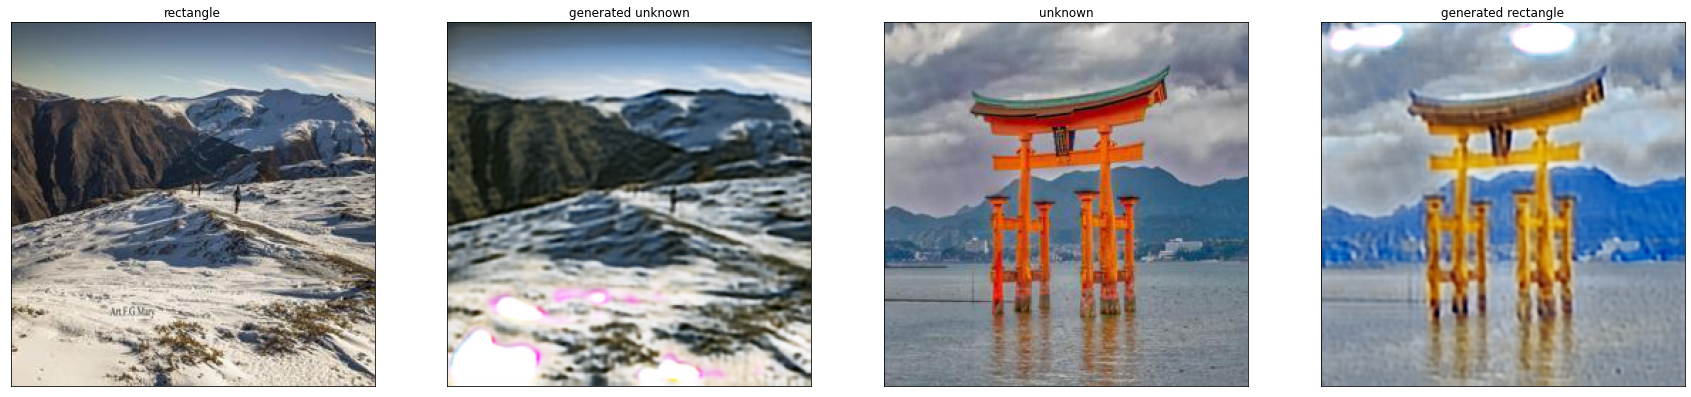

In [102]:
gen_W.to(torch.device("cuda:0"))
#testing results
summer,winter = next(iterData)
plt.figure(figsize=(30,10))
plt.subplot(1,4,1)
plt.imshow(np.moveaxis(np.array(winter.cpu()),0,-1))
plt.title("rectangle")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.subplot(1,4,2)
plt.imshow(np.moveaxis(np.array(gen_S(winter).cpu().detach()),0,-1))
plt.title("generated unknown")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.subplot(1,4,3)
plt.imshow(np.moveaxis(np.array(summer.cpu()),0,-1))
plt.title("unknown")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.subplot(1,4,4)
plt.imshow(np.moveaxis(np.array(gen_W(summer).cpu().detach()),0,-1))
plt.title("generated rectangle")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)

#Plotting the losses

In [103]:
# Importation des différentes librairies, classes et fonctions utilespour le notebook

#Sickit learn met régulièrement à jour des versions et 
#indique des futurs warnings. 
#ces deux lignes permettent de ne pas les afficher.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# librairies générales
import pandas as pd
import re
from tabulate import tabulate
import time
import numpy as np
import pickle
import string
import base64
import sys

# librairie affichage
import matplotlib.pyplot as plt
import seaborn as sns

# librairies scikit learn
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


# librairies des classifiers utilisés
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# librairies NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk import word_tokenize 

from sklearn.cluster import KMeans

#decomposition
from sklearn.decomposition import PCA
import plotly.express as px

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 

pd.options.mode.chained_assignment = None

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


sum of filter :  1.0


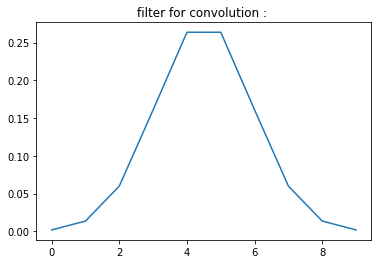

In [104]:
filter = np.exp(-np.square(np.linspace(-5,5,10))/5.)
filter /= np.sum(filter)
plt.title("filter for convolution : ")
plt.plot(filter)
print("sum of filter : ",np.sum(filter))

In [105]:
#get smooth versions
losses_disc_smooth=np.convolve(filter,losses_disc,'valid')
losses_gen_smooth=np.convolve(filter,losses_gen,'valid')
losses_gp_smooth=np.convolve(filter,losses_gp,'valid')
losses_cycle_smooth=np.convolve(filter,losses_cycle,'valid')

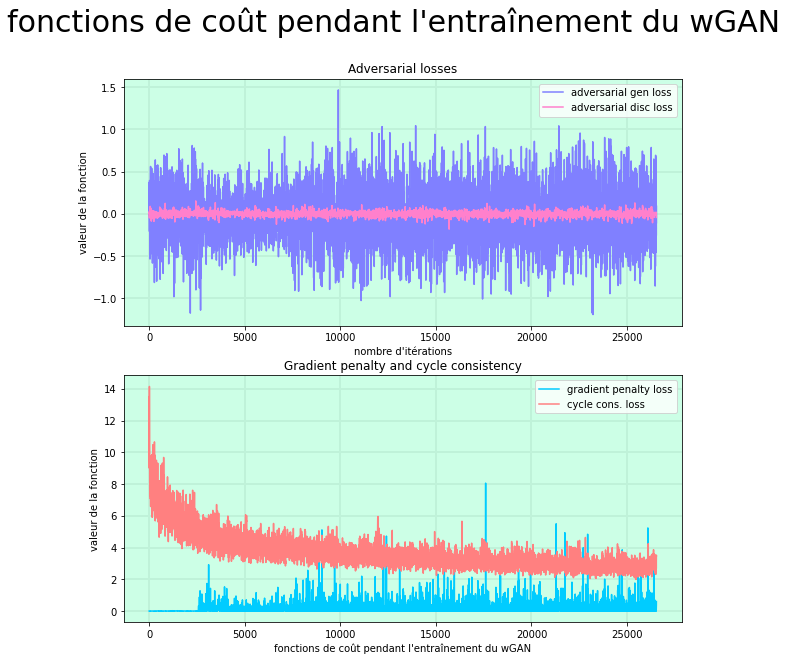

In [108]:
plt.figure(figsize=(10,10))

plt.suptitle("fonctions de coût pendant l'entraînement du wGAN",fontsize=30)



sp = plt.subplot(2,1,1)
sp.axes.set(facecolor=(.8,1.,.9,1.))

plt.plot(losses_gen_smooth, color=(.5,0.5,1.,1.),label="adversarial gen loss")
#plt.plot(losses_gen_smooth,'o', color=(.5,0.5,1.,1.))

plt.plot(losses_disc_smooth, color=(1.,.5,0.8,1.),label="adversarial disc loss")
#plt.plot(losses_disc_smooth,'o', color=(1.,.5,0.8,1.))

plt.xlabel("nombre d'itérations")
plt.ylabel("valeur de la fonction")
sp.grid(axis="both", linewidth=2, color=(.75,.95,.85,1.))
plt.title("Adversarial losses")
plt.legend()



sp = plt.subplot(2,1,2)
sp.axes.set(facecolor=(.8,1.,.9,1.))

plt.plot(losses_gp_smooth/10000., color=(0.,.8,1.,1.),label="gradient penalty loss")
#plt.plot(losses_gp_smooth,'o', color=(0.,.8,1.,1.))

plt.plot(losses_cycle_smooth, color=(1.,.5,0.5,1.),label="cycle cons. loss")
#plt.plot(losses_cycle_smooth,'o', color=(1.,.5,0.5,1.))

plt.xlabel("fonctions de coût pendant l'entraînement du wGAN")
plt.ylabel("valeur de la fonction")
sp.grid(axis="both", linewidth=2, color=(.75,.95,.85,1.))
plt.title("Gradient penalty and cycle consistency")
plt.legend()


plt.show()

In [109]:
torch.save(gen_W.state_dict(), "Models_RGB/comp_wasserstein")